Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d

* https://qiita.com/ryouta0506/items/619d9ac0d80f8c0aed92

* https://github.com/nejumi/tools_for_kaggle/blob/master/semi_supervised_learner.py

* https://upura.hatenablog.com/entry/2019/03/03/233534

* https://pompom168.hatenablog.com/entry/2019/07/22/113433


In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)
# Version = "v5" # Clipping a control with an outlier(20-80)
# Version = "v6" # under sampling 500 → oversamplling 500, lipping a control with an outlier(10-90)
# Version = "v7" # Use anotated data, under sampling 500 → oversamplling 500, clipping a control with an outlier(10-90)
# Version = "v8" # pseudo labeling (thresholds:0.5), timeout
# Version = "v9" # pseudo labeling (thresholds:0.6), timeout
# Version = "v10" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP
# Version = "v11" # pseudo labeling (thresholds:0.6), ReduceCol: Kolmogorov-Smirnov, PCA(whiten)&UMAP, lgbm parames adjust
# Version = "v12" # Feature engineering based on feature importance
# Version = "v13" # Calibration, SMOTE(k_neighbors=5→1)
# Version = "v14" # Removed the Calibration, SMOTE(k_neighbors=1), pseudo labeling (thresholds:0.7)
# Version = "v15" # Updata anotated data
# Version = "v16" # Remove noisy label(confidence: 0.5)
# Version = "v17" # Modifications with remove noisy label func, Calibration, confidence = y_prob.probability.max()*0.3
# Version = "v18" # SMOTE(k_neighbors=1→2), confidence = y_prob.probability.max()*0.2
# Version = "v19" # SMOTE(k_neighbors=2→3),
# Version = "v20" # Modifications with confidence, Removed the Calibration, SMOTE(k_neighbors=2), 
# Version = "v21" # DEBUG = False
# Version = "v22" # minor modifications
# Version = "v23" # TOP100→PCA→UMAP(n_components=3)
# Version = "v24" # TOP100→PCA→UMAP(n_components=10), UMAP(n_components=2→3)
# Version = "v25" # Feature engineering based on Feature importance
# Version = "v26" # Modify pseudo labeling func to exclude low confidence pseudo labels in the TEST data.
# Version = "v27" # LGBMClassifie:clf.predict→clf.predict_proba
# Version = "v28" # Calibration (No calbration:CV:0.06542)
# Version = "v29" # Remove Calibration, is_unbalance': True, SMOTE(k_neighbors=2→3), Modify pseudo labeling func to include low confidence pseudo labels in the TEST data, target_rate *= 1.2
# Version = "v30" # drop_duplicates(keep="last")
Version = "v31" # target_rate *= 1.1, if Threshold <= 0.2: break, if sum(p_label)*1.5 >= check: break, if sum(p_label) <= check*1.5: break

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
import imblearn
from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

print("lightgbm Version: ", lgb.__version__)
print("numpy Version: ", np.__version__)
print("pandas Version: ", pd.__version__)
print("imblearn Version: ", imblearn.__version__)

lightgbm Version:  2.3.1
numpy Version:  1.18.5
pandas Version:  1.1.1
imblearn Version:  0.7.0


# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 4
    Num_boost_round=10000
    Early_stopping_rounds=30
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

Max_depth = 7

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

In [8]:
annot = pd.read_csv("../input/moa-annot-data/20201024_moa_sig_list.v2.csv")
annot

,sig_id,nonscored1,nonscored2
0,adenylyl_cyclase_activator,adenylyl_cyclase_inhibitor,NaN
1,aldehyde_dehydrogenase_inhibitor,alcohol_dehydrogenase_inhibitor,NaN
2,antiarrhythmic,na_k-atpase_inhibitor,potassium_channel_blocker
3,anticonvulsant,gaba_gated_chloride_channel_blocker,NaN
4,antifungal,fungal_ergosterol_inhibitor,fungal_lanosterol_demethylase_inhibitor
5,antihistamine,histamine_release_inhibitor,NaN
6,atp-sensitive_potassium_channel_antagonist,atp-sensitive_potassium_channel_inhibitor,NaN
7,bacterial_membrane_integrity_inhibitor,bacterial_protein_synthesis_inhibitor,NaN
8,calcineurin_inhibitor,t_cell_inhibitor,NaN
9,catechol_o_methyltransferase_inhibitor,dopamine_release_enhancer,NaN


In [9]:
annot_sig = []
annot_sig = annot.sig_id.tolist()
print(annot_sig)

['adenylyl_cyclase_activator', 'aldehyde_dehydrogenase_inhibitor', 'antiarrhythmic', 'anticonvulsant', 'antifungal', 'antihistamine', 'atp-sensitive_potassium_channel_antagonist', 'bacterial_membrane_integrity_inhibitor', 'calcineurin_inhibitor', 'catechol_o_methyltransferase_inhibitor', 'cdk_inhibitor', 'coagulation_factor_inhibitor', 'elastase_inhibitor', 'erbb2_inhibitor', 'nicotinic_receptor_agonist', 'nitric_oxide_production_inhibitor', 'protein_phosphatase_inhibitor', 'sphingosine_receptor_agonist', 'steroid', 'ubiquitin_specific_protease_inhibitor']


In [10]:
train_target = pd.concat([train_targets_scored, train_targets_nonscored], axis=1)
train_target.head() 

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Training Utils

In [11]:
def get_target(target_col, annot_sig):
    if target_col in annot_sig:
        t_cols = []
        for t_col in list(annot[annot.sig_id == target_col].iloc[0]):
            if t_col is not np.nan:
                t_cols.append(t_col)
                target = train_target[t_cols]
                target = target.sum(axis=1)
                #1 or more, replace it with 1.
                target = target.where(target < 1, 1)
    else:
        target = train_targets_scored[target_col]
    
    return target

In [12]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str):
    target = get_target(target_col, annot_sig)
    target_rate = target.sum() / len(target)
    target_rate *= 1.1
    
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    trt = trt.drop("sig_id", axis=1)
    n_target = max(500,len(trt))
    
    logger.info(f"{target_col} , len(trt) : {len(trt)}")
        
    othr = train[target==0].copy().reset_index(drop=True)
    othr = othr.drop("sig_id", axis=1)
    othr = othr.sample(n=n_target, random_state=42)
    othr["target"] = 0
    
    X_train = pd.concat([trt, othr], axis=0, sort=False, ignore_index=True)
    X_train = X_train.replace([np.inf, -np.inf], np.nan)
    X_train = X_train.fillna(0)
    
    y_train = X_train["target"]
    X_train = X_train.drop("target", axis=1)


    if len(trt) < n_target:
        sm = SMOTE(k_neighbors=3, n_jobs=2, random_state=SEED)
        X_train, y_train = sm.fit_sample(X_train, y_train)
    
    X_test = test.drop("sig_id", axis=1)
    
    train_X, train_y = pseudo_labeling(X_train, y_train, X_test, target_rate)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(train_X),))
    score = 0
        
    for fold_, (train_index, valid_index) in enumerate(cv.split(train_X, train_y)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = train_X.loc[train_index, :]
        X_val = train_X.loc[valid_index, :]
        y_tr = train_y[train_index]
        y_val = train_y[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= fold {fold_+1}/{cv.get_n_splits()} {target_col}=================================")
        
        
        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=100,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)

        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(train_y, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [13]:
classifier_params = {
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'n_estimators': Num_boost_round,
    'learning_rate': Learning_rate,
    'objective': "binary",
    'colsample_bytree':0.7,
    'subsample':0.9,
    'subsample_freq':5,
    'reg_alpha':0.1,
    'reg_lambda':0.1,
    'random_state':SEED,
    'n_jobs':2,
}

In [14]:
def convert_label(df, conf_0, conf_1, threshold=0.5):
    df = df.copy()
    Probability = df.iloc[:,0]
    # Remove low confidence labels
    conf_index = df[(Probability <= conf_0) & (conf_1 <= Probability)].index.values
    
    Probability = Probability.where(Probability < threshold, 1).copy()
    p_label = Probability.where(Probability >= threshold, 0).copy()
    
    return p_label, conf_index

In [15]:
def pseudo_labeling(X_train, y_train, X_test, target_rate, max_iter=3):
       
    X = X_train.copy()
    y = y_train.copy()
    
    Threshold = 0.5
    
    for iter_ in range(1, max_iter+1):
    
        logger.info(f"================= Pseudo labeling {iter_} / {max_iter} =================")
        
        y_preds = np.zeros((X.shape[0], 2))
        y_preds[:, 0] = y.copy()
        
        y_prob = np.zeros((X_test.shape[0]))
        
        X_conf = pd.DataFrame()
        y_conf = pd.DataFrame()
        
        for fold_, (train_idx, valid_idx) in enumerate(cv.split(X, y)):        
            X_tr, X_val = X.loc[train_idx, :], X.loc[valid_idx, :]
            y_tr, y_val = y[train_idx], y[valid_idx]
            
            clf = LGBMClassifier(**classifier_params)
            
            clf.fit(X_tr, y_tr,
                    eval_set=[(X_tr, y_tr), (X_val, y_val)],
                    eval_metric='logloss',
                    verbose=100,
                    early_stopping_rounds=Early_stopping_rounds)
            
            y_preds[valid_idx, 1] = clf.predict_proba(X_val, num_iteration=clf.best_iteration_)[:, 1]
            y_prob += clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:, 1] / N_FOLD
        
        auc_score = roc_auc_score(y_preds[:, 0], y_preds[:, 1])
        logger.info(f"{iter_} / {max_iter} AUC score:{auc_score:.3f}") 
        y_preds = pd.DataFrame(y_preds, index=X.index, columns=[["Labels", "Preds"]])
        
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] < Threshold, 1).copy()
        y_preds.iloc[:,1] = y_preds.iloc[:,1].where(y_preds.iloc[:,1] >= Threshold, 0).copy()
        y_preds = y_preds.sum(axis=1)
                
        corect_idx = y_preds[y_preds != 1].index.values
        X_corect, y_corect = X[X.index.isin(corect_idx)], y[y.index.isin(corect_idx)]
        
        logger.info(f"Remove_noisy_labels: {len(y)-len(y_corect)} → positive_corect_labels: {sum(y_corect)}/{len(y_corect)}")
            
        # Remove low confidence labels
        y_prob = pd.DataFrame(y_prob, index=X_test.index, columns=["probability"])
        high_conf_0, high_conf_1 = y_prob.probability.min()*30, y_prob.probability.max()*0.6

        p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
        
        p_label_rate = sum(p_label)/len(p_label)        
        logger.info(f"p_label_rate: {p_label_rate:.5f} Vs.target_rate: {target_rate:.5f}, Num_p_label: {sum(p_label)}, conf_0:{high_conf_0:.5f}, conf_1:{high_conf_1:.5f}")
        
        # Set the params of threshold based on train labels rate (target_rate).
        # target_rate = target.sum() / len(target) * 1.1
        if p_label_rate*3 < target_rate:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label)*1.5 >= check: break
                Threshold -= 0.04
                if Threshold <= 0.2: break
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
               
                
        if p_label_rate > target_rate*3:
            check = len(y_prob)*target_rate
            for i in range(10):
                logger.info(f"Num_p_label: {sum(p_label)}, Expected: {check:.1f}, Adj_threshold_{i+1}: {Threshold:.2f}")
                if sum(p_label) <= check*1.5: break
                Threshold += 0.04
                if Threshold >= 0.9: break
                p_label, conf_idx = convert_label(y_prob, high_conf_0, high_conf_1, Threshold)
                
        if iter_ == max_iter:
            X_conf = X_test.copy()
        else:
            X_conf = X_test[X_test.index.isin(conf_idx)].copy()
            
        logger.info(f"threshold:{Threshold:.2f}, positive p_label:{sum(p_label)}/{len(p_label)}, p_label_rate: {sum(p_label)/len(p_label):.5f}")
 
        X = pd.concat([X_corect, X_conf], axis=0, ignore_index=True)
        y = pd.concat([y_corect, p_label], axis=0, ignore_index=True)
        
        X = X.drop_duplicates(keep="last").reset_index(drop=True)
        y = y[X.index.values].reset_index(drop=True)
        
        logger.info(f"positive y_label:{sum(y)}/{len(y)}, y_label_rate: {sum(y)/len(y):.5f}")
        
    return X, y

In [16]:
def show_feature_importance(feature_importance_df, num=100):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [17]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [18]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [19]:
train, test = label_encoding(train, test, ['cp_type', 'cp_time', 'cp_dose'])

In [20]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,train
1,id_000779bfc,1,2,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,train
2,id_000a6266a,1,1,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,train
3,id_0015fd391,1,1,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,train
4,id_001626bd3,1,2,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_ff7004b87,1,0,0,0.4571,-0.5743,3.3930,-0.6202,0.8557,1.6240,...,-0.6422,-0.4367,0.0159,-0.6539,-0.4791,-1.2680,-1.1280,-0.4167,-0.6600,test
27792,id_ff925dd0d,1,0,0,-0.5885,-0.2548,2.5850,0.3456,0.4401,0.3107,...,0.5780,-0.5888,0.8057,0.9312,1.2730,0.2614,-0.2790,-0.0131,-0.0934,test
27793,id_ffb710450,1,2,0,-0.3985,-0.1554,0.2677,-0.6813,0.0152,0.4791,...,0.9153,-0.1862,0.4049,0.9568,0.4666,0.0461,0.5888,-0.4205,-0.1504,test
27794,id_ffbb869f2,1,1,1,-1.0960,-1.7750,-0.3977,1.0160,-1.3350,-0.2207,...,-0.4473,-0.8192,0.7785,0.3133,0.1286,-0.2618,0.5074,0.7430,-0.0484,test


In [21]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
25,id_0054388ec,0,1,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820,train
40,id_007bfbb91,0,0,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180,train
47,id_008a986b7,0,1,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367,train
63,id_009d8340f,0,0,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,0,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457,train
23747,id_ff469c482,0,2,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777,train
23768,id_ff89331ca,0,2,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626,train
23793,id_ffd26f361,0,1,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082,train


In [22]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:6]
    for col in clipping:
        lower, upper= np.percentile(df[col], [10, 90])
        df[col] = np.clip(df[col], lower, upper)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl], axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99,WHERE
0,id_0054388ec,0,1,0,-0.6696,-0.27180,-1.2230,-0.6226,-0.7220,0.1588,...,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050,train
1,id_01b05de6c,0,1,0,-0.3176,0.48512,-0.3773,0.5555,-0.4877,0.3413,...,-0.6163,0.8001,0.3389,0.7437,0.7533,0.2406,0.5057,0.8017,1.0280,train
2,id_020ba48d9,0,1,0,0.8094,-0.33390,1.1130,-0.4192,0.4545,-0.4771,...,-0.4414,-0.2442,0.0557,-0.6597,-0.3713,-0.6929,-0.3258,0.3602,-0.0595,train
3,id_02c93b4a5,0,1,0,-0.0884,-1.54100,0.5562,0.4661,-0.1683,0.9515,...,0.4766,0.9697,0.4613,0.8957,0.8227,1.2300,1.7180,0.6542,0.0580,train
4,id_03bc6d412,0,1,0,0.8431,0.09310,-0.0958,-0.4337,1.0690,-0.6440,...,-1.1510,-0.5010,-0.2736,0.1270,0.3511,0.1233,-0.8520,0.1767,0.1153,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,2,1,-0.3490,0.72970,-4.1480,-1.0030,2.4070,-0.9784,...,-1.4260,-0.8613,-0.0243,-0.6109,0.6377,-1.2590,-0.7238,-0.7734,-0.1274,train
1862,id_fbba92030,0,2,1,-0.8921,1.13520,0.4227,1.3270,-0.9839,-0.8469,...,1.1340,0.7007,1.3320,0.6622,0.6167,0.9459,-0.0344,-0.0186,0.5173,train
1863,id_fbc0849ad,0,2,1,-0.2948,0.21960,-0.3252,-0.2084,-0.6518,0.3542,...,0.5014,0.6009,0.4560,-0.3360,-0.5091,0.6569,0.6203,0.6764,0.4504,train
1864,id_fd93fa37d,0,2,1,-0.2984,-0.47880,-2.3560,-0.6848,1.8700,1.0240,...,-0.4422,-0.6665,-0.8033,-1.0520,0.4103,0.4462,-1.1580,-1.3060,0.1925,train


In [23]:
col_list = list(data.columns)[:-1]
data_df = pd.DataFrame(columns=col_list)
Splitdata = []
d = 1e-6

for i in data.cp_time.unique():
    for j in data.cp_dose.unique():
        select = data[(data.cp_time==i) & (data.cp_dose==j)]
        print(len(select))
        
        for k in list(select['WHERE']):
                      Splitdata.append(k)
        
        select = select.drop(columns='WHERE')
        med = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)].iloc[:, 4:].median()
        f_div = lambda x: (x+d) / (abs(med)+d)
        select_d = select.iloc[:,4:].apply(f_div, axis=1).add_prefix('d_')
        tmp_data = pd.concat([select,select_d], axis=1, sort=False)
        data_df = pd.concat([data_df, tmp_data], axis=0)
data_df

4534
4538
4561
4536
5079
4548


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [24]:
# clipping
clipping = data_df.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data_df[col], [1, 99])
    data_df[col] = np.clip(data_df[col], lower, upper)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [25]:
data_df.cp_type = data_df.cp_type.astype('int64')
data_df.cp_time = data_df.cp_time.astype('int64')
data_df.cp_dose = data_df.cp_dose.astype('int64')
data_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
d_c-95     float64
d_c-96     float64
d_c-97     float64
d_c-98     float64
d_c-99     float64
Length: 1748, dtype: object

In [26]:
data_df = data_df.replace([np.inf, -np.inf], np.nan)
data_df = data_df.dropna(how='any', axis=1)
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-90,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.900850,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,5.788465,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-2.000935,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-1.221271,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-9.203619,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,3.364808,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-6.666625,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.461452,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-5.310498,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391


In [27]:
data_df['WHERE'] = Splitdata
data_df

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,d_c-91,d_c-92,d_c-93,d_c-94,d_c-95,d_c-96,d_c-97,d_c-98,d_c-99,WHERE
0,id_000644bb2,1,0,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.827675,4.339584,1.312811,-0.411268,1.931922,-1.059899,0.630788,1.112379,1.125303,train
5,id_001762a82,1,0,0,-0.6111,0.2941,-0.9901,0.2277,1.2810,0.5203,...,3.705949,-5.437902,4.518651,3.069473,1.325997,3.226831,1.110292,2.296748,3.769866,train
36,id_00762e877,1,0,0,-0.4026,0.1662,-0.6307,-0.4438,-0.5992,-0.2523,...,-0.524979,-0.457811,0.341813,0.017855,2.201874,1.442491,2.479205,0.934446,1.298032,train
38,id_0079af0fb,0,0,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-2.187049,-3.543232,-0.485616,0.768123,-0.387026,0.582269,0.217342,1.901665,-3.993519,train
39,id_0079d45d3,1,0,0,1.6310,-2.1430,-0.0943,-1.1990,0.4869,-0.0935,...,-18.488086,-10.402948,-6.859977,-5.953954,-7.288708,-7.193801,-6.644035,-14.152721,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27754,id_fca887f42,1,1,1,-0.4157,-0.0461,-0.9751,0.7702,-0.1861,0.3608,...,-2.944165,4.362395,-1.059934,-0.200288,3.648613,2.751680,-1.381859,0.808258,-2.753843,test
27759,id_fce497048,1,1,1,0.7107,-0.3274,-0.0099,-1.4950,0.6673,-1.5380,...,-2.994822,-108.965314,-3.263314,-19.418785,-5.186308,-16.265106,-3.400727,-8.642374,-6.611932,test
27768,id_fd75349b2,1,1,1,-0.0776,0.4437,-0.1530,1.2300,-0.5804,0.0633,...,1.221387,-12.977688,-1.847446,-1.481351,-3.441418,2.191467,1.214694,-7.687163,-2.167938,test
27784,id_fed0f2fe0,1,1,1,-1.0740,0.7350,0.3304,-0.6764,0.1435,-1.6810,...,-2.757956,9.262242,-3.612217,-2.189681,-6.566071,-10.169072,-3.150643,-3.656387,-5.960391,test


In [28]:
train = data_df[data_df['WHERE']=="train"].drop('WHERE', axis=1)
test = data_df[data_df['WHERE']=="test"].drop('WHERE', axis=1)

In [29]:
# Kolmogorov-Smirnov test applied for train data and test data.

from scipy.stats import ks_2samp

tr = train.iloc[:, 4:]
ts = test.iloc[:, 4:]

list_p_value =[ks_2samp(ts[i], tr[i])[1] for i in tqdm(tr.columns)]
Se = pd.Series(list_p_value, index=tr.columns).sort_values() 
list_discarded = list(Se[Se < .1].index)

train = train.drop(list_discarded, axis=1)
test = test.drop(list_discarded, axis=1)

print(f"Removed {len(list_discarded)} columns")


Removed 408 columns


In [30]:
train['WHERE'] = 'train'
test['WHERE'] = 'test'

data = train.append(test)
data = data.reset_index(drop=True)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99,WHERE
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303,train
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866,train
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032,train
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519,train
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843,test
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932,test
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938,test
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391,test


In [31]:
Splitdata = data["WHERE"]
data = data.drop('WHERE', axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,g-1,g-2,g-4,g-5,g-6,g-8,...,d_c-85,d_c-87,d_c-89,d_c-90,d_c-91,d_c-92,d_c-94,d_c-95,d_c-97,d_c-99
0,id_000644bb2,1,0,0,0.5577,-0.2479,-0.1944,-1.0120,-1.0220,0.5548,...,0.610453,-0.458706,3.210844,0.900850,0.827675,4.339584,-0.411268,1.931922,0.630788,1.125303
1,id_001762a82,1,0,0,0.2941,-0.9901,1.2810,0.5203,0.0543,-0.1586,...,2.368506,4.198996,7.411112,5.788465,3.705949,-5.437902,3.069473,1.325997,1.110292,3.769866
2,id_00762e877,1,0,0,0.1662,-0.6307,-0.5992,-0.2523,-1.3770,-1.4880,...,-2.098055,2.130879,2.780971,-2.000935,-0.524979,-0.457811,0.017855,2.201874,2.479205,1.298032
3,id_0079af0fb,0,0,0,-1.8230,-0.5211,-1.1280,0.6041,0.3856,-0.5400,...,0.927045,0.036750,2.267525,-1.221271,-2.187049,-3.543232,0.768123,-0.387026,0.217342,-3.993519
4,id_0079d45d3,1,0,0,-2.1430,-0.0943,0.4869,-0.0935,1.2090,-1.5450,...,-12.466870,-18.897523,-9.183429,-9.203619,-18.488086,-10.402948,-5.953954,-7.288708,-6.644035,-1.741033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,-0.0461,-0.9751,-0.1861,0.3608,0.5174,0.9298,...,0.977743,10.394855,-23.040415,3.364808,-2.944165,4.362395,-0.200288,3.648613,-1.381859,-2.753843
27792,id_fce497048,1,1,1,-0.3274,-0.0099,0.6673,-1.5380,-0.5368,2.1020,...,-3.525817,-53.796375,-33.477371,-6.666625,-2.994822,-108.965314,-19.418785,-5.186308,-3.400727,-6.611932
27793,id_fd75349b2,1,1,1,0.4437,-0.1530,-0.5804,0.0633,0.6952,-0.1058,...,2.350949,110.075643,53.955575,1.461452,1.221387,-12.977688,-1.481351,-3.441418,1.214694,-2.167938
27794,id_fed0f2fe0,1,1,1,0.7350,0.3304,0.1435,-1.6810,-1.1370,-0.4083,...,-6.247984,-26.830434,-50.825426,-5.310498,-2.757956,9.262242,-2.189681,-6.566071,-3.150643,-5.960391


In [32]:
# Select TOP100 features based on feature importance with v8 notebook

def select_importance_cols(feature_importance_df, num=103):
    best_cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:num].index)
    return best_cols


Feature_importance_df = pd.read_csv("../input/../input/moa-annot-data/feature_importance_df.v8.colab.csv")
Feature_importance_df

importance_cols = select_importance_cols(Feature_importance_df)

len(importance_cols)

103

In [33]:
TOP100 = data[importance_cols]
TOP100 = TOP100.drop(["cp_type", "cp_time", "cp_dose"], axis=1)
TOP100

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.3801,-0.3167,-1.6510,-0.6217,-1.1230,-0.2461,4.183851,-1.3310,20.720024,-0.22130,...,-0.463249,0.1242,0.0251,2.647177,-10.548861,-1.2560,-0.262194,0.4171,-2.345232,1.2570
1,0.7848,0.4842,0.0333,-0.5141,0.4944,-1.1160,-9.101135,0.5149,-121.467612,0.07920,...,0.712450,0.4590,-0.2584,1.543021,2.532123,-0.2533,-2.819025,-0.4584,3.110345,0.4290
2,0.3193,0.4587,-0.8791,0.2905,-0.1851,0.0860,-5.791252,-1.6090,134.510130,-0.07250,...,1.025284,-0.2491,0.1676,-3.476730,-1.085747,-0.5656,-3.664973,0.6659,-3.906875,-0.3232
3,0.6498,0.6086,-0.5522,0.4275,-0.7775,0.2270,-2.712772,0.8298,74.254500,-1.66400,...,-0.539958,1.3530,-0.2259,-0.720046,31.350629,0.3576,0.201876,0.0597,3.599244,-0.9233
4,-4.8360,-1.1320,2.3720,-0.8283,1.5840,-2.3630,-1.055764,-0.9043,140.770455,3.85415,...,3.627592,-4.4690,1.8870,-9.592403,43.259989,0.0328,-3.335726,4.2690,3.422303,-0.8781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.2310,-0.2914,0.1655,0.2242,0.1058,-1.0330,-2.921354,0.5788,-13.888734,-0.31340,...,-1.244962,-0.4987,-0.4098,0.769766,-155.100886,0.1914,-4.482931,-0.5465,0.340697,-0.6500
27792,-2.4700,1.0300,0.2641,-1.0190,5.7110,-2.3140,-19.551915,1.8170,56.104299,0.69710,...,1.129264,-4.7070,4.7440,2.384589,1016.814588,-0.1688,6.439848,0.8439,-2.063460,-5.1430
27793,-2.1970,0.0199,0.0428,0.7036,2.8370,0.9448,5.732132,-1.6010,-249.158505,-2.55600,...,-1.024153,-0.0303,0.7360,-5.974495,-110.383776,1.5240,9.631421,0.1586,1.600912,-0.7809
27794,-1.0450,-0.2809,-0.8224,0.2189,-1.0990,0.9241,-0.123390,-1.4440,-7.429982,0.82050,...,1.669632,0.6461,-0.4913,3.565008,253.578959,0.7208,5.579313,-0.2808,-0.563337,-0.8265


In [34]:
g_list = [col for col in data.columns[4:] if col.startswith("g-")]
c_list = [col for col in data.columns[4:] if col.startswith("c-")]
d_g_list = [col for col in data.columns[4:] if col.startswith("d_g-")]
d_c_list = [col for col in data.columns[4:] if col.startswith("d_c-")]

g_list

['g-1',
 'g-2',
 'g-4',
 'g-5',
 'g-6',
 'g-8',
 'g-9',
 'g-10',
 'g-12',
 'g-13',
 'g-14',
 'g-15',
 'g-16',
 'g-18',
 'g-19',
 'g-20',
 'g-23',
 'g-24',
 'g-25',
 'g-26',
 'g-27',
 'g-28',
 'g-29',
 'g-30',
 'g-31',
 'g-32',
 'g-33',
 'g-34',
 'g-35',
 'g-36',
 'g-38',
 'g-39',
 'g-40',
 'g-41',
 'g-42',
 'g-43',
 'g-44',
 'g-45',
 'g-46',
 'g-47',
 'g-48',
 'g-49',
 'g-50',
 'g-51',
 'g-53',
 'g-54',
 'g-55',
 'g-56',
 'g-57',
 'g-58',
 'g-59',
 'g-61',
 'g-62',
 'g-64',
 'g-65',
 'g-67',
 'g-69',
 'g-70',
 'g-71',
 'g-73',
 'g-74',
 'g-77',
 'g-78',
 'g-79',
 'g-81',
 'g-83',
 'g-87',
 'g-88',
 'g-89',
 'g-90',
 'g-91',
 'g-93',
 'g-94',
 'g-95',
 'g-96',
 'g-97',
 'g-99',
 'g-103',
 'g-104',
 'g-105',
 'g-106',
 'g-107',
 'g-108',
 'g-109',
 'g-110',
 'g-111',
 'g-113',
 'g-114',
 'g-115',
 'g-116',
 'g-117',
 'g-118',
 'g-119',
 'g-121',
 'g-122',
 'g-123',
 'g-124',
 'g-125',
 'g-126',
 'g-127',
 'g-128',
 'g-129',
 'g-130',
 'g-131',
 'g-132',
 'g-133',
 'g-136',
 'g-137',
 'g-

In [35]:
from sklearn.preprocessing import StandardScaler
    
# Z-score
scaler = StandardScaler(with_mean=True, with_std=True)
std_values = scaler.fit_transform(data.iloc[:, 4:])
std_df = pd.DataFrame(std_values, index=data.index, columns=data.columns[4:])    

In [36]:
TOP100_values = scaler.fit_transform(TOP100)
TOP100_df = pd.DataFrame(TOP100_values, index=TOP100.index, columns=TOP100.columns)
TOP100_df

,c-98,g-763,g-231,g-178,g-91,g-635,d_g-87,g-254,d_g-202,g-207,...,d_g-39,g-569,g-65,d_g-743,d_g-580,g-105,d_g-157,g-201,d_g-435,c-67
0,0.465802,-0.291639,-1.052265,-0.263976,-0.823391,-0.341928,0.010720,-1.173292,0.532505,-0.245498,...,-0.370791,0.296662,-0.189006,0.524494,-0.060594,-1.291179,-0.044174,0.035238,-1.003075,0.850758
1,0.690930,0.436481,0.041989,-0.205921,0.051524,-0.997763,0.010672,0.349254,-2.467257,0.051649,...,0.236541,0.511429,-0.395724,0.359766,-0.060531,-0.343840,-0.059517,-0.504862,1.039894,0.448301
2,0.431980,0.413298,-0.550778,0.228193,-0.316045,-0.091551,0.010684,-1.402594,2.933159,-0.098358,...,0.398142,0.057198,-0.085100,-0.389126,-0.060548,-0.638898,-0.064593,0.188724,-1.587868,0.082687
3,0.615831,0.549577,-0.338398,0.302110,-0.636497,0.014752,0.010695,0.608992,1.661933,-1.672100,...,-0.410416,1.084911,-0.372027,0.022141,-0.060392,0.233330,-0.041389,-0.185244,1.222974,-0.208997
4,-2.435831,-1.032850,1.561392,-0.375445,0.640931,-1.937901,0.010701,-0.821339,3.065234,3.784478,...,1.742419,-2.649776,1.168628,-1.301517,-0.060335,-0.073537,-0.062617,2.411493,1.156714,-0.187027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.382860,-0.268638,0.127876,0.192421,-0.158685,-0.935187,0.010694,0.401960,-0.197643,-0.336570,...,-0.774601,-0.102915,-0.506120,0.244405,-0.061289,0.076307,-0.069501,-0.559212,0.002735,-0.076157
27792,-1.119663,0.932683,0.191934,-0.478335,2.873386,-1.900959,0.010635,1.423260,1.279015,0.662655,...,0.451856,-2.802448,3.251854,0.485318,-0.055651,-0.264006,-0.003956,0.298533,-0.897559,-2.260021
27793,-0.967797,0.014373,0.048160,0.451077,1.318727,0.555915,0.010725,-1.395995,-5.161179,-2.554147,...,-0.660537,0.197554,0.329358,-0.761765,-0.061074,1.335331,0.015196,-0.124232,0.474652,-0.139782
27794,-0.326958,-0.259092,-0.513942,0.189562,-0.810409,0.540309,0.010704,-1.266498,-0.061381,0.784678,...,0.730994,0.631450,-0.565547,0.661424,-0.059323,0.576477,-0.009120,-0.395300,-0.335802,-0.161946


In [37]:
from sklearn.decomposition import PCA
from umap import UMAP

# PCA for all data
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_all = pca_transformer.fit_transform(std_df)

# PCA → UMAP for all data
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_all = umap.fit_transform(pca_all)

print(pca_umap_all.shape)

(27796, 10)


In [38]:
# PCA for TOP100
pca_TOP100 = pca_transformer.fit_transform(TOP100_df)

# PCA → UMAP for TOP100
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_TOP100 = umap.fit_transform(pca_TOP100)

print(pca_umap_TOP100.shape)

(27796, 10)


In [39]:
# PCA for merged categories
g_d_g_list = g_list + d_g_list
c_d_c_list = c_list + d_c_list

pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])

# PCA → UMAP for merged categories
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g_d_g = umap.fit_transform(pca_g_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c_d_c = umap.fit_transform(pca_c_d_c)

print(pca_umap_g_d_g.shape)
print(pca_umap_c_d_c.shape)

(27796, 10)
(27796, 3)


In [40]:
# PCA for each category
pca_transformer = PCA(n_components=0.9, whiten=True, random_state=SEED)
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

print("*************")

# PCA → UMAP for each category
umap = UMAP(n_components=10, random_state=SEED)
pca_umap_g = umap.fit_transform(pca_g)
pca_umap_d_g = umap.fit_transform(pca_d_g)

umap = UMAP(n_components=3, random_state=SEED)
pca_umap_c = umap.fit_transform(pca_c)
pca_umap_d_c = umap.fit_transform(pca_d_c)

print(pca_umap_g.shape)
print(pca_umap_c.shape)
print(pca_umap_d_g.shape)
print(pca_umap_d_c.shape)

(27796, 323)
(27796, 13)
(27796, 394)
(27796, 25)
*************
(27796, 10)
(27796, 3)
(27796, 10)
(27796, 3)


In [41]:
# PCA for all categories
pca_transformer = PCA(n_components=3, whiten=True, random_state=SEED)

pca_all = pca_transformer.fit_transform(std_df)
pca_g_d_g = pca_transformer.fit_transform(std_df[g_d_g_list])
pca_c_d_c = pca_transformer.fit_transform(std_df[c_d_c_list])
pca_g = pca_transformer.fit_transform(std_df[g_list])
pca_c = pca_transformer.fit_transform(std_df[c_list])
pca_d_g = pca_transformer.fit_transform(std_df[d_g_list])
pca_d_c = pca_transformer.fit_transform(std_df[d_c_list])

print(pca_all.shape)
print(pca_g_d_g.shape)
print(pca_c_d_c.shape)
print(pca_g.shape)
print(pca_c.shape)
print(pca_d_g.shape)
print(pca_d_c.shape)

(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)
(27796, 3)


In [42]:
data_list = [ 
    pca_umap_all,
    pca_umap_g_d_g,
    pca_umap_c_d_c,
    pca_umap_g,
    pca_umap_c,
    pca_umap_d_g,
    pca_umap_d_c,
    pca_all,
    pca_g_d_g,
    pca_c_d_c,
    pca_g,
    pca_c,
    pca_d_g,
    pca_d_c,
    pca_umap_TOP100,
]

data_names = [ 
    "pca_umap_all",
    "pca_umap_g_d_g",
    "pca_umap_c_d_c",
    "pca_umap_g",
    "pca_umap_c",
    "pca_umap_d_g",
    "pca_umap_d_c",
    "pca_all",
    "pca_g_d_g",
    "pca_c_d_c",
    "pca_g",
    "pca_c",
    "pca_d_g",
    "pca_d_c",
    "pca_umap_TOP100",
]

In [43]:
col_list = []
for i, d in enumerate(data_list):
    for j in range(d.shape[1]):
        col_list.append( f"{data_names[i]}_{j+1}")
col_list

['pca_umap_all_1',
 'pca_umap_all_2',
 'pca_umap_all_3',
 'pca_umap_all_4',
 'pca_umap_all_5',
 'pca_umap_all_6',
 'pca_umap_all_7',
 'pca_umap_all_8',
 'pca_umap_all_9',
 'pca_umap_all_10',
 'pca_umap_g_d_g_1',
 'pca_umap_g_d_g_2',
 'pca_umap_g_d_g_3',
 'pca_umap_g_d_g_4',
 'pca_umap_g_d_g_5',
 'pca_umap_g_d_g_6',
 'pca_umap_g_d_g_7',
 'pca_umap_g_d_g_8',
 'pca_umap_g_d_g_9',
 'pca_umap_g_d_g_10',
 'pca_umap_c_d_c_1',
 'pca_umap_c_d_c_2',
 'pca_umap_c_d_c_3',
 'pca_umap_g_1',
 'pca_umap_g_2',
 'pca_umap_g_3',
 'pca_umap_g_4',
 'pca_umap_g_5',
 'pca_umap_g_6',
 'pca_umap_g_7',
 'pca_umap_g_8',
 'pca_umap_g_9',
 'pca_umap_g_10',
 'pca_umap_c_1',
 'pca_umap_c_2',
 'pca_umap_c_3',
 'pca_umap_d_g_1',
 'pca_umap_d_g_2',
 'pca_umap_d_g_3',
 'pca_umap_d_g_4',
 'pca_umap_d_g_5',
 'pca_umap_d_g_6',
 'pca_umap_d_g_7',
 'pca_umap_d_g_8',
 'pca_umap_d_g_9',
 'pca_umap_d_g_10',
 'pca_umap_d_c_1',
 'pca_umap_d_c_2',
 'pca_umap_d_c_3',
 'pca_all_1',
 'pca_all_2',
 'pca_all_3',
 'pca_g_d_g_1',
 'pca_g

In [44]:
result_df = pd.DataFrame(data_list[0])
for d in data_list[1:]:
    tmp_df = pd.DataFrame(d)
    result_df = pd.concat([result_df, tmp_df], axis=1)
result_df.columns = col_list
result_df

,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,pca_umap_all_7,pca_umap_all_8,pca_umap_all_9,pca_umap_all_10,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,-0.631963,0.520953,-0.489372,0.596058,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,-0.837569,0.656989,0.557744,0.862181,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,-1.044028,0.611787,0.327000,0.522496,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,-0.463792,0.222208,0.172640,0.482514,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,-0.936194,0.003462,1.613957,0.086733,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,-0.518431,0.616687,-0.967858,0.699507,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,-0.553066,0.555583,-0.925586,0.635752,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,-1.325753,0.832510,0.902315,1.563123,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,-0.554051,0.652266,-0.881698,0.647011,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [45]:
# Add data with sig_id, cp_type, cp_time, and cp_dose
data = pd.concat([data.iloc[:, :4], result_df], axis=1)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_TOP100_1,pca_umap_TOP100_2,pca_umap_TOP100_3,pca_umap_TOP100_4,pca_umap_TOP100_5,pca_umap_TOP100_6,pca_umap_TOP100_7,pca_umap_TOP100_8,pca_umap_TOP100_9,pca_umap_TOP100_10
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,6.291778,-0.896044,-2.179520,-0.261095,-0.185973,-0.730860,-0.277922,-2.093488,-0.481698,0.789918
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,6.714967,-0.574278,-1.187935,0.187836,-0.670903,-1.216028,-0.134091,-1.612451,-0.830641,0.776585
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,6.451351,-0.846004,-1.926834,0.146358,0.423570,0.135981,-0.279752,-1.925897,-1.053102,0.758147
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,6.753309,-1.262712,-2.070887,0.448940,-0.919785,-1.027439,-0.579268,-1.839002,-0.788038,0.998733
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,5.859893,-0.882311,-0.556978,-0.503719,-1.303859,-2.796995,-0.430360,-2.222141,0.544073,0.535439
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,6.151339,-0.766605,-2.023969,-0.091503,0.262792,0.076237,0.382143,-2.097664,-1.445793,0.793138
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,6.474981,-1.491105,-0.321771,-0.448232,0.628889,0.308673,1.890694,-2.157108,0.613078,2.076361
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,8.225327,1.229136,1.207181,-0.829210,-0.622215,0.432208,-1.731819,-0.017909,-6.554715,0.086943
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,6.113300,-0.861787,-1.994804,0.399603,0.794215,0.322496,0.519033,-1.932268,-1.072403,1.189883


In [46]:
# Create feature
import itertools
def CreateFeat(df):
  def func_product(row):
    return (row[col1]) * (row[col2])
  def func_division(row):
    delta = 1e-6
    return (row[col1]+delta) / (row[col2]+delta) 
  
  Columns = df.columns 
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
        df[f"{col1}_{col2}_prd"] = df[[col1, col2]].apply(func_product, axis=1)
        df[f"{col1}_{col2}_div"] = round(df[[col1, col2]].apply(func_division, axis=1), 0)

  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

#Reduce columens
def ReduceCol(df):
  remove_cols = []
  Columns = df.columns
  
  for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
    # constant columns
    if df[col1].std() == 0: remove_cols.append(col1)
    
    # duplicated columns
    if (col1 not in remove_cols) and (col2 not in remove_cols):
      x, y = df[col1].values, df[col2].values
      if np.array_equal(x, y): remove_cols.append(col1)

  df.drop(remove_cols, inplace=True, axis=1)
  print(f"Removed {len(remove_cols)} constant & duplicated columns")

  return df

# Create feature2
def CreateFeat2(df):
  func_list = ("max", "min", "mean", "median", "mad", "var", "std")
  Columns = df.columns 
  for idx, func in enumerate(func_list):
    print(f"{idx}/{len(func_list)}: Calucurating... {func}")
    for col1, col2 in tqdm(tuple(itertools.permutations(Columns, 2))):
      df[f"{col1}_{col2}_{func}"] = df[[col1, col2]].apply(func, axis=1)
  print(f"Crated {len(df.columns) - len(Columns)} columns")
  return df

In [47]:
important_col = ["pca_umap_g_2", "pca_umap_g_d_g_8", "pca_umap_all_3", "pca_umap_g_10", "pca_umap_g_d_g_4"]

In [48]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data


Crated 40 columns



Removed 10 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_10_pca_umap_all_3_div,pca_umap_g_10_pca_umap_g_d_g_4_div,pca_umap_g_d_g_4_pca_umap_g_2_prd,pca_umap_g_d_g_4_pca_umap_g_2_div,pca_umap_g_d_g_4_pca_umap_g_d_g_8_prd,pca_umap_g_d_g_4_pca_umap_g_d_g_8_div,pca_umap_g_d_g_4_pca_umap_all_3_prd,pca_umap_g_d_g_4_pca_umap_all_3_div,pca_umap_g_d_g_4_pca_umap_g_10_prd,pca_umap_g_d_g_4_pca_umap_g_10_div
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.0,-7.0,-0.088117,-0.0,0.026398,0.0,-0.144850,-0.0,-0.064638,-0.0
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,4.0,-1.0,-0.439963,-0.0,0.278731,1.0,-0.047637,-4.0,-0.171200,-1.0
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.0,-1.0,-0.778366,-1.0,0.720932,1.0,-0.390272,-1.0,-0.312836,-2.0
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,2.0,-1.0,-0.414372,-1.0,0.382767,1.0,-0.150680,-2.0,-0.357086,-1.0
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,1.0,0.0,0.105336,3.0,0.134999,2.0,0.244125,1.0,0.128807,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.0,-0.0,-0.187884,-6.0,1.051340,1.0,-1.483966,-1.0,-0.271738,-4.0
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.0,-1.0,-0.667012,-1.0,0.580433,1.0,-0.964956,-1.0,-0.531804,-1.0
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,1.0,1.0,0.913292,1.0,0.934766,1.0,1.172104,1.0,0.657431,2.0
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.0,-1.0,-0.903426,-1.0,0.890684,1.0,-1.312807,-1.0,-0.663032,-1.0


In [49]:
# Create feature based on feature importance with v24 notebook
tmp = CreateFeat2(data[important_col])
data = pd.concat([data, tmp], axis=1)

#remove dup colunes
data = data.loc[:,~data.columns.duplicated()]
tmp = ReduceCol(data.iloc[:,4:])
data = pd.concat([data.iloc[:,:4], tmp], axis=1)
data

0/7: Calucurating... max



1/7: Calucurating... min



2/7: Calucurating... mean



3/7: Calucurating... median



4/7: Calucurating... mad



5/7: Calucurating... var



6/7: Calucurating... std



Crated 140 columns



Removed 80 constant & duplicated columns


,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.512993,0.927889,-0.848250,0.769027,...,0.845799,0.419021,1.264820,0.173420,0.672379,0.592441,0.718523,0.127276,1.137544,0.545103
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,1.169063,0.638177,0.530886,0.437184,0.731879,0.200993,1.023046,0.146017,0.384869,0.585862
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.451232,0.375651,1.075580,0.450606,1.000626,0.074954,1.269972,0.181259,0.894321,0.819367
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,1.102377,0.364665,0.737712,0.079223,1.023154,0.285442,0.934597,0.167780,0.569932,0.855374
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.928014,0.013562,...,0.039534,0.184977,0.145443,0.031282,0.008253,0.153695,0.234759,0.195225,0.049782,0.203477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.822841,0.860594,1.683435,0.055678,0.878519,0.804916,0.877770,0.054930,1.738364,0.933449
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.213152,0.289753,1.502906,0.131492,1.081660,0.421245,1.162810,0.050343,1.452563,1.031318
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.722474,-0.885569,-0.035729,...,0.014904,0.179627,0.164723,0.177579,0.192483,0.357206,0.086550,0.071646,0.093076,0.264130
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.439615,0.766808,-0.643382,0.663832,...,1.391168,0.317438,1.708606,0.186403,1.204765,0.503841,1.345345,0.045823,1.662783,1.158942


In [50]:
# clipping
clipping = data.columns[4:]
for col in clipping:
    lower, upper = np.percentile(data[col], [1, 99])
    data[col] = np.clip(data[col], lower, upper)
data

,sig_id,cp_type,cp_time,cp_dose,pca_umap_all_1,pca_umap_all_2,pca_umap_all_3,pca_umap_all_4,pca_umap_all_5,pca_umap_all_6,...,pca_umap_g_d_g_8_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_2_std,pca_umap_all_3_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_g_2_std,pca_umap_g_10_pca_umap_g_d_g_8_std,pca_umap_g_10_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_2_std,pca_umap_g_d_g_4_pca_umap_g_d_g_8_std,pca_umap_g_d_g_4_pca_umap_all_3_std,pca_umap_g_d_g_4_pca_umap_g_10_std
0,id_000644bb2,1,0,0,0.414406,0.909078,-1.407962,0.927889,-0.848250,0.769027,...,0.845799,0.419021,1.264820,0.173420,0.672379,0.592441,0.718523,0.127276,1.137544,0.545103
1,id_001762a82,1,0,0,0.786781,-0.427628,-0.109586,0.892243,-0.456970,0.178259,...,1.169063,0.638177,0.530886,0.437184,0.731879,0.200993,1.023046,0.146017,0.384869,0.585862
2,id_00762e877,1,0,0,0.420639,-0.087313,-0.534235,0.388297,-0.543968,0.667831,...,1.451232,0.375651,1.075580,0.450606,1.000626,0.074954,1.269972,0.181259,0.894321,0.819367
3,id_0079af0fb,0,0,0,0.446064,0.085459,-0.294690,0.552296,-0.212881,0.279669,...,1.102377,0.364665,0.737712,0.079223,1.023154,0.285442,0.934597,0.167780,0.569932,0.855374
4,id_0079d45d3,1,0,0,0.227194,-0.630111,-0.460141,0.464349,-0.923120,0.013562,...,0.039534,0.184977,0.145443,0.031282,0.010546,0.153695,0.234759,0.195225,0.049782,0.203477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27791,id_fca887f42,1,1,1,0.544228,1.004292,-1.393493,0.820182,-0.471184,0.531311,...,0.822841,0.860594,1.683435,0.055678,0.878519,0.804916,0.877770,0.054930,1.738364,0.933449
27792,id_fce497048,1,1,1,0.443511,0.862770,-1.327139,0.746451,-0.526177,0.569458,...,1.213152,0.289753,1.502906,0.131492,1.081660,0.421245,1.162810,0.050343,1.452563,1.031318
27793,id_fd75349b2,1,1,1,1.028752,0.136440,-1.150451,1.162132,-0.885569,-0.035729,...,0.014904,0.179627,0.164723,0.177579,0.192483,0.357206,0.086550,0.071646,0.093076,0.264130
27794,id_fed0f2fe0,1,1,1,0.511500,0.943903,-1.407962,0.766808,-0.643382,0.663832,...,1.391168,0.317438,1.708606,0.186403,1.204765,0.503841,1.345345,0.045823,1.662783,1.158942


In [51]:
data['WHERE'] = Splitdata
train = data[data['WHERE']=="train"].drop('WHERE', axis=1).reset_index(drop=True)
test = data[data['WHERE']=="test"].drop('WHERE', axis=1).reset_index(drop=True)

# Modeling

In [52]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    # 'metric': 'average_precision',
    'is_unbalance': True,
    'learning_rate': Learning_rate,
    'num_threads': 2,
    'verbose': -1,
    'max_depth': Max_depth,
    'num_leaves': int((Max_depth**2)*0.7),
    'feature_fraction':0.7, # randomly select part of features on each iteration
    'lambda_l1':0.1,
    'lambda_l2':0.1,
    'bagging_fraction': 0.9,
    'bagging_freq': 5,

}

categorical_cols = []
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [53]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models = run_lgbm(target_col)

    sub[target_col] = _preds
    scores.append(_score)
    
    
    if DEBUG:
        for model in models:
            _importance_df = pd.DataFrame()
            _importance_df["Feature"] = train.columns[1:]
            _importance_df["importance"] = model.feature_importance(importance_type='gain')
            feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

5-alpha_reductase_inhibitor , len(trt) : 17
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869141	valid_1's binary_logloss: 0.157141
[200]	training's binary_logloss: 0.016886	valid_1's binary_logloss: 0.0733619
[300]	training's binary_logloss: 0.00571919	valid_1's binary_logloss: 0.053223
[400]	training's binary_logloss: 0.00310071	valid_1's binary_logloss: 0.0490354
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00321071	valid_1's binary_logloss: 0.048879
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873341	valid_1's binary_logloss: 0.143927
[200]	training's binary_logloss: 0.018193	valid_1's binary_logloss: 0.0587968
[300]	training's binary_logloss: 0.00621222	valid_1's binary_logloss: 0.0349169
[400]	training's binary_logloss: 0.00336437	valid_1's binary_logloss: 0.0267892
[500]	training's binary_logloss: 0.00237811	valid_1's binary_logloss: 0.0232037
[600]	training's binary_logloss: 0.00203824	valid_1's

1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 499/994
p_label_rate: 0.00854 Vs.target_rate: 0.00079, Num_p_label: 34.0, conf_0:0.00775, conf_1:0.59385
Num_p_label: 34.0, Expected: 3.1, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 3.1, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 3.1, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 3.1, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 3.1, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 3.1, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 3.1, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 3.1, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.1, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/994, y_label_rate: 0.50201
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853574	valid_1's binary_logloss: 0.181378
[200]	training's binary_logloss: 0.016917	valid_1's binary_logloss: 0.0905018
[300]	training's binary_logloss: 0.00562937	valid_1's binary_logloss: 0.0636642
[400]	training's binary_logloss: 0.00308542	valid_1's binary_logloss: 0.054036
[500]	training's binary_logloss: 0.00221359	valid_1's binary_logloss: 0.0501008
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.00222892	valid_1's binary_logloss: 0.049998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0808242	valid_1's binary_logloss: 0.134196
[200]	training's binary_logloss: 0.0163321	valid_1's binary_logloss: 0.0548561
[300]	training's binary_logloss: 0.00551295	valid_1's binary_logloss: 0.0341738
[400]	training's binary_logloss: 0.00302846	valid_1's binary_logloss: 0.0278926
[500]	training's binary_logloss: 0.00217075	valid_1'

2 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 486.0/980
p_label_rate: 0.00251 Vs.target_rate: 0.00079, Num_p_label: 10.0, conf_0:0.00509, conf_1:0.59798
Num_p_label: 10.0, Expected: 3.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:486.0/980, y_label_rate: 0.49592
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846449	valid_1's binary_logloss: 0.139604
[200]	training's binary_logloss: 0.0174977	valid_1's binary_logloss: 0.0508144
[300]	training's binary_logloss: 0.00585859	valid_1's binary_logloss: 0.0267988
[400]	training's binary_logloss: 0.00313308	valid_1's binary_logloss: 0.01931
[500]	training's binary_logloss: 0.00221611	valid_1's binary_logloss: 0.0164771
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.0020033	valid_1's binary_logloss: 0.0154349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781476	valid_1's binary_logloss: 0.149503
[200]	training's binary_logloss: 0.0155443	valid_1's binary_logloss: 0.0696775
[300]	training's binary_logloss: 0.00530091	valid_1's binary_logloss: 0.0482048
[400]	training's binary_logloss: 0.00288882	valid_1's binary_logloss: 0.0391946


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 477.0/971
p_label_rate: 0.00251 Vs.target_rate: 0.00079, Num_p_label: 10.0, conf_0:0.00723, conf_1:0.59871
Num_p_label: 10.0, Expected: 3.1, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0023227	valid_1's binary_logloss: 0.0365366


positive y_label:487.0/4953, y_label_rate: 0.09832
len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217244	valid_1's binary_logloss: 0.0356404
[200]	training's binary_logloss: 0.00285481	valid_1's binary_logloss: 0.0169205
[300]	training's binary_logloss: 0.00073731	valid_1's binary_logloss: 0.0118104
[400]	training's binary_logloss: 0.000349301	valid_1's binary_logloss: 0.00931815
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.000289308	valid_1's binary_logloss: 0.00881202


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 5-alpha_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221799	valid_1's binary_logloss: 0.0360943
[200]	training's binary_logloss: 0.00285742	valid_1's binary_logloss: 0.0150894
[300]	training's binary_logloss: 0.000734485	valid_1's binary_logloss: 0.00980792
[400]	training's binary_logloss: 0.000347231	valid_1's binary_logloss: 0.00736161
[500]	training's binary_logloss: 0.000240873	valid_1's binary_logloss: 0.006306
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00021631	valid_1's binary_logloss: 0.0059953


5-alpha_reductase_inhibitor logloss: 0.007403945905360595
11-beta-hsd1_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742404	valid_1's binary_logloss: 0.116933
[200]	training's binary_logloss: 0.0136751	valid_1's binary_logloss: 0.0514136
[300]	training's binary_logloss: 0.00476376	valid_1's binary_logloss: 0.0373997
[400]	training's binary_logloss: 0.00271989	valid_1's binary_logloss: 0.0300288
[500]	training's binary_logloss: 0.0019901	valid_1's binary_logloss: 0.0271415
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.00180835	valid_1's binary_logloss: 0.0260071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757598	valid_1's binary_logloss: 0.135157
[200]	training's binary_logloss: 0.0140513	valid_1's binary_logloss: 0.0646497


1 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 496/986
p_label_rate: 0.05600 Vs.target_rate: 0.00083, Num_p_label: 223.0, conf_0:0.00668, conf_1:0.58911
Num_p_label: 223.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 184.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 152.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 128.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 102.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 76.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 49.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 38.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_10: 0.86


[300]	training's binary_logloss: 0.00473042	valid_1's binary_logloss: 0.048116
[400]	training's binary_logloss: 0.00261824	valid_1's binary_logloss: 0.0429175
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00260794	valid_1's binary_logloss: 0.0428996


threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:496.0/986, y_label_rate: 0.50304
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0695422	valid_1's binary_logloss: 0.11192
[200]	training's binary_logloss: 0.0125841	valid_1's binary_logloss: 0.0464736
[300]	training's binary_logloss: 0.00434228	valid_1's binary_logloss: 0.0329387
[400]	training's binary_logloss: 0.00247757	valid_1's binary_logloss: 0.0276285
[500]	training's binary_logloss: 0.00183683	valid_1's binary_logloss: 0.0251859
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00176415	valid_1's binary_logloss: 0.0248055
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698654	valid_1's binary_logloss: 0.125096
[200]	training's binary_logloss: 0.0126477	valid_1's binary_logloss: 0.0537102
[300]	training's binary_logloss: 0.00440761	valid_1's binary_logloss: 0.0321421
[400]	training's binary_logloss: 0.00250639	valid_1's binary_logloss: 0.0247182


2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 487.0/977
p_label_rate: 0.01281 Vs.target_rate: 0.00083, Num_p_label: 51.0, conf_0:0.00420, conf_1:0.59756
Num_p_label: 51.0, Expected: 3.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:51.0/3982, p_label_rate: 0.01281


[500]	training's binary_logloss: 0.00188018	valid_1's binary_logloss: 0.0216956
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00177237	valid_1's binary_logloss: 0.0207672


positive y_label:487.0/977, y_label_rate: 0.49846
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0660908	valid_1's binary_logloss: 0.119231
[200]	training's binary_logloss: 0.0119089	valid_1's binary_logloss: 0.0565346
[300]	training's binary_logloss: 0.00418199	valid_1's binary_logloss: 0.0428865
[400]	training's binary_logloss: 0.00244091	valid_1's binary_logloss: 0.0367069
[500]	training's binary_logloss: 0.00185782	valid_1's binary_logloss: 0.033799
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.0017215	valid_1's binary_logloss: 0.0326663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685537	valid_1's binary_logloss: 0.113618
[200]	training's binary_logloss: 0.0125771	valid_1's binary_logloss: 0.0449938
[300]	training's binary_logloss: 0.00431355	valid_1's binary_logloss: 0.0290548
[400]	training's binary_logloss: 0.00242246	valid_1's binary_logloss: 0.0233543
[500]	training's binary_logloss: 0.00180409	valid_1

3 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 472.0/962
p_label_rate: 0.00804 Vs.target_rate: 0.00083, Num_p_label: 32.0, conf_0:0.00410, conf_1:0.59739
Num_p_label: 32.0, Expected: 3.3, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:504.0/4944, y_label_rate: 0.10194
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 11-beta-hsd1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236053	valid_1's binary_logloss: 0.0459518
[200]	training's binary_logloss: 0.00341208	valid_1's binary_logloss: 0.0252972
[300]	training's binary_logloss: 0.000945989	valid_1's binary_logloss: 0.0210116
[400]	training's binary_logloss: 0.000454584	valid_1's binary_logloss: 0.0187688


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 11-beta-hsd1_inhibitor=================================


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000321831	valid_1's binary_logloss: 0.0180056
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0226275	valid_1's binary_logloss: 0.0449906
[200]	training's binary_logloss: 0.00323208	valid_1's binary_logloss: 0.0289393
[300]	training's binary_logloss: 0.000905245	valid_1's binary_logloss: 0.0248224


11-beta-hsd1_inhibitor logloss: 0.02127497318650277
acat_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.000704377	valid_1's binary_logloss: 0.0245443


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0906439	valid_1's binary_logloss: 0.165585
[200]	training's binary_logloss: 0.0191814	valid_1's binary_logloss: 0.0867976
[300]	training's binary_logloss: 0.00650125	valid_1's binary_logloss: 0.0662128
[400]	training's binary_logloss: 0.00345695	valid_1's binary_logloss: 0.0610937
[500]	training's binary_logloss: 0.00237254	valid_1's binary_logloss: 0.0582155
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00229805	valid_1's binary_logloss: 0.0578505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935104	valid_1's binary_logloss: 0.193169
[200]	training's binary_logloss: 0.0204589	valid_1's binary_logloss: 0.115912
[300]	training's binary_logloss: 0.00701528	valid_1's binary_logloss: 0.0956783
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00404614	valid_1's binary_logloss: 0.0863776


1 / 3 AUC score:0.998
Remove_noisy_labels: 29 → positive_corect_labels: 494/971
p_label_rate: 0.00201 Vs.target_rate: 0.00111, Num_p_label: 8.0, conf_0:0.00839, conf_1:0.51104
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/971, y_label_rate: 0.50875
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0866254	valid_1's binary_logloss: 0.139452
[200]	training's binary_logloss: 0.0184232	valid_1's binary_logloss: 0.0649115
[300]	training's binary_logloss: 0.00624714	valid_1's binary_logloss: 0.0436402
[400]	training's binary_logloss: 0.00331776	valid_1's binary_logloss: 0.0353242
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00275389	valid_1's binary_logloss: 0.0327008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0846143	valid_1's binary_logloss: 0.174061
[200]	training's binary_logloss: 0.0170616	valid_1's binary_logloss: 0.0967115
[300]	training's binary_logloss: 0.00570062	valid_1's binary_logloss: 0.0804681


2 / 3 AUC score:0.999
Remove_noisy_labels: 28 → positive_corect_labels: 487.0/943
p_label_rate: 0.00527 Vs.target_rate: 0.00111, Num_p_label: 21.0, conf_0:0.00581, conf_1:0.53498
Num_p_label: 21.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 4.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.0030349	valid_1's binary_logloss: 0.0732237
Early stopping, best iteration is:
[404]	training's binary_logloss: 0.00298181	valid_1's binary_logloss: 0.0730648


positive y_label:487.0/943, y_label_rate: 0.51644
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796264	valid_1's binary_logloss: 0.119255
[200]	training's binary_logloss: 0.0159673	valid_1's binary_logloss: 0.0490208
[300]	training's binary_logloss: 0.00541454	valid_1's binary_logloss: 0.0324096
[400]	training's binary_logloss: 0.00289093	valid_1's binary_logloss: 0.0256733
[500]	training's binary_logloss: 0.00206615	valid_1's binary_logloss: 0.0230176
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00194342	valid_1's binary_logloss: 0.0221224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773699	valid_1's binary_logloss: 0.127344
[200]	training's binary_logloss: 0.0148478	valid_1's binary_logloss: 0.0577653
[300]	training's binary_logloss: 0.00503693	valid_1's binary_logloss: 0.0419103
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00527366	valid_1's binary_logloss: 0.0417458


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 487.0/940
p_label_rate: 0.00326 Vs.target_rate: 0.00111, Num_p_label: 13.0, conf_0:0.00923, conf_1:0.53254
threshold:0.70, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:500.0/4922, y_label_rate: 0.10158
len(train_index) : 2461
len(valid_index) : 2461
================================= fold 1/2 acat_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233479	valid_1's binary_logloss: 0.0458022
[200]	training's binary_logloss: 0.0033377	valid_1's binary_logloss: 0.0271716
[300]	training's binary_logloss: 0.000803385	valid_1's binary_logloss: 0.0217483


len(train_index) : 2461
len(valid_index) : 2461
================================= fold 2/2 acat_inhibitor=================================


Early stopping, best iteration is:
[343]	training's binary_logloss: 0.000544193	valid_1's binary_logloss: 0.020884
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0208564	valid_1's binary_logloss: 0.0352494
[200]	training's binary_logloss: 0.00318415	valid_1's binary_logloss: 0.0199311
[300]	training's binary_logloss: 0.000820766	valid_1's binary_logloss: 0.0147039
[400]	training's binary_logloss: 0.000394021	valid_1's binary_logloss: 0.0128106
[500]	training's binary_logloss: 0.000262411	valid_1's binary_logloss: 0.0122567
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.000234241	valid_1's binary_logloss: 0.011992


acat_inhibitor logloss: 0.016438039640103323
acetylcholine_receptor_agonist , len(trt) : 190
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.237187	valid_1's binary_logloss: 0.576452
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.171523	valid_1's binary_logloss: 0.569102
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.791
Remove_noisy_labels: 271 → positive_corect_labels: 373/729
p_label_rate: 0.26645 Vs.target_rate: 0.00878, Num_p_label: 1061.0, conf_0:2.79396, conf_1:0.50134
Num_p_label: 1061.0, Expected: 34.9, Adj_threshold_1: 0.50
Num_p_label: 665.0, Expected: 34.9, Adj_threshold_2: 0.54


[100]	training's binary_logloss: 0.240008	valid_1's binary_logloss: 0.559293
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.185031	valid_1's binary_logloss: 0.543154


Num_p_label: 400.0, Expected: 34.9, Adj_threshold_3: 0.58
Num_p_label: 221.0, Expected: 34.9, Adj_threshold_4: 0.62
Num_p_label: 106.0, Expected: 34.9, Adj_threshold_5: 0.66
Num_p_label: 44.0, Expected: 34.9, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:44.0/3982, p_label_rate: 0.01105
positive y_label:387.0/1772, y_label_rate: 0.21840
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113443	valid_1's binary_logloss: 0.278674
[200]	training's binary_logloss: 0.0378398	valid_1's binary_logloss: 0.248026
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0219312	valid_1's binary_logloss: 0.244669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118577	valid_1's binary_logloss: 0.257202
[200]	training's binary_logloss: 0.042225	valid_1's binary_logloss: 0.22271


2 / 3 AUC score:0.946
Remove_noisy_labels: 177 → positive_corect_labels: 225.0/1595
p_label_rate: 0.00000 Vs.target_rate: 0.00878, Num_p_label: 0.0, conf_0:0.01251, conf_1:0.40238
Num_p_label: 0.0, Expected: 34.9, Adj_threshold_1: 0.70
Num_p_label: 1.0, Expected: 34.9, Adj_threshold_2: 0.66
Num_p_label: 1.0, Expected: 34.9, Adj_threshold_3: 0.62
Num_p_label: 1.0, Expected: 34.9, Adj_threshold_4: 0.58
Num_p_label: 1.0, Expected: 34.9, Adj_threshold_5: 0.54
Num_p_label: 2.0, Expected: 34.9, Adj_threshold_6: 0.50
Num_p_label: 5.0, Expected: 34.9, Adj_threshold_7: 0.46
Num_p_label: 15.0, Expected: 34.9, Adj_threshold_8: 0.42
Num_p_label: 22.0, Expected: 34.9, Adj_threshold_9: 0.38
Num_p_label: 27.0, Expected: 34.9, Adj_threshold_10: 0.34
threshold:0.34, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.0266354	valid_1's binary_logloss: 0.215024


positive y_label:225.0/1595, y_label_rate: 0.14107
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0598665	valid_1's binary_logloss: 0.170334
[200]	training's binary_logloss: 0.0160043	valid_1's binary_logloss: 0.139397
Early stopping, best iteration is:
[254]	training's binary_logloss: 0.00897496	valid_1's binary_logloss: 0.134258
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604123	valid_1's binary_logloss: 0.149953
[200]	training's binary_logloss: 0.0162391	valid_1's binary_logloss: 0.109039


3 / 3 AUC score:0.980
Remove_noisy_labels: 77 → positive_corect_labels: 182.0/1518
p_label_rate: 0.00126 Vs.target_rate: 0.00878, Num_p_label: 5.0, conf_0:0.00483, conf_1:0.48709
Num_p_label: 5.0, Expected: 34.9, Adj_threshold_1: 0.34
Num_p_label: 5.0, Expected: 34.9, Adj_threshold_2: 0.30
Num_p_label: 10.0, Expected: 34.9, Adj_threshold_3: 0.26
Num_p_label: 11.0, Expected: 34.9, Adj_threshold_4: 0.22
threshold:0.18, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00692547	valid_1's binary_logloss: 0.100299


positive y_label:191.0/4481, y_label_rate: 0.04262
len(train_index) : 2240
len(valid_index) : 2241
================================= fold 1/2 acetylcholine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0243988	valid_1's binary_logloss: 0.0590157


len(train_index) : 2241
len(valid_index) : 2240
================================= fold 2/2 acetylcholine_receptor_agonist=================================


[200]	training's binary_logloss: 0.00466919	valid_1's binary_logloss: 0.0470164
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00504056	valid_1's binary_logloss: 0.0468691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0335576	valid_1's binary_logloss: 0.069869
[200]	training's binary_logloss: 0.00627908	valid_1's binary_logloss: 0.0498137


acetylcholine_receptor_agonist logloss: 0.04635924419893358
acetylcholine_receptor_antagonist , len(trt) : 301


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00192798	valid_1's binary_logloss: 0.0458492


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[89]	training's binary_logloss: 0.308863	valid_1's binary_logloss: 0.648848
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.679
Remove_noisy_labels: 377 → positive_corect_labels: 328/623
p_label_rate: 0.07534 Vs.target_rate: 0.01390, Num_p_label: 300.0, conf_0:4.17948, conf_1:0.44136
Num_p_label: 300.0, Expected: 55.4, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 55.4, Adj_threshold_2: 0.54
Num_p_label: 39.0, Expected: 55.4, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:333.0/1575, y_label_rate: 0.21143
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.377664	valid_1's binary_logloss: 0.638331
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103577	valid_1's binary_logloss: 0.250201
[200]	training's binary_logloss: 0.0328853	valid_1's binary_logloss: 0.223458
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0328853	valid_1's binary_logloss: 0.223458
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103243	valid_1's binary_logloss: 0.262746


2 / 3 AUC score:0.948
Remove_noisy_labels: 157 → positive_corect_labels: 217.0/1418
p_label_rate: 0.00025 Vs.target_rate: 0.01390, Num_p_label: 1.0, conf_0:0.02580, conf_1:0.43427
Num_p_label: 1.0, Expected: 55.4, Adj_threshold_1: 0.58
Num_p_label: 1.0, Expected: 55.4, Adj_threshold_2: 0.54
Num_p_label: 2.0, Expected: 55.4, Adj_threshold_3: 0.50
Num_p_label: 3.0, Expected: 55.4, Adj_threshold_4: 0.46
Num_p_label: 6.0, Expected: 55.4, Adj_threshold_5: 0.42
Num_p_label: 9.0, Expected: 55.4, Adj_threshold_6: 0.38
Num_p_label: 13.0, Expected: 55.4, Adj_threshold_7: 0.34
Num_p_label: 22.0, Expected: 55.4, Adj_threshold_8: 0.30
Num_p_label: 27.0, Expected: 55.4, Adj_threshold_9: 0.26
Num_p_label: 37.0, Expected: 55.4, Adj_threshold_10: 0.22
threshold:0.22, positive p_label:37.0/3982, p_label_rate: 0.00929


[200]	training's binary_logloss: 0.0339542	valid_1's binary_logloss: 0.240462
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0358253	valid_1's binary_logloss: 0.239099


positive y_label:217.0/1418, y_label_rate: 0.15303
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0609007	valid_1's binary_logloss: 0.139707
[200]	training's binary_logloss: 0.016542	valid_1's binary_logloss: 0.108669
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.0121851	valid_1's binary_logloss: 0.105229
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539892	valid_1's binary_logloss: 0.146892
[200]	training's binary_logloss: 0.0135734	valid_1's binary_logloss: 0.11653


3 / 3 AUC score:0.985
Remove_noisy_labels: 81 → positive_corect_labels: 201.0/1337
p_label_rate: 0.00377 Vs.target_rate: 0.01390, Num_p_label: 15.0, conf_0:0.00848, conf_1:0.33754
Num_p_label: 15.0, Expected: 55.4, Adj_threshold_1: 0.22
threshold:0.18, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:212.0/4394, y_label_rate: 0.04825
len(train_index) : 2197
len(valid_index) : 2197


Early stopping, best iteration is:
[253]	training's binary_logloss: 0.00756922	valid_1's binary_logloss: 0.111322


================================= fold 1/2 acetylcholine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0231129	valid_1's binary_logloss: 0.0622343
[200]	training's binary_logloss: 0.00407131	valid_1's binary_logloss: 0.0487851


len(train_index) : 2197
len(valid_index) : 2197
================================= fold 2/2 acetylcholine_receptor_antagonist=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00246644	valid_1's binary_logloss: 0.0473165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0232026	valid_1's binary_logloss: 0.0546468


acetylcholine_receptor_antagonist logloss: 0.047672702099096874
acetylcholinesterase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.0115372	valid_1's binary_logloss: 0.0480289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161002	valid_1's binary_logloss: 0.377253
[200]	training's binary_logloss: 0.0494565	valid_1's binary_logloss: 0.292922
Early stopping, best iteration is:
[267]	training's binary_logloss: 0.025064	valid_1's binary_logloss: 0.273624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16726	valid_1's binary_logloss: 0.331504
[200]	training's binary_logloss: 0.0532839	valid_1's binary_logloss: 0.24445


1 / 3 AUC score:0.967


[300]	training's binary_logloss: 0.0204456	valid_1's binary_logloss: 0.212028
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0165889	valid_1's binary_logloss: 0.208252


Remove_noisy_labels: 98 → positive_corect_labels: 460/902
p_label_rate: 0.06077 Vs.target_rate: 0.00337, Num_p_label: 242.0, conf_0:0.05392, conf_1:0.54756
Num_p_label: 242.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 157.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 105.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 69.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 13.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:460.0/902, y_label_rate: 0.50998
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134964	valid_1's binary_logloss: 0.30498
[200]	training's binary_logloss: 0.0381391	valid_1's binary_logloss: 0.201413
[300]	training's binary_logloss: 0.0144587	valid_1's binary_logloss: 0.164994
[400]	training's binary_logloss: 0.00739991	valid_1's binary_logloss: 0.147022
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00572225	valid_1's binary_logloss: 0.141541
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129339	valid_1's binary_logloss: 0.261823
[200]	training's binary_logloss: 0.0364793	valid_1's binary_logloss: 0.175641


2 / 3 AUC score:0.988
Remove_noisy_labels: 54 → positive_corect_labels: 418.0/848
p_label_rate: 0.10598 Vs.target_rate: 0.00337, Num_p_label: 422.0, conf_0:0.03012, conf_1:0.58399
Num_p_label: 422.0, Expected: 13.4, Adj_threshold_1: 0.74
Num_p_label: 329.0, Expected: 13.4, Adj_threshold_2: 0.78
Num_p_label: 254.0, Expected: 13.4, Adj_threshold_3: 0.82
Num_p_label: 173.0, Expected: 13.4, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:173.0/3982, p_label_rate: 0.04345
positive y_label:418.0/848, y_label_rate: 0.49292
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0165623	valid_1's binary_logloss: 0.154515
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12244	valid_1's binary_logloss: 0.26752
[200]	training's binary_logloss: 0.0326508	valid_1's binary_logloss: 0.178944
[300]	training's binary_logloss: 0.0122311	valid_1's binary_logloss: 0.148297
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00789174	valid_1's binary_logloss: 0.140048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124859	valid_1's binary_logloss: 0.263652
[200]	training's binary_logloss: 0.0341143	valid_1's binary_logloss: 0.183933


3 / 3 AUC score:0.989
Remove_noisy_labels: 58 → positive_corect_labels: 365.0/790
p_label_rate: 0.03541 Vs.target_rate: 0.00337, Num_p_label: 141.0, conf_0:0.03319, conf_1:0.59427
Num_p_label: 141.0, Expected: 13.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:141.0/3982, p_label_rate: 0.03541


[300]	training's binary_logloss: 0.0128009	valid_1's binary_logloss: 0.154111
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0128009	valid_1's binary_logloss: 0.154111


positive y_label:506.0/4772, y_label_rate: 0.10604
len(train_index) : 2386
len(valid_index) : 2386
================================= fold 1/2 acetylcholinesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574907	valid_1's binary_logloss: 0.104747
[200]	training's binary_logloss: 0.0129357	valid_1's binary_logloss: 0.0737043


len(train_index) : 2386
len(valid_index) : 2386
================================= fold 2/2 acetylcholinesterase_inhibitor=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00525892	valid_1's binary_logloss: 0.0685346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0524736	valid_1's binary_logloss: 0.112101
[200]	training's binary_logloss: 0.0121242	valid_1's binary_logloss: 0.0799225
[300]	training's binary_logloss: 0.00335386	valid_1's binary_logloss: 0.0697222


acetylcholinesterase_inhibitor logloss: 0.06759906932054909
adenosine_receptor_agonist , len(trt) : 54


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.0019827	valid_1's binary_logloss: 0.0666636


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151382	valid_1's binary_logloss: 0.325468
[200]	training's binary_logloss: 0.0458563	valid_1's binary_logloss: 0.225528
[300]	training's binary_logloss: 0.0170705	valid_1's binary_logloss: 0.189709
[400]	training's binary_logloss: 0.00840633	valid_1's binary_logloss: 0.172666
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00730581	valid_1's binary_logloss: 0.16971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14755	valid_1's binary_logloss: 0.335462
[200]	training's binary_logloss: 0.042792	valid_1's binary_logloss: 0.238163


1 / 3 AUC score:0.981
Remove_noisy_labels: 76 → positive_corect_labels: 472/924
p_label_rate: 0.00929 Vs.target_rate: 0.00249, Num_p_label: 37.0, conf_0:0.05256, conf_1:0.48381
Num_p_label: 37.0, Expected: 9.9, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.0158442	valid_1's binary_logloss: 0.208881
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0135452	valid_1's binary_logloss: 0.204473


Num_p_label: 29.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 9.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:472.0/924, y_label_rate: 0.51082
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130473	valid_1's binary_logloss: 0.253246
[200]	training's binary_logloss: 0.0358986	valid_1's binary_logloss: 0.148988
[300]	training's binary_logloss: 0.0130968	valid_1's binary_logloss: 0.108653
[400]	training's binary_logloss: 0.00668783	valid_1's binary_logloss: 0.094985
[500]	training's binary_logloss: 0.00440646	valid_1's binary_logloss: 0.088359
[600]	training's binary_logloss: 0.00336755	valid_1's binary_logloss: 0.0844434
Early stopping, best iteration is:
[685]	training's binary_logloss: 0.00297315	valid_1's binary_logloss: 0.0829722
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139	valid_1's binary_logloss: 0.265997
[200]	training's binary_logloss: 0.0392308	valid_1's binary_logloss: 0.154265
[300]	training's binary_logloss: 0.0146643	valid_1's binary_logloss: 0.114412
[400]	training's binary_logloss: 0.00748009	valid_1's binary_l

2 / 3 AUC score:0.994
Remove_noisy_labels: 17 → positive_corect_labels: 459.0/907
p_label_rate: 0.00728 Vs.target_rate: 0.00249, Num_p_label: 29.0, conf_0:0.01808, conf_1:0.55098
threshold:0.66, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:459.0/907, y_label_rate: 0.50606
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12734	valid_1's binary_logloss: 0.267658
[200]	training's binary_logloss: 0.0339993	valid_1's binary_logloss: 0.167672
[300]	training's binary_logloss: 0.012467	valid_1's binary_logloss: 0.128156
[400]	training's binary_logloss: 0.0064641	valid_1's binary_logloss: 0.113613
[500]	training's binary_logloss: 0.00430724	valid_1's binary_logloss: 0.102837
[600]	training's binary_logloss: 0.00333299	valid_1's binary_logloss: 0.0970724
Early stopping, best iteration is:
[620]	training's binary_logloss: 0.00321791	valid_1's binary_logloss: 0.0958129
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12147	valid_1's binary_logloss: 0.21743
[200]	training's binary_logloss: 0.032629	valid_1's binary_logloss: 0.116298
[300]	training's binary_logloss: 0.0121883	valid_1's binary_logloss: 0.0848563
[400]	training's binary_logloss: 0.00638714	valid_1's binary_log

3 / 3 AUC score:0.997
Remove_noisy_labels: 24 → positive_corect_labels: 442.0/883
p_label_rate: 0.00703 Vs.target_rate: 0.00249, Num_p_label: 28.0, conf_0:0.02685, conf_1:0.56936
threshold:0.66, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:470.0/4865, y_label_rate: 0.09661
len(train_index) : 2432
len(valid_index) : 2433
================================= fold 1/2 adenosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0501828	valid_1's binary_logloss: 0.0933055
[200]	training's binary_logloss: 0.00901031	valid_1's binary_logloss: 0.0542116
[300]	training's binary_logloss: 0.00215571	valid_1's binary_logloss: 0.040892
[400]	training's binary_logloss: 0.000874578	valid_1's binary_logloss: 0.0362611


len(train_index) : 2433
len(valid_index) : 2432
================================= fold 2/2 adenosine_receptor_agonist=================================


Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00067256	valid_1's binary_logloss: 0.0348414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499567	valid_1's binary_logloss: 0.0873163
[200]	training's binary_logloss: 0.0079443	valid_1's binary_logloss: 0.0515118
[300]	training's binary_logloss: 0.00189342	valid_1's binary_logloss: 0.041293
[400]	training's binary_logloss: 0.000794122	valid_1's binary_logloss: 0.0382368


adenosine_receptor_agonist logloss: 0.03605080536218383
adenosine_receptor_antagonist , len(trt) : 96


Early stopping, best iteration is:
[471]	training's binary_logloss: 0.000552033	valid_1's binary_logloss: 0.0372607


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196058	valid_1's binary_logloss: 0.426611
[200]	training's binary_logloss: 0.0712953	valid_1's binary_logloss: 0.343771
[300]	training's binary_logloss: 0.0294391	valid_1's binary_logloss: 0.315713
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.024635	valid_1's binary_logloss: 0.312103
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.184396	valid_1's binary_logloss: 0.411956
[200]	training's binary_logloss: 0.0665621	valid_1's binary_logloss: 0.342821
[300]	training's binary_logloss: 0.0279362	valid_1's binary_logloss: 0.325486
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0212466	valid_1's binary_logloss: 0.318412


1 / 3 AUC score:0.937
Remove_noisy_labels: 132 → positive_corect_labels: 436/868
p_label_rate: 0.01808 Vs.target_rate: 0.00443, Num_p_label: 72.0, conf_0:0.14083, conf_1:0.54840
Num_p_label: 72.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 49.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 17.7, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:436.0/868, y_label_rate: 0.50230
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154789	valid_1's binary_logloss: 0.327117
[200]	training's binary_logloss: 0.0481801	valid_1's binary_logloss: 0.229343
[300]	training's binary_logloss: 0.0186803	valid_1's binary_logloss: 0.197919
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.012135	valid_1's binary_logloss: 0.187918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166211	valid_1's binary_logloss: 0.334294
[200]	training's binary_logloss: 0.0535553	valid_1's binary_logloss: 0.237438
[300]	training's binary_logloss: 0.021514	valid_1's binary_logloss: 0.211828
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.0126768	valid_1's binary_logloss: 0.201792


2 / 3 AUC score:0.979
Remove_noisy_labels: 57 → positive_corect_labels: 400.0/811
p_label_rate: 0.02109 Vs.target_rate: 0.00443, Num_p_label: 84.0, conf_0:0.07423, conf_1:0.59455
Num_p_label: 84.0, Expected: 17.7, Adj_threshold_1: 0.66
Num_p_label: 64.0, Expected: 17.7, Adj_threshold_2: 0.70
Num_p_label: 45.0, Expected: 17.7, Adj_threshold_3: 0.74
Num_p_label: 31.0, Expected: 17.7, Adj_threshold_4: 0.78
Num_p_label: 25.0, Expected: 17.7, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:400.0/811, y_label_rate: 0.49322
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144679	valid_1's binary_logloss: 0.297312
[200]	training's binary_logloss: 0.0436404	valid_1's binary_logloss: 0.207737
[300]	training's binary_logloss: 0.0170193	valid_1's binary_logloss: 0.174074
[400]	training's binary_logloss: 0.00869642	valid_1's binary_logloss: 0.162238
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00848525	valid_1's binary_logloss: 0.160918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144902	valid_1's binary_logloss: 0.331676
[200]	training's binary_logloss: 0.0417352	valid_1's binary_logloss: 0.248518
[300]	training's binary_logloss: 0.0158887	valid_1's binary_logloss: 0.218132


3 / 3 AUC score:0.978
Remove_noisy_labels: 71 → positive_corect_labels: 333.0/740
p_label_rate: 0.00653 Vs.target_rate: 0.00443, Num_p_label: 26.0, conf_0:0.05576, conf_1:0.59038
threshold:0.82, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0152176	valid_1's binary_logloss: 0.215915


positive y_label:359.0/4722, y_label_rate: 0.07603
len(train_index) : 2361
len(valid_index) : 2361
================================= fold 1/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357916	valid_1's binary_logloss: 0.0765129
[200]	training's binary_logloss: 0.0066023	valid_1's binary_logloss: 0.0519693
[300]	training's binary_logloss: 0.00174312	valid_1's binary_logloss: 0.0458012
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00153728	valid_1's binary_logloss: 0.0456358


len(train_index) : 2361
len(valid_index) : 2361
================================= fold 2/2 adenosine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384781	valid_1's binary_logloss: 0.0701217
[200]	training's binary_logloss: 0.00609847	valid_1's binary_logloss: 0.0405911
[300]	training's binary_logloss: 0.00158462	valid_1's binary_logloss: 0.0329082
[400]	training's binary_logloss: 0.000697188	valid_1's binary_logloss: 0.0299321
Early stopping, best iteration is:
[418]	training's binary_logloss: 0.000624945	valid_1's binary_logloss: 0.0294921


adenosine_receptor_antagonist logloss: 0.037563915598174354
adenylyl_cyclase_activator , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852207	valid_1's binary_logloss: 0.131648
[200]	training's binary_logloss: 0.0166214	valid_1's binary_logloss: 0.050484
[300]	training's binary_logloss: 0.00572273	valid_1's binary_logloss: 0.0333685
[400]	training's binary_logloss: 0.00307748	valid_1's binary_logloss: 0.0264724
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00281352	valid_1's binary_logloss: 0.0256127
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0814143	valid_1's binary_logloss: 0.149098
[200]	training's binary_logloss: 0.0164171	valid_1's binary_logloss: 0.063023
[300]	training's binary_logloss: 0.00556386	valid_1's binary_logloss: 0.0405896
[400]	training's binary_logloss: 0.00301113	valid_1's binary_logloss: 0.0329734
[500]	training's binary_logloss: 0.002121	valid_1's binary_logloss: 0.0294277
Early stopping, best iteration is:
[585]	training's b

1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 494/992
p_label_rate: 0.05876 Vs.target_rate: 0.00083, Num_p_label: 234.0, conf_0:0.00431, conf_1:0.59173
Num_p_label: 234.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 200.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 171.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 144.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 126.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 96.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 74.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 58.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 40.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:494.0/992, y_label_rate: 0.49798
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829608	valid_1's binary_logloss: 0.138008
[200]	training's binary_logloss: 0.0155742	valid_1's binary_logloss: 0.0532281
[300]	training's binary_logloss: 0.00544318	valid_1's binary_logloss: 0.0324958
[400]	training's binary_logloss: 0.00297177	valid_1's binary_logloss: 0.0247953
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00251558	valid_1's binary_logloss: 0.0231485
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781649	valid_1's binary_logloss: 0.138206
[200]	training's binary_logloss: 0.0151938	valid_1's binary_logloss: 0.0543444
[300]	training's binary_logloss: 0.00519491	valid_1's binary_logloss: 0.033464
[400]	training's binary_logloss: 0.00281937	valid_1's binary_logloss: 0.0254328
[500]	training's binary_logloss: 0.00202842	valid_1's binary_logloss: 0.0222419
[600]	training's binary_logloss: 0.00178568	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 480.0/978
p_label_rate: 0.00678 Vs.target_rate: 0.00083, Num_p_label: 27.0, conf_0:0.00490, conf_1:0.59558
Num_p_label: 27.0, Expected: 3.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:480.0/978, y_label_rate: 0.49080
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801814	valid_1's binary_logloss: 0.122514
[200]	training's binary_logloss: 0.015269	valid_1's binary_logloss: 0.0440052
[300]	training's binary_logloss: 0.00525001	valid_1's binary_logloss: 0.0259968
[400]	training's binary_logloss: 0.00288585	valid_1's binary_logloss: 0.0196419
[500]	training's binary_logloss: 0.00209456	valid_1's binary_logloss: 0.0170661
[600]	training's binary_logloss: 0.00181137	valid_1's binary_logloss: 0.0155665
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00180524	valid_1's binary_logloss: 0.0155177
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800502	valid_1's binary_logloss: 0.157739
[200]	training's binary_logloss: 0.0144314	valid_1's binary_logloss: 0.060898
[300]	training's binary_logloss: 0.00491367	valid_1's binary_logloss: 0.0392331
[400]	training's binary_logloss: 0.00266665	valid_1

3 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00194089	valid_1's binary_logloss: 0.0266168
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00174636	valid_1's binary_logloss: 0.0255447


Remove_noisy_labels: 27 → positive_corect_labels: 453.0/951
p_label_rate: 0.00678 Vs.target_rate: 0.00083, Num_p_label: 27.0, conf_0:0.00368, conf_1:0.59802
Num_p_label: 27.0, Expected: 3.3, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:480.0/4933, y_label_rate: 0.09730
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 adenylyl_cyclase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223647	valid_1's binary_logloss: 0.0427777
[200]	training's binary_logloss: 0.00340469	valid_1's binary_logloss: 0.0230056
[300]	training's binary_logloss: 0.000960524	valid_1's binary_logloss: 0.019211


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 adenylyl_cyclase_activator=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00064976	valid_1's binary_logloss: 0.0186966
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220714	valid_1's binary_logloss: 0.0475531
[200]	training's binary_logloss: 0.00325678	valid_1's binary_logloss: 0.0283862


adenylyl_cyclase_activator logloss: 0.022621114060303704
adrenergic_receptor_agonist , len(trt) : 270


[300]	training's binary_logloss: 0.000854888	valid_1's binary_logloss: 0.0267121
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.000900934	valid_1's binary_logloss: 0.0265472


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.281724	valid_1's binary_logloss: 0.648332
Early stopping, best iteration is:
[142]	training's binary_logloss: 0.200787	valid_1's binary_logloss: 0.642429
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.694
Remove_noisy_labels: 361 → positive_corect_labels: 320/639
p_label_rate: 0.22351 Vs.target_rate: 0.01247, Num_p_label: 890.0, conf_0:4.36718, conf_1:0.46581
Num_p_label: 890.0, Expected: 49.7, Adj_threshold_1: 0.50
Num_p_label: 587.0, Expected: 49.7, Adj_threshold_2: 0.54
Num_p_label: 345.0, Expected: 49.7, Adj_threshold_3: 0.58


[100]	training's binary_logloss: 0.282221	valid_1's binary_logloss: 0.630799
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.241695	valid_1's binary_logloss: 0.62732


Num_p_label: 173.0, Expected: 49.7, Adj_threshold_4: 0.62
Num_p_label: 76.0, Expected: 49.7, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 49.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:323.0/1893, y_label_rate: 0.17063
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101574	valid_1's binary_logloss: 0.224337
[200]	training's binary_logloss: 0.0328919	valid_1's binary_logloss: 0.1999
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0162168	valid_1's binary_logloss: 0.19492
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918835	valid_1's binary_logloss: 0.233641


2 / 3 AUC score:0.950
Remove_noisy_labels: 186 → positive_corect_labels: 161.0/1707
p_label_rate: 0.00000 Vs.target_rate: 0.01247, Num_p_label: 0.0, conf_0:0.02453, conf_1:0.30844
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_3: 0.62
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_4: 0.58
Num_p_label: 0.0, Expected: 49.7, Adj_threshold_5: 0.54
Num_p_label: 1.0, Expected: 49.7, Adj_threshold_6: 0.50
Num_p_label: 2.0, Expected: 49.7, Adj_threshold_7: 0.46
Num_p_label: 5.0, Expected: 49.7, Adj_threshold_8: 0.42
Num_p_label: 10.0, Expected: 49.7, Adj_threshold_9: 0.38
Num_p_label: 12.0, Expected: 49.7, Adj_threshold_10: 0.34
threshold:0.30, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.044665	valid_1's binary_logloss: 0.217892


positive y_label:161.0/1707, y_label_rate: 0.09432
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399132	valid_1's binary_logloss: 0.14261
[200]	training's binary_logloss: 0.0107402	valid_1's binary_logloss: 0.123394
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.010889	valid_1's binary_logloss: 0.123078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0444706	valid_1's binary_logloss: 0.115655
[200]	training's binary_logloss: 0.0116978	valid_1's binary_logloss: 0.0977359
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00883984	valid_1's binary_logloss: 0.0966682


3 / 3 AUC score:0.976
Remove_noisy_labels: 73 → positive_corect_labels: 126.0/1634
p_label_rate: 0.00050 Vs.target_rate: 0.01247, Num_p_label: 2.0, conf_0:0.00906, conf_1:0.28089
Num_p_label: 2.0, Expected: 49.7, Adj_threshold_1: 0.30
Num_p_label: 3.0, Expected: 49.7, Adj_threshold_2: 0.26
Num_p_label: 5.0, Expected: 49.7, Adj_threshold_3: 0.22
threshold:0.18, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:127.0/4369, y_label_rate: 0.02907
len(train_index) : 2184
len(valid_index) : 2185
================================= fold 1/2 adrenergic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148409	valid_1's binary_logloss: 0.0374116
[200]	training's binary_logloss: 0.00272002	valid_1's binary_logloss: 0.0277852


len(train_index) : 2185
len(valid_index) : 2184
================================= fold 2/2 adrenergic_receptor_agonist=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00103488	valid_1's binary_logloss: 0.0256472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158614	valid_1's binary_logloss: 0.0494279
[200]	training's binary_logloss: 0.00339429	valid_1's binary_logloss: 0.0383922
[300]	training's binary_logloss: 0.000855691	valid_1's binary_logloss: 0.0332384


adrenergic_receptor_agonist logloss: 0.028530529206490185
adrenergic_receptor_antagonist , len(trt) : 360


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00050067	valid_1's binary_logloss: 0.0314152


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.346538	valid_1's binary_logloss: 0.653262
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.506994	valid_1's binary_logloss: 0.669851


1 / 3 AUC score:0.647
Remove_noisy_labels: 405 → positive_corect_labels: 306/595
p_label_rate: 0.36188 Vs.target_rate: 0.01663, Num_p_label: 1441.0, conf_0:7.64079, conf_1:0.44828
Num_p_label: 1441.0, Expected: 66.2, Adj_threshold_1: 0.50
Num_p_label: 800.0, Expected: 66.2, Adj_threshold_2: 0.54
Num_p_label: 351.0, Expected: 66.2, Adj_threshold_3: 0.58
Num_p_label: 151.0, Expected: 66.2, Adj_threshold_4: 0.62
Num_p_label: 58.0, Expected: 66.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:364.0/3063, y_label_rate: 0.11884
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0741276	valid_1's binary_logloss: 0.222113
Early stopping, best iteration is:
[96]	training's binary_logloss: 0.0780184	valid_1's binary_logloss: 0.221625
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.899
Remove_noisy_labels: 278 → positive_corect_labels: 109.0/2785
p_label_rate: 0.00000 Vs.target_rate: 0.01663, Num_p_label: 0.0, conf_0:0.24539, conf_1:0.37788
Num_p_label: 0.0, Expected: 66.2, Adj_threshold_1: 0.66
Num_p_label: 1.0, Expected: 66.2, Adj_threshold_2: 0.62
Num_p_label: 1.0, Expected: 66.2, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 66.2, Adj_threshold_4: 0.54
Num_p_label: 4.0, Expected: 66.2, Adj_threshold_5: 0.50
Num_p_label: 9.0, Expected: 66.2, Adj_threshold_6: 0.46
Num_p_label: 14.0, Expected: 66.2, Adj_threshold_7: 0.42
Num_p_label: 19.0, Expected: 66.2, Adj_threshold_8: 0.38
Num_p_label: 35.0, Expected: 66.2, Adj_threshold_9: 0.34
Num_p_label: 53.0, Expected: 66.2, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:53.0/3982, p_label_rate: 0.01331


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0826591	valid_1's binary_logloss: 0.220986


positive y_label:109.0/2785, y_label_rate: 0.03914
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0106601	valid_1's binary_logloss: 0.0508378
Early stopping, best iteration is:
[160]	training's binary_logloss: 0.00384086	valid_1's binary_logloss: 0.0459649
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0122801	valid_1's binary_logloss: 0.0421507


3 / 3 AUC score:0.991
Remove_noisy_labels: 39 → positive_corect_labels: 86.0/2746
p_label_rate: 0.00075 Vs.target_rate: 0.01663, Num_p_label: 3.0, conf_0:0.00990, conf_1:0.49534
Num_p_label: 3.0, Expected: 66.2, Adj_threshold_1: 0.30
Num_p_label: 4.0, Expected: 66.2, Adj_threshold_2: 0.26
Num_p_label: 4.0, Expected: 66.2, Adj_threshold_3: 0.22
threshold:0.18, positive p_label:4.0/3982, p_label_rate: 0.00100


[200]	training's binary_logloss: 0.00290868	valid_1's binary_logloss: 0.0365312
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.00323549	valid_1's binary_logloss: 0.0364296


positive y_label:86.0/4325, y_label_rate: 0.01988
len(train_index) : 2162
len(valid_index) : 2163
================================= fold 1/2 adrenergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2163
len(valid_index) : 2162
================================= fold 2/2 adrenergic_receptor_antagonist=================================


Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00853659	valid_1's binary_logloss: 0.0302536
Training until validation scores don't improve for 10 rounds


adrenergic_receptor_antagonist logloss: 0.030031149185388465
akt_inhibitor , len(trt) : 66


[100]	training's binary_logloss: 0.00481064	valid_1's binary_logloss: 0.031205
Early stopping, best iteration is:
[124]	training's binary_logloss: 0.00317172	valid_1's binary_logloss: 0.0298086


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144724	valid_1's binary_logloss: 0.332802
[200]	training's binary_logloss: 0.0442961	valid_1's binary_logloss: 0.250933
[300]	training's binary_logloss: 0.0166655	valid_1's binary_logloss: 0.222412
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0158555	valid_1's binary_logloss: 0.221116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.173195	valid_1's binary_logloss: 0.320423
[200]	training's binary_logloss: 0.0602542	valid_1's binary_logloss: 0.241299
[300]	training's binary_logloss: 0.0235831	valid_1's binary_logloss: 0.214118


1 / 3 AUC score:0.969
Remove_noisy_labels: 81 → positive_corect_labels: 455/919
p_label_rate: 0.03089 Vs.target_rate: 0.00305, Num_p_label: 123.0, conf_0:0.11504, conf_1:0.51142
Num_p_label: 123.0, Expected: 12.1, Adj_threshold_1: 0.50
Num_p_label: 91.0, Expected: 12.1, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 12.1, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 12.1, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 12.1, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 12.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[367]	training's binary_logloss: 0.0141723	valid_1's binary_logloss: 0.201431


positive y_label:455.0/919, y_label_rate: 0.49510
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138515	valid_1's binary_logloss: 0.307516
[200]	training's binary_logloss: 0.0375622	valid_1's binary_logloss: 0.22162
[300]	training's binary_logloss: 0.0137453	valid_1's binary_logloss: 0.199856
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.0130616	valid_1's binary_logloss: 0.198145
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140867	valid_1's binary_logloss: 0.245
[200]	training's binary_logloss: 0.0425879	valid_1's binary_logloss: 0.145252
[300]	training's binary_logloss: 0.0162849	valid_1's binary_logloss: 0.114773


2 / 3 AUC score:0.986
Remove_noisy_labels: 52 → positive_corect_labels: 415.0/867
p_label_rate: 0.04972 Vs.target_rate: 0.00305, Num_p_label: 198.0, conf_0:0.04769, conf_1:0.59197
Num_p_label: 198.0, Expected: 12.1, Adj_threshold_1: 0.70
Num_p_label: 159.0, Expected: 12.1, Adj_threshold_2: 0.74
Num_p_label: 113.0, Expected: 12.1, Adj_threshold_3: 0.78
Num_p_label: 83.0, Expected: 12.1, Adj_threshold_4: 0.82
Num_p_label: 56.0, Expected: 12.1, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:56.0/3982, p_label_rate: 0.01406


[400]	training's binary_logloss: 0.00817369	valid_1's binary_logloss: 0.103591
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00817369	valid_1's binary_logloss: 0.103591


positive y_label:415.0/867, y_label_rate: 0.47866
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123202	valid_1's binary_logloss: 0.238247
[200]	training's binary_logloss: 0.0329773	valid_1's binary_logloss: 0.147154
[300]	training's binary_logloss: 0.0121102	valid_1's binary_logloss: 0.118854
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00710183	valid_1's binary_logloss: 0.11021
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121474	valid_1's binary_logloss: 0.239427
[200]	training's binary_logloss: 0.0328982	valid_1's binary_logloss: 0.142617
[300]	training's binary_logloss: 0.0121899	valid_1's binary_logloss: 0.105023
[400]	training's binary_logloss: 0.00631705	valid_1's binary_logloss: 0.0918865
[500]	training's binary_logloss: 0.004239	valid_1's binary_logloss: 0.0860277
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00410256	valid_1's binary_logloss: 0.0853593


3 / 3 AUC score:0.994
Remove_noisy_labels: 45 → positive_corect_labels: 370.0/822
p_label_rate: 0.01381 Vs.target_rate: 0.00305, Num_p_label: 55.0, conf_0:0.01794, conf_1:0.59450
Num_p_label: 55.0, Expected: 12.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:55.0/3982, p_label_rate: 0.01381
positive y_label:425.0/4804, y_label_rate: 0.08847
len(train_index) : 2402
len(valid_index) : 2402
================================= fold 1/2 akt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443389	valid_1's binary_logloss: 0.0955177
[200]	training's binary_logloss: 0.00968935	valid_1's binary_logloss: 0.0656534
[300]	training's binary_logloss: 0.00247039	valid_1's binary_logloss: 0.0550497


len(train_index) : 2402
len(valid_index) : 2402
================================= fold 2/2 akt_inhibitor=================================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00145111	valid_1's binary_logloss: 0.0530993
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0428059	valid_1's binary_logloss: 0.0861389
[200]	training's binary_logloss: 0.00860922	valid_1's binary_logloss: 0.055529
[300]	training's binary_logloss: 0.002184	valid_1's binary_logloss: 0.0495826


akt_inhibitor logloss: 0.05102555691057227
aldehyde_dehydrogenase_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00157996	valid_1's binary_logloss: 0.0489518


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807546	valid_1's binary_logloss: 0.131014
[200]	training's binary_logloss: 0.0160461	valid_1's binary_logloss: 0.0540741
[300]	training's binary_logloss: 0.00551581	valid_1's binary_logloss: 0.0353057
[400]	training's binary_logloss: 0.00305326	valid_1's binary_logloss: 0.0292951
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00228476	valid_1's binary_logloss: 0.0265474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797826	valid_1's binary_logloss: 0.129664
[200]	training's binary_logloss: 0.0153342	valid_1's binary_logloss: 0.0512734
[300]	training's binary_logloss: 0.00526766	valid_1's binary_logloss: 0.0323252
[400]	training's binary_logloss: 0.00297989	valid_1's binary_logloss: 0.0255241


1 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00215986	valid_1's binary_logloss: 0.0226138
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00192789	valid_1's binary_logloss: 0.0217099


Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00326 Vs.target_rate: 0.00088, Num_p_label: 13.0, conf_0:0.00373, conf_1:0.53678
Num_p_label: 13.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 3.5, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801891	valid_1's binary_logloss: 0.126488
[200]	training's binary_logloss: 0.0157828	valid_1's binary_logloss: 0.0484111
[300]	training's binary_logloss: 0.00538619	valid_1's binary_logloss: 0.0291644
[400]	training's binary_logloss: 0.00297091	valid_1's binary_logloss: 0.0238896
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00221591	valid_1's binary_logloss: 0.0211207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0678125	valid_1's binary_logloss: 0.144575
[200]	training's binary_logloss: 0.0128668	valid_1's binary_logloss: 0.0843089
[300]	training's binary_logloss: 0.00453102	valid_1's binary_logloss: 0.0636337
[400]	training's binary_logloss: 0.0026471	valid_1's binary_logloss: 0.0534432


2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 494.0/985


[500]	training's binary_logloss: 0.00196999	valid_1's binary_logloss: 0.0482357
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00181535	valid_1's binary_logloss: 0.0464651


p_label_rate: 0.00176 Vs.target_rate: 0.00088, Num_p_label: 7.0, conf_0:0.00402, conf_1:0.56269
threshold:0.66, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:494.0/985, y_label_rate: 0.50152
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0730538	valid_1's binary_logloss: 0.129005
[200]	training's binary_logloss: 0.0136946	valid_1's binary_logloss: 0.0521149
[300]	training's binary_logloss: 0.00473519	valid_1's binary_logloss: 0.0325853
[400]	training's binary_logloss: 0.00269246	valid_1's binary_logloss: 0.025718
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00220252	valid_1's binary_logloss: 0.0235163
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722675	valid_1's binary_logloss: 0.118343
[200]	training's binary_logloss: 0.0138816	valid_1's binary_logloss: 0.0456129
[300]	training's binary_logloss: 0.00490413	valid_1's binary_logloss: 0.028827
[400]	training's binary_logloss: 0.00277336	valid_1's binary_logloss: 0.0216725
[500]	training's binary_logloss: 0.00204425	valid_1's binary_logloss: 0.0187565
Early stopping, best iteration is:
[575]	training's

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 493.0/983
p_label_rate: 0.00402 Vs.target_rate: 0.00088, Num_p_label: 16.0, conf_0:0.00500, conf_1:0.57027
Num_p_label: 16.0, Expected: 3.5, Adj_threshold_1: 0.66
Num_p_label: 12.0, Expected: 3.5, Adj_threshold_2: 0.70
Num_p_label: 10.0, Expected: 3.5, Adj_threshold_3: 0.74
Num_p_label: 6.0, Expected: 3.5, Adj_threshold_4: 0.78
Num_p_label: 4.0, Expected: 3.5, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:497.0/4965, y_label_rate: 0.10010
len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256476	valid_1's binary_logloss: 0.0392912
[200]	training's binary_logloss: 0.00366326	valid_1's binary_logloss: 0.0168392
[300]	training's binary_logloss: 0.000890924	valid_1's binary_logloss: 0.0104717
[400]	training's binary_logloss: 0.000408226	valid_1's binary_logloss: 0.00844669
[500]	training's binary_logloss: 0.000267911	valid_1's binary_logloss: 0.00764555
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000237509	valid_1's binary_logloss: 0.00749036


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 aldehyde_dehydrogenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218439	valid_1's binary_logloss: 0.0399167
[200]	training's binary_logloss: 0.00297462	valid_1's binary_logloss: 0.0227108
[300]	training's binary_logloss: 0.000757876	valid_1's binary_logloss: 0.01745
[400]	training's binary_logloss: 0.000357161	valid_1's binary_logloss: 0.0151218


aldehyde_dehydrogenase_inhibitor logloss: 0.010806730297531434


[500]	training's binary_logloss: 0.000244245	valid_1's binary_logloss: 0.0143127
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000233731	valid_1's binary_logloss: 0.0141244


alk_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128539	valid_1's binary_logloss: 0.239371
[200]	training's binary_logloss: 0.0348174	valid_1's binary_logloss: 0.149676
[300]	training's binary_logloss: 0.0126105	valid_1's binary_logloss: 0.125197
[400]	training's binary_logloss: 0.00636175	valid_1's binary_logloss: 0.115158
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.0057165	valid_1's binary_logloss: 0.113505
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125308	valid_1's binary_logloss: 0.274907
[200]	training's binary_logloss: 0.0329846	valid_1's binary_logloss: 0.195775


1 / 3 AUC score:0.989
Remove_noisy_labels: 49 → positive_corect_labels: 482/951
p_label_rate: 0.12883 Vs.target_rate: 0.00194, Num_p_label: 513.0, conf_0:0.01943, conf_1:0.56452
Num_p_label: 513.0, Expected: 7.7, Adj_threshold_1: 0.50
Num_p_label: 393.0, Expected: 7.7, Adj_threshold_2: 0.54
Num_p_label: 316.0, Expected: 7.7, Adj_threshold_3: 0.58
Num_p_label: 240.0, Expected: 7.7, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.0115821	valid_1's binary_logloss: 0.162484
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0102043	valid_1's binary_logloss: 0.159163


Num_p_label: 186.0, Expected: 7.7, Adj_threshold_5: 0.66
Num_p_label: 142.0, Expected: 7.7, Adj_threshold_6: 0.70
Num_p_label: 106.0, Expected: 7.7, Adj_threshold_7: 0.74
Num_p_label: 66.0, Expected: 7.7, Adj_threshold_8: 0.78
Num_p_label: 30.0, Expected: 7.7, Adj_threshold_9: 0.82
Num_p_label: 11.0, Expected: 7.7, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:482.0/951, y_label_rate: 0.50683
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109669	valid_1's binary_logloss: 0.234942
[200]	training's binary_logloss: 0.0260858	valid_1's binary_logloss: 0.160875
[300]	training's binary_logloss: 0.00911292	valid_1's binary_logloss: 0.135676
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.00806344	valid_1's binary_logloss: 0.134438
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112635	valid_1's binary_logloss: 0.229504
[200]	training's binary_logloss: 0.0271353	valid_1's binary_logloss: 0.156881
[300]	training's binary_logloss: 0.00945205	valid_1's binary_logloss: 0.140597
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00625052	valid_1's binary_logloss: 0.134929


2 / 3 AUC score:0.987
Remove_noisy_labels: 51 → positive_corect_labels: 437.0/900
p_label_rate: 0.01205 Vs.target_rate: 0.00194, Num_p_label: 48.0, conf_0:0.03512, conf_1:0.57816
Num_p_label: 48.0, Expected: 7.7, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:437.0/900, y_label_rate: 0.48556
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0974851	valid_1's binary_logloss: 0.182631
[200]	training's binary_logloss: 0.0209421	valid_1's binary_logloss: 0.105699
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00989619	valid_1's binary_logloss: 0.0919791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0956517	valid_1's binary_logloss: 0.191111
[200]	training's binary_logloss: 0.0221948	valid_1's binary_logloss: 0.111116
[300]	training's binary_logloss: 0.00752062	valid_1's binary_logloss: 0.0881745


3 / 3 AUC score:0.996
Remove_noisy_labels: 24 → positive_corect_labels: 413.0/876
p_label_rate: 0.01356 Vs.target_rate: 0.00194, Num_p_label: 54.0, conf_0:0.02723, conf_1:0.59546
Num_p_label: 54.0, Expected: 7.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:54.0/3982, p_label_rate: 0.01356


[400]	training's binary_logloss: 0.00407205	valid_1's binary_logloss: 0.0784226
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00401404	valid_1's binary_logloss: 0.0780966


positive y_label:467.0/4858, y_label_rate: 0.09613
len(train_index) : 2429
len(valid_index) : 2429
================================= fold 1/2 alk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351113	valid_1's binary_logloss: 0.0640546
[200]	training's binary_logloss: 0.00600746	valid_1's binary_logloss: 0.0382705
[300]	training's binary_logloss: 0.00161507	valid_1's binary_logloss: 0.032432


len(train_index) : 2429
len(valid_index) : 2429
================================= fold 2/2 alk_inhibitor=================================


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000848441	valid_1's binary_logloss: 0.0303957
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0351183	valid_1's binary_logloss: 0.0715376
[200]	training's binary_logloss: 0.00617594	valid_1's binary_logloss: 0.0450719
[300]	training's binary_logloss: 0.00163004	valid_1's binary_logloss: 0.0381861


alk_inhibitor logloss: 0.03361801456938487
ampk_activator , len(trt) : 12


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000981501	valid_1's binary_logloss: 0.0368403


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0694054	valid_1's binary_logloss: 0.123257
[200]	training's binary_logloss: 0.0119956	valid_1's binary_logloss: 0.0581282
[300]	training's binary_logloss: 0.00399566	valid_1's binary_logloss: 0.0445346
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00264703	valid_1's binary_logloss: 0.0413352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785315	valid_1's binary_logloss: 0.127888
[200]	training's binary_logloss: 0.0141692	valid_1's binary_logloss: 0.0572119
[300]	training's binary_logloss: 0.00476256	valid_1's binary_logloss: 0.0403283
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00299675	valid_1's binary_logloss: 0.0358421


1 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 497/985
p_label_rate: 0.00402 Vs.target_rate: 0.00055, Num_p_label: 16.0, conf_0:0.01346, conf_1:0.55225
Num_p_label: 16.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 13.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/985, y_label_rate: 0.50457
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0657896	valid_1's binary_logloss: 0.100507
[200]	training's binary_logloss: 0.0114168	valid_1's binary_logloss: 0.0333831
[300]	training's binary_logloss: 0.00383525	valid_1's binary_logloss: 0.0193683
[400]	training's binary_logloss: 0.00216078	valid_1's binary_logloss: 0.0146217
[500]	training's binary_logloss: 0.0016333	valid_1's binary_logloss: 0.012548
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00150281	valid_1's binary_logloss: 0.0122003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066588	valid_1's binary_logloss: 0.109542
[200]	training's binary_logloss: 0.0114705	valid_1's binary_logloss: 0.0401896
[300]	training's binary_logloss: 0.00389362	valid_1's binary_logloss: 0.0244634
[400]	training's binary_logloss: 0.00217633	valid_1's binary_logloss: 0.0201033
[500]	training's binary_logloss: 0.00164043	valid_1'

2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 490.0/978
p_label_rate: 0.00251 Vs.target_rate: 0.00055, Num_p_label: 10.0, conf_0:0.00384, conf_1:0.59505
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_1: 0.82
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:490.0/978, y_label_rate: 0.50102
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673728	valid_1's binary_logloss: 0.0900389
[200]	training's binary_logloss: 0.0117961	valid_1's binary_logloss: 0.0273394
[300]	training's binary_logloss: 0.00392375	valid_1's binary_logloss: 0.0150592
[400]	training's binary_logloss: 0.00222543	valid_1's binary_logloss: 0.0111606
[500]	training's binary_logloss: 0.00170382	valid_1's binary_logloss: 0.00944541
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00163338	valid_1's binary_logloss: 0.00920256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0636332	valid_1's binary_logloss: 0.11037
[200]	training's binary_logloss: 0.0104511	valid_1's binary_logloss: 0.0376519
[300]	training's binary_logloss: 0.00357467	valid_1's binary_logloss: 0.0252536


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 489.0/976
p_label_rate: 0.00201 Vs.target_rate: 0.00055, Num_p_label: 8.0, conf_0:0.00472, conf_1:0.59790
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00205777	valid_1's binary_logloss: 0.0219
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00181683	valid_1's binary_logloss: 0.0215116


positive y_label:497.0/4958, y_label_rate: 0.10024
len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162913	valid_1's binary_logloss: 0.0286448
[200]	training's binary_logloss: 0.00205607	valid_1's binary_logloss: 0.0116237
[300]	training's binary_logloss: 0.000568541	valid_1's binary_logloss: 0.007795
[400]	training's binary_logloss: 0.000285125	valid_1's binary_logloss: 0.00649143
[500]	training's binary_logloss: 0.000195654	valid_1's binary_logloss: 0.00594285
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000185174	valid_1's binary_logloss: 0.00583263


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 ampk_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172518	valid_1's binary_logloss: 0.0248232
[200]	training's binary_logloss: 0.00198189	valid_1's binary_logloss: 0.00888249


ampk_activator logloss: 0.006791333975881025
analgesic , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.000910314	valid_1's binary_logloss: 0.00775004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614439	valid_1's binary_logloss: 0.085646
[200]	training's binary_logloss: 0.0102921	valid_1's binary_logloss: 0.028962
[300]	training's binary_logloss: 0.00343955	valid_1's binary_logloss: 0.0182174
[400]	training's binary_logloss: 0.00193455	valid_1's binary_logloss: 0.0152474
[500]	training's binary_logloss: 0.00147871	valid_1's binary_logloss: 0.0141479
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00144838	valid_1's binary_logloss: 0.0140706
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057484	valid_1's binary_logloss: 0.0977446
[200]	training's binary_logloss: 0.00967126	valid_1's binary_logloss: 0.0477125
[300]	training's binary_logloss: 0.00328696	valid_1's binary_logloss: 0.0383269
[400]	traini

1 / 3 AUC score:0.999
Remove_noisy_labels: 8 → positive_corect_labels: 497/992
p_label_rate: 0.00954 Vs.target_rate: 0.00055, Num_p_label: 38.0, conf_0:0.00376, conf_1:0.59874
Num_p_label: 38.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 2.2, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 2.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:497.0/992, y_label_rate: 0.50101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0551701	valid_1's binary_logloss: 0.0895743
[200]	training's binary_logloss: 0.00865108	valid_1's binary_logloss: 0.0393211
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00389207	valid_1's binary_logloss: 0.0315154
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0572813	valid_1's binary_logloss: 0.0869823
[200]	training's binary_logloss: 0.00871215	valid_1's binary_logloss: 0.0291392
[300]	training's binary_logloss: 0.00295721	valid_1's binary_logloss: 0.0195302
[400]	training's binary_logloss: 0.0017238	valid_1's binary_logloss: 0.0167059


2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 490.0/983
p_label_rate: 0.00628 Vs.target_rate: 0.00055, Num_p_label: 25.0, conf_0:0.01116, conf_1:0.59938
Num_p_label: 25.0, Expected: 2.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:490.0/983, y_label_rate: 0.49847
================= Pseudo labeling 3 / 3 =================


[500]	training's binary_logloss: 0.0013851	valid_1's binary_logloss: 0.0158216
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.0013883	valid_1's binary_logloss: 0.0158151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.055394	valid_1's binary_logloss: 0.0770436
[200]	training's binary_logloss: 0.00860072	valid_1's binary_logloss: 0.0219278
[300]	training's binary_logloss: 0.00283517	valid_1's binary_logloss: 0.0126249
[400]	training's binary_logloss: 0.00164405	valid_1's binary_logloss: 0.0100558
[500]	training's binary_logloss: 0.00129762	valid_1's binary_logloss: 0.00896061
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00126025	valid_1's binary_logloss: 0.00882544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539079	valid_1's binary_logloss: 0.100695
[200]	training's binary_logloss: 0.00824154	valid_1's binary_logloss: 0.0397658
[300]	traini

3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 481.0/974
p_label_rate: 0.00527 Vs.target_rate: 0.00055, Num_p_label: 21.0, conf_0:0.00357, conf_1:0.59973
Num_p_label: 21.0, Expected: 2.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:502.0/4956, y_label_rate: 0.10129
len(train_index) : 2478
len(valid_index) : 2478
================================= fold 1/2 analgesic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.015293	valid_1's binary_logloss: 0.023545
[200]	training's binary_logloss: 0.00161727	valid_1's binary_logloss: 0.00882813
[300]	training's binary_logloss: 0.000418601	valid_1's binary_logloss: 0.00705534


len(train_index) : 2478
len(valid_index) : 2478
================================= fold 2/2 analgesic=================================


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000267737	valid_1's binary_logloss: 0.0066939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157035	valid_1's binary_logloss: 0.0236599
[200]	training's binary_logloss: 0.00183463	valid_1's binary_logloss: 0.00793962
[300]	training's binary_logloss: 0.000481631	valid_1's binary_logloss: 0.00530478
[400]	training's binary_logloss: 0.000237621	valid_1's binary_logloss: 0.00450327
[500]	training's binary_logloss: 0.000166071	valid_1's binary_logloss: 0.00402512


analgesic logloss: 0.005330974310323132
androgen_receptor_agonist , len(trt) : 48


Early stopping, best iteration is:
[534]	training's binary_logloss: 0.000158648	valid_1's binary_logloss: 0.00396805


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137092	valid_1's binary_logloss: 0.292874
[200]	training's binary_logloss: 0.0394421	valid_1's binary_logloss: 0.201746
[300]	training's binary_logloss: 0.0140882	valid_1's binary_logloss: 0.163283
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0078223	valid_1's binary_logloss: 0.152215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13956	valid_1's binary_logloss: 0.279192
[200]	training's binary_logloss: 0.0384233	valid_1's binary_logloss: 0.187137
[300]	training's binary_logloss: 0.0137865	valid_1's binary_logloss: 0.153286
[400]	training's binary_logloss: 0.00677012	valid_1's binary_logloss: 0.139021
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00526919	valid_1's binary_logloss: 0.135499


1 / 3 AUC score:0.989
Remove_noisy_labels: 53 → positive_corect_labels: 483/947
p_label_rate: 0.00854 Vs.target_rate: 0.00222, Num_p_label: 34.0, conf_0:0.02084, conf_1:0.46807
Num_p_label: 34.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 8.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:483.0/947, y_label_rate: 0.51003
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125397	valid_1's binary_logloss: 0.252598
[200]	training's binary_logloss: 0.0331349	valid_1's binary_logloss: 0.157203
[300]	training's binary_logloss: 0.0118598	valid_1's binary_logloss: 0.12185
[400]	training's binary_logloss: 0.00607724	valid_1's binary_logloss: 0.105596
[500]	training's binary_logloss: 0.00400433	valid_1's binary_logloss: 0.100797
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00415077	valid_1's binary_logloss: 0.100519
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125456	valid_1's binary_logloss: 0.26509
[200]	training's binary_logloss: 0.0324359	valid_1's binary_logloss: 0.165216
[300]	training's binary_logloss: 0.0115813	valid_1's binary_logloss: 0.13393
[400]	training's binary_logloss: 0.00586136	valid_1's binary_logloss: 0.120159


2 / 3 AUC score:0.994
Remove_noisy_labels: 32 → positive_corect_labels: 469.0/915
p_label_rate: 0.01281 Vs.target_rate: 0.00222, Num_p_label: 51.0, conf_0:0.01797, conf_1:0.55377
Num_p_label: 51.0, Expected: 8.8, Adj_threshold_1: 0.62
Num_p_label: 37.0, Expected: 8.8, Adj_threshold_2: 0.66
Num_p_label: 21.0, Expected: 8.8, Adj_threshold_3: 0.70
Num_p_label: 16.0, Expected: 8.8, Adj_threshold_4: 0.74
Num_p_label: 11.0, Expected: 8.8, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00583103	valid_1's binary_logloss: 0.120158


positive y_label:469.0/915, y_label_rate: 0.51257
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113505	valid_1's binary_logloss: 0.246508
[200]	training's binary_logloss: 0.0281218	valid_1's binary_logloss: 0.154906
[300]	training's binary_logloss: 0.00994438	valid_1's binary_logloss: 0.128035
Early stopping, best iteration is:
[313]	training's binary_logloss: 0.00891922	valid_1's binary_logloss: 0.123913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121457	valid_1's binary_logloss: 0.240835
[200]	training's binary_logloss: 0.0311366	valid_1's binary_logloss: 0.148698
[300]	training's binary_logloss: 0.0109838	valid_1's binary_logloss: 0.113229
[400]	training's binary_logloss: 0.00559638	valid_1's binary_logloss: 0.096916


3 / 3 AUC score:0.995


[500]	training's binary_logloss: 0.00366036	valid_1's binary_logloss: 0.0890383
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00330195	valid_1's binary_logloss: 0.0872485


Remove_noisy_labels: 36 → positive_corect_labels: 436.0/879
p_label_rate: 0.00452 Vs.target_rate: 0.00222, Num_p_label: 18.0, conf_0:0.01726, conf_1:0.57146
threshold:0.78, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:454.0/4861, y_label_rate: 0.09340
len(train_index) : 2430
len(valid_index) : 2431
================================= fold 1/2 androgen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03522	valid_1's binary_logloss: 0.073189
[200]	training's binary_logloss: 0.00582509	valid_1's binary_logloss: 0.0419343
[300]	training's binary_logloss: 0.00145146	valid_1's binary_logloss: 0.0345926
[400]	training's binary_logloss: 0.000637728	valid_1's binary_logloss: 0.0319874


len(train_index) : 2431
len(valid_index) : 2430
================================= fold 2/2 androgen_receptor_agonist=================================


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000421766	valid_1's binary_logloss: 0.0309829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034159	valid_1's binary_logloss: 0.0634399
[200]	training's binary_logloss: 0.00572033	valid_1's binary_logloss: 0.036031
[300]	training's binary_logloss: 0.00154474	valid_1's binary_logloss: 0.0281256


androgen_receptor_agonist logloss: 0.02862097372542195
androgen_receptor_antagonist , len(trt) : 89


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000965354	valid_1's binary_logloss: 0.0262581


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186029	valid_1's binary_logloss: 0.407369
[200]	training's binary_logloss: 0.067387	valid_1's binary_logloss: 0.351885
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0311854	valid_1's binary_logloss: 0.332093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182486	valid_1's binary_logloss: 0.41951
[200]	training's binary_logloss: 0.0642325	valid_1's binary_logloss: 0.351141


1 / 3 AUC score:0.932


[300]	training's binary_logloss: 0.0263976	valid_1's binary_logloss: 0.327548
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0214907	valid_1's binary_logloss: 0.32486


Remove_noisy_labels: 127 → positive_corect_labels: 439/873
p_label_rate: 0.02235 Vs.target_rate: 0.00411, Num_p_label: 89.0, conf_0:0.06844, conf_1:0.54351
Num_p_label: 89.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 65.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 16.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:439.0/873, y_label_rate: 0.50286
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154477	valid_1's binary_logloss: 0.347941
[200]	training's binary_logloss: 0.0482293	valid_1's binary_logloss: 0.252265
[300]	training's binary_logloss: 0.0189244	valid_1's binary_logloss: 0.214131
[400]	training's binary_logloss: 0.00961465	valid_1's binary_logloss: 0.204362
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.0101757	valid_1's binary_logloss: 0.203842
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158528	valid_1's binary_logloss: 0.320489
[200]	training's binary_logloss: 0.0500578	valid_1's binary_logloss: 0.227565


2 / 3 AUC score:0.978
Remove_noisy_labels: 63 → positive_corect_labels: 394.0/810
p_label_rate: 0.01130 Vs.target_rate: 0.00411, Num_p_label: 45.0, conf_0:0.04902, conf_1:0.57795
threshold:0.70, positive p_label:45.0/3982, p_label_rate: 0.01130


[300]	training's binary_logloss: 0.0195591	valid_1's binary_logloss: 0.198484
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0180077	valid_1's binary_logloss: 0.196167


positive y_label:394.0/810, y_label_rate: 0.48642
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138793	valid_1's binary_logloss: 0.258003
[200]	training's binary_logloss: 0.0407616	valid_1's binary_logloss: 0.165371
[300]	training's binary_logloss: 0.0162395	valid_1's binary_logloss: 0.135831
[400]	training's binary_logloss: 0.00837251	valid_1's binary_logloss: 0.120891
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0063508	valid_1's binary_logloss: 0.115086
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136678	valid_1's binary_logloss: 0.287652
[200]	training's binary_logloss: 0.0392212	valid_1's binary_logloss: 0.191521
[300]	training's binary_logloss: 0.0149142	valid_1's binary_logloss: 0.153198


3 / 3 AUC score:0.993
Remove_noisy_labels: 27 → positive_corect_labels: 377.0/783
p_label_rate: 0.01783 Vs.target_rate: 0.00411, Num_p_label: 71.0, conf_0:0.01549, conf_1:0.59732


[400]	training's binary_logloss: 0.00765182	valid_1's binary_logloss: 0.135238
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00625837	valid_1's binary_logloss: 0.132228


Num_p_label: 71.0, Expected: 16.4, Adj_threshold_1: 0.70
Num_p_label: 68.0, Expected: 16.4, Adj_threshold_2: 0.74
Num_p_label: 61.0, Expected: 16.4, Adj_threshold_3: 0.78
Num_p_label: 48.0, Expected: 16.4, Adj_threshold_4: 0.82
Num_p_label: 37.0, Expected: 16.4, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:414.0/4765, y_label_rate: 0.08688
len(train_index) : 2382
len(valid_index) : 2383
================================= fold 1/2 androgen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0484938	valid_1's binary_logloss: 0.0834629
[200]	training's binary_logloss: 0.00901933	valid_1's binary_logloss: 0.0503424
[300]	training's binary_logloss: 0.00228833	valid_1's binary_logloss: 0.0419448


len(train_index) : 2383
len(valid_index) : 2382
================================= fold 2/2 androgen_receptor_antagonist=================================


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00114804	valid_1's binary_logloss: 0.0397369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0502322	valid_1's binary_logloss: 0.0948813
[200]	training's binary_logloss: 0.0103602	valid_1's binary_logloss: 0.0647983
[300]	training's binary_logloss: 0.0025532	valid_1's binary_logloss: 0.0527611
[400]	training's binary_logloss: 0.00101976	valid_1's binary_logloss: 0.0482617
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.000872576	valid_1's binary_logloss: 0.0473984


androgen_receptor_antagonist logloss: 0.04356688344587827
anesthetic_-_local , len(trt) : 80
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172059	valid_1's binary_logloss: 0.393203
[200]	training's binary_logloss: 0.0572889	valid_1's binary_logloss: 0.314024
Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0300959	valid_1's binary_logloss: 0.289004
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187827	valid_1's binary_logloss: 0.404485
[200]	training's binary_logloss: 0.0630446	valid_1's binary_logloss: 0.332005


1 / 3 AUC score:0.950
Remove_noisy_labels: 129 → positive_corect_labels: 456/871
p_label_rate: 0.06504 Vs.target_rate: 0.00370, Num_p_label: 259.0, conf_0:0.21755, conf_1:0.53236
Num_p_label: 259.0, Expected: 14.7, Adj_threshold_1: 0.50
Num_p_label: 196.0, Expected: 14.7, Adj_threshold_2: 0.54
Num_p_label: 136.0, Expected: 14.7, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 14.7, Adj_threshold_4: 0.62
Num_p_label: 66.0, Expected: 14.7, Adj_threshold_5: 0.66
Num_p_label: 40.0, Expected: 14.7, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 14.7, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 14.7, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226


[300]	training's binary_logloss: 0.0251531	valid_1's binary_logloss: 0.304246
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0270777	valid_1's binary_logloss: 0.302057


positive y_label:456.0/871, y_label_rate: 0.52354
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142874	valid_1's binary_logloss: 0.348541
[200]	training's binary_logloss: 0.0412258	valid_1's binary_logloss: 0.243961
[300]	training's binary_logloss: 0.0157441	valid_1's binary_logloss: 0.208972
[400]	training's binary_logloss: 0.00803518	valid_1's binary_logloss: 0.195377
[500]	training's binary_logloss: 0.0051812	valid_1's binary_logloss: 0.186909
Early stopping, best iteration is:
[502]	training's binary_logloss: 0.00514768	valid_1's binary_logloss: 0.18669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150418	valid_1's binary_logloss: 0.322727
[200]	training's binary_logloss: 0.0452511	valid_1's binary_logloss: 0.217781
[300]	training's binary_logloss: 0.0173552	valid_1's binary_logloss: 0.179475
[400]	training's binary_logloss: 0.0087835	valid_1's binary_logloss: 0.166472


2 / 3 AUC score:0.982
Remove_noisy_labels: 66 → positive_corect_labels: 398.0/805
p_label_rate: 0.05349 Vs.target_rate: 0.00370, Num_p_label: 213.0, conf_0:0.04838, conf_1:0.59187
Num_p_label: 213.0, Expected: 14.7, Adj_threshold_1: 0.78
Num_p_label: 156.0, Expected: 14.7, Adj_threshold_2: 0.82
Num_p_label: 111.0, Expected: 14.7, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:111.0/3982, p_label_rate: 0.02788


Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00842145	valid_1's binary_logloss: 0.166064


positive y_label:398.0/805, y_label_rate: 0.49441
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133757	valid_1's binary_logloss: 0.292378
[200]	training's binary_logloss: 0.0360283	valid_1's binary_logloss: 0.202136
[300]	training's binary_logloss: 0.0138688	valid_1's binary_logloss: 0.165886
[400]	training's binary_logloss: 0.00736335	valid_1's binary_logloss: 0.150532
[500]	training's binary_logloss: 0.0048911	valid_1's binary_logloss: 0.141038
Early stopping, best iteration is:
[505]	training's binary_logloss: 0.00481635	valid_1's binary_logloss: 0.140421
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135657	valid_1's binary_logloss: 0.285918
[200]	training's binary_logloss: 0.0405363	valid_1's binary_logloss: 0.202267
[300]	training's binary_logloss: 0.0152461	valid_1's binary_logloss: 0.161496


3 / 3 AUC score:0.989
Remove_noisy_labels: 73 → positive_corect_labels: 328.0/732
p_label_rate: 0.02135 Vs.target_rate: 0.00370, Num_p_label: 85.0, conf_0:0.04587, conf_1:0.59256
Num_p_label: 85.0, Expected: 14.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:85.0/3982, p_label_rate: 0.02135


Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0121917	valid_1's binary_logloss: 0.155872


positive y_label:413.0/4714, y_label_rate: 0.08761
len(train_index) : 2357
len(valid_index) : 2357
================================= fold 1/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463612	valid_1's binary_logloss: 0.0948474
[200]	training's binary_logloss: 0.0104236	valid_1's binary_logloss: 0.0636869
[300]	training's binary_logloss: 0.00285605	valid_1's binary_logloss: 0.0529485
[400]	training's binary_logloss: 0.00116104	valid_1's binary_logloss: 0.0489474
Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000709752	valid_1's binary_logloss: 0.0480879


len(train_index) : 2357
len(valid_index) : 2357
================================= fold 2/2 anesthetic_-_local=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452029	valid_1's binary_logloss: 0.0983299
[200]	training's binary_logloss: 0.00971915	valid_1's binary_logloss: 0.0688191
[300]	training's binary_logloss: 0.00278646	valid_1's binary_logloss: 0.0596062


anesthetic_-_local logloss: 0.05296839058466101
angiogenesis_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00140276	valid_1's binary_logloss: 0.0578489


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117639	valid_1's binary_logloss: 0.25279
[200]	training's binary_logloss: 0.0301163	valid_1's binary_logloss: 0.167277
[300]	training's binary_logloss: 0.0107607	valid_1's binary_logloss: 0.140224
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00905551	valid_1's binary_logloss: 0.139496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125514	valid_1's binary_logloss: 0.24636
[200]	training's binary_logloss: 0.0331569	valid_1's binary_logloss: 0.146015
[300]	training's binary_logloss: 0.0114092	valid_1's binary_logloss: 0.108284
[400]	training's binary_logloss: 0.00560821	valid_1's binary_logloss: 0.0935783
[500]	training's binary_logloss: 0.00365419	valid_1's binary_logloss: 0.0862313


1 / 3 AUC score:0.991
Remove_noisy_labels: 37 → positive_corect_labels: 486/963
p_label_rate: 0.01858 Vs.target_rate: 0.00166, Num_p_label: 74.0, conf_0:0.01161, conf_1:0.58409
Num_p_label: 74.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 67.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 6.6, Adj_threshold_4: 0.62


Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00292938	valid_1's binary_logloss: 0.081172


Num_p_label: 35.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:486.0/963, y_label_rate: 0.50467
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110039	valid_1's binary_logloss: 0.215546
[200]	training's binary_logloss: 0.0266591	valid_1's binary_logloss: 0.117331
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0110433	valid_1's binary_logloss: 0.0917733
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1078	valid_1's binary_logloss: 0.258098
[200]	training's binary_logloss: 0.0253806	valid_1's binary_logloss: 0.162404
[300]	training's binary_logloss: 0.00884223	valid_1's binary_logloss: 0.132545
[400]	training's binary_logloss: 0.00453067	valid_1's binary_logloss: 0.121853


2 / 3 AUC score:0.995
Remove_noisy_labels: 50 → positive_corect_labels: 438.0/913
p_label_rate: 0.00552 Vs.target_rate: 0.00166, Num_p_label: 22.0, conf_0:0.01765, conf_1:0.58416
Num_p_label: 22.0, Expected: 6.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00346318	valid_1's binary_logloss: 0.117439


positive y_label:438.0/913, y_label_rate: 0.47974
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107422	valid_1's binary_logloss: 0.209527
[200]	training's binary_logloss: 0.0252119	valid_1's binary_logloss: 0.113792
[300]	training's binary_logloss: 0.00893068	valid_1's binary_logloss: 0.087807
[400]	training's binary_logloss: 0.00456557	valid_1's binary_logloss: 0.0764772
Early stopping, best iteration is:
[453]	training's binary_logloss: 0.00363702	valid_1's binary_logloss: 0.0739432
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106999	valid_1's binary_logloss: 0.196246
[200]	training's binary_logloss: 0.0252759	valid_1's binary_logloss: 0.0949439
[300]	training's binary_logloss: 0.00885378	valid_1's binary_logloss: 0.0605235
[400]	training's binary_logloss: 0.00457432	valid_1's binary_logloss: 0.0496331
[500]	training's binary_logloss: 0.00306291	valid_1's binary_logloss: 0.0446897
[600]	training's binary_logloss: 0.00246655	valid_1's

3 / 3 AUC score:0.998
Remove_noisy_labels: 31 → positive_corect_labels: 407.0/882
p_label_rate: 0.00251 Vs.target_rate: 0.00166, Num_p_label: 10.0, conf_0:0.00374, conf_1:0.59232
threshold:0.94, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:417.0/4864, y_label_rate: 0.08573
len(train_index) : 2432
len(valid_index) : 2432
================================= fold 1/2 angiogenesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0347882	valid_1's binary_logloss: 0.059979
[200]	training's binary_logloss: 0.00518293	valid_1's binary_logloss: 0.0285616
[300]	training's binary_logloss: 0.00128188	valid_1's binary_logloss: 0.0228788


len(train_index) : 2432
len(valid_index) : 2432
================================= fold 2/2 angiogenesis_inhibitor=================================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000771167	valid_1's binary_logloss: 0.0220003
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316214	valid_1's binary_logloss: 0.0583374
[200]	training's binary_logloss: 0.00472813	valid_1's binary_logloss: 0.0255291
[300]	training's binary_logloss: 0.0012375	valid_1's binary_logloss: 0.0180322
[400]	training's binary_logloss: 0.000552461	valid_1's binary_logloss: 0.0149852
[500]	training's binary_logloss: 0.000353044	valid_1's binary_logloss: 0.0137191
[600]	training's binary_logloss: 0.000270671	valid_1's binary_logloss: 0.0130557
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.000258068	valid_1's binary_logloss: 0.0129353


angiogenesis_inhibitor logloss: 0.01746783996503779
angiotensin_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11549	valid_1's binary_logloss: 0.208689
[200]	training's binary_logloss: 0.0299017	valid_1's binary_logloss: 0.118371
[300]	training's binary_logloss: 0.010858	valid_1's binary_logloss: 0.0907571
[400]	training's binary_logloss: 0.00553488	valid_1's binary_logloss: 0.0819142
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00525499	valid_1's binary_logloss: 0.08101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114319	valid_1's binary_logloss: 0.243246
[200]	training's binary_logloss: 0.0266779	valid_1's binary_logloss: 0.170099


1 / 3 AUC score:0.990


[300]	training's binary_logloss: 0.00927347	valid_1's binary_logloss: 0.147939
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00709425	valid_1's binary_logloss: 0.143047


Remove_noisy_labels: 40 → positive_corect_labels: 478/960
p_label_rate: 0.10698 Vs.target_rate: 0.00171, Num_p_label: 426.0, conf_0:0.02376, conf_1:0.59328
Num_p_label: 426.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 375.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 314.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 270.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 236.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 201.0, Expected: 6.8, Adj_threshold_6: 0.70
Num_p_label: 171.0, Expected: 6.8, Adj_threshold_7: 0.74
Num_p_label: 139.0, Expected: 6.8, Adj_threshold_8: 0.78
Num_p_label: 108.0, Expected: 6.8, Adj_threshold_9: 0.82
Num_p_label: 77.0, Expected: 6.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:77.0/3982, p_label_rate: 0.01934
positive y_label:478.0/960, y_label_rate: 0.49792
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0990319	valid_1's binary_logloss: 0.180215
[200]	training's binary_logloss: 0.0233051	valid_1's binary_logloss: 0.098707
[300]	training's binary_logloss: 0.00828246	valid_1's binary_logloss: 0.0714603
[400]	training's binary_logloss: 0.00442639	valid_1's binary_logloss: 0.0618
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00464271	valid_1's binary_logloss: 0.0614775
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985137	valid_1's binary_logloss: 0.18318
[200]	training's binary_logloss: 0.0225185	valid_1's binary_logloss: 0.0914889
[300]	training's binary_logloss: 0.00786643	valid_1's binary_logloss: 0.0663544
[400]	training's binary_logloss: 0.00421844	valid_1's binary_logloss: 0.05957
[500]	training's binary_logloss: 0.00293918	valid_1's binary_logloss: 0.0551473
[600]	training's binary_logloss: 0.00250937	valid_1's bi

2 / 3 AUC score:0.998
Remove_noisy_labels: 30 → positive_corect_labels: 448.0/930
p_label_rate: 0.02536 Vs.target_rate: 0.00171, Num_p_label: 101.0, conf_0:0.01034, conf_1:0.59898
Num_p_label: 101.0, Expected: 6.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:101.0/3982, p_label_rate: 0.02536


Early stopping, best iteration is:
[602]	training's binary_logloss: 0.00249958	valid_1's binary_logloss: 0.0530827


positive y_label:448.0/930, y_label_rate: 0.48172
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909174	valid_1's binary_logloss: 0.184344
[200]	training's binary_logloss: 0.0197008	valid_1's binary_logloss: 0.106376
[300]	training's binary_logloss: 0.00686903	valid_1's binary_logloss: 0.0855189
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.00577541	valid_1's binary_logloss: 0.0834759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970302	valid_1's binary_logloss: 0.165308
[200]	training's binary_logloss: 0.0222431	valid_1's binary_logloss: 0.0828208
[300]	training's binary_logloss: 0.0079701	valid_1's binary_logloss: 0.0619176
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00521034	valid_1's binary_logloss: 0.05531


3 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 415.0/896
p_label_rate: 0.01431 Vs.target_rate: 0.00171, Num_p_label: 57.0, conf_0:0.01766, conf_1:0.59886
Num_p_label: 57.0, Expected: 6.8, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:57.0/3982, p_label_rate: 0.01431
positive y_label:472.0/4878, y_label_rate: 0.09676
len(train_index) : 2439
len(valid_index) : 2439
================================= fold 1/2 angiotensin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406225	valid_1's binary_logloss: 0.0716998
[200]	training's binary_logloss: 0.00655396	valid_1's binary_logloss: 0.0358055
[300]	training's binary_logloss: 0.00164415	valid_1's binary_logloss: 0.0276116


len(train_index) : 2439
len(valid_index) : 2439
================================= fold 2/2 angiotensin_receptor_antagonist=================================


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00106572	valid_1's binary_logloss: 0.0267406
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0395543	valid_1's binary_logloss: 0.0715236
[200]	training's binary_logloss: 0.00688591	valid_1's binary_logloss: 0.0436849


angiotensin_receptor_antagonist logloss: 0.03194597133151255
anti-inflammatory , len(trt) : 73


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00195478	valid_1's binary_logloss: 0.0371514


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170367	valid_1's binary_logloss: 0.370078
[200]	training's binary_logloss: 0.0551924	valid_1's binary_logloss: 0.28766
[300]	training's binary_logloss: 0.0212067	valid_1's binary_logloss: 0.265097
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0182267	valid_1's binary_logloss: 0.261965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165691	valid_1's binary_logloss: 0.363915
[200]	training's binary_logloss: 0.0527793	valid_1's binary_logloss: 0.291237
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0376822	valid_1's binary_logloss: 0.278502


1 / 3 AUC score:0.956
Remove_noisy_labels: 104 → positive_corect_labels: 453/896
p_label_rate: 0.01406 Vs.target_rate: 0.00337, Num_p_label: 56.0, conf_0:0.16482, conf_1:0.54085
Num_p_label: 56.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 13.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:453.0/896, y_label_rate: 0.50558
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13729	valid_1's binary_logloss: 0.318592
[200]	training's binary_logloss: 0.0396326	valid_1's binary_logloss: 0.225338
[300]	training's binary_logloss: 0.0147468	valid_1's binary_logloss: 0.197437
[400]	training's binary_logloss: 0.00748693	valid_1's binary_logloss: 0.185802
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00728342	valid_1's binary_logloss: 0.184978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138778	valid_1's binary_logloss: 0.28814
[200]	training's binary_logloss: 0.0397219	valid_1's binary_logloss: 0.188709
[300]	training's binary_logloss: 0.0146589	valid_1's binary_logloss: 0.16141
Early stopping, best iteration is:
[346]	training's binary_logloss: 0.0103635	valid_1's binary_logloss: 0.151648


2 / 3 AUC score:0.983
Remove_noisy_labels: 58 → positive_corect_labels: 415.0/838
p_label_rate: 0.00804 Vs.target_rate: 0.00337, Num_p_label: 32.0, conf_0:0.04149, conf_1:0.58950
threshold:0.66, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:415.0/838, y_label_rate: 0.49523
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120015	valid_1's binary_logloss: 0.269269
[200]	training's binary_logloss: 0.0312726	valid_1's binary_logloss: 0.17957
[300]	training's binary_logloss: 0.0112446	valid_1's binary_logloss: 0.156603
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.00716864	valid_1's binary_logloss: 0.150213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131251	valid_1's binary_logloss: 0.237062
[200]	training's binary_logloss: 0.036714	valid_1's binary_logloss: 0.148504
[300]	training's binary_logloss: 0.0135627	valid_1's binary_logloss: 0.115523
[400]	training's binary_logloss: 0.00691316	valid_1's binary_logloss: 0.104637
[500]	training's binary_logloss: 0.0044878	valid_1's binary_logloss: 0.0974545
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00417581	valid_1's binary_logloss: 0.0964816


3 / 3 AUC score:0.991
Remove_noisy_labels: 37 → positive_corect_labels: 390.0/801
p_label_rate: 0.01507 Vs.target_rate: 0.00337, Num_p_label: 60.0, conf_0:0.01643, conf_1:0.59249
Num_p_label: 60.0, Expected: 13.4, Adj_threshold_1: 0.66
Num_p_label: 52.0, Expected: 13.4, Adj_threshold_2: 0.70
Num_p_label: 47.0, Expected: 13.4, Adj_threshold_3: 0.74
Num_p_label: 43.0, Expected: 13.4, Adj_threshold_4: 0.78
Num_p_label: 37.0, Expected: 13.4, Adj_threshold_5: 0.82
Num_p_label: 30.0, Expected: 13.4, Adj_threshold_6: 0.86
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:420.0/4783, y_label_rate: 0.08781
len(train_index) : 2391
len(valid_index) : 2392
================================= fold 1/2 anti-inflammatory=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0338867	valid_1's binary_logloss: 0.0665189
[200]	training's binary_logloss: 0.00631547	valid_1's binary_logloss: 0.0487134


len(train_index) : 2392
len(valid_index) : 2391
================================= fold 2/2 anti-inflammatory=================================


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00207129	valid_1's binary_logloss: 0.0441799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386153	valid_1's binary_logloss: 0.073653
[200]	training's binary_logloss: 0.00696223	valid_1's binary_logloss: 0.0464918
[300]	training's binary_logloss: 0.00171226	valid_1's binary_logloss: 0.0373131


anti-inflammatory logloss: 0.0389500726211912
antiarrhythmic , len(trt) : 24


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000805006	valid_1's binary_logloss: 0.0337181


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094782	valid_1's binary_logloss: 0.165662
[200]	training's binary_logloss: 0.0212581	valid_1's binary_logloss: 0.0842065
[300]	training's binary_logloss: 0.00736145	valid_1's binary_logloss: 0.0625112
[400]	training's binary_logloss: 0.0038868	valid_1's binary_logloss: 0.0559376
[500]	training's binary_logloss: 0.00270168	valid_1's binary_logloss: 0.0511873
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00231296	valid_1's binary_logloss: 0.0489256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898247	valid_1's binary_logloss: 0.219505
[200]	training's binary_logloss: 0.0194446	valid_1's binary_logloss: 0.161793
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.00972036	valid_1's binary_logloss: 0.148314


1 / 3 AUC score:0.993
Remove_noisy_labels: 38 → positive_corect_labels: 478/962
p_label_rate: 0.00402 Vs.target_rate: 0.00111, Num_p_label: 16.0, conf_0:0.02469, conf_1:0.52154
Num_p_label: 16.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 4.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:478.0/962, y_label_rate: 0.49688
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890373	valid_1's binary_logloss: 0.133999
[200]	training's binary_logloss: 0.0185379	valid_1's binary_logloss: 0.0485647
[300]	training's binary_logloss: 0.00635478	valid_1's binary_logloss: 0.0276042
[400]	training's binary_logloss: 0.00339639	valid_1's binary_logloss: 0.0212203
[500]	training's binary_logloss: 0.00243108	valid_1's binary_logloss: 0.0185664
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00211238	valid_1's binary_logloss: 0.017521
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879559	valid_1's binary_logloss: 0.159812
[200]	training's binary_logloss: 0.0182502	valid_1's binary_logloss: 0.0803713
[300]	training's binary_logloss: 0.00618716	valid_1's binary_logloss: 0.0587654
[400]	training's binary_logloss: 0.00331408	valid_1's binary_logloss: 0.0507646


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 476.0/956
p_label_rate: 0.00552 Vs.target_rate: 0.00111, Num_p_label: 22.0, conf_0:0.00380, conf_1:0.57370
Num_p_label: 22.0, Expected: 4.4, Adj_threshold_1: 0.66
Num_p_label: 17.0, Expected: 4.4, Adj_threshold_2: 0.70
Num_p_label: 10.0, Expected: 4.4, Adj_threshold_3: 0.74
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_4: 0.78
Num_p_label: 5.0, Expected: 4.4, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00234578	valid_1's binary_logloss: 0.0459817
Early stopping, best iteration is:
[496]	training's binary_logloss: 0.00237295	valid_1's binary_logloss: 0.0457259


positive y_label:476.0/956, y_label_rate: 0.49791
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829581	valid_1's binary_logloss: 0.126105
[200]	training's binary_logloss: 0.0170103	valid_1's binary_logloss: 0.0505458
[300]	training's binary_logloss: 0.00576623	valid_1's binary_logloss: 0.0301644
[400]	training's binary_logloss: 0.00318567	valid_1's binary_logloss: 0.0226195
[500]	training's binary_logloss: 0.00230518	valid_1's binary_logloss: 0.0190396
Early stopping, best iteration is:
[577]	training's binary_logloss: 0.0020065	valid_1's binary_logloss: 0.0176862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854562	valid_1's binary_logloss: 0.168649
[200]	training's binary_logloss: 0.0174767	valid_1's binary_logloss: 0.0915177
[300]	training's binary_logloss: 0.00586614	valid_1's binary_logloss: 0.0705614


3 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 464.0/944
p_label_rate: 0.00201 Vs.target_rate: 0.00111, Num_p_label: 8.0, conf_0:0.01069, conf_1:0.56664
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00422587	valid_1's binary_logloss: 0.0662174


positive y_label:472.0/4926, y_label_rate: 0.09582
len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 antiarrhythmic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215691	valid_1's binary_logloss: 0.0390106
[200]	training's binary_logloss: 0.00308866	valid_1's binary_logloss: 0.0225645


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 antiarrhythmic=================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00097013	valid_1's binary_logloss: 0.0186396
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218885	valid_1's binary_logloss: 0.0494695
[200]	training's binary_logloss: 0.00322735	valid_1's binary_logloss: 0.0315868
[300]	training's binary_logloss: 0.000859614	valid_1's binary_logloss: 0.0251553
[400]	training's binary_logloss: 0.000398094	valid_1's binary_logloss: 0.0218437
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000350649	valid_1's binary_logloss: 0.021514


antiarrhythmic logloss: 0.020076827943608894
antibiotic , len(trt) : 43
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137994	valid_1's binary_logloss: 0.269044
[200]	training's binary_logloss: 0.0388751	valid_1's binary_logloss: 0.165847
[300]	training's binary_logloss: 0.0143232	valid_1's binary_logloss: 0.130969
[400]	training's binary_logloss: 0.00712869	valid_1's binary_logloss: 0.116649
[500]	training's binary_logloss: 0.00456229	valid_1's binary_logloss: 0.107113
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00432845	valid_1's binary_logloss: 0.106124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128479	valid_1's binary_logloss: 0.299916
[200]	training's binary_logloss: 0.0347394	valid_1's binary_logloss: 0.211629
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0182808	valid_1's binary_logloss: 0.189023


1 / 3 AUC score:0.988
Remove_noisy_labels: 57 → positive_corect_labels: 472/943
p_label_rate: 0.02386 Vs.target_rate: 0.00199, Num_p_label: 95.0, conf_0:0.03473, conf_1:0.53999
Num_p_label: 95.0, Expected: 7.9, Adj_threshold_1: 0.50
Num_p_label: 73.0, Expected: 7.9, Adj_threshold_2: 0.54
Num_p_label: 51.0, Expected: 7.9, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 7.9, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 7.9, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 7.9, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 7.9, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 7.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:472.0/943, y_label_rate: 0.50053
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11838	valid_1's binary_logloss: 0.235463
[200]	training's binary_logloss: 0.0303728	valid_1's binary_logloss: 0.142661
[300]	training's binary_logloss: 0.0108551	valid_1's binary_logloss: 0.113143
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.00649791	valid_1's binary_logloss: 0.101762
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12162	valid_1's binary_logloss: 0.240572
[200]	training's binary_logloss: 0.0326462	valid_1's binary_logloss: 0.146751
[300]	training's binary_logloss: 0.0116738	valid_1's binary_logloss: 0.114763
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00749416	valid_1's binary_logloss: 0.108679


2 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 444.0/909
p_label_rate: 0.00427 Vs.target_rate: 0.00199, Num_p_label: 17.0, conf_0:0.02226, conf_1:0.57207
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:444.0/909, y_label_rate: 0.48845
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1085	valid_1's binary_logloss: 0.24965
[200]	training's binary_logloss: 0.0264091	valid_1's binary_logloss: 0.157509
[300]	training's binary_logloss: 0.00966103	valid_1's binary_logloss: 0.127294
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00878355	valid_1's binary_logloss: 0.126857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109825	valid_1's binary_logloss: 0.217641
[200]	training's binary_logloss: 0.0256838	valid_1's binary_logloss: 0.138548
[300]	training's binary_logloss: 0.00935065	valid_1's binary_logloss: 0.11553


3 / 3 AUC score:0.990
Remove_noisy_labels: 44 → positive_corect_labels: 403.0/865
p_label_rate: 0.00578 Vs.target_rate: 0.00199, Num_p_label: 23.0, conf_0:0.02092, conf_1:0.57931
threshold:0.78, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[327]	training's binary_logloss: 0.00763897	valid_1's binary_logloss: 0.110975


positive y_label:426.0/4847, y_label_rate: 0.08789
len(train_index) : 2423
len(valid_index) : 2424
================================= fold 1/2 antibiotic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0320474	valid_1's binary_logloss: 0.0638212
[200]	training's binary_logloss: 0.00532984	valid_1's binary_logloss: 0.0391331
[300]	training's binary_logloss: 0.00139713	valid_1's binary_logloss: 0.0337005
[400]	training's binary_logloss: 0.000616874	valid_1's binary_logloss: 0.03132


len(train_index) : 2424
len(valid_index) : 2423
================================= fold 2/2 antibiotic=================================


Early stopping, best iteration is:
[482]	training's binary_logloss: 0.000415112	valid_1's binary_logloss: 0.0300239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323195	valid_1's binary_logloss: 0.0699373
[200]	training's binary_logloss: 0.00562188	valid_1's binary_logloss: 0.0455645
[300]	training's binary_logloss: 0.00143133	valid_1's binary_logloss: 0.0346794
[400]	training's binary_logloss: 0.000619937	valid_1's binary_logloss: 0.0312599
[500]	training's binary_logloss: 0.000387341	valid_1's binary_logloss: 0.0297192
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000315949	valid_1's binary_logloss: 0.0290014


antibiotic logloss: 0.029512793123190408
anticonvulsant , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0812695	valid_1's binary_logloss: 0.145909
[200]	training's binary_logloss: 0.0155476	valid_1's binary_logloss: 0.0635461
[300]	training's binary_logloss: 0.00524778	valid_1's binary_logloss: 0.0424533
[400]	training's binary_logloss: 0.00291827	valid_1's binary_logloss: 0.0360225
[500]	training's binary_logloss: 0.00206604	valid_1's binary_logloss: 0.0331815
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00184394	valid_1's binary_logloss: 0.0316753
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0773185	valid_1's binary_logloss: 0.121439
[200]	training's binary_logloss: 0.0155053	valid_1's binary_logloss: 0.0478681
[300]	training's binary_logloss: 0.0052868	valid_1's binary_logloss: 0.0310985
[400]	training's binary_logloss: 0.00293654	valid_1's binary_logloss: 0.0267753


1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 496/990


[500]	training's binary_logloss: 0.00212275	valid_1's binary_logloss: 0.0247247
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00205356	valid_1's binary_logloss: 0.0243563


p_label_rate: 0.00276 Vs.target_rate: 0.00083, Num_p_label: 11.0, conf_0:0.00771, conf_1:0.47514
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/990, y_label_rate: 0.50101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799039	valid_1's binary_logloss: 0.118683
[200]	training's binary_logloss: 0.0155089	valid_1's binary_logloss: 0.0421553
[300]	training's binary_logloss: 0.00526836	valid_1's binary_logloss: 0.0248686
[400]	training's binary_logloss: 0.00292191	valid_1's binary_logloss: 0.0186112
[500]	training's binary_logloss: 0.00211152	valid_1's binary_logloss: 0.0159079
[600]	training's binary_logloss: 0.00181354	valid_1's binary_logloss: 0.0147812
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00181354	valid_1's binary_logloss: 0.0147812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789309	valid_1's binary_logloss: 0.138927
[200]	training's binary_logloss: 0.0150652	valid_1's binary_logloss: 0.055483
[300]	training's binary_logloss: 0.00507983	valid_1's binary_logloss: 0.0362692
[400]	training's binary_logloss: 0.00275142	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 495.0/985
p_label_rate: 0.00251 Vs.target_rate: 0.00083, Num_p_label: 10.0, conf_0:0.00672, conf_1:0.55196
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_1: 0.62
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_2: 0.66
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_3: 0.70
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_4: 0.74
Num_p_label: 3.0, Expected: 3.3, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/985, y_label_rate: 0.50254
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781894	valid_1's binary_logloss: 0.134682
[200]	training's binary_logloss: 0.0147437	valid_1's binary_logloss: 0.0585266
[300]	training's binary_logloss: 0.00504718	valid_1's binary_logloss: 0.0387336
[400]	training's binary_logloss: 0.00277906	valid_1's binary_logloss: 0.0316976
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00260851	valid_1's binary_logloss: 0.0310983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0805131	valid_1's binary_logloss: 0.131392
[200]	training's binary_logloss: 0.0155918	valid_1's binary_logloss: 0.0475025
[300]	training's binary_logloss: 0.00520999	valid_1's binary_logloss: 0.0284744
[400]	training's binary_logloss: 0.00281634	valid_1's binary_logloss: 0.0226569
Early stopping, best iteration is:
[462]	training's binary_logloss: 0.00223127	valid_1's binary_logloss: 0.0209144


3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 487.0/977
p_label_rate: 0.00050 Vs.target_rate: 0.00083, Num_p_label: 2.0, conf_0:0.00800, conf_1:0.54982
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:489.0/4959, y_label_rate: 0.09861
len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212933	valid_1's binary_logloss: 0.037415
[200]	training's binary_logloss: 0.00267544	valid_1's binary_logloss: 0.0177567
[300]	training's binary_logloss: 0.00069338	valid_1's binary_logloss: 0.0136663
[400]	training's binary_logloss: 0.000333805	valid_1's binary_logloss: 0.012209
[500]	training's binary_logloss: 0.00022794	valid_1's binary_logloss: 0.0115263
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.000216875	valid_1's binary_logloss: 0.0114004


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 anticonvulsant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219762	valid_1's binary_logloss: 0.034155
[200]	training's binary_logloss: 0.00279079	valid_1's binary_logloss: 0.0131937
[300]	training's binary_logloss: 0.000688256	valid_1's binary_logloss: 0.00815551
[400]	training's binary_logloss: 0.000322946	valid_1's binary_logloss: 0.00659184
[500]	training's binary_logloss: 0.000223584	valid_1's binary_logloss: 0.00587165
Early stopping, best iteration is:
[549]	training's binary_logloss: 0.00020376	valid_1's binary_logloss: 0.00563865


anticonvulsant logloss: 0.008520098095915652
antifungal , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958255	valid_1's binary_logloss: 0.177071
[200]	training's binary_logloss: 0.0206897	valid_1's binary_logloss: 0.0881163
[300]	training's binary_logloss: 0.00715133	valid_1's binary_logloss: 0.0655541
[400]	training's binary_logloss: 0.0038485	valid_1's binary_logloss: 0.0585092
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00276384	valid_1's binary_logloss: 0.0559221
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0903727	valid_1's binary_logloss: 0.169854
[200]	training's binary_logloss: 0.0191779	valid_1's binary_logloss: 0.0880344
[300]	training's binary_logloss: 0.00656349	valid_1's binary_logloss: 0.0696616
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00380627	valid_1's binary_logloss: 0.062056


1 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 492/980
p_label_rate: 0.03064 Vs.target_rate: 0.00120, Num_p_label: 122.0, conf_0:0.01182, conf_1:0.59461
Num_p_label: 122.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 89.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 37.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:492.0/980, y_label_rate: 0.50204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849542	valid_1's binary_logloss: 0.157633
[200]	training's binary_logloss: 0.0165143	valid_1's binary_logloss: 0.0809167
[300]	training's binary_logloss: 0.00560186	valid_1's binary_logloss: 0.0615897
[400]	training's binary_logloss: 0.00309875	valid_1's binary_logloss: 0.0551404
Early stopping, best iteration is:
[408]	training's binary_logloss: 0.00298899	valid_1's binary_logloss: 0.0547543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921652	valid_1's binary_logloss: 0.167415
[200]	training's binary_logloss: 0.0187321	valid_1's binary_logloss: 0.0738778
[300]	training's binary_logloss: 0.00618207	valid_1's binary_logloss: 0.0478945
[400]	training's binary_logloss: 0.00328494	valid_1's binary_logloss: 0.0408863


2 / 3 AUC score:0.998
Remove_noisy_labels: 12 → positive_corect_labels: 480.0/968
p_label_rate: 0.00201 Vs.target_rate: 0.00120, Num_p_label: 8.0, conf_0:0.01071, conf_1:0.59430
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00235372	valid_1's binary_logloss: 0.037233
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.00239064	valid_1's binary_logloss: 0.0369771


positive y_label:480.0/968, y_label_rate: 0.49587
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839154	valid_1's binary_logloss: 0.19135
[200]	training's binary_logloss: 0.0164716	valid_1's binary_logloss: 0.114545
[300]	training's binary_logloss: 0.00541869	valid_1's binary_logloss: 0.0931553
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00438711	valid_1's binary_logloss: 0.090419
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0821718	valid_1's binary_logloss: 0.144131
[200]	training's binary_logloss: 0.0159138	valid_1's binary_logloss: 0.0572441
[300]	training's binary_logloss: 0.00538691	valid_1's binary_logloss: 0.036341
[400]	training's binary_logloss: 0.00297673	valid_1's binary_logloss: 0.0291387


3 / 3 AUC score:0.996
Remove_noisy_labels: 24 → positive_corect_labels: 456.0/944
p_label_rate: 0.00100 Vs.target_rate: 0.00120, Num_p_label: 4.0, conf_0:0.01801, conf_1:0.59678
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00254371	valid_1's binary_logloss: 0.0274157


positive y_label:460.0/4926, y_label_rate: 0.09338
len(train_index) : 2463
len(valid_index) : 2463
================================= fold 1/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236334	valid_1's binary_logloss: 0.0405114
[200]	training's binary_logloss: 0.00362161	valid_1's binary_logloss: 0.0153315
[300]	training's binary_logloss: 0.000841667	valid_1's binary_logloss: 0.00769452
[400]	training's binary_logloss: 0.000387322	valid_1's binary_logloss: 0.00574342
[500]	training's binary_logloss: 0.000257545	valid_1's binary_logloss: 0.00480375
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.000239968	valid_1's binary_logloss: 0.00463794


len(train_index) : 2463
len(valid_index) : 2463
================================= fold 2/2 antifungal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0217858	valid_1's binary_logloss: 0.0422025
[200]	training's binary_logloss: 0.00300459	valid_1's binary_logloss: 0.0211983
[300]	training's binary_logloss: 0.000728552	valid_1's binary_logloss: 0.0135796
[400]	training's binary_logloss: 0.000333906	valid_1's binary_logloss: 0.0111027
[500]	training's binary_logloss: 0.000230724	valid_1's binary_logloss: 0.0103626
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000209233	valid_1's binary_logloss: 0.0100869


antifungal logloss: 0.007362436351772479
antihistamine , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0726364	valid_1's binary_logloss: 0.136609
[200]	training's binary_logloss: 0.0138241	valid_1's binary_logloss: 0.0731839
[300]	training's binary_logloss: 0.00466309	valid_1's binary_logloss: 0.0507976
[400]	training's binary_logloss: 0.00267042	valid_1's binary_logloss: 0.0440194
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00219699	valid_1's binary_logloss: 0.0430183
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0728656	valid_1's binary_logloss: 0.139454
[200]	training's binary_logloss: 0.0139797	valid_1's binary_logloss: 0.0701724


1 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.07032 Vs.target_rate: 0.00083, Num_p_label: 280.0, conf_0:0.01196, conf_1:0.59762
Num_p_label: 280.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 232.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 188.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 160.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 140.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 125.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 106.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 83.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 67.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 52.0, Expected: 3.3, Adj_threshold_10: 0.86


[300]	training's binary_logloss: 0.00495065	valid_1's binary_logloss: 0.054945
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00461737	valid_1's binary_logloss: 0.0544687


threshold:0.90, positive p_label:52.0/3982, p_label_rate: 0.01306
positive y_label:498.0/987, y_label_rate: 0.50456
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.072799	valid_1's binary_logloss: 0.118787
[200]	training's binary_logloss: 0.0144057	valid_1's binary_logloss: 0.0462952
[300]	training's binary_logloss: 0.00487336	valid_1's binary_logloss: 0.0281478
[400]	training's binary_logloss: 0.00274848	valid_1's binary_logloss: 0.0218803
[500]	training's binary_logloss: 0.00198646	valid_1's binary_logloss: 0.0193579
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00191345	valid_1's binary_logloss: 0.0189105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681097	valid_1's binary_logloss: 0.104739
[200]	training's binary_logloss: 0.0126681	valid_1's binary_logloss: 0.0401958


2 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.00447365	valid_1's binary_logloss: 0.0289411
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.0034208	valid_1's binary_logloss: 0.0268049


Remove_noisy_labels: 13 → positive_corect_labels: 485.0/974
p_label_rate: 0.02511 Vs.target_rate: 0.00083, Num_p_label: 100.0, conf_0:0.00934, conf_1:0.59799
Num_p_label: 100.0, Expected: 3.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:100.0/3982, p_label_rate: 0.02511
positive y_label:485.0/974, y_label_rate: 0.49795
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696056	valid_1's binary_logloss: 0.114984
[200]	training's binary_logloss: 0.0124348	valid_1's binary_logloss: 0.0427165
[300]	training's binary_logloss: 0.00432044	valid_1's binary_logloss: 0.0273822
[400]	training's binary_logloss: 0.00254295	valid_1's binary_logloss: 0.0221493
Early stopping, best iteration is:
[448]	training's binary_logloss: 0.00217129	valid_1's binary_logloss: 0.0210007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717659	valid_1's binary_logloss: 0.114233
[200]	training's binary_logloss: 0.0130861	valid_1's binary_logloss: 0.0387946
[300]	training's binary_logloss: 0.00452457	valid_1's binary_logloss: 0.0220761
[400]	training's binary_logloss: 0.00261978	valid_1's binary_logloss: 0.0181456
[500]	training's binary_logloss: 0.00196156	valid_1's binary_logloss: 0.0163274
Early stopping, best iteration is:
[580]	training

3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 476.0/965
p_label_rate: 0.01281 Vs.target_rate: 0.00083, Num_p_label: 51.0, conf_0:0.00495, conf_1:0.59654
Num_p_label: 51.0, Expected: 3.3, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:527.0/4947, y_label_rate: 0.10653
len(train_index) : 2473
len(valid_index) : 2474
================================= fold 1/2 antihistamine=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310684	valid_1's binary_logloss: 0.0652164
[200]	training's binary_logloss: 0.00441583	valid_1's binary_logloss: 0.0420579
[300]	training's binary_logloss: 0.00109617	valid_1's binary_logloss: 0.0357805
[400]	training's binary_logloss: 0.000518283	valid_1's binary_logloss: 0.0338801


len(train_index) : 2474
len(valid_index) : 2473
================================= fold 2/2 antihistamine=================================


Early stopping, best iteration is:
[477]	training's binary_logloss: 0.000365603	valid_1's binary_logloss: 0.0333141
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275885	valid_1's binary_logloss: 0.0502743
[200]	training's binary_logloss: 0.00430975	valid_1's binary_logloss: 0.0350987
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00330697	valid_1's binary_logloss: 0.0343399


antihistamine logloss: 0.03382693366676075
antimalarial , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0748982	valid_1's binary_logloss: 0.134881
[200]	training's binary_logloss: 0.014288	valid_1's binary_logloss: 0.0553069
[300]	training's binary_logloss: 0.00480149	valid_1's binary_logloss: 0.0356822
[400]	training's binary_logloss: 0.00262431	valid_1's binary_logloss: 0.0299443
[500]	training's binary_logloss: 0.00193457	valid_1's binary_logloss: 0.0276959
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00185037	valid_1's binary_logloss: 0.0270827
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785818	valid_1's binary_logloss: 0.123391
[200]	training's binary_logloss: 0.0145721	valid_1's binary_logloss: 0.0488433
[300]	training's binary_logloss: 0.00480222	valid_1's binary_logloss: 0.0313999
[400]	training's binary_logloss: 0.00268628	valid_1's binary_logloss: 0.0261743
[500]	training's binary_logloss: 0.00195245	valid_

1 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 495/993
p_label_rate: 0.00527 Vs.target_rate: 0.00083, Num_p_label: 21.0, conf_0:0.00417, conf_1:0.55502
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:495.0/993, y_label_rate: 0.49849
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777973	valid_1's binary_logloss: 0.12895
[200]	training's binary_logloss: 0.0142554	valid_1's binary_logloss: 0.0458415
[300]	training's binary_logloss: 0.00468557	valid_1's binary_logloss: 0.0273793
[400]	training's binary_logloss: 0.00255129	valid_1's binary_logloss: 0.0212686
[500]	training's binary_logloss: 0.00186291	valid_1's binary_logloss: 0.0189057
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00171649	valid_1's binary_logloss: 0.0180925
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765764	valid_1's binary_logloss: 0.121032
[200]	training's binary_logloss: 0.0144355	valid_1's binary_logloss: 0.0444258
[300]	training's binary_logloss: 0.00470946	valid_1's binary_logloss: 0.0266656
[400]	training's binary_logloss: 0.0026547	valid_1's binary_logloss: 0.0210574
[500]	training's binary_logloss: 0.00194077	valid_1

2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 494.0/992
p_label_rate: 0.00201 Vs.target_rate: 0.00083, Num_p_label: 8.0, conf_0:0.00360, conf_1:0.56990
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:494.0/992, y_label_rate: 0.49798
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0785461	valid_1's binary_logloss: 0.134961
[200]	training's binary_logloss: 0.0141369	valid_1's binary_logloss: 0.0481726
[300]	training's binary_logloss: 0.00467323	valid_1's binary_logloss: 0.0291069
[400]	training's binary_logloss: 0.00256077	valid_1's binary_logloss: 0.0230948
[500]	training's binary_logloss: 0.00184956	valid_1's binary_logloss: 0.0208054
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00169466	valid_1's binary_logloss: 0.0197894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0754842	valid_1's binary_logloss: 0.114311
[200]	training's binary_logloss: 0.0140704	valid_1's binary_logloss: 0.0395959
[300]	training's binary_logloss: 0.00468824	valid_1's binary_logloss: 0.0239849
[400]	training's binary_logloss: 0.00262702	valid_1's binary_logloss: 0.0186761
[500]	training's binary_logloss: 0.00193229	valid

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 492.0/990
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00320, conf_1:0.57642
threshold:0.74, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/4972, y_label_rate: 0.10016
len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212211	valid_1's binary_logloss: 0.0416548
[200]	training's binary_logloss: 0.00266331	valid_1's binary_logloss: 0.0211944
[300]	training's binary_logloss: 0.000667039	valid_1's binary_logloss: 0.0155863
[400]	training's binary_logloss: 0.000325412	valid_1's binary_logloss: 0.0139279
[500]	training's binary_logloss: 0.000223097	valid_1's binary_logloss: 0.012854
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000203567	valid_1's binary_logloss: 0.0125686


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 antimalarial=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245899	valid_1's binary_logloss: 0.034867
[200]	training's binary_logloss: 0.00295652	valid_1's binary_logloss: 0.0122802
[300]	training's binary_logloss: 0.000715182	valid_1's binary_logloss: 0.00797187
[400]	training's binary_logloss: 0.000331925	valid_1's binary_logloss: 0.00654874
Early stopping, best iteration is:
[433]	training's binary_logloss: 0.000282704	valid_1's binary_logloss: 0.00635582


antimalarial logloss: 0.00946220748410978
antioxidant , len(trt) : 73
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176511	valid_1's binary_logloss: 0.340298
[200]	training's binary_logloss: 0.058717	valid_1's binary_logloss: 0.242172
[300]	training's binary_logloss: 0.0226787	valid_1's binary_logloss: 0.20028
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.0194154	valid_1's binary_logloss: 0.196215
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178246	valid_1's binary_logloss: 0.339026
[200]	training's binary_logloss: 0.0578069	valid_1's binary_logloss: 0.237126
[300]	training's binary_logloss: 0.0222465	valid_1's binary_logloss: 0.197402


1 / 3 AUC score:0.983
Remove_noisy_labels: 75 → positive_corect_labels: 477/925
p_label_rate: 0.01783 Vs.target_rate: 0.00337, Num_p_label: 71.0, conf_0:0.02475, conf_1:0.51593
Num_p_label: 71.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 13.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402


[400]	training's binary_logloss: 0.0109856	valid_1's binary_logloss: 0.179509
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.0114499	valid_1's binary_logloss: 0.179173


positive y_label:477.0/925, y_label_rate: 0.51568
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142126	valid_1's binary_logloss: 0.341916
[200]	training's binary_logloss: 0.0410254	valid_1's binary_logloss: 0.274593
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0172786	valid_1's binary_logloss: 0.259361
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151749	valid_1's binary_logloss: 0.319983
[200]	training's binary_logloss: 0.0452384	valid_1's binary_logloss: 0.235199
[300]	training's binary_logloss: 0.0170454	valid_1's binary_logloss: 0.213787
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0100068	valid_1's binary_logloss: 0.203782


2 / 3 AUC score:0.969
Remove_noisy_labels: 89 → positive_corect_labels: 417.0/836
p_label_rate: 0.01833 Vs.target_rate: 0.00337, Num_p_label: 73.0, conf_0:0.03712, conf_1:0.58819
Num_p_label: 73.0, Expected: 13.4, Adj_threshold_1: 0.70
Num_p_label: 56.0, Expected: 13.4, Adj_threshold_2: 0.74
Num_p_label: 42.0, Expected: 13.4, Adj_threshold_3: 0.78
Num_p_label: 28.0, Expected: 13.4, Adj_threshold_4: 0.82
Num_p_label: 21.0, Expected: 13.4, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:417.0/836, y_label_rate: 0.49880
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115634	valid_1's binary_logloss: 0.277803
[200]	training's binary_logloss: 0.0306412	valid_1's binary_logloss: 0.226774
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.0272765	valid_1's binary_logloss: 0.22343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124674	valid_1's binary_logloss: 0.290606
[200]	training's binary_logloss: 0.0332185	valid_1's binary_logloss: 0.210291


3 / 3 AUC score:0.973
Remove_noisy_labels: 114 → positive_corect_labels: 309.0/722
p_label_rate: 0.00226 Vs.target_rate: 0.00337, Num_p_label: 9.0, conf_0:0.08772, conf_1:0.58063
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:318.0/4704, y_label_rate: 0.06760
len(train_index) : 2352
len(valid_index) : 2352


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0193109	valid_1's binary_logloss: 0.198004


================================= fold 1/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197419	valid_1's binary_logloss: 0.0479569
[200]	training's binary_logloss: 0.00357311	valid_1's binary_logloss: 0.0382716
[300]	training's binary_logloss: 0.000984942	valid_1's binary_logloss: 0.0341152
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000841449	valid_1's binary_logloss: 0.0334889


len(train_index) : 2352
len(valid_index) : 2352
================================= fold 2/2 antioxidant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236933	valid_1's binary_logloss: 0.041547
[200]	training's binary_logloss: 0.00413855	valid_1's binary_logloss: 0.0284185


antioxidant logloss: 0.029894353489964998
antiprotozoal , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00173776	valid_1's binary_logloss: 0.0262998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111181	valid_1's binary_logloss: 0.228107
[200]	training's binary_logloss: 0.0273717	valid_1's binary_logloss: 0.143442
[300]	training's binary_logloss: 0.00966992	valid_1's binary_logloss: 0.122032
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00706848	valid_1's binary_logloss: 0.118301
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113454	valid_1's binary_logloss: 0.227483
[200]	training's binary_logloss: 0.0279322	valid_1's binary_logloss: 0.143813
[300]	training's binary_logloss: 0.00975107	valid_1's binary_logloss: 0.116178
[400]	training's binary_logloss: 0.00500061	valid_1's binary_logloss: 0.106493


1 / 3 AUC score:0.990
Remove_noisy_labels: 35 → positive_corect_labels: 484/965
p_label_rate: 0.00728 Vs.target_rate: 0.00166, Num_p_label: 29.0, conf_0:0.02961, conf_1:0.55188
Num_p_label: 29.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00451497	valid_1's binary_logloss: 0.10451


positive y_label:484.0/965, y_label_rate: 0.50155
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992689	valid_1's binary_logloss: 0.216233
[200]	training's binary_logloss: 0.022559	valid_1's binary_logloss: 0.124206
[300]	training's binary_logloss: 0.00797383	valid_1's binary_logloss: 0.097096
[400]	training's binary_logloss: 0.00425948	valid_1's binary_logloss: 0.0864321
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00350156	valid_1's binary_logloss: 0.0826778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10066	valid_1's binary_logloss: 0.182325
[200]	training's binary_logloss: 0.0232056	valid_1's binary_logloss: 0.100777


2 / 3 AUC score:0.997
Remove_noisy_labels: 28 → positive_corect_labels: 468.0/937
p_label_rate: 0.00477 Vs.target_rate: 0.00166, Num_p_label: 19.0, conf_0:0.01895, conf_1:0.57366
threshold:0.62, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.00810651	valid_1's binary_logloss: 0.0784461
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00663636	valid_1's binary_logloss: 0.0752075


positive y_label:468.0/937, y_label_rate: 0.49947
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968052	valid_1's binary_logloss: 0.172773
[200]	training's binary_logloss: 0.0212659	valid_1's binary_logloss: 0.0826623
[300]	training's binary_logloss: 0.0073895	valid_1's binary_logloss: 0.0630081
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00535174	valid_1's binary_logloss: 0.0578672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942203	valid_1's binary_logloss: 0.180495
[200]	training's binary_logloss: 0.0205906	valid_1's binary_logloss: 0.0937002
[300]	training's binary_logloss: 0.0071754	valid_1's binary_logloss: 0.0707142


3 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 454.0/917


[400]	training's binary_logloss: 0.00384337	valid_1's binary_logloss: 0.06299
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00365427	valid_1's binary_logloss: 0.0628066


p_label_rate: 0.00678 Vs.target_rate: 0.00166, Num_p_label: 27.0, conf_0:0.01290, conf_1:0.56651
Num_p_label: 27.0, Expected: 6.6, Adj_threshold_1: 0.62
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_2: 0.66
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_3: 0.70
Num_p_label: 13.0, Expected: 6.6, Adj_threshold_4: 0.74
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_5: 0.78
Num_p_label: 7.0, Expected: 6.6, Adj_threshold_6: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:461.0/4899, y_label_rate: 0.09410
len(train_index) : 2449
len(valid_index) : 2450
================================= fold 1/2 antiprotozoal=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270909	valid_1's binary_logloss: 0.0683278
[200]	training's binary_logloss: 0.0037455	valid_1's binary_logloss: 0.0417876
[300]	training's binary_logloss: 0.0009361	valid_1's binary_logloss: 0.0348068


len(train_index) : 2450
len(valid_index) : 2449
================================= fold 2/2 antiprotozoal=================================


[400]	training's binary_logloss: 0.000436299	valid_1's binary_logloss: 0.0327784
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000445837	valid_1's binary_logloss: 0.0327101
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0305247	valid_1's binary_logloss: 0.0531958
[200]	training's binary_logloss: 0.00416725	valid_1's binary_logloss: 0.0265246
[300]	training's binary_logloss: 0.00100979	valid_1's binary_logloss: 0.0196542
[400]	training's binary_logloss: 0.000462683	valid_1's binary_logloss: 0.0173664
[500]	training's binary_logloss: 0.000313828	valid_1's binary_logloss: 0.0161498
[600]	training's binary_logloss: 0.000250037	valid_1's binary_logloss: 0.0156706
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.000238778	valid_1's binary_logloss: 0.0155113


antiprotozoal logloss: 0.02411242964669303
antiviral , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0877367	valid_1's binary_logloss: 0.146048
[200]	training's binary_logloss: 0.017908	valid_1's binary_logloss: 0.0707733
[300]	training's binary_logloss: 0.00602578	valid_1's binary_logloss: 0.0547384
[400]	training's binary_logloss: 0.00315388	valid_1's binary_logloss: 0.0486632
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.00324401	valid_1's binary_logloss: 0.0485474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0869215	valid_1's binary_logloss: 0.173235
[200]	training's binary_logloss: 0.0172192	valid_1's binary_logloss: 0.0788013
[300]	training's binary_logloss: 0.0058833	valid_1's binary_logloss: 0.0542193
[400]	training's binary_logloss: 0.00320113	valid_1's binary_logloss: 0.0452237


1 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 493/986
p_label_rate: 0.00929 Vs.target_rate: 0.00106, Num_p_label: 37.0, conf_0:0.01181, conf_1:0.49334
Num_p_label: 37.0, Expected: 4.2, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 4.2, Adj_threshold_2: 0.54


[500]	training's binary_logloss: 0.00227528	valid_1's binary_logloss: 0.0417297
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00207515	valid_1's binary_logloss: 0.0409429


Num_p_label: 19.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 4.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879706	valid_1's binary_logloss: 0.132637
[200]	training's binary_logloss: 0.0166176	valid_1's binary_logloss: 0.055273
[300]	training's binary_logloss: 0.00563815	valid_1's binary_logloss: 0.0380292
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00338798	valid_1's binary_logloss: 0.0325624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857143	valid_1's binary_logloss: 0.148187
[200]	training's binary_logloss: 0.0175999	valid_1's binary_logloss: 0.0633332
[300]	training's binary_logloss: 0.00594931	valid_1's binary_logloss: 0.0417152
[400]	training's binary_logloss: 0.00318186	valid_1's binary_logloss: 0.0342972


2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 484.0/976
p_label_rate: 0.00276 Vs.target_rate: 0.00106, Num_p_label: 11.0, conf_0:0.01060, conf_1:0.55620
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276


[500]	training's binary_logloss: 0.00224056	valid_1's binary_logloss: 0.0308297
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00205969	valid_1's binary_logloss: 0.0298634


positive y_label:484.0/976, y_label_rate: 0.49590
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830818	valid_1's binary_logloss: 0.138553
[200]	training's binary_logloss: 0.0161749	valid_1's binary_logloss: 0.0480039
[300]	training's binary_logloss: 0.00553558	valid_1's binary_logloss: 0.0259812
[400]	training's binary_logloss: 0.00299487	valid_1's binary_logloss: 0.0189755
[500]	training's binary_logloss: 0.00212894	valid_1's binary_logloss: 0.0162177
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.00194625	valid_1's binary_logloss: 0.0154338
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804486	valid_1's binary_logloss: 0.155648
[200]	training's binary_logloss: 0.0154193	valid_1's binary_logloss: 0.0737603
[300]	training's binary_logloss: 0.00513211	valid_1's binary_logloss: 0.051326
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00344102	valid_1's binary_logloss: 0.0453922


3 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 475.0/967
p_label_rate: 0.00025 Vs.target_rate: 0.00106, Num_p_label: 1.0, conf_0:0.01115, conf_1:0.47489
Num_p_label: 1.0, Expected: 4.2, Adj_threshold_1: 0.74
Num_p_label: 2.0, Expected: 4.2, Adj_threshold_2: 0.70
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_3: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:481.0/4949, y_label_rate: 0.09719
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 antiviral=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223218	valid_1's binary_logloss: 0.0480071
[200]	training's binary_logloss: 0.00293458	valid_1's binary_logloss: 0.0252408
[300]	training's binary_logloss: 0.000744773	valid_1's binary_logloss: 0.0196018
[400]	training's binary_logloss: 0.000348689	valid_1's binary_logloss: 0.0177434


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 antiviral=================================


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000261506	valid_1's binary_logloss: 0.0171529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0223751	valid_1's binary_logloss: 0.0374997
[200]	training's binary_logloss: 0.00312384	valid_1's binary_logloss: 0.0202396
[300]	training's binary_logloss: 0.000780041	valid_1's binary_logloss: 0.0149969
[400]	training's binary_logloss: 0.0003675	valid_1's binary_logloss: 0.012428


antiviral logloss: 0.01432297650432886
apoptosis_stimulant , len(trt) : 49


[500]	training's binary_logloss: 0.000249595	valid_1's binary_logloss: 0.0115081
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000251002	valid_1's binary_logloss: 0.0114919


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130357	valid_1's binary_logloss: 0.280344
[200]	training's binary_logloss: 0.0371947	valid_1's binary_logloss: 0.190104
[300]	training's binary_logloss: 0.0141628	valid_1's binary_logloss: 0.162836
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00787417	valid_1's binary_logloss: 0.152498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138652	valid_1's binary_logloss: 0.299122
[200]	training's binary_logloss: 0.0395174	valid_1's binary_logloss: 0.204607
[300]	training's binary_logloss: 0.0152135	valid_1's binary_logloss: 0.179992
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.0103436	valid_1's binary_logloss: 0.173601


1 / 3 AUC score:0.984
Remove_noisy_labels: 62 → positive_corect_labels: 472/938
p_label_rate: 0.03189 Vs.target_rate: 0.00226, Num_p_label: 127.0, conf_0:0.04821, conf_1:0.55052
Num_p_label: 127.0, Expected: 9.0, Adj_threshold_1: 0.50
Num_p_label: 99.0, Expected: 9.0, Adj_threshold_2: 0.54
Num_p_label: 74.0, Expected: 9.0, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 9.0, Adj_threshold_4: 0.62
Num_p_label: 50.0, Expected: 9.0, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 9.0, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 9.0, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 9.0, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 9.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:472.0/938, y_label_rate: 0.50320
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123595	valid_1's binary_logloss: 0.239928
[200]	training's binary_logloss: 0.0321132	valid_1's binary_logloss: 0.148364
[300]	training's binary_logloss: 0.0117937	valid_1's binary_logloss: 0.117031
[400]	training's binary_logloss: 0.00609955	valid_1's binary_logloss: 0.10936
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00503895	valid_1's binary_logloss: 0.106777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123951	valid_1's binary_logloss: 0.293161
[200]	training's binary_logloss: 0.0332873	valid_1's binary_logloss: 0.200154
[300]	training's binary_logloss: 0.0120666	valid_1's binary_logloss: 0.166112


2 / 3 AUC score:0.989
Remove_noisy_labels: 55 → positive_corect_labels: 421.0/883
p_label_rate: 0.00276 Vs.target_rate: 0.00226, Num_p_label: 11.0, conf_0:0.02848, conf_1:0.58668
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276


[400]	training's binary_logloss: 0.0061372	valid_1's binary_logloss: 0.147344
Early stopping, best iteration is:
[421]	training's binary_logloss: 0.00552512	valid_1's binary_logloss: 0.144337


positive y_label:421.0/883, y_label_rate: 0.47678
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117241	valid_1's binary_logloss: 0.242521
[200]	training's binary_logloss: 0.0292704	valid_1's binary_logloss: 0.143975
[300]	training's binary_logloss: 0.0106064	valid_1's binary_logloss: 0.118567
Early stopping, best iteration is:
[368]	training's binary_logloss: 0.00656315	valid_1's binary_logloss: 0.114319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113419	valid_1's binary_logloss: 0.234839
[200]	training's binary_logloss: 0.0286755	valid_1's binary_logloss: 0.140324
[300]	training's binary_logloss: 0.0103529	valid_1's binary_logloss: 0.111654


3 / 3 AUC score:0.993
Remove_noisy_labels: 45 → positive_corect_labels: 380.0/838
p_label_rate: 0.01080 Vs.target_rate: 0.00226, Num_p_label: 43.0, conf_0:0.02865, conf_1:0.57985
Num_p_label: 43.0, Expected: 9.0, Adj_threshold_1: 0.82
Num_p_label: 24.0, Expected: 9.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603


[400]	training's binary_logloss: 0.00536371	valid_1's binary_logloss: 0.100287
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00545557	valid_1's binary_logloss: 0.10011


positive y_label:404.0/4820, y_label_rate: 0.08382
len(train_index) : 2410
len(valid_index) : 2410
================================= fold 1/2 apoptosis_stimulant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035453	valid_1's binary_logloss: 0.084058
[200]	training's binary_logloss: 0.00660392	valid_1's binary_logloss: 0.0562281
[300]	training's binary_logloss: 0.00163182	valid_1's binary_logloss: 0.0439394


len(train_index) : 2410
len(valid_index) : 2410
================================= fold 2/2 apoptosis_stimulant=================================


[400]	training's binary_logloss: 0.000710376	valid_1's binary_logloss: 0.0408603
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000751181	valid_1's binary_logloss: 0.0407561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450627	valid_1's binary_logloss: 0.0837021
[200]	training's binary_logloss: 0.00751936	valid_1's binary_logloss: 0.042349
[300]	training's binary_logloss: 0.00184582	valid_1's binary_logloss: 0.0311603


apoptosis_stimulant logloss: 0.03555745225786167
aromatase_inhibitor , len(trt) : 47


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00143268	valid_1's binary_logloss: 0.0303588


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134984	valid_1's binary_logloss: 0.27845
[200]	training's binary_logloss: 0.0380336	valid_1's binary_logloss: 0.194858
[300]	training's binary_logloss: 0.013895	valid_1's binary_logloss: 0.166549
[400]	training's binary_logloss: 0.00686916	valid_1's binary_logloss: 0.152893
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00617812	valid_1's binary_logloss: 0.151414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142125	valid_1's binary_logloss: 0.264378
[200]	training's binary_logloss: 0.0427842	valid_1's binary_logloss: 0.162093
[300]	training's binary_logloss: 0.0159725	valid_1's binary_logloss: 0.12
[400]	training's binary_logloss: 0.00779033	valid_1's binary_logloss: 0.104726
[500]	training's binary_logloss: 0.00490559	valid_1's binary_logloss: 0.0971985
[600]	training's binary_logloss: 0.00361796	valid_1's binary_loglo

1 / 3 AUC score:0.992
Remove_noisy_labels: 46 → positive_corect_labels: 485/954
p_label_rate: 0.01607 Vs.target_rate: 0.00217, Num_p_label: 64.0, conf_0:0.01869, conf_1:0.55420


Early stopping, best iteration is:
[638]	training's binary_logloss: 0.00334781	valid_1's binary_logloss: 0.0902024


Num_p_label: 64.0, Expected: 8.6, Adj_threshold_1: 0.50
Num_p_label: 52.0, Expected: 8.6, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 8.6, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 8.6, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 8.6, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 8.6, Adj_threshold_6: 0.70
Num_p_label: 14.0, Expected: 8.6, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 8.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/954, y_label_rate: 0.50839
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125721	valid_1's binary_logloss: 0.263991
[200]	training's binary_logloss: 0.0334574	valid_1's binary_logloss: 0.171487
[300]	training's binary_logloss: 0.0121392	valid_1's binary_logloss: 0.141506
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.00667338	valid_1's binary_logloss: 0.128611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124133	valid_1's binary_logloss: 0.27257
[200]	training's binary_logloss: 0.0336069	valid_1's binary_logloss: 0.185099
[300]	training's binary_logloss: 0.0122084	valid_1's binary_logloss: 0.149668
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00706298	valid_1's binary_logloss: 0.133461


2 / 3 AUC score:0.991
Remove_noisy_labels: 47 → positive_corect_labels: 446.0/907
p_label_rate: 0.00552 Vs.target_rate: 0.00217, Num_p_label: 22.0, conf_0:0.02184, conf_1:0.59217
threshold:0.78, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:446.0/907, y_label_rate: 0.49173
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111312	valid_1's binary_logloss: 0.218887
[200]	training's binary_logloss: 0.0276071	valid_1's binary_logloss: 0.13497
[300]	training's binary_logloss: 0.00991484	valid_1's binary_logloss: 0.110849
[400]	training's binary_logloss: 0.00519817	valid_1's binary_logloss: 0.10359
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.0052477	valid_1's binary_logloss: 0.103395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121883	valid_1's binary_logloss: 0.222263
[200]	training's binary_logloss: 0.0322492	valid_1's binary_logloss: 0.126494
[300]	training's binary_logloss: 0.011258	valid_1's binary_logloss: 0.0917366
[400]	training's binary_logloss: 0.00570658	valid_1's binary_logloss: 0.0767333
[500]	training's binary_logloss: 0.00378081	valid_1's binary_logloss: 0.0696345
Early stopping, best iteration is:
[588]	training's binary_lo

3 / 3 AUC score:0.997
Remove_noisy_labels: 22 → positive_corect_labels: 430.0/885
p_label_rate: 0.01055 Vs.target_rate: 0.00217, Num_p_label: 42.0, conf_0:0.00966, conf_1:0.58867
Num_p_label: 42.0, Expected: 8.6, Adj_threshold_1: 0.78
Num_p_label: 24.0, Expected: 8.6, Adj_threshold_2: 0.82
Num_p_label: 17.0, Expected: 8.6, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:447.0/4867, y_label_rate: 0.09184
len(train_index) : 2433
len(valid_index) : 2434
================================= fold 1/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037582	valid_1's binary_logloss: 0.0734071
[200]	training's binary_logloss: 0.00611498	valid_1's binary_logloss: 0.0428686
[300]	training's binary_logloss: 0.00147007	valid_1's binary_logloss: 0.0342051
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00121351	valid_1's binary_logloss: 0.0333591


len(train_index) : 2434
len(valid_index) : 2433
================================= fold 2/2 aromatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340617	valid_1's binary_logloss: 0.0593437
[200]	training's binary_logloss: 0.00557088	valid_1's binary_logloss: 0.0288169
[300]	training's binary_logloss: 0.00139825	valid_1's binary_logloss: 0.019814


aromatase_inhibitor logloss: 0.025618357157694456
atm_kinase_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000711191	valid_1's binary_logloss: 0.0178745


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445323	valid_1's binary_logloss: 0.062701
[200]	training's binary_logloss: 0.00572944	valid_1's binary_logloss: 0.0138419
[300]	training's binary_logloss: 0.00182742	valid_1's binary_logloss: 0.00664195
[400]	training's binary_logloss: 0.00112515	valid_1's binary_logloss: 0.00463885
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.0010229	valid_1's binary_logloss: 0.00435179
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426977	valid_1's binary_logloss: 0.0541544
[200]	training's binary_logloss: 0.00538101	valid_1's binary_logloss: 0.0116856
[300]	training's binary_logloss: 0.0017802	valid_1's binary_logloss: 0.00682905
[400]	training's binary_logloss: 0.00112381	valid_1's binary_logloss: 0.00578714
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00100857	valid_1's binary_logloss: 0.00559118


1 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 500/999
p_label_rate: 0.00251 Vs.target_rate: 0.00028, Num_p_label: 10.0, conf_0:0.00386, conf_1:0.49889
Num_p_label: 10.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 8.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449692	valid_1's binary_logloss: 0.0661691
[200]	training's binary_logloss: 0.00583157	valid_1's binary_logloss: 0.0170326
[300]	training's binary_logloss: 0.00181312	valid_1's binary_logloss: 0.00978751
[400]	training's binary_logloss: 0.0011027	valid_1's binary_logloss: 0.00829053
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00111882	valid_1's binary_logloss: 0.00819591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415877	valid_1's binary_logloss: 0.0532448
[200]	training's binary_logloss: 0.0052459	valid_1's binary_logloss: 0.0100581
[300]	training's binary_logloss: 0.00176185	valid_1's binary_logloss: 0.00419182
[400]	training's binary_logloss: 0.00111192	valid_1's binary_logloss: 0.00294227
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00101867	valid_1's binary_logloss: 0.00273226


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
p_label_rate: 0.00075 Vs.target_rate: 0.00028, Num_p_label: 3.0, conf_0:0.00467, conf_1:0.52021
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/999, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449692	valid_1's binary_logloss: 0.0661691
[200]	training's binary_logloss: 0.00583157	valid_1's binary_logloss: 0.0170326
[300]	training's binary_logloss: 0.00181312	valid_1's binary_logloss: 0.00978751
[400]	training's binary_logloss: 0.0011027	valid_1's binary_logloss: 0.00829053
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00111882	valid_1's binary_logloss: 0.00819591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415877	valid_1's binary_logloss: 0.0532448
[200]	training's binary_logloss: 0.0052459	valid_1's binary_logloss: 0.0100581
[300]	training's binary_logloss: 0.00176185	valid_1's binary_logloss: 0.00419182
[400]	training's binary_logloss: 0.00111192	valid_1's binary_logloss: 0.00294227
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00101867	valid_1's binary_logloss: 0.00273226


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 500.0/999
p_label_rate: 0.00075 Vs.target_rate: 0.00028, Num_p_label: 3.0, conf_0:0.00467, conf_1:0.52021
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:503.0/4981, y_label_rate: 0.10098
len(train_index) : 2490
len(valid_index) : 2491
================================= fold 1/2 atm_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110755	valid_1's binary_logloss: 0.01611
[200]	training's binary_logloss: 0.00105192	valid_1's binary_logloss: 0.00620037
[300]	training's binary_logloss: 0.000270171	valid_1's binary_logloss: 0.00378804


len(train_index) : 2491
len(valid_index) : 2490
================================= fold 2/2 atm_kinase_inhibitor=================================


[400]	training's binary_logloss: 0.000150081	valid_1's binary_logloss: 0.00335348
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.000138107	valid_1's binary_logloss: 0.00328975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108953	valid_1's binary_logloss: 0.0163325
[200]	training's binary_logloss: 0.00101622	valid_1's binary_logloss: 0.00680172
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.000582174	valid_1's binary_logloss: 0.00652903


atm_kinase_inhibitor logloss: 0.004909067232444114
atp-sensitive_potassium_channel_antagonist , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03981	valid_1's binary_logloss: 0.0712586
[200]	training's binary_logloss: 0.00498637	valid_1's binary_logloss: 0.0344142
Early stopping, best iteration is:
[219]	training's binary_logloss: 0.00372921	valid_1's binary_logloss: 0.0331009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437572	valid_1's binary_logloss: 0.0560277
[200]	training's binary_logloss: 0.00574045	valid_1's binary_logloss: 0.0157691
[300]	training's binary_logloss: 0.00194933	valid_1's binary_logloss: 0.010504
[400]	training's binary_logloss: 0.00119993	valid_1's binary_logloss: 0.00922053
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0010978	valid_1's binary_logloss: 0.00909434


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
p_label_rate: 0.01130 Vs.target_rate: 0.00032, Num_p_label: 45.0, conf_0:0.02191, conf_1:0.59606
Num_p_label: 45.0, Expected: 1.3, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 1.3, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 1.3, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 1.3, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 1.3, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 1.3, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 1.3, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 1.3, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 1.3, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 1.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038057	valid_1's binary_logloss: 0.0544555
[200]	training's binary_logloss: 0.00466361	valid_1's binary_logloss: 0.0159098
[300]	training's binary_logloss: 0.00163108	valid_1's binary_logloss: 0.00942404
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00125953	valid_1's binary_logloss: 0.00836814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403558	valid_1's binary_logloss: 0.0512657
[200]	training's binary_logloss: 0.00507624	valid_1's binary_logloss: 0.0106438
[300]	training's binary_logloss: 0.00175594	valid_1's binary_logloss: 0.00510621


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/992
p_label_rate: 0.00201 Vs.target_rate: 0.00032, Num_p_label: 8.0, conf_0:0.00809, conf_1:0.59771
Num_p_label: 8.0, Expected: 1.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00111507	valid_1's binary_logloss: 0.00392424
[500]	training's binary_logloss: 0.000945285	valid_1's binary_logloss: 0.00349817
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000943519	valid_1's binary_logloss: 0.00349307


positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038057	valid_1's binary_logloss: 0.0544555
[200]	training's binary_logloss: 0.00466361	valid_1's binary_logloss: 0.0159098
[300]	training's binary_logloss: 0.00163108	valid_1's binary_logloss: 0.00942404
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00125953	valid_1's binary_logloss: 0.00836814
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403558	valid_1's binary_logloss: 0.0512657
[200]	training's binary_logloss: 0.00507624	valid_1's binary_logloss: 0.0106438
[300]	training's binary_logloss: 0.00175594	valid_1's binary_logloss: 0.00510621


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/992
p_label_rate: 0.00126 Vs.target_rate: 0.00032, Num_p_label: 5.0, conf_0:0.00809, conf_1:0.59771
Num_p_label: 5.0, Expected: 1.3, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00111507	valid_1's binary_logloss: 0.00392424
[500]	training's binary_logloss: 0.000945285	valid_1's binary_logloss: 0.00349817
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.000943519	valid_1's binary_logloss: 0.00349307


positive y_label:501.0/4974, y_label_rate: 0.10072
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 atp-sensitive_potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01132	valid_1's binary_logloss: 0.0185913
[200]	training's binary_logloss: 0.00110943	valid_1's binary_logloss: 0.00934262


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 atp-sensitive_potassium_channel_antagonist=================================


[300]	training's binary_logloss: 0.000288245	valid_1's binary_logloss: 0.00757443
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.000268934	valid_1's binary_logloss: 0.00751415
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0110167	valid_1's binary_logloss: 0.0152226
[200]	training's binary_logloss: 0.00107679	valid_1's binary_logloss: 0.00533813


atp-sensitive_potassium_channel_antagonist logloss: 0.005946436304232345
atp_synthase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


[300]	training's binary_logloss: 0.000295603	valid_1's binary_logloss: 0.00443491
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.000319642	valid_1's binary_logloss: 0.00437873
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0653087	valid_1's binary_logloss: 0.104366
[200]	training's binary_logloss: 0.0110285	valid_1's binary_logloss: 0.0385678
[300]	training's binary_logloss: 0.00346232	valid_1's binary_logloss: 0.0235395
[400]	training's binary_logloss: 0.00194509	valid_1's binary_logloss: 0.0190198
[500]	training's binary_logloss: 0.00153221	valid_1's binary_logloss: 0.0172023
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00154607	valid_1's binary_logloss: 0.0171686
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0674461	valid_1's binary_logloss: 0.104281
[200]	training's binary_logloss: 0.0110633	valid_1's binary_logloss: 0.0370427
[300]	trai

1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
p_label_rate: 0.03893 Vs.target_rate: 0.00055, Num_p_label: 155.0, conf_0:0.00803, conf_1:0.58162
Num_p_label: 155.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 129.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 112.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 97.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 77.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 68.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 51.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 34.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 23.0, Expected: 2.2, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 2.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612473	valid_1's binary_logloss: 0.116721
[200]	training's binary_logloss: 0.00991611	valid_1's binary_logloss: 0.0529681
[300]	training's binary_logloss: 0.00319547	valid_1's binary_logloss: 0.0377416
[400]	training's binary_logloss: 0.00177866	valid_1's binary_logloss: 0.0320719
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00148877	valid_1's binary_logloss: 0.0307454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0664568	valid_1's binary_logloss: 0.0893302
[200]	training's binary_logloss: 0.0111225	valid_1's binary_logloss: 0.0239231
[300]	training's binary_logloss: 0.00353411	valid_1's binary_logloss: 0.0116735
[400]	training's binary_logloss: 0.00196798	valid_1's binary_logloss: 0.00869961
[500]	training's binary_logloss: 0.00151826	valid_1's binary_logloss: 0.00801278
Early stopping, best iteration is:
[521]	trai

2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/988
p_label_rate: 0.00628 Vs.target_rate: 0.00055, Num_p_label: 25.0, conf_0:0.00507, conf_1:0.58971
Num_p_label: 25.0, Expected: 2.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:492.0/988, y_label_rate: 0.49798
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.064221	valid_1's binary_logloss: 0.0890817
[200]	training's binary_logloss: 0.0104592	valid_1's binary_logloss: 0.0242577
[300]	training's binary_logloss: 0.00338156	valid_1's binary_logloss: 0.011217
[400]	training's binary_logloss: 0.00189671	valid_1's binary_logloss: 0.00766197
[500]	training's binary_logloss: 0.00149261	valid_1's binary_logloss: 0.00630081
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00146375	valid_1's binary_logloss: 0.00619067
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0646306	valid_1's binary_logloss: 0.0901191
[200]	training's binary_logloss: 0.0100149	valid_1's binary_logloss: 0.0258937
[300]	training's binary_logloss: 0.00317488	valid_1's binary_logloss: 0.0142262
[400]	training's binary_logloss: 0.00182551	valid_1's binary_logloss: 0.0112339
[500]	training's binary_logloss: 0.00144946	va

3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 489.0/985
p_label_rate: 0.00578 Vs.target_rate: 0.00055, Num_p_label: 23.0, conf_0:0.00407, conf_1:0.59270
Num_p_label: 23.0, Expected: 2.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:512.0/4967, y_label_rate: 0.10308
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0178666	valid_1's binary_logloss: 0.0340054
[200]	training's binary_logloss: 0.00227475	valid_1's binary_logloss: 0.019423
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00167229	valid_1's binary_logloss: 0.01906


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 atp_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0174939	valid_1's binary_logloss: 0.0314228
[200]	training's binary_logloss: 0.00210699	valid_1's binary_logloss: 0.0183726


atp_synthase_inhibitor logloss: 0.018214330030601595
atpase_inhibitor , len(trt) : 97


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.000849732	valid_1's binary_logloss: 0.0173683


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.201838	valid_1's binary_logloss: 0.43381
[200]	training's binary_logloss: 0.0746554	valid_1's binary_logloss: 0.356317
[300]	training's binary_logloss: 0.0319295	valid_1's binary_logloss: 0.327431
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.0325751	valid_1's binary_logloss: 0.327384
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.198806	valid_1's binary_logloss: 0.449103
[200]	training's binary_logloss: 0.071054	valid_1's binary_logloss: 0.375594


1 / 3 AUC score:0.930
Remove_noisy_labels: 147 → positive_corect_labels: 432/853
p_label_rate: 0.06806 Vs.target_rate: 0.00448, Num_p_label: 271.0, conf_0:0.12930, conf_1:0.55166
Num_p_label: 271.0, Expected: 17.8, Adj_threshold_1: 0.50
Num_p_label: 210.0, Expected: 17.8, Adj_threshold_2: 0.54
Num_p_label: 149.0, Expected: 17.8, Adj_threshold_3: 0.58
Num_p_label: 112.0, Expected: 17.8, Adj_threshold_4: 0.62
Num_p_label: 84.0, Expected: 17.8, Adj_threshold_5: 0.66
Num_p_label: 61.0, Expected: 17.8, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 17.8, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 17.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.0291373	valid_1's binary_logloss: 0.355338
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0316884	valid_1's binary_logloss: 0.354924


positive y_label:432.0/853, y_label_rate: 0.50645
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163028	valid_1's binary_logloss: 0.409616
[200]	training's binary_logloss: 0.0524955	valid_1's binary_logloss: 0.341447
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0370684	valid_1's binary_logloss: 0.331243
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158822	valid_1's binary_logloss: 0.375012
[200]	training's binary_logloss: 0.0509987	valid_1's binary_logloss: 0.290067
[300]	training's binary_logloss: 0.0205743	valid_1's binary_logloss: 0.268982
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.0182799	valid_1's binary_logloss: 0.267069


2 / 3 AUC score:0.948
Remove_noisy_labels: 106 → positive_corect_labels: 350.0/747
p_label_rate: 0.03842 Vs.target_rate: 0.00448, Num_p_label: 153.0, conf_0:0.09407, conf_1:0.57929
Num_p_label: 153.0, Expected: 17.8, Adj_threshold_1: 0.78
Num_p_label: 108.0, Expected: 17.8, Adj_threshold_2: 0.82
Num_p_label: 70.0, Expected: 17.8, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:70.0/3982, p_label_rate: 0.01758
positive y_label:350.0/747, y_label_rate: 0.46854
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145161	valid_1's binary_logloss: 0.269412
[200]	training's binary_logloss: 0.0441476	valid_1's binary_logloss: 0.193166
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.0188462	valid_1's binary_logloss: 0.167462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138534	valid_1's binary_logloss: 0.319441


3 / 3 AUC score:0.978


[200]	training's binary_logloss: 0.0403006	valid_1's binary_logloss: 0.243565
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0230907	valid_1's binary_logloss: 0.231474


Remove_noisy_labels: 81 → positive_corect_labels: 273.0/666
p_label_rate: 0.00879 Vs.target_rate: 0.00448, Num_p_label: 35.0, conf_0:0.06700, conf_1:0.58640
threshold:0.90, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:308.0/4648, y_label_rate: 0.06627
len(train_index) : 2324
len(valid_index) : 2324
================================= fold 1/2 atpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294148	valid_1's binary_logloss: 0.0655658
[200]	training's binary_logloss: 0.00570804	valid_1's binary_logloss: 0.0493645


len(train_index) : 2324
len(valid_index) : 2324
================================= fold 2/2 atpase_inhibitor=================================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00285783	valid_1's binary_logloss: 0.0468032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306041	valid_1's binary_logloss: 0.0726768
[200]	training's binary_logloss: 0.00538046	valid_1's binary_logloss: 0.0528006


atpase_inhibitor logloss: 0.047172182436609374


[300]	training's binary_logloss: 0.00145952	valid_1's binary_logloss: 0.0477338
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.00142227	valid_1's binary_logloss: 0.0475412


atr_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0916933	valid_1's binary_logloss: 0.154818
[200]	training's binary_logloss: 0.0185389	valid_1's binary_logloss: 0.0677639
[300]	training's binary_logloss: 0.0061477	valid_1's binary_logloss: 0.0436582
[400]	training's binary_logloss: 0.00331989	valid_1's binary_logloss: 0.0359458
[500]	training's binary_logloss: 0.00234375	valid_1's binary_logloss: 0.0327104
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00199529	valid_1's binary_logloss: 0.0307161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835215	valid_1's binary_logloss: 0.172147
[200]	training's binary_logloss: 0.0160201	valid_1's binary_logloss: 0.0871965


1 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 497/978
p_label_rate: 0.00402 Vs.target_rate: 0.00088, Num_p_label: 16.0, conf_0:0.01042, conf_1:0.57323
Num_p_label: 16.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.00533895	valid_1's binary_logloss: 0.070166
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.004315	valid_1's binary_logloss: 0.0667719


Num_p_label: 7.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 3.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:497.0/978, y_label_rate: 0.50818
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817019	valid_1's binary_logloss: 0.142157
[200]	training's binary_logloss: 0.0163322	valid_1's binary_logloss: 0.0608609
[300]	training's binary_logloss: 0.00541378	valid_1's binary_logloss: 0.04183
[400]	training's binary_logloss: 0.0029364	valid_1's binary_logloss: 0.0354734
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00241635	valid_1's binary_logloss: 0.0331646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816034	valid_1's binary_logloss: 0.16655
[200]	training's binary_logloss: 0.0154476	valid_1's binary_logloss: 0.0874739
[300]	training's binary_logloss: 0.00531949	valid_1's binary_logloss: 0.0702776


2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 494.0/968
p_label_rate: 0.00226 Vs.target_rate: 0.00088, Num_p_label: 9.0, conf_0:0.00629, conf_1:0.58413


[400]	training's binary_logloss: 0.00292142	valid_1's binary_logloss: 0.0615502
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00235471	valid_1's binary_logloss: 0.0581772


threshold:0.74, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:494.0/968, y_label_rate: 0.51033
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753559	valid_1's binary_logloss: 0.130953
[200]	training's binary_logloss: 0.0143105	valid_1's binary_logloss: 0.0580122
[300]	training's binary_logloss: 0.00495516	valid_1's binary_logloss: 0.0395727
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00312939	valid_1's binary_logloss: 0.0348167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818189	valid_1's binary_logloss: 0.148001
[200]	training's binary_logloss: 0.0145178	valid_1's binary_logloss: 0.0688661
Early stopping, best iteration is:
[281]	training's binary_logloss: 0.005852	valid_1's binary_logloss: 0.0551784


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 490.0/959
p_label_rate: 0.00352 Vs.target_rate: 0.00088, Num_p_label: 14.0, conf_0:0.01447, conf_1:0.59420
Num_p_label: 14.0, Expected: 3.5, Adj_threshold_1: 0.74
Num_p_label: 12.0, Expected: 3.5, Adj_threshold_2: 0.78
Num_p_label: 11.0, Expected: 3.5, Adj_threshold_3: 0.82
Num_p_label: 10.0, Expected: 3.5, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:500.0/4941, y_label_rate: 0.10119
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 atr_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020298	valid_1's binary_logloss: 0.0340703
[200]	training's binary_logloss: 0.00299577	valid_1's binary_logloss: 0.0188568
[300]	training's binary_logloss: 0.00073767	valid_1's binary_logloss: 0.014878


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 atr_kinase_inhibitor=================================


Early stopping, best iteration is:
[364]	training's binary_logloss: 0.000436961	valid_1's binary_logloss: 0.013583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021463	valid_1's binary_logloss: 0.0425294
[200]	training's binary_logloss: 0.00316649	valid_1's binary_logloss: 0.0268585
[300]	training's binary_logloss: 0.000793425	valid_1's binary_logloss: 0.0211718
[400]	training's binary_logloss: 0.000375364	valid_1's binary_logloss: 0.0181601
Early stopping, best iteration is:
[422]	training's binary_logloss: 0.000337492	valid_1's binary_logloss: 0.0178364


atr_kinase_inhibitor logloss: 0.015709296439458093
aurora_kinase_inhibitor , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.191703	valid_1's binary_logloss: 0.426839
[200]	training's binary_logloss: 0.0711604	valid_1's binary_logloss: 0.368527
[300]	training's binary_logloss: 0.0292512	valid_1's binary_logloss: 0.343311
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.0188368	valid_1's binary_logloss: 0.333304
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181146	valid_1's binary_logloss: 0.416268


1 / 3 AUC score:0.930
Remove_noisy_labels: 136 → positive_corect_labels: 443/864
p_label_rate: 0.08764 Vs.target_rate: 0.00443, Num_p_label: 349.0, conf_0:0.31109, conf_1:0.51845
Num_p_label: 349.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 228.0, Expected: 17.7, Adj_threshold_2: 0.54
Num_p_label: 140.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 86.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 55.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 25.0, Expected: 17.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:443.0/864, y_label_rate: 0.51273
================= Pseudo labeling 2 / 3 =================


[200]	training's binary_logloss: 0.0641481	valid_1's binary_logloss: 0.353553
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0679309	valid_1's binary_logloss: 0.351329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154593	valid_1's binary_logloss: 0.348012
[200]	training's binary_logloss: 0.0484553	valid_1's binary_logloss: 0.249521
[300]	training's binary_logloss: 0.0190169	valid_1's binary_logloss: 0.218818
[400]	training's binary_logloss: 0.00958297	valid_1's binary_logloss: 0.199647
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00738501	valid_1's binary_logloss: 0.194704
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.150866	valid_1's binary_logloss: 0.323519
[200]	training's binary_logloss: 0.044904	valid_1's binary_logloss: 0.239092


2 / 3 AUC score:0.979
Remove_noisy_labels: 58 → positive_corect_labels: 405.0/806
p_label_rate: 0.10673 Vs.target_rate: 0.00443, Num_p_label: 425.0, conf_0:0.11647, conf_1:0.59603
Num_p_label: 425.0, Expected: 17.7, Adj_threshold_1: 0.70
Num_p_label: 358.0, Expected: 17.7, Adj_threshold_2: 0.74
Num_p_label: 301.0, Expected: 17.7, Adj_threshold_3: 0.78
Num_p_label: 242.0, Expected: 17.7, Adj_threshold_4: 0.82


[300]	training's binary_logloss: 0.0175054	valid_1's binary_logloss: 0.20501
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0146495	valid_1's binary_logloss: 0.200776


Num_p_label: 189.0, Expected: 17.7, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:189.0/3982, p_label_rate: 0.04746
positive y_label:405.0/806, y_label_rate: 0.50248
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138467	valid_1's binary_logloss: 0.284657
[200]	training's binary_logloss: 0.040387	valid_1's binary_logloss: 0.185251
[300]	training's binary_logloss: 0.015489	valid_1's binary_logloss: 0.153252
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00874354	valid_1's binary_logloss: 0.141408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140637	valid_1's binary_logloss: 0.302321
[200]	training's binary_logloss: 0.0408994	valid_1's binary_logloss: 0.216729


3 / 3 AUC score:0.984
Remove_noisy_labels: 86 → positive_corect_labels: 324.0/720
p_label_rate: 0.05399 Vs.target_rate: 0.00443, Num_p_label: 215.0, conf_0:0.05422, conf_1:0.59653
Num_p_label: 215.0, Expected: 17.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:215.0/3982, p_label_rate: 0.05399


[300]	training's binary_logloss: 0.0153974	valid_1's binary_logloss: 0.193909
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.0142391	valid_1's binary_logloss: 0.192244


positive y_label:539.0/4702, y_label_rate: 0.11463
len(train_index) : 2351
len(valid_index) : 2351
================================= fold 1/2 aurora_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0668597	valid_1's binary_logloss: 0.119806
[200]	training's binary_logloss: 0.0152789	valid_1's binary_logloss: 0.0828569
[300]	training's binary_logloss: 0.00440239	valid_1's binary_logloss: 0.0737558


len(train_index) : 2351
len(valid_index) : 2351
================================= fold 2/2 aurora_kinase_inhibitor=================================


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00207897	valid_1's binary_logloss: 0.0711316
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.066982	valid_1's binary_logloss: 0.116504
[200]	training's binary_logloss: 0.0159515	valid_1's binary_logloss: 0.0861786
[300]	training's binary_logloss: 0.00483909	valid_1's binary_logloss: 0.0772169


aurora_kinase_inhibitor logloss: 0.07320465909595482
autotaxin_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00283307	valid_1's binary_logloss: 0.0752777


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432907	valid_1's binary_logloss: 0.0738673
[200]	training's binary_logloss: 0.00570245	valid_1's binary_logloss: 0.0300257
[300]	training's binary_logloss: 0.00192317	valid_1's binary_logloss: 0.0251601
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00151895	valid_1's binary_logloss: 0.0245445
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0459197	valid_1's binary_logloss: 0.0559181
[200]	training's binary_logloss: 0.00628789	valid_1's binary_logloss: 0.0133354
[300]	training's binary_logloss: 0.00214625	valid_1's binary_logloss: 0.00789712


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.00527 Vs.target_rate: 0.00028, Num_p_label: 21.0, conf_0:0.00630, conf_1:0.55149
Num_p_label: 21.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00133725	valid_1's binary_logloss: 0.00691822
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00124245	valid_1's binary_logloss: 0.0067916


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425806	valid_1's binary_logloss: 0.0618254
[200]	training's binary_logloss: 0.00547536	valid_1's binary_logloss: 0.013566
[300]	training's binary_logloss: 0.00184428	valid_1's binary_logloss: 0.00624346
[400]	training's binary_logloss: 0.00115594	valid_1's binary_logloss: 0.00472925
[500]	training's binary_logloss: 0.0010036	valid_1's binary_logloss: 0.00426925
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000991779	valid_1's binary_logloss: 0.00422675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440984	valid_1's binary_logloss: 0.0562848
[200]	training's binary_logloss: 0.00578743	valid_1's binary_logloss: 0.0126287
[300]	training's binary_logloss: 0.00192441	valid_1's binary_logloss: 0.00643937


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00365, conf_1:0.48284
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00119233	valid_1's binary_logloss: 0.00505605
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00107126	valid_1's binary_logloss: 0.00464169


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425806	valid_1's binary_logloss: 0.0618254
[200]	training's binary_logloss: 0.00547536	valid_1's binary_logloss: 0.013566
[300]	training's binary_logloss: 0.00184428	valid_1's binary_logloss: 0.00624346
[400]	training's binary_logloss: 0.00115594	valid_1's binary_logloss: 0.00472925
[500]	training's binary_logloss: 0.0010036	valid_1's binary_logloss: 0.00426925
Early stopping, best iteration is:
[516]	training's binary_logloss: 0.000991779	valid_1's binary_logloss: 0.00422675
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0440984	valid_1's binary_logloss: 0.0562848
[200]	training's binary_logloss: 0.00578743	valid_1's binary_logloss: 0.0126287
[300]	training's binary_logloss: 0.00192441	valid_1's binary_logloss: 0.00643937
[400]	training's binary_logloss: 0.00119233	valid_1's binary_logloss: 0.00505605
Early stopping, best iteration is:
[464]

3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00365, conf_1:0.48284
threshold:0.78, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:498.0/4976, y_label_rate: 0.10008
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 autotaxin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103821	valid_1's binary_logloss: 0.0184876
[200]	training's binary_logloss: 0.000951133	valid_1's binary_logloss: 0.00995012
[300]	training's binary_logloss: 0.000243584	valid_1's binary_logloss: 0.00753282
[400]	training's binary_logloss: 0.000140567	valid_1's binary_logloss: 0.00676307


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 autotaxin_inhibitor=================================


Early stopping, best iteration is:
[457]	training's binary_logloss: 0.000123299	valid_1's binary_logloss: 0.00663388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111944	valid_1's binary_logloss: 0.0132481
[200]	training's binary_logloss: 0.0010534	valid_1's binary_logloss: 0.00324762
[300]	training's binary_logloss: 0.000280805	valid_1's binary_logloss: 0.00212306


autotaxin_inhibitor logloss: 0.004149237434744101


[400]	training's binary_logloss: 0.000154247	valid_1's binary_logloss: 0.00180026
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000130883	valid_1's binary_logloss: 0.00166459


bacterial_30s_ribosomal_subunit_inhibitor , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141946	valid_1's binary_logloss: 0.313536
[200]	training's binary_logloss: 0.0414161	valid_1's binary_logloss: 0.234648
[300]	training's binary_logloss: 0.0154651	valid_1's binary_logloss: 0.204541
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.014259	valid_1's binary_logloss: 0.203048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147335	valid_1's binary_logloss: 0.301196
[200]	training's binary_logloss: 0.0444928	valid_1's binary_logloss: 0.205408


1 / 3 AUC score:0.981
Remove_noisy_labels: 72 → positive_corect_labels: 468/928
p_label_rate: 0.05274 Vs.target_rate: 0.00277, Num_p_label: 210.0, conf_0:0.09115, conf_1:0.54529
Num_p_label: 210.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 167.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 127.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 91.0, Expected: 11.0, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.0168309	valid_1's binary_logloss: 0.168358
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.0145557	valid_1's binary_logloss: 0.16526


Num_p_label: 72.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 11.0, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 11.0, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 11.0, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:468.0/928, y_label_rate: 0.50431
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134668	valid_1's binary_logloss: 0.296097
[200]	training's binary_logloss: 0.037159	valid_1's binary_logloss: 0.192607
[300]	training's binary_logloss: 0.0144283	valid_1's binary_logloss: 0.162692
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0156923	valid_1's binary_logloss: 0.161926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128765	valid_1's binary_logloss: 0.303763
[200]	training's binary_logloss: 0.0370253	valid_1's binary_logloss: 0.215677


2 / 3 AUC score:0.982
Remove_noisy_labels: 75 → positive_corect_labels: 397.0/853
p_label_rate: 0.01055 Vs.target_rate: 0.00277, Num_p_label: 42.0, conf_0:0.06182, conf_1:0.57820
Num_p_label: 42.0, Expected: 11.0, Adj_threshold_1: 0.82
Num_p_label: 19.0, Expected: 11.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477


[300]	training's binary_logloss: 0.0138934	valid_1's binary_logloss: 0.181581
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0116049	valid_1's binary_logloss: 0.178196


positive y_label:397.0/853, y_label_rate: 0.46542
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124826	valid_1's binary_logloss: 0.234532
[200]	training's binary_logloss: 0.0335991	valid_1's binary_logloss: 0.131749
[300]	training's binary_logloss: 0.0123162	valid_1's binary_logloss: 0.0957416
[400]	training's binary_logloss: 0.0063781	valid_1's binary_logloss: 0.0790991
[500]	training's binary_logloss: 0.00422124	valid_1's binary_logloss: 0.0711067
[600]	training's binary_logloss: 0.00329174	valid_1's binary_logloss: 0.0669358
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00335987	valid_1's binary_logloss: 0.0669265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121039	valid_1's binary_logloss: 0.223122
[200]	training's binary_logloss: 0.0336167	valid_1's binary_logloss: 0.132099
[300]	training's binary_logloss: 0.0124573	valid_1's binary_logloss: 0.100488


3 / 3 AUC score:0.997
Remove_noisy_labels: 43 → positive_corect_labels: 354.0/810
p_label_rate: 0.00226 Vs.target_rate: 0.00277, Num_p_label: 9.0, conf_0:0.02015, conf_1:0.59220
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


[400]	training's binary_logloss: 0.00636758	valid_1's binary_logloss: 0.0882862
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00602426	valid_1's binary_logloss: 0.0868868


positive y_label:363.0/4792, y_label_rate: 0.07575
len(train_index) : 2396
len(valid_index) : 2396
================================= fold 1/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0280794	valid_1's binary_logloss: 0.0655652
[200]	training's binary_logloss: 0.00491272	valid_1's binary_logloss: 0.041774
[300]	training's binary_logloss: 0.00126312	valid_1's binary_logloss: 0.0348558


len(train_index) : 2396
len(valid_index) : 2396
================================= fold 2/2 bacterial_30s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.000900996	valid_1's binary_logloss: 0.0337352
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0334535	valid_1's binary_logloss: 0.056318
[200]	training's binary_logloss: 0.00557202	valid_1's binary_logloss: 0.0297725
[300]	training's binary_logloss: 0.00140639	valid_1's binary_logloss: 0.023644


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.027862528069391896
bacterial_50s_ribosomal_subunit_inhibitor , len(trt) : 80


Early stopping, best iteration is:
[361]	training's binary_logloss: 0.000807854	valid_1's binary_logloss: 0.0219899


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.174278	valid_1's binary_logloss: 0.392601
[200]	training's binary_logloss: 0.0607502	valid_1's binary_logloss: 0.323255
[300]	training's binary_logloss: 0.0241006	valid_1's binary_logloss: 0.293028
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0225006	valid_1's binary_logloss: 0.291059
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18472	valid_1's binary_logloss: 0.390527
[200]	training's binary_logloss: 0.0612179	valid_1's binary_logloss: 0.303671


1 / 3 AUC score:0.952
Remove_noisy_labels: 125 → positive_corect_labels: 452/875
p_label_rate: 0.03114 Vs.target_rate: 0.00370, Num_p_label: 124.0, conf_0:0.08101, conf_1:0.57299
Num_p_label: 124.0, Expected: 14.7, Adj_threshold_1: 0.50
Num_p_label: 82.0, Expected: 14.7, Adj_threshold_2: 0.54
Num_p_label: 61.0, Expected: 14.7, Adj_threshold_3: 0.58
Num_p_label: 47.0, Expected: 14.7, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 14.7, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 14.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.027195	valid_1's binary_logloss: 0.279083


positive y_label:452.0/875, y_label_rate: 0.51657
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147972	valid_1's binary_logloss: 0.337569
[200]	training's binary_logloss: 0.0433751	valid_1's binary_logloss: 0.243233
[300]	training's binary_logloss: 0.016442	valid_1's binary_logloss: 0.20337
[400]	training's binary_logloss: 0.00830792	valid_1's binary_logloss: 0.190597
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00725999	valid_1's binary_logloss: 0.186511
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154742	valid_1's binary_logloss: 0.300822
[200]	training's binary_logloss: 0.0481679	valid_1's binary_logloss: 0.191301
[300]	training's binary_logloss: 0.0184863	valid_1's binary_logloss: 0.153868
[400]	training's binary_logloss: 0.009112	valid_1's binary_logloss: 0.133284


2 / 3 AUC score:0.986
Remove_noisy_labels: 42 → positive_corect_labels: 426.0/833
p_label_rate: 0.02386 Vs.target_rate: 0.00370, Num_p_label: 95.0, conf_0:0.03133, conf_1:0.59815


[500]	training's binary_logloss: 0.00569842	valid_1's binary_logloss: 0.125367
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00551397	valid_1's binary_logloss: 0.12406


Num_p_label: 95.0, Expected: 14.7, Adj_threshold_1: 0.70
Num_p_label: 79.0, Expected: 14.7, Adj_threshold_2: 0.74
Num_p_label: 61.0, Expected: 14.7, Adj_threshold_3: 0.78
Num_p_label: 49.0, Expected: 14.7, Adj_threshold_4: 0.82
Num_p_label: 30.0, Expected: 14.7, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:426.0/833, y_label_rate: 0.51140
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14301	valid_1's binary_logloss: 0.26843
[200]	training's binary_logloss: 0.0407655	valid_1's binary_logloss: 0.158652
[300]	training's binary_logloss: 0.0155322	valid_1's binary_logloss: 0.119491
[400]	training's binary_logloss: 0.00802034	valid_1's binary_logloss: 0.100099
[500]	training's binary_logloss: 0.0051947	valid_1's binary_logloss: 0.0899543
[600]	training's binary_logloss: 0.00388116	valid_1's binary_logloss: 0.0848666
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00354776	valid_1's binary_logloss: 0.0833583
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139197	valid_1's binary_logloss: 0.28186
[200]	training's binary_logloss: 0.0403855	valid_1's binary_logloss: 0.178189
[300]	training's binary_logloss: 0.0152888	valid_1's binary_logloss: 0.132532
[400]	training's binary_logloss: 0.00776123	valid_1's binary_l

3 / 3 AUC score:0.997
Remove_noisy_labels: 46 → positive_corect_labels: 381.0/787
p_label_rate: 0.00527 Vs.target_rate: 0.00370, Num_p_label: 21.0, conf_0:0.00516, conf_1:0.59925
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:402.0/4769, y_label_rate: 0.08429
len(train_index) : 2384
len(valid_index) : 2385
================================= fold 1/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0407214	valid_1's binary_logloss: 0.0861997
[200]	training's binary_logloss: 0.00676705	valid_1's binary_logloss: 0.0560841


len(train_index) : 2385
len(valid_index) : 2384
================================= fold 2/2 bacterial_50s_ribosomal_subunit_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00264527	valid_1's binary_logloss: 0.0499116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0427788	valid_1's binary_logloss: 0.0629231
[200]	training's binary_logloss: 0.00821606	valid_1's binary_logloss: 0.0400368
[300]	training's binary_logloss: 0.00198052	valid_1's binary_logloss: 0.0338091
[400]	training's binary_logloss: 0.000826598	valid_1's binary_logloss: 0.0318773


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.04055558615904315


Early stopping, best iteration is:
[468]	training's binary_logloss: 0.000558594	valid_1's binary_logloss: 0.0311956


bacterial_antifolate , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124128	valid_1's binary_logloss: 0.243506
[200]	training's binary_logloss: 0.0320735	valid_1's binary_logloss: 0.154885
[300]	training's binary_logloss: 0.0115337	valid_1's binary_logloss: 0.124555
[400]	training's binary_logloss: 0.00579996	valid_1's binary_logloss: 0.109177
[500]	training's binary_logloss: 0.00381296	valid_1's binary_logloss: 0.100351
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00309414	valid_1's binary_logloss: 0.0961549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125498	valid_1's binary_logloss: 0.242641
[200]	training's binary_logloss: 0.0324146	valid_1's binary_logloss: 0.158625
[300]	training's binary_logloss: 0.0115744	valid_1's binary_logloss: 0.133693
[400]	training's binary_logloss: 0.00589123	valid_1's binary_logloss: 0.123464
Early stopping, best iteration is:
[465]	training's binary_l

1 / 3 AUC score:0.992
Remove_noisy_labels: 44 → positive_corect_labels: 482/956
p_label_rate: 0.06554 Vs.target_rate: 0.00166, Num_p_label: 261.0, conf_0:0.01532, conf_1:0.59003
Num_p_label: 261.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 221.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 180.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 148.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 124.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 96.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 72.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 56.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 36.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:482.0/956, y_label_rate: 0.50418
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112069	valid_1's binary_logloss: 0.202093
[200]	training's binary_logloss: 0.0283303	valid_1's binary_logloss: 0.107293
[300]	training's binary_logloss: 0.0098797	valid_1's binary_logloss: 0.0763741
[400]	training's binary_logloss: 0.0050559	valid_1's binary_logloss: 0.0629714
[500]	training's binary_logloss: 0.00337248	valid_1's binary_logloss: 0.0560252
[600]	training's binary_logloss: 0.00264399	valid_1's binary_logloss: 0.0519095
Early stopping, best iteration is:
[607]	training's binary_logloss: 0.00260724	valid_1's binary_logloss: 0.0514158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111649	valid_1's binary_logloss: 0.207413
[200]	training's binary_logloss: 0.0280865	valid_1's binary_logloss: 0.110944
[300]	training's binary_logloss: 0.00996736	valid_1's binary_logloss: 0.0830419
[400]	training's binary_logloss: 0.00515495	valid_1's b

2 / 3 AUC score:0.998
Remove_noisy_labels: 22 → positive_corect_labels: 460.0/934
p_label_rate: 0.02687 Vs.target_rate: 0.00166, Num_p_label: 107.0, conf_0:0.01366, conf_1:0.59880
Num_p_label: 107.0, Expected: 6.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:107.0/3982, p_label_rate: 0.02687


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0049135	valid_1's binary_logloss: 0.0722092


positive y_label:460.0/934, y_label_rate: 0.49251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105462	valid_1's binary_logloss: 0.212912
[200]	training's binary_logloss: 0.0244662	valid_1's binary_logloss: 0.121464
[300]	training's binary_logloss: 0.00846436	valid_1's binary_logloss: 0.0943691
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0052091	valid_1's binary_logloss: 0.0862637
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104549	valid_1's binary_logloss: 0.194064
[200]	training's binary_logloss: 0.0248478	valid_1's binary_logloss: 0.105563
[300]	training's binary_logloss: 0.00870721	valid_1's binary_logloss: 0.0783106
[400]	training's binary_logloss: 0.00457741	valid_1's binary_logloss: 0.0688069


3 / 3 AUC score:0.998
Remove_noisy_labels: 42 → positive_corect_labels: 418.0/892
p_label_rate: 0.02436 Vs.target_rate: 0.00166, Num_p_label: 97.0, conf_0:0.01637, conf_1:0.59877


[500]	training's binary_logloss: 0.00308781	valid_1's binary_logloss: 0.0648174
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.00283107	valid_1's binary_logloss: 0.0638401


Num_p_label: 97.0, Expected: 6.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:97.0/3982, p_label_rate: 0.02436
positive y_label:515.0/4874, y_label_rate: 0.10566
len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0472508	valid_1's binary_logloss: 0.0859546
[200]	training's binary_logloss: 0.00949805	valid_1's binary_logloss: 0.0540911
[300]	training's binary_logloss: 0.00256169	valid_1's binary_logloss: 0.046573
[400]	training's binary_logloss: 0.00107228	valid_1's binary_logloss: 0.0441015
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00110754	valid_1's binary_logloss: 0.0439055


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 bacterial_antifolate=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0477208	valid_1's binary_logloss: 0.0869074
[200]	training's binary_logloss: 0.0098775	valid_1's binary_logloss: 0.0519428
[300]	training's binary_logloss: 0.00267748	valid_1's binary_logloss: 0.0455128


bacterial_antifolate logloss: 0.044597245561293186
bacterial_cell_wall_synthesis_inhibitor , len(trt) : 192


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00205262	valid_1's binary_logloss: 0.045289


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254765	valid_1's binary_logloss: 0.55807
[200]	training's binary_logloss: 0.118223	valid_1's binary_logloss: 0.527613
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.124447	valid_1's binary_logloss: 0.527036
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254558	valid_1's binary_logloss: 0.569794


1 / 3 AUC score:0.807
Remove_noisy_labels: 270 → positive_corect_labels: 374/730
p_label_rate: 0.42215 Vs.target_rate: 0.00887, Num_p_label: 1681.0, conf_0:1.47928, conf_1:0.53193
Num_p_label: 1681.0, Expected: 35.3, Adj_threshold_1: 0.50
Num_p_label: 1342.0, Expected: 35.3, Adj_threshold_2: 0.54
Num_p_label: 1041.0, Expected: 35.3, Adj_threshold_3: 0.58
Num_p_label: 767.0, Expected: 35.3, Adj_threshold_4: 0.62
Num_p_label: 506.0, Expected: 35.3, Adj_threshold_5: 0.66
Num_p_label: 319.0, Expected: 35.3, Adj_threshold_6: 0.70
Num_p_label: 167.0, Expected: 35.3, Adj_threshold_7: 0.74
Num_p_label: 82.0, Expected: 35.3, Adj_threshold_8: 0.78
Num_p_label: 27.0, Expected: 35.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.14843	valid_1's binary_logloss: 0.544545


positive y_label:390.0/2133, y_label_rate: 0.18284
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944651	valid_1's binary_logloss: 0.227256
[200]	training's binary_logloss: 0.0308164	valid_1's binary_logloss: 0.200333
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0185749	valid_1's binary_logloss: 0.19713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102238	valid_1's binary_logloss: 0.212152
[200]	training's binary_logloss: 0.0356918	valid_1's binary_logloss: 0.180904


2 / 3 AUC score:0.956
Remove_noisy_labels: 193 → positive_corect_labels: 207.0/1940
p_label_rate: 0.00000 Vs.target_rate: 0.00887, Num_p_label: 0.0, conf_0:0.00898, conf_1:0.43702
Num_p_label: 0.0, Expected: 35.3, Adj_threshold_1: 0.82
Num_p_label: 0.0, Expected: 35.3, Adj_threshold_2: 0.78
Num_p_label: 0.0, Expected: 35.3, Adj_threshold_3: 0.74
Num_p_label: 1.0, Expected: 35.3, Adj_threshold_4: 0.70
Num_p_label: 1.0, Expected: 35.3, Adj_threshold_5: 0.66
Num_p_label: 1.0, Expected: 35.3, Adj_threshold_6: 0.62
Num_p_label: 2.0, Expected: 35.3, Adj_threshold_7: 0.58
Num_p_label: 5.0, Expected: 35.3, Adj_threshold_8: 0.54
Num_p_label: 10.0, Expected: 35.3, Adj_threshold_9: 0.50
Num_p_label: 14.0, Expected: 35.3, Adj_threshold_10: 0.46
threshold:0.42, positive p_label:31.0/3982, p_label_rate: 0.00779


[300]	training's binary_logloss: 0.0141236	valid_1's binary_logloss: 0.17466
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.0153786	valid_1's binary_logloss: 0.173822


positive y_label:207.0/1940, y_label_rate: 0.10670
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0476855	valid_1's binary_logloss: 0.123769
[200]	training's binary_logloss: 0.0128533	valid_1's binary_logloss: 0.105767
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0144274	valid_1's binary_logloss: 0.105243
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.970
Remove_noisy_labels: 97 → positive_corect_labels: 147.0/1843
p_label_rate: 0.00126 Vs.target_rate: 0.00887, Num_p_label: 5.0, conf_0:0.05413, conf_1:0.29302
Num_p_label: 5.0, Expected: 35.3, Adj_threshold_1: 0.42
Num_p_label: 12.0, Expected: 35.3, Adj_threshold_2: 0.38
Num_p_label: 15.0, Expected: 35.3, Adj_threshold_3: 0.34
Num_p_label: 24.0, Expected: 35.3, Adj_threshold_4: 0.30
threshold:0.30, positive p_label:24.0/3982, p_label_rate: 0.00603


[100]	training's binary_logloss: 0.0410498	valid_1's binary_logloss: 0.157334
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0308084	valid_1's binary_logloss: 0.15344


positive y_label:163.0/4448, y_label_rate: 0.03665
len(train_index) : 2224
len(valid_index) : 2224
================================= fold 1/2 bacterial_cell_wall_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212624	valid_1's binary_logloss: 0.0659581
[200]	training's binary_logloss: 0.00444275	valid_1's binary_logloss: 0.0575944


len(train_index) : 2224
len(valid_index) : 2224
================================= fold 2/2 bacterial_cell_wall_synthesis_inhibitor=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00173498	valid_1's binary_logloss: 0.0558254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256351	valid_1's binary_logloss: 0.0613127
[200]	training's binary_logloss: 0.00466166	valid_1's binary_logloss: 0.0508035
Early stopping, best iteration is:
[216]	training's binary_logloss: 0.00363318	valid_1's binary_logloss: 0.0501444


bacterial_cell_wall_synthesis_inhibitor logloss: 0.05298492824189496
bacterial_dna_gyrase_inhibitor , len(trt) : 89
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.19073	valid_1's binary_logloss: 0.405608
[200]	training's binary_logloss: 0.0710354	valid_1's binary_logloss: 0.338336
Early stopping, best iteration is:
[259]	training's binary_logloss: 0.0421245	valid_1's binary_logloss: 0.325386
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.186167	valid_1's binary_logloss: 0.450084


1 / 3 AUC score:0.922
Remove_noisy_labels: 146 → positive_corect_labels: 427/854
p_label_rate: 0.09819 Vs.target_rate: 0.00411, Num_p_label: 391.0, conf_0:0.49530, conf_1:0.55329
Num_p_label: 391.0, Expected: 16.4, Adj_threshold_1: 0.50
Num_p_label: 281.0, Expected: 16.4, Adj_threshold_2: 0.54
Num_p_label: 199.0, Expected: 16.4, Adj_threshold_3: 0.58
Num_p_label: 131.0, Expected: 16.4, Adj_threshold_4: 0.62
Num_p_label: 87.0, Expected: 16.4, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 16.4, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 16.4, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 16.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352


[200]	training's binary_logloss: 0.065849	valid_1's binary_logloss: 0.387308
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.0615817	valid_1's binary_logloss: 0.385947


positive y_label:427.0/854, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144723	valid_1's binary_logloss: 0.331328
[200]	training's binary_logloss: 0.0423153	valid_1's binary_logloss: 0.24309
[300]	training's binary_logloss: 0.0160437	valid_1's binary_logloss: 0.216805
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0160437	valid_1's binary_logloss: 0.216805
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152916	valid_1's binary_logloss: 0.337604
[200]	training's binary_logloss: 0.0464508	valid_1's binary_logloss: 0.226032
[300]	training's binary_logloss: 0.0179221	valid_1's binary_logloss: 0.196379
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0151884	valid_1's binary_logloss: 0.191617


2 / 3 AUC score:0.977
Remove_noisy_labels: 77 → positive_corect_labels: 364.0/777
p_label_rate: 0.05349 Vs.target_rate: 0.00411, Num_p_label: 213.0, conf_0:0.12763, conf_1:0.59246
Num_p_label: 213.0, Expected: 16.4, Adj_threshold_1: 0.78
Num_p_label: 137.0, Expected: 16.4, Adj_threshold_2: 0.82
Num_p_label: 75.0, Expected: 16.4, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:75.0/3982, p_label_rate: 0.01883
positive y_label:364.0/777, y_label_rate: 0.46847
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146505	valid_1's binary_logloss: 0.322856
[200]	training's binary_logloss: 0.0439885	valid_1's binary_logloss: 0.22512
[300]	training's binary_logloss: 0.0164918	valid_1's binary_logloss: 0.187926
[400]	training's binary_logloss: 0.00824236	valid_1's binary_logloss: 0.167937
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00824236	valid_1's binary_logloss: 0.167937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133825	valid_1's binary_logloss: 0.274907
[200]	training's binary_logloss: 0.0374465	valid_1's binary_logloss: 0.178736
[300]	training's binary_logloss: 0.0142346	valid_1's binary_logloss: 0.143596
[400]	training's binary_logloss: 0.0073796	valid_1's binary_logloss: 0.126369
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00560444	valid_1's binary_logloss: 0.121789


3 / 3 AUC score:0.988
Remove_noisy_labels: 73 → positive_corect_labels: 293.0/704
p_label_rate: 0.01457 Vs.target_rate: 0.00411, Num_p_label: 58.0, conf_0:0.05804, conf_1:0.59934
Num_p_label: 58.0, Expected: 16.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:351.0/4686, y_label_rate: 0.07490
len(train_index) : 2343
len(valid_index) : 2343
================================= fold 1/2 bacterial_dna_gyrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406625	valid_1's binary_logloss: 0.087567
[200]	training's binary_logloss: 0.00847718	valid_1's binary_logloss: 0.0677042


len(train_index) : 2343
len(valid_index) : 2343
================================= fold 2/2 bacterial_dna_gyrase_inhibitor=================================


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00326402	valid_1's binary_logloss: 0.0619476
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0446994	valid_1's binary_logloss: 0.0866707
[200]	training's binary_logloss: 0.00859003	valid_1's binary_logloss: 0.0591447


bacterial_dna_gyrase_inhibitor logloss: 0.058047145288961655
bacterial_dna_inhibitor , len(trt) : 115


[300]	training's binary_logloss: 0.00227027	valid_1's binary_logloss: 0.0543539
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.00249057	valid_1's binary_logloss: 0.0541467


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.233859	valid_1's binary_logloss: 0.506242
[200]	training's binary_logloss: 0.0949227	valid_1's binary_logloss: 0.459661
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0585106	valid_1's binary_logloss: 0.445823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.220755	valid_1's binary_logloss: 0.455235
[200]	training's binary_logloss: 0.0901475	valid_1's binary_logloss: 0.393298


1 / 3 AUC score:0.896
Remove_noisy_labels: 188 → positive_corect_labels: 418/812
p_label_rate: 0.02185 Vs.target_rate: 0.00531, Num_p_label: 87.0, conf_0:0.20163, conf_1:0.53396
Num_p_label: 87.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 38.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 21.2, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0445453	valid_1's binary_logloss: 0.370864


positive y_label:418.0/812, y_label_rate: 0.51478
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178132	valid_1's binary_logloss: 0.386929
[200]	training's binary_logloss: 0.0618717	valid_1's binary_logloss: 0.297063
[300]	training's binary_logloss: 0.0240614	valid_1's binary_logloss: 0.259257
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.0164995	valid_1's binary_logloss: 0.250181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177195	valid_1's binary_logloss: 0.369523
[200]	training's binary_logloss: 0.062541	valid_1's binary_logloss: 0.290066
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0298516	valid_1's binary_logloss: 0.264471


2 / 3 AUC score:0.962
Remove_noisy_labels: 77 → positive_corect_labels: 376.0/735
p_label_rate: 0.01783 Vs.target_rate: 0.00531, Num_p_label: 71.0, conf_0:0.08453, conf_1:0.55397
Num_p_label: 71.0, Expected: 21.2, Adj_threshold_1: 0.62
Num_p_label: 57.0, Expected: 21.2, Adj_threshold_2: 0.66
Num_p_label: 47.0, Expected: 21.2, Adj_threshold_3: 0.70
Num_p_label: 29.0, Expected: 21.2, Adj_threshold_4: 0.74
threshold:0.74, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:376.0/735, y_label_rate: 0.51156
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145002	valid_1's binary_logloss: 0.345615
[200]	training's binary_logloss: 0.0454592	valid_1's binary_logloss: 0.278496
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0341097	valid_1's binary_logloss: 0.268269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153518	valid_1's binary_logloss: 0.314989
[200]	training's binary_logloss: 0.0489484	valid_1's binary_logloss: 0.226046


3 / 3 AUC score:0.970
Remove_noisy_labels: 64 → positive_corect_labels: 327.0/671
p_label_rate: 0.01381 Vs.target_rate: 0.00531, Num_p_label: 55.0, conf_0:0.05642, conf_1:0.58616
threshold:0.74, positive p_label:55.0/3982, p_label_rate: 0.01381


[300]	training's binary_logloss: 0.0191457	valid_1's binary_logloss: 0.192737
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.0154715	valid_1's binary_logloss: 0.187251


positive y_label:382.0/4653, y_label_rate: 0.08210
len(train_index) : 2326
len(valid_index) : 2327
================================= fold 1/2 bacterial_dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383167	valid_1's binary_logloss: 0.0940637
[200]	training's binary_logloss: 0.00814064	valid_1's binary_logloss: 0.0756635
[300]	training's binary_logloss: 0.00214469	valid_1's binary_logloss: 0.0692807


len(train_index) : 2327
len(valid_index) : 2326
================================= fold 2/2 bacterial_dna_inhibitor=================================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00151367	valid_1's binary_logloss: 0.0684278
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399927	valid_1's binary_logloss: 0.0735352
[200]	training's binary_logloss: 0.00779805	valid_1's binary_logloss: 0.0529915


bacterial_dna_inhibitor logloss: 0.05979440330453687
bacterial_membrane_integrity_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[226]	training's binary_logloss: 0.00533664	valid_1's binary_logloss: 0.0511573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733178	valid_1's binary_logloss: 0.130148
[200]	training's binary_logloss: 0.0136197	valid_1's binary_logloss: 0.0643192
[300]	training's binary_logloss: 0.00461489	valid_1's binary_logloss: 0.044676
[400]	training's binary_logloss: 0.00264858	valid_1's binary_logloss: 0.0372453
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00217211	valid_1's binary_logloss: 0.034319
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0771868	valid_1's binary_logloss: 0.135355
[200]	training's binary_logloss: 0.014358	valid_1's binary_logloss: 0.0678702
[300]	training's binary_logloss: 0.00486136	valid_1's binary_logloss: 0.0526506
[400]	training's binary_logloss: 0.0027253	valid_1's binary_logloss: 0.0484996


1 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 496/985
p_label_rate: 0.04043 Vs.target_rate: 0.00088, Num_p_label: 161.0, conf_0:0.00642, conf_1:0.57224
Num_p_label: 161.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 138.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 118.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 95.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 80.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 62.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 3.5, Adj_threshold_7: 0.74
Num_p_label: 30.0, Expected: 3.5, Adj_threshold_8: 0.78
Num_p_label: 25.0, Expected: 3.5, Adj_threshold_9: 0.82
Num_p_label: 12.0, Expected: 3.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00238299	valid_1's binary_logloss: 0.0470217


positive y_label:496.0/985, y_label_rate: 0.50355
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0690479	valid_1's binary_logloss: 0.107972
[200]	training's binary_logloss: 0.0128551	valid_1's binary_logloss: 0.044296
[300]	training's binary_logloss: 0.00447054	valid_1's binary_logloss: 0.0288151
[400]	training's binary_logloss: 0.00254457	valid_1's binary_logloss: 0.0239285
[500]	training's binary_logloss: 0.00186485	valid_1's binary_logloss: 0.0216268
Early stopping, best iteration is:
[586]	training's binary_logloss: 0.00169929	valid_1's binary_logloss: 0.020959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0698295	valid_1's binary_logloss: 0.126341
[200]	training's binary_logloss: 0.0129035	valid_1's binary_logloss: 0.0555079
[300]	training's binary_logloss: 0.00437771	valid_1's binary_logloss: 0.0379839
[400]	training's binary_logloss: 0.0025106	valid_1's binary_logloss: 0.0309874
[500]	training's binary_logloss: 0.00187032	valid_1'

2 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 488.0/977
p_label_rate: 0.00603 Vs.target_rate: 0.00088, Num_p_label: 24.0, conf_0:0.00329, conf_1:0.59007
Num_p_label: 24.0, Expected: 3.5, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:488.0/977, y_label_rate: 0.49949
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685429	valid_1's binary_logloss: 0.110888
[200]	training's binary_logloss: 0.0134	valid_1's binary_logloss: 0.0513407
[300]	training's binary_logloss: 0.00461584	valid_1's binary_logloss: 0.0344299
[400]	training's binary_logloss: 0.00259071	valid_1's binary_logloss: 0.0288938
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00209675	valid_1's binary_logloss: 0.0268816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663186	valid_1's binary_logloss: 0.120449
[200]	training's binary_logloss: 0.012052	valid_1's binary_logloss: 0.048782
[300]	training's binary_logloss: 0.00409543	valid_1's binary_logloss: 0.0313661


3 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 478.0/966
p_label_rate: 0.00427 Vs.target_rate: 0.00088, Num_p_label: 17.0, conf_0:0.00556, conf_1:0.59537
Num_p_label: 17.0, Expected: 3.5, Adj_threshold_1: 0.94


[400]	training's binary_logloss: 0.00239236	valid_1's binary_logloss: 0.0258295
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00212953	valid_1's binary_logloss: 0.0243662


threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:495.0/4948, y_label_rate: 0.10004
len(train_index) : 2474
len(valid_index) : 2474
================================= fold 1/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0193939	valid_1's binary_logloss: 0.044942
[200]	training's binary_logloss: 0.00292352	valid_1's binary_logloss: 0.0283213
[300]	training's binary_logloss: 0.000831388	valid_1's binary_logloss: 0.0241698
[400]	training's binary_logloss: 0.000401335	valid_1's binary_logloss: 0.022665
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.000368369	valid_1's binary_logloss: 0.0223973


len(train_index) : 2474
len(valid_index) : 2474
================================= fold 2/2 bacterial_membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0212114	valid_1's binary_logloss: 0.0431555
[200]	training's binary_logloss: 0.00312947	valid_1's binary_logloss: 0.0265769
[300]	training's binary_logloss: 0.000819099	valid_1's binary_logloss: 0.0232752
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.000682242	valid_1's binary_logloss: 0.0229365


bacterial_membrane_integrity_inhibitor logloss: 0.02266690792017014
bcl_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0998027	valid_1's binary_logloss: 0.208683
[200]	training's binary_logloss: 0.0222504	valid_1's binary_logloss: 0.130132
Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00898822	valid_1's binary_logloss: 0.111655
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989994	valid_1's binary_logloss: 0.196671
[200]	training's binary_logloss: 0.0223564	valid_1's binary_logloss: 0.116578
[300]	training's binary_logloss: 0.00773882	valid_1's binary_logloss: 0.095572


1 / 3 AUC score:0.994
Remove_noisy_labels: 39 → positive_corect_labels: 484/961
p_label_rate: 0.00527 Vs.target_rate: 0.00143, Num_p_label: 21.0, conf_0:0.02427, conf_1:0.47772
Num_p_label: 21.0, Expected: 5.7, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 5.7, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 5.7, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 5.7, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.00456572	valid_1's binary_logloss: 0.0901595


positive y_label:484.0/961, y_label_rate: 0.50364
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905419	valid_1's binary_logloss: 0.14631
[200]	training's binary_logloss: 0.020086	valid_1's binary_logloss: 0.0685388
[300]	training's binary_logloss: 0.007085	valid_1's binary_logloss: 0.048145
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00550588	valid_1's binary_logloss: 0.0448435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917513	valid_1's binary_logloss: 0.175433
[200]	training's binary_logloss: 0.0190342	valid_1's binary_logloss: 0.086359
[300]	training's binary_logloss: 0.00664576	valid_1's binary_logloss: 0.061975
[400]	training's binary_logloss: 0.00352952	valid_1's binary_logloss: 0.0533112
[500]	training's binary_logloss: 0.00248692	valid_1's binary_logloss: 0.0507496
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00229305	valid_1's binary_logloss: 0.0502339


2 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 477.0/948
p_label_rate: 0.00653 Vs.target_rate: 0.00143, Num_p_label: 26.0, conf_0:0.01352, conf_1:0.51373
Num_p_label: 26.0, Expected: 5.7, Adj_threshold_1: 0.62
Num_p_label: 16.0, Expected: 5.7, Adj_threshold_2: 0.66
Num_p_label: 11.0, Expected: 5.7, Adj_threshold_3: 0.70
Num_p_label: 9.0, Expected: 5.7, Adj_threshold_4: 0.74
Num_p_label: 6.0, Expected: 5.7, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:477.0/948, y_label_rate: 0.50316
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811519	valid_1's binary_logloss: 0.162996
[200]	training's binary_logloss: 0.0165579	valid_1's binary_logloss: 0.085392
[300]	training's binary_logloss: 0.00579659	valid_1's binary_logloss: 0.0677888
[400]	training's binary_logloss: 0.00324463	valid_1's binary_logloss: 0.0607339
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.003034	valid_1's binary_logloss: 0.0602868
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887975	valid_1's binary_logloss: 0.164233
[200]	training's binary_logloss: 0.0188922	valid_1's binary_logloss: 0.0857697
[300]	training's binary_logloss: 0.00641686	valid_1's binary_logloss: 0.0648611
[400]	training's binary_logloss: 0.00349867	valid_1's binary_logloss: 0.0568558
[500]	training's binary_logloss: 0.00248211	valid_1's binary_logloss: 0.0525854
Early stopping, best iteration is:
[514]	training's 

3 / 3 AUC score:0.998
Remove_noisy_labels: 17 → positive_corect_labels: 462.0/931
p_label_rate: 0.00352 Vs.target_rate: 0.00143, Num_p_label: 14.0, conf_0:0.00667, conf_1:0.55693
threshold:0.78, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:476.0/4913, y_label_rate: 0.09689
len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283763	valid_1's binary_logloss: 0.0540312
[200]	training's binary_logloss: 0.00349954	valid_1's binary_logloss: 0.0324271
[300]	training's binary_logloss: 0.000893698	valid_1's binary_logloss: 0.0282245
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000781053	valid_1's binary_logloss: 0.0279977


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 bcl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264358	valid_1's binary_logloss: 0.0509045
[200]	training's binary_logloss: 0.00358681	valid_1's binary_logloss: 0.0296432


bcl_inhibitor logloss: 0.027195892016249376
bcr-abl_inhibitor , len(trt) : 38
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00145725	valid_1's binary_logloss: 0.0263937
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117937	valid_1's binary_logloss: 0.24269
[200]	training's binary_logloss: 0.0296886	valid_1's binary_logloss: 0.161781
[300]	training's binary_logloss: 0.0105085	valid_1's binary_logloss: 0.132592
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00659437	valid_1's binary_logloss: 0.125233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125137	valid_1's binary_logloss: 0.208466
[200]	training's binary_logloss: 0.0347421	valid_1's binary_logloss: 0.121687
[300]	training's binary_logloss: 0.0122908	valid_1's binary_logloss: 0.0875019
[400]	training's binary_logloss: 0.00615432	valid_1's binary_logloss: 0.0747865
[500]	training's binary_logloss: 0.00406232	valid_1's binary_logloss: 0.0683938


1 / 3 AUC score:0.995
Remove_noisy_labels: 38 → positive_corect_labels: 487/962
p_label_rate: 0.01205 Vs.target_rate: 0.00176, Num_p_label: 48.0, conf_0:0.02501, conf_1:0.57291
Num_p_label: 48.0, Expected: 7.0, Adj_threshold_1: 0.50
Num_p_label: 36.0, Expected: 7.0, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 7.0, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 7.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 7.0, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00392595	valid_1's binary_logloss: 0.0680279


positive y_label:487.0/962, y_label_rate: 0.50624
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112128	valid_1's binary_logloss: 0.214008
[200]	training's binary_logloss: 0.0273716	valid_1's binary_logloss: 0.119808
[300]	training's binary_logloss: 0.00982081	valid_1's binary_logloss: 0.0895844
[400]	training's binary_logloss: 0.00511243	valid_1's binary_logloss: 0.0769958
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00392709	valid_1's binary_logloss: 0.0719535
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114719	valid_1's binary_logloss: 0.204576
[200]	training's binary_logloss: 0.0278334	valid_1's binary_logloss: 0.109455
[300]	training's binary_logloss: 0.00991864	valid_1's binary_logloss: 0.0772681
[400]	training's binary_logloss: 0.00519435	valid_1's binary_logloss: 0.0640838


2 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 471.0/939
p_label_rate: 0.00628 Vs.target_rate: 0.00176, Num_p_label: 25.0, conf_0:0.01107, conf_1:0.59596
Num_p_label: 25.0, Expected: 7.0, Adj_threshold_1: 0.70
Num_p_label: 18.0, Expected: 7.0, Adj_threshold_2: 0.74
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_3: 0.78
Num_p_label: 14.0, Expected: 7.0, Adj_threshold_4: 0.82
Num_p_label: 10.0, Expected: 7.0, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251


[500]	training's binary_logloss: 0.00349724	valid_1's binary_logloss: 0.0600129
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00360833	valid_1's binary_logloss: 0.0599351


positive y_label:471.0/939, y_label_rate: 0.50160
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106477	valid_1's binary_logloss: 0.192232
[200]	training's binary_logloss: 0.0254516	valid_1's binary_logloss: 0.100967
[300]	training's binary_logloss: 0.00878573	valid_1's binary_logloss: 0.0670584
[400]	training's binary_logloss: 0.00463422	valid_1's binary_logloss: 0.0560882
[500]	training's binary_logloss: 0.00318106	valid_1's binary_logloss: 0.0506122
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00267585	valid_1's binary_logloss: 0.048292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110146	valid_1's binary_logloss: 0.196266
[200]	training's binary_logloss: 0.0274858	valid_1's binary_logloss: 0.102888
[300]	training's binary_logloss: 0.00974093	valid_1's binary_logloss: 0.0717384
[400]	training's binary_logloss: 0.00500171	valid_1's binary_logloss: 0.0593195


3 / 3 AUC score:0.999
Remove_noisy_labels: 25 → positive_corect_labels: 447.0/914
p_label_rate: 0.00251 Vs.target_rate: 0.00176, Num_p_label: 10.0, conf_0:0.00934, conf_1:0.59499
threshold:0.86, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00463752	valid_1's binary_logloss: 0.0580667


positive y_label:457.0/4896, y_label_rate: 0.09334
len(train_index) : 2448
len(valid_index) : 2448
================================= fold 1/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0369766	valid_1's binary_logloss: 0.0846334
[200]	training's binary_logloss: 0.00519789	valid_1's binary_logloss: 0.056203
[300]	training's binary_logloss: 0.00129484	valid_1's binary_logloss: 0.0471821
[400]	training's binary_logloss: 0.000573606	valid_1's binary_logloss: 0.0421326
[500]	training's binary_logloss: 0.000347883	valid_1's binary_logloss: 0.0395299
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00030909	valid_1's binary_logloss: 0.0388593


len(train_index) : 2448
len(valid_index) : 2448
================================= fold 2/2 bcr-abl_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0364618	valid_1's binary_logloss: 0.0642487
[200]	training's binary_logloss: 0.00595381	valid_1's binary_logloss: 0.0319016
[300]	training's binary_logloss: 0.0013576	valid_1's binary_logloss: 0.0189563
[400]	training's binary_logloss: 0.000605326	valid_1's binary_logloss: 0.0151293
[500]	training's binary_logloss: 0.000371146	valid_1's binary_logloss: 0.0136399
[600]	training's binary_logloss: 0.000292185	valid_1's binary_logloss: 0.0130251
Early stopping, best iteration is:
[632]	training's binary_logloss: 0.000282193	valid_1's binary_logloss: 0.0129343


bcr-abl_inhibitor logloss: 0.025907088240164244
benzodiazepine_receptor_agonist , len(trt) : 67
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156964	valid_1's binary_logloss: 0.357665
[200]	training's binary_logloss: 0.0483354	valid_1's binary_logloss: 0.275615
[300]	training's binary_logloss: 0.0180347	valid_1's binary_logloss: 0.250969
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.0146773	valid_1's binary_logloss: 0.245501
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159232	valid_1's binary_logloss: 0.34031
[200]	training's binary_logloss: 0.0519232	valid_1's binary_logloss: 0.251834
[300]	training's binary_logloss: 0.0199813	valid_1's binary_logloss: 0.218605
[400]	training's binary_logloss: 0.00983883	valid_1's binary_logloss: 0.198276
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00818259	valid_1's binary_logloss: 0.194636


1 / 3 AUC score:0.973
Remove_noisy_labels: 88 → positive_corect_labels: 472/912
p_label_rate: 0.00904 Vs.target_rate: 0.00309, Num_p_label: 36.0, conf_0:0.03381, conf_1:0.55784
threshold:0.50, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:472.0/912, y_label_rate: 0.51754
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139286	valid_1's binary_logloss: 0.312616
[200]	training's binary_logloss: 0.0408671	valid_1's binary_logloss: 0.225603
Early stopping, best iteration is:
[237]	training's binary_logloss: 0.0273801	valid_1's binary_logloss: 0.209968
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140059	valid_1's binary_logloss: 0.333445
[200]	training's binary_logloss: 0.0400249	valid_1's binary_logloss: 0.239564
[300]	training's binary_logloss: 0.0151941	valid_1's binary_logloss: 0.200794
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0108045	valid_1's binary_logloss: 0.190722


2 / 3 AUC score:0.976
Remove_noisy_labels: 74 → positive_corect_labels: 432.0/838
p_label_rate: 0.02863 Vs.target_rate: 0.00309, Num_p_label: 114.0, conf_0:0.08922, conf_1:0.58111
Num_p_label: 114.0, Expected: 12.3, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 12.3, Adj_threshold_2: 0.54
Num_p_label: 65.0, Expected: 12.3, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 12.3, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 12.3, Adj_threshold_5: 0.66
Num_p_label: 20.0, Expected: 12.3, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 12.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:432.0/838, y_label_rate: 0.51551
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125233	valid_1's binary_logloss: 0.272474
[200]	training's binary_logloss: 0.0354099	valid_1's binary_logloss: 0.186532
[300]	training's binary_logloss: 0.013131	valid_1's binary_logloss: 0.154287
[400]	training's binary_logloss: 0.00678408	valid_1's binary_logloss: 0.142378
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00632893	valid_1's binary_logloss: 0.140791
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126147	valid_1's binary_logloss: 0.236658
[200]	training's binary_logloss: 0.034642	valid_1's binary_logloss: 0.133598
[300]	training's binary_logloss: 0.0128451	valid_1's binary_logloss: 0.0947194
[400]	training's binary_logloss: 0.00663166	valid_1's binary_logloss: 0.0804997
[500]	training's binary_logloss: 0.0043611	valid_1's binary_logloss: 0.0747966
[600]	training's binary_logloss: 0.00336583	valid_1's binary_

3 / 3 AUC score:0.993
Remove_noisy_labels: 27 → positive_corect_labels: 411.0/811
p_label_rate: 0.01657 Vs.target_rate: 0.00309, Num_p_label: 66.0, conf_0:0.01444, conf_1:0.59548
Num_p_label: 66.0, Expected: 12.3, Adj_threshold_1: 0.74
Num_p_label: 50.0, Expected: 12.3, Adj_threshold_2: 0.78
Num_p_label: 36.0, Expected: 12.3, Adj_threshold_3: 0.82
Num_p_label: 22.0, Expected: 12.3, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:433.0/4793, y_label_rate: 0.09034
len(train_index) : 2396
len(valid_index) : 2397
================================= fold 1/2 benzodiazepine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385403	valid_1's binary_logloss: 0.0774588
[200]	training's binary_logloss: 0.00688772	valid_1's binary_logloss: 0.0519288
[300]	training's binary_logloss: 0.00174515	valid_1's binary_logloss: 0.0445408
[400]	training's binary_logloss: 0.000746597	valid_1's binary_logloss: 0.0417413


len(train_index) : 2397
len(valid_index) : 2396
================================= fold 2/2 benzodiazepine_receptor_agonist=================================


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.000616941	valid_1's binary_logloss: 0.041269
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399244	valid_1's binary_logloss: 0.0773446
[200]	training's binary_logloss: 0.00627038	valid_1's binary_logloss: 0.0501545
[300]	training's binary_logloss: 0.00166244	valid_1's binary_logloss: 0.0427389


benzodiazepine_receptor_agonist logloss: 0.04105040797587293
beta_amyloid_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[356]	training's binary_logloss: 0.000984776	valid_1's binary_logloss: 0.0408317


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10293	valid_1's binary_logloss: 0.178519
[200]	training's binary_logloss: 0.0247356	valid_1's binary_logloss: 0.0978347
[300]	training's binary_logloss: 0.00866035	valid_1's binary_logloss: 0.0689238
[400]	training's binary_logloss: 0.00455102	valid_1's binary_logloss: 0.0566538
[500]	training's binary_logloss: 0.00309887	valid_1's binary_logloss: 0.0513599
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00300448	valid_1's binary_logloss: 0.0506113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102592	valid_1's binary_logloss: 0.200471
[200]	training's binary_logloss: 0.0230266	valid_1's binary_logloss: 0.0952846
[300]	training's binary_logloss: 0.00791602	valid_1's binary_logloss: 0.0643062
[400]	training's binary_logloss: 0.00420088	valid_1's binary_logloss: 0.0517501
Early stopping, best iteration is:
[395]	training's 

1 / 3 AUC score:0.999
Remove_noisy_labels: 17 → positive_corect_labels: 496/983
p_label_rate: 0.00100 Vs.target_rate: 0.00111, Num_p_label: 4.0, conf_0:0.00518, conf_1:0.37192
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/983, y_label_rate: 0.50458
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982676	valid_1's binary_logloss: 0.186591
[200]	training's binary_logloss: 0.0212922	valid_1's binary_logloss: 0.0960072
[300]	training's binary_logloss: 0.00737366	valid_1's binary_logloss: 0.0710646
[400]	training's binary_logloss: 0.00392185	valid_1's binary_logloss: 0.0623614
[500]	training's binary_logloss: 0.00268458	valid_1's binary_logloss: 0.0585973
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.0023756	valid_1's binary_logloss: 0.0572696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.094445	valid_1's binary_logloss: 0.180876
[200]	training's binary_logloss: 0.0207731	valid_1's binary_logloss: 0.089313
[300]	training's binary_logloss: 0.00721055	valid_1's binary_logloss: 0.062038
[400]	training's binary_logloss: 0.00388651	valid_1's binary_logloss: 0.05025
[500]	training's binary_logloss: 0.00272804	valid_1's b

2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 486.0/964
p_label_rate: 0.00126 Vs.target_rate: 0.00111, Num_p_label: 5.0, conf_0:0.00197, conf_1:0.45127
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:486.0/964, y_label_rate: 0.50415
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0917339	valid_1's binary_logloss: 0.163612
[200]	training's binary_logloss: 0.019735	valid_1's binary_logloss: 0.0721849
[300]	training's binary_logloss: 0.00685373	valid_1's binary_logloss: 0.0461429
[400]	training's binary_logloss: 0.00372193	valid_1's binary_logloss: 0.0351642
[500]	training's binary_logloss: 0.00261052	valid_1's binary_logloss: 0.0296658
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00244796	valid_1's binary_logloss: 0.0288658
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953386	valid_1's binary_logloss: 0.155022
[200]	training's binary_logloss: 0.0209586	valid_1's binary_logloss: 0.0601417
[300]	training's binary_logloss: 0.00724051	valid_1's binary_logloss: 0.0342707
[400]	training's binary_logloss: 0.00391944	valid_1's binary_logloss: 0.0256912
[500]	training's binary_logloss: 0.00268987	valid_

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 486.0/962
p_label_rate: 0.00126 Vs.target_rate: 0.00111, Num_p_label: 5.0, conf_0:0.00210, conf_1:0.47975
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:491.0/4944, y_label_rate: 0.09931
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282418	valid_1's binary_logloss: 0.0602032
[200]	training's binary_logloss: 0.00428108	valid_1's binary_logloss: 0.0350186
[300]	training's binary_logloss: 0.00104497	valid_1's binary_logloss: 0.025263
[400]	training's binary_logloss: 0.000464246	valid_1's binary_logloss: 0.0202536
[500]	training's binary_logloss: 0.00029744	valid_1's binary_logloss: 0.0181345
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000260587	valid_1's binary_logloss: 0.0172545


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 beta_amyloid_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0314567	valid_1's binary_logloss: 0.0455576
[200]	training's binary_logloss: 0.00428433	valid_1's binary_logloss: 0.0189734
[300]	training's binary_logloss: 0.00100633	valid_1's binary_logloss: 0.0115512
[400]	training's binary_logloss: 0.000453844	valid_1's binary_logloss: 0.00911252
[500]	training's binary_logloss: 0.000293474	valid_1's binary_logloss: 0.00816381
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.000244823	valid_1's binary_logloss: 0.00775376


beta_amyloid_inhibitor logloss: 0.012504121218953987
bromodomain_inhibitor , len(trt) : 68
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155722	valid_1's binary_logloss: 0.376134
[200]	training's binary_logloss: 0.0500261	valid_1's binary_logloss: 0.305631
Early stopping, best iteration is:
[268]	training's binary_logloss: 0.0256182	valid_1's binary_logloss: 0.281327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168655	valid_1's binary_logloss: 0.349796
[200]	training's binary_logloss: 0.0555786	valid_1's binary_logloss: 0.256722
[300]	training's binary_logloss: 0.0215726	valid_1's binary_logloss: 0.210268
[400]	training's binary_logloss: 0.0106835	valid_1's binary_logloss: 0.19103
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00716472	valid_1's binary_logloss: 0.183006


1 / 3 AUC score:0.970
Remove_noisy_labels: 83 → positive_corect_labels: 474/917
p_label_rate: 0.00904 Vs.target_rate: 0.00314, Num_p_label: 36.0, conf_0:0.05176, conf_1:0.51628
threshold:0.50, positive p_label:36.0/3982, p_label_rate: 0.00904
positive y_label:474.0/917, y_label_rate: 0.51690
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146937	valid_1's binary_logloss: 0.304775
[200]	training's binary_logloss: 0.0429018	valid_1's binary_logloss: 0.20289
[300]	training's binary_logloss: 0.0163258	valid_1's binary_logloss: 0.160379
[400]	training's binary_logloss: 0.00826742	valid_1's binary_logloss: 0.14129
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00614753	valid_1's binary_logloss: 0.133192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14354	valid_1's binary_logloss: 0.311418
[200]	training's binary_logloss: 0.04251	valid_1's binary_logloss: 0.215352
[300]	training's binary_logloss: 0.0164424	valid_1's binary_logloss: 0.181982


2 / 3 AUC score:0.989
Remove_noisy_labels: 48 → positive_corect_labels: 458.0/869
p_label_rate: 0.01557 Vs.target_rate: 0.00314, Num_p_label: 62.0, conf_0:0.01941, conf_1:0.58861
Num_p_label: 62.0, Expected: 12.5, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 12.5, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 12.5, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 12.5, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 12.5, Adj_threshold_5: 0.66
Num_p_label: 31.0, Expected: 12.5, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 12.5, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 12.5, Adj_threshold_8: 0.78
Num_p_label: 14.0, Expected: 12.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352


[400]	training's binary_logloss: 0.00822194	valid_1's binary_logloss: 0.165286
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00836765	valid_1's binary_logloss: 0.164534


positive y_label:458.0/869, y_label_rate: 0.52704
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132022	valid_1's binary_logloss: 0.280692
[200]	training's binary_logloss: 0.0370953	valid_1's binary_logloss: 0.182224
[300]	training's binary_logloss: 0.0138064	valid_1's binary_logloss: 0.148379
[400]	training's binary_logloss: 0.00712946	valid_1's binary_logloss: 0.136653
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.0061074	valid_1's binary_logloss: 0.135109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128894	valid_1's binary_logloss: 0.309178
[200]	training's binary_logloss: 0.0358009	valid_1's binary_logloss: 0.23749
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0159637	valid_1's binary_logloss: 0.21552


3 / 3 AUC score:0.980
Remove_noisy_labels: 62 → positive_corect_labels: 406.0/807
p_label_rate: 0.00653 Vs.target_rate: 0.00314, Num_p_label: 26.0, conf_0:0.02189, conf_1:0.59200
threshold:0.82, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:432.0/4789, y_label_rate: 0.09021
len(train_index) : 2394
len(valid_index) : 2395
================================= fold 1/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0399281	valid_1's binary_logloss: 0.0780983
[200]	training's binary_logloss: 0.00654308	valid_1's binary_logloss: 0.0456016
[300]	training's binary_logloss: 0.00166442	valid_1's binary_logloss: 0.0367367
[400]	training's binary_logloss: 0.000701166	valid_1's binary_logloss: 0.0322149
[500]	training's binary_logloss: 0.000425202	valid_1's binary_logloss: 0.0294186
[600]	training's binary_logloss: 0.000321755	valid_1's binary_logloss: 0.0283067
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.000323207	valid_1's binary_logloss: 0.0282976


len(train_index) : 2395
len(valid_index) : 2394
================================= fold 2/2 bromodomain_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370666	valid_1's binary_logloss: 0.0621618
[200]	training's binary_logloss: 0.0064417	valid_1's binary_logloss: 0.0400032
[300]	training's binary_logloss: 0.00158866	valid_1's binary_logloss: 0.0343621


bromodomain_inhibitor logloss: 0.030546600030513623
btk_inhibitor , len(trt) : 29


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000779594	valid_1's binary_logloss: 0.0327966


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101702	valid_1's binary_logloss: 0.208631
[200]	training's binary_logloss: 0.0238934	valid_1's binary_logloss: 0.121977
[300]	training's binary_logloss: 0.00824624	valid_1's binary_logloss: 0.0972167
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.0050332	valid_1's binary_logloss: 0.0895333
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995765	valid_1's binary_logloss: 0.193456
[200]	training's binary_logloss: 0.0213669	valid_1's binary_logloss: 0.112386
[300]	training's binary_logloss: 0.00738106	valid_1's binary_logloss: 0.0929921
Early stopping, best iteration is:
[347]	training's binary_logloss: 0.00521673	valid_1's binary_logloss: 0.0899686


1 / 3 AUC score:0.995
Remove_noisy_labels: 32 → positive_corect_labels: 487/968
p_label_rate: 0.01180 Vs.target_rate: 0.00134, Num_p_label: 47.0, conf_0:0.01564, conf_1:0.58389
Num_p_label: 47.0, Expected: 5.3, Adj_threshold_1: 0.50
Num_p_label: 41.0, Expected: 5.3, Adj_threshold_2: 0.54
Num_p_label: 37.0, Expected: 5.3, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 5.3, Adj_threshold_4: 0.62
Num_p_label: 27.0, Expected: 5.3, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 5.3, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 5.3, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 5.3, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 5.3, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:487.0/968, y_label_rate: 0.50310
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964113	valid_1's binary_logloss: 0.169135
[200]	training's binary_logloss: 0.021412	valid_1's binary_logloss: 0.0795606
[300]	training's binary_logloss: 0.0071778	valid_1's binary_logloss: 0.0509649
[400]	training's binary_logloss: 0.00372505	valid_1's binary_logloss: 0.0418057
[500]	training's binary_logloss: 0.00260798	valid_1's binary_logloss: 0.037822
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00223783	valid_1's binary_logloss: 0.0362796
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0950752	valid_1's binary_logloss: 0.173882
[200]	training's binary_logloss: 0.0207096	valid_1's binary_logloss: 0.0863035
[300]	training's binary_logloss: 0.00690927	valid_1's binary_logloss: 0.0619504
[400]	training's binary_logloss: 0.00360261	valid_1's binary_logloss: 0.0520589
[500]	training's binary_logloss: 0.00249753	valid_1'

2 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 470.0/946
p_label_rate: 0.00603 Vs.target_rate: 0.00134, Num_p_label: 24.0, conf_0:0.00607, conf_1:0.59431
Num_p_label: 24.0, Expected: 5.3, Adj_threshold_1: 0.82
Num_p_label: 15.0, Expected: 5.3, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:470.0/946, y_label_rate: 0.49683
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0897669	valid_1's binary_logloss: 0.160415
[200]	training's binary_logloss: 0.0190337	valid_1's binary_logloss: 0.0721759
[300]	training's binary_logloss: 0.00654397	valid_1's binary_logloss: 0.0453626
[400]	training's binary_logloss: 0.00349733	valid_1's binary_logloss: 0.0364363
[500]	training's binary_logloss: 0.00245908	valid_1's binary_logloss: 0.0323437
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00221842	valid_1's binary_logloss: 0.0312119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874772	valid_1's binary_logloss: 0.161769
[200]	training's binary_logloss: 0.0190613	valid_1's binary_logloss: 0.0876622
[300]	training's binary_logloss: 0.00647973	valid_1's binary_logloss: 0.0602632


3 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00350606	valid_1's binary_logloss: 0.0516226
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00281669	valid_1's binary_logloss: 0.0484378


Remove_noisy_labels: 28 → positive_corect_labels: 442.0/918
p_label_rate: 0.00527 Vs.target_rate: 0.00134, Num_p_label: 21.0, conf_0:0.00774, conf_1:0.59639
Num_p_label: 21.0, Expected: 5.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:463.0/4900, y_label_rate: 0.09449
len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 btk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235865	valid_1's binary_logloss: 0.0522864
[200]	training's binary_logloss: 0.00358761	valid_1's binary_logloss: 0.0305772


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 btk_inhibitor=================================


Early stopping, best iteration is:
[224]	training's binary_logloss: 0.00251518	valid_1's binary_logloss: 0.0290252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0278539	valid_1's binary_logloss: 0.0487073
[200]	training's binary_logloss: 0.00394628	valid_1's binary_logloss: 0.0273703
[300]	training's binary_logloss: 0.00103719	valid_1's binary_logloss: 0.0228932


btk_inhibitor logloss: 0.025706353659983527
calcineurin_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[344]	training's binary_logloss: 0.000687932	valid_1's binary_logloss: 0.0223875


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0621654	valid_1's binary_logloss: 0.105756
[200]	training's binary_logloss: 0.00986764	valid_1's binary_logloss: 0.047101
[300]	training's binary_logloss: 0.00324207	valid_1's binary_logloss: 0.0358177
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00338104	valid_1's binary_logloss: 0.0354984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0612517	valid_1's binary_logloss: 0.11076
[200]	training's binary_logloss: 0.0101222	valid_1's binary_logloss: 0.0477431
[300]	training's binary_logloss: 0.00345497	valid_1's binary_logloss: 0.0337116


1 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00820, conf_1:0.58944
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/989, y_label_rate: 0.50354
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00223861	valid_1's binary_logloss: 0.0304395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0565602	valid_1's binary_logloss: 0.102886
[200]	training's binary_logloss: 0.00907995	valid_1's binary_logloss: 0.0416843
[300]	training's binary_logloss: 0.00304332	valid_1's binary_logloss: 0.0268862
[400]	training's binary_logloss: 0.0017768	valid_1's binary_logloss: 0.0222692
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00150442	valid_1's binary_logloss: 0.0211139
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570668	valid_1's binary_logloss: 0.0949588
[200]	training's binary_logloss: 0.00902943	valid_1's binary_logloss: 0.0343583
[300]	training's binary_logloss: 0.00305806	valid_1's binary_logloss: 0.0215457
[400]	training's binary_logloss: 0.00177731	valid_1's binary_logloss: 0.0174944
Early stoppi

2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/985
p_label_rate: 0.02135 Vs.target_rate: 0.00055, Num_p_label: 85.0, conf_0:0.00314, conf_1:0.59543
Num_p_label: 85.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 38.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 17.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/985, y_label_rate: 0.50355
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0538579	valid_1's binary_logloss: 0.0987103
[200]	training's binary_logloss: 0.00840409	valid_1's binary_logloss: 0.0373276
[300]	training's binary_logloss: 0.00288009	valid_1's binary_logloss: 0.0244747
[400]	training's binary_logloss: 0.00170253	valid_1's binary_logloss: 0.0185955
Early stopping, best iteration is:
[467]	training's binary_logloss: 0.00145973	valid_1's binary_logloss: 0.0169126
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0585985	valid_1's binary_logloss: 0.0976215
[200]	training's binary_logloss: 0.00909925	valid_1's binary_logloss: 0.0340612
[300]	training's binary_logloss: 0.00301188	valid_1's binary_logloss: 0.0211859
[400]	training's binary_logloss: 0.00173689	valid_1's binary_logloss: 0.016865
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.001568	valid_1's binary_logloss: 0.0161657


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/983
p_label_rate: 0.00251 Vs.target_rate: 0.00055, Num_p_label: 10.0, conf_0:0.00376, conf_1:0.59712
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_1: 0.70
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_2: 0.74
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_3: 0.78
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_4: 0.82
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/4965, y_label_rate: 0.10030
len(train_index) : 2482
len(valid_index) : 2483
================================= fold 1/2 calcineurin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136442	valid_1's binary_logloss: 0.0180762
[200]	training's binary_logloss: 0.00171091	valid_1's binary_logloss: 0.00558973
[300]	training's binary_logloss: 0.000447947	valid_1's binary_logloss: 0.00350175


len(train_index) : 2483
len(valid_index) : 2482
================================= fold 2/2 calcineurin_inhibitor=================================


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.000249727	valid_1's binary_logloss: 0.00306074
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0126702	valid_1's binary_logloss: 0.0192115
[200]	training's binary_logloss: 0.0015361	valid_1's binary_logloss: 0.00970061
[300]	training's binary_logloss: 0.000398295	valid_1's binary_logloss: 0.00766073
[400]	training's binary_logloss: 0.000210609	valid_1's binary_logloss: 0.00708304
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.000173064	valid_1's binary_logloss: 0.00685201


calcineurin_inhibitor logloss: 0.004955994989647547
calcium_channel_blocker , len(trt) : 281
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.505708	valid_1's binary_logloss: 0.663467
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.677
Remove_noisy_labels: 373 → positive_corect_labels: 349/627
p_label_rate: 0.62908 Vs.target_rate: 0.01298, Num_p_label: 2505.0, conf_0:6.53768, conf_1:0.44437
Num_p_label: 2505.0, Expected: 51.7, Adj_threshold_1: 0.50
Num_p_label: 1955.0, Expected: 51.7, Adj_threshold_2: 0.54
Num_p_label: 1291.0, Expected: 51.7, Adj_threshold_3: 0.58
Num_p_label: 615.0, Expected: 51.7, Adj_threshold_4: 0.62
Num_p_label: 206.0, Expected: 51.7, Adj_threshold_5: 0.66
Num_p_label: 33.0, Expected: 51.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:33.0/3982, p_label_rate: 0.00829


[100]	training's binary_logloss: 0.28797	valid_1's binary_logloss: 0.633894
Early stopping, best iteration is:
[107]	training's binary_logloss: 0.272947	valid_1's binary_logloss: 0.633794


positive y_label:368.0/3694, y_label_rate: 0.09962
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0532578	valid_1's binary_logloss: 0.152351
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0262345	valid_1's binary_logloss: 0.147725
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510473	valid_1's binary_logloss: 0.150161


2 / 3 AUC score:0.947
Remove_noisy_labels: 233 → positive_corect_labels: 157.0/3461
p_label_rate: 0.00000 Vs.target_rate: 0.01298, Num_p_label: 0.0, conf_0:0.03371, conf_1:0.34480
Num_p_label: 0.0, Expected: 51.7, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 51.7, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 51.7, Adj_threshold_3: 0.62
Num_p_label: 0.0, Expected: 51.7, Adj_threshold_4: 0.58
Num_p_label: 1.0, Expected: 51.7, Adj_threshold_5: 0.54
Num_p_label: 2.0, Expected: 51.7, Adj_threshold_6: 0.50
Num_p_label: 5.0, Expected: 51.7, Adj_threshold_7: 0.46
Num_p_label: 8.0, Expected: 51.7, Adj_threshold_8: 0.42
Num_p_label: 11.0, Expected: 51.7, Adj_threshold_9: 0.38
Num_p_label: 23.0, Expected: 51.7, Adj_threshold_10: 0.34
threshold:0.30, positive p_label:35.0/3982, p_label_rate: 0.00879


Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0262128	valid_1's binary_logloss: 0.144469


positive y_label:157.0/3461, y_label_rate: 0.04536
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159323	valid_1's binary_logloss: 0.0488685
[200]	training's binary_logloss: 0.003914	valid_1's binary_logloss: 0.0414417
Early stopping, best iteration is:
[201]	training's binary_logloss: 0.00387801	valid_1's binary_logloss: 0.0413767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159658	valid_1's binary_logloss: 0.054158


3 / 3 AUC score:0.984
Remove_noisy_labels: 57 → positive_corect_labels: 125.0/3404
p_label_rate: 0.00176 Vs.target_rate: 0.01298, Num_p_label: 7.0, conf_0:0.00661, conf_1:0.37399
Num_p_label: 7.0, Expected: 51.7, Adj_threshold_1: 0.30
Num_p_label: 9.0, Expected: 51.7, Adj_threshold_2: 0.26
Num_p_label: 10.0, Expected: 51.7, Adj_threshold_3: 0.22
threshold:0.18, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00480867	valid_1's binary_logloss: 0.0494622


positive y_label:128.0/4348, y_label_rate: 0.02944
len(train_index) : 2174
len(valid_index) : 2174
================================= fold 1/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142214	valid_1's binary_logloss: 0.0444131
[200]	training's binary_logloss: 0.00215668	valid_1's binary_logloss: 0.0327546
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00139206	valid_1's binary_logloss: 0.031317


len(train_index) : 2174
len(valid_index) : 2174
================================= fold 2/2 calcium_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158263	valid_1's binary_logloss: 0.0386039
[200]	training's binary_logloss: 0.00285494	valid_1's binary_logloss: 0.0264661
[300]	training's binary_logloss: 0.000820919	valid_1's binary_logloss: 0.0218572


calcium_channel_blocker logloss: 0.025958128973995086
cannabinoid_receptor_agonist , len(trt) : 42


[400]	training's binary_logloss: 0.000400037	valid_1's binary_logloss: 0.020667
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000381285	valid_1's binary_logloss: 0.0205993


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138291	valid_1's binary_logloss: 0.242157
[200]	training's binary_logloss: 0.0393535	valid_1's binary_logloss: 0.13827
[300]	training's binary_logloss: 0.014561	valid_1's binary_logloss: 0.103896
[400]	training's binary_logloss: 0.00737798	valid_1's binary_logloss: 0.0887107
[500]	training's binary_logloss: 0.00468481	valid_1's binary_logloss: 0.081762
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.0037417	valid_1's binary_logloss: 0.0783026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12058	valid_1's binary_logloss: 0.298829
[200]	training's binary_logloss: 0.03072	valid_1's binary_logloss: 0.223025


1 / 3 AUC score:0.990


[300]	training's binary_logloss: 0.0109485	valid_1's binary_logloss: 0.201926
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00850209	valid_1's binary_logloss: 0.199647


Remove_noisy_labels: 60 → positive_corect_labels: 479/940
p_label_rate: 0.02084 Vs.target_rate: 0.00194, Num_p_label: 83.0, conf_0:0.02072, conf_1:0.54210
Num_p_label: 83.0, Expected: 7.7, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 7.7, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 7.7, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 7.7, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 7.7, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 7.7, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 7.7, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 7.7, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 7.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:479.0/940, y_label_rate: 0.50957
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125913	valid_1's binary_logloss: 0.227868
[200]	training's binary_logloss: 0.0336023	valid_1's binary_logloss: 0.125691
[300]	training's binary_logloss: 0.0120727	valid_1's binary_logloss: 0.0904944
[400]	training's binary_logloss: 0.00612542	valid_1's binary_logloss: 0.0777666
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00438982	valid_1's binary_logloss: 0.0727747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116541	valid_1's binary_logloss: 0.263747
[200]	training's binary_logloss: 0.0303032	valid_1's binary_logloss: 0.171243
[300]	training's binary_logloss: 0.0105741	valid_1's binary_logloss: 0.13481
[400]	training's binary_logloss: 0.00546572	valid_1's binary_logloss: 0.125387


2 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 458.0/913
p_label_rate: 0.00628 Vs.target_rate: 0.00194, Num_p_label: 25.0, conf_0:0.01137, conf_1:0.58655
Num_p_label: 25.0, Expected: 7.7, Adj_threshold_1: 0.82
Num_p_label: 18.0, Expected: 7.7, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00464863	valid_1's binary_logloss: 0.121279


positive y_label:458.0/913, y_label_rate: 0.50164
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112063	valid_1's binary_logloss: 0.223096
[200]	training's binary_logloss: 0.0279458	valid_1's binary_logloss: 0.137851
[300]	training's binary_logloss: 0.010047	valid_1's binary_logloss: 0.110083
[400]	training's binary_logloss: 0.00517265	valid_1's binary_logloss: 0.0969255
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00517265	valid_1's binary_logloss: 0.0969255
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11823	valid_1's binary_logloss: 0.250283
[200]	training's binary_logloss: 0.0295482	valid_1's binary_logloss: 0.153948
[300]	training's binary_logloss: 0.0105364	valid_1's binary_logloss: 0.124018
[400]	training's binary_logloss: 0.00548731	valid_1's binary_logloss: 0.110136


3 / 3 AUC score:0.993
Remove_noisy_labels: 53 → positive_corect_labels: 406.0/860
p_label_rate: 0.00301 Vs.target_rate: 0.00194, Num_p_label: 12.0, conf_0:0.01707, conf_1:0.58774
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[447]	training's binary_logloss: 0.0044395	valid_1's binary_logloss: 0.105434


positive y_label:418.0/4842, y_label_rate: 0.08633
len(train_index) : 2421
len(valid_index) : 2421
================================= fold 1/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383459	valid_1's binary_logloss: 0.0660336
[200]	training's binary_logloss: 0.00598935	valid_1's binary_logloss: 0.0363136
[300]	training's binary_logloss: 0.00148074	valid_1's binary_logloss: 0.0274216
[400]	training's binary_logloss: 0.000640354	valid_1's binary_logloss: 0.0243173
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.000550923	valid_1's binary_logloss: 0.02396


len(train_index) : 2421
len(valid_index) : 2421
================================= fold 2/2 cannabinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.040973	valid_1's binary_logloss: 0.0646335
[200]	training's binary_logloss: 0.00625312	valid_1's binary_logloss: 0.0366077
[300]	training's binary_logloss: 0.00150415	valid_1's binary_logloss: 0.0314488


cannabinoid_receptor_agonist logloss: 0.02668025518204496
cannabinoid_receptor_antagonist , len(trt) : 55


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000697482	valid_1's binary_logloss: 0.0294005


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13483	valid_1's binary_logloss: 0.273458
[200]	training's binary_logloss: 0.0373135	valid_1's binary_logloss: 0.176373
[300]	training's binary_logloss: 0.0139937	valid_1's binary_logloss: 0.149607
[400]	training's binary_logloss: 0.0071143	valid_1's binary_logloss: 0.135666
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00672604	valid_1's binary_logloss: 0.135079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146226	valid_1's binary_logloss: 0.276297
[200]	training's binary_logloss: 0.0428036	valid_1's binary_logloss: 0.182235
[300]	training's binary_logloss: 0.0156677	valid_1's binary_logloss: 0.143016


1 / 3 AUC score:0.991
Remove_noisy_labels: 52 → positive_corect_labels: 488/948
p_label_rate: 0.04119 Vs.target_rate: 0.00254, Num_p_label: 164.0, conf_0:0.05300, conf_1:0.54636
Num_p_label: 164.0, Expected: 10.1, Adj_threshold_1: 0.50
Num_p_label: 138.0, Expected: 10.1, Adj_threshold_2: 0.54
Num_p_label: 107.0, Expected: 10.1, Adj_threshold_3: 0.58


[400]	training's binary_logloss: 0.00781707	valid_1's binary_logloss: 0.131836
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00720433	valid_1's binary_logloss: 0.130999


Num_p_label: 77.0, Expected: 10.1, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 10.1, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 10.1, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 10.1, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 10.1, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 10.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:488.0/948, y_label_rate: 0.51477
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122645	valid_1's binary_logloss: 0.236738
[200]	training's binary_logloss: 0.0333128	valid_1's binary_logloss: 0.151593
[300]	training's binary_logloss: 0.0121206	valid_1's binary_logloss: 0.119674
[400]	training's binary_logloss: 0.00631525	valid_1's binary_logloss: 0.111554
Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00516587	valid_1's binary_logloss: 0.10808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120505	valid_1's binary_logloss: 0.239401
[200]	training's binary_logloss: 0.0311206	valid_1's binary_logloss: 0.143704
[300]	training's binary_logloss: 0.0112513	valid_1's binary_logloss: 0.115269
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00770269	valid_1's binary_logloss: 0.109321


2 / 3 AUC score:0.995
Remove_noisy_labels: 38 → positive_corect_labels: 457.0/910
p_label_rate: 0.01256 Vs.target_rate: 0.00254, Num_p_label: 50.0, conf_0:0.06057, conf_1:0.58576
Num_p_label: 50.0, Expected: 10.1, Adj_threshold_1: 0.82
Num_p_label: 34.0, Expected: 10.1, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:34.0/3982, p_label_rate: 0.00854
positive y_label:457.0/910, y_label_rate: 0.50220
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112467	valid_1's binary_logloss: 0.219679
[200]	training's binary_logloss: 0.0278655	valid_1's binary_logloss: 0.136499
[300]	training's binary_logloss: 0.0101247	valid_1's binary_logloss: 0.11283
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0081039	valid_1's binary_logloss: 0.109941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110797	valid_1's binary_logloss: 0.2488
[200]	training's binary_logloss: 0.0267177	valid_1's binary_logloss: 0.151379
[300]	training's binary_logloss: 0.00955231	valid_1's binary_logloss: 0.122693
[400]	training's binary_logloss: 0.00509778	valid_1's binary_logloss: 0.109028
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00496925	valid_1's binary_logloss: 0.10868


3 / 3 AUC score:0.993
Remove_noisy_labels: 66 → positive_corect_labels: 393.0/844
p_label_rate: 0.00603 Vs.target_rate: 0.00254, Num_p_label: 24.0, conf_0:0.05582, conf_1:0.58921
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:417.0/4826, y_label_rate: 0.08641
len(train_index) : 2413
len(valid_index) : 2413
================================= fold 1/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363083	valid_1's binary_logloss: 0.0675666
[200]	training's binary_logloss: 0.00618701	valid_1's binary_logloss: 0.0446881
[300]	training's binary_logloss: 0.0015924	valid_1's binary_logloss: 0.0379561
[400]	training's binary_logloss: 0.00069745	valid_1's binary_logloss: 0.0346285
[500]	training's binary_logloss: 0.00043862	valid_1's binary_logloss: 0.0333683
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.000375603	valid_1's binary_logloss: 0.0328194


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 2/2 cannabinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362539	valid_1's binary_logloss: 0.0711777
[200]	training's binary_logloss: 0.00646725	valid_1's binary_logloss: 0.0422925
[300]	training's binary_logloss: 0.00159195	valid_1's binary_logloss: 0.0329881


cannabinoid_receptor_antagonist logloss: 0.03195804892639108
carbonic_anhydrase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000943038	valid_1's binary_logloss: 0.0310967


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119767	valid_1's binary_logloss: 0.216335
[200]	training's binary_logloss: 0.0309715	valid_1's binary_logloss: 0.119419
[300]	training's binary_logloss: 0.0108431	valid_1's binary_logloss: 0.0867457
[400]	training's binary_logloss: 0.00557774	valid_1's binary_logloss: 0.0762759
[500]	training's binary_logloss: 0.00369452	valid_1's binary_logloss: 0.0701719
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00313472	valid_1's binary_logloss: 0.0682412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112653	valid_1's binary_logloss: 0.200639
[200]	training's binary_logloss: 0.0290624	valid_1's binary_logloss: 0.112848
[300]	training's binary_logloss: 0.0103911	valid_1's binary_logloss: 0.0852993
[400]	training's binary_logloss: 0.00527914	valid_1's binary_logloss: 0.074808
Early stopping, best iteration is:
[435]	training's bina

1 / 3 AUC score:0.997
Remove_noisy_labels: 26 → positive_corect_labels: 487/974
p_label_rate: 0.03817 Vs.target_rate: 0.00166, Num_p_label: 152.0, conf_0:0.01795, conf_1:0.58344
Num_p_label: 152.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 123.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 90.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 64.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106977	valid_1's binary_logloss: 0.218745
[200]	training's binary_logloss: 0.0257291	valid_1's binary_logloss: 0.112847
[300]	training's binary_logloss: 0.00911046	valid_1's binary_logloss: 0.0783049
[400]	training's binary_logloss: 0.0047034	valid_1's binary_logloss: 0.0665983
[500]	training's binary_logloss: 0.00317366	valid_1's binary_logloss: 0.0611327
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00290475	valid_1's binary_logloss: 0.0596615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108476	valid_1's binary_logloss: 0.198053
[200]	training's binary_logloss: 0.0259604	valid_1's binary_logloss: 0.10074
[300]	training's binary_logloss: 0.00912139	valid_1's binary_logloss: 0.0730127
[400]	training's binary_logloss: 0.00464436	valid_1's binary_logloss: 0.0606925
[500]	training's binary_logloss: 0.00316641	valid_1's b

2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 468.0/955
p_label_rate: 0.01381 Vs.target_rate: 0.00166, Num_p_label: 55.0, conf_0:0.01604, conf_1:0.57271
Num_p_label: 55.0, Expected: 6.6, Adj_threshold_1: 0.78
Num_p_label: 37.0, Expected: 6.6, Adj_threshold_2: 0.82
Num_p_label: 25.0, Expected: 6.6, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:468.0/955, y_label_rate: 0.49005
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107961	valid_1's binary_logloss: 0.182065
[200]	training's binary_logloss: 0.0261441	valid_1's binary_logloss: 0.081307
[300]	training's binary_logloss: 0.00929497	valid_1's binary_logloss: 0.0495273
[400]	training's binary_logloss: 0.00482718	valid_1's binary_logloss: 0.0368781
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00373307	valid_1's binary_logloss: 0.03273
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10005	valid_1's binary_logloss: 0.197189
[200]	training's binary_logloss: 0.0233334	valid_1's binary_logloss: 0.105922
[300]	training's binary_logloss: 0.00828363	valid_1's binary_logloss: 0.0741043
[400]	training's binary_logloss: 0.00439726	valid_1's binary_logloss: 0.0615788


3 / 3 AUC score:1.000
Remove_noisy_labels: 24 → positive_corect_labels: 444.0/931
p_label_rate: 0.00301 Vs.target_rate: 0.00166, Num_p_label: 12.0, conf_0:0.01336, conf_1:0.57567
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00342596	valid_1's binary_logloss: 0.0570795


positive y_label:456.0/4913, y_label_rate: 0.09281
len(train_index) : 2456
len(valid_index) : 2457
================================= fold 1/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034882	valid_1's binary_logloss: 0.0655573
[200]	training's binary_logloss: 0.0053037	valid_1's binary_logloss: 0.0396869
[300]	training's binary_logloss: 0.00125489	valid_1's binary_logloss: 0.0316445
[400]	training's binary_logloss: 0.000541705	valid_1's binary_logloss: 0.0295407
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000511751	valid_1's binary_logloss: 0.0294658


len(train_index) : 2457
len(valid_index) : 2456
================================= fold 2/2 carbonic_anhydrase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365277	valid_1's binary_logloss: 0.0581109
[200]	training's binary_logloss: 0.00588454	valid_1's binary_logloss: 0.0267555
[300]	training's binary_logloss: 0.00146465	valid_1's binary_logloss: 0.0174912
[400]	training's binary_logloss: 0.000653393	valid_1's binary_logloss: 0.0141523


carbonic_anhydrase_inhibitor logloss: 0.021177765793867678


[500]	training's binary_logloss: 0.000413735	valid_1's binary_logloss: 0.012936
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000423144	valid_1's binary_logloss: 0.0128864


casein_kinase_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120751	valid_1's binary_logloss: 0.210575
[200]	training's binary_logloss: 0.0298721	valid_1's binary_logloss: 0.121927
[300]	training's binary_logloss: 0.0103786	valid_1's binary_logloss: 0.0937664
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00735299	valid_1's binary_logloss: 0.0878596
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104458	valid_1's binary_logloss: 0.222364
[200]	training's binary_logloss: 0.0236404	valid_1's binary_logloss: 0.133958


1 / 3 AUC score:0.995
Remove_noisy_labels: 34 → positive_corect_labels: 492/966
p_label_rate: 0.06755 Vs.target_rate: 0.00166, Num_p_label: 269.0, conf_0:0.03256, conf_1:0.59028
Num_p_label: 269.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 226.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 193.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 159.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 127.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 104.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 85.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 63.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 46.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 28.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00938815	valid_1's binary_logloss: 0.11317


positive y_label:492.0/966, y_label_rate: 0.50932
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109016	valid_1's binary_logloss: 0.194629
[200]	training's binary_logloss: 0.025151	valid_1's binary_logloss: 0.105532
[300]	training's binary_logloss: 0.00843854	valid_1's binary_logloss: 0.0746814
[400]	training's binary_logloss: 0.0043543	valid_1's binary_logloss: 0.0639937
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00343279	valid_1's binary_logloss: 0.0609815
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101684	valid_1's binary_logloss: 0.202469
[200]	training's binary_logloss: 0.0232414	valid_1's binary_logloss: 0.111776
[300]	training's binary_logloss: 0.00820896	valid_1's binary_logloss: 0.0851615
[400]	training's binary_logloss: 0.00433345	valid_1's binary_logloss: 0.0735417


2 / 3 AUC score:0.998
Remove_noisy_labels: 29 → positive_corect_labels: 467.0/937
p_label_rate: 0.01005 Vs.target_rate: 0.00166, Num_p_label: 40.0, conf_0:0.01208, conf_1:0.59674
Num_p_label: 40.0, Expected: 6.6, Adj_threshold_1: 0.90


[500]	training's binary_logloss: 0.0029381	valid_1's binary_logloss: 0.0672038
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00273897	valid_1's binary_logloss: 0.0660225


threshold:0.94, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:467.0/937, y_label_rate: 0.49840
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0952805	valid_1's binary_logloss: 0.201754
[200]	training's binary_logloss: 0.0204322	valid_1's binary_logloss: 0.114325
[300]	training's binary_logloss: 0.00696512	valid_1's binary_logloss: 0.0844512
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00490396	valid_1's binary_logloss: 0.0783679
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102942	valid_1's binary_logloss: 0.225982


3 / 3 AUC score:0.992
Remove_noisy_labels: 69 → positive_corect_labels: 399.0/868
p_label_rate: 0.00326 Vs.target_rate: 0.00166, Num_p_label: 13.0, conf_0:0.04433, conf_1:0.58983
threshold:0.94, positive p_label:13.0/3982, p_label_rate: 0.00326


[200]	training's binary_logloss: 0.022835	valid_1's binary_logloss: 0.152429
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0157564	valid_1's binary_logloss: 0.146478


positive y_label:412.0/4850, y_label_rate: 0.08495
len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 casein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030951	valid_1's binary_logloss: 0.0556334
[200]	training's binary_logloss: 0.00511258	valid_1's binary_logloss: 0.0303647
[300]	training's binary_logloss: 0.0012141	valid_1's binary_logloss: 0.0235751


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 casein_kinase_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.000792299	valid_1's binary_logloss: 0.0227462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0325724	valid_1's binary_logloss: 0.0613644
[200]	training's binary_logloss: 0.00527376	valid_1's binary_logloss: 0.0328232
[300]	training's binary_logloss: 0.00119658	valid_1's binary_logloss: 0.0229072
[400]	training's binary_logloss: 0.00052382	valid_1's binary_logloss: 0.0199324


casein_kinase_inhibitor logloss: 0.02092508103961788
caspase_activator , len(trt) : 18


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.000348073	valid_1's binary_logloss: 0.0191039


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860738	valid_1's binary_logloss: 0.139365
[200]	training's binary_logloss: 0.0169219	valid_1's binary_logloss: 0.0643428
[300]	training's binary_logloss: 0.0058048	valid_1's binary_logloss: 0.0460379
[400]	training's binary_logloss: 0.0031152	valid_1's binary_logloss: 0.0394479
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00269004	valid_1's binary_logloss: 0.0373959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849494	valid_1's binary_logloss: 0.150728
[200]	training's binary_logloss: 0.0165409	valid_1's binary_logloss: 0.0769178
[300]	training's binary_logloss: 0.00562908	valid_1's binary_logloss: 0.0542776
[400]	training's binary_logloss: 0.00308466	valid_1's binary_logloss: 0.0476591


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 493/984
p_label_rate: 0.00126 Vs.target_rate: 0.00083, Num_p_label: 5.0, conf_0:0.00868, conf_1:0.33889
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:493.0/984, y_label_rate: 0.50102
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00247109	valid_1's binary_logloss: 0.0446227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799484	valid_1's binary_logloss: 0.126336
[200]	training's binary_logloss: 0.0148601	valid_1's binary_logloss: 0.053686
[300]	training's binary_logloss: 0.00511661	valid_1's binary_logloss: 0.0360582
[400]	training's binary_logloss: 0.00282022	valid_1's binary_logloss: 0.0286821
[500]	training's binary_logloss: 0.00207451	valid_1's binary_logloss: 0.025394
[600]	training's binary_logloss: 0.00188692	valid_1's binary_logloss: 0.0242452
Early stopping, best iteration is:
[594]	training's binary_logloss: 0.00188692	valid_1's binary_logloss: 0.0242452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0758109	valid_1's binary_logloss: 0.139226
[200]	training's binary_logloss: 0.014346	valid_1's binary_logloss: 0.0642341
[300]	training's 

2 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00273459	valid_1's binary_logloss: 0.0390379
Early stopping, best iteration is:
[473]	training's binary_logloss: 0.0021747	valid_1's binary_logloss: 0.0351074


Remove_noisy_labels: 7 → positive_corect_labels: 493.0/977
p_label_rate: 0.00226 Vs.target_rate: 0.00083, Num_p_label: 9.0, conf_0:0.00288, conf_1:0.42324
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:493.0/977, y_label_rate: 0.50461
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759678	valid_1's binary_logloss: 0.131811
[200]	training's binary_logloss: 0.0146079	valid_1's binary_logloss: 0.0579577
[300]	training's binary_logloss: 0.00497118	valid_1's binary_logloss: 0.0410668
[400]	training's binary_logloss: 0.00273987	valid_1's binary_logloss: 0.0347489
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00254247	valid_1's binary_logloss: 0.0340332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780248	valid_1's binary_logloss: 0.142143
[200]	training's binary_logloss: 0.0148488	valid_1's binary_logloss: 0.0592965
[300]	training's binary_logloss: 0.00499486	valid_1's binary_logloss: 0.0381442


3 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 492.0/969
p_label_rate: 0.00352 Vs.target_rate: 0.00083, Num_p_label: 14.0, conf_0:0.00559, conf_1:0.46002
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_4: 0.62


[400]	training's binary_logloss: 0.00272524	valid_1's binary_logloss: 0.0317449
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00260985	valid_1's binary_logloss: 0.0312342


Num_p_label: 4.0, Expected: 3.3, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:496.0/4951, y_label_rate: 0.10018
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0221262	valid_1's binary_logloss: 0.0440756
[200]	training's binary_logloss: 0.00277463	valid_1's binary_logloss: 0.0187587
[300]	training's binary_logloss: 0.000724276	valid_1's binary_logloss: 0.0142643
[400]	training's binary_logloss: 0.000338947	valid_1's binary_logloss: 0.0122187


len(train_index) : 2476
len(valid_index) : 2475


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000239406	valid_1's binary_logloss: 0.0110594


================================= fold 2/2 caspase_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0209775	valid_1's binary_logloss: 0.0322764
[200]	training's binary_logloss: 0.00291312	valid_1's binary_logloss: 0.0118452
[300]	training's binary_logloss: 0.00076329	valid_1's binary_logloss: 0.0073451


caspase_activator logloss: 0.008635779655462167
catechol_o_methyltransferase_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[381]	training's binary_logloss: 0.000393737	valid_1's binary_logloss: 0.00621118


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871773	valid_1's binary_logloss: 0.140585
[200]	training's binary_logloss: 0.0172096	valid_1's binary_logloss: 0.0647311
[300]	training's binary_logloss: 0.00565532	valid_1's binary_logloss: 0.0466337
[400]	training's binary_logloss: 0.00299592	valid_1's binary_logloss: 0.0395139
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0025493	valid_1's binary_logloss: 0.0385694
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902567	valid_1's binary_logloss: 0.144785
[200]	training's binary_logloss: 0.017628	valid_1's binary_logloss: 0.0550223
[300]	training's binary_logloss: 0.0056145	valid_1's binary_logloss: 0.0315043
[400]	training's binary_logloss: 0.00296753	valid_1's binary_logloss: 0.0253545
[500]	training's binary_logloss: 0.0021372	valid_1's binary_logloss: 0.023252
Early stopping, best iteration is:
[526]	training's bi

1 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 498/993
p_label_rate: 0.00527 Vs.target_rate: 0.00083, Num_p_label: 21.0, conf_0:0.00728, conf_1:0.50325
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/993, y_label_rate: 0.50151
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796946	valid_1's binary_logloss: 0.146315
[200]	training's binary_logloss: 0.0151181	valid_1's binary_logloss: 0.0637285
[300]	training's binary_logloss: 0.00504595	valid_1's binary_logloss: 0.0440573
[400]	training's binary_logloss: 0.00275251	valid_1's binary_logloss: 0.0374126
[500]	training's binary_logloss: 0.00203239	valid_1's binary_logloss: 0.0351742
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00205995	valid_1's binary_logloss: 0.0351157
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0851562	valid_1's binary_logloss: 0.147033
[200]	training's binary_logloss: 0.0167819	valid_1's binary_logloss: 0.0596748
[300]	training's binary_logloss: 0.00551027	valid_1's binary_logloss: 0.0390805
[400]	training's binary_logloss: 0.00293733	valid_1's binary_logloss: 0.0343361


2 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 490.0/984
p_label_rate: 0.00251 Vs.target_rate: 0.00083, Num_p_label: 10.0, conf_0:0.00656, conf_1:0.55902
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_1: 0.74
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_2: 0.78
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00249488	valid_1's binary_logloss: 0.0329998


positive y_label:490.0/984, y_label_rate: 0.49797
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843637	valid_1's binary_logloss: 0.122599
[200]	training's binary_logloss: 0.0162359	valid_1's binary_logloss: 0.0442117
[300]	training's binary_logloss: 0.00540525	valid_1's binary_logloss: 0.0232451
[400]	training's binary_logloss: 0.00289344	valid_1's binary_logloss: 0.0164331
[500]	training's binary_logloss: 0.00208671	valid_1's binary_logloss: 0.013987
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.00185409	valid_1's binary_logloss: 0.0131257
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0776809	valid_1's binary_logloss: 0.164574
[200]	training's binary_logloss: 0.0145438	valid_1's binary_logloss: 0.0994107


3 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 485.0/972
p_label_rate: 0.00050 Vs.target_rate: 0.00083, Num_p_label: 2.0, conf_0:0.00958, conf_1:0.51959
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050


[300]	training's binary_logloss: 0.00471898	valid_1's binary_logloss: 0.0821835
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00483148	valid_1's binary_logloss: 0.08193


positive y_label:487.0/4954, y_label_rate: 0.09830
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210624	valid_1's binary_logloss: 0.0362634
[200]	training's binary_logloss: 0.00267421	valid_1's binary_logloss: 0.0139112
[300]	training's binary_logloss: 0.000682564	valid_1's binary_logloss: 0.00879383
[400]	training's binary_logloss: 0.000335756	valid_1's binary_logloss: 0.00669655
[500]	training's binary_logloss: 0.000229414	valid_1's binary_logloss: 0.00587492
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00019654	valid_1's binary_logloss: 0.00567761


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 catechol_o_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0224998	valid_1's binary_logloss: 0.03086
[200]	training's binary_logloss: 0.00290106	valid_1's binary_logloss: 0.011724
[300]	training's binary_logloss: 0.00070049	valid_1's binary_logloss: 0.00840225
[400]	training's binary_logloss: 0.000330532	valid_1's binary_logloss: 0.00763677
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000274042	valid_1's binary_logloss: 0.00749818


catechol_o_methyltransferase_inhibitor logloss: 0.00658789747056703
cc_chemokine_receptor_antagonist , len(trt) : 102
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196708	valid_1's binary_logloss: 0.447642
[200]	training's binary_logloss: 0.0754644	valid_1's binary_logloss: 0.390654
[300]	training's binary_logloss: 0.0320107	valid_1's binary_logloss: 0.357898
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0308461	valid_1's binary_logloss: 0.356677
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.20346	valid_1's binary_logloss: 0.497673
[200]	training's binary_logloss: 0.0789216	valid_1's binary_logloss: 0.436358


1 / 3 AUC score:0.908
Remove_noisy_labels: 171 → positive_corect_labels: 416/829
p_label_rate: 0.14942 Vs.target_rate: 0.00471, Num_p_label: 595.0, conf_0:0.23734, conf_1:0.56704
Num_p_label: 595.0, Expected: 18.8, Adj_threshold_1: 0.50
Num_p_label: 453.0, Expected: 18.8, Adj_threshold_2: 0.54
Num_p_label: 353.0, Expected: 18.8, Adj_threshold_3: 0.58
Num_p_label: 260.0, Expected: 18.8, Adj_threshold_4: 0.62
Num_p_label: 181.0, Expected: 18.8, Adj_threshold_5: 0.66
Num_p_label: 125.0, Expected: 18.8, Adj_threshold_6: 0.70
Num_p_label: 92.0, Expected: 18.8, Adj_threshold_7: 0.74
Num_p_label: 60.0, Expected: 18.8, Adj_threshold_8: 0.78
Num_p_label: 32.0, Expected: 18.8, Adj_threshold_9: 0.82
Num_p_label: 16.0, Expected: 18.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0376303	valid_1's binary_logloss: 0.414914


positive y_label:416.0/829, y_label_rate: 0.50181
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170177	valid_1's binary_logloss: 0.343098
[200]	training's binary_logloss: 0.0545414	valid_1's binary_logloss: 0.25793
[300]	training's binary_logloss: 0.0213447	valid_1's binary_logloss: 0.229623
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.014701	valid_1's binary_logloss: 0.22359
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158228	valid_1's binary_logloss: 0.38826


2 / 3 AUC score:0.955
Remove_noisy_labels: 106 → positive_corect_labels: 321.0/723
p_label_rate: 0.03566 Vs.target_rate: 0.00471, Num_p_label: 142.0, conf_0:0.14264, conf_1:0.59559
Num_p_label: 142.0, Expected: 18.8, Adj_threshold_1: 0.86


[200]	training's binary_logloss: 0.0476393	valid_1's binary_logloss: 0.335687
Early stopping, best iteration is:
[238]	training's binary_logloss: 0.0320107	valid_1's binary_logloss: 0.328253


threshold:0.90, positive p_label:142.0/3982, p_label_rate: 0.03566
positive y_label:321.0/723, y_label_rate: 0.44398
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135748	valid_1's binary_logloss: 0.269345
[200]	training's binary_logloss: 0.0394165	valid_1's binary_logloss: 0.181452
[300]	training's binary_logloss: 0.0148813	valid_1's binary_logloss: 0.145683
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.00887637	valid_1's binary_logloss: 0.137192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136722	valid_1's binary_logloss: 0.264414
[200]	training's binary_logloss: 0.0401413	valid_1's binary_logloss: 0.183752
[300]	training's binary_logloss: 0.0153402	valid_1's binary_logloss: 0.15893
[400]	training's binary_logloss: 0.00792146	valid_1's binary_logloss: 0.151603


3 / 3 AUC score:0.985
Remove_noisy_labels: 61 → positive_corect_labels: 261.0/662
p_label_rate: 0.02059 Vs.target_rate: 0.00471, Num_p_label: 82.0, conf_0:0.01855, conf_1:0.59241
Num_p_label: 82.0, Expected: 18.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:82.0/3982, p_label_rate: 0.02059


Early stopping, best iteration is:
[478]	training's binary_logloss: 0.00556974	valid_1's binary_logloss: 0.14759


positive y_label:343.0/4644, y_label_rate: 0.07386
len(train_index) : 2322
len(valid_index) : 2322
================================= fold 1/2 cc_chemokine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04084	valid_1's binary_logloss: 0.0927149
[200]	training's binary_logloss: 0.0088771	valid_1's binary_logloss: 0.0705732


len(train_index) : 2322
len(valid_index) : 2322
================================= fold 2/2 cc_chemokine_receptor_antagonist=================================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.00452913	valid_1's binary_logloss: 0.0677907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0453832	valid_1's binary_logloss: 0.0855412
[200]	training's binary_logloss: 0.00907779	valid_1's binary_logloss: 0.0607305


cc_chemokine_receptor_antagonist logloss: 0.06260757555575654
cck_receptor_antagonist , len(trt) : 18


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.00304164	valid_1's binary_logloss: 0.0574245


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774427	valid_1's binary_logloss: 0.118613
[200]	training's binary_logloss: 0.0149979	valid_1's binary_logloss: 0.0459858
[300]	training's binary_logloss: 0.00513208	valid_1's binary_logloss: 0.027515
[400]	training's binary_logloss: 0.00278034	valid_1's binary_logloss: 0.0218597
[500]	training's binary_logloss: 0.002045	valid_1's binary_logloss: 0.0192747
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00200037	valid_1's binary_logloss: 0.019027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0733063	valid_1's binary_logloss: 0.14436
[200]	training's binary_logloss: 0.0138114	valid_1's binary_logloss: 0.0690556
[300]	training's binary_logloss: 0.00459823	valid_1's binary_logloss: 0.0545986
[400]	training's binary_logloss: 0.00253708	valid_1's binary_logloss: 0.051029


1 / 3 AUC score:0.999
Remove_noisy_labels: 8 → positive_corect_labels: 497/992
p_label_rate: 0.07509 Vs.target_rate: 0.00083, Num_p_label: 299.0, conf_0:0.00909, conf_1:0.59836
Num_p_label: 299.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 270.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 239.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 212.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 185.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 154.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 127.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 104.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 79.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 51.0, Expected: 3.3, Adj_threshold_10: 0.86


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.002255	valid_1's binary_logloss: 0.0500092


threshold:0.90, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:497.0/992, y_label_rate: 0.50101
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0717408	valid_1's binary_logloss: 0.132946
[200]	training's binary_logloss: 0.0130718	valid_1's binary_logloss: 0.0561214
[300]	training's binary_logloss: 0.00450169	valid_1's binary_logloss: 0.0406978
[400]	training's binary_logloss: 0.00248574	valid_1's binary_logloss: 0.0341291
[500]	training's binary_logloss: 0.001832	valid_1's binary_logloss: 0.031242
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00167417	valid_1's binary_logloss: 0.0304549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0734166	valid_1's binary_logloss: 0.104125
[200]	training's binary_logloss: 0.0138447	valid_1's binary_logloss: 0.0380137
[300]	training's binary_logloss: 0.00466225	valid_1's binary_logloss: 0.0233142
[400]	training's binary_logloss: 0.00257365	valid_1's binary_logloss: 0.0190309
Early stopping, best iteration is:
[464]	training's 

2 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 484.0/979
p_label_rate: 0.02135 Vs.target_rate: 0.00083, Num_p_label: 85.0, conf_0:0.00707, conf_1:0.59911
Num_p_label: 85.0, Expected: 3.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:85.0/3982, p_label_rate: 0.02135
positive y_label:484.0/979, y_label_rate: 0.49438
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0722841	valid_1's binary_logloss: 0.106203
[200]	training's binary_logloss: 0.0130905	valid_1's binary_logloss: 0.0397491
[300]	training's binary_logloss: 0.00437428	valid_1's binary_logloss: 0.0242173
[400]	training's binary_logloss: 0.00242931	valid_1's binary_logloss: 0.0204244
[500]	training's binary_logloss: 0.00175425	valid_1's binary_logloss: 0.0184849
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00158843	valid_1's binary_logloss: 0.0176043
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0708702	valid_1's binary_logloss: 0.127718
[200]	training's binary_logloss: 0.0131327	valid_1's binary_logloss: 0.050911
[300]	training's binary_logloss: 0.00445257	valid_1's binary_logloss: 0.0332285
[400]	training's binary_logloss: 0.0024377	valid_1's binary_logloss: 0.0270678
[500]	training's binary_logloss: 0.0018018	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 472.0/967
p_label_rate: 0.01356 Vs.target_rate: 0.00083, Num_p_label: 54.0, conf_0:0.00578, conf_1:0.59964
Num_p_label: 54.0, Expected: 3.3, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:54.0/3982, p_label_rate: 0.01356
positive y_label:526.0/4949, y_label_rate: 0.10628
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 cck_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0245309	valid_1's binary_logloss: 0.0557616


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 cck_receptor_antagonist=================================


[200]	training's binary_logloss: 0.00427599	valid_1's binary_logloss: 0.0365436
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00393397	valid_1's binary_logloss: 0.0364135
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0271863	valid_1's binary_logloss: 0.0475508
[200]	training's binary_logloss: 0.00450256	valid_1's binary_logloss: 0.0290166


cck_receptor_antagonist logloss: 0.03175498635538921
cdk_inhibitor , len(trt) : 352


Early stopping, best iteration is:
[261]	training's binary_logloss: 0.00190467	valid_1's binary_logloss: 0.0270946


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[22]	training's binary_logloss: 0.560487	valid_1's binary_logloss: 0.678452
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.583
Remove_noisy_labels: 448 → positive_corect_labels: 272/552
p_label_rate: 0.81115 Vs.target_rate: 0.01626, Num_p_label: 3230.0, conf_0:11.31240, conf_1:0.36741
Num_p_label: 3230.0, Expected: 64.7, Adj_threshold_1: 0.50
Num_p_label: 1056.0, Expected: 64.7, Adj_threshold_2: 0.54
Num_p_label: 75.0, Expected: 64.7, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:75.0/3982, p_label_rate: 0.01883
positive y_label:347.0/4534, y_label_rate: 0.07653
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[15]	training's binary_logloss: 0.589425	valid_1's binary_logloss: 0.687207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0478358	valid_1's binary_logloss: 0.143448
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.0245636	valid_1's binary_logloss: 0.13769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403408	valid_1's binary_logloss: 0.141417


2 / 3 AUC score:0.952
Remove_noisy_labels: 256 → positive_corect_labels: 115.0/4278
p_label_rate: 0.00226 Vs.target_rate: 0.01626, Num_p_label: 9.0, conf_0:0.03065, conf_1:0.49575
Num_p_label: 9.0, Expected: 64.7, Adj_threshold_1: 0.58
Num_p_label: 12.0, Expected: 64.7, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 64.7, Adj_threshold_3: 0.50
Num_p_label: 27.0, Expected: 64.7, Adj_threshold_4: 0.46
Num_p_label: 46.0, Expected: 64.7, Adj_threshold_5: 0.42
threshold:0.42, positive p_label:46.0/3982, p_label_rate: 0.01155


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.0246028	valid_1's binary_logloss: 0.137626


positive y_label:115.0/4278, y_label_rate: 0.02688
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00846115	valid_1's binary_logloss: 0.0325819
[200]	training's binary_logloss: 0.00191158	valid_1's binary_logloss: 0.0249562
Early stopping, best iteration is:
[227]	training's binary_logloss: 0.00146322	valid_1's binary_logloss: 0.0244948
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00853155	valid_1's binary_logloss: 0.0375664


3 / 3 AUC score:0.993
Remove_noisy_labels: 42 → positive_corect_labels: 80.0/4236
p_label_rate: 0.00075 Vs.target_rate: 0.01626, Num_p_label: 3.0, conf_0:0.00713, conf_1:0.30063
Num_p_label: 3.0, Expected: 64.7, Adj_threshold_1: 0.42
Num_p_label: 3.0, Expected: 64.7, Adj_threshold_2: 0.38
Num_p_label: 3.0, Expected: 64.7, Adj_threshold_3: 0.34
Num_p_label: 3.0, Expected: 64.7, Adj_threshold_4: 0.30
Num_p_label: 3.0, Expected: 64.7, Adj_threshold_5: 0.26
Num_p_label: 4.0, Expected: 64.7, Adj_threshold_6: 0.22
threshold:0.18, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00386351	valid_1's binary_logloss: 0.0352103


positive y_label:81.0/4316, y_label_rate: 0.01877
len(train_index) : 2158
len(valid_index) : 2158
================================= fold 1/2 cdk_inhibitor=================================
len(train_index) : 2158
len(valid_index) : 2158


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0222912	valid_1's binary_logloss: 0.0592791


================================= fold 2/2 cdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds


cdk_inhibitor logloss: 0.04768408049648754
chelating_agent , len(trt) : 54
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.0093293	valid_1's binary_logloss: 0.0360891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145268	valid_1's binary_logloss: 0.334534
[200]	training's binary_logloss: 0.0418879	valid_1's binary_logloss: 0.249252
[300]	training's binary_logloss: 0.0151285	valid_1's binary_logloss: 0.225497
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.0160747	valid_1's binary_logloss: 0.224969
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16077	valid_1's binary_logloss: 0.297666
[200]	training's binary_logloss: 0.0488055	valid_1's binary_logloss: 0.192761
[300]	training's binary_logloss: 0.0181738	valid_1's binary_logloss: 0.149296
[400]	training's binary_logloss: 0.0088124	valid_1's binary_logloss: 0.126615
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00594546	valid_1's binary_logloss: 0.11

1 / 3 AUC score:0.981
Remove_noisy_labels: 63 → positive_corect_labels: 475/937
p_label_rate: 0.09292 Vs.target_rate: 0.00249, Num_p_label: 370.0, conf_0:0.04261, conf_1:0.57566
Num_p_label: 370.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 303.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 254.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 194.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 146.0, Expected: 9.9, Adj_threshold_5: 0.66
Num_p_label: 102.0, Expected: 9.9, Adj_threshold_6: 0.70
Num_p_label: 75.0, Expected: 9.9, Adj_threshold_7: 0.74
Num_p_label: 49.0, Expected: 9.9, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 9.9, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 9.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:475.0/937, y_label_rate: 0.50694
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131324	valid_1's binary_logloss: 0.280883
[200]	training's binary_logloss: 0.0346171	valid_1's binary_logloss: 0.182474
[300]	training's binary_logloss: 0.0123735	valid_1's binary_logloss: 0.145086
[400]	training's binary_logloss: 0.00636466	valid_1's binary_logloss: 0.127003
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00535615	valid_1's binary_logloss: 0.124746
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136481	valid_1's binary_logloss: 0.283101
[200]	training's binary_logloss: 0.0375205	valid_1's binary_logloss: 0.192881
[300]	training's binary_logloss: 0.0135196	valid_1's binary_logloss: 0.165473
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00990368	valid_1's binary_logloss: 0.158737


2 / 3 AUC score:0.989
Remove_noisy_labels: 90 → positive_corect_labels: 385.0/847
p_label_rate: 0.01005 Vs.target_rate: 0.00249, Num_p_label: 40.0, conf_0:0.03762, conf_1:0.58706
Num_p_label: 40.0, Expected: 9.9, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:385.0/847, y_label_rate: 0.45455
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125201	valid_1's binary_logloss: 0.234185
[200]	training's binary_logloss: 0.0334294	valid_1's binary_logloss: 0.132238
[300]	training's binary_logloss: 0.0121825	valid_1's binary_logloss: 0.10354
[400]	training's binary_logloss: 0.0062552	valid_1's binary_logloss: 0.0874165
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00641739	valid_1's binary_logloss: 0.086974
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125003	valid_1's binary_logloss: 0.241927
[200]	training's binary_logloss: 0.0321366	valid_1's binary_logloss: 0.144893
[300]	training's binary_logloss: 0.0115701	valid_1's binary_logloss: 0.109774
[400]	training's binary_logloss: 0.00593036	valid_1's binary_logloss: 0.0929888


3 / 3 AUC score:0.997
Remove_noisy_labels: 60 → positive_corect_labels: 325.0/787
p_label_rate: 0.00452 Vs.target_rate: 0.00249, Num_p_label: 18.0, conf_0:0.01891, conf_1:0.58620
threshold:0.94, positive p_label:18.0/3982, p_label_rate: 0.00452


[500]	training's binary_logloss: 0.00397818	valid_1's binary_logloss: 0.0846072
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00361171	valid_1's binary_logloss: 0.0821784


positive y_label:343.0/4769, y_label_rate: 0.07192
len(train_index) : 2384
len(valid_index) : 2385
================================= fold 1/2 chelating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0396562	valid_1's binary_logloss: 0.0733486
[200]	training's binary_logloss: 0.0068276	valid_1's binary_logloss: 0.0459585


len(train_index) : 2385
len(valid_index) : 2384
================================= fold 2/2 chelating_agent=================================


[300]	training's binary_logloss: 0.00159078	valid_1's binary_logloss: 0.0409816
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.00159078	valid_1's binary_logloss: 0.0409816
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357555	valid_1's binary_logloss: 0.0638177
[200]	training's binary_logloss: 0.00653104	valid_1's binary_logloss: 0.0406669
[300]	training's binary_logloss: 0.0016945	valid_1's binary_logloss: 0.0345677
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00137117	valid_1's binary_logloss: 0.0338353


chelating_agent logloss: 0.037409184521851054
chk_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0987487	valid_1's binary_logloss: 0.164765
[200]	training's binary_logloss: 0.0221359	valid_1's binary_logloss: 0.0748283
[300]	training's binary_logloss: 0.00748971	valid_1's binary_logloss: 0.04689
[400]	training's binary_logloss: 0.003938	valid_1's binary_logloss: 0.0376086
[500]	training's binary_logloss: 0.00271206	valid_1's binary_logloss: 0.033861
[600]	training's binary_logloss: 0.00228981	valid_1's binary_logloss: 0.0319105
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00228981	valid_1's binary_logloss: 0.0319105
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0964207	valid_1's binary_logloss: 0.230254


1 / 3 AUC score:0.991
Remove_noisy_labels: 33 → positive_corect_labels: 480/967
p_label_rate: 0.08488 Vs.target_rate: 0.00111, Num_p_label: 338.0, conf_0:0.08844, conf_1:0.58263
Num_p_label: 338.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 263.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 205.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 161.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 128.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 90.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 67.0, Expected: 4.4, Adj_threshold_7: 0.74
Num_p_label: 46.0, Expected: 4.4, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 4.4, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 4.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452


Early stopping, best iteration is:
[184]	training's binary_logloss: 0.0259387	valid_1's binary_logloss: 0.181009


positive y_label:480.0/967, y_label_rate: 0.49638
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889069	valid_1's binary_logloss: 0.146618
[200]	training's binary_logloss: 0.019153	valid_1's binary_logloss: 0.0662403
[300]	training's binary_logloss: 0.00674523	valid_1's binary_logloss: 0.047103
[400]	training's binary_logloss: 0.00365255	valid_1's binary_logloss: 0.0402855
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00285109	valid_1's binary_logloss: 0.0375624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0871057	valid_1's binary_logloss: 0.207796
[200]	training's binary_logloss: 0.0178272	valid_1's binary_logloss: 0.132107
[300]	training's binary_logloss: 0.00597058	valid_1's binary_logloss: 0.107286


2 / 3 AUC score:0.998
Remove_noisy_labels: 32 → positive_corect_labels: 452.0/935
p_label_rate: 0.01632 Vs.target_rate: 0.00111, Num_p_label: 65.0, conf_0:0.01610, conf_1:0.59727
Num_p_label: 65.0, Expected: 4.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:65.0/3982, p_label_rate: 0.01632
positive y_label:452.0/935, y_label_rate: 0.48342
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00429076	valid_1's binary_logloss: 0.0999723
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849368	valid_1's binary_logloss: 0.172185
[200]	training's binary_logloss: 0.0172488	valid_1's binary_logloss: 0.0953009
[300]	training's binary_logloss: 0.00566949	valid_1's binary_logloss: 0.0717604
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00470901	valid_1's binary_logloss: 0.0701121
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895784	valid_1's binary_logloss: 0.133666
[200]	training's binary_logloss: 0.0190385	valid_1's binary_logloss: 0.0542989
[300]	training's binary_logloss: 0.00648922	valid_1's binary_logloss: 0.0330579
[400]	training's binary_logloss: 0.00348909	valid_1's binary_logloss: 0.0242042
[500]	training's binary_logloss: 0.0024543	valid_1's binary_logloss: 0.0207307
Early stopping,

3 / 3 AUC score:0.999
Remove_noisy_labels: 32 → positive_corect_labels: 421.0/903
p_label_rate: 0.00628 Vs.target_rate: 0.00111, Num_p_label: 25.0, conf_0:0.01716, conf_1:0.59643
Num_p_label: 25.0, Expected: 4.4, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:446.0/4885, y_label_rate: 0.09130
len(train_index) : 2442
len(valid_index) : 2443
================================= fold 1/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.028875	valid_1's binary_logloss: 0.0634883
[200]	training's binary_logloss: 0.00455806	valid_1's binary_logloss: 0.0411339
[300]	training's binary_logloss: 0.00112609	valid_1's binary_logloss: 0.0356665
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.000972823	valid_1's binary_logloss: 0.0354896


len(train_index) : 2443
len(valid_index) : 2442
================================= fold 2/2 chk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316952	valid_1's binary_logloss: 0.0540176
[200]	training's binary_logloss: 0.0046702	valid_1's binary_logloss: 0.0310124


chk_inhibitor logloss: 0.03141775996397802
chloride_channel_blocker , len(trt) : 42


Early stopping, best iteration is:
[274]	training's binary_logloss: 0.00156563	valid_1's binary_logloss: 0.0273442


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131766	valid_1's binary_logloss: 0.23104
[200]	training's binary_logloss: 0.0355628	valid_1's binary_logloss: 0.132643
[300]	training's binary_logloss: 0.0126587	valid_1's binary_logloss: 0.0997756
[400]	training's binary_logloss: 0.00640911	valid_1's binary_logloss: 0.0898122
Early stopping, best iteration is:
[398]	training's binary_logloss: 0.00647929	valid_1's binary_logloss: 0.089711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123074	valid_1's binary_logloss: 0.261373
[200]	training's binary_logloss: 0.0309567	valid_1's binary_logloss: 0.167767
[300]	training's binary_logloss: 0.0111197	valid_1's binary_logloss: 0.139688


1 / 3 AUC score:0.994
Remove_noisy_labels: 37 → positive_corect_labels: 489/963
p_label_rate: 0.00527 Vs.target_rate: 0.00194, Num_p_label: 21.0, conf_0:0.01832, conf_1:0.51583
threshold:0.50, positive p_label:21.0/3982, p_label_rate: 0.00527


[400]	training's binary_logloss: 0.00567784	valid_1's binary_logloss: 0.127169
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00567784	valid_1's binary_logloss: 0.127169


positive y_label:489.0/963, y_label_rate: 0.50779
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113471	valid_1's binary_logloss: 0.217786
[200]	training's binary_logloss: 0.0281976	valid_1's binary_logloss: 0.120568
[300]	training's binary_logloss: 0.010003	valid_1's binary_logloss: 0.0911797
[400]	training's binary_logloss: 0.00518938	valid_1's binary_logloss: 0.0794969
[500]	training's binary_logloss: 0.00348089	valid_1's binary_logloss: 0.0742893
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00302032	valid_1's binary_logloss: 0.0717563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115278	valid_1's binary_logloss: 0.208164
[200]	training's binary_logloss: 0.0288558	valid_1's binary_logloss: 0.107427
[300]	training's binary_logloss: 0.0102045	valid_1's binary_logloss: 0.0759946
[400]	training's binary_logloss: 0.00525803	valid_1's binary_logloss: 0.0634393


2 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 482.0/943
p_label_rate: 0.01005 Vs.target_rate: 0.00194, Num_p_label: 40.0, conf_0:0.00905, conf_1:0.58490
Num_p_label: 40.0, Expected: 7.7, Adj_threshold_1: 0.50
Num_p_label: 27.0, Expected: 7.7, Adj_threshold_2: 0.54
Num_p_label: 20.0, Expected: 7.7, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 7.7, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 7.7, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 7.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00394928	valid_1's binary_logloss: 0.0598911


positive y_label:482.0/943, y_label_rate: 0.51113
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116419	valid_1's binary_logloss: 0.2051
[200]	training's binary_logloss: 0.0284603	valid_1's binary_logloss: 0.103803
[300]	training's binary_logloss: 0.00984835	valid_1's binary_logloss: 0.0690685
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.00861243	valid_1's binary_logloss: 0.0679303
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109093	valid_1's binary_logloss: 0.189756
[200]	training's binary_logloss: 0.0255145	valid_1's binary_logloss: 0.0926271
[300]	training's binary_logloss: 0.00892893	valid_1's binary_logloss: 0.0648225
[400]	training's binary_logloss: 0.00471739	valid_1's binary_logloss: 0.0540306
[500]	training's binary_logloss: 0.00316531	valid_1's binary_logloss: 0.0484431
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00265802	valid_1's binary_logloss: 0.0459819


3 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 479.0/937
p_label_rate: 0.00477 Vs.target_rate: 0.00194, Num_p_label: 19.0, conf_0:0.01283, conf_1:0.56864
threshold:0.70, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:498.0/4919, y_label_rate: 0.10124
len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370646	valid_1's binary_logloss: 0.0631613
[200]	training's binary_logloss: 0.00602927	valid_1's binary_logloss: 0.0341338
[300]	training's binary_logloss: 0.00145971	valid_1's binary_logloss: 0.0247271
[400]	training's binary_logloss: 0.000618348	valid_1's binary_logloss: 0.0207357
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000549797	valid_1's binary_logloss: 0.0202977


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 chloride_channel_blocker=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368426	valid_1's binary_logloss: 0.0707538
[200]	training's binary_logloss: 0.00606601	valid_1's binary_logloss: 0.0427445
[300]	training's binary_logloss: 0.00146466	valid_1's binary_logloss: 0.0322106


chloride_channel_blocker logloss: 0.024781177572063127
cholesterol_inhibitor , len(trt) : 48


Early stopping, best iteration is:
[373]	training's binary_logloss: 0.000746904	valid_1's binary_logloss: 0.0292665


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136611	valid_1's binary_logloss: 0.274151
[200]	training's binary_logloss: 0.0379802	valid_1's binary_logloss: 0.180511
[300]	training's binary_logloss: 0.0141672	valid_1's binary_logloss: 0.14777
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0078978	valid_1's binary_logloss: 0.136214
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147287	valid_1's binary_logloss: 0.308455
[200]	training's binary_logloss: 0.0424724	valid_1's binary_logloss: 0.2024
[300]	training's binary_logloss: 0.0153237	valid_1's binary_logloss: 0.169073


1 / 3 AUC score:0.987
Remove_noisy_labels: 59 → positive_corect_labels: 476/941
p_label_rate: 0.09769 Vs.target_rate: 0.00222, Num_p_label: 389.0, conf_0:0.03248, conf_1:0.57689
Num_p_label: 389.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 327.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 245.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 186.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 143.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 105.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 80.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 53.0, Expected: 8.8, Adj_threshold_8: 0.78
Num_p_label: 28.0, Expected: 8.8, Adj_threshold_9: 0.82
Num_p_label: 14.0, Expected: 8.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


[400]	training's binary_logloss: 0.00753236	valid_1's binary_logloss: 0.157862
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00796634	valid_1's binary_logloss: 0.15767


positive y_label:476.0/941, y_label_rate: 0.50584
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126136	valid_1's binary_logloss: 0.249252
[200]	training's binary_logloss: 0.0331087	valid_1's binary_logloss: 0.144762
[300]	training's binary_logloss: 0.0119526	valid_1's binary_logloss: 0.110494
[400]	training's binary_logloss: 0.00608325	valid_1's binary_logloss: 0.0982179
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00532157	valid_1's binary_logloss: 0.095473
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124969	valid_1's binary_logloss: 0.233472
[200]	training's binary_logloss: 0.0325064	valid_1's binary_logloss: 0.143538
[300]	training's binary_logloss: 0.0114964	valid_1's binary_logloss: 0.117004
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00641718	valid_1's binary_logloss: 0.109055


2 / 3 AUC score:0.993
Remove_noisy_labels: 51 → positive_corect_labels: 428.0/890
p_label_rate: 0.00728 Vs.target_rate: 0.00222, Num_p_label: 29.0, conf_0:0.02020, conf_1:0.58505
Num_p_label: 29.0, Expected: 8.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:428.0/890, y_label_rate: 0.48090
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102871	valid_1's binary_logloss: 0.216044
[200]	training's binary_logloss: 0.025659	valid_1's binary_logloss: 0.136549
[300]	training's binary_logloss: 0.00932384	valid_1's binary_logloss: 0.112409
Early stopping, best iteration is:
[366]	training's binary_logloss: 0.00590467	valid_1's binary_logloss: 0.10566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115078	valid_1's binary_logloss: 0.20364
[200]	training's binary_logloss: 0.0286314	valid_1's binary_logloss: 0.109475
[300]	training's binary_logloss: 0.0102237	valid_1's binary_logloss: 0.0816852
[400]	training's binary_logloss: 0.00525381	valid_1's binary_logloss: 0.0691745


3 / 3 AUC score:0.996
Remove_noisy_labels: 56 → positive_corect_labels: 372.0/834
p_label_rate: 0.00402 Vs.target_rate: 0.00222, Num_p_label: 16.0, conf_0:0.01742, conf_1:0.59018
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00494306	valid_1's binary_logloss: 0.0682358


positive y_label:388.0/4816, y_label_rate: 0.08056
len(train_index) : 2408
len(valid_index) : 2408
================================= fold 1/2 cholesterol_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287908	valid_1's binary_logloss: 0.0571913
[200]	training's binary_logloss: 0.00475749	valid_1's binary_logloss: 0.036697
[300]	training's binary_logloss: 0.00126837	valid_1's binary_logloss: 0.0326206


len(train_index) : 2408
len(valid_index) : 2408
================================= fold 2/2 cholesterol_inhibitor=================================


[400]	training's binary_logloss: 0.000566494	valid_1's binary_logloss: 0.0306814
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.000563545	valid_1's binary_logloss: 0.0306563
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274899	valid_1's binary_logloss: 0.0576669
[200]	training's binary_logloss: 0.00464937	valid_1's binary_logloss: 0.0349544
[300]	training's binary_logloss: 0.00120369	valid_1's binary_logloss: 0.0284988
[400]	training's binary_logloss: 0.000530658	valid_1's binary_logloss: 0.025331


cholesterol_inhibitor logloss: 0.02750832627026749
cholinergic_receptor_antagonist , len(trt) : 54


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000385986	valid_1's binary_logloss: 0.0243603


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140775	valid_1's binary_logloss: 0.347929
[200]	training's binary_logloss: 0.0397189	valid_1's binary_logloss: 0.271239
Early stopping, best iteration is:
[246]	training's binary_logloss: 0.024496	valid_1's binary_logloss: 0.261318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148451	valid_1's binary_logloss: 0.316189
[200]	training's binary_logloss: 0.0428327	valid_1's binary_logloss: 0.224254
[300]	training's binary_logloss: 0.0158822	valid_1's binary_logloss: 0.181576
[400]	training's binary_logloss: 0.00793543	valid_1's binary_logloss: 0.165907


1 / 3 AUC score:0.971
Remove_noisy_labels: 79 → positive_corect_labels: 461/921
p_label_rate: 0.00578 Vs.target_rate: 0.00249, Num_p_label: 23.0, conf_0:0.04147, conf_1:0.50631
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578


[500]	training's binary_logloss: 0.0050229	valid_1's binary_logloss: 0.157256
Early stopping, best iteration is:
[497]	training's binary_logloss: 0.005079	valid_1's binary_logloss: 0.157192


positive y_label:461.0/921, y_label_rate: 0.50054
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130914	valid_1's binary_logloss: 0.270077
[200]	training's binary_logloss: 0.0363856	valid_1's binary_logloss: 0.172886
[300]	training's binary_logloss: 0.013157	valid_1's binary_logloss: 0.133061
[400]	training's binary_logloss: 0.00676301	valid_1's binary_logloss: 0.117776
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00535748	valid_1's binary_logloss: 0.113605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127432	valid_1's binary_logloss: 0.252778
[200]	training's binary_logloss: 0.0347226	valid_1's binary_logloss: 0.16028
[300]	training's binary_logloss: 0.0127764	valid_1's binary_logloss: 0.128285
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.00743507	valid_1's binary_logloss: 0.115631


2 / 3 AUC score:0.995
Remove_noisy_labels: 40 → positive_corect_labels: 449.0/881
p_label_rate: 0.01431 Vs.target_rate: 0.00249, Num_p_label: 57.0, conf_0:0.02059, conf_1:0.55710
Num_p_label: 57.0, Expected: 9.9, Adj_threshold_1: 0.50
Num_p_label: 46.0, Expected: 9.9, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 9.9, Adj_threshold_3: 0.58
Num_p_label: 17.0, Expected: 9.9, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 9.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:449.0/881, y_label_rate: 0.50965
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120303	valid_1's binary_logloss: 0.252606
[200]	training's binary_logloss: 0.0311333	valid_1's binary_logloss: 0.167409
[300]	training's binary_logloss: 0.0114163	valid_1's binary_logloss: 0.13718
[400]	training's binary_logloss: 0.0058968	valid_1's binary_logloss: 0.126376
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00459677	valid_1's binary_logloss: 0.121151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122719	valid_1's binary_logloss: 0.246659
[200]	training's binary_logloss: 0.0321012	valid_1's binary_logloss: 0.141903
[300]	training's binary_logloss: 0.0117964	valid_1's binary_logloss: 0.104363
[400]	training's binary_logloss: 0.00613384	valid_1's binary_logloss: 0.0908418


3 / 3 AUC score:0.994
Remove_noisy_labels: 37 → positive_corect_labels: 418.0/844
p_label_rate: 0.00352 Vs.target_rate: 0.00249, Num_p_label: 14.0, conf_0:0.01077, conf_1:0.56432
threshold:0.66, positive p_label:14.0/3982, p_label_rate: 0.00352


[500]	training's binary_logloss: 0.00405462	valid_1's binary_logloss: 0.083336
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.00411925	valid_1's binary_logloss: 0.0831857


positive y_label:432.0/4826, y_label_rate: 0.08952
len(train_index) : 2413
len(valid_index) : 2413
================================= fold 1/2 cholinergic_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354061	valid_1's binary_logloss: 0.0649599
[200]	training's binary_logloss: 0.00540787	valid_1's binary_logloss: 0.0440642


len(train_index) : 2413
len(valid_index) : 2413
================================= fold 2/2 cholinergic_receptor_antagonist=================================


[300]	training's binary_logloss: 0.00134601	valid_1's binary_logloss: 0.0380799
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00135779	valid_1's binary_logloss: 0.0380605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0360446	valid_1's binary_logloss: 0.0695562
[200]	training's binary_logloss: 0.00540779	valid_1's binary_logloss: 0.0398194
[300]	training's binary_logloss: 0.00141146	valid_1's binary_logloss: 0.0308359
[400]	training's binary_logloss: 0.000617549	valid_1's binary_logloss: 0.0272057


cholinergic_receptor_antagonist logloss: 0.031833532793542216


Early stopping, best iteration is:
[481]	training's binary_logloss: 0.000416481	valid_1's binary_logloss: 0.0256066


coagulation_factor_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0932163	valid_1's binary_logloss: 0.169309
[200]	training's binary_logloss: 0.0194661	valid_1's binary_logloss: 0.0774123
[300]	training's binary_logloss: 0.00672516	valid_1's binary_logloss: 0.0544576
[400]	training's binary_logloss: 0.00362068	valid_1's binary_logloss: 0.0453419
[500]	training's binary_logloss: 0.00254059	valid_1's binary_logloss: 0.0405023
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00246844	valid_1's binary_logloss: 0.0399769
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0953829	valid_1's binary_logloss: 0.183798
[200]	training's binary_logloss: 0.0205943	valid_1's binary_logloss: 0.0966048
[300]	training's binary_logloss: 0.00691725	valid_1's binary_logloss: 0.0745933
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00553532	valid_1's binary_logloss: 0.0716246


1 / 3 AUC score:0.999
Remove_noisy_labels: 21 → positive_corect_labels: 496/979
p_label_rate: 0.00829 Vs.target_rate: 0.00111, Num_p_label: 33.0, conf_0:0.01043, conf_1:0.54401
Num_p_label: 33.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 28.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 4.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:496.0/979, y_label_rate: 0.50664
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831936	valid_1's binary_logloss: 0.167861
[200]	training's binary_logloss: 0.0171344	valid_1's binary_logloss: 0.0935666
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00643456	valid_1's binary_logloss: 0.0765407
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845035	valid_1's binary_logloss: 0.19043
[200]	training's binary_logloss: 0.0176438	valid_1's binary_logloss: 0.105072
[300]	training's binary_logloss: 0.00617377	valid_1's binary_logloss: 0.0782024
[400]	training's binary_logloss: 0.00338684	valid_1's binary_logloss: 0.0695938


2 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 473.0/952
p_label_rate: 0.00201 Vs.target_rate: 0.00111, Num_p_label: 8.0, conf_0:0.01275, conf_1:0.56559
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201


[500]	training's binary_logloss: 0.00236564	valid_1's binary_logloss: 0.0622978
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00229962	valid_1's binary_logloss: 0.0617801


positive y_label:473.0/952, y_label_rate: 0.49685
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0832352	valid_1's binary_logloss: 0.150193
[200]	training's binary_logloss: 0.0171325	valid_1's binary_logloss: 0.0676523
[300]	training's binary_logloss: 0.00598082	valid_1's binary_logloss: 0.0442249
[400]	training's binary_logloss: 0.00327911	valid_1's binary_logloss: 0.0364685
[500]	training's binary_logloss: 0.0023243	valid_1's binary_logloss: 0.0313443
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00223695	valid_1's binary_logloss: 0.0302737
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0831714	valid_1's binary_logloss: 0.153912
[200]	training's binary_logloss: 0.0168395	valid_1's binary_logloss: 0.0679669
[300]	training's binary_logloss: 0.00580625	valid_1's binary_logloss: 0.0457309
[400]	training's binary_logloss: 0.00313954	valid_1's binary_logloss: 0.0376681
[500]	training's binary_logloss: 0.00226193	valid_

3 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 468.0/946
p_label_rate: 0.00075 Vs.target_rate: 0.00111, Num_p_label: 3.0, conf_0:0.00538, conf_1:0.52730
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:471.0/4928, y_label_rate: 0.09558
len(train_index) : 2464
len(valid_index) : 2464
================================= fold 1/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021866	valid_1's binary_logloss: 0.0301473
[200]	training's binary_logloss: 0.00362701	valid_1's binary_logloss: 0.013309
[300]	training's binary_logloss: 0.0009206	valid_1's binary_logloss: 0.00818008
[400]	training's binary_logloss: 0.000423418	valid_1's binary_logloss: 0.00632689
[500]	training's binary_logloss: 0.000280208	valid_1's binary_logloss: 0.00568741
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00023849	valid_1's binary_logloss: 0.00536961


len(train_index) : 2464
len(valid_index) : 2464
================================= fold 2/2 coagulation_factor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0197081	valid_1's binary_logloss: 0.0369822
[200]	training's binary_logloss: 0.00308661	valid_1's binary_logloss: 0.022428
[300]	training's binary_logloss: 0.000810634	valid_1's binary_logloss: 0.019375


coagulation_factor_inhibitor logloss: 0.011970612008817858
corticosteroid_agonist , len(trt) : 36


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000569191	valid_1's binary_logloss: 0.0185716


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116995	valid_1's binary_logloss: 0.246441
[200]	training's binary_logloss: 0.0286188	valid_1's binary_logloss: 0.156802
[300]	training's binary_logloss: 0.00994944	valid_1's binary_logloss: 0.133012
Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00689086	valid_1's binary_logloss: 0.126608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1273	valid_1's binary_logloss: 0.24264
[200]	training's binary_logloss: 0.0330847	valid_1's binary_logloss: 0.144521
[300]	training's binary_logloss: 0.0114522	valid_1's binary_logloss: 0.108232
[400]	training's binary_logloss: 0.00565603	valid_1's binary_logloss: 0.0940694
[500]	training's binary_logloss: 0.00365706	valid_1's binary_logloss: 0.0863571


1 / 3 AUC score:0.993
Remove_noisy_labels: 45 → positive_corect_labels: 482/955
p_label_rate: 0.03842 Vs.target_rate: 0.00166, Num_p_label: 153.0, conf_0:0.01852, conf_1:0.58634
Num_p_label: 153.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 85.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 56.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 6.6, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00314251	valid_1's binary_logloss: 0.0838252


Num_p_label: 32.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:482.0/955, y_label_rate: 0.50471
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101604	valid_1's binary_logloss: 0.206998
[200]	training's binary_logloss: 0.0233878	valid_1's binary_logloss: 0.119188
[300]	training's binary_logloss: 0.00811321	valid_1's binary_logloss: 0.093304
[400]	training's binary_logloss: 0.00426906	valid_1's binary_logloss: 0.0846475
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00417196	valid_1's binary_logloss: 0.0845595
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112869	valid_1's binary_logloss: 0.214649
[200]	training's binary_logloss: 0.027109	valid_1's binary_logloss: 0.117569
[300]	training's binary_logloss: 0.00931767	valid_1's binary_logloss: 0.0832361
[400]	training's binary_logloss: 0.00478668	valid_1's binary_logloss: 0.0708365


2 / 3 AUC score:0.998
Remove_noisy_labels: 31 → positive_corect_labels: 455.0/924
p_label_rate: 0.01457 Vs.target_rate: 0.00166, Num_p_label: 58.0, conf_0:0.00911, conf_1:0.59460


[500]	training's binary_logloss: 0.00322106	valid_1's binary_logloss: 0.0653127
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00297987	valid_1's binary_logloss: 0.0633338


Num_p_label: 58.0, Expected: 6.6, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:455.0/924, y_label_rate: 0.49242
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106757	valid_1's binary_logloss: 0.194846
[200]	training's binary_logloss: 0.0234693	valid_1's binary_logloss: 0.0980953
[300]	training's binary_logloss: 0.00810005	valid_1's binary_logloss: 0.0740275
[400]	training's binary_logloss: 0.00422247	valid_1's binary_logloss: 0.0641683
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00443563	valid_1's binary_logloss: 0.0637735
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107554	valid_1's binary_logloss: 0.175188
[200]	training's binary_logloss: 0.024311	valid_1's binary_logloss: 0.0757861
[300]	training's binary_logloss: 0.00852557	valid_1's binary_logloss: 0.0499273
[400]	training's binary_logloss: 0.00451934	valid_1's binary_logloss: 0.0388095
[500]	training's binary_logloss: 0.00310206	valid_1's binary_logloss: 0.0341264
[600]	training's binary_logloss: 0.00252102	valid_1'

3 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 435.0/904
p_label_rate: 0.00527 Vs.target_rate: 0.00166, Num_p_label: 21.0, conf_0:0.00533, conf_1:0.59319
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:456.0/4886, y_label_rate: 0.09333
len(train_index) : 2443
len(valid_index) : 2443
================================= fold 1/2 corticosteroid_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340633	valid_1's binary_logloss: 0.0711013
[200]	training's binary_logloss: 0.00553547	valid_1's binary_logloss: 0.0490744


len(train_index) : 2443
len(valid_index) : 2443
================================= fold 2/2 corticosteroid_agonist=================================


[300]	training's binary_logloss: 0.00138418	valid_1's binary_logloss: 0.0425004
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.0014724	valid_1's binary_logloss: 0.0422459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0348217	valid_1's binary_logloss: 0.0636586
[200]	training's binary_logloss: 0.00658244	valid_1's binary_logloss: 0.0391179
[300]	training's binary_logloss: 0.00154542	valid_1's binary_logloss: 0.0311183
[400]	training's binary_logloss: 0.000658491	valid_1's binary_logloss: 0.0292777
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000615215	valid_1's binary_logloss: 0.029211


corticosteroid_agonist logloss: 0.035728409994422276
cyclooxygenase_inhibitor , len(trt) : 435
================= Pseudo labeling 1 / 3 =================
1 / 3 AUC score:0.539


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.582412	valid_1's binary_logloss: 0.686898
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685126	valid_1's binary_logloss: 0.693065


Remove_noisy_labels: 493 → positive_corect_labels: 242/507
p_label_rate: 0.31617 Vs.target_rate: 0.02009, Num_p_label: 1259.0, conf_0:12.78664, conf_1:0.34245
Num_p_label: 1259.0, Expected: 80.0, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 80.0, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:81.0/3982, p_label_rate: 0.02034
positive y_label:323.0/4489, y_label_rate: 0.07195
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422098	valid_1's binary_logloss: 0.136471
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0273041	valid_1's binary_logloss: 0.134716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0393539	valid_1's binary_logloss: 0.139363
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0344389	valid_1's binary_logloss: 0.138441


2 / 3 AUC score:0.946
Remove_noisy_labels: 243 → positive_corect_labels: 120.0/4246
p_label_rate: 0.00502 Vs.target_rate: 0.02009, Num_p_label: 20.0, conf_0:0.06093, conf_1:0.48072
Num_p_label: 20.0, Expected: 80.0, Adj_threshold_1: 0.54
Num_p_label: 28.0, Expected: 80.0, Adj_threshold_2: 0.50
Num_p_label: 41.0, Expected: 80.0, Adj_threshold_3: 0.46
Num_p_label: 60.0, Expected: 80.0, Adj_threshold_4: 0.42
threshold:0.42, positive p_label:60.0/3982, p_label_rate: 0.01507
positive y_label:120.0/4246, y_label_rate: 0.02826
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00773743	valid_1's binary_logloss: 0.0516607
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00236565	valid_1's binary_logloss: 0.0481031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00880228	valid_1's binary_logloss: 0.034472
[200]	training's binary_logloss: 0.00203029	valid_1's binary_logloss: 0.0292706


3 / 3 AUC score:0.991
Remove_noisy_labels: 50 → positive_corect_labels: 78.0/4196
p_label_rate: 0.00377 Vs.target_rate: 0.02009, Num_p_label: 15.0, conf_0:0.00367, conf_1:0.56315
Num_p_label: 15.0, Expected: 80.0, Adj_threshold_1: 0.42
Num_p_label: 16.0, Expected: 80.0, Adj_threshold_2: 0.38
Num_p_label: 18.0, Expected: 80.0, Adj_threshold_3: 0.34
Num_p_label: 19.0, Expected: 80.0, Adj_threshold_4: 0.30
Num_p_label: 19.0, Expected: 80.0, Adj_threshold_5: 0.26
Num_p_label: 20.0, Expected: 80.0, Adj_threshold_6: 0.22


[300]	training's binary_logloss: 0.000855687	valid_1's binary_logloss: 0.027621
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.000822544	valid_1's binary_logloss: 0.0274895


threshold:0.18, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:78.0/4290, y_label_rate: 0.01818
len(train_index) : 2145
len(valid_index) : 2145
================================= fold 1/2 cyclooxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2145
len(valid_index) : 2145
================================= fold 2/2 cyclooxygenase_inhibitor=================================


[100]	training's binary_logloss: 0.00818812	valid_1's binary_logloss: 0.03817
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00643064	valid_1's binary_logloss: 0.0375329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0085415	valid_1's binary_logloss: 0.0339277


cyclooxygenase_inhibitor logloss: 0.03491771967923488
cytochrome_p450_inhibitor , len(trt) : 104
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.00568406	valid_1's binary_logloss: 0.0323026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.196559	valid_1's binary_logloss: 0.421554
[200]	training's binary_logloss: 0.0736456	valid_1's binary_logloss: 0.342184
[300]	training's binary_logloss: 0.0306577	valid_1's binary_logloss: 0.30674
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0328616	valid_1's binary_logloss: 0.306288
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1846	valid_1's binary_logloss: 0.451984


1 / 3 AUC score:0.922
Remove_noisy_labels: 157 → positive_corect_labels: 430/843
p_label_rate: 0.03666 Vs.target_rate: 0.00480, Num_p_label: 146.0, conf_0:0.38634, conf_1:0.55651
Num_p_label: 146.0, Expected: 19.1, Adj_threshold_1: 0.50
Num_p_label: 105.0, Expected: 19.1, Adj_threshold_2: 0.54
Num_p_label: 76.0, Expected: 19.1, Adj_threshold_3: 0.58
Num_p_label: 61.0, Expected: 19.1, Adj_threshold_4: 0.62
Num_p_label: 48.0, Expected: 19.1, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 19.1, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 19.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:430.0/843, y_label_rate: 0.51008
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.0804969	valid_1's binary_logloss: 0.406189
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163772	valid_1's binary_logloss: 0.355114
[200]	training's binary_logloss: 0.0538043	valid_1's binary_logloss: 0.265491
[300]	training's binary_logloss: 0.0214318	valid_1's binary_logloss: 0.222708
[400]	training's binary_logloss: 0.0107198	valid_1's binary_logloss: 0.203943
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00718898	valid_1's binary_logloss: 0.191988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163683	valid_1's binary_logloss: 0.333483
[200]	training's binary_logloss: 0.0523697	valid_1's binary_logloss: 0.228115
[300]	training's binary_logloss: 0.020862	valid_1's binary_logloss: 0.187364


2 / 3 AUC score:0.981
Remove_noisy_labels: 59 → positive_corect_labels: 383.0/784
p_label_rate: 0.03214 Vs.target_rate: 0.00480, Num_p_label: 128.0, conf_0:0.03481, conf_1:0.59789
Num_p_label: 128.0, Expected: 19.1, Adj_threshold_1: 0.74
Num_p_label: 101.0, Expected: 19.1, Adj_threshold_2: 0.78
Num_p_label: 77.0, Expected: 19.1, Adj_threshold_3: 0.82
Num_p_label: 59.0, Expected: 19.1, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:59.0/3982, p_label_rate: 0.01482


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0115409	valid_1's binary_logloss: 0.17319


positive y_label:383.0/784, y_label_rate: 0.48852
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14898	valid_1's binary_logloss: 0.306356
[200]	training's binary_logloss: 0.0449718	valid_1's binary_logloss: 0.198603
[300]	training's binary_logloss: 0.0175113	valid_1's binary_logloss: 0.160724
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.0156436	valid_1's binary_logloss: 0.158834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146408	valid_1's binary_logloss: 0.304299
[200]	training's binary_logloss: 0.0443572	valid_1's binary_logloss: 0.215371
[300]	training's binary_logloss: 0.017347	valid_1's binary_logloss: 0.182284
[400]	training's binary_logloss: 0.00883403	valid_1's binary_logloss: 0.165867
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00908515	valid_1's binary_logloss: 0.165626


3 / 3 AUC score:0.985
Remove_noisy_labels: 77 → positive_corect_labels: 307.0/707
p_label_rate: 0.01256 Vs.target_rate: 0.00480, Num_p_label: 50.0, conf_0:0.07443, conf_1:0.59744
threshold:0.90, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:357.0/4689, y_label_rate: 0.07614
len(train_index) : 2344
len(valid_index) : 2345
================================= fold 1/2 cytochrome_p450_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0462316	valid_1's binary_logloss: 0.100366
[200]	training's binary_logloss: 0.00860672	valid_1's binary_logloss: 0.072441
[300]	training's binary_logloss: 0.00215262	valid_1's binary_logloss: 0.0642047
[400]	training's binary_logloss: 0.000881745	valid_1's binary_logloss: 0.0610121


len(train_index) : 2345
len(valid_index) : 2344
================================= fold 2/2 cytochrome_p450_inhibitor=================================


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000730427	valid_1's binary_logloss: 0.059846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437104	valid_1's binary_logloss: 0.0723264
[200]	training's binary_logloss: 0.00790712	valid_1's binary_logloss: 0.0464173
[300]	training's binary_logloss: 0.00197188	valid_1's binary_logloss: 0.0394152


cytochrome_p450_inhibitor logloss: 0.04886512747509646
dihydrofolate_reductase_inhibitor , len(trt) : 36


Early stopping, best iteration is:
[353]	training's binary_logloss: 0.00118091	valid_1's binary_logloss: 0.0378796


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113364	valid_1's binary_logloss: 0.223513
[200]	training's binary_logloss: 0.028473	valid_1's binary_logloss: 0.132246
[300]	training's binary_logloss: 0.0101054	valid_1's binary_logloss: 0.10455
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00759144	valid_1's binary_logloss: 0.100433
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116633	valid_1's binary_logloss: 0.247549
[200]	training's binary_logloss: 0.0297886	valid_1's binary_logloss: 0.156189
[300]	training's binary_logloss: 0.0103585	valid_1's binary_logloss: 0.126035
[400]	training's binary_logloss: 0.00519274	valid_1's binary_logloss: 0.114235
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00442554	valid_1's binary_logloss: 0.112007


1 / 3 AUC score:0.992
Remove_noisy_labels: 40 → positive_corect_labels: 480/960
p_label_rate: 0.02587 Vs.target_rate: 0.00166, Num_p_label: 103.0, conf_0:0.02018, conf_1:0.58695
Num_p_label: 103.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 42.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 23.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:480.0/960, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109093	valid_1's binary_logloss: 0.197971
[200]	training's binary_logloss: 0.0260442	valid_1's binary_logloss: 0.104162
[300]	training's binary_logloss: 0.00914995	valid_1's binary_logloss: 0.0758388
[400]	training's binary_logloss: 0.00474435	valid_1's binary_logloss: 0.063475
[500]	training's binary_logloss: 0.00319485	valid_1's binary_logloss: 0.0576297
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.0028534	valid_1's binary_logloss: 0.0554591
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114537	valid_1's binary_logloss: 0.195428
[200]	training's binary_logloss: 0.0276593	valid_1's binary_logloss: 0.094321
[300]	training's binary_logloss: 0.00967577	valid_1's binary_logloss: 0.0642056
[400]	training's binary_logloss: 0.00505378	valid_1's binary_logloss: 0.052483
[500]	training's binary_logloss: 0.00336811	valid_1's bi

2 / 3 AUC score:0.999
Remove_noisy_labels: 23 → positive_corect_labels: 459.0/937
p_label_rate: 0.00779 Vs.target_rate: 0.00166, Num_p_label: 31.0, conf_0:0.00712, conf_1:0.59602
Num_p_label: 31.0, Expected: 6.6, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:31.0/3982, p_label_rate: 0.00779
positive y_label:459.0/937, y_label_rate: 0.48986
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098656	valid_1's binary_logloss: 0.204848
[200]	training's binary_logloss: 0.0230571	valid_1's binary_logloss: 0.122546
[300]	training's binary_logloss: 0.00808679	valid_1's binary_logloss: 0.0969087
[400]	training's binary_logloss: 0.00429438	valid_1's binary_logloss: 0.0838673
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00379769	valid_1's binary_logloss: 0.0819608
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110788	valid_1's binary_logloss: 0.183481
[200]	training's binary_logloss: 0.025722	valid_1's binary_logloss: 0.0867166
[300]	training's binary_logloss: 0.0090525	valid_1's binary_logloss: 0.0569468
[400]	training's binary_logloss: 0.00476293	valid_1's binary_logloss: 0.0481829
[500]	training's binary_logloss: 0.00324163	valid_1's binary_logloss: 0.0437066
Early stopping, best iteration is:
[525]	training's bi

3 / 3 AUC score:0.998
Remove_noisy_labels: 38 → positive_corect_labels: 421.0/899
p_label_rate: 0.00628 Vs.target_rate: 0.00166, Num_p_label: 25.0, conf_0:0.01324, conf_1:0.59567
Num_p_label: 25.0, Expected: 6.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:446.0/4881, y_label_rate: 0.09137
len(train_index) : 2440
len(valid_index) : 2441
================================= fold 1/2 dihydrofolate_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375732	valid_1's binary_logloss: 0.0580544
[200]	training's binary_logloss: 0.00676421	valid_1's binary_logloss: 0.0284153
[300]	training's binary_logloss: 0.00176768	valid_1's binary_logloss: 0.0229272


len(train_index) : 2441
len(valid_index) : 2440
================================= fold 2/2 dihydrofolate_reductase_inhibitor=================================


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00119604	valid_1's binary_logloss: 0.0223646
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031234	valid_1's binary_logloss: 0.070875
[200]	training's binary_logloss: 0.00514239	valid_1's binary_logloss: 0.0414234
[300]	training's binary_logloss: 0.00137209	valid_1's binary_logloss: 0.0331463


dihydrofolate_reductase_inhibitor logloss: 0.02704789411469057
dipeptidyl_peptidase_inhibitor , len(trt) : 25


[400]	training's binary_logloss: 0.000606986	valid_1's binary_logloss: 0.0317637
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000623581	valid_1's binary_logloss: 0.0317331


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0929719	valid_1's binary_logloss: 0.185649
[200]	training's binary_logloss: 0.0203435	valid_1's binary_logloss: 0.109043
[300]	training's binary_logloss: 0.00700279	valid_1's binary_logloss: 0.0891573
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.00673677	valid_1's binary_logloss: 0.0889716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093856	valid_1's binary_logloss: 0.180902
[200]	training's binary_logloss: 0.0202184	valid_1's binary_logloss: 0.103172


1 / 3 AUC score:0.996
Remove_noisy_labels: 38 → positive_corect_labels: 485/962
p_label_rate: 0.01909 Vs.target_rate: 0.00115, Num_p_label: 76.0, conf_0:0.01193, conf_1:0.57783
Num_p_label: 76.0, Expected: 4.6, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.00714586	valid_1's binary_logloss: 0.0860909
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00535846	valid_1's binary_logloss: 0.0825188


Num_p_label: 63.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 54.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 50.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 4.6, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:485.0/962, y_label_rate: 0.50416
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0885175	valid_1's binary_logloss: 0.138776
[200]	training's binary_logloss: 0.0186513	valid_1's binary_logloss: 0.0617318
[300]	training's binary_logloss: 0.00636468	valid_1's binary_logloss: 0.0399844
[400]	training's binary_logloss: 0.00345454	valid_1's binary_logloss: 0.033806
[500]	training's binary_logloss: 0.00241042	valid_1's binary_logloss: 0.0313036
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00210933	valid_1's binary_logloss: 0.0305602
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0849972	valid_1's binary_logloss: 0.164641
[200]	training's binary_logloss: 0.0177375	valid_1's binary_logloss: 0.0883576
[300]	training's binary_logloss: 0.00608543	valid_1's binary_logloss: 0.0691623


2 / 3 AUC score:0.999


[400]	training's binary_logloss: 0.00332743	valid_1's binary_logloss: 0.0628466
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00264074	valid_1's binary_logloss: 0.0605074


Remove_noisy_labels: 20 → positive_corect_labels: 465.0/942
p_label_rate: 0.00804 Vs.target_rate: 0.00115, Num_p_label: 32.0, conf_0:0.00356, conf_1:0.59327
Num_p_label: 32.0, Expected: 4.6, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804
positive y_label:465.0/942, y_label_rate: 0.49363
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826524	valid_1's binary_logloss: 0.158413
[200]	training's binary_logloss: 0.0171399	valid_1's binary_logloss: 0.0689287
[300]	training's binary_logloss: 0.00599433	valid_1's binary_logloss: 0.0465554
[400]	training's binary_logloss: 0.00321388	valid_1's binary_logloss: 0.0374059
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00262671	valid_1's binary_logloss: 0.0354235
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847782	valid_1's binary_logloss: 0.144208
[200]	training's binary_logloss: 0.0171729	valid_1's binary_logloss: 0.0586455
[300]	training's binary_logloss: 0.00581123	valid_1's binary_logloss: 0.0369394
[400]	training's binary_logloss: 0.00321927	valid_1's binary_logloss: 0.0311068


3 / 3 AUC score:1.000
Remove_noisy_labels: 30 → positive_corect_labels: 435.0/912
p_label_rate: 0.00226 Vs.target_rate: 0.00115, Num_p_label: 9.0, conf_0:0.00434, conf_1:0.58014
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226


[500]	training's binary_logloss: 0.00226815	valid_1's binary_logloss: 0.028372
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00212734	valid_1's binary_logloss: 0.0278545


positive y_label:444.0/4894, y_label_rate: 0.09072
len(train_index) : 2447
len(valid_index) : 2447
================================= fold 1/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233129	valid_1's binary_logloss: 0.0398504
[200]	training's binary_logloss: 0.00351353	valid_1's binary_logloss: 0.0178682
[300]	training's binary_logloss: 0.000876645	valid_1's binary_logloss: 0.0129372
[400]	training's binary_logloss: 0.000402185	valid_1's binary_logloss: 0.0109513
[500]	training's binary_logloss: 0.000269972	valid_1's binary_logloss: 0.0103529
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000241109	valid_1's binary_logloss: 0.01004


len(train_index) : 2447
len(valid_index) : 2447
================================= fold 2/2 dipeptidyl_peptidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0241917	valid_1's binary_logloss: 0.03776
[200]	training's binary_logloss: 0.00367995	valid_1's binary_logloss: 0.0153659
[300]	training's binary_logloss: 0.000906868	valid_1's binary_logloss: 0.00964351
[400]	training's binary_logloss: 0.000418385	valid_1's binary_logloss: 0.00772109


dipeptidyl_peptidase_inhibitor logloss: 0.008555580722656064
diuretic , len(trt) : 6


Early stopping, best iteration is:
[483]	training's binary_logloss: 0.000293338	valid_1's binary_logloss: 0.00707119


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365561	valid_1's binary_logloss: 0.0468246
[200]	training's binary_logloss: 0.00407583	valid_1's binary_logloss: 0.0122359
[300]	training's binary_logloss: 0.00140002	valid_1's binary_logloss: 0.00888744
[400]	training's binary_logloss: 0.000932298	valid_1's binary_logloss: 0.00802451
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000910128	valid_1's binary_logloss: 0.00795566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0366375	valid_1's binary_logloss: 0.0426068
[200]	training's binary_logloss: 0.00429396	valid_1's binary_logloss: 0.00951352


1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00151 Vs.target_rate: 0.00028, Num_p_label: 6.0, conf_0:0.00537, conf_1:0.58909
Num_p_label: 6.0, Expected: 1.1, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.0014745	valid_1's binary_logloss: 0.00622136
[400]	training's binary_logloss: 0.000976473	valid_1's binary_logloss: 0.00486248
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000930996	valid_1's binary_logloss: 0.0046292


Num_p_label: 6.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 5.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 5.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356117	valid_1's binary_logloss: 0.045957
[200]	training's binary_logloss: 0.0039136	valid_1's binary_logloss: 0.00849153
[300]	training's binary_logloss: 0.00135785	valid_1's binary_logloss: 0.00467961
[400]	training's binary_logloss: 0.000919581	valid_1's binary_logloss: 0.00378233
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000836222	valid_1's binary_logloss: 0.00353669
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362102	valid_1's binary_logloss: 0.04071
[200]	training's binary_logloss: 0.00421097	valid_1's binary_logloss: 0.00952088
[300]	training's binary_logloss: 0.0014679	valid_1's binary_logloss: 0.00614297


2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/996
p_label_rate: 0.00050 Vs.target_rate: 0.00028, Num_p_label: 2.0, conf_0:0.00497, conf_1:0.59644
threshold:0.82, positive p_label:2.0/3982, p_label_rate: 0.00050


[400]	training's binary_logloss: 0.000970641	valid_1's binary_logloss: 0.00486406
Early stopping, best iteration is:
[474]	training's binary_logloss: 0.000878495	valid_1's binary_logloss: 0.00451509


positive y_label:498.0/996, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356607	valid_1's binary_logloss: 0.0487828
[200]	training's binary_logloss: 0.00389589	valid_1's binary_logloss: 0.0107518
[300]	training's binary_logloss: 0.00136992	valid_1's binary_logloss: 0.00611215
[400]	training's binary_logloss: 0.00092525	valid_1's binary_logloss: 0.00489784
[500]	training's binary_logloss: 0.000835022	valid_1's binary_logloss: 0.00461819
Early stopping, best iteration is:
[498]	training's binary_logloss: 0.000835022	valid_1's binary_logloss: 0.00461819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0363642	valid_1's binary_logloss: 0.0388374
[200]	training's binary_logloss: 0.00426867	valid_1's binary_logloss: 0.0068232


3 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.00145382	valid_1's binary_logloss: 0.0036445
[400]	training's binary_logloss: 0.000956591	valid_1's binary_logloss: 0.00268255
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000869809	valid_1's binary_logloss: 0.00247926


Remove_noisy_labels: 1 → positive_corect_labels: 497.0/995
p_label_rate: 0.00075 Vs.target_rate: 0.00028, Num_p_label: 3.0, conf_0:0.00474, conf_1:0.59701
threshold:0.82, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:500.0/4977, y_label_rate: 0.10046
len(train_index) : 2488
len(valid_index) : 2489
================================= fold 1/2 diuretic=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101122	valid_1's binary_logloss: 0.0117297


len(train_index) : 2489
len(valid_index) : 2488
================================= fold 2/2 diuretic=================================


[200]	training's binary_logloss: 0.000826157	valid_1's binary_logloss: 0.00314257
Early stopping, best iteration is:
[221]	training's binary_logloss: 0.000562161	valid_1's binary_logloss: 0.00290729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0100271	valid_1's binary_logloss: 0.0127169
[200]	training's binary_logloss: 0.000781838	valid_1's binary_logloss: 0.00226659
[300]	training's binary_logloss: 0.000199411	valid_1's binary_logloss: 0.00136266


diuretic logloss: 0.0020528578734462706
dna_alkylating_agent , len(trt) : 48


[400]	training's binary_logloss: 0.000119424	valid_1's binary_logloss: 0.00120796
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000117466	valid_1's binary_logloss: 0.00119808


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131209	valid_1's binary_logloss: 0.279329
[200]	training's binary_logloss: 0.0374014	valid_1's binary_logloss: 0.190596
[300]	training's binary_logloss: 0.0137494	valid_1's binary_logloss: 0.160014
Early stopping, best iteration is:
[361]	training's binary_logloss: 0.00869207	valid_1's binary_logloss: 0.152593
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140175	valid_1's binary_logloss: 0.259033
[200]	training's binary_logloss: 0.040722	valid_1's binary_logloss: 0.16571
[300]	training's binary_logloss: 0.0149279	valid_1's binary_logloss: 0.132819
[400]	training's binary_logloss: 0.00730942	valid_1's binary_logloss: 0.117596
[500]	training's binary_logloss: 0.00464179	valid_1's binary_logloss: 0.111967
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00378429	valid_1's binary_logloss: 0.108526


1 / 3 AUC score:0.989
Remove_noisy_labels: 46 → positive_corect_labels: 485/954
p_label_rate: 0.00954 Vs.target_rate: 0.00222, Num_p_label: 38.0, conf_0:0.00933, conf_1:0.59401
Num_p_label: 38.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 16.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 8.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:485.0/954, y_label_rate: 0.50839
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124082	valid_1's binary_logloss: 0.24836
[200]	training's binary_logloss: 0.0327786	valid_1's binary_logloss: 0.148874
[300]	training's binary_logloss: 0.011645	valid_1's binary_logloss: 0.117524
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00722204	valid_1's binary_logloss: 0.107562
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11747	valid_1's binary_logloss: 0.227766
[200]	training's binary_logloss: 0.0303958	valid_1's binary_logloss: 0.132164
[300]	training's binary_logloss: 0.011099	valid_1's binary_logloss: 0.101532
[400]	training's binary_logloss: 0.00579238	valid_1's binary_logloss: 0.0879338
[500]	training's binary_logloss: 0.00389594	valid_1's binary_logloss: 0.0807458
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00372537	valid_1's binary_logloss: 0.0793111


2 / 3 AUC score:0.996
Remove_noisy_labels: 30 → positive_corect_labels: 462.0/924
p_label_rate: 0.00427 Vs.target_rate: 0.00222, Num_p_label: 17.0, conf_0:0.01154, conf_1:0.58265
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:462.0/924, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113808	valid_1's binary_logloss: 0.202481
[200]	training's binary_logloss: 0.0283329	valid_1's binary_logloss: 0.10605
[300]	training's binary_logloss: 0.0102543	valid_1's binary_logloss: 0.0767348
[400]	training's binary_logloss: 0.00541566	valid_1's binary_logloss: 0.0652436
[500]	training's binary_logloss: 0.00370927	valid_1's binary_logloss: 0.0600909
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00338357	valid_1's binary_logloss: 0.0586462
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115559	valid_1's binary_logloss: 0.239169
[200]	training's binary_logloss: 0.029344	valid_1's binary_logloss: 0.134592
[300]	training's binary_logloss: 0.0104579	valid_1's binary_logloss: 0.0970316
[400]	training's binary_logloss: 0.00541806	valid_1's binary_logloss: 0.0836848


3 / 3 AUC score:0.998


[500]	training's binary_logloss: 0.00364603	valid_1's binary_logloss: 0.0771852
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00338771	valid_1's binary_logloss: 0.0764493


Remove_noisy_labels: 24 → positive_corect_labels: 443.0/900
p_label_rate: 0.00427 Vs.target_rate: 0.00222, Num_p_label: 17.0, conf_0:0.00489, conf_1:0.59360
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:460.0/4882, y_label_rate: 0.09422
len(train_index) : 2441
len(valid_index) : 2441
================================= fold 1/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0400892	valid_1's binary_logloss: 0.0683566
[200]	training's binary_logloss: 0.00669344	valid_1's binary_logloss: 0.0356624
[300]	training's binary_logloss: 0.00164283	valid_1's binary_logloss: 0.023791
[400]	training's binary_logloss: 0.000687436	valid_1's binary_logloss: 0.0193413
[500]	training's binary_logloss: 0.000427538	valid_1's binary_logloss: 0.0177565
[600]	training's binary_logloss: 0.000326942	valid_1's binary_logloss: 0.0168018
Early stopping, best iteration is:
[650]	training's binary_logloss: 0.000298251	valid_1's binary_logloss: 0.0164767


len(train_index) : 2441
len(valid_index) : 2441
================================= fold 2/2 dna_alkylating_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380481	valid_1's binary_logloss: 0.0589924
[200]	training's binary_logloss: 0.00597259	valid_1's binary_logloss: 0.032285
[300]	training's binary_logloss: 0.00143393	valid_1's binary_logloss: 0.0254706
[400]	training's binary_logloss: 0.000616259	valid_1's binary_logloss: 0.0230472
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000551646	valid_1's binary_logloss: 0.0227912


dna_alkylating_agent logloss: 0.019633923135503273
dna_inhibitor , len(trt) : 402
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.583153	valid_1's binary_logloss: 0.688149
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[8]	training's binary_logloss: 0.634883	valid_1's binary_logloss: 0.689396


1 / 3 AUC score:0.555
Remove_noisy_labels: 456 → positive_corect_labels: 267/544
p_label_rate: 0.08237 Vs.target_rate: 0.01857, Num_p_label: 328.0, conf_0:11.83499, conf_1:0.34918
Num_p_label: 328.0, Expected: 73.9, Adj_threshold_1: 0.50
Num_p_label: 23.0, Expected: 73.9, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:290.0/4526, y_label_rate: 0.06407
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290293	valid_1's binary_logloss: 0.100306
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0189456	valid_1's binary_logloss: 0.0987229
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.975
Remove_noisy_labels: 185 → positive_corect_labels: 163.0/4341
p_label_rate: 0.00276 Vs.target_rate: 0.01857, Num_p_label: 11.0, conf_0:0.05951, conf_1:0.51768
Num_p_label: 11.0, Expected: 73.9, Adj_threshold_1: 0.54
Num_p_label: 14.0, Expected: 73.9, Adj_threshold_2: 0.50
Num_p_label: 17.0, Expected: 73.9, Adj_threshold_3: 0.46
Num_p_label: 20.0, Expected: 73.9, Adj_threshold_4: 0.42
Num_p_label: 26.0, Expected: 73.9, Adj_threshold_5: 0.38
Num_p_label: 34.0, Expected: 73.9, Adj_threshold_6: 0.34


[100]	training's binary_logloss: 0.0314643	valid_1's binary_logloss: 0.0961168
Early stopping, best iteration is:
[106]	training's binary_logloss: 0.0291241	valid_1's binary_logloss: 0.0954414


Num_p_label: 38.0, Expected: 73.9, Adj_threshold_7: 0.30
Num_p_label: 46.0, Expected: 73.9, Adj_threshold_8: 0.26
Num_p_label: 47.0, Expected: 73.9, Adj_threshold_9: 0.22
threshold:0.18, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:163.0/4341, y_label_rate: 0.03755
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00929868	valid_1's binary_logloss: 0.0368841
Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0041282	valid_1's binary_logloss: 0.0346169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108374	valid_1's binary_logloss: 0.0341079


3 / 3 AUC score:0.996
Remove_noisy_labels: 63 → positive_corect_labels: 145.0/4278
p_label_rate: 0.00804 Vs.target_rate: 0.01857, Num_p_label: 32.0, conf_0:0.01074, conf_1:0.55470
threshold:0.18, positive p_label:32.0/3982, p_label_rate: 0.00804


[200]	training's binary_logloss: 0.00231083	valid_1's binary_logloss: 0.0276175
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00233749	valid_1's binary_logloss: 0.0275997


positive y_label:146.0/4331, y_label_rate: 0.03371
len(train_index) : 2165
len(valid_index) : 2166
================================= fold 1/2 dna_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0123945	valid_1's binary_logloss: 0.0360455


len(train_index) : 2166
len(valid_index) : 2165
================================= fold 2/2 dna_inhibitor=================================


[200]	training's binary_logloss: 0.00236652	valid_1's binary_logloss: 0.0303796
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00261777	valid_1's binary_logloss: 0.0300336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0173479	valid_1's binary_logloss: 0.0311603


dna_inhibitor logloss: 0.027426801365938294
dopamine_receptor_agonist , len(trt) : 121


[200]	training's binary_logloss: 0.0030306	valid_1's binary_logloss: 0.0248264
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.00306732	valid_1's binary_logloss: 0.0248188


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.212566	valid_1's binary_logloss: 0.484511
[200]	training's binary_logloss: 0.0803572	valid_1's binary_logloss: 0.439019
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0517077	valid_1's binary_logloss: 0.429192
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.206007	valid_1's binary_logloss: 0.462462
[200]	training's binary_logloss: 0.0775298	valid_1's binary_logloss: 0.394936


1 / 3 AUC score:0.899
Remove_noisy_labels: 189 → positive_corect_labels: 409/811
p_label_rate: 0.23782 Vs.target_rate: 0.00559, Num_p_label: 947.0, conf_0:0.60052, conf_1:0.58261
Num_p_label: 947.0, Expected: 22.3, Adj_threshold_1: 0.50
Num_p_label: 721.0, Expected: 22.3, Adj_threshold_2: 0.54
Num_p_label: 515.0, Expected: 22.3, Adj_threshold_3: 0.58
Num_p_label: 355.0, Expected: 22.3, Adj_threshold_4: 0.62
Num_p_label: 217.0, Expected: 22.3, Adj_threshold_5: 0.66
Num_p_label: 125.0, Expected: 22.3, Adj_threshold_6: 0.70
Num_p_label: 61.0, Expected: 22.3, Adj_threshold_7: 0.74
Num_p_label: 26.0, Expected: 22.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:26.0/3982, p_label_rate: 0.00653


[300]	training's binary_logloss: 0.03393	valid_1's binary_logloss: 0.371065
Early stopping, best iteration is:
[303]	training's binary_logloss: 0.0331291	valid_1's binary_logloss: 0.370072


positive y_label:409.0/885, y_label_rate: 0.46215
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16075	valid_1's binary_logloss: 0.349121
[200]	training's binary_logloss: 0.0528884	valid_1's binary_logloss: 0.251444
[300]	training's binary_logloss: 0.0211675	valid_1's binary_logloss: 0.205298
[400]	training's binary_logloss: 0.0106969	valid_1's binary_logloss: 0.187587
[500]	training's binary_logloss: 0.00671324	valid_1's binary_logloss: 0.176709
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00615046	valid_1's binary_logloss: 0.175508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163483	valid_1's binary_logloss: 0.340655
[200]	training's binary_logloss: 0.0535115	valid_1's binary_logloss: 0.262933
[300]	training's binary_logloss: 0.0210186	valid_1's binary_logloss: 0.234156
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0120061	valid_1's binary_logloss: 0.226396


2 / 3 AUC score:0.978
Remove_noisy_labels: 75 → positive_corect_labels: 350.0/810
p_label_rate: 0.00402 Vs.target_rate: 0.00559, Num_p_label: 16.0, conf_0:0.01694, conf_1:0.59294
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:350.0/810, y_label_rate: 0.43210
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133294	valid_1's binary_logloss: 0.315508
[200]	training's binary_logloss: 0.0389743	valid_1's binary_logloss: 0.220202
[300]	training's binary_logloss: 0.0152124	valid_1's binary_logloss: 0.191258
[400]	training's binary_logloss: 0.0079379	valid_1's binary_logloss: 0.17669
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00652899	valid_1's binary_logloss: 0.174351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15036	valid_1's binary_logloss: 0.318726
[200]	training's binary_logloss: 0.0458183	valid_1's binary_logloss: 0.21824
[300]	training's binary_logloss: 0.0178387	valid_1's binary_logloss: 0.180968
[400]	training's binary_logloss: 0.00911926	valid_1's binary_logloss: 0.164807
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00618522	valid_1's binary_logloss: 0.155816


3 / 3 AUC score:0.984
Remove_noisy_labels: 61 → positive_corect_labels: 300.0/749
p_label_rate: 0.00377 Vs.target_rate: 0.00559, Num_p_label: 15.0, conf_0:0.00921, conf_1:0.58456
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:315.0/4658, y_label_rate: 0.06763
len(train_index) : 2329
len(valid_index) : 2329
================================= fold 1/2 dopamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432656	valid_1's binary_logloss: 0.0936153
[200]	training's binary_logloss: 0.00873577	valid_1's binary_logloss: 0.0723944


len(train_index) : 2329
len(valid_index) : 2329
================================= fold 2/2 dopamine_receptor_agonist=================================


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.00343354	valid_1's binary_logloss: 0.07095
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0485775	valid_1's binary_logloss: 0.0862261
[200]	training's binary_logloss: 0.011434	valid_1's binary_logloss: 0.0538773
[300]	training's binary_logloss: 0.00325462	valid_1's binary_logloss: 0.0442815
[400]	training's binary_logloss: 0.00123779	valid_1's binary_logloss: 0.040791
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00106438	valid_1's binary_logloss: 0.0403704


dopamine_receptor_agonist logloss: 0.055660196304294696
dopamine_receptor_antagonist , len(trt) : 424
================= Pseudo labeling 1 / 3 =================
1 / 3 AUC score:0.539
Remove_noisy_labels: 477 → positive_corect_labels: 227/523
p_label_rate: 0.70844 Vs.target_rate: 0.01959, Num_p_label: 2821.0, conf_0:13.32327, conf_1:0.34060
Num_p_label: 2821.0, Expected: 78.0, Adj_threshold_1: 0.50
Num_p_label: 221.0, Expected: 78.0, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 78.0, Adj_threshold_3: 0.58


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.664573	valid_1's binary_logloss: 0.690443
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[7]	training's binary_logloss: 0.638564	valid_1's binary_logloss: 0.690684


threshold:0.58, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:227.0/4505, y_label_rate: 0.05039
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0257314	valid_1's binary_logloss: 0.10505
Early stopping, best iteration is:
[101]	training's binary_logloss: 0.0253967	valid_1's binary_logloss: 0.104976
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0286401	valid_1's binary_logloss: 0.103273
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.0239639	valid_1's binary_logloss: 0.102513


2 / 3 AUC score:0.958
Remove_noisy_labels: 194 → positive_corect_labels: 54.0/4311
p_label_rate: 0.00000 Vs.target_rate: 0.01959, Num_p_label: 0.0, conf_0:0.06234, conf_1:0.26496
Num_p_label: 0.0, Expected: 78.0, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 78.0, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 78.0, Adj_threshold_3: 0.50
Num_p_label: 0.0, Expected: 78.0, Adj_threshold_4: 0.46
Num_p_label: 1.0, Expected: 78.0, Adj_threshold_5: 0.42
Num_p_label: 4.0, Expected: 78.0, Adj_threshold_6: 0.38
Num_p_label: 5.0, Expected: 78.0, Adj_threshold_7: 0.34
Num_p_label: 6.0, Expected: 78.0, Adj_threshold_8: 0.30
Num_p_label: 9.0, Expected: 78.0, Adj_threshold_9: 0.26
Num_p_label: 16.0, Expected: 78.0, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:54.0/4311, y_label_rate: 0.01253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00365684	valid_1's binary_logloss: 0.027822
Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00350804	valid_1's binary_logloss: 0.0277081
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.984
Remove_noisy_labels: 42 → positive_corect_labels: 32.0/4269
p_label_rate: 0.00100 Vs.target_rate: 0.01959, Num_p_label: 4.0, conf_0:0.01995, conf_1:0.18708
Num_p_label: 4.0, Expected: 78.0, Adj_threshold_1: 0.18
threshold:0.14, positive p_label:4.0/3982, p_label_rate: 0.00100


[100]	training's binary_logloss: 0.00374029	valid_1's binary_logloss: 0.0275873
Early stopping, best iteration is:
[102]	training's binary_logloss: 0.0035991	valid_1's binary_logloss: 0.0275785


positive y_label:32.0/4278, y_label_rate: 0.00748
len(train_index) : 2139
len(valid_index) : 2139
================================= fold 1/2 dopamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00176641	valid_1's binary_logloss: 0.00518333


len(train_index) : 2139
len(valid_index) : 2139
================================= fold 2/2 dopamine_receptor_antagonist=================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.000617982	valid_1's binary_logloss: 0.00393643
Training until validation scores don't improve for 10 rounds


dopamine_receptor_antagonist logloss: 0.009116361461059383
egfr_inhibitor , len(trt) : 336


[100]	training's binary_logloss: 0.00154315	valid_1's binary_logloss: 0.0152316
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.00107935	valid_1's binary_logloss: 0.0142963


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[80]	training's binary_logloss: 0.325128	valid_1's binary_logloss: 0.65177
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.639
Remove_noisy_labels: 399 → positive_corect_labels: 303/601
p_label_rate: 0.52988 Vs.target_rate: 0.01552, Num_p_label: 2110.0, conf_0:7.19819, conf_1:0.47774
Num_p_label: 2110.0, Expected: 61.8, Adj_threshold_1: 0.50
Num_p_label: 1383.0, Expected: 61.8, Adj_threshold_2: 0.54
Num_p_label: 764.0, Expected: 61.8, Adj_threshold_3: 0.58
Num_p_label: 313.0, Expected: 61.8, Adj_threshold_4: 0.62
Num_p_label: 91.0, Expected: 61.8, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:91.0/3982, p_label_rate: 0.02285
positive y_label:361.0/3098, y_label_rate: 0.11653
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.397277	valid_1's binary_logloss: 0.675097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0651801	valid_1's binary_logloss: 0.230228
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.0532821	valid_1's binary_logloss: 0.228454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0756028	valid_1's binary_logloss: 0.20968
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.0651421	valid_1's binary_logloss: 0.209055


2 / 3 AUC score:0.885
Remove_noisy_labels: 256 → positive_corect_labels: 123.0/2842
p_label_rate: 0.00000 Vs.target_rate: 0.01552, Num_p_label: 0.0, conf_0:0.13101, conf_1:0.32735
Num_p_label: 0.0, Expected: 61.8, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 61.8, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 61.8, Adj_threshold_3: 0.58
Num_p_label: 1.0, Expected: 61.8, Adj_threshold_4: 0.54
Num_p_label: 2.0, Expected: 61.8, Adj_threshold_5: 0.50
Num_p_label: 3.0, Expected: 61.8, Adj_threshold_6: 0.46
Num_p_label: 8.0, Expected: 61.8, Adj_threshold_7: 0.42
Num_p_label: 16.0, Expected: 61.8, Adj_threshold_8: 0.38
Num_p_label: 32.0, Expected: 61.8, Adj_threshold_9: 0.34
Num_p_label: 63.0, Expected: 61.8, Adj_threshold_10: 0.30
threshold:0.30, positive p_label:63.0/3982, p_label_rate: 0.01582
positive y_label:123.0/2842, y_label_rate: 0.04328
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157395	valid_1's binary_logloss: 0.0548306
Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0064945	valid_1's binary_logloss: 0.0503789
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.987
Remove_noisy_labels: 53 → positive_corect_labels: 87.0/2789
p_label_rate: 0.00025 Vs.target_rate: 0.01552, Num_p_label: 1.0, conf_0:0.02523, conf_1:0.19695
Num_p_label: 1.0, Expected: 61.8, Adj_threshold_1: 0.30
Num_p_label: 2.0, Expected: 61.8, Adj_threshold_2: 0.26
Num_p_label: 5.0, Expected: 61.8, Adj_threshold_3: 0.22
threshold:0.18, positive p_label:5.0/3982, p_label_rate: 0.00126


[100]	training's binary_logloss: 0.014891	valid_1's binary_logloss: 0.066728
Early stopping, best iteration is:
[122]	training's binary_logloss: 0.0103948	valid_1's binary_logloss: 0.0635676


positive y_label:89.0/4341, y_label_rate: 0.02050
len(train_index) : 2170
len(valid_index) : 2171
================================= fold 1/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00979766	valid_1's binary_logloss: 0.0468606
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.00529838	valid_1's binary_logloss: 0.0444688


len(train_index) : 2171
len(valid_index) : 2170
================================= fold 2/2 egfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0141772	valid_1's binary_logloss: 0.0387612


egfr_inhibitor logloss: 0.03715700054478851


[200]	training's binary_logloss: 0.00246333	valid_1's binary_logloss: 0.0303628
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00208657	valid_1's binary_logloss: 0.0298419


elastase_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0599595	valid_1's binary_logloss: 0.0953737
[200]	training's binary_logloss: 0.00999823	valid_1's binary_logloss: 0.0385222
[300]	training's binary_logloss: 0.00347229	valid_1's binary_logloss: 0.0291433
[400]	training's binary_logloss: 0.00199542	valid_1's binary_logloss: 0.0256876
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00203796	valid_1's binary_logloss: 0.0255939
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0597077	valid_1's binary_logloss: 0.105074


1 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 498/987
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.02865, conf_1:0.35517
threshold:0.50, positive p_label:4.0/3982, p_label_rate: 0.00100


[200]	training's binary_logloss: 0.00959624	valid_1's binary_logloss: 0.0481097
Early stopping, best iteration is:
[240]	training's binary_logloss: 0.00570268	valid_1's binary_logloss: 0.0394472


positive y_label:498.0/987, y_label_rate: 0.50456
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556743	valid_1's binary_logloss: 0.100561
[200]	training's binary_logloss: 0.00872861	valid_1's binary_logloss: 0.0413086
[300]	training's binary_logloss: 0.00304599	valid_1's binary_logloss: 0.0302188
[400]	training's binary_logloss: 0.00183149	valid_1's binary_logloss: 0.0266994
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00154495	valid_1's binary_logloss: 0.0255293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.057765	valid_1's binary_logloss: 0.0872614
[200]	training's binary_logloss: 0.00931897	valid_1's binary_logloss: 0.032483
[300]	training's binary_logloss: 0.00327982	valid_1's binary_logloss: 0.0202209
[400]	training's binary_logloss: 0.00195049	valid_1's binary_logloss: 0.0162401
[500]	training's binary_logloss: 0.00155225	valid_1's binary_logloss: 0.0148623
Early stopping, best iteration is:
[562]	trainin

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 496.0/981
p_label_rate: 0.00377 Vs.target_rate: 0.00055, Num_p_label: 15.0, conf_0:0.00657, conf_1:0.48169
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:496.0/981, y_label_rate: 0.50561
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0498613	valid_1's binary_logloss: 0.0825941
[200]	training's binary_logloss: 0.00771656	valid_1's binary_logloss: 0.0298755
[300]	training's binary_logloss: 0.00284362	valid_1's binary_logloss: 0.0179393
[400]	training's binary_logloss: 0.00176401	valid_1's binary_logloss: 0.0143512
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00151282	valid_1's binary_logloss: 0.0130225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550731	valid_1's binary_logloss: 0.0771502
[200]	training's binary_logloss: 0.00874441	valid_1's binary_logloss: 0.0241529
[300]	training's binary_logloss: 0.00305802	valid_1's binary_logloss: 0.0172667
[400]	training's binary_logloss: 0.00184236	valid_1's binary_logloss: 0.0155625


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/979
p_label_rate: 0.00050 Vs.target_rate: 0.00055, Num_p_label: 2.0, conf_0:0.00931, conf_1:0.50118
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00155473	valid_1's binary_logloss: 0.0153079


positive y_label:497.0/4961, y_label_rate: 0.10018
len(train_index) : 2480
len(valid_index) : 2481
================================= fold 1/2 elastase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0130989	valid_1's binary_logloss: 0.0226025
[200]	training's binary_logloss: 0.0015048	valid_1's binary_logloss: 0.0117771
[300]	training's binary_logloss: 0.000434126	valid_1's binary_logloss: 0.00941131
[400]	training's binary_logloss: 0.000235531	valid_1's binary_logloss: 0.00863076
[500]	training's binary_logloss: 0.000174373	valid_1's binary_logloss: 0.0083447


len(train_index) : 2481
len(valid_index) : 2480
================================= fold 2/2 elastase_inhibitor=================================


Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000163622	valid_1's binary_logloss: 0.00822687
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0128989	valid_1's binary_logloss: 0.0163362
[200]	training's binary_logloss: 0.00159816	valid_1's binary_logloss: 0.00558167
[300]	training's binary_logloss: 0.00046105	valid_1's binary_logloss: 0.00357824
[400]	training's binary_logloss: 0.000250014	valid_1's binary_logloss: 0.003261
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000232716	valid_1's binary_logloss: 0.00324695


elastase_inhibitor logloss: 0.005737410184802099
erbb2_inhibitor , len(trt) : 20
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870385	valid_1's binary_logloss: 0.136945
[200]	training's binary_logloss: 0.0178271	valid_1's binary_logloss: 0.0580766
[300]	training's binary_logloss: 0.00604664	valid_1's binary_logloss: 0.0402565
[400]	training's binary_logloss: 0.0032713	valid_1's binary_logloss: 0.0345678
[500]	training's binary_logloss: 0.00234711	valid_1's binary_logloss: 0.0314099
Early stopping, best iteration is:
[561]	training's binary_logloss: 0.00210241	valid_1's binary_logloss: 0.0302759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0852268	valid_1's binary_logloss: 0.14445
[200]	training's binary_logloss: 0.016846	valid_1's binary_logloss: 0.0670283
[300]	training's binary_logloss: 0.0055716	valid_1's binary_logloss: 0.0457623
[400]	training's binary_logloss: 0.0030342	valid_1's binary_logloss: 0.039563


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 495/991


[500]	training's binary_logloss: 0.00217623	valid_1's binary_logloss: 0.0371457
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00196888	valid_1's binary_logloss: 0.0360183


p_label_rate: 0.01080 Vs.target_rate: 0.00092, Num_p_label: 43.0, conf_0:0.00491, conf_1:0.51246
Num_p_label: 43.0, Expected: 3.7, Adj_threshold_1: 0.50
Num_p_label: 29.0, Expected: 3.7, Adj_threshold_2: 0.54
Num_p_label: 21.0, Expected: 3.7, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 3.7, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 3.7, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 3.7, Adj_threshold_6: 0.70
Num_p_label: 6.0, Expected: 3.7, Adj_threshold_7: 0.74
Num_p_label: 2.0, Expected: 3.7, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:495.0/991, y_label_rate: 0.49950
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833951	valid_1's binary_logloss: 0.146257
[200]	training's binary_logloss: 0.0159216	valid_1's binary_logloss: 0.0596258
[300]	training's binary_logloss: 0.0053224	valid_1's binary_logloss: 0.0401829
[400]	training's binary_logloss: 0.00292594	valid_1's binary_logloss: 0.0333482
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00240397	valid_1's binary_logloss: 0.031851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.077612	valid_1's binary_logloss: 0.154111
[200]	training's binary_logloss: 0.0149011	valid_1's binary_logloss: 0.075402
[300]	training's binary_logloss: 0.00514479	valid_1's binary_logloss: 0.0560304


2 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 485.0/980
p_label_rate: 0.00402 Vs.target_rate: 0.00092, Num_p_label: 16.0, conf_0:0.00750, conf_1:0.58196
Num_p_label: 16.0, Expected: 3.7, Adj_threshold_1: 0.78
Num_p_label: 14.0, Expected: 3.7, Adj_threshold_2: 0.82
Num_p_label: 6.0, Expected: 3.7, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151


[400]	training's binary_logloss: 0.00284576	valid_1's binary_logloss: 0.0471878
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00263365	valid_1's binary_logloss: 0.0462704


positive y_label:485.0/980, y_label_rate: 0.49490
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0815928	valid_1's binary_logloss: 0.134756
[200]	training's binary_logloss: 0.015342	valid_1's binary_logloss: 0.0538155
[300]	training's binary_logloss: 0.00509506	valid_1's binary_logloss: 0.0354406
[400]	training's binary_logloss: 0.00277915	valid_1's binary_logloss: 0.0306314
[500]	training's binary_logloss: 0.00201348	valid_1's binary_logloss: 0.0275846
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00197556	valid_1's binary_logloss: 0.0272931
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0800825	valid_1's binary_logloss: 0.139167
[200]	training's binary_logloss: 0.0151621	valid_1's binary_logloss: 0.05454
[300]	training's binary_logloss: 0.00513555	valid_1's binary_logloss: 0.0330484
[400]	training's binary_logloss: 0.00286464	valid_1's binary_logloss: 0.0265715
[500]	training's binary_logloss: 0.00210998	valid_1'

3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 476.0/971
p_label_rate: 0.00151 Vs.target_rate: 0.00092, Num_p_label: 6.0, conf_0:0.00414, conf_1:0.57917
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:482.0/4953, y_label_rate: 0.09731
len(train_index) : 2476
len(valid_index) : 2477
================================= fold 1/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205676	valid_1's binary_logloss: 0.0436085
[200]	training's binary_logloss: 0.00283447	valid_1's binary_logloss: 0.0226296
[300]	training's binary_logloss: 0.000757276	valid_1's binary_logloss: 0.0174442
[400]	training's binary_logloss: 0.000363356	valid_1's binary_logloss: 0.0155923
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.000301201	valid_1's binary_logloss: 0.0153341


len(train_index) : 2477
len(valid_index) : 2476
================================= fold 2/2 erbb2_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.023778	valid_1's binary_logloss: 0.0349226
[200]	training's binary_logloss: 0.00331789	valid_1's binary_logloss: 0.0121922
[300]	training's binary_logloss: 0.000811902	valid_1's binary_logloss: 0.00670178
[400]	training's binary_logloss: 0.000364261	valid_1's binary_logloss: 0.00474618
[500]	training's binary_logloss: 0.000251051	valid_1's binary_logloss: 0.00413637
Early stopping, best iteration is:
[552]	training's binary_logloss: 0.000226745	valid_1's binary_logloss: 0.00393152


erbb2_inhibitor logloss: 0.009633953194028532
estrogen_receptor_agonist , len(trt) : 158
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.242495	valid_1's binary_logloss: 0.537646
[200]	training's binary_logloss: 0.11054	valid_1's binary_logloss: 0.498179
Early stopping, best iteration is:
[193]	training's binary_logloss: 0.116269	valid_1's binary_logloss: 0.49757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.254029	valid_1's binary_logloss: 0.551048


1 / 3 AUC score:0.841
Remove_noisy_labels: 225 → positive_corect_labels: 400/775
p_label_rate: 0.16926 Vs.target_rate: 0.00730, Num_p_label: 674.0, conf_0:1.04983, conf_1:0.54958
Num_p_label: 674.0, Expected: 29.1, Adj_threshold_1: 0.50
Num_p_label: 487.0, Expected: 29.1, Adj_threshold_2: 0.54
Num_p_label: 351.0, Expected: 29.1, Adj_threshold_3: 0.58
Num_p_label: 240.0, Expected: 29.1, Adj_threshold_4: 0.62
Num_p_label: 160.0, Expected: 29.1, Adj_threshold_5: 0.66
Num_p_label: 99.0, Expected: 29.1, Adj_threshold_6: 0.70
Num_p_label: 63.0, Expected: 29.1, Adj_threshold_7: 0.74
Num_p_label: 39.0, Expected: 29.1, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:39.0/3982, p_label_rate: 0.00979


Early stopping, best iteration is:
[173]	training's binary_logloss: 0.138946	valid_1's binary_logloss: 0.51142


positive y_label:404.0/1229, y_label_rate: 0.32872
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153315	valid_1's binary_logloss: 0.390969
[200]	training's binary_logloss: 0.0538707	valid_1's binary_logloss: 0.36755
Early stopping, best iteration is:
[228]	training's binary_logloss: 0.0417613	valid_1's binary_logloss: 0.363824
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157632	valid_1's binary_logloss: 0.356876
[200]	training's binary_logloss: 0.0557404	valid_1's binary_logloss: 0.30377


2 / 3 AUC score:0.923
Remove_noisy_labels: 189 → positive_corect_labels: 240.0/1040
p_label_rate: 0.00000 Vs.target_rate: 0.00730, Num_p_label: 0.0, conf_0:0.03174, conf_1:0.33848
Num_p_label: 0.0, Expected: 29.1, Adj_threshold_1: 0.78
Num_p_label: 0.0, Expected: 29.1, Adj_threshold_2: 0.74
Num_p_label: 0.0, Expected: 29.1, Adj_threshold_3: 0.70
Num_p_label: 0.0, Expected: 29.1, Adj_threshold_4: 0.66
Num_p_label: 0.0, Expected: 29.1, Adj_threshold_5: 0.62
Num_p_label: 0.0, Expected: 29.1, Adj_threshold_6: 0.58
Num_p_label: 3.0, Expected: 29.1, Adj_threshold_7: 0.54
Num_p_label: 7.0, Expected: 29.1, Adj_threshold_8: 0.50
Num_p_label: 12.0, Expected: 29.1, Adj_threshold_9: 0.46
Num_p_label: 22.0, Expected: 29.1, Adj_threshold_10: 0.42
threshold:0.42, positive p_label:22.0/3982, p_label_rate: 0.00552


Early stopping, best iteration is:
[230]	training's binary_logloss: 0.0424427	valid_1's binary_logloss: 0.296298


positive y_label:240.0/1040, y_label_rate: 0.23077
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101146	valid_1's binary_logloss: 0.23217
[200]	training's binary_logloss: 0.0306113	valid_1's binary_logloss: 0.18508
[300]	training's binary_logloss: 0.0116901	valid_1's binary_logloss: 0.165024
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0120481	valid_1's binary_logloss: 0.164508
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980556	valid_1's binary_logloss: 0.254395


3 / 3 AUC score:0.963
Remove_noisy_labels: 71 → positive_corect_labels: 198.0/969
p_label_rate: 0.00427 Vs.target_rate: 0.00730, Num_p_label: 17.0, conf_0:0.01559, conf_1:0.51566
threshold:0.42, positive p_label:17.0/3982, p_label_rate: 0.00427


[200]	training's binary_logloss: 0.0284712	valid_1's binary_logloss: 0.212505
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0284712	valid_1's binary_logloss: 0.212505


positive y_label:214.0/4518, y_label_rate: 0.04737
len(train_index) : 2259
len(valid_index) : 2259
================================= fold 1/2 estrogen_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0252762	valid_1's binary_logloss: 0.0783396


len(train_index) : 2259
len(valid_index) : 2259
================================= fold 2/2 estrogen_receptor_agonist=================================


Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00830602	valid_1's binary_logloss: 0.0701107
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327312	valid_1's binary_logloss: 0.0795815
[200]	training's binary_logloss: 0.00724443	valid_1's binary_logloss: 0.0668238
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.00633824	valid_1's binary_logloss: 0.0660918


estrogen_receptor_agonist logloss: 0.0681012357369085
estrogen_receptor_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151817	valid_1's binary_logloss: 0.294036
[200]	training's binary_logloss: 0.0436228	valid_1's binary_logloss: 0.181567
[300]	training's binary_logloss: 0.0160523	valid_1's binary_logloss: 0.142823
[400]	training's binary_logloss: 0.00781194	valid_1's binary_logloss: 0.126609
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00613838	valid_1's binary_logloss: 0.122181
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142674	valid_1's binary_logloss: 0.294066
[200]	training's binary_logloss: 0.0394547	valid_1's binary_logloss: 0.190153
[300]	training's binary_logloss: 0.0144385	valid_1's binary_logloss: 0.149239


1 / 3 AUC score:0.992
Remove_noisy_labels: 49 → positive_corect_labels: 485/951


[400]	training's binary_logloss: 0.00717634	valid_1's binary_logloss: 0.132246
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00650722	valid_1's binary_logloss: 0.130855


p_label_rate: 0.03240 Vs.target_rate: 0.00222, Num_p_label: 129.0, conf_0:0.03014, conf_1:0.53647
Num_p_label: 129.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 99.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 76.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 58.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 41.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 8.8, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 8.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:485.0/951, y_label_rate: 0.50999
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133661	valid_1's binary_logloss: 0.275843
[200]	training's binary_logloss: 0.0362998	valid_1's binary_logloss: 0.162605
[300]	training's binary_logloss: 0.0134916	valid_1's binary_logloss: 0.124856
[400]	training's binary_logloss: 0.00675926	valid_1's binary_logloss: 0.103131
[500]	training's binary_logloss: 0.00438169	valid_1's binary_logloss: 0.0946816
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00424339	valid_1's binary_logloss: 0.0933965
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129049	valid_1's binary_logloss: 0.276424
[200]	training's binary_logloss: 0.0336586	valid_1's binary_logloss: 0.169416
[300]	training's binary_logloss: 0.0122041	valid_1's binary_logloss: 0.138637
[400]	training's binary_logloss: 0.00622377	valid_1's binary_logloss: 0.123224


2 / 3 AUC score:0.994
Remove_noisy_labels: 39 → positive_corect_labels: 450.0/912
p_label_rate: 0.00352 Vs.target_rate: 0.00222, Num_p_label: 14.0, conf_0:0.01609, conf_1:0.55300
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:450.0/912, y_label_rate: 0.49342
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00590071	valid_1's binary_logloss: 0.121418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123908	valid_1's binary_logloss: 0.254689
[200]	training's binary_logloss: 0.0313642	valid_1's binary_logloss: 0.142127
[300]	training's binary_logloss: 0.0112765	valid_1's binary_logloss: 0.102296
[400]	training's binary_logloss: 0.00580073	valid_1's binary_logloss: 0.0866427
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00411093	valid_1's binary_logloss: 0.0791729
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126006	valid_1's binary_logloss: 0.252319
[200]	training's binary_logloss: 0.0329349	valid_1's binary_logloss: 0.14713
[300]	training's binary_logloss: 0.0121658	valid_1's binary_logloss: 0.110372
[400]	training's binary_logloss: 0.00627889	valid_1's binary_logloss: 0.0969449


3 / 3 AUC score:0.997
Remove_noisy_labels: 28 → positive_corect_labels: 426.0/884
p_label_rate: 0.00804 Vs.target_rate: 0.00222, Num_p_label: 32.0, conf_0:0.01041, conf_1:0.57865
Num_p_label: 32.0, Expected: 8.8, Adj_threshold_1: 0.82
Num_p_label: 14.0, Expected: 8.8, Adj_threshold_2: 0.86


[500]	training's binary_logloss: 0.00413387	valid_1's binary_logloss: 0.0887142
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00392944	valid_1's binary_logloss: 0.0880973


threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:440.0/4866, y_label_rate: 0.09042
len(train_index) : 2433
len(valid_index) : 2433
================================= fold 1/2 estrogen_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401376	valid_1's binary_logloss: 0.0823215
[200]	training's binary_logloss: 0.00727648	valid_1's binary_logloss: 0.0532364
[300]	training's binary_logloss: 0.00180266	valid_1's binary_logloss: 0.0441072


len(train_index) : 2433
len(valid_index) : 2433
================================= fold 2/2 estrogen_receptor_antagonist=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00109542	valid_1's binary_logloss: 0.041778
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0422731	valid_1's binary_logloss: 0.067863
[200]	training's binary_logloss: 0.00765224	valid_1's binary_logloss: 0.0379349
[300]	training's binary_logloss: 0.00186327	valid_1's binary_logloss: 0.0287517


estrogen_receptor_antagonist logloss: 0.03430139652029713
faah_inhibitor , len(trt) : 36


[400]	training's binary_logloss: 0.000773617	valid_1's binary_logloss: 0.0269824
Early stopping, best iteration is:
[394]	training's binary_logloss: 0.000800552	valid_1's binary_logloss: 0.0268248


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112624	valid_1's binary_logloss: 0.215183
[200]	training's binary_logloss: 0.0290369	valid_1's binary_logloss: 0.136449
[300]	training's binary_logloss: 0.0103414	valid_1's binary_logloss: 0.111956
[400]	training's binary_logloss: 0.00541966	valid_1's binary_logloss: 0.104266
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00539694	valid_1's binary_logloss: 0.104168
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113472	valid_1's binary_logloss: 0.210195
[200]	training's binary_logloss: 0.0279904	valid_1's binary_logloss: 0.126568
[300]	training's binary_logloss: 0.00993237	valid_1's binary_logloss: 0.0994909


1 / 3 AUC score:0.993
Remove_noisy_labels: 32 → positive_corect_labels: 477/968
p_label_rate: 0.02059 Vs.target_rate: 0.00166, Num_p_label: 82.0, conf_0:0.01991, conf_1:0.55634
Num_p_label: 82.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 62.0, Expected: 6.6, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.00516501	valid_1's binary_logloss: 0.08799
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00473371	valid_1's binary_logloss: 0.086989


Num_p_label: 48.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 6.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:477.0/968, y_label_rate: 0.49277
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107044	valid_1's binary_logloss: 0.198141
[200]	training's binary_logloss: 0.0247578	valid_1's binary_logloss: 0.112672
[300]	training's binary_logloss: 0.00876339	valid_1's binary_logloss: 0.091079
Early stopping, best iteration is:
[383]	training's binary_logloss: 0.0049836	valid_1's binary_logloss: 0.0850624
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100928	valid_1's binary_logloss: 0.207586
[200]	training's binary_logloss: 0.0230294	valid_1's binary_logloss: 0.11489
[300]	training's binary_logloss: 0.0081589	valid_1's binary_logloss: 0.0866359
[400]	training's binary_logloss: 0.0043804	valid_1's binary_logloss: 0.0758539


2 / 3 AUC score:0.997
Remove_noisy_labels: 25 → positive_corect_labels: 458.0/943
p_label_rate: 0.00301 Vs.target_rate: 0.00166, Num_p_label: 12.0, conf_0:0.01363, conf_1:0.51696
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301


[500]	training's binary_logloss: 0.00301077	valid_1's binary_logloss: 0.0697604
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00310806	valid_1's binary_logloss: 0.0696816


positive y_label:458.0/943, y_label_rate: 0.48568
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958277	valid_1's binary_logloss: 0.196608
[200]	training's binary_logloss: 0.021355	valid_1's binary_logloss: 0.100825
[300]	training's binary_logloss: 0.00761231	valid_1's binary_logloss: 0.074486
[400]	training's binary_logloss: 0.00409276	valid_1's binary_logloss: 0.0648389
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00302446	valid_1's binary_logloss: 0.0619522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.100882	valid_1's binary_logloss: 0.20049
[200]	training's binary_logloss: 0.0232632	valid_1's binary_logloss: 0.116282
[300]	training's binary_logloss: 0.00823688	valid_1's binary_logloss: 0.093468
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00526046	valid_1's binary_logloss: 0.088424


3 / 3 AUC score:0.995
Remove_noisy_labels: 24 → positive_corect_labels: 436.0/919
p_label_rate: 0.00427 Vs.target_rate: 0.00166, Num_p_label: 17.0, conf_0:0.01190, conf_1:0.56390
threshold:0.78, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:453.0/4901, y_label_rate: 0.09243
len(train_index) : 2450
len(valid_index) : 2451
================================= fold 1/2 faah_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0291586	valid_1's binary_logloss: 0.0590303
[200]	training's binary_logloss: 0.0043806	valid_1's binary_logloss: 0.0396337


len(train_index) : 2451
len(valid_index) : 2450
================================= fold 2/2 faah_inhibitor=================================


Early stopping, best iteration is:
[256]	training's binary_logloss: 0.00185671	valid_1's binary_logloss: 0.0360446
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0282231	valid_1's binary_logloss: 0.0568474
[200]	training's binary_logloss: 0.00468575	valid_1's binary_logloss: 0.0334005
[300]	training's binary_logloss: 0.00121532	valid_1's binary_logloss: 0.0231529
[400]	training's binary_logloss: 0.000555462	valid_1's binary_logloss: 0.0197262
[500]	training's binary_logloss: 0.000352844	valid_1's binary_logloss: 0.0178632
Early stopping, best iteration is:
[582]	training's binary_logloss: 0.000290171	valid_1's binary_logloss: 0.0173611


faah_inhibitor logloss: 0.026704754414960525
farnesyltransferase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737308	valid_1's binary_logloss: 0.149572
[200]	training's binary_logloss: 0.0134876	valid_1's binary_logloss: 0.0738629
[300]	training's binary_logloss: 0.00454087	valid_1's binary_logloss: 0.0535402
[400]	training's binary_logloss: 0.00251317	valid_1's binary_logloss: 0.0470837
Early stopping, best iteration is:
[468]	training's binary_logloss: 0.00199462	valid_1's binary_logloss: 0.0439218
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0729128	valid_1's binary_logloss: 0.122942
[200]	training's binary_logloss: 0.0139006	valid_1's binary_logloss: 0.0538395
[300]	training's binary_logloss: 0.00469498	valid_1's binary_logloss: 0.0365984


1 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 497/985
p_label_rate: 0.00126 Vs.target_rate: 0.00083, Num_p_label: 5.0, conf_0:0.00398, conf_1:0.43731
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00260264	valid_1's binary_logloss: 0.0312461
Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00217478	valid_1's binary_logloss: 0.0293847


positive y_label:497.0/985, y_label_rate: 0.50457
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714253	valid_1's binary_logloss: 0.130918
[200]	training's binary_logloss: 0.012896	valid_1's binary_logloss: 0.0571543
[300]	training's binary_logloss: 0.00426051	valid_1's binary_logloss: 0.0381409
[400]	training's binary_logloss: 0.00239872	valid_1's binary_logloss: 0.0317859
[500]	training's binary_logloss: 0.00178654	valid_1's binary_logloss: 0.0283814
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00159607	valid_1's binary_logloss: 0.0268381
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0703359	valid_1's binary_logloss: 0.125912
[200]	training's binary_logloss: 0.0127581	valid_1's binary_logloss: 0.0508584
[300]	training's binary_logloss: 0.00429795	valid_1's binary_logloss: 0.0319017
[400]	training's binary_logloss: 0.00241686	valid_1's binary_logloss: 0.0257927
[500]	training's binary_logloss: 0.00177941	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 495.0/979
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00273, conf_1:0.52798
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/979, y_label_rate: 0.50562
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0681447	valid_1's binary_logloss: 0.142346
[200]	training's binary_logloss: 0.0120896	valid_1's binary_logloss: 0.0613991
[300]	training's binary_logloss: 0.00409666	valid_1's binary_logloss: 0.0407346
[400]	training's binary_logloss: 0.00229955	valid_1's binary_logloss: 0.0321869
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00235105	valid_1's binary_logloss: 0.0320918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0671774	valid_1's binary_logloss: 0.114185
[200]	training's binary_logloss: 0.0115845	valid_1's binary_logloss: 0.0530424
[300]	training's binary_logloss: 0.00396199	valid_1's binary_logloss: 0.03764
[400]	training's binary_logloss: 0.0022503	valid_1's binary_logloss: 0.0321777
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00179465	valid_1's binary_logloss: 0.0304462


3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 494.0/970
p_label_rate: 0.00201 Vs.target_rate: 0.00083, Num_p_label: 8.0, conf_0:0.00395, conf_1:0.55980
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:502.0/4952, y_label_rate: 0.10137
len(train_index) : 2476
len(valid_index) : 2476
================================= fold 1/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0194755	valid_1's binary_logloss: 0.0380416
[200]	training's binary_logloss: 0.00247137	valid_1's binary_logloss: 0.0222515
[300]	training's binary_logloss: 0.000614797	valid_1's binary_logloss: 0.0162627
[400]	training's binary_logloss: 0.000286598	valid_1's binary_logloss: 0.0142775
[500]	training's binary_logloss: 0.000203206	valid_1's binary_logloss: 0.0135263
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000188642	valid_1's binary_logloss: 0.0133844


len(train_index) : 2476
len(valid_index) : 2476
================================= fold 2/2 farnesyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0187547	valid_1's binary_logloss: 0.0359214
[200]	training's binary_logloss: 0.00234105	valid_1's binary_logloss: 0.019138
[300]	training's binary_logloss: 0.000607575	valid_1's binary_logloss: 0.0140966


farnesyltransferase_inhibitor logloss: 0.013356797169455965
fatty_acid_receptor_agonist , len(trt) : 25


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000439525	valid_1's binary_logloss: 0.0133292


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901304	valid_1's binary_logloss: 0.170972
[200]	training's binary_logloss: 0.0196092	valid_1's binary_logloss: 0.0898513
[300]	training's binary_logloss: 0.00675075	valid_1's binary_logloss: 0.0658988
[400]	training's binary_logloss: 0.00367931	valid_1's binary_logloss: 0.0584388
[500]	training's binary_logloss: 0.0025737	valid_1's binary_logloss: 0.0545556
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00219155	valid_1's binary_logloss: 0.0528795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0924809	valid_1's binary_logloss: 0.175183
[200]	training's binary_logloss: 0.0205014	valid_1's binary_logloss: 0.0948765


1 / 3 AUC score:0.997
Remove_noisy_labels: 19 → positive_corect_labels: 488/981
p_label_rate: 0.00226 Vs.target_rate: 0.00115, Num_p_label: 9.0, conf_0:0.01408, conf_1:0.56515
threshold:0.50, positive p_label:9.0/3982, p_label_rate: 0.00226


[300]	training's binary_logloss: 0.00728844	valid_1's binary_logloss: 0.0764321
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.00616762	valid_1's binary_logloss: 0.0736752


positive y_label:488.0/981, y_label_rate: 0.49745
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0833057	valid_1's binary_logloss: 0.142661
[200]	training's binary_logloss: 0.0169442	valid_1's binary_logloss: 0.0677521
[300]	training's binary_logloss: 0.00600123	valid_1's binary_logloss: 0.0493741
[400]	training's binary_logloss: 0.00326202	valid_1's binary_logloss: 0.0426471
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00247209	valid_1's binary_logloss: 0.0401837
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0816741	valid_1's binary_logloss: 0.14722
[200]	training's binary_logloss: 0.017291	valid_1's binary_logloss: 0.0654486
[300]	training's binary_logloss: 0.00616949	valid_1's binary_logloss: 0.0424402
[400]	training's binary_logloss: 0.00337535	valid_1's binary_logloss: 0.0354112


2 / 3 AUC score:0.999
Remove_noisy_labels: 9 → positive_corect_labels: 485.0/972


[500]	training's binary_logloss: 0.00241091	valid_1's binary_logloss: 0.0318594
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00216314	valid_1's binary_logloss: 0.0310081


p_label_rate: 0.00603 Vs.target_rate: 0.00115, Num_p_label: 24.0, conf_0:0.00649, conf_1:0.55061
Num_p_label: 24.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 18.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 4.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:485.0/972, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848535	valid_1's binary_logloss: 0.157031
[200]	training's binary_logloss: 0.0169653	valid_1's binary_logloss: 0.0835992
[300]	training's binary_logloss: 0.0058112	valid_1's binary_logloss: 0.0679286
Early stopping, best iteration is:
[387]	training's binary_logloss: 0.00337952	valid_1's binary_logloss: 0.0635469
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0799814	valid_1's binary_logloss: 0.129187
[200]	training's binary_logloss: 0.0165179	valid_1's binary_logloss: 0.0509302
[300]	training's binary_logloss: 0.00587108	valid_1's binary_logloss: 0.0322197
[400]	training's binary_logloss: 0.00324894	valid_1's binary_logloss: 0.0247031
[500]	training's binary_logloss: 0.00233662	valid_1's binary_logloss: 0.0216126
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00202662	valid_1's binary_logloss: 0.0207592


3 / 3 AUC score:0.998
Remove_noisy_labels: 11 → positive_corect_labels: 474.0/961
p_label_rate: 0.00201 Vs.target_rate: 0.00115, Num_p_label: 8.0, conf_0:0.00787, conf_1:0.54664
threshold:0.70, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:482.0/4943, y_label_rate: 0.09751
len(train_index) : 2471
len(valid_index) : 2472
================================= fold 1/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031638	valid_1's binary_logloss: 0.0513548
[200]	training's binary_logloss: 0.00408868	valid_1's binary_logloss: 0.0250626
[300]	training's binary_logloss: 0.000944702	valid_1's binary_logloss: 0.0191804
[400]	training's binary_logloss: 0.000421002	valid_1's binary_logloss: 0.0169151
[500]	training's binary_logloss: 0.000278977	valid_1's binary_logloss: 0.0162904
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000236115	valid_1's binary_logloss: 0.0160167


len(train_index) : 2472
len(valid_index) : 2471
================================= fold 2/2 fatty_acid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0274071	valid_1's binary_logloss: 0.0584562
[200]	training's binary_logloss: 0.00360993	valid_1's binary_logloss: 0.0298882
[300]	training's binary_logloss: 0.000910068	valid_1's binary_logloss: 0.020326
[400]	training's binary_logloss: 0.000432736	valid_1's binary_logloss: 0.0174079


fatty_acid_receptor_agonist logloss: 0.016317328285469643
fgfr_inhibitor , len(trt) : 50


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000336282	valid_1's binary_logloss: 0.016618


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147909	valid_1's binary_logloss: 0.341667
[200]	training's binary_logloss: 0.0450562	valid_1's binary_logloss: 0.271667
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.022695	valid_1's binary_logloss: 0.257833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143783	valid_1's binary_logloss: 0.325039
[200]	training's binary_logloss: 0.0436082	valid_1's binary_logloss: 0.244289
[300]	training's binary_logloss: 0.0161482	valid_1's binary_logloss: 0.199202
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.0114028	valid_1's binary_logloss: 0.190454


1 / 3 AUC score:0.966
Remove_noisy_labels: 86 → positive_corect_labels: 454/914
p_label_rate: 0.02411 Vs.target_rate: 0.00231, Num_p_label: 96.0, conf_0:0.07946, conf_1:0.58855
Num_p_label: 96.0, Expected: 9.2, Adj_threshold_1: 0.50
Num_p_label: 71.0, Expected: 9.2, Adj_threshold_2: 0.54
Num_p_label: 60.0, Expected: 9.2, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 9.2, Adj_threshold_4: 0.62
Num_p_label: 35.0, Expected: 9.2, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 9.2, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 9.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 9.2, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 9.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:454.0/914, y_label_rate: 0.49672
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119226	valid_1's binary_logloss: 0.261474
[200]	training's binary_logloss: 0.0309717	valid_1's binary_logloss: 0.171275
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.012857	valid_1's binary_logloss: 0.1418
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127913	valid_1's binary_logloss: 0.215112
[200]	training's binary_logloss: 0.0366462	valid_1's binary_logloss: 0.109719
[300]	training's binary_logloss: 0.013246	valid_1's binary_logloss: 0.0728147
[400]	training's binary_logloss: 0.00671447	valid_1's binary_logloss: 0.0593707
[500]	training's binary_logloss: 0.00434609	valid_1's binary_logloss: 0.0532541
[600]	training's binary_logloss: 0.0033627	valid_1's binary_logloss: 0.0501996
Early stopping, best iteration is:
[671]	training's binary_logloss: 0.00305076	valid_1's binary_logloss: 0.04882


2 / 3 AUC score:0.996
Remove_noisy_labels: 37 → positive_corect_labels: 424.0/877
p_label_rate: 0.01808 Vs.target_rate: 0.00231, Num_p_label: 72.0, conf_0:0.04381, conf_1:0.59481
Num_p_label: 72.0, Expected: 9.2, Adj_threshold_1: 0.82
Num_p_label: 51.0, Expected: 9.2, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:51.0/3982, p_label_rate: 0.01281
positive y_label:424.0/877, y_label_rate: 0.48347
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116208	valid_1's binary_logloss: 0.208879
[200]	training's binary_logloss: 0.0302278	valid_1's binary_logloss: 0.115113
[300]	training's binary_logloss: 0.0110329	valid_1's binary_logloss: 0.0813662
[400]	training's binary_logloss: 0.0057415	valid_1's binary_logloss: 0.0686266
[500]	training's binary_logloss: 0.00388267	valid_1's binary_logloss: 0.0617934
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00324528	valid_1's binary_logloss: 0.0581716
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110536	valid_1's binary_logloss: 0.231131
[200]	training's binary_logloss: 0.0281723	valid_1's binary_logloss: 0.152845


3 / 3 AUC score:0.992
Remove_noisy_labels: 46 → positive_corect_labels: 379.0/831
p_label_rate: 0.00653 Vs.target_rate: 0.00231, Num_p_label: 26.0, conf_0:0.04369, conf_1:0.59543
threshold:0.90, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.0145787	valid_1's binary_logloss: 0.13588


positive y_label:405.0/4813, y_label_rate: 0.08415
len(train_index) : 2406
len(valid_index) : 2407
================================= fold 1/2 fgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0326718	valid_1's binary_logloss: 0.0687212
[200]	training's binary_logloss: 0.00583779	valid_1's binary_logloss: 0.0394396
[300]	training's binary_logloss: 0.00153428	valid_1's binary_logloss: 0.0312909
[400]	training's binary_logloss: 0.000656375	valid_1's binary_logloss: 0.0272505


len(train_index) : 2407
len(valid_index) : 2406
================================= fold 2/2 fgfr_inhibitor=================================


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000448953	valid_1's binary_logloss: 0.0263123
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371012	valid_1's binary_logloss: 0.0699139
[200]	training's binary_logloss: 0.00630632	valid_1's binary_logloss: 0.0391897
[300]	training's binary_logloss: 0.00151153	valid_1's binary_logloss: 0.0311003


fgfr_inhibitor logloss: 0.02786702704955114
flt3_inhibitor , len(trt) : 279


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.000733052	valid_1's binary_logloss: 0.0294224


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[40]	training's binary_logloss: 0.463267	valid_1's binary_logloss: 0.667792
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.29432	valid_1's binary_logloss: 0.651008
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.214461	valid_1's binary_logloss: 0.639665


1 / 3 AUC score:0.660
Remove_noisy_labels: 412 → positive_corect_labels: 330/588
p_label_rate: 0.22627 Vs.target_rate: 0.01289, Num_p_label: 901.0, conf_0:6.03400, conf_1:0.44514
Num_p_label: 901.0, Expected: 51.3, Adj_threshold_1: 0.50
Num_p_label: 438.0, Expected: 51.3, Adj_threshold_2: 0.54
Num_p_label: 190.0, Expected: 51.3, Adj_threshold_3: 0.58
Num_p_label: 57.0, Expected: 51.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:57.0/3982, p_label_rate: 0.01431
positive y_label:347.0/2593, y_label_rate: 0.13382
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0676701	valid_1's binary_logloss: 0.182684
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.0426944	valid_1's binary_logloss: 0.177456
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0686684	valid_1's binary_logloss: 0.181342


2 / 3 AUC score:0.949
Remove_noisy_labels: 168 → positive_corect_labels: 221.0/2425
p_label_rate: 0.00000 Vs.target_rate: 0.01289, Num_p_label: 0.0, conf_0:0.04316, conf_1:0.31025
Num_p_label: 0.0, Expected: 51.3, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 51.3, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 51.3, Adj_threshold_3: 0.54
Num_p_label: 2.0, Expected: 51.3, Adj_threshold_4: 0.50
Num_p_label: 4.0, Expected: 51.3, Adj_threshold_5: 0.46
Num_p_label: 9.0, Expected: 51.3, Adj_threshold_6: 0.42
Num_p_label: 15.0, Expected: 51.3, Adj_threshold_7: 0.38
Num_p_label: 21.0, Expected: 51.3, Adj_threshold_8: 0.34


[200]	training's binary_logloss: 0.0193318	valid_1's binary_logloss: 0.166804
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.0199619	valid_1's binary_logloss: 0.166799


Num_p_label: 27.0, Expected: 51.3, Adj_threshold_9: 0.30
Num_p_label: 37.0, Expected: 51.3, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:221.0/2425, y_label_rate: 0.09113
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342951	valid_1's binary_logloss: 0.093937
[200]	training's binary_logloss: 0.00827015	valid_1's binary_logloss: 0.0765975
Early stopping, best iteration is:
[242]	training's binary_logloss: 0.0051277	valid_1's binary_logloss: 0.0736674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332304	valid_1's binary_logloss: 0.081645


3 / 3 AUC score:0.990


[200]	training's binary_logloss: 0.00774474	valid_1's binary_logloss: 0.06628
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00614117	valid_1's binary_logloss: 0.0650279


Remove_noisy_labels: 75 → positive_corect_labels: 197.0/2350
p_label_rate: 0.00226 Vs.target_rate: 0.01289, Num_p_label: 9.0, conf_0:0.00502, conf_1:0.45105
Num_p_label: 9.0, Expected: 51.3, Adj_threshold_1: 0.26
Num_p_label: 12.0, Expected: 51.3, Adj_threshold_2: 0.22
threshold:0.18, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:206.0/4357, y_label_rate: 0.04728
len(train_index) : 2178
len(valid_index) : 2179
================================= fold 1/2 flt3_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0206989	valid_1's binary_logloss: 0.0517707


len(train_index) : 2179
len(valid_index) : 2178
================================= fold 2/2 flt3_inhibitor=================================


Early stopping, best iteration is:
[150]	training's binary_logloss: 0.0089282	valid_1's binary_logloss: 0.0473466
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0251818	valid_1's binary_logloss: 0.0567773
[200]	training's binary_logloss: 0.00452728	valid_1's binary_logloss: 0.048825
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00352802	valid_1's binary_logloss: 0.04788


flt3_inhibitor logloss: 0.04761326554690722
focal_adhesion_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0855123	valid_1's binary_logloss: 0.157239
[200]	training's binary_logloss: 0.0170873	valid_1's binary_logloss: 0.0726534
[300]	training's binary_logloss: 0.00583832	valid_1's binary_logloss: 0.0462325
[400]	training's binary_logloss: 0.00322443	valid_1's binary_logloss: 0.0373665
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00289847	valid_1's binary_logloss: 0.0368605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0782918	valid_1's binary_logloss: 0.163397
[200]	training's binary_logloss: 0.0150756	valid_1's binary_logloss: 0.0869338
[300]	training's binary_logloss: 0.00512129	valid_1's binary_logloss: 0.066776
[400]	training's binary_logloss: 0.00285248	valid_1's binary_logloss: 0.0608481


1 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 495/980
p_label_rate: 0.02084 Vs.target_rate: 0.00083, Num_p_label: 83.0, conf_0:0.00468, conf_1:0.59564
Num_p_label: 83.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 68.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 45.0, Expected: 3.3, Adj_threshold_3: 0.58


[500]	training's binary_logloss: 0.00208064	valid_1's binary_logloss: 0.0574412
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00201643	valid_1's binary_logloss: 0.0567447


Num_p_label: 31.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 24.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 6.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:495.0/980, y_label_rate: 0.50510
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806586	valid_1's binary_logloss: 0.140078
[200]	training's binary_logloss: 0.0152964	valid_1's binary_logloss: 0.0592424
[300]	training's binary_logloss: 0.00525387	valid_1's binary_logloss: 0.0423037
[400]	training's binary_logloss: 0.00289242	valid_1's binary_logloss: 0.035129
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00296176	valid_1's binary_logloss: 0.0348
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0753712	valid_1's binary_logloss: 0.135855
[200]	training's binary_logloss: 0.0148043	valid_1's binary_logloss: 0.063243
[300]	training's binary_logloss: 0.00512966	valid_1's binary_logloss: 0.0441218
[400]	training's binary_logloss: 0.00289774	valid_1's binary_logloss: 0.0373898
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00293846	valid_1's binary_logloss: 0.0373365


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 490.0/974
p_label_rate: 0.00653 Vs.target_rate: 0.00083, Num_p_label: 26.0, conf_0:0.00488, conf_1:0.59174
Num_p_label: 26.0, Expected: 3.3, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:490.0/974, y_label_rate: 0.50308
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0757748	valid_1's binary_logloss: 0.155259
[200]	training's binary_logloss: 0.0139571	valid_1's binary_logloss: 0.067576
[300]	training's binary_logloss: 0.00485456	valid_1's binary_logloss: 0.0417997
[400]	training's binary_logloss: 0.00271552	valid_1's binary_logloss: 0.0328508
[500]	training's binary_logloss: 0.0020134	valid_1's binary_logloss: 0.0291328
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00192424	valid_1's binary_logloss: 0.0280807
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0765945	valid_1's binary_logloss: 0.117173
[200]	training's binary_logloss: 0.0141155	valid_1's binary_logloss: 0.0475311
[300]	training's binary_logloss: 0.00487829	valid_1's binary_logloss: 0.0297348
[400]	training's binary_logloss: 0.00273665	valid_1's binary_logloss: 0.0230657


3 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00203094	valid_1's binary_logloss: 0.0201243
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00187887	valid_1's binary_logloss: 0.0192386


Remove_noisy_labels: 7 → positive_corect_labels: 483.0/967
p_label_rate: 0.00653 Vs.target_rate: 0.00083, Num_p_label: 26.0, conf_0:0.00295, conf_1:0.59350
Num_p_label: 26.0, Expected: 3.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:509.0/4949, y_label_rate: 0.10285
len(train_index) : 2474
len(valid_index) : 2475
================================= fold 1/2 focal_adhesion_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.02724	valid_1's binary_logloss: 0.0448036
[200]	training's binary_logloss: 0.0038208	valid_1's binary_logloss: 0.0214403


len(train_index) : 2475
len(valid_index) : 2474
================================= fold 2/2 focal_adhesion_kinase_inhibitor=================================


Early stopping, best iteration is:
[251]	training's binary_logloss: 0.00178191	valid_1's binary_logloss: 0.0193685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258184	valid_1's binary_logloss: 0.0527885
[200]	training's binary_logloss: 0.00350856	valid_1's binary_logloss: 0.0296993
[300]	training's binary_logloss: 0.000933186	valid_1's binary_logloss: 0.0252844


focal_adhesion_kinase_inhibitor logloss: 0.02178335786463234
free_radical_scavenger , len(trt) : 18


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000555148	valid_1's binary_logloss: 0.0241992


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0853764	valid_1's binary_logloss: 0.143539
[200]	training's binary_logloss: 0.016628	valid_1's binary_logloss: 0.0639897
[300]	training's binary_logloss: 0.00545032	valid_1's binary_logloss: 0.0443194
[400]	training's binary_logloss: 0.00296602	valid_1's binary_logloss: 0.0385112
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00259815	valid_1's binary_logloss: 0.0369854
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0818173	valid_1's binary_logloss: 0.175271
[200]	training's binary_logloss: 0.0159255	valid_1's binary_logloss: 0.0998361


1 / 3 AUC score:0.998
Remove_noisy_labels: 18 → positive_corect_labels: 494/982


[300]	training's binary_logloss: 0.00525882	valid_1's binary_logloss: 0.0776467
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0040792	valid_1's binary_logloss: 0.0740575


p_label_rate: 0.03039 Vs.target_rate: 0.00083, Num_p_label: 121.0, conf_0:0.00980, conf_1:0.56541
Num_p_label: 121.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 96.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 85.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 67.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 53.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 42.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:494.0/982, y_label_rate: 0.50305
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858471	valid_1's binary_logloss: 0.137545
[200]	training's binary_logloss: 0.015951	valid_1's binary_logloss: 0.0560186
[300]	training's binary_logloss: 0.00514576	valid_1's binary_logloss: 0.0372348
[400]	training's binary_logloss: 0.00279742	valid_1's binary_logloss: 0.0304868
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00257585	valid_1's binary_logloss: 0.0296684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0824849	valid_1's binary_logloss: 0.136499
[200]	training's binary_logloss: 0.0162072	valid_1's binary_logloss: 0.0573999
[300]	training's binary_logloss: 0.00540899	valid_1's binary_logloss: 0.0384014
[400]	training's binary_logloss: 0.00285407	valid_1's binary_logloss: 0.0323778
[500]	training's binary_logloss: 0.00202613	valid_1's binary_logloss: 0.0297194
Early stopping, best iteration is:
[510]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 487.0/974
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00633, conf_1:0.57552
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:487.0/974, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825317	valid_1's binary_logloss: 0.144763
[200]	training's binary_logloss: 0.0163175	valid_1's binary_logloss: 0.0614087
[300]	training's binary_logloss: 0.00524378	valid_1's binary_logloss: 0.039083
[400]	training's binary_logloss: 0.00279902	valid_1's binary_logloss: 0.0317759
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00235587	valid_1's binary_logloss: 0.0296917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0783474	valid_1's binary_logloss: 0.145799
[200]	training's binary_logloss: 0.0149434	valid_1's binary_logloss: 0.0616138
[300]	training's binary_logloss: 0.00483968	valid_1's binary_logloss: 0.0390901
[400]	training's binary_logloss: 0.00259076	valid_1's binary_logloss: 0.0314907
[500]	training's binary_logloss: 0.00190352	valid_1's binary_logloss: 0.0278632
Early stopping, best iteration is:
[535]	training'

3 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 471.0/958
p_label_rate: 0.00176 Vs.target_rate: 0.00083, Num_p_label: 7.0, conf_0:0.00517, conf_1:0.58757
threshold:0.90, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:478.0/4940, y_label_rate: 0.09676
len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 free_radical_scavenger=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203956	valid_1's binary_logloss: 0.0405008
[200]	training's binary_logloss: 0.00277074	valid_1's binary_logloss: 0.0210594


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 free_radical_scavenger=================================


[300]	training's binary_logloss: 0.000699411	valid_1's binary_logloss: 0.0183135
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.000705361	valid_1's binary_logloss: 0.01829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0215882	valid_1's binary_logloss: 0.0380031
[200]	training's binary_logloss: 0.00297221	valid_1's binary_logloss: 0.020159
[300]	training's binary_logloss: 0.000794659	valid_1's binary_logloss: 0.0169629
[400]	training's binary_logloss: 0.000365622	valid_1's binary_logloss: 0.0160049
Early stopping, best iteration is:
[409]	training's binary_logloss: 0.000350506	valid_1's binary_logloss: 0.0159501


free_radical_scavenger logloss: 0.017120078840080266
fungal_squalene_epoxidase_inhibitor , len(trt) : 23
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0993804	valid_1's binary_logloss: 0.195119
[200]	training's binary_logloss: 0.0210176	valid_1's binary_logloss: 0.0876247
[300]	training's binary_logloss: 0.00699206	valid_1's binary_logloss: 0.0580772
[400]	training's binary_logloss: 0.00364923	valid_1's binary_logloss: 0.0484804
[500]	training's binary_logloss: 0.00253388	valid_1's binary_logloss: 0.0442532
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00213456	valid_1's binary_logloss: 0.0424885
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0944504	valid_1's binary_logloss: 0.173695
[200]	training's binary_logloss: 0.0202958	valid_1's binary_logloss: 0.0842487
[300]	training's binary_logloss: 0.00683438	valid_1's binary_logloss: 0.0567974


1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 495/984
p_label_rate: 0.01783 Vs.target_rate: 0.00106, Num_p_label: 71.0, conf_0:0.00837, conf_1:0.58054
Num_p_label: 71.0, Expected: 4.2, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00355524	valid_1's binary_logloss: 0.0484352
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0031685	valid_1's binary_logloss: 0.0469124


Num_p_label: 57.0, Expected: 4.2, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 4.2, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 4.2, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 4.2, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 4.2, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 4.2, Adj_threshold_7: 0.74
Num_p_label: 14.0, Expected: 4.2, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 4.2, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 4.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/984, y_label_rate: 0.50305
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0902427	valid_1's binary_logloss: 0.160881
[200]	training's binary_logloss: 0.0184704	valid_1's binary_logloss: 0.0691785
[300]	training's binary_logloss: 0.00621731	valid_1's binary_logloss: 0.0425824
[400]	training's binary_logloss: 0.00332879	valid_1's binary_logloss: 0.0343346
[500]	training's binary_logloss: 0.00230971	valid_1's binary_logloss: 0.0312051
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00199477	valid_1's binary_logloss: 0.0298167
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0936312	valid_1's binary_logloss: 0.163426
[200]	training's binary_logloss: 0.0200628	valid_1's binary_logloss: 0.0740401
[300]	training's binary_logloss: 0.0068378	valid_1's binary_logloss: 0.0465917
[400]	training's binary_logloss: 0.00363902	valid_1's binary_logloss: 0.036848
[500]	training's binary_logloss: 0.00251956	valid_1

2 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 484.0/973
p_label_rate: 0.00201 Vs.target_rate: 0.00106, Num_p_label: 8.0, conf_0:0.00377, conf_1:0.56329
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:484.0/973, y_label_rate: 0.49743
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0887929	valid_1's binary_logloss: 0.153898
[200]	training's binary_logloss: 0.018411	valid_1's binary_logloss: 0.0710618
[300]	training's binary_logloss: 0.00636965	valid_1's binary_logloss: 0.0481213
[400]	training's binary_logloss: 0.00339597	valid_1's binary_logloss: 0.0412063
[500]	training's binary_logloss: 0.00236131	valid_1's binary_logloss: 0.0367787
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.0023026	valid_1's binary_logloss: 0.0363156
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.086278	valid_1's binary_logloss: 0.169952
[200]	training's binary_logloss: 0.0178527	valid_1's binary_logloss: 0.0881909


3 / 3 AUC score:0.998


[300]	training's binary_logloss: 0.00601366	valid_1's binary_logloss: 0.0655013
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00422512	valid_1's binary_logloss: 0.0618649


Remove_noisy_labels: 15 → positive_corect_labels: 469.0/958
p_label_rate: 0.00201 Vs.target_rate: 0.00106, Num_p_label: 8.0, conf_0:0.01033, conf_1:0.57713
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:477.0/4940, y_label_rate: 0.09656
len(train_index) : 2470
len(valid_index) : 2470
================================= fold 1/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343048	valid_1's binary_logloss: 0.0653284
[200]	training's binary_logloss: 0.00431447	valid_1's binary_logloss: 0.0323566
[300]	training's binary_logloss: 0.000966413	valid_1's binary_logloss: 0.0254225
[400]	training's binary_logloss: 0.000430407	valid_1's binary_logloss: 0.0227575
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000388176	valid_1's binary_logloss: 0.0226754


len(train_index) : 2470
len(valid_index) : 2470
================================= fold 2/2 fungal_squalene_epoxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307374	valid_1's binary_logloss: 0.051775
[200]	training's binary_logloss: 0.0043748	valid_1's binary_logloss: 0.0236587
[300]	training's binary_logloss: 0.00103312	valid_1's binary_logloss: 0.0177556
[400]	training's binary_logloss: 0.000463456	valid_1's binary_logloss: 0.0159348


fungal_squalene_epoxidase_inhibitor logloss: 0.018777018293437957


[500]	training's binary_logloss: 0.000291854	valid_1's binary_logloss: 0.0148869
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.000292818	valid_1's binary_logloss: 0.0148786


gaba_receptor_agonist , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.205981	valid_1's binary_logloss: 0.427042
[200]	training's binary_logloss: 0.080046	valid_1's binary_logloss: 0.357492
[300]	training's binary_logloss: 0.0344978	valid_1's binary_logloss: 0.323037
Early stopping, best iteration is:
[321]	training's binary_logloss: 0.029442	valid_1's binary_logloss: 0.318015
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208208	valid_1's binary_logloss: 0.444678
[200]	training's binary_logloss: 0.0769428	valid_1's binary_logloss: 0.367823
[300]	training's binary_logloss: 0.0333521	valid_1's binary_logloss: 0.340816
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0244671	valid_1's binary_logloss: 0.33375


1 / 3 AUC score:0.936
Remove_noisy_labels: 139 → positive_corect_labels: 446/861
p_label_rate: 0.19814 Vs.target_rate: 0.00490, Num_p_label: 789.0, conf_0:0.10756, conf_1:0.56968
Num_p_label: 789.0, Expected: 19.5, Adj_threshold_1: 0.50
Num_p_label: 616.0, Expected: 19.5, Adj_threshold_2: 0.54
Num_p_label: 456.0, Expected: 19.5, Adj_threshold_3: 0.58
Num_p_label: 344.0, Expected: 19.5, Adj_threshold_4: 0.62
Num_p_label: 255.0, Expected: 19.5, Adj_threshold_5: 0.66
Num_p_label: 168.0, Expected: 19.5, Adj_threshold_6: 0.70
Num_p_label: 120.0, Expected: 19.5, Adj_threshold_7: 0.74
Num_p_label: 75.0, Expected: 19.5, Adj_threshold_8: 0.78
Num_p_label: 37.0, Expected: 19.5, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 19.5, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:446.0/861, y_label_rate: 0.51800
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166201	valid_1's binary_logloss: 0.353834
[200]	training's binary_logloss: 0.0546015	valid_1's binary_logloss: 0.291782
[300]	training's binary_logloss: 0.0216248	valid_1's binary_logloss: 0.270941
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0178768	valid_1's binary_logloss: 0.2689
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165565	valid_1's binary_logloss: 0.357914
[200]	training's binary_logloss: 0.0537041	valid_1's binary_logloss: 0.278908


2 / 3 AUC score:0.960


[300]	training's binary_logloss: 0.0210879	valid_1's binary_logloss: 0.247773
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0160134	valid_1's binary_logloss: 0.243516


Remove_noisy_labels: 114 → positive_corect_labels: 344.0/747
p_label_rate: 0.13787 Vs.target_rate: 0.00490, Num_p_label: 549.0, conf_0:0.04407, conf_1:0.59529
Num_p_label: 549.0, Expected: 19.5, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:549.0/3982, p_label_rate: 0.13787
positive y_label:344.0/747, y_label_rate: 0.46051
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144138	valid_1's binary_logloss: 0.272916
[200]	training's binary_logloss: 0.0423079	valid_1's binary_logloss: 0.174763
[300]	training's binary_logloss: 0.0163579	valid_1's binary_logloss: 0.146184
[400]	training's binary_logloss: 0.0083774	valid_1's binary_logloss: 0.13566
Early stopping, best iteration is:
[457]	training's binary_logloss: 0.00647061	valid_1's binary_logloss: 0.132597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126851	valid_1's binary_logloss: 0.340038


3 / 3 AUC score:0.973
Remove_noisy_labels: 95 → positive_corect_labels: 251.0/652
p_label_rate: 0.07835 Vs.target_rate: 0.00490, Num_p_label: 312.0, conf_0:0.04751, conf_1:0.59507
Num_p_label: 312.0, Expected: 19.5, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:312.0/3982, p_label_rate: 0.07835


[200]	training's binary_logloss: 0.0342353	valid_1's binary_logloss: 0.280675
Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0200759	valid_1's binary_logloss: 0.271811


positive y_label:563.0/4634, y_label_rate: 0.12149
len(train_index) : 2317
len(valid_index) : 2317
================================= fold 1/2 gaba_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817838	valid_1's binary_logloss: 0.134153
[200]	training's binary_logloss: 0.0227439	valid_1's binary_logloss: 0.0946811
[300]	training's binary_logloss: 0.0073155	valid_1's binary_logloss: 0.0855758


len(train_index) : 2317
len(valid_index) : 2317
================================= fold 2/2 gaba_receptor_agonist=================================


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00572625	valid_1's binary_logloss: 0.0839619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0705691	valid_1's binary_logloss: 0.151566
[200]	training's binary_logloss: 0.0181517	valid_1's binary_logloss: 0.124875


gaba_receptor_agonist logloss: 0.10233008409851953
gaba_receptor_antagonist , len(trt) : 165


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00815938	valid_1's binary_logloss: 0.120698


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.235466	valid_1's binary_logloss: 0.532744
[200]	training's binary_logloss: 0.0982573	valid_1's binary_logloss: 0.482686
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.0717048	valid_1's binary_logloss: 0.477267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.22506	valid_1's binary_logloss: 0.538651


1 / 3 AUC score:0.850
Remove_noisy_labels: 232 → positive_corect_labels: 395/768
p_label_rate: 0.03440 Vs.target_rate: 0.00762, Num_p_label: 137.0, conf_0:0.48580, conf_1:0.52369
Num_p_label: 137.0, Expected: 30.3, Adj_threshold_1: 0.50
Num_p_label: 93.0, Expected: 30.3, Adj_threshold_2: 0.54
Num_p_label: 64.0, Expected: 30.3, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 30.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:44.0/3982, p_label_rate: 0.01105


[200]	training's binary_logloss: 0.0926916	valid_1's binary_logloss: 0.494077
Early stopping, best iteration is:
[196]	training's binary_logloss: 0.0959582	valid_1's binary_logloss: 0.493606


positive y_label:395.0/768, y_label_rate: 0.51432
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.176469	valid_1's binary_logloss: 0.428215
[200]	training's binary_logloss: 0.0616013	valid_1's binary_logloss: 0.350893
[300]	training's binary_logloss: 0.025715	valid_1's binary_logloss: 0.319977
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0183485	valid_1's binary_logloss: 0.312342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.192997	valid_1's binary_logloss: 0.40543
[200]	training's binary_logloss: 0.0714275	valid_1's binary_logloss: 0.321036
[300]	training's binary_logloss: 0.0304937	valid_1's binary_logloss: 0.281042


2 / 3 AUC score:0.958
Remove_noisy_labels: 88 → positive_corect_labels: 357.0/680
p_label_rate: 0.02712 Vs.target_rate: 0.00762, Num_p_label: 108.0, conf_0:0.05778, conf_1:0.59100
Num_p_label: 108.0, Expected: 30.3, Adj_threshold_1: 0.62
Num_p_label: 91.0, Expected: 30.3, Adj_threshold_2: 0.66
Num_p_label: 77.0, Expected: 30.3, Adj_threshold_3: 0.70
Num_p_label: 62.0, Expected: 30.3, Adj_threshold_4: 0.74
Num_p_label: 45.0, Expected: 30.3, Adj_threshold_5: 0.78
threshold:0.78, positive p_label:45.0/3982, p_label_rate: 0.01130


[400]	training's binary_logloss: 0.0156635	valid_1's binary_logloss: 0.268188
Early stopping, best iteration is:
[402]	training's binary_logloss: 0.0154651	valid_1's binary_logloss: 0.267506


positive y_label:357.0/680, y_label_rate: 0.52500
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167267	valid_1's binary_logloss: 0.352249
[200]	training's binary_logloss: 0.0569454	valid_1's binary_logloss: 0.260574
[300]	training's binary_logloss: 0.023741	valid_1's binary_logloss: 0.230848
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0180822	valid_1's binary_logloss: 0.223549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160112	valid_1's binary_logloss: 0.360578
[200]	training's binary_logloss: 0.0525301	valid_1's binary_logloss: 0.289133


3 / 3 AUC score:0.973
Remove_noisy_labels: 67 → positive_corect_labels: 304.0/613
p_label_rate: 0.02059 Vs.target_rate: 0.00762, Num_p_label: 82.0, conf_0:0.04626, conf_1:0.59383
threshold:0.78, positive p_label:82.0/3982, p_label_rate: 0.02059
positive y_label:386.0/4595, y_label_rate: 0.08400


Early stopping, best iteration is:
[282]	training's binary_logloss: 0.0255207	valid_1's binary_logloss: 0.255486


len(train_index) : 2297
len(valid_index) : 2298
================================= fold 1/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559081	valid_1's binary_logloss: 0.105424
[200]	training's binary_logloss: 0.0115118	valid_1's binary_logloss: 0.0676696
[300]	training's binary_logloss: 0.00290172	valid_1's binary_logloss: 0.0583437
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00238285	valid_1's binary_logloss: 0.0563794


len(train_index) : 2298
len(valid_index) : 2297
================================= fold 2/2 gaba_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559402	valid_1's binary_logloss: 0.0976138
[200]	training's binary_logloss: 0.0104303	valid_1's binary_logloss: 0.0672251


gaba_receptor_antagonist logloss: 0.05774378105638089
gamma_secretase_inhibitor , len(trt) : 56


[300]	training's binary_logloss: 0.0026483	valid_1's binary_logloss: 0.0591882
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00283913	valid_1's binary_logloss: 0.0591088


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149579	valid_1's binary_logloss: 0.301767
[200]	training's binary_logloss: 0.045829	valid_1's binary_logloss: 0.216616
[300]	training's binary_logloss: 0.0169165	valid_1's binary_logloss: 0.185486
[400]	training's binary_logloss: 0.00824922	valid_1's binary_logloss: 0.17398
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00655028	valid_1's binary_logloss: 0.169936
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156597	valid_1's binary_logloss: 0.329106
[200]	training's binary_logloss: 0.0458344	valid_1's binary_logloss: 0.233726
[300]	training's binary_logloss: 0.0168923	valid_1's binary_logloss: 0.201126


1 / 3 AUC score:0.982
Remove_noisy_labels: 67 → positive_corect_labels: 477/933
p_label_rate: 0.00678 Vs.target_rate: 0.00259, Num_p_label: 27.0, conf_0:0.02063, conf_1:0.48426
threshold:0.50, positive p_label:27.0/3982, p_label_rate: 0.00678


[400]	training's binary_logloss: 0.00813851	valid_1's binary_logloss: 0.182193
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00808089	valid_1's binary_logloss: 0.182161


positive y_label:477.0/933, y_label_rate: 0.51125
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132963	valid_1's binary_logloss: 0.261556
[200]	training's binary_logloss: 0.0363523	valid_1's binary_logloss: 0.167853
[300]	training's binary_logloss: 0.0132165	valid_1's binary_logloss: 0.131524
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00902347	valid_1's binary_logloss: 0.123565
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1343	valid_1's binary_logloss: 0.263796
[200]	training's binary_logloss: 0.0363991	valid_1's binary_logloss: 0.16394
[300]	training's binary_logloss: 0.013258	valid_1's binary_logloss: 0.131408
[400]	training's binary_logloss: 0.00673934	valid_1's binary_logloss: 0.118922


2 / 3 AUC score:0.994
Remove_noisy_labels: 45 → positive_corect_labels: 459.0/888
p_label_rate: 0.03993 Vs.target_rate: 0.00259, Num_p_label: 159.0, conf_0:0.02620, conf_1:0.59502
Num_p_label: 159.0, Expected: 10.3, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 10.3, Adj_threshold_2: 0.54
Num_p_label: 88.0, Expected: 10.3, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 10.3, Adj_threshold_4: 0.62
Num_p_label: 45.0, Expected: 10.3, Adj_threshold_5: 0.66
Num_p_label: 28.0, Expected: 10.3, Adj_threshold_6: 0.70
Num_p_label: 19.0, Expected: 10.3, Adj_threshold_7: 0.74
Num_p_label: 15.0, Expected: 10.3, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00566304	valid_1's binary_logloss: 0.116585


positive y_label:459.0/888, y_label_rate: 0.51689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120788	valid_1's binary_logloss: 0.239432
[200]	training's binary_logloss: 0.0322458	valid_1's binary_logloss: 0.133697
[300]	training's binary_logloss: 0.011823	valid_1's binary_logloss: 0.0985089
[400]	training's binary_logloss: 0.006091	valid_1's binary_logloss: 0.0864898
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00436035	valid_1's binary_logloss: 0.0826173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12639	valid_1's binary_logloss: 0.236906
[200]	training's binary_logloss: 0.0323645	valid_1's binary_logloss: 0.133059
[300]	training's binary_logloss: 0.0118497	valid_1's binary_logloss: 0.0960035
[400]	training's binary_logloss: 0.00615587	valid_1's binary_logloss: 0.0833106
[500]	training's binary_logloss: 0.0040581	valid_1's binary_logloss: 0.0757446


3 / 3 AUC score:0.998
Remove_noisy_labels: 16 → positive_corect_labels: 447.0/872
p_label_rate: 0.01331 Vs.target_rate: 0.00259, Num_p_label: 53.0, conf_0:0.01583, conf_1:0.59691
Num_p_label: 53.0, Expected: 10.3, Adj_threshold_1: 0.78
Num_p_label: 40.0, Expected: 10.3, Adj_threshold_2: 0.82
Num_p_label: 22.0, Expected: 10.3, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552


[600]	training's binary_logloss: 0.00316786	valid_1's binary_logloss: 0.0717636
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00323973	valid_1's binary_logloss: 0.0715494


positive y_label:469.0/4854, y_label_rate: 0.09662
len(train_index) : 2427
len(valid_index) : 2427
================================= fold 1/2 gamma_secretase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368965	valid_1's binary_logloss: 0.0713181
[200]	training's binary_logloss: 0.00653441	valid_1's binary_logloss: 0.043278


len(train_index) : 2427
len(valid_index) : 2427
================================= fold 2/2 gamma_secretase_inhibitor=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00253975	valid_1's binary_logloss: 0.0377685
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0349314	valid_1's binary_logloss: 0.0775193
[200]	training's binary_logloss: 0.0057938	valid_1's binary_logloss: 0.0521318


gamma_secretase_inhibitor logloss: 0.04201800873202927
glucocorticoid_receptor_agonist , len(trt) : 266


[300]	training's binary_logloss: 0.00155288	valid_1's binary_logloss: 0.0464352
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00161785	valid_1's binary_logloss: 0.0462675


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.271969	valid_1's binary_logloss: 0.640593
Early stopping, best iteration is:
[141]	training's binary_logloss: 0.203022	valid_1's binary_logloss: 0.632222
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.700
Remove_noisy_labels: 349 → positive_corect_labels: 335/651
p_label_rate: 0.61828 Vs.target_rate: 0.01229, Num_p_label: 2462.0, conf_0:4.26132, conf_1:0.47952
Num_p_label: 2462.0, Expected: 48.9, Adj_threshold_1: 0.50
Num_p_label: 1884.0, Expected: 48.9, Adj_threshold_2: 0.54
Num_p_label: 1288.0, Expected: 48.9, Adj_threshold_3: 0.58
Num_p_label: 781.0, Expected: 48.9, Adj_threshold_4: 0.62
Num_p_label: 403.0, Expected: 48.9, Adj_threshold_5: 0.66
Num_p_label: 147.0, Expected: 48.9, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 48.9, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:42.0/3982, p_label_rate: 0.01055


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.359694	valid_1's binary_logloss: 0.635866


positive y_label:374.0/3364, y_label_rate: 0.11118
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580114	valid_1's binary_logloss: 0.174187
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.0230336	valid_1's binary_logloss: 0.166551
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0573596	valid_1's binary_logloss: 0.177681


2 / 3 AUC score:0.929
Remove_noisy_labels: 243 → positive_corect_labels: 141.0/3121
p_label_rate: 0.00000 Vs.target_rate: 0.01229, Num_p_label: 0.0, conf_0:0.07038, conf_1:0.27876
Num_p_label: 0.0, Expected: 48.9, Adj_threshold_1: 0.74
Num_p_label: 0.0, Expected: 48.9, Adj_threshold_2: 0.70
Num_p_label: 0.0, Expected: 48.9, Adj_threshold_3: 0.66
Num_p_label: 0.0, Expected: 48.9, Adj_threshold_4: 0.62
Num_p_label: 0.0, Expected: 48.9, Adj_threshold_5: 0.58
Num_p_label: 0.0, Expected: 48.9, Adj_threshold_6: 0.54
Num_p_label: 0.0, Expected: 48.9, Adj_threshold_7: 0.50
Num_p_label: 1.0, Expected: 48.9, Adj_threshold_8: 0.46
Num_p_label: 5.0, Expected: 48.9, Adj_threshold_9: 0.42
Num_p_label: 21.0, Expected: 48.9, Adj_threshold_10: 0.38
threshold:0.34, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[119]	training's binary_logloss: 0.0444142	valid_1's binary_logloss: 0.174512


positive y_label:141.0/3121, y_label_rate: 0.04518
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0144247	valid_1's binary_logloss: 0.0504353
[200]	training's binary_logloss: 0.00343456	valid_1's binary_logloss: 0.0395103
Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00194002	valid_1's binary_logloss: 0.0372789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0151608	valid_1's binary_logloss: 0.0436325


3 / 3 AUC score:0.994
Remove_noisy_labels: 43 → positive_corect_labels: 118.0/3078
p_label_rate: 0.00050 Vs.target_rate: 0.01229, Num_p_label: 2.0, conf_0:0.00360, conf_1:0.20482
Num_p_label: 2.0, Expected: 48.9, Adj_threshold_1: 0.34
Num_p_label: 2.0, Expected: 48.9, Adj_threshold_2: 0.30
Num_p_label: 2.0, Expected: 48.9, Adj_threshold_3: 0.26
Num_p_label: 2.0, Expected: 48.9, Adj_threshold_4: 0.22
threshold:0.18, positive p_label:2.0/3982, p_label_rate: 0.00050


[200]	training's binary_logloss: 0.00360063	valid_1's binary_logloss: 0.0355202
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00349191	valid_1's binary_logloss: 0.0354519


positive y_label:119.0/4387, y_label_rate: 0.02713
len(train_index) : 2193
len(valid_index) : 2194
================================= fold 1/2 glucocorticoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2194
len(valid_index) : 2193
================================= fold 2/2 glucocorticoid_receptor_agonist=================================


Early stopping, best iteration is:
[75]	training's binary_logloss: 0.018186	valid_1's binary_logloss: 0.0500621
Training until validation scores don't improve for 10 rounds


glucocorticoid_receptor_agonist logloss: 0.051217669544301875
glutamate_inhibitor , len(trt) : 13
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0258651	valid_1's binary_logloss: 0.0523738
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0635015	valid_1's binary_logloss: 0.0942218
[200]	training's binary_logloss: 0.0112369	valid_1's binary_logloss: 0.029599
[300]	training's binary_logloss: 0.0038229	valid_1's binary_logloss: 0.0156628
[400]	training's binary_logloss: 0.00216592	valid_1's binary_logloss: 0.011291
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00174954	valid_1's binary_logloss: 0.0100757
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0663194	valid_1's binary_logloss: 0.106461
[200]	training's binary_logloss: 0.0112757	valid_1's binary_logloss: 0.0420274
[300]	training's binary_logloss: 0.00374551	valid_1's binary_logloss: 0.028644


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 499/992
p_label_rate: 0.00025 Vs.target_rate: 0.00060, Num_p_label: 1.0, conf_0:0.00454, conf_1:0.42860
threshold:0.50, positive p_label:1.0/3982, p_label_rate: 0.00025


[400]	training's binary_logloss: 0.00213234	valid_1's binary_logloss: 0.0256711
Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00168824	valid_1's binary_logloss: 0.0243118


positive y_label:499.0/992, y_label_rate: 0.50302
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0626133	valid_1's binary_logloss: 0.0995524
[200]	training's binary_logloss: 0.0103109	valid_1's binary_logloss: 0.0351795
[300]	training's binary_logloss: 0.0034866	valid_1's binary_logloss: 0.0226338
[400]	training's binary_logloss: 0.00201259	valid_1's binary_logloss: 0.0189597
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00166068	valid_1's binary_logloss: 0.0175514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0627481	valid_1's binary_logloss: 0.0973408
[200]	training's binary_logloss: 0.0105676	valid_1's binary_logloss: 0.0302682
[300]	training's binary_logloss: 0.00363113	valid_1's binary_logloss: 0.0164175
[400]	training's binary_logloss: 0.00204281	valid_1's binary_logloss: 0.0121617
[500]	training's binary_logloss: 0.00161781	valid_1's binary_logloss: 0.0106988
Early stopping, best iteration is:
[566]	trainin

2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 497.0/988
p_label_rate: 0.00075 Vs.target_rate: 0.00060, Num_p_label: 3.0, conf_0:0.00460, conf_1:0.48561
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/988, y_label_rate: 0.50304
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0604693	valid_1's binary_logloss: 0.104931
[200]	training's binary_logloss: 0.00980574	valid_1's binary_logloss: 0.0401025
[300]	training's binary_logloss: 0.0033375	valid_1's binary_logloss: 0.0255684
[400]	training's binary_logloss: 0.00193052	valid_1's binary_logloss: 0.0205335
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00165823	valid_1's binary_logloss: 0.0194083
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0600823	valid_1's binary_logloss: 0.0970185
[200]	training's binary_logloss: 0.0102096	valid_1's binary_logloss: 0.0321309
[300]	training's binary_logloss: 0.00347644	valid_1's binary_logloss: 0.0191144
[400]	training's binary_logloss: 0.00200291	valid_1's binary_logloss: 0.0146557
[500]	training's binary_logloss: 0.00155987	valid_1's binary_logloss: 0.0128539
Early stopping, best iteration is:
[588]	trainin

3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/984
p_label_rate: 0.00075 Vs.target_rate: 0.00060, Num_p_label: 3.0, conf_0:0.00445, conf_1:0.48533
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:497.0/4966, y_label_rate: 0.10008
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0148932	valid_1's binary_logloss: 0.0318118
[200]	training's binary_logloss: 0.00190712	valid_1's binary_logloss: 0.0180291
[300]	training's binary_logloss: 0.000484997	valid_1's binary_logloss: 0.0122197
[400]	training's binary_logloss: 0.000243611	valid_1's binary_logloss: 0.00986448
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00019114	valid_1's binary_logloss: 0.00921205


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 glutamate_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161325	valid_1's binary_logloss: 0.0260876
[200]	training's binary_logloss: 0.00195799	valid_1's binary_logloss: 0.0152957
[300]	training's binary_logloss: 0.000497378	valid_1's binary_logloss: 0.0115833


glutamate_inhibitor logloss: 0.009751664167195868
glutamate_receptor_agonist , len(trt) : 74


[400]	training's binary_logloss: 0.000238655	valid_1's binary_logloss: 0.0103713
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000218696	valid_1's binary_logloss: 0.0102913


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159662	valid_1's binary_logloss: 0.327515
[200]	training's binary_logloss: 0.0509502	valid_1's binary_logloss: 0.243967
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.0251962	valid_1's binary_logloss: 0.219498
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16075	valid_1's binary_logloss: 0.327829
[200]	training's binary_logloss: 0.0510468	valid_1's binary_logloss: 0.228763
[300]	training's binary_logloss: 0.0196273	valid_1's binary_logloss: 0.199308
Early stopping, best iteration is:
[373]	training's binary_logloss: 0.0114373	valid_1's binary_logloss: 0.189952


1 / 3 AUC score:0.976
Remove_noisy_labels: 78 → positive_corect_labels: 471/922
p_label_rate: 0.06529 Vs.target_rate: 0.00342, Num_p_label: 260.0, conf_0:0.09283, conf_1:0.57772
Num_p_label: 260.0, Expected: 13.6, Adj_threshold_1: 0.50
Num_p_label: 191.0, Expected: 13.6, Adj_threshold_2: 0.54
Num_p_label: 128.0, Expected: 13.6, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 13.6, Adj_threshold_4: 0.62
Num_p_label: 70.0, Expected: 13.6, Adj_threshold_5: 0.66
Num_p_label: 43.0, Expected: 13.6, Adj_threshold_6: 0.70
Num_p_label: 30.0, Expected: 13.6, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 13.6, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 13.6, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:471.0/922, y_label_rate: 0.51085
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136732	valid_1's binary_logloss: 0.288618
[200]	training's binary_logloss: 0.0385164	valid_1's binary_logloss: 0.203098
[300]	training's binary_logloss: 0.0143313	valid_1's binary_logloss: 0.175785
[400]	training's binary_logloss: 0.00724466	valid_1's binary_logloss: 0.163983
Early stopping, best iteration is:
[407]	training's binary_logloss: 0.00694582	valid_1's binary_logloss: 0.163494
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136931	valid_1's binary_logloss: 0.291942
[200]	training's binary_logloss: 0.0381139	valid_1's binary_logloss: 0.19641
[300]	training's binary_logloss: 0.014035	valid_1's binary_logloss: 0.16132
[400]	training's binary_logloss: 0.00711205	valid_1's binary_logloss: 0.150366


2 / 3 AUC score:0.983
Remove_noisy_labels: 66 → positive_corect_labels: 410.0/856
p_label_rate: 0.01406 Vs.target_rate: 0.00342, Num_p_label: 56.0, conf_0:0.02342, conf_1:0.59552
Num_p_label: 56.0, Expected: 13.6, Adj_threshold_1: 0.82
Num_p_label: 35.0, Expected: 13.6, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:35.0/3982, p_label_rate: 0.00879


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.00580299	valid_1's binary_logloss: 0.14891


positive y_label:410.0/856, y_label_rate: 0.47897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122497	valid_1's binary_logloss: 0.223044
[200]	training's binary_logloss: 0.0326882	valid_1's binary_logloss: 0.124186
[300]	training's binary_logloss: 0.0121183	valid_1's binary_logloss: 0.093296
[400]	training's binary_logloss: 0.00637109	valid_1's binary_logloss: 0.0802612
Early stopping, best iteration is:
[471]	training's binary_logloss: 0.00466011	valid_1's binary_logloss: 0.0752029
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125338	valid_1's binary_logloss: 0.269267
[200]	training's binary_logloss: 0.0335544	valid_1's binary_logloss: 0.171694
[300]	training's binary_logloss: 0.0123887	valid_1's binary_logloss: 0.13607


3 / 3 AUC score:0.995
Remove_noisy_labels: 55 → positive_corect_labels: 356.0/801
p_label_rate: 0.00753 Vs.target_rate: 0.00342, Num_p_label: 30.0, conf_0:0.02314, conf_1:0.58996
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753


Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0098363	valid_1's binary_logloss: 0.131755


positive y_label:386.0/4783, y_label_rate: 0.08070
len(train_index) : 2391
len(valid_index) : 2392
================================= fold 1/2 glutamate_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394001	valid_1's binary_logloss: 0.0727161
[200]	training's binary_logloss: 0.0069975	valid_1's binary_logloss: 0.0442353
[300]	training's binary_logloss: 0.00182028	valid_1's binary_logloss: 0.0356832
[400]	training's binary_logloss: 0.000764232	valid_1's binary_logloss: 0.0322493


len(train_index) : 2392
len(valid_index) : 2391
================================= fold 2/2 glutamate_receptor_agonist=================================


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000594789	valid_1's binary_logloss: 0.0315605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.037161	valid_1's binary_logloss: 0.0716434
[200]	training's binary_logloss: 0.00675389	valid_1's binary_logloss: 0.0455331


glutamate_receptor_agonist logloss: 0.03515851101503303
glutamate_receptor_antagonist , len(trt) : 367


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00217652	valid_1's binary_logloss: 0.038758


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.478279	valid_1's binary_logloss: 0.66538
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.639
Remove_noisy_labels: 399 → positive_corect_labels: 314/601
p_label_rate: 0.17177 Vs.target_rate: 0.01695, Num_p_label: 684.0, conf_0:8.41773, conf_1:0.39670
Num_p_label: 684.0, Expected: 67.5, Adj_threshold_1: 0.50
Num_p_label: 349.0, Expected: 67.5, Adj_threshold_2: 0.54
Num_p_label: 134.0, Expected: 67.5, Adj_threshold_3: 0.58
Num_p_label: 26.0, Expected: 67.5, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:339.0/3573, y_label_rate: 0.09488
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.448905	valid_1's binary_logloss: 0.666193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0510991	valid_1's binary_logloss: 0.148509
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0355932	valid_1's binary_logloss: 0.146693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0496023	valid_1's binary_logloss: 0.159123


2 / 3 AUC score:0.937
Remove_noisy_labels: 214 → positive_corect_labels: 159.0/3359
p_label_rate: 0.00000 Vs.target_rate: 0.01695, Num_p_label: 0.0, conf_0:0.05868, conf_1:0.29481
Num_p_label: 0.0, Expected: 67.5, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 67.5, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 67.5, Adj_threshold_3: 0.54
Num_p_label: 0.0, Expected: 67.5, Adj_threshold_4: 0.50
Num_p_label: 1.0, Expected: 67.5, Adj_threshold_5: 0.46
Num_p_label: 5.0, Expected: 67.5, Adj_threshold_6: 0.42
Num_p_label: 8.0, Expected: 67.5, Adj_threshold_7: 0.38
Num_p_label: 13.0, Expected: 67.5, Adj_threshold_8: 0.34
Num_p_label: 25.0, Expected: 67.5, Adj_threshold_9: 0.30
Num_p_label: 38.0, Expected: 67.5, Adj_threshold_10: 0.26
threshold:0.22, positive p_label:48.0/3982, p_label_rate: 0.01205


Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0320927	valid_1's binary_logloss: 0.156052


positive y_label:159.0/3359, y_label_rate: 0.04734
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0136849	valid_1's binary_logloss: 0.051423
[200]	training's binary_logloss: 0.00311118	valid_1's binary_logloss: 0.04524
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00348914	valid_1's binary_logloss: 0.0449566
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.014025	valid_1's binary_logloss: 0.0541593


3 / 3 AUC score:0.987
Remove_noisy_labels: 60 → positive_corect_labels: 141.0/3299
p_label_rate: 0.00352 Vs.target_rate: 0.01695, Num_p_label: 14.0, conf_0:0.01190, conf_1:0.40945
Num_p_label: 14.0, Expected: 67.5, Adj_threshold_1: 0.22
threshold:0.18, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:150.0/4351, y_label_rate: 0.03447
len(train_index) : 2175
len(valid_index) : 2176
================================= fold 1/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00570789	valid_1's binary_logloss: 0.0493393
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0168561	valid_1's binary_logloss: 0.0565324
[200]	training's binary_logloss: 0.00284345	valid_1's binary_logloss: 0.04871


len(train_index) : 2176
len(valid_index) : 2175
================================= fold 2/2 glutamate_receptor_antagonist=================================


Early stopping, best iteration is:
[246]	training's binary_logloss: 0.00148837	valid_1's binary_logloss: 0.0465104
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161848	valid_1's binary_logloss: 0.053881


glutamate_receptor_antagonist logloss: 0.04845070184136228
gonadotropin_receptor_agonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[172]	training's binary_logloss: 0.004358	valid_1's binary_logloss: 0.0503919
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0793242	valid_1's binary_logloss: 0.127894
[200]	training's binary_logloss: 0.0151529	valid_1's binary_logloss: 0.0510423
[300]	training's binary_logloss: 0.00512356	valid_1's binary_logloss: 0.0327737
[400]	training's binary_logloss: 0.00276945	valid_1's binary_logloss: 0.0272505
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00240772	valid_1's binary_logloss: 0.0263057
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0804682	valid_1's binary_logloss: 0.140105
[200]	training's binary_logloss: 0.0158626	valid_1's binary_logloss: 0.0567358
[300]	training's binary_logloss: 0.00535327	valid_1's binary_logloss: 0.0356587
[400]	training's binary_logloss: 0.00291409	valid_1's binary_logloss: 0.0282055


1 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00209761	valid_1's binary_logloss: 0.0252985
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00182367	valid_1's binary_logloss: 0.0242039


Remove_noisy_labels: 7 → positive_corect_labels: 496/993
p_label_rate: 0.00050 Vs.target_rate: 0.00083, Num_p_label: 2.0, conf_0:0.00420, conf_1:0.40103
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:496.0/993, y_label_rate: 0.49950
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791391	valid_1's binary_logloss: 0.13055
[200]	training's binary_logloss: 0.0149549	valid_1's binary_logloss: 0.0452385
[300]	training's binary_logloss: 0.00489779	valid_1's binary_logloss: 0.0252972
[400]	training's binary_logloss: 0.00266029	valid_1's binary_logloss: 0.0185613
[500]	training's binary_logloss: 0.00192782	valid_1's binary_logloss: 0.015642
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00173359	valid_1's binary_logloss: 0.0147471
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0743861	valid_1's binary_logloss: 0.125282
[200]	training's binary_logloss: 0.0143596	valid_1's binary_logloss: 0.0519276
[300]	training's binary_logloss: 0.00491533	valid_1's binary_logloss: 0.033636
[400]	training's binary_logloss: 0.0026971	valid_1's binary_logloss: 0.0276941
[500]	training's binary_logloss: 0.00197095	valid_1's

2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/991
p_label_rate: 0.00025 Vs.target_rate: 0.00083, Num_p_label: 1.0, conf_0:0.00301, conf_1:0.44104
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 1.0, Expected: 3.3, Adj_threshold_2: 0.46
Num_p_label: 5.0, Expected: 3.3, Adj_threshold_3: 0.42
threshold:0.42, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0796461	valid_1's binary_logloss: 0.141398
[200]	training's binary_logloss: 0.0154379	valid_1's binary_logloss: 0.0524992
[300]	training's binary_logloss: 0.00503899	valid_1's binary_logloss: 0.0303998
[400]	training's binary_logloss: 0.00273425	valid_1's binary_logloss: 0.0217775
[500]	training's binary_logloss: 0.00196846	valid_1's binary_logloss: 0.01829
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00173774	valid_1's binary_logloss: 0.0170092
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.075994	valid_1's binary_logloss: 0.11435
[200]	training's binary_logloss: 0.014489	valid_1's binary_logloss: 0.0394097
[300]	training's binary_logloss: 0.00498309	valid_1's binary_logloss: 0.0224918
[400]	training's binary_logloss: 0.00270509	valid_1's binary_logloss: 0.0169513
[500]	training's binary_logloss: 0.00196112	valid_1's 

3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 496.0/987
p_label_rate: 0.00100 Vs.target_rate: 0.00083, Num_p_label: 4.0, conf_0:0.00350, conf_1:0.43356
threshold:0.42, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:500.0/4969, y_label_rate: 0.10062
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203665	valid_1's binary_logloss: 0.0360441
[200]	training's binary_logloss: 0.0029668	valid_1's binary_logloss: 0.0216726
[300]	training's binary_logloss: 0.000730383	valid_1's binary_logloss: 0.0171649
[400]	training's binary_logloss: 0.000334785	valid_1's binary_logloss: 0.014661
[500]	training's binary_logloss: 0.000226013	valid_1's binary_logloss: 0.0134559
[600]	training's binary_logloss: 0.000189033	valid_1's binary_logloss: 0.0126986
Early stopping, best iteration is:
[596]	training's binary_logloss: 0.000189033	valid_1's binary_logloss: 0.0126986


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 gonadotropin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204872	valid_1's binary_logloss: 0.0408164
[200]	training's binary_logloss: 0.00290993	valid_1's binary_logloss: 0.0234174
[300]	training's binary_logloss: 0.000683174	valid_1's binary_logloss: 0.0166715


gonadotropin_receptor_agonist logloss: 0.013657262340862278
gsk_inhibitor , len(trt) : 60


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000358563	valid_1's binary_logloss: 0.0146163


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.148106	valid_1's binary_logloss: 0.3321
[200]	training's binary_logloss: 0.0458866	valid_1's binary_logloss: 0.2484
[300]	training's binary_logloss: 0.0175328	valid_1's binary_logloss: 0.225131
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.01555	valid_1's binary_logloss: 0.222907
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16284	valid_1's binary_logloss: 0.350471
[200]	training's binary_logloss: 0.049716	valid_1's binary_logloss: 0.240329


1 / 3 AUC score:0.975
Remove_noisy_labels: 79 → positive_corect_labels: 473/921


[300]	training's binary_logloss: 0.0187515	valid_1's binary_logloss: 0.202962
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.015301	valid_1's binary_logloss: 0.197395


p_label_rate: 0.01256 Vs.target_rate: 0.00277, Num_p_label: 50.0, conf_0:0.08882, conf_1:0.54012
Num_p_label: 50.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 11.0, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:473.0/921, y_label_rate: 0.51357
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133728	valid_1's binary_logloss: 0.258413
[200]	training's binary_logloss: 0.0373874	valid_1's binary_logloss: 0.164236
[300]	training's binary_logloss: 0.0136672	valid_1's binary_logloss: 0.129898
[400]	training's binary_logloss: 0.0069517	valid_1's binary_logloss: 0.118436
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.0059116	valid_1's binary_logloss: 0.115256
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132562	valid_1's binary_logloss: 0.280879
[200]	training's binary_logloss: 0.0377953	valid_1's binary_logloss: 0.180603
[300]	training's binary_logloss: 0.0140375	valid_1's binary_logloss: 0.140615


2 / 3 AUC score:0.995
Remove_noisy_labels: 31 → positive_corect_labels: 460.0/890
p_label_rate: 0.00854 Vs.target_rate: 0.00277, Num_p_label: 34.0, conf_0:0.02689, conf_1:0.57420
Num_p_label: 34.0, Expected: 11.0, Adj_threshold_1: 0.66
Num_p_label: 24.0, Expected: 11.0, Adj_threshold_2: 0.70
Num_p_label: 22.0, Expected: 11.0, Adj_threshold_3: 0.74


[400]	training's binary_logloss: 0.00699513	valid_1's binary_logloss: 0.120197
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00637702	valid_1's binary_logloss: 0.118533


Num_p_label: 15.0, Expected: 11.0, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:460.0/890, y_label_rate: 0.51685
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12456	valid_1's binary_logloss: 0.249422
[200]	training's binary_logloss: 0.0330361	valid_1's binary_logloss: 0.153283
[300]	training's binary_logloss: 0.0120798	valid_1's binary_logloss: 0.121616
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00757847	valid_1's binary_logloss: 0.114379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123396	valid_1's binary_logloss: 0.282438
[200]	training's binary_logloss: 0.0324565	valid_1's binary_logloss: 0.193738
[300]	training's binary_logloss: 0.0117751	valid_1's binary_logloss: 0.166969
Early stopping, best iteration is:
[352]	training's binary_logloss: 0.00801337	valid_1's binary_logloss: 0.161859


3 / 3 AUC score:0.988
Remove_noisy_labels: 45 → positive_corect_labels: 422.0/845
p_label_rate: 0.00552 Vs.target_rate: 0.00277, Num_p_label: 22.0, conf_0:0.03196, conf_1:0.57805
threshold:0.78, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:444.0/4827, y_label_rate: 0.09198
len(train_index) : 2413
len(valid_index) : 2414
================================= fold 1/2 gsk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.035041	valid_1's binary_logloss: 0.0752613
[200]	training's binary_logloss: 0.00589762	valid_1's binary_logloss: 0.0558506


len(train_index) : 2414
len(valid_index) : 2413
================================= fold 2/2 gsk_inhibitor=================================


Early stopping, best iteration is:
[221]	training's binary_logloss: 0.0041665	valid_1's binary_logloss: 0.0544
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330169	valid_1's binary_logloss: 0.06145
[200]	training's binary_logloss: 0.0059145	valid_1's binary_logloss: 0.0408568
[300]	training's binary_logloss: 0.00158733	valid_1's binary_logloss: 0.0359724


gsk_inhibitor logloss: 0.044519684345634004
hcv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00108746	valid_1's binary_logloss: 0.0346352


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157611	valid_1's binary_logloss: 0.358756
[200]	training's binary_logloss: 0.0511241	valid_1's binary_logloss: 0.284724
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0270161	valid_1's binary_logloss: 0.265259
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161083	valid_1's binary_logloss: 0.333037
[200]	training's binary_logloss: 0.052961	valid_1's binary_logloss: 0.250761
[300]	training's binary_logloss: 0.021029	valid_1's binary_logloss: 0.210286
[400]	training's binary_logloss: 0.0103723	valid_1's binary_logloss: 0.194015
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00860499	valid_1's binary_logloss: 0.190927


1 / 3 AUC score:0.968
Remove_noisy_labels: 90 → positive_corect_labels: 462/910
p_label_rate: 0.16424 Vs.target_rate: 0.00333, Num_p_label: 654.0, conf_0:0.10121, conf_1:0.57956
Num_p_label: 654.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 544.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 433.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 357.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 263.0, Expected: 13.2, Adj_threshold_5: 0.66
Num_p_label: 196.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 135.0, Expected: 13.2, Adj_threshold_7: 0.74
Num_p_label: 94.0, Expected: 13.2, Adj_threshold_8: 0.78
Num_p_label: 67.0, Expected: 13.2, Adj_threshold_9: 0.82
Num_p_label: 30.0, Expected: 13.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:462.0/910, y_label_rate: 0.50769
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135202	valid_1's binary_logloss: 0.303679
[200]	training's binary_logloss: 0.0386422	valid_1's binary_logloss: 0.210616
[300]	training's binary_logloss: 0.0147327	valid_1's binary_logloss: 0.178639
[400]	training's binary_logloss: 0.00744164	valid_1's binary_logloss: 0.168199
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00623201	valid_1's binary_logloss: 0.164629
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.140465	valid_1's binary_logloss: 0.280606
[200]	training's binary_logloss: 0.0405333	valid_1's binary_logloss: 0.192732
[300]	training's binary_logloss: 0.0151234	valid_1's binary_logloss: 0.168432
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00968955	valid_1's binary_logloss: 0.163893


2 / 3 AUC score:0.985
Remove_noisy_labels: 92 → positive_corect_labels: 375.0/818
p_label_rate: 0.02361 Vs.target_rate: 0.00333, Num_p_label: 94.0, conf_0:0.04244, conf_1:0.58528
Num_p_label: 94.0, Expected: 13.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:94.0/3982, p_label_rate: 0.02361
positive y_label:375.0/818, y_label_rate: 0.45844
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118406	valid_1's binary_logloss: 0.261938
[200]	training's binary_logloss: 0.0315836	valid_1's binary_logloss: 0.171519
[300]	training's binary_logloss: 0.0116037	valid_1's binary_logloss: 0.143093
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00809501	valid_1's binary_logloss: 0.135905
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13093	valid_1's binary_logloss: 0.238249
[200]	training's binary_logloss: 0.0361611	valid_1's binary_logloss: 0.150549
[300]	training's binary_logloss: 0.0134818	valid_1's binary_logloss: 0.120172


3 / 3 AUC score:0.991
Remove_noisy_labels: 86 → positive_corect_labels: 289.0/732
p_label_rate: 0.00829 Vs.target_rate: 0.00333, Num_p_label: 33.0, conf_0:0.02661, conf_1:0.59306
threshold:0.94, positive p_label:33.0/3982, p_label_rate: 0.00829


[400]	training's binary_logloss: 0.00700787	valid_1's binary_logloss: 0.111059
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.00733273	valid_1's binary_logloss: 0.110715


positive y_label:322.0/4714, y_label_rate: 0.06831
len(train_index) : 2357
len(valid_index) : 2357
================================= fold 1/2 hcv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299513	valid_1's binary_logloss: 0.0704178
[200]	training's binary_logloss: 0.0057889	valid_1's binary_logloss: 0.0441972
[300]	training's binary_logloss: 0.00159401	valid_1's binary_logloss: 0.0365841


len(train_index) : 2357
len(valid_index) : 2357
================================= fold 2/2 hcv_inhibitor=================================


Early stopping, best iteration is:
[383]	training's binary_logloss: 0.000776849	valid_1's binary_logloss: 0.0342219
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287708	valid_1's binary_logloss: 0.0707924
[200]	training's binary_logloss: 0.0057678	valid_1's binary_logloss: 0.0510246
[300]	training's binary_logloss: 0.00163392	valid_1's binary_logloss: 0.046495
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.00156809	valid_1's binary_logloss: 0.046169


hcv_inhibitor logloss: 0.04019543343152857
hdac_inhibitor , len(trt) : 106
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.213044	valid_1's binary_logloss: 0.400406
[200]	training's binary_logloss: 0.0848315	valid_1's binary_logloss: 0.321618
[300]	training's binary_logloss: 0.0380222	valid_1's binary_logloss: 0.288071
[400]	training's binary_logloss: 0.0189071	valid_1's binary_logloss: 0.271847
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.018342	valid_1's binary_logloss: 0.270845
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.197771	valid_1's binary_logloss: 0.43053
[200]	training's binary_logloss: 0.0729474	valid_1's binary_logloss: 0.378147


1 / 3 AUC score:0.940
Remove_noisy_labels: 121 → positive_corect_labels: 455/879
p_label_rate: 0.12130 Vs.target_rate: 0.00490, Num_p_label: 483.0, conf_0:0.10176, conf_1:0.57631
Num_p_label: 483.0, Expected: 19.5, Adj_threshold_1: 0.50
Num_p_label: 378.0, Expected: 19.5, Adj_threshold_2: 0.54
Num_p_label: 294.0, Expected: 19.5, Adj_threshold_3: 0.58
Num_p_label: 221.0, Expected: 19.5, Adj_threshold_4: 0.62
Num_p_label: 157.0, Expected: 19.5, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0310717	valid_1's binary_logloss: 0.360329
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0323428	valid_1's binary_logloss: 0.360012


Num_p_label: 110.0, Expected: 19.5, Adj_threshold_6: 0.70
Num_p_label: 77.0, Expected: 19.5, Adj_threshold_7: 0.74
Num_p_label: 49.0, Expected: 19.5, Adj_threshold_8: 0.78
Num_p_label: 37.0, Expected: 19.5, Adj_threshold_9: 0.82
Num_p_label: 20.0, Expected: 19.5, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:455.0/879, y_label_rate: 0.51763
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166506	valid_1's binary_logloss: 0.335203
[200]	training's binary_logloss: 0.0550969	valid_1's binary_logloss: 0.233561
[300]	training's binary_logloss: 0.0221687	valid_1's binary_logloss: 0.198344
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0145286	valid_1's binary_logloss: 0.185924
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158474	valid_1's binary_logloss: 0.338461
[200]	training's binary_logloss: 0.0513907	valid_1's binary_logloss: 0.252686
[300]	training's binary_logloss: 0.0202936	valid_1's binary_logloss: 0.218924
[400]	training's binary_logloss: 0.0102823	valid_1's binary_logloss: 0.204436
[500]	training's binary_logloss: 0.00651257	valid_1's binary_logloss: 0.1946
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00676718	valid_1's binary_logloss: 0.194189


2 / 3 AUC score:0.978
Remove_noisy_labels: 80 → positive_corect_labels: 382.0/799
p_label_rate: 0.00879 Vs.target_rate: 0.00490, Num_p_label: 35.0, conf_0:0.04188, conf_1:0.59087
threshold:0.86, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:382.0/799, y_label_rate: 0.47810
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141126	valid_1's binary_logloss: 0.347074
[200]	training's binary_logloss: 0.0407771	valid_1's binary_logloss: 0.281283
Early stopping, best iteration is:
[248]	training's binary_logloss: 0.0250106	valid_1's binary_logloss: 0.267975
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147865	valid_1's binary_logloss: 0.301051
[200]	training's binary_logloss: 0.044965	valid_1's binary_logloss: 0.211553
Early stopping, best iteration is:
[288]	training's binary_logloss: 0.0194804	valid_1's binary_logloss: 0.18397


3 / 3 AUC score:0.972
Remove_noisy_labels: 83 → positive_corect_labels: 307.0/716
p_label_rate: 0.00603 Vs.target_rate: 0.00490, Num_p_label: 24.0, conf_0:0.10109, conf_1:0.57938
threshold:0.86, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:331.0/4698, y_label_rate: 0.07046
len(train_index) : 2349
len(valid_index) : 2349
================================= fold 1/2 hdac_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408975	valid_1's binary_logloss: 0.0762327
[200]	training's binary_logloss: 0.00691111	valid_1's binary_logloss: 0.0544516


len(train_index) : 2349
len(valid_index) : 2349
================================= fold 2/2 hdac_inhibitor=================================


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00217402	valid_1's binary_logloss: 0.0498332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361704	valid_1's binary_logloss: 0.0713693
[200]	training's binary_logloss: 0.00650592	valid_1's binary_logloss: 0.04492


hdac_inhibitor logloss: 0.04394732008087435
histamine_receptor_agonist , len(trt) : 59


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.00205108	valid_1's binary_logloss: 0.0380615


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142195	valid_1's binary_logloss: 0.30405
[200]	training's binary_logloss: 0.0427485	valid_1's binary_logloss: 0.214253
[300]	training's binary_logloss: 0.0162629	valid_1's binary_logloss: 0.177711
[400]	training's binary_logloss: 0.00808437	valid_1's binary_logloss: 0.163709
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.00785485	valid_1's binary_logloss: 0.162623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141532	valid_1's binary_logloss: 0.294766
[200]	training's binary_logloss: 0.0409265	valid_1's binary_logloss: 0.201423
[300]	training's binary_logloss: 0.0153072	valid_1's binary_logloss: 0.177313


1 / 3 AUC score:0.985
Remove_noisy_labels: 70 → positive_corect_labels: 477/930
p_label_rate: 0.04571 Vs.target_rate: 0.00273, Num_p_label: 182.0, conf_0:0.02247, conf_1:0.57036
Num_p_label: 182.0, Expected: 10.9, Adj_threshold_1: 0.50
Num_p_label: 141.0, Expected: 10.9, Adj_threshold_2: 0.54
Num_p_label: 112.0, Expected: 10.9, Adj_threshold_3: 0.58
Num_p_label: 85.0, Expected: 10.9, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 10.9, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 10.9, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 10.9, Adj_threshold_7: 0.74
Num_p_label: 24.0, Expected: 10.9, Adj_threshold_8: 0.78
Num_p_label: 15.0, Expected: 10.9, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.00862957	valid_1's binary_logloss: 0.16979


positive y_label:477.0/930, y_label_rate: 0.51290
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118679	valid_1's binary_logloss: 0.25432
[200]	training's binary_logloss: 0.0307597	valid_1's binary_logloss: 0.176198
[300]	training's binary_logloss: 0.011202	valid_1's binary_logloss: 0.152103
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00660355	valid_1's binary_logloss: 0.142882
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125096	valid_1's binary_logloss: 0.249915
[200]	training's binary_logloss: 0.0341143	valid_1's binary_logloss: 0.165115


2 / 3 AUC score:0.991
Remove_noisy_labels: 47 → positive_corect_labels: 440.0/883
p_label_rate: 0.03089 Vs.target_rate: 0.00273, Num_p_label: 123.0, conf_0:0.02342, conf_1:0.59077
Num_p_label: 123.0, Expected: 10.9, Adj_threshold_1: 0.82
Num_p_label: 88.0, Expected: 10.9, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:88.0/3982, p_label_rate: 0.02210


[300]	training's binary_logloss: 0.0125344	valid_1's binary_logloss: 0.139647
Early stopping, best iteration is:
[317]	training's binary_logloss: 0.0109109	valid_1's binary_logloss: 0.136946


positive y_label:440.0/883, y_label_rate: 0.49830
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110448	valid_1's binary_logloss: 0.209736
[200]	training's binary_logloss: 0.0278889	valid_1's binary_logloss: 0.122292
[300]	training's binary_logloss: 0.0101587	valid_1's binary_logloss: 0.0944726
[400]	training's binary_logloss: 0.00536278	valid_1's binary_logloss: 0.0865252
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00410512	valid_1's binary_logloss: 0.0829973
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106647	valid_1's binary_logloss: 0.245963
[200]	training's binary_logloss: 0.0265947	valid_1's binary_logloss: 0.165233
[300]	training's binary_logloss: 0.00955828	valid_1's binary_logloss: 0.138537


3 / 3 AUC score:0.994
Remove_noisy_labels: 49 → positive_corect_labels: 393.0/834
p_label_rate: 0.00804 Vs.target_rate: 0.00273, Num_p_label: 32.0, conf_0:0.02620, conf_1:0.58971
threshold:0.90, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[301]	training's binary_logloss: 0.00949071	valid_1's binary_logloss: 0.138451


positive y_label:425.0/4816, y_label_rate: 0.08825
len(train_index) : 2408
len(valid_index) : 2408
================================= fold 1/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0333083	valid_1's binary_logloss: 0.0700691
[200]	training's binary_logloss: 0.00621586	valid_1's binary_logloss: 0.0452049
[300]	training's binary_logloss: 0.00171162	valid_1's binary_logloss: 0.0398627
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00153259	valid_1's binary_logloss: 0.0396895


len(train_index) : 2408
len(valid_index) : 2408
================================= fold 2/2 histamine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.038711	valid_1's binary_logloss: 0.0727702
[200]	training's binary_logloss: 0.00725213	valid_1's binary_logloss: 0.0429259


histamine_receptor_agonist logloss: 0.03826970705029438
histamine_receptor_antagonist , len(trt) : 241


Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00250739	valid_1's binary_logloss: 0.0368499


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.283635	valid_1's binary_logloss: 0.604031
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.183217	valid_1's binary_logloss: 0.590552
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.760
Remove_noisy_labels: 303 → positive_corect_labels: 366/697


[100]	training's binary_logloss: 0.264352	valid_1's binary_logloss: 0.589403
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.208501	valid_1's binary_logloss: 0.581415


p_label_rate: 0.16424 Vs.target_rate: 0.01113, Num_p_label: 654.0, conf_0:2.75867, conf_1:0.49339
Num_p_label: 654.0, Expected: 44.3, Adj_threshold_1: 0.50
Num_p_label: 456.0, Expected: 44.3, Adj_threshold_2: 0.54
Num_p_label: 280.0, Expected: 44.3, Adj_threshold_3: 0.58
Num_p_label: 158.0, Expected: 44.3, Adj_threshold_4: 0.62
Num_p_label: 94.0, Expected: 44.3, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 44.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:369.0/1386, y_label_rate: 0.26623
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121481	valid_1's binary_logloss: 0.283985
Early stopping, best iteration is:
[180]	training's binary_logloss: 0.046433	valid_1's binary_logloss: 0.250657
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118627	valid_1's binary_logloss: 0.298531


2 / 3 AUC score:0.943
Remove_noisy_labels: 167 → positive_corect_labels: 231.0/1219
p_label_rate: 0.00000 Vs.target_rate: 0.01113, Num_p_label: 0.0, conf_0:0.06673, conf_1:0.32862
Num_p_label: 0.0, Expected: 44.3, Adj_threshold_1: 0.70
Num_p_label: 0.0, Expected: 44.3, Adj_threshold_2: 0.66
Num_p_label: 0.0, Expected: 44.3, Adj_threshold_3: 0.62
Num_p_label: 0.0, Expected: 44.3, Adj_threshold_4: 0.58
Num_p_label: 2.0, Expected: 44.3, Adj_threshold_5: 0.54
Num_p_label: 4.0, Expected: 44.3, Adj_threshold_6: 0.50
Num_p_label: 5.0, Expected: 44.3, Adj_threshold_7: 0.46
Num_p_label: 9.0, Expected: 44.3, Adj_threshold_8: 0.42
Num_p_label: 11.0, Expected: 44.3, Adj_threshold_9: 0.38
Num_p_label: 20.0, Expected: 44.3, Adj_threshold_10: 0.34
threshold:0.30, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.054881	valid_1's binary_logloss: 0.277008


positive y_label:231.0/1219, y_label_rate: 0.18950
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702783	valid_1's binary_logloss: 0.16116
[200]	training's binary_logloss: 0.0175708	valid_1's binary_logloss: 0.122674
Early stopping, best iteration is:
[289]	training's binary_logloss: 0.00713296	valid_1's binary_logloss: 0.113161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656577	valid_1's binary_logloss: 0.169254


3 / 3 AUC score:0.983
Remove_noisy_labels: 72 → positive_corect_labels: 203.0/1147
p_label_rate: 0.00151 Vs.target_rate: 0.01113, Num_p_label: 6.0, conf_0:0.01336, conf_1:0.50066
Num_p_label: 6.0, Expected: 44.3, Adj_threshold_1: 0.30
Num_p_label: 11.0, Expected: 44.3, Adj_threshold_2: 0.26
Num_p_label: 16.0, Expected: 44.3, Adj_threshold_3: 0.22
threshold:0.18, positive p_label:16.0/3982, p_label_rate: 0.00402


[200]	training's binary_logloss: 0.0164772	valid_1's binary_logloss: 0.140276
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.0164772	valid_1's binary_logloss: 0.140276


positive y_label:217.0/4452, y_label_rate: 0.04874
len(train_index) : 2226
len(valid_index) : 2226
================================= fold 1/2 histamine_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0181957	valid_1's binary_logloss: 0.0588489
[200]	training's binary_logloss: 0.0036872	valid_1's binary_logloss: 0.0526511


len(train_index) : 2226
len(valid_index) : 2226
================================= fold 2/2 histamine_receptor_antagonist=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.0025241	valid_1's binary_logloss: 0.0516713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0190029	valid_1's binary_logloss: 0.0553178
[200]	training's binary_logloss: 0.00348718	valid_1's binary_logloss: 0.0418213


histamine_receptor_antagonist logloss: 0.0452826501618418
histone_lysine_demethylase_inhibitor , len(trt) : 24


Early stopping, best iteration is:
[288]	training's binary_logloss: 0.00116404	valid_1's binary_logloss: 0.038894


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0891398	valid_1's binary_logloss: 0.152254
[200]	training's binary_logloss: 0.0190547	valid_1's binary_logloss: 0.0737094
[300]	training's binary_logloss: 0.00642064	valid_1's binary_logloss: 0.0526473
[400]	training's binary_logloss: 0.00343994	valid_1's binary_logloss: 0.0456963
Early stopping, best iteration is:
[487]	training's binary_logloss: 0.00252189	valid_1's binary_logloss: 0.0425573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935766	valid_1's binary_logloss: 0.156406
[200]	training's binary_logloss: 0.020227	valid_1's binary_logloss: 0.0721276
[300]	training's binary_logloss: 0.00677033	valid_1's binary_logloss: 0.0500248


1 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 495/986
p_label_rate: 0.00352 Vs.target_rate: 0.00111, Num_p_label: 14.0, conf_0:0.00761, conf_1:0.57783
Num_p_label: 14.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 11.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 4.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:4.0/3982, p_label_rate: 0.00100


Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00418517	valid_1's binary_logloss: 0.0448151


positive y_label:495.0/986, y_label_rate: 0.50203
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0845054	valid_1's binary_logloss: 0.163362
[200]	training's binary_logloss: 0.0167582	valid_1's binary_logloss: 0.0755579
[300]	training's binary_logloss: 0.00576207	valid_1's binary_logloss: 0.0514152
[400]	training's binary_logloss: 0.00315316	valid_1's binary_logloss: 0.0432179
[500]	training's binary_logloss: 0.0022481	valid_1's binary_logloss: 0.0402914
Early stopping, best iteration is:
[520]	training's binary_logloss: 0.00214952	valid_1's binary_logloss: 0.0396198
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870857	valid_1's binary_logloss: 0.140424
[200]	training's binary_logloss: 0.0182265	valid_1's binary_logloss: 0.0683197
[300]	training's binary_logloss: 0.00614209	valid_1's binary_logloss: 0.0514122
[400]	training's binary_logloss: 0.00331043	valid_1's binary_logloss: 0.0450053


2 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 492.0/978
p_label_rate: 0.00276 Vs.target_rate: 0.00111, Num_p_label: 11.0, conf_0:0.00572, conf_1:0.57666
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:492.0/978, y_label_rate: 0.50307
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00264762	valid_1's binary_logloss: 0.0427293
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0837363	valid_1's binary_logloss: 0.154
[200]	training's binary_logloss: 0.0168586	valid_1's binary_logloss: 0.0755052
[300]	training's binary_logloss: 0.0056031	valid_1's binary_logloss: 0.0531608
[400]	training's binary_logloss: 0.00304605	valid_1's binary_logloss: 0.0448679
[500]	training's binary_logloss: 0.00217482	valid_1's binary_logloss: 0.0414882
Early stopping, best iteration is:
[527]	training's binary_logloss: 0.00206201	valid_1's binary_logloss: 0.0407962
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870723	valid_1's binary_logloss: 0.135261
[200]	training's binary_logloss: 0.0177083	valid_1's binary_logloss: 0.0548859
[300]	training's binary_logloss: 0.00614227	valid_1's binary_logloss: 0.0343704
[400]	training's b

3 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 486.0/969
p_label_rate: 0.00276 Vs.target_rate: 0.00111, Num_p_label: 11.0, conf_0:0.00883, conf_1:0.58340
threshold:0.66, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:497.0/4951, y_label_rate: 0.10038
len(train_index) : 2475
len(valid_index) : 2476
================================= fold 1/2 histone_lysine_demethylase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288117	valid_1's binary_logloss: 0.0517847
[200]	training's binary_logloss: 0.00382335	valid_1's binary_logloss: 0.0249031
[300]	training's binary_logloss: 0.000913306	valid_1's binary_logloss: 0.0178648
[400]	training's binary_logloss: 0.000418475	valid_1's binary_logloss: 0.0146269


len(train_index) : 2476
len(valid_index) : 2475
================================= fold 2/2 histone_lysine_demethylase_inhibitor=================================


Early stopping, best iteration is:
[462]	training's binary_logloss: 0.000306133	valid_1's binary_logloss: 0.0137389
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283183	valid_1's binary_logloss: 0.0437021
[200]	training's binary_logloss: 0.00413745	valid_1's binary_logloss: 0.0195918
[300]	training's binary_logloss: 0.000930408	valid_1's binary_logloss: 0.0108899
[400]	training's binary_logloss: 0.000407294	valid_1's binary_logloss: 0.00815256
[500]	training's binary_logloss: 0.000273409	valid_1's binary_logloss: 0.00708376
Early stopping, best iteration is:
[565]	training's binary_logloss: 0.000234148	valid_1's binary_logloss: 0.0066494


histone_lysine_demethylase_inhibitor logloss: 0.010194878887438603
histone_lysine_methyltransferase_inhibitor , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105621	valid_1's binary_logloss: 0.218948
[200]	training's binary_logloss: 0.0258975	valid_1's binary_logloss: 0.158349
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.0273689	valid_1's binary_logloss: 0.157765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107226	valid_1's binary_logloss: 0.221983
[200]	training's binary_logloss: 0.0254203	valid_1's binary_logloss: 0.132661
[300]	training's binary_logloss: 0.00875956	valid_1's binary_logloss: 0.10781


1 / 3 AUC score:0.986
Remove_noisy_labels: 36 → positive_corect_labels: 482/964
p_label_rate: 0.02511 Vs.target_rate: 0.00148, Num_p_label: 100.0, conf_0:0.07500, conf_1:0.57450
Num_p_label: 100.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 79.0, Expected: 5.9, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.00453631	valid_1's binary_logloss: 0.0962289
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00413383	valid_1's binary_logloss: 0.0949214


Num_p_label: 68.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 51.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 5.9, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 5.9, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 5.9, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 5.9, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 5.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:482.0/964, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102308	valid_1's binary_logloss: 0.166093
[200]	training's binary_logloss: 0.0233288	valid_1's binary_logloss: 0.0766028
[300]	training's binary_logloss: 0.00819799	valid_1's binary_logloss: 0.0528461
[400]	training's binary_logloss: 0.0043787	valid_1's binary_logloss: 0.0449441
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00342666	valid_1's binary_logloss: 0.0420731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0977559	valid_1's binary_logloss: 0.228973
[200]	training's binary_logloss: 0.0215804	valid_1's binary_logloss: 0.123029
[300]	training's binary_logloss: 0.00746409	valid_1's binary_logloss: 0.0950601
[400]	training's binary_logloss: 0.0039537	valid_1's binary_logloss: 0.0822015
[500]	training's binary_logloss: 0.00272674	valid_1's binary_logloss: 0.0770287
Early stopping, best iteration is:
[501]	training's b

2 / 3 AUC score:0.998
Remove_noisy_labels: 33 → positive_corect_labels: 454.0/931
p_label_rate: 0.01657 Vs.target_rate: 0.00148, Num_p_label: 66.0, conf_0:0.00705, conf_1:0.59460
Num_p_label: 66.0, Expected: 5.9, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:66.0/3982, p_label_rate: 0.01657
positive y_label:454.0/931, y_label_rate: 0.48765
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967466	valid_1's binary_logloss: 0.173605
[200]	training's binary_logloss: 0.0217373	valid_1's binary_logloss: 0.0914711
[300]	training's binary_logloss: 0.00753751	valid_1's binary_logloss: 0.0717879
Early stopping, best iteration is:
[369]	training's binary_logloss: 0.00472184	valid_1's binary_logloss: 0.0660499
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.095186	valid_1's binary_logloss: 0.165887
[200]	training's binary_logloss: 0.021108	valid_1's binary_logloss: 0.075884
[300]	training's binary_logloss: 0.00714639	valid_1's binary_logloss: 0.0513868
[400]	training's binary_logloss: 0.00384298	valid_1's binary_logloss: 0.0421431
[500]	training's binary_logloss: 0.00273004	valid_1's binary_logloss: 0.0384332
[600]	training's binary_logloss: 0.00231051	valid_1's binary_logloss: 0.0362023
Early stopping, best iteration is:
[608]	training's 

3 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 432.0/908
p_label_rate: 0.00653 Vs.target_rate: 0.00148, Num_p_label: 26.0, conf_0:0.01079, conf_1:0.59050
Num_p_label: 26.0, Expected: 5.9, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:26.0/3982, p_label_rate: 0.00653
positive y_label:458.0/4890, y_label_rate: 0.09366
len(train_index) : 2445
len(valid_index) : 2445
================================= fold 1/2 histone_lysine_methyltransferase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0330525	valid_1's binary_logloss: 0.0629818
[200]	training's binary_logloss: 0.00509783	valid_1's binary_logloss: 0.0341178
[300]	training's binary_logloss: 0.00130563	valid_1's binary_logloss: 0.0273392


len(train_index) : 2445
len(valid_index) : 2445
================================= fold 2/2 histone_lysine_methyltransferase_inhibitor=================================


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000715222	valid_1's binary_logloss: 0.0262712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295837	valid_1's binary_logloss: 0.0640659
[200]	training's binary_logloss: 0.0048918	valid_1's binary_logloss: 0.042603
[300]	training's binary_logloss: 0.00123468	valid_1's binary_logloss: 0.0356347


histone_lysine_methyltransferase_inhibitor logloss: 0.02998146346162976
hiv_inhibitor , len(trt) : 72


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000663653	valid_1's binary_logloss: 0.0336918


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.165469	valid_1's binary_logloss: 0.340105
[200]	training's binary_logloss: 0.0530713	valid_1's binary_logloss: 0.250652
[300]	training's binary_logloss: 0.0208736	valid_1's binary_logloss: 0.223985
[400]	training's binary_logloss: 0.0104023	valid_1's binary_logloss: 0.211132
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00834486	valid_1's binary_logloss: 0.208155
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163688	valid_1's binary_logloss: 0.344599
[200]	training's binary_logloss: 0.0514896	valid_1's binary_logloss: 0.264371


1 / 3 AUC score:0.971
Remove_noisy_labels: 85 → positive_corect_labels: 470/915
p_label_rate: 0.02084 Vs.target_rate: 0.00333, Num_p_label: 83.0, conf_0:0.05291, conf_1:0.58829
Num_p_label: 83.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 64.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 36.0, Expected: 13.2, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0199977	valid_1's binary_logloss: 0.242174
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0183486	valid_1's binary_logloss: 0.240358


Num_p_label: 29.0, Expected: 13.2, Adj_threshold_6: 0.70
Num_p_label: 21.0, Expected: 13.2, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 13.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:470.0/915, y_label_rate: 0.51366
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141881	valid_1's binary_logloss: 0.298594
[200]	training's binary_logloss: 0.0402347	valid_1's binary_logloss: 0.198053
[300]	training's binary_logloss: 0.0148663	valid_1's binary_logloss: 0.167211
[400]	training's binary_logloss: 0.00757088	valid_1's binary_logloss: 0.152192
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00558124	valid_1's binary_logloss: 0.147984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142905	valid_1's binary_logloss: 0.30448
[200]	training's binary_logloss: 0.0411413	valid_1's binary_logloss: 0.207239
[300]	training's binary_logloss: 0.01539	valid_1's binary_logloss: 0.17443
[400]	training's binary_logloss: 0.00786022	valid_1's binary_logloss: 0.159743


2 / 3 AUC score:0.987
Remove_noisy_labels: 50 → positive_corect_labels: 429.0/865
p_label_rate: 0.01155 Vs.target_rate: 0.00333, Num_p_label: 46.0, conf_0:0.00916, conf_1:0.58693
Num_p_label: 46.0, Expected: 13.2, Adj_threshold_1: 0.78
Num_p_label: 38.0, Expected: 13.2, Adj_threshold_2: 0.82
Num_p_label: 29.0, Expected: 13.2, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00745258	valid_1's binary_logloss: 0.158402


positive y_label:429.0/865, y_label_rate: 0.49595
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134654	valid_1's binary_logloss: 0.295057
[200]	training's binary_logloss: 0.0373895	valid_1's binary_logloss: 0.190101
[300]	training's binary_logloss: 0.0134857	valid_1's binary_logloss: 0.148656
[400]	training's binary_logloss: 0.00684096	valid_1's binary_logloss: 0.134307
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00700949	valid_1's binary_logloss: 0.13403
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.12879	valid_1's binary_logloss: 0.29985


3 / 3 AUC score:0.985


[200]	training's binary_logloss: 0.0362339	valid_1's binary_logloss: 0.205723
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0224843	valid_1's binary_logloss: 0.191404


Remove_noisy_labels: 88 → positive_corect_labels: 343.0/777
p_label_rate: 0.00477 Vs.target_rate: 0.00333, Num_p_label: 19.0, conf_0:0.04093, conf_1:0.58305
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:362.0/4759, y_label_rate: 0.07607
len(train_index) : 2379
len(valid_index) : 2380
================================= fold 1/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375949	valid_1's binary_logloss: 0.0743254
[200]	training's binary_logloss: 0.00654495	valid_1's binary_logloss: 0.0388586
[300]	training's binary_logloss: 0.00162434	valid_1's binary_logloss: 0.027615
[400]	training's binary_logloss: 0.000691198	valid_1's binary_logloss: 0.0241145
[500]	training's binary_logloss: 0.000428281	valid_1's binary_logloss: 0.0229786
Early stopping, best iteration is:
[524]	training's binary_logloss: 0.00039482	valid_1's binary_logloss: 0.0226791


len(train_index) : 2380
len(valid_index) : 2379
================================= fold 2/2 hiv_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0443915	valid_1's binary_logloss: 0.0729236
[200]	training's binary_logloss: 0.00730725	valid_1's binary_logloss: 0.038865


hiv_inhibitor logloss: 0.027651179528255566
hmgcr_inhibitor , len(trt) : 283


Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00244107	valid_1's binary_logloss: 0.0326254


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.378968	valid_1's binary_logloss: 0.659885
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.659
Remove_noisy_labels: 404 → positive_corect_labels: 318/596
p_label_rate: 0.24360 Vs.target_rate: 0.01307, Num_p_label: 970.0, conf_0:6.61467, conf_1:0.42607
Num_p_label: 970.0, Expected: 52.1, Adj_threshold_1: 0.50
Num_p_label: 453.0, Expected: 52.1, Adj_threshold_2: 0.54
Num_p_label: 162.0, Expected: 52.1, Adj_threshold_3: 0.58
Num_p_label: 35.0, Expected: 52.1, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:339.0/2987, y_label_rate: 0.11349
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.345016	valid_1's binary_logloss: 0.648239
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556047	valid_1's binary_logloss: 0.181816
Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0384767	valid_1's binary_logloss: 0.178136
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0613413	valid_1's binary_logloss: 0.154697


2 / 3 AUC score:0.937
Remove_noisy_labels: 189 → positive_corect_labels: 179.0/2798
p_label_rate: 0.00000 Vs.target_rate: 0.01307, Num_p_label: 0.0, conf_0:0.06081, conf_1:0.30606
Num_p_label: 0.0, Expected: 52.1, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 52.1, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 52.1, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 52.1, Adj_threshold_4: 0.50
Num_p_label: 3.0, Expected: 52.1, Adj_threshold_5: 0.46
Num_p_label: 5.0, Expected: 52.1, Adj_threshold_6: 0.42
Num_p_label: 8.0, Expected: 52.1, Adj_threshold_7: 0.38
Num_p_label: 19.0, Expected: 52.1, Adj_threshold_8: 0.34
Num_p_label: 30.0, Expected: 52.1, Adj_threshold_9: 0.30
Num_p_label: 40.0, Expected: 52.1, Adj_threshold_10: 0.26
threshold:0.26, positive p_label:40.0/3982, p_label_rate: 0.01005


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.0320316	valid_1's binary_logloss: 0.147531


positive y_label:179.0/2798, y_label_rate: 0.06397
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.021898	valid_1's binary_logloss: 0.0625503
[200]	training's binary_logloss: 0.00510207	valid_1's binary_logloss: 0.0515157
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.00446756	valid_1's binary_logloss: 0.0509032
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204706	valid_1's binary_logloss: 0.0663472
[200]	training's binary_logloss: 0.0049473	valid_1's binary_logloss: 0.0562003
Early stopping, best iteration is:
[236]	training's binary_logloss: 0.00333814	valid_1's binary_logloss: 0.0551069


3 / 3 AUC score:0.992
Remove_noisy_labels: 62 → positive_corect_labels: 155.0/2736
p_label_rate: 0.00176 Vs.target_rate: 0.01307, Num_p_label: 7.0, conf_0:0.00440, conf_1:0.35249
Num_p_label: 7.0, Expected: 52.1, Adj_threshold_1: 0.26
Num_p_label: 8.0, Expected: 52.1, Adj_threshold_2: 0.22
threshold:0.18, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:162.0/4360, y_label_rate: 0.03716
len(train_index) : 2180
len(valid_index) : 2180
================================= fold 1/2 hmgcr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.01633	valid_1's binary_logloss: 0.0627773


len(train_index) : 2180
len(valid_index) : 2180
================================= fold 2/2 hmgcr_inhibitor=================================


Early stopping, best iteration is:
[180]	training's binary_logloss: 0.00412786	valid_1's binary_logloss: 0.0595959
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0167124	valid_1's binary_logloss: 0.0508115


hmgcr_inhibitor logloss: 0.052994641997495325
hsp_inhibitor , len(trt) : 93
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00841457	valid_1's binary_logloss: 0.0463934
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.185426	valid_1's binary_logloss: 0.418347
[200]	training's binary_logloss: 0.0680646	valid_1's binary_logloss: 0.354689
Early stopping, best iteration is:
[283]	training's binary_logloss: 0.0322981	valid_1's binary_logloss: 0.330806
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181616	valid_1's binary_logloss: 0.406921
[200]	training's binary_logloss: 0.0646173	valid_1's binary_logloss: 0.321919


1 / 3 AUC score:0.942
Remove_noisy_labels: 128 → positive_corect_labels: 441/872
p_label_rate: 0.33727 Vs.target_rate: 0.00430, Num_p_label: 1343.0, conf_0:0.38886, conf_1:0.56165
Num_p_label: 1343.0, Expected: 17.1, Adj_threshold_1: 0.50
Num_p_label: 1072.0, Expected: 17.1, Adj_threshold_2: 0.54
Num_p_label: 848.0, Expected: 17.1, Adj_threshold_3: 0.58
Num_p_label: 644.0, Expected: 17.1, Adj_threshold_4: 0.62
Num_p_label: 476.0, Expected: 17.1, Adj_threshold_5: 0.66
Num_p_label: 340.0, Expected: 17.1, Adj_threshold_6: 0.70
Num_p_label: 241.0, Expected: 17.1, Adj_threshold_7: 0.74
Num_p_label: 165.0, Expected: 17.1, Adj_threshold_8: 0.78
Num_p_label: 92.0, Expected: 17.1, Adj_threshold_9: 0.82
Num_p_label: 51.0, Expected: 17.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:51.0/3982, p_label_rate: 0.01281


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.0312922	valid_1's binary_logloss: 0.287547


positive y_label:441.0/872, y_label_rate: 0.50573
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154978	valid_1's binary_logloss: 0.341584
[200]	training's binary_logloss: 0.05019	valid_1's binary_logloss: 0.256224
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0228271	valid_1's binary_logloss: 0.227953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156946	valid_1's binary_logloss: 0.312508
[200]	training's binary_logloss: 0.0502761	valid_1's binary_logloss: 0.22507
[300]	training's binary_logloss: 0.0200174	valid_1's binary_logloss: 0.193109
[400]	training's binary_logloss: 0.00998467	valid_1's binary_logloss: 0.178843
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00710758	valid_1's binary_logloss: 0.173462


2 / 3 AUC score:0.976
Remove_noisy_labels: 102 → positive_corect_labels: 341.0/770
p_label_rate: 0.05525 Vs.target_rate: 0.00430, Num_p_label: 220.0, conf_0:0.14196, conf_1:0.59398
Num_p_label: 220.0, Expected: 17.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:220.0/3982, p_label_rate: 0.05525
positive y_label:341.0/770, y_label_rate: 0.44286
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133517	valid_1's binary_logloss: 0.268258
[200]	training's binary_logloss: 0.0372532	valid_1's binary_logloss: 0.181685
[300]	training's binary_logloss: 0.0140055	valid_1's binary_logloss: 0.149741
[400]	training's binary_logloss: 0.00727096	valid_1's binary_logloss: 0.136971
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.0068879	valid_1's binary_logloss: 0.136343
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139433	valid_1's binary_logloss: 0.263079
[200]	training's binary_logloss: 0.0404964	valid_1's binary_logloss: 0.168654
[300]	training's binary_logloss: 0.0154335	valid_1's binary_logloss: 0.136813
[400]	training's binary_logloss: 0.00793756	valid_1's binary_logloss: 0.124471


3 / 3 AUC score:0.989
Remove_noisy_labels: 76 → positive_corect_labels: 265.0/694
p_label_rate: 0.04018 Vs.target_rate: 0.00430, Num_p_label: 160.0, conf_0:0.02282, conf_1:0.59763
Num_p_label: 160.0, Expected: 17.1, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:160.0/3982, p_label_rate: 0.04018


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00637956	valid_1's binary_logloss: 0.120976


positive y_label:425.0/4676, y_label_rate: 0.09089
len(train_index) : 2338
len(valid_index) : 2338
================================= fold 1/2 hsp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0583837	valid_1's binary_logloss: 0.114947
[200]	training's binary_logloss: 0.0150931	valid_1's binary_logloss: 0.0845682


len(train_index) : 2338
len(valid_index) : 2338
================================= fold 2/2 hsp_inhibitor=================================


Early stopping, best iteration is:
[257]	training's binary_logloss: 0.00707713	valid_1's binary_logloss: 0.0804926
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557014	valid_1's binary_logloss: 0.12274
[200]	training's binary_logloss: 0.0138611	valid_1's binary_logloss: 0.0906852


hsp_inhibitor logloss: 0.0821094627473382
igf-1_inhibitor , len(trt) : 37


Early stopping, best iteration is:
[284]	training's binary_logloss: 0.00478029	valid_1's binary_logloss: 0.0837264


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135524	valid_1's binary_logloss: 0.23431
[200]	training's binary_logloss: 0.0373497	valid_1's binary_logloss: 0.129985
[300]	training's binary_logloss: 0.0133	valid_1's binary_logloss: 0.090679
[400]	training's binary_logloss: 0.00667527	valid_1's binary_logloss: 0.0743081
[500]	training's binary_logloss: 0.00429696	valid_1's binary_logloss: 0.0651899
[600]	training's binary_logloss: 0.00327963	valid_1's binary_logloss: 0.0606638
Early stopping, best iteration is:
[626]	training's binary_logloss: 0.00314043	valid_1's binary_logloss: 0.0599225
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125367	valid_1's binary_logloss: 0.293938
[200]	training's binary_logloss: 0.0318148	valid_1's binary_logloss: 0.202368
[300]	training's binary_logloss: 0.0113702	valid_1's binary_logloss: 0.165118
[400]	training's binary_logloss: 0.00594258	valid_1's binary_

1 / 3 AUC score:0.994
Remove_noisy_labels: 45 → positive_corect_labels: 479/955
p_label_rate: 0.05173 Vs.target_rate: 0.00171, Num_p_label: 206.0, conf_0:0.00955, conf_1:0.57814
Num_p_label: 206.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 153.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 117.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 89.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 59.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 47.0, Expected: 6.8, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 6.8, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 6.8, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 6.8, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 6.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:479.0/955, y_label_rate: 0.50157
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111641	valid_1's binary_logloss: 0.239525
[200]	training's binary_logloss: 0.0265046	valid_1's binary_logloss: 0.158875
[300]	training's binary_logloss: 0.00945572	valid_1's binary_logloss: 0.129812
[400]	training's binary_logloss: 0.00495167	valid_1's binary_logloss: 0.119188
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00424361	valid_1's binary_logloss: 0.116223
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118644	valid_1's binary_logloss: 0.265251
[200]	training's binary_logloss: 0.0272108	valid_1's binary_logloss: 0.15382
[300]	training's binary_logloss: 0.00973414	valid_1's binary_logloss: 0.11803
Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00615112	valid_1's binary_logloss: 0.107421


2 / 3 AUC score:0.993
Remove_noisy_labels: 50 → positive_corect_labels: 433.0/905
p_label_rate: 0.01482 Vs.target_rate: 0.00171, Num_p_label: 59.0, conf_0:0.01907, conf_1:0.59079
Num_p_label: 59.0, Expected: 6.8, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:59.0/3982, p_label_rate: 0.01482
positive y_label:433.0/905, y_label_rate: 0.47845
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105007	valid_1's binary_logloss: 0.211418
[200]	training's binary_logloss: 0.0248398	valid_1's binary_logloss: 0.114896
[300]	training's binary_logloss: 0.00882338	valid_1's binary_logloss: 0.0836992
[400]	training's binary_logloss: 0.00477053	valid_1's binary_logloss: 0.0738059
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00436934	valid_1's binary_logloss: 0.0721994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111677	valid_1's binary_logloss: 0.192847
[200]	training's binary_logloss: 0.0260693	valid_1's binary_logloss: 0.095961
[300]	training's binary_logloss: 0.00935255	valid_1's binary_logloss: 0.068437
[400]	training's binary_logloss: 0.00488649	valid_1's binary_logloss: 0.0565504


3 / 3 AUC score:0.998
Remove_noisy_labels: 25 → positive_corect_labels: 408.0/880
p_label_rate: 0.00653 Vs.target_rate: 0.00171, Num_p_label: 26.0, conf_0:0.01379, conf_1:0.58671
Num_p_label: 26.0, Expected: 6.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[452]	training's binary_logloss: 0.00390498	valid_1's binary_logloss: 0.0550034


positive y_label:434.0/4862, y_label_rate: 0.08926
len(train_index) : 2431
len(valid_index) : 2431
================================= fold 1/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372866	valid_1's binary_logloss: 0.0714785
[200]	training's binary_logloss: 0.00640255	valid_1's binary_logloss: 0.0444316
[300]	training's binary_logloss: 0.0015844	valid_1's binary_logloss: 0.0376044


len(train_index) : 2431


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000831838	valid_1's binary_logloss: 0.0360531


len(valid_index) : 2431
================================= fold 2/2 igf-1_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378094	valid_1's binary_logloss: 0.0668117
[200]	training's binary_logloss: 0.00655446	valid_1's binary_logloss: 0.0377832
[300]	training's binary_logloss: 0.00164045	valid_1's binary_logloss: 0.0306611


igf-1_inhibitor logloss: 0.03217494983900309
ikk_inhibitor , len(trt) : 30


[400]	training's binary_logloss: 0.000721408	valid_1's binary_logloss: 0.0284973
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000766371	valid_1's binary_logloss: 0.0282968


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104907	valid_1's binary_logloss: 0.196076
[200]	training's binary_logloss: 0.0241859	valid_1's binary_logloss: 0.107681
[300]	training's binary_logloss: 0.00799812	valid_1's binary_logloss: 0.081064
[400]	training's binary_logloss: 0.00422176	valid_1's binary_logloss: 0.0707485
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00348691	valid_1's binary_logloss: 0.0682483
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0968735	valid_1's binary_logloss: 0.200714
[200]	training's binary_logloss: 0.021261	valid_1's binary_logloss: 0.11686
[300]	training's binary_logloss: 0.00715149	valid_1's binary_logloss: 0.0867646
[400]	training's binary_logloss: 0.00373941	valid_1's binary_logloss: 0.0777775


1 / 3 AUC score:0.998
Remove_noisy_labels: 26 → positive_corect_labels: 498/974
p_label_rate: 0.01256 Vs.target_rate: 0.00139, Num_p_label: 50.0, conf_0:0.00829, conf_1:0.55543
Num_p_label: 50.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 30.0, Expected: 5.5, Adj_threshold_3: 0.58


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.002783	valid_1's binary_logloss: 0.073402


Num_p_label: 20.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 5.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:498.0/974, y_label_rate: 0.51129
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921456	valid_1's binary_logloss: 0.176886
[200]	training's binary_logloss: 0.020204	valid_1's binary_logloss: 0.0917543
[300]	training's binary_logloss: 0.00676872	valid_1's binary_logloss: 0.0708673
Early stopping, best iteration is:
[299]	training's binary_logloss: 0.00683069	valid_1's binary_logloss: 0.0708642
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918292	valid_1's binary_logloss: 0.172288
[200]	training's binary_logloss: 0.0194197	valid_1's binary_logloss: 0.0894699


2 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 482.0/954
p_label_rate: 0.00402 Vs.target_rate: 0.00139, Num_p_label: 16.0, conf_0:0.01847, conf_1:0.57757
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402


[300]	training's binary_logloss: 0.00641884	valid_1's binary_logloss: 0.0647836
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00553137	valid_1's binary_logloss: 0.0634967


positive y_label:482.0/954, y_label_rate: 0.50524
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938988	valid_1's binary_logloss: 0.172182
[200]	training's binary_logloss: 0.0211036	valid_1's binary_logloss: 0.0823206
[300]	training's binary_logloss: 0.00725883	valid_1's binary_logloss: 0.0537254
[400]	training's binary_logloss: 0.00381376	valid_1's binary_logloss: 0.0411254
[500]	training's binary_logloss: 0.00260289	valid_1's binary_logloss: 0.0348542
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00234713	valid_1's binary_logloss: 0.0333534
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0872502	valid_1's binary_logloss: 0.170133
[200]	training's binary_logloss: 0.0177621	valid_1's binary_logloss: 0.091659
[300]	training's binary_logloss: 0.0060451	valid_1's binary_logloss: 0.0732847


3 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 475.0/942
p_label_rate: 0.01231 Vs.target_rate: 0.00139, Num_p_label: 49.0, conf_0:0.00784, conf_1:0.58926
Num_p_label: 49.0, Expected: 5.5, Adj_threshold_1: 0.74
Num_p_label: 36.0, Expected: 5.5, Adj_threshold_2: 0.78
Num_p_label: 30.0, Expected: 5.5, Adj_threshold_3: 0.82
Num_p_label: 22.0, Expected: 5.5, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:22.0/3982, p_label_rate: 0.00552


[400]	training's binary_logloss: 0.00325818	valid_1's binary_logloss: 0.0642036
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.00307704	valid_1's binary_logloss: 0.063741


positive y_label:497.0/4924, y_label_rate: 0.10093
len(train_index) : 2462
len(valid_index) : 2462
================================= fold 1/2 ikk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0299994	valid_1's binary_logloss: 0.0582008
[200]	training's binary_logloss: 0.00448885	valid_1's binary_logloss: 0.0367586


len(train_index) : 2462
len(valid_index) : 2462
================================= fold 2/2 ikk_inhibitor=================================


[300]	training's binary_logloss: 0.00109594	valid_1's binary_logloss: 0.0329873
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00111979	valid_1's binary_logloss: 0.0329568
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0315138	valid_1's binary_logloss: 0.0606968
[200]	training's binary_logloss: 0.00508558	valid_1's binary_logloss: 0.0359348
[300]	training's binary_logloss: 0.00126334	valid_1's binary_logloss: 0.0281834


ikk_inhibitor logloss: 0.029827665967963563
imidazoline_receptor_agonist , len(trt) : 31


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.000756927	valid_1's binary_logloss: 0.0266985


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108806	valid_1's binary_logloss: 0.187574
[200]	training's binary_logloss: 0.0261838	valid_1's binary_logloss: 0.095934
[300]	training's binary_logloss: 0.00897744	valid_1's binary_logloss: 0.0697239
[400]	training's binary_logloss: 0.00461445	valid_1's binary_logloss: 0.0596728
[500]	training's binary_logloss: 0.00308007	valid_1's binary_logloss: 0.0542682
Early stopping, best iteration is:
[548]	training's binary_logloss: 0.00273345	valid_1's binary_logloss: 0.0520862
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10145	valid_1's binary_logloss: 0.196437
[200]	training's binary_logloss: 0.0235957	valid_1's binary_logloss: 0.123998


1 / 3 AUC score:0.997
Remove_noisy_labels: 27 → positive_corect_labels: 494/973
p_label_rate: 0.06931 Vs.target_rate: 0.00143, Num_p_label: 276.0, conf_0:0.02651, conf_1:0.58207
Num_p_label: 276.0, Expected: 5.7, Adj_threshold_1: 0.50
Num_p_label: 232.0, Expected: 5.7, Adj_threshold_2: 0.54
Num_p_label: 199.0, Expected: 5.7, Adj_threshold_3: 0.58
Num_p_label: 169.0, Expected: 5.7, Adj_threshold_4: 0.62
Num_p_label: 134.0, Expected: 5.7, Adj_threshold_5: 0.66
Num_p_label: 103.0, Expected: 5.7, Adj_threshold_6: 0.70
Num_p_label: 72.0, Expected: 5.7, Adj_threshold_7: 0.74
Num_p_label: 55.0, Expected: 5.7, Adj_threshold_8: 0.78


[300]	training's binary_logloss: 0.00808937	valid_1's binary_logloss: 0.108076
Early stopping, best iteration is:
[294]	training's binary_logloss: 0.00850615	valid_1's binary_logloss: 0.107521


Num_p_label: 41.0, Expected: 5.7, Adj_threshold_9: 0.82
Num_p_label: 24.0, Expected: 5.7, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:494.0/973, y_label_rate: 0.50771
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098002	valid_1's binary_logloss: 0.183532
[200]	training's binary_logloss: 0.0220617	valid_1's binary_logloss: 0.0894484
[300]	training's binary_logloss: 0.0076544	valid_1's binary_logloss: 0.0593001
[400]	training's binary_logloss: 0.00403917	valid_1's binary_logloss: 0.0498202
[500]	training's binary_logloss: 0.00280272	valid_1's binary_logloss: 0.045748
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00239439	valid_1's binary_logloss: 0.0438771
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963679	valid_1's binary_logloss: 0.172888
[200]	training's binary_logloss: 0.0213579	valid_1's binary_logloss: 0.0818937
[300]	training's binary_logloss: 0.00739949	valid_1's binary_logloss: 0.0561804
[400]	training's binary_logloss: 0.00391807	valid_1's binary_logloss: 0.0474876


2 / 3 AUC score:0.999
Remove_noisy_labels: 23 → positive_corect_labels: 471.0/950
p_label_rate: 0.00929 Vs.target_rate: 0.00143, Num_p_label: 37.0, conf_0:0.00995, conf_1:0.58849
Num_p_label: 37.0, Expected: 5.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:37.0/3982, p_label_rate: 0.00929


[500]	training's binary_logloss: 0.00270402	valid_1's binary_logloss: 0.04368
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00252404	valid_1's binary_logloss: 0.0429246


positive y_label:471.0/950, y_label_rate: 0.49579
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0933601	valid_1's binary_logloss: 0.165737
[200]	training's binary_logloss: 0.0208356	valid_1's binary_logloss: 0.0732345
[300]	training's binary_logloss: 0.00711878	valid_1's binary_logloss: 0.0457765
[400]	training's binary_logloss: 0.00376393	valid_1's binary_logloss: 0.0367093
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00272509	valid_1's binary_logloss: 0.0324857
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962668	valid_1's binary_logloss: 0.156024
[200]	training's binary_logloss: 0.0211026	valid_1's binary_logloss: 0.0649237
[300]	training's binary_logloss: 0.0072192	valid_1's binary_logloss: 0.04043
[400]	training's binary_logloss: 0.00388858	valid_1's binary_logloss: 0.0329073
[500]	training's binary_logloss: 0.00266975	valid_1's binary_logloss: 0.029348
Early stopping, best iteration is:
[581]	training's b

3 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 459.0/938
p_label_rate: 0.00603 Vs.target_rate: 0.00143, Num_p_label: 24.0, conf_0:0.00638, conf_1:0.59822
Num_p_label: 24.0, Expected: 5.7, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:24.0/3982, p_label_rate: 0.00603
positive y_label:483.0/4920, y_label_rate: 0.09817
len(train_index) : 2460
len(valid_index) : 2460
================================= fold 1/2 imidazoline_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317618	valid_1's binary_logloss: 0.0542516
[200]	training's binary_logloss: 0.0053051	valid_1's binary_logloss: 0.0302214
[300]	training's binary_logloss: 0.00140909	valid_1's binary_logloss: 0.0234957


len(train_index) : 2460
len(valid_index) : 2460
================================= fold 2/2 imidazoline_receptor_agonist=================================


Early stopping, best iteration is:
[350]	training's binary_logloss: 0.000869927	valid_1's binary_logloss: 0.0221799
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0345759	valid_1's binary_logloss: 0.0607593
[200]	training's binary_logloss: 0.00569042	valid_1's binary_logloss: 0.0319062
[300]	training's binary_logloss: 0.0014193	valid_1's binary_logloss: 0.0248667


imidazoline_receptor_agonist logloss: 0.023078495454743594
immunosuppressant , len(trt) : 73


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00084123	valid_1's binary_logloss: 0.0239771


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.18477	valid_1's binary_logloss: 0.34147
[200]	training's binary_logloss: 0.0611856	valid_1's binary_logloss: 0.250297
[300]	training's binary_logloss: 0.0245386	valid_1's binary_logloss: 0.215823
Early stopping, best iteration is:
[382]	training's binary_logloss: 0.0133178	valid_1's binary_logloss: 0.200344
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.167908	valid_1's binary_logloss: 0.379104
[200]	training's binary_logloss: 0.0560189	valid_1's binary_logloss: 0.303492


1 / 3 AUC score:0.969
Remove_noisy_labels: 101 → positive_corect_labels: 472/899
p_label_rate: 0.02762 Vs.target_rate: 0.00337, Num_p_label: 110.0, conf_0:0.08998, conf_1:0.55477
Num_p_label: 110.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 79.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 52.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 13.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:17.0/3982, p_label_rate: 0.00427


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0282593	valid_1's binary_logloss: 0.283034


positive y_label:472.0/899, y_label_rate: 0.52503
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156117	valid_1's binary_logloss: 0.31477
[200]	training's binary_logloss: 0.0472936	valid_1's binary_logloss: 0.222841
[300]	training's binary_logloss: 0.0176291	valid_1's binary_logloss: 0.184576
[400]	training's binary_logloss: 0.00882585	valid_1's binary_logloss: 0.169213
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00714397	valid_1's binary_logloss: 0.165281
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147386	valid_1's binary_logloss: 0.299498
[200]	training's binary_logloss: 0.0429266	valid_1's binary_logloss: 0.203295
[300]	training's binary_logloss: 0.0161501	valid_1's binary_logloss: 0.164562
[400]	training's binary_logloss: 0.00803002	valid_1's binary_logloss: 0.153336
[500]	training's binary_logloss: 0.00509373	valid_1's binary_logloss: 0.146539


2 / 3 AUC score:0.987
Remove_noisy_labels: 49 → positive_corect_labels: 446.0/850
p_label_rate: 0.02310 Vs.target_rate: 0.00337, Num_p_label: 92.0, conf_0:0.01844, conf_1:0.59094
Num_p_label: 92.0, Expected: 13.4, Adj_threshold_1: 0.66
Num_p_label: 68.0, Expected: 13.4, Adj_threshold_2: 0.70
Num_p_label: 54.0, Expected: 13.4, Adj_threshold_3: 0.74
Num_p_label: 41.0, Expected: 13.4, Adj_threshold_4: 0.78
Num_p_label: 25.0, Expected: 13.4, Adj_threshold_5: 0.82
Num_p_label: 19.0, Expected: 13.4, Adj_threshold_6: 0.86
threshold:0.86, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:446.0/850, y_label_rate: 0.52471
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00489803	valid_1's binary_logloss: 0.145124
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132963	valid_1's binary_logloss: 0.265412
[200]	training's binary_logloss: 0.0364125	valid_1's binary_logloss: 0.181678
[300]	training's binary_logloss: 0.0137567	valid_1's binary_logloss: 0.152152
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.0135569	valid_1's binary_logloss: 0.151977
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141695	valid_1's binary_logloss: 0.279309
[200]	training's binary_logloss: 0.038701	valid_1's binary_logloss: 0.19226
[300]	training's binary_logloss: 0.0143214	valid_1's binary_logloss: 0.168624


3 / 3 AUC score:0.986
Remove_noisy_labels: 53 → positive_corect_labels: 398.0/797
p_label_rate: 0.00779 Vs.target_rate: 0.00337, Num_p_label: 31.0, conf_0:0.03179, conf_1:0.59510
threshold:0.86, positive p_label:31.0/3982, p_label_rate: 0.00779


Early stopping, best iteration is:
[337]	training's binary_logloss: 0.0106988	valid_1's binary_logloss: 0.163503


positive y_label:429.0/4779, y_label_rate: 0.08977
len(train_index) : 2389
len(valid_index) : 2390
================================= fold 1/2 immunosuppressant=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0342592	valid_1's binary_logloss: 0.0701219
[200]	training's binary_logloss: 0.00619503	valid_1's binary_logloss: 0.0479045


len(train_index) : 2390
len(valid_index) : 2389
================================= fold 2/2 immunosuppressant=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.0023637	valid_1's binary_logloss: 0.0435996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0316397	valid_1's binary_logloss: 0.0700839
[200]	training's binary_logloss: 0.00611181	valid_1's binary_logloss: 0.0492554
[300]	training's binary_logloss: 0.00165268	valid_1's binary_logloss: 0.0425612


immunosuppressant logloss: 0.04231092116556106
insulin_secretagogue , len(trt) : 30


Early stopping, best iteration is:
[378]	training's binary_logloss: 0.000838931	valid_1's binary_logloss: 0.0410217


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113471	valid_1's binary_logloss: 0.199044
[200]	training's binary_logloss: 0.0267398	valid_1's binary_logloss: 0.107846
[300]	training's binary_logloss: 0.00902399	valid_1's binary_logloss: 0.0777056
[400]	training's binary_logloss: 0.00462653	valid_1's binary_logloss: 0.0653581
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00390952	valid_1's binary_logloss: 0.0621026
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109681	valid_1's binary_logloss: 0.233132
[200]	training's binary_logloss: 0.0249731	valid_1's binary_logloss: 0.146538


1 / 3 AUC score:0.996
Remove_noisy_labels: 33 → positive_corect_labels: 487/967
p_label_rate: 0.01507 Vs.target_rate: 0.00139, Num_p_label: 60.0, conf_0:0.03093, conf_1:0.57181
Num_p_label: 60.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 40.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 27.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 5.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[283]	training's binary_logloss: 0.00987536	valid_1's binary_logloss: 0.122568


positive y_label:487.0/967, y_label_rate: 0.50362
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102175	valid_1's binary_logloss: 0.202921
[200]	training's binary_logloss: 0.023608	valid_1's binary_logloss: 0.125017
[300]	training's binary_logloss: 0.00791984	valid_1's binary_logloss: 0.0976315
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00540936	valid_1's binary_logloss: 0.0920411
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101018	valid_1's binary_logloss: 0.198376
[200]	training's binary_logloss: 0.0229514	valid_1's binary_logloss: 0.115918
[300]	training's binary_logloss: 0.0076539	valid_1's binary_logloss: 0.0913462
[400]	training's binary_logloss: 0.00391554	valid_1's binary_logloss: 0.0803567


2 / 3 AUC score:0.996
Remove_noisy_labels: 30 → positive_corect_labels: 467.0/937
p_label_rate: 0.01105 Vs.target_rate: 0.00139, Num_p_label: 44.0, conf_0:0.01125, conf_1:0.59364
Num_p_label: 44.0, Expected: 5.5, Adj_threshold_1: 0.74


[500]	training's binary_logloss: 0.00271633	valid_1's binary_logloss: 0.074835
Early stopping, best iteration is:
[532]	training's binary_logloss: 0.0025111	valid_1's binary_logloss: 0.0736002


Num_p_label: 29.0, Expected: 5.5, Adj_threshold_2: 0.78
Num_p_label: 24.0, Expected: 5.5, Adj_threshold_3: 0.82
Num_p_label: 11.0, Expected: 5.5, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:467.0/937, y_label_rate: 0.49840
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088595	valid_1's binary_logloss: 0.178296
[200]	training's binary_logloss: 0.0188616	valid_1's binary_logloss: 0.108132
[300]	training's binary_logloss: 0.00653128	valid_1's binary_logloss: 0.0923535
Early stopping, best iteration is:
[359]	training's binary_logloss: 0.00434011	valid_1's binary_logloss: 0.0878299
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0918709	valid_1's binary_logloss: 0.163288
[200]	training's binary_logloss: 0.0198705	valid_1's binary_logloss: 0.0822048
[300]	training's binary_logloss: 0.00687634	valid_1's binary_logloss: 0.0586302
[400]	training's binary_logloss: 0.00374411	valid_1's binary_logloss: 0.0488338
[500]	training's binary_logloss: 0.00262664	valid_1's binary_logloss: 0.0435172
Early stopping, best iteration is:
[551]	training's binary_logloss: 0.00236076	valid_1's binary_logloss: 0.041896


3 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 453.0/918
p_label_rate: 0.00728 Vs.target_rate: 0.00139, Num_p_label: 29.0, conf_0:0.01112, conf_1:0.59781
Num_p_label: 29.0, Expected: 5.5, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:482.0/4900, y_label_rate: 0.09837
len(train_index) : 2450
len(valid_index) : 2450
================================= fold 1/2 insulin_secretagogue=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276509	valid_1's binary_logloss: 0.0579332
[200]	training's binary_logloss: 0.00451405	valid_1's binary_logloss: 0.0401901


len(train_index) : 2450
len(valid_index) : 2450
================================= fold 2/2 insulin_secretagogue=================================


Early stopping, best iteration is:
[255]	training's binary_logloss: 0.00207948	valid_1's binary_logloss: 0.038158
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0258684	valid_1's binary_logloss: 0.0577516
[200]	training's binary_logloss: 0.00418693	valid_1's binary_logloss: 0.040534


insulin_secretagogue logloss: 0.03825646068327529
insulin_sensitizer , len(trt) : 51


[300]	training's binary_logloss: 0.00117862	valid_1's binary_logloss: 0.0385457
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0012289	valid_1's binary_logloss: 0.0383549


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132504	valid_1's binary_logloss: 0.27681
[200]	training's binary_logloss: 0.0371889	valid_1's binary_logloss: 0.181942
[300]	training's binary_logloss: 0.0137271	valid_1's binary_logloss: 0.153288
[400]	training's binary_logloss: 0.00691091	valid_1's binary_logloss: 0.140406
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00536649	valid_1's binary_logloss: 0.136313
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138787	valid_1's binary_logloss: 0.302999
[200]	training's binary_logloss: 0.038622	valid_1's binary_logloss: 0.210234
[300]	training's binary_logloss: 0.0140905	valid_1's binary_logloss: 0.176389
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.0083855	valid_1's binary_logloss: 0.167841


1 / 3 AUC score:0.986
Remove_noisy_labels: 60 → positive_corect_labels: 478/940
p_label_rate: 0.01883 Vs.target_rate: 0.00236, Num_p_label: 75.0, conf_0:0.01364, conf_1:0.57578
Num_p_label: 75.0, Expected: 9.4, Adj_threshold_1: 0.50
Num_p_label: 63.0, Expected: 9.4, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 9.4, Adj_threshold_3: 0.58
Num_p_label: 37.0, Expected: 9.4, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 9.4, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 9.4, Adj_threshold_6: 0.70
Num_p_label: 20.0, Expected: 9.4, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 9.4, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 9.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:478.0/940, y_label_rate: 0.50851
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125292	valid_1's binary_logloss: 0.237655
[200]	training's binary_logloss: 0.0326867	valid_1's binary_logloss: 0.135189
[300]	training's binary_logloss: 0.011738	valid_1's binary_logloss: 0.104367
[400]	training's binary_logloss: 0.00604973	valid_1's binary_logloss: 0.0932505
Early stopping, best iteration is:
[431]	training's binary_logloss: 0.00517444	valid_1's binary_logloss: 0.090146
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115754	valid_1's binary_logloss: 0.240903
[200]	training's binary_logloss: 0.0297074	valid_1's binary_logloss: 0.163154


2 / 3 AUC score:0.993
Remove_noisy_labels: 50 → positive_corect_labels: 441.0/890
p_label_rate: 0.02235 Vs.target_rate: 0.00236, Num_p_label: 89.0, conf_0:0.03169, conf_1:0.58561
Num_p_label: 89.0, Expected: 9.4, Adj_threshold_1: 0.82
Num_p_label: 54.0, Expected: 9.4, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:54.0/3982, p_label_rate: 0.01356
positive y_label:441.0/890, y_label_rate: 0.49551
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0120319	valid_1's binary_logloss: 0.140897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114313	valid_1's binary_logloss: 0.214104
[200]	training's binary_logloss: 0.0269522	valid_1's binary_logloss: 0.1104
[300]	training's binary_logloss: 0.00983678	valid_1's binary_logloss: 0.0866015
[400]	training's binary_logloss: 0.00510251	valid_1's binary_logloss: 0.0757845
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00535834	valid_1's binary_logloss: 0.0757615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102972	valid_1's binary_logloss: 0.237521
[200]	training's binary_logloss: 0.0242573	valid_1's binary_logloss: 0.159234
[300]	training's binary_logloss: 0.00872787	valid_1's binary_logloss: 0.134411
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00543279	valid_1's binary_logloss

3 / 3 AUC score:0.994
Remove_noisy_labels: 50 → positive_corect_labels: 393.0/840
p_label_rate: 0.02687 Vs.target_rate: 0.00236, Num_p_label: 107.0, conf_0:0.01201, conf_1:0.59573
Num_p_label: 107.0, Expected: 9.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:107.0/3982, p_label_rate: 0.02687
positive y_label:500.0/4822, y_label_rate: 0.10369
len(train_index) : 2411
len(valid_index) : 2411
================================= fold 1/2 insulin_sensitizer=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043435	valid_1's binary_logloss: 0.0807273
[200]	training's binary_logloss: 0.00838873	valid_1's binary_logloss: 0.0527726


len(train_index) : 2411
len(valid_index) : 2411
================================= fold 2/2 insulin_sensitizer=================================


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.00416523	valid_1's binary_logloss: 0.0483251
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448541	valid_1's binary_logloss: 0.0810833
[200]	training's binary_logloss: 0.00941503	valid_1's binary_logloss: 0.0522837
[300]	training's binary_logloss: 0.00252652	valid_1's binary_logloss: 0.0457363
[400]	training's binary_logloss: 0.00106237	valid_1's binary_logloss: 0.0438956
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000959276	valid_1's binary_logloss: 0.0437633


insulin_sensitizer logloss: 0.04604417117718544
integrin_inhibitor , len(trt) : 42
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122084	valid_1's binary_logloss: 0.246763
[200]	training's binary_logloss: 0.0310474	valid_1's binary_logloss: 0.153957
[300]	training's binary_logloss: 0.0109084	valid_1's binary_logloss: 0.124837
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0104706	valid_1's binary_logloss: 0.12349
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120576	valid_1's binary_logloss: 0.234857
[200]	training's binary_logloss: 0.0319709	valid_1's binary_logloss: 0.146696
[300]	training's binary_logloss: 0.0112209	valid_1's binary_logloss: 0.115213
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00736428	valid_1's binary_logloss: 0.106247


1 / 3 AUC score:0.993
Remove_noisy_labels: 40 → positive_corect_labels: 487/960
p_label_rate: 0.02988 Vs.target_rate: 0.00194, Num_p_label: 119.0, conf_0:0.05690, conf_1:0.59222
Num_p_label: 119.0, Expected: 7.7, Adj_threshold_1: 0.50
Num_p_label: 100.0, Expected: 7.7, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 7.7, Adj_threshold_3: 0.58
Num_p_label: 71.0, Expected: 7.7, Adj_threshold_4: 0.62
Num_p_label: 61.0, Expected: 7.7, Adj_threshold_5: 0.66
Num_p_label: 50.0, Expected: 7.7, Adj_threshold_6: 0.70
Num_p_label: 39.0, Expected: 7.7, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 7.7, Adj_threshold_8: 0.78
Num_p_label: 24.0, Expected: 7.7, Adj_threshold_9: 0.82
Num_p_label: 15.0, Expected: 7.7, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:487.0/960, y_label_rate: 0.50729
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112283	valid_1's binary_logloss: 0.24368
[200]	training's binary_logloss: 0.0269957	valid_1's binary_logloss: 0.153446
[300]	training's binary_logloss: 0.009445	valid_1's binary_logloss: 0.125123
[400]	training's binary_logloss: 0.00496223	valid_1's binary_logloss: 0.111728
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00400505	valid_1's binary_logloss: 0.106894
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113127	valid_1's binary_logloss: 0.214362
[200]	training's binary_logloss: 0.0266438	valid_1's binary_logloss: 0.12502
[300]	training's binary_logloss: 0.0091578	valid_1's binary_logloss: 0.0923064
[400]	training's binary_logloss: 0.00481433	valid_1's binary_logloss: 0.0802264


2 / 3 AUC score:0.995
Remove_noisy_labels: 53 → positive_corect_labels: 437.0/907
p_label_rate: 0.00578 Vs.target_rate: 0.00194, Num_p_label: 23.0, conf_0:0.02983, conf_1:0.59762
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578


Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00417807	valid_1's binary_logloss: 0.0778408


positive y_label:437.0/907, y_label_rate: 0.48181
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101106	valid_1's binary_logloss: 0.220028
[200]	training's binary_logloss: 0.0221941	valid_1's binary_logloss: 0.135357
[300]	training's binary_logloss: 0.00761161	valid_1's binary_logloss: 0.104458
[400]	training's binary_logloss: 0.00408971	valid_1's binary_logloss: 0.0927275
Early stopping, best iteration is:
[444]	training's binary_logloss: 0.00341772	valid_1's binary_logloss: 0.0894268
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0983146	valid_1's binary_logloss: 0.183845
[200]	training's binary_logloss: 0.0222552	valid_1's binary_logloss: 0.111855
[300]	training's binary_logloss: 0.00794122	valid_1's binary_logloss: 0.0935901
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0053496	valid_1's binary_logloss: 0.0886868


3 / 3 AUC score:0.994
Remove_noisy_labels: 28 → positive_corect_labels: 409.0/879
p_label_rate: 0.00703 Vs.target_rate: 0.00194, Num_p_label: 28.0, conf_0:0.02306, conf_1:0.59924
Num_p_label: 28.0, Expected: 7.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:437.0/4861, y_label_rate: 0.08990
len(train_index) : 2430
len(valid_index) : 2431
================================= fold 1/2 integrin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276557	valid_1's binary_logloss: 0.0613801
[200]	training's binary_logloss: 0.0045136	valid_1's binary_logloss: 0.041557
[300]	training's binary_logloss: 0.00119648	valid_1's binary_logloss: 0.035984


len(train_index) : 2431
len(valid_index) : 2430
================================= fold 2/2 integrin_inhibitor=================================


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.000826281	valid_1's binary_logloss: 0.0341605
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295258	valid_1's binary_logloss: 0.0639632
[200]	training's binary_logloss: 0.00477989	valid_1's binary_logloss: 0.0453747
[300]	training's binary_logloss: 0.00121533	valid_1's binary_logloss: 0.0403768
[400]	training's binary_logloss: 0.000558775	valid_1's binary_logloss: 0.0378582
[500]	training's binary_logloss: 0.000359541	valid_1's binary_logloss: 0.0365078
Early stopping, best iteration is:
[545]	training's binary_logloss: 0.000312745	valid_1's binary_logloss: 0.0361702


integrin_inhibitor logloss: 0.03516517856827718
jak_inhibitor , len(trt) : 92
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.178051	valid_1's binary_logloss: 0.422701
[200]	training's binary_logloss: 0.0587147	valid_1's binary_logloss: 0.356418
Early stopping, best iteration is:
[261]	training's binary_logloss: 0.0331607	valid_1's binary_logloss: 0.344514
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.171596	valid_1's binary_logloss: 0.393553
[200]	training's binary_logloss: 0.056646	valid_1's binary_logloss: 0.326028
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0404397	valid_1's binary_logloss: 0.315128


1 / 3 AUC score:0.934
Remove_noisy_labels: 138 → positive_corect_labels: 442/862
p_label_rate: 0.02059 Vs.target_rate: 0.00425, Num_p_label: 82.0, conf_0:0.20620, conf_1:0.50334
Num_p_label: 82.0, Expected: 16.9, Adj_threshold_1: 0.50
Num_p_label: 59.0, Expected: 16.9, Adj_threshold_2: 0.54
Num_p_label: 43.0, Expected: 16.9, Adj_threshold_3: 0.58
Num_p_label: 31.0, Expected: 16.9, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 16.9, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:442.0/862, y_label_rate: 0.51276
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144742	valid_1's binary_logloss: 0.318303
[200]	training's binary_logloss: 0.0438324	valid_1's binary_logloss: 0.230462
[300]	training's binary_logloss: 0.016492	valid_1's binary_logloss: 0.20068
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.0120011	valid_1's binary_logloss: 0.193693
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149526	valid_1's binary_logloss: 0.275859
[200]	training's binary_logloss: 0.044053	valid_1's binary_logloss: 0.177897
[300]	training's binary_logloss: 0.0167285	valid_1's binary_logloss: 0.143945
Early stopping, best iteration is:
[372]	training's binary_logloss: 0.0100257	valid_1's binary_logloss: 0.134763


2 / 3 AUC score:0.985
Remove_noisy_labels: 51 → positive_corect_labels: 415.0/811
p_label_rate: 0.02486 Vs.target_rate: 0.00425, Num_p_label: 99.0, conf_0:0.04859, conf_1:0.58634
Num_p_label: 99.0, Expected: 16.9, Adj_threshold_1: 0.66
Num_p_label: 88.0, Expected: 16.9, Adj_threshold_2: 0.70
Num_p_label: 69.0, Expected: 16.9, Adj_threshold_3: 0.74
Num_p_label: 52.0, Expected: 16.9, Adj_threshold_4: 0.78
Num_p_label: 38.0, Expected: 16.9, Adj_threshold_5: 0.82
Num_p_label: 28.0, Expected: 16.9, Adj_threshold_6: 0.86
threshold:0.90, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:415.0/811, y_label_rate: 0.51171
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124828	valid_1's binary_logloss: 0.264633
[200]	training's binary_logloss: 0.0333491	valid_1's binary_logloss: 0.176213
[300]	training's binary_logloss: 0.0124248	valid_1's binary_logloss: 0.147194
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00800896	valid_1's binary_logloss: 0.141138
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13726	valid_1's binary_logloss: 0.274453
[200]	training's binary_logloss: 0.0372035	valid_1's binary_logloss: 0.169402
[300]	training's binary_logloss: 0.0138555	valid_1's binary_logloss: 0.136266
[400]	training's binary_logloss: 0.00714668	valid_1's binary_logloss: 0.122821


3 / 3 AUC score:0.993
Remove_noisy_labels: 55 → positive_corect_labels: 362.0/756
p_label_rate: 0.01708 Vs.target_rate: 0.00425, Num_p_label: 68.0, conf_0:0.01908, conf_1:0.59795
Num_p_label: 68.0, Expected: 16.9, Adj_threshold_1: 0.90


[500]	training's binary_logloss: 0.00468344	valid_1's binary_logloss: 0.116658
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00419612	valid_1's binary_logloss: 0.115151


threshold:0.94, positive p_label:68.0/3982, p_label_rate: 0.01708
positive y_label:430.0/4738, y_label_rate: 0.09076
len(train_index) : 2369
len(valid_index) : 2369
================================= fold 1/2 jak_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0463191	valid_1's binary_logloss: 0.0768091
[200]	training's binary_logloss: 0.00815083	valid_1's binary_logloss: 0.0466643
[300]	training's binary_logloss: 0.00207006	valid_1's binary_logloss: 0.0397909


len(train_index) : 2369
len(valid_index) : 2369
================================= fold 2/2 jak_inhibitor=================================


Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00165922	valid_1's binary_logloss: 0.0395208
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0460071	valid_1's binary_logloss: 0.0861242
[200]	training's binary_logloss: 0.00964847	valid_1's binary_logloss: 0.055523
[300]	training's binary_logloss: 0.00240115	valid_1's binary_logloss: 0.043404
[400]	training's binary_logloss: 0.000964654	valid_1's binary_logloss: 0.0400028
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.000907512	valid_1's binary_logloss: 0.0397477


jak_inhibitor logloss: 0.039634290125434554
kit_inhibitor , len(trt) : 273
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.35849	valid_1's binary_logloss: 0.663697
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.47818	valid_1's binary_logloss: 0.673276


1 / 3 AUC score:0.628
Remove_noisy_labels: 404 → positive_corect_labels: 296/596
p_label_rate: 0.11753 Vs.target_rate: 0.01261, Num_p_label: 468.0, conf_0:6.80262, conf_1:0.41976
Num_p_label: 468.0, Expected: 50.2, Adj_threshold_1: 0.50
Num_p_label: 140.0, Expected: 50.2, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 50.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:327.0/2690, y_label_rate: 0.12156
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658524	valid_1's binary_logloss: 0.184373
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.044552	valid_1's binary_logloss: 0.179788
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.059787	valid_1's binary_logloss: 0.186411


2 / 3 AUC score:0.929
Remove_noisy_labels: 165 → positive_corect_labels: 193.0/2525
p_label_rate: 0.00025 Vs.target_rate: 0.01261, Num_p_label: 1.0, conf_0:0.06321, conf_1:0.43976
Num_p_label: 1.0, Expected: 50.2, Adj_threshold_1: 0.58
Num_p_label: 1.0, Expected: 50.2, Adj_threshold_2: 0.54
Num_p_label: 1.0, Expected: 50.2, Adj_threshold_3: 0.50
Num_p_label: 1.0, Expected: 50.2, Adj_threshold_4: 0.46
Num_p_label: 2.0, Expected: 50.2, Adj_threshold_5: 0.42
Num_p_label: 8.0, Expected: 50.2, Adj_threshold_6: 0.38
Num_p_label: 19.0, Expected: 50.2, Adj_threshold_7: 0.34
Num_p_label: 31.0, Expected: 50.2, Adj_threshold_8: 0.30
Num_p_label: 36.0, Expected: 50.2, Adj_threshold_9: 0.26
threshold:0.26, positive p_label:36.0/3982, p_label_rate: 0.00904


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0334111	valid_1's binary_logloss: 0.184526


positive y_label:193.0/2525, y_label_rate: 0.07644
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0247403	valid_1's binary_logloss: 0.0827484
[200]	training's binary_logloss: 0.00591449	valid_1's binary_logloss: 0.0699288
Early stopping, best iteration is:
[191]	training's binary_logloss: 0.00660993	valid_1's binary_logloss: 0.0693272
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0266614	valid_1's binary_logloss: 0.0802413


3 / 3 AUC score:0.986
Remove_noisy_labels: 64 → positive_corect_labels: 162.0/2461
p_label_rate: 0.00176 Vs.target_rate: 0.01261, Num_p_label: 7.0, conf_0:0.02021, conf_1:0.34200
Num_p_label: 7.0, Expected: 50.2, Adj_threshold_1: 0.26
Num_p_label: 8.0, Expected: 50.2, Adj_threshold_2: 0.22
threshold:0.18, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:168.0/4394, y_label_rate: 0.03823
len(train_index) : 2197


Early stopping, best iteration is:
[149]	training's binary_logloss: 0.0120181	valid_1's binary_logloss: 0.0745749


len(valid_index) : 2197
================================= fold 1/2 kit_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0191318	valid_1's binary_logloss: 0.036392
[200]	training's binary_logloss: 0.00329812	valid_1's binary_logloss: 0.0268903


len(train_index) : 2197
len(valid_index) : 2197
================================= fold 2/2 kit_inhibitor=================================


Early stopping, best iteration is:
[234]	training's binary_logloss: 0.00202163	valid_1's binary_logloss: 0.0261013
Training until validation scores don't improve for 10 rounds


kit_inhibitor logloss: 0.038041552304717174
laxative , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.0178473	valid_1's binary_logloss: 0.0499818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412399	valid_1's binary_logloss: 0.0630673
[200]	training's binary_logloss: 0.00527382	valid_1's binary_logloss: 0.0226574
Early stopping, best iteration is:
[200]	training's binary_logloss: 0.00527382	valid_1's binary_logloss: 0.0226574
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0410358	valid_1's binary_logloss: 0.0599471
[200]	training's binary_logloss: 0.00530567	valid_1's binary_logloss: 0.0161939
[300]	training's binary_logloss: 0.00178345	valid_1's binary_logloss: 0.0102454
[400]	training's binary_logloss: 0.00112668	valid_1's binary_logloss: 0.00892365
[500]	training's binary_logloss: 0.000976714	valid_1's binary_logloss: 0.00831941
Early stopping, best iteration is:
[523]	training's binary_logloss: 0.000969316	valid_1's

1 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 500/995
p_label_rate: 0.10221 Vs.target_rate: 0.00028, Num_p_label: 407.0, conf_0:0.02813, conf_1:0.59670
Num_p_label: 407.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 360.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 324.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 289.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 260.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 239.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 212.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 194.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 171.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 144.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:144.0/3982, p_label_rate: 0.03616
positive y_label:500.0/995, y_label_rate: 0.50251
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0425147	valid_1's binary_logloss: 0.0664884
[200]	training's binary_logloss: 0.00508498	valid_1's binary_logloss: 0.0232774
[300]	training's binary_logloss: 0.00171463	valid_1's binary_logloss: 0.0165405
[400]	training's binary_logloss: 0.00109273	valid_1's binary_logloss: 0.0135555
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.00104203	valid_1's binary_logloss: 0.013318
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0387119	valid_1's binary_logloss: 0.0518862
[200]	training's binary_logloss: 0.00471956	valid_1's binary_logloss: 0.0175387


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 499.0/993
p_label_rate: 0.05399 Vs.target_rate: 0.00028, Num_p_label: 215.0, conf_0:0.00676, conf_1:0.59913
Num_p_label: 215.0, Expected: 1.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:215.0/3982, p_label_rate: 0.05399
positive y_label:499.0/993, y_label_rate: 0.50252
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.00162711	valid_1's binary_logloss: 0.0127024
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00152365	valid_1's binary_logloss: 0.0124724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0392931	valid_1's binary_logloss: 0.069572
[200]	training's binary_logloss: 0.00470014	valid_1's binary_logloss: 0.0257285
[300]	training's binary_logloss: 0.00160928	valid_1's binary_logloss: 0.0186844
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00167084	valid_1's binary_logloss: 0.0184801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394366	valid_1's binary_logloss: 0.0437213
[200]	training's binary_logloss: 0.00482532	valid_1's binary_logloss: 0.00980222
[300]	training's binary_logloss: 0.00165574	valid_1's binary_logloss: 0.00621029


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 498.0/992
p_label_rate: 0.04420 Vs.target_rate: 0.00028, Num_p_label: 176.0, conf_0:0.00753, conf_1:0.59929
Num_p_label: 176.0, Expected: 1.1, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:176.0/3982, p_label_rate: 0.04420


[400]	training's binary_logloss: 0.00106072	valid_1's binary_logloss: 0.00524945
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.000962649	valid_1's binary_logloss: 0.00509876


positive y_label:674.0/4974, y_label_rate: 0.13550
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 laxative=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026707	valid_1's binary_logloss: 0.0428202
[200]	training's binary_logloss: 0.00448515	valid_1's binary_logloss: 0.0265189


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 laxative=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00234853	valid_1's binary_logloss: 0.0253756
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0242013	valid_1's binary_logloss: 0.0460454


laxative logloss: 0.027013363993399764


[200]	training's binary_logloss: 0.00395545	valid_1's binary_logloss: 0.028948
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00352387	valid_1's binary_logloss: 0.0286512


leukotriene_inhibitor , len(trt) : 6
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0450241	valid_1's binary_logloss: 0.0791378
[200]	training's binary_logloss: 0.00569222	valid_1's binary_logloss: 0.0279372
[300]	training's binary_logloss: 0.00185226	valid_1's binary_logloss: 0.0186943
[400]	training's binary_logloss: 0.00114001	valid_1's binary_logloss: 0.0152047
Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00105693	valid_1's binary_logloss: 0.0145369
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458169	valid_1's binary_logloss: 0.0541877
[200]	training's binary_logloss: 0.00599302	valid_1's binary_logloss: 0.01159
[300]	training's binary_logloss: 0.00199474	valid_1's binary_logloss: 0.00610965
[400]	training's binary_logloss: 0.00121098	valid_1's binary_logloss: 0.00449163
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00109566	valid_1's binary_logloss: 0.00415143


1 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 499/997
p_label_rate: 0.00151 Vs.target_rate: 0.00028, Num_p_label: 6.0, conf_0:0.00466, conf_1:0.44808
Num_p_label: 6.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/997, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0437584	valid_1's binary_logloss: 0.0685196
[200]	training's binary_logloss: 0.0054954	valid_1's binary_logloss: 0.0245292
[300]	training's binary_logloss: 0.00180635	valid_1's binary_logloss: 0.0149532
[400]	training's binary_logloss: 0.00112223	valid_1's binary_logloss: 0.0113402
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00105514	valid_1's binary_logloss: 0.0108342
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0434299	valid_1's binary_logloss: 0.0560715
[200]	training's binary_logloss: 0.00577679	valid_1's binary_logloss: 0.0146066


2 / 3 AUC score:1.000


[300]	training's binary_logloss: 0.00192297	valid_1's binary_logloss: 0.00897109
[400]	training's binary_logloss: 0.00118199	valid_1's binary_logloss: 0.00698683
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00112424	valid_1's binary_logloss: 0.00679273


Remove_noisy_labels: 3 → positive_corect_labels: 496.0/994
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00502, conf_1:0.42373
threshold:0.70, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:496.0/994, y_label_rate: 0.49899
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.043271	valid_1's binary_logloss: 0.0762336
[200]	training's binary_logloss: 0.00550469	valid_1's binary_logloss: 0.0282343
[300]	training's binary_logloss: 0.00178823	valid_1's binary_logloss: 0.0146588
[400]	training's binary_logloss: 0.00112482	valid_1's binary_logloss: 0.0108317
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00105098	valid_1's binary_logloss: 0.0102577
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0432559	valid_1's binary_logloss: 0.0528116
[200]	training's binary_logloss: 0.0057207	valid_1's binary_logloss: 0.0140808
[300]	training's binary_logloss: 0.00189667	valid_1's binary_logloss: 0.00823004
[400]	training's binary_logloss: 0.0011744	valid_1's binary_logloss: 0.0065434
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00107917	valid_1's binary_logloss: 0.00621999


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 494.0/992
p_label_rate: 0.00000 Vs.target_rate: 0.00028, Num_p_label: 0.0, conf_0:0.00446, conf_1:0.41089
Num_p_label: 0.0, Expected: 1.1, Adj_threshold_1: 0.70
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_2: 0.66
threshold:0.66, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:495.0/4974, y_label_rate: 0.09952
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0104007	valid_1's binary_logloss: 0.0164168
[200]	training's binary_logloss: 0.000963418	valid_1's binary_logloss: 0.00723589


len(train_index) : 2487
len(valid_index) : 2487


[300]	training's binary_logloss: 0.000261645	valid_1's binary_logloss: 0.00584551
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.000198278	valid_1's binary_logloss: 0.00556563


================================= fold 2/2 leukotriene_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105332	valid_1's binary_logloss: 0.0133971
[200]	training's binary_logloss: 0.0010091	valid_1's binary_logloss: 0.00309348


leukotriene_inhibitor logloss: 0.0036680586684201895
leukotriene_receptor_antagonist , len(trt) : 62


[300]	training's binary_logloss: 0.000263711	valid_1's binary_logloss: 0.00179158
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.000245518	valid_1's binary_logloss: 0.00177049


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15261	valid_1's binary_logloss: 0.347354
[200]	training's binary_logloss: 0.0444521	valid_1's binary_logloss: 0.267633
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0278422	valid_1's binary_logloss: 0.242538
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.153994	valid_1's binary_logloss: 0.33109
[200]	training's binary_logloss: 0.0469489	valid_1's binary_logloss: 0.234118
[300]	training's binary_logloss: 0.0182068	valid_1's binary_logloss: 0.202032
[400]	training's binary_logloss: 0.00915467	valid_1's binary_logloss: 0.187733
[500]	training's binary_logloss: 0.00571507	valid_1's binary_logloss: 0.179281
Early stopping, best iteration is:
[540]	training's binary_logloss: 0.00494779	valid_1's binary_logloss: 0.177499


1 / 3 AUC score:0.972
Remove_noisy_labels: 86 → positive_corect_labels: 458/914
p_label_rate: 0.04395 Vs.target_rate: 0.00286, Num_p_label: 175.0, conf_0:0.05941, conf_1:0.57440
Num_p_label: 175.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 147.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 122.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 94.0, Expected: 11.4, Adj_threshold_4: 0.62
Num_p_label: 69.0, Expected: 11.4, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 11.4, Adj_threshold_6: 0.70
Num_p_label: 32.0, Expected: 11.4, Adj_threshold_7: 0.74
Num_p_label: 20.0, Expected: 11.4, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 11.4, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:458.0/914, y_label_rate: 0.50109
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130077	valid_1's binary_logloss: 0.288637
[200]	training's binary_logloss: 0.0360724	valid_1's binary_logloss: 0.196248
[300]	training's binary_logloss: 0.0135269	valid_1's binary_logloss: 0.169375
[400]	training's binary_logloss: 0.00685921	valid_1's binary_logloss: 0.15936
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00564987	valid_1's binary_logloss: 0.157708
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123592	valid_1's binary_logloss: 0.27382
[200]	training's binary_logloss: 0.0329139	valid_1's binary_logloss: 0.191922


2 / 3 AUC score:0.984
Remove_noisy_labels: 71 → positive_corect_labels: 393.0/843
p_label_rate: 0.01783 Vs.target_rate: 0.00286, Num_p_label: 71.0, conf_0:0.02411, conf_1:0.58253
Num_p_label: 71.0, Expected: 11.4, Adj_threshold_1: 0.82
Num_p_label: 47.0, Expected: 11.4, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:393.0/843, y_label_rate: 0.46619
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.0122173	valid_1's binary_logloss: 0.166771
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.0131628	valid_1's binary_logloss: 0.166709
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108522	valid_1's binary_logloss: 0.290929
[200]	training's binary_logloss: 0.0267855	valid_1's binary_logloss: 0.20964
Early stopping, best iteration is:
[244]	training's binary_logloss: 0.0164014	valid_1's binary_logloss: 0.202027
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117897	valid_1's binary_logloss: 0.252404
[200]	training's binary_logloss: 0.0313093	valid_1's binary_logloss: 0.156758
[300]	training's binary_logloss: 0.0115136	valid_1's binary_logloss: 0.12556
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00770179	valid_1's binary_logloss: 0.114766


3 / 3 AUC score:0.984
Remove_noisy_labels: 85 → positive_corect_labels: 310.0/758
p_label_rate: 0.00879 Vs.target_rate: 0.00286, Num_p_label: 35.0, conf_0:0.04956, conf_1:0.58280
Num_p_label: 35.0, Expected: 11.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:345.0/4740, y_label_rate: 0.07278
len(train_index) : 2370
len(valid_index) : 2370
================================= fold 1/2 leukotriene_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0310033	valid_1's binary_logloss: 0.0516347
[200]	training's binary_logloss: 0.00528995	valid_1's binary_logloss: 0.0302904


len(train_index) : 2370
len(valid_index) : 2370
================================= fold 2/2 leukotriene_receptor_antagonist=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00194001	valid_1's binary_logloss: 0.0263614
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0268666	valid_1's binary_logloss: 0.0731988
[200]	training's binary_logloss: 0.00506063	valid_1's binary_logloss: 0.0513941


leukotriene_receptor_antagonist logloss: 0.03482176492639853
lipase_inhibitor , len(trt) : 12


[300]	training's binary_logloss: 0.00137618	valid_1's binary_logloss: 0.0433431
Early stopping, best iteration is:
[302]	training's binary_logloss: 0.00134403	valid_1's binary_logloss: 0.0432821


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0570998	valid_1's binary_logloss: 0.0971475
[200]	training's binary_logloss: 0.00907587	valid_1's binary_logloss: 0.0394288
[300]	training's binary_logloss: 0.00313561	valid_1's binary_logloss: 0.0281376
[400]	training's binary_logloss: 0.00185368	valid_1's binary_logloss: 0.0235791
[500]	training's binary_logloss: 0.00147451	valid_1's binary_logloss: 0.0217773
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00144723	valid_1's binary_logloss: 0.0214013
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0623965	valid_1's binary_logloss: 0.107102
[200]	training's binary_logloss: 0.0102576	valid_1's binary_logloss: 0.0521037
[300]	training's binary_logloss: 0.00335516	valid_1's binary_logloss: 0.0413945


1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 497/990
p_label_rate: 0.00276 Vs.target_rate: 0.00055, Num_p_label: 11.0, conf_0:0.00607, conf_1:0.58137
Num_p_label: 11.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_9: 0.82
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:3.0/3982, p_label_rate: 0.00075


Early stopping, best iteration is:
[331]	training's binary_logloss: 0.00269858	valid_1's binary_logloss: 0.0399848


positive y_label:497.0/990, y_label_rate: 0.50202
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556326	valid_1's binary_logloss: 0.0925792
[200]	training's binary_logloss: 0.00868845	valid_1's binary_logloss: 0.0372908
[300]	training's binary_logloss: 0.00298382	valid_1's binary_logloss: 0.0256113
[400]	training's binary_logloss: 0.00177549	valid_1's binary_logloss: 0.0215953
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00149193	valid_1's binary_logloss: 0.0201812
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0580716	valid_1's binary_logloss: 0.0848927
[200]	training's binary_logloss: 0.00945386	valid_1's binary_logloss: 0.0270896
[300]	training's binary_logloss: 0.00316971	valid_1's binary_logloss: 0.0172177
[400]	training's binary_logloss: 0.00183004	valid_1's binary_logloss: 0.0137754
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00152599	valid_1's binary_logloss: 0.0127673


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 495.0/988
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00363, conf_1:0.58003
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:495.0/988, y_label_rate: 0.50101
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0561181	valid_1's binary_logloss: 0.0854757
[200]	training's binary_logloss: 0.00889139	valid_1's binary_logloss: 0.028751
[300]	training's binary_logloss: 0.00305475	valid_1's binary_logloss: 0.0178409
[400]	training's binary_logloss: 0.00182284	valid_1's binary_logloss: 0.0138869
[500]	training's binary_logloss: 0.0014173	valid_1's binary_logloss: 0.0121074
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00138618	valid_1's binary_logloss: 0.0118782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557287	valid_1's binary_logloss: 0.094503
[200]	training's binary_logloss: 0.00901306	valid_1's binary_logloss: 0.0349793
[300]	training's binary_logloss: 0.00308565	valid_1's binary_logloss: 0.0229982
[400]	training's binary_logloss: 0.00179067	valid_1's binary_logloss: 0.0194089


3 / 3 AUC score:1.000


[500]	training's binary_logloss: 0.00142344	valid_1's binary_logloss: 0.0177823
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00139382	valid_1's binary_logloss: 0.0176413


Remove_noisy_labels: 3 → positive_corect_labels: 493.0/985
p_label_rate: 0.00151 Vs.target_rate: 0.00055, Num_p_label: 6.0, conf_0:0.00327, conf_1:0.58242
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:499.0/4967, y_label_rate: 0.10046
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011969	valid_1's binary_logloss: 0.0195984
[200]	training's binary_logloss: 0.00140104	valid_1's binary_logloss: 0.00854635
[300]	training's binary_logloss: 0.000414822	valid_1's binary_logloss: 0.00619721
Early stopping, best iteration is:
[314]	training's binary_logloss: 0.000373862	valid_1's binary_logloss: 0.00606041


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.013389	valid_1's binary_logloss: 0.0192249
[200]	training's binary_logloss: 0.00162792	valid_1's binary_logloss: 0.00730502
[300]	training's binary_logloss: 0.000453841	valid_1's binary_logloss: 0.00456593


lipase_inhibitor logloss: 0.004901826467181258
lipoxygenase_inhibitor , len(trt) : 61


[400]	training's binary_logloss: 0.000242469	valid_1's binary_logloss: 0.00375734
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000248305	valid_1's binary_logloss: 0.00374277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.138712	valid_1's binary_logloss: 0.305665
[200]	training's binary_logloss: 0.0399156	valid_1's binary_logloss: 0.210198
[300]	training's binary_logloss: 0.014722	valid_1's binary_logloss: 0.176575
[400]	training's binary_logloss: 0.00738493	valid_1's binary_logloss: 0.164948
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00605396	valid_1's binary_logloss: 0.160953
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146138	valid_1's binary_logloss: 0.295492
[200]	training's binary_logloss: 0.0429964	valid_1's binary_logloss: 0.200982


1 / 3 AUC score:0.982
Remove_noisy_labels: 60 → positive_corect_labels: 473/940
p_label_rate: 0.02109 Vs.target_rate: 0.00282, Num_p_label: 84.0, conf_0:0.02469, conf_1:0.56911
Num_p_label: 84.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 66.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 40.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.0159182	valid_1's binary_logloss: 0.172064
Early stopping, best iteration is:
[300]	training's binary_logloss: 0.0159182	valid_1's binary_logloss: 0.172064


positive y_label:473.0/940, y_label_rate: 0.50319
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123304	valid_1's binary_logloss: 0.258747
[200]	training's binary_logloss: 0.0326908	valid_1's binary_logloss: 0.158018
[300]	training's binary_logloss: 0.0120955	valid_1's binary_logloss: 0.12172
[400]	training's binary_logloss: 0.00615973	valid_1's binary_logloss: 0.105399
Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00487894	valid_1's binary_logloss: 0.102125
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130383	valid_1's binary_logloss: 0.242131
[200]	training's binary_logloss: 0.0350373	valid_1's binary_logloss: 0.132369
[300]	training's binary_logloss: 0.0126653	valid_1's binary_logloss: 0.0969199
[400]	training's binary_logloss: 0.00646348	valid_1's binary_logloss: 0.0825696
[500]	training's binary_logloss: 0.00420718	valid_1's binary_logloss: 0.0749129
Early stopping, best iteration is:
[584]	training's binary_

2 / 3 AUC score:0.997
Remove_noisy_labels: 29 → positive_corect_labels: 448.0/911
p_label_rate: 0.00452 Vs.target_rate: 0.00282, Num_p_label: 18.0, conf_0:0.00780, conf_1:0.59296
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:448.0/911, y_label_rate: 0.49177
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125406	valid_1's binary_logloss: 0.242342
[200]	training's binary_logloss: 0.0322895	valid_1's binary_logloss: 0.129987
[300]	training's binary_logloss: 0.0116996	valid_1's binary_logloss: 0.0916525
[400]	training's binary_logloss: 0.00599573	valid_1's binary_logloss: 0.0762536
[500]	training's binary_logloss: 0.00392682	valid_1's binary_logloss: 0.0704968
Early stopping, best iteration is:
[529]	training's binary_logloss: 0.00357349	valid_1's binary_logloss: 0.0687998
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122132	valid_1's binary_logloss: 0.225113
[200]	training's binary_logloss: 0.0313825	valid_1's binary_logloss: 0.119947
[300]	training's binary_logloss: 0.0115477	valid_1's binary_logloss: 0.0844598
[400]	training's binary_logloss: 0.00593413	valid_1's binary_logloss: 0.0697747
[500]	training's binary_logloss: 0.00391552	valid_1's b

3 / 3 AUC score:0.998
Remove_noisy_labels: 19 → positive_corect_labels: 431.0/892
p_label_rate: 0.00276 Vs.target_rate: 0.00282, Num_p_label: 11.0, conf_0:0.00383, conf_1:0.58180
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:442.0/4874, y_label_rate: 0.09069
len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423369	valid_1's binary_logloss: 0.0803365
[200]	training's binary_logloss: 0.00695495	valid_1's binary_logloss: 0.0476542
[300]	training's binary_logloss: 0.0016425	valid_1's binary_logloss: 0.036807
[400]	training's binary_logloss: 0.00068263	valid_1's binary_logloss: 0.0322867
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000632687	valid_1's binary_logloss: 0.032139


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 lipoxygenase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0431456	valid_1's binary_logloss: 0.0784662
[200]	training's binary_logloss: 0.0073678	valid_1's binary_logloss: 0.0519442


lipoxygenase_inhibitor logloss: 0.03733041214547311
lxr_agonist , len(trt) : 6


[300]	training's binary_logloss: 0.00179866	valid_1's binary_logloss: 0.0426332
Early stopping, best iteration is:
[297]	training's binary_logloss: 0.00185507	valid_1's binary_logloss: 0.0425219


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0448597	valid_1's binary_logloss: 0.0488957
[200]	training's binary_logloss: 0.00599553	valid_1's binary_logloss: 0.013588
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00247535	valid_1's binary_logloss: 0.0108752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0385579	valid_1's binary_logloss: 0.0707702


1 / 3 AUC score:1.000
Remove_noisy_labels: 11 → positive_corect_labels: 498/989
p_label_rate: 0.02612 Vs.target_rate: 0.00028, Num_p_label: 104.0, conf_0:0.04711, conf_1:0.59420
Num_p_label: 104.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 94.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 67.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 54.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 51.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 42.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 33.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 26.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 17.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:498.0/989, y_label_rate: 0.50354
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00613164	valid_1's binary_logloss: 0.044329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378773	valid_1's binary_logloss: 0.0476222
[200]	training's binary_logloss: 0.00455276	valid_1's binary_logloss: 0.0101552
[300]	training's binary_logloss: 0.00151473	valid_1's binary_logloss: 0.00555198
[400]	training's binary_logloss: 0.000970925	valid_1's binary_logloss: 0.00440346
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000874634	valid_1's binary_logloss: 0.00412454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03697	valid_1's binary_logloss: 0.046076
[200]	training's binary_logloss: 0.00454393	valid_1's binary_logloss: 0.0107931


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 498.0/989
p_label_rate: 0.01582 Vs.target_rate: 0.00028, Num_p_label: 63.0, conf_0:0.00432, conf_1:0.59901
Num_p_label: 63.0, Expected: 1.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:63.0/3982, p_label_rate: 0.01582


[300]	training's binary_logloss: 0.00153785	valid_1's binary_logloss: 0.00682885
[400]	training's binary_logloss: 0.000990361	valid_1's binary_logloss: 0.00536695
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000924711	valid_1's binary_logloss: 0.00521827


positive y_label:498.0/989, y_label_rate: 0.50354
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0378773	valid_1's binary_logloss: 0.0476222
[200]	training's binary_logloss: 0.00455276	valid_1's binary_logloss: 0.0101552
[300]	training's binary_logloss: 0.00151473	valid_1's binary_logloss: 0.00555198
[400]	training's binary_logloss: 0.000970925	valid_1's binary_logloss: 0.00440346
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000874634	valid_1's binary_logloss: 0.00412454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03697	valid_1's binary_logloss: 0.046076
[200]	training's binary_logloss: 0.00454393	valid_1's binary_logloss: 0.0107931


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 497.0/988
p_label_rate: 0.01205 Vs.target_rate: 0.00028, Num_p_label: 48.0, conf_0:0.00432, conf_1:0.59901
Num_p_label: 48.0, Expected: 1.1, Adj_threshold_1: 0.94


[300]	training's binary_logloss: 0.00153785	valid_1's binary_logloss: 0.00682885
[400]	training's binary_logloss: 0.000990361	valid_1's binary_logloss: 0.00536695
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000924711	valid_1's binary_logloss: 0.00521827


threshold:0.98, positive p_label:48.0/3982, p_label_rate: 0.01205
positive y_label:545.0/4970, y_label_rate: 0.10966
len(train_index) : 2485
len(valid_index) : 2485
================================= fold 1/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0158636	valid_1's binary_logloss: 0.0250137
[200]	training's binary_logloss: 0.00176149	valid_1's binary_logloss: 0.012288
Early stopping, best iteration is:
[231]	training's binary_logloss: 0.00105319	valid_1's binary_logloss: 0.011879


len(train_index) : 2485
len(valid_index) : 2485
================================= fold 2/2 lxr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0146682	valid_1's binary_logloss: 0.0277886
[200]	training's binary_logloss: 0.00160389	valid_1's binary_logloss: 0.0150054


lxr_agonist logloss: 0.012839834692683525
mdm_inhibitor , len(trt) : 31
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[247]	training's binary_logloss: 0.000801807	valid_1's binary_logloss: 0.0138007
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106508	valid_1's binary_logloss: 0.183785
[200]	training's binary_logloss: 0.024965	valid_1's binary_logloss: 0.0939409
[300]	training's binary_logloss: 0.00851918	valid_1's binary_logloss: 0.0655104
[400]	training's binary_logloss: 0.00444554	valid_1's binary_logloss: 0.0549289
[500]	training's binary_logloss: 0.00297575	valid_1's binary_logloss: 0.0503339
Early stopping, best iteration is:
[571]	training's binary_logloss: 0.00250849	valid_1's binary_logloss: 0.0475599
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101887	valid_1's binary_logloss: 0.194112
[200]	training's binary_logloss: 0.023278	valid_1's binary_logloss: 0.119986
[300]	training's binary_logloss: 0.00809818	valid_1's binary_logloss: 0.0968115
[400]	training's b

1 / 3 AUC score:0.999


[500]	training's binary_logloss: 0.00289073	valid_1's binary_logloss: 0.0810183
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00281477	valid_1's binary_logloss: 0.0806292


Remove_noisy_labels: 24 → positive_corect_labels: 497/976
p_label_rate: 0.01758 Vs.target_rate: 0.00143, Num_p_label: 70.0, conf_0:0.00679, conf_1:0.55923
Num_p_label: 70.0, Expected: 5.7, Adj_threshold_1: 0.50
Num_p_label: 55.0, Expected: 5.7, Adj_threshold_2: 0.54
Num_p_label: 46.0, Expected: 5.7, Adj_threshold_3: 0.58
Num_p_label: 36.0, Expected: 5.7, Adj_threshold_4: 0.62
Num_p_label: 34.0, Expected: 5.7, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 5.7, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 5.7, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 5.7, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:497.0/976, y_label_rate: 0.50922
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0946017	valid_1's binary_logloss: 0.186447
[200]	training's binary_logloss: 0.0209747	valid_1's binary_logloss: 0.115796
[300]	training's binary_logloss: 0.00707893	valid_1's binary_logloss: 0.0935093
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00496328	valid_1's binary_logloss: 0.0889264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0926819	valid_1's binary_logloss: 0.16577
[200]	training's binary_logloss: 0.0203087	valid_1's binary_logloss: 0.096325
[300]	training's binary_logloss: 0.00721553	valid_1's binary_logloss: 0.0763355
[400]	training's binary_logloss: 0.00384483	valid_1's binary_logloss: 0.0688818


2 / 3 AUC score:0.998
Remove_noisy_labels: 26 → positive_corect_labels: 483.0/950
p_label_rate: 0.00753 Vs.target_rate: 0.00143, Num_p_label: 30.0, conf_0:0.01178, conf_1:0.57823
Num_p_label: 30.0, Expected: 5.7, Adj_threshold_1: 0.78
Num_p_label: 20.0, Expected: 5.7, Adj_threshold_2: 0.82
Num_p_label: 14.0, Expected: 5.7, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00328091	valid_1's binary_logloss: 0.0667722


positive y_label:483.0/950, y_label_rate: 0.50842
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0874345	valid_1's binary_logloss: 0.145768
[200]	training's binary_logloss: 0.0188465	valid_1's binary_logloss: 0.0721758
[300]	training's binary_logloss: 0.00661907	valid_1's binary_logloss: 0.0530177
[400]	training's binary_logloss: 0.00361696	valid_1's binary_logloss: 0.0451977
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.00312184	valid_1's binary_logloss: 0.0428287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900031	valid_1's binary_logloss: 0.14381
[200]	training's binary_logloss: 0.0199845	valid_1's binary_logloss: 0.0688139
[300]	training's binary_logloss: 0.00691946	valid_1's binary_logloss: 0.0477419


3 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00370907	valid_1's binary_logloss: 0.0408906
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00303288	valid_1's binary_logloss: 0.0390539


Remove_noisy_labels: 13 → positive_corect_labels: 470.0/937
p_label_rate: 0.00502 Vs.target_rate: 0.00143, Num_p_label: 20.0, conf_0:0.00681, conf_1:0.58954
Num_p_label: 20.0, Expected: 5.7, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:490.0/4919, y_label_rate: 0.09961
len(train_index) : 2459
len(valid_index) : 2460
================================= fold 1/2 mdm_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.029709	valid_1's binary_logloss: 0.0622857
[200]	training's binary_logloss: 0.00409796	valid_1's binary_logloss: 0.0368857


len(train_index) : 2460
len(valid_index) : 2459
================================= fold 2/2 mdm_inhibitor=================================


[300]	training's binary_logloss: 0.00111398	valid_1's binary_logloss: 0.0320863
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.00122166	valid_1's binary_logloss: 0.0320207
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0309549	valid_1's binary_logloss: 0.0470377
[200]	training's binary_logloss: 0.00455175	valid_1's binary_logloss: 0.0259933
[300]	training's binary_logloss: 0.00117993	valid_1's binary_logloss: 0.0218193


mdm_inhibitor logloss: 0.026265480220851775
mek_inhibitor , len(trt) : 72


[400]	training's binary_logloss: 0.000545167	valid_1's binary_logloss: 0.0205119
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000581214	valid_1's binary_logloss: 0.0205079


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162152	valid_1's binary_logloss: 0.356851
[200]	training's binary_logloss: 0.051679	valid_1's binary_logloss: 0.287335
[300]	training's binary_logloss: 0.0195913	valid_1's binary_logloss: 0.260488
Early stopping, best iteration is:
[360]	training's binary_logloss: 0.0124446	valid_1's binary_logloss: 0.250468
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170261	valid_1's binary_logloss: 0.358615
[200]	training's binary_logloss: 0.0552034	valid_1's binary_logloss: 0.273527
[300]	training's binary_logloss: 0.0219528	valid_1's binary_logloss: 0.247361
[400]	training's binary_logloss: 0.0107697	valid_1's binary_logloss: 0.232053
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.0094027	valid_1's binary_logloss: 0.229882


1 / 3 AUC score:0.963
Remove_noisy_labels: 95 → positive_corect_labels: 456/905
p_label_rate: 0.00527 Vs.target_rate: 0.00333, Num_p_label: 21.0, conf_0:0.04280, conf_1:0.53713
threshold:0.50, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:456.0/905, y_label_rate: 0.50387
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136146	valid_1's binary_logloss: 0.307646
[200]	training's binary_logloss: 0.0384492	valid_1's binary_logloss: 0.209026
[300]	training's binary_logloss: 0.0143562	valid_1's binary_logloss: 0.18007
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0110133	valid_1's binary_logloss: 0.173448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146688	valid_1's binary_logloss: 0.260635
[200]	training's binary_logloss: 0.0446988	valid_1's binary_logloss: 0.158025
[300]	training's binary_logloss: 0.0171495	valid_1's binary_logloss: 0.121339
[400]	training's binary_logloss: 0.00870871	valid_1's binary_logloss: 0.108833
[500]	training's binary_logloss: 0.00554118	valid_1's binary_logloss: 0.101001
Early stopping, best iteration is:
[566]	training's binary_logloss: 0.00450118	valid_1's binary_logloss: 0.097841


2 / 3 AUC score:0.990
Remove_noisy_labels: 46 → positive_corect_labels: 437.0/859
p_label_rate: 0.01005 Vs.target_rate: 0.00333, Num_p_label: 40.0, conf_0:0.03157, conf_1:0.59033
Num_p_label: 40.0, Expected: 13.2, Adj_threshold_1: 0.50
Num_p_label: 31.0, Expected: 13.2, Adj_threshold_2: 0.54
Num_p_label: 25.0, Expected: 13.2, Adj_threshold_3: 0.58
Num_p_label: 23.0, Expected: 13.2, Adj_threshold_4: 0.62
Num_p_label: 17.0, Expected: 13.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:437.0/859, y_label_rate: 0.50873
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122449	valid_1's binary_logloss: 0.270186
[200]	training's binary_logloss: 0.0335396	valid_1's binary_logloss: 0.172895
[300]	training's binary_logloss: 0.0122749	valid_1's binary_logloss: 0.133496
[400]	training's binary_logloss: 0.00637976	valid_1's binary_logloss: 0.119784
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.0056873	valid_1's binary_logloss: 0.117404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129296	valid_1's binary_logloss: 0.250257
[200]	training's binary_logloss: 0.0358001	valid_1's binary_logloss: 0.153902
[300]	training's binary_logloss: 0.0133862	valid_1's binary_logloss: 0.126789


3 / 3 AUC score:0.993
Remove_noisy_labels: 36 → positive_corect_labels: 414.0/823
p_label_rate: 0.00628 Vs.target_rate: 0.00333, Num_p_label: 25.0, conf_0:0.01410, conf_1:0.59095
threshold:0.66, positive p_label:25.0/3982, p_label_rate: 0.00628


[400]	training's binary_logloss: 0.00691438	valid_1's binary_logloss: 0.117877
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00652641	valid_1's binary_logloss: 0.116617


positive y_label:439.0/4805, y_label_rate: 0.09136
len(train_index) : 2402
len(valid_index) : 2403
================================= fold 1/2 mek_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384038	valid_1's binary_logloss: 0.0621084
[200]	training's binary_logloss: 0.00661534	valid_1's binary_logloss: 0.0374722
[300]	training's binary_logloss: 0.00169526	valid_1's binary_logloss: 0.0308026


len(train_index) : 2403
len(valid_index) : 2402
================================= fold 2/2 mek_inhibitor=================================


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.000824793	valid_1's binary_logloss: 0.0284876
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373371	valid_1's binary_logloss: 0.0731577
[200]	training's binary_logloss: 0.0066852	valid_1's binary_logloss: 0.0446581
[300]	training's binary_logloss: 0.00174669	valid_1's binary_logloss: 0.0357493


mek_inhibitor logloss: 0.030411341606536482
membrane_integrity_inhibitor , len(trt) : 74


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.000901266	valid_1's binary_logloss: 0.0323359


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164433	valid_1's binary_logloss: 0.370853
[200]	training's binary_logloss: 0.0535944	valid_1's binary_logloss: 0.280314
[300]	training's binary_logloss: 0.0206401	valid_1's binary_logloss: 0.245543
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0161033	valid_1's binary_logloss: 0.242112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181148	valid_1's binary_logloss: 0.361461
[200]	training's binary_logloss: 0.0617126	valid_1's binary_logloss: 0.26676
[300]	training's binary_logloss: 0.0240292	valid_1's binary_logloss: 0.22625
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0169684	valid_1's binary_logloss: 0.219706


1 / 3 AUC score:0.968
Remove_noisy_labels: 100 → positive_corect_labels: 462/900
p_label_rate: 0.01005 Vs.target_rate: 0.00342, Num_p_label: 40.0, conf_0:0.04881, conf_1:0.54096
threshold:0.50, positive p_label:40.0/3982, p_label_rate: 0.01005
positive y_label:462.0/900, y_label_rate: 0.51333
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159969	valid_1's binary_logloss: 0.318641
[200]	training's binary_logloss: 0.0484388	valid_1's binary_logloss: 0.216645
[300]	training's binary_logloss: 0.0187228	valid_1's binary_logloss: 0.180709
[400]	training's binary_logloss: 0.00936089	valid_1's binary_logloss: 0.164346
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00883793	valid_1's binary_logloss: 0.163297
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151264	valid_1's binary_logloss: 0.281293
[200]	training's binary_logloss: 0.0462115	valid_1's binary_logloss: 0.180279
[300]	training's binary_logloss: 0.0177649	valid_1's binary_logloss: 0.147646
[400]	training's binary_logloss: 0.0089473	valid_1's binary_logloss: 0.132239
[500]	training's binary_logloss: 0.0056804	valid_1's binary_logloss: 0.124517
[600]	training's binary_logloss: 0.00417088	valid_1's binary_lo

2 / 3 AUC score:0.988
Remove_noisy_labels: 47 → positive_corect_labels: 441.0/853
p_label_rate: 0.02009 Vs.target_rate: 0.00342, Num_p_label: 80.0, conf_0:0.01250, conf_1:0.55114
Num_p_label: 80.0, Expected: 13.6, Adj_threshold_1: 0.50
Num_p_label: 65.0, Expected: 13.6, Adj_threshold_2: 0.54
Num_p_label: 50.0, Expected: 13.6, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 13.6, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 13.6, Adj_threshold_5: 0.66
Num_p_label: 19.0, Expected: 13.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:441.0/853, y_label_rate: 0.51700
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13677	valid_1's binary_logloss: 0.297338
[200]	training's binary_logloss: 0.0402096	valid_1's binary_logloss: 0.195815
[300]	training's binary_logloss: 0.0150245	valid_1's binary_logloss: 0.161205
[400]	training's binary_logloss: 0.00761901	valid_1's binary_logloss: 0.144455
[500]	training's binary_logloss: 0.00497685	valid_1's binary_logloss: 0.135893
Early stopping, best iteration is:
[558]	training's binary_logloss: 0.00416757	valid_1's binary_logloss: 0.131459
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143374	valid_1's binary_logloss: 0.267465
[200]	training's binary_logloss: 0.0420479	valid_1's binary_logloss: 0.165975
[300]	training's binary_logloss: 0.0156386	valid_1's binary_logloss: 0.125523
[400]	training's binary_logloss: 0.00805403	valid_1's binary_logloss: 0.108052
[500]	training's binary_logloss: 0.00518286	valid_1's binary_l

3 / 3 AUC score:0.993
Remove_noisy_labels: 28 → positive_corect_labels: 419.0/825
p_label_rate: 0.00402 Vs.target_rate: 0.00342, Num_p_label: 16.0, conf_0:0.00407, conf_1:0.58123
threshold:0.70, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:435.0/4807, y_label_rate: 0.09049
len(train_index) : 2403
len(valid_index) : 2404
================================= fold 1/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0442852	valid_1's binary_logloss: 0.0862304
[200]	training's binary_logloss: 0.00844093	valid_1's binary_logloss: 0.0527126
[300]	training's binary_logloss: 0.00216975	valid_1's binary_logloss: 0.0438267
[400]	training's binary_logloss: 0.000867745	valid_1's binary_logloss: 0.0397091
[500]	training's binary_logloss: 0.000519035	valid_1's binary_logloss: 0.0373848
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000486594	valid_1's binary_logloss: 0.0371931


len(train_index) : 2404
len(valid_index) : 2403
================================= fold 2/2 membrane_integrity_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480529	valid_1's binary_logloss: 0.0672328
[200]	training's binary_logloss: 0.00930544	valid_1's binary_logloss: 0.0380041
[300]	training's binary_logloss: 0.00225098	valid_1's binary_logloss: 0.0295183
[400]	training's binary_logloss: 0.00091413	valid_1's binary_logloss: 0.0272151
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00077943	valid_1's binary_logloss: 0.0266789


membrane_integrity_inhibitor logloss: 0.031937092592390616
mineralocorticoid_receptor_antagonist , len(trt) : 25
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0934763	valid_1's binary_logloss: 0.175101
[200]	training's binary_logloss: 0.0210808	valid_1's binary_logloss: 0.094564
[300]	training's binary_logloss: 0.00737611	valid_1's binary_logloss: 0.0722767
[400]	training's binary_logloss: 0.00394606	valid_1's binary_logloss: 0.0635704
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00292939	valid_1's binary_logloss: 0.0602559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104063	valid_1's binary_logloss: 0.183528
[200]	training's binary_logloss: 0.0225566	valid_1's binary_logloss: 0.0996374


1 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 494/973
p_label_rate: 0.15846 Vs.target_rate: 0.00115, Num_p_label: 631.0, conf_0:0.01254, conf_1:0.57749
Num_p_label: 631.0, Expected: 4.6, Adj_threshold_1: 0.50


[300]	training's binary_logloss: 0.00760711	valid_1's binary_logloss: 0.0790825
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.00601179	valid_1's binary_logloss: 0.0756021


Num_p_label: 562.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 486.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 405.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 339.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 279.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 228.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 172.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 123.0, Expected: 4.6, Adj_threshold_9: 0.82
Num_p_label: 79.0, Expected: 4.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:79.0/3982, p_label_rate: 0.01984
positive y_label:494.0/973, y_label_rate: 0.50771
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0839815	valid_1's binary_logloss: 0.183223
[200]	training's binary_logloss: 0.0168943	valid_1's binary_logloss: 0.104183
[300]	training's binary_logloss: 0.00577469	valid_1's binary_logloss: 0.082484
[400]	training's binary_logloss: 0.00314071	valid_1's binary_logloss: 0.075666
[500]	training's binary_logloss: 0.00226255	valid_1's binary_logloss: 0.0708566
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00217511	valid_1's binary_logloss: 0.0701265
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0938459	valid_1's binary_logloss: 0.138668
[200]	training's binary_logloss: 0.0201142	valid_1's binary_logloss: 0.056484
[300]	training's binary_logloss: 0.00699106	valid_1's binary_logloss: 0.0345285
[400]	training's binary_logloss: 0.00379915	valid_1's binary_logloss: 0.026558
[500]	training's binary_logloss: 0.00264878	valid_1's 

2 / 3 AUC score:0.999
Remove_noisy_labels: 24 → positive_corect_labels: 472.0/949
p_label_rate: 0.08036 Vs.target_rate: 0.00115, Num_p_label: 320.0, conf_0:0.00603, conf_1:0.59801
Num_p_label: 320.0, Expected: 4.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:320.0/3982, p_label_rate: 0.08036
positive y_label:472.0/949, y_label_rate: 0.49737
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0817284	valid_1's binary_logloss: 0.150671
[200]	training's binary_logloss: 0.0167326	valid_1's binary_logloss: 0.0643671
[300]	training's binary_logloss: 0.00577823	valid_1's binary_logloss: 0.0398618
[400]	training's binary_logloss: 0.0031825	valid_1's binary_logloss: 0.0297017
[500]	training's binary_logloss: 0.00227844	valid_1's binary_logloss: 0.0247553
[600]	training's binary_logloss: 0.00193234	valid_1's binary_logloss: 0.0225841
Early stopping, best iteration is:
[657]	training's binary_logloss: 0.00184387	valid_1's binary_logloss: 0.0219941
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.083526	valid_1's binary_logloss: 0.13065
[200]	training's binary_logloss: 0.0169142	valid_1's binary_logloss: 0.0599076
[300]	training's binary_logloss: 0.0059819	valid_1's binary_logloss: 0.0432029
[400]	training's binary_logloss: 0.00325551	valid_1's

3 / 3 AUC score:1.000
Remove_noisy_labels: 26 → positive_corect_labels: 446.0/923
p_label_rate: 0.08262 Vs.target_rate: 0.00115, Num_p_label: 329.0, conf_0:0.00676, conf_1:0.59908
Num_p_label: 329.0, Expected: 4.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:329.0/3982, p_label_rate: 0.08262


Early stopping, best iteration is:
[480]	training's binary_logloss: 0.0024385	valid_1's binary_logloss: 0.0352467


positive y_label:775.0/4905, y_label_rate: 0.15800
len(train_index) : 2452
len(valid_index) : 2453
================================= fold 1/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0539166	valid_1's binary_logloss: 0.0952187
[200]	training's binary_logloss: 0.0104077	valid_1's binary_logloss: 0.0677224
[300]	training's binary_logloss: 0.00295168	valid_1's binary_logloss: 0.0628648
Early stopping, best iteration is:
[309]	training's binary_logloss: 0.00267773	valid_1's binary_logloss: 0.0625892


len(train_index) : 2453
len(valid_index) : 2452
================================= fold 2/2 mineralocorticoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0550454	valid_1's binary_logloss: 0.0867102
[200]	training's binary_logloss: 0.0105389	valid_1's binary_logloss: 0.053828
[300]	training's binary_logloss: 0.00301581	valid_1's binary_logloss: 0.0467717


mineralocorticoid_receptor_antagonist logloss: 0.05394344236814465
monoacylglycerol_lipase_inhibitor , len(trt) : 12


Early stopping, best iteration is:
[339]	training's binary_logloss: 0.00208037	valid_1's binary_logloss: 0.0452941


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0641234	valid_1's binary_logloss: 0.122101
[200]	training's binary_logloss: 0.0109541	valid_1's binary_logloss: 0.0556689
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0042641	valid_1's binary_logloss: 0.0397846
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0673435	valid_1's binary_logloss: 0.104304
[200]	training's binary_logloss: 0.0118412	valid_1's binary_logloss: 0.0340118
[300]	training's binary_logloss: 0.00413864	valid_1's binary_logloss: 0.0196232


1 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00233253	valid_1's binary_logloss: 0.0151509
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00182116	valid_1's binary_logloss: 0.0134033


Remove_noisy_labels: 10 → positive_corect_labels: 498/990
p_label_rate: 0.00402 Vs.target_rate: 0.00055, Num_p_label: 16.0, conf_0:0.00860, conf_1:0.50678
Num_p_label: 16.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 10.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:498.0/990, y_label_rate: 0.50303
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0714853	valid_1's binary_logloss: 0.10492
[200]	training's binary_logloss: 0.0128454	valid_1's binary_logloss: 0.0321455
[300]	training's binary_logloss: 0.00418883	valid_1's binary_logloss: 0.0166666
[400]	training's binary_logloss: 0.00228839	valid_1's binary_logloss: 0.0123349
[500]	training's binary_logloss: 0.0017193	valid_1's binary_logloss: 0.0106935
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00167602	valid_1's binary_logloss: 0.0105093
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0592854	valid_1's binary_logloss: 0.112504
[200]	training's binary_logloss: 0.00977031	valid_1's binary_logloss: 0.0468325
[300]	training's binary_logloss: 0.00339833	valid_1's binary_logloss: 0.0314298
[400]	training's binary_logloss: 0.00199586	valid_1's binary_logloss: 0.0254586


2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 496.0/987
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00333, conf_1:0.51712
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075


[500]	training's binary_logloss: 0.00161015	valid_1's binary_logloss: 0.0230016
Early stopping, best iteration is:
[499]	training's binary_logloss: 0.00161015	valid_1's binary_logloss: 0.0230016


positive y_label:496.0/987, y_label_rate: 0.50253
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.065995	valid_1's binary_logloss: 0.0979356
[200]	training's binary_logloss: 0.0111496	valid_1's binary_logloss: 0.0297561
[300]	training's binary_logloss: 0.00382632	valid_1's binary_logloss: 0.0166156
[400]	training's binary_logloss: 0.00218292	valid_1's binary_logloss: 0.0125996
[500]	training's binary_logloss: 0.00165145	valid_1's binary_logloss: 0.0109688
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.00167438	valid_1's binary_logloss: 0.0109279
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614192	valid_1's binary_logloss: 0.0995962
[200]	training's binary_logloss: 0.0108248	valid_1's binary_logloss: 0.0355817
[300]	training's binary_logloss: 0.00367238	valid_1's binary_logloss: 0.0193768
[400]	training's binary_logloss: 0.0020928	valid_1's binary_logloss: 0.0145574
[500]	training's binary_logloss: 0.00162023	valid

3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/987
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00244, conf_1:0.51025
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:499.0/4969, y_label_rate: 0.10042
len(train_index) : 2484
len(valid_index) : 2485
================================= fold 1/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155778	valid_1's binary_logloss: 0.0311123
[200]	training's binary_logloss: 0.0018944	valid_1's binary_logloss: 0.0176823
[300]	training's binary_logloss: 0.000530391	valid_1's binary_logloss: 0.0138919
[400]	training's binary_logloss: 0.000274826	valid_1's binary_logloss: 0.0123947
[500]	training's binary_logloss: 0.000203353	valid_1's binary_logloss: 0.0116401
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000203353	valid_1's binary_logloss: 0.0116401


len(train_index) : 2485
len(valid_index) : 2484
================================= fold 2/2 monoacylglycerol_lipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165701	valid_1's binary_logloss: 0.0254094
[200]	training's binary_logloss: 0.00191017	valid_1's binary_logloss: 0.0106616
[300]	training's binary_logloss: 0.00051919	valid_1's binary_logloss: 0.00856432


monoacylglycerol_lipase_inhibitor logloss: 0.009910381145671969
monoamine_oxidase_inhibitor , len(trt) : 85


Early stopping, best iteration is:
[346]	training's binary_logloss: 0.000357898	valid_1's binary_logloss: 0.00817999


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166331	valid_1's binary_logloss: 0.39926
[200]	training's binary_logloss: 0.0545194	valid_1's binary_logloss: 0.332373
Early stopping, best iteration is:
[256]	training's binary_logloss: 0.0321985	valid_1's binary_logloss: 0.316819
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181406	valid_1's binary_logloss: 0.366433
[200]	training's binary_logloss: 0.0608572	valid_1's binary_logloss: 0.267923
[300]	training's binary_logloss: 0.0241301	valid_1's binary_logloss: 0.23418
[400]	training's binary_logloss: 0.0119539	valid_1's binary_logloss: 0.220444
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00985641	valid_1's binary_logloss: 0.216872


1 / 3 AUC score:0.957
Remove_noisy_labels: 108 → positive_corect_labels: 454/892
p_label_rate: 0.08990 Vs.target_rate: 0.00393, Num_p_label: 358.0, conf_0:0.06179, conf_1:0.58517
Num_p_label: 358.0, Expected: 15.6, Adj_threshold_1: 0.50
Num_p_label: 284.0, Expected: 15.6, Adj_threshold_2: 0.54
Num_p_label: 224.0, Expected: 15.6, Adj_threshold_3: 0.58
Num_p_label: 182.0, Expected: 15.6, Adj_threshold_4: 0.62
Num_p_label: 148.0, Expected: 15.6, Adj_threshold_5: 0.66
Num_p_label: 105.0, Expected: 15.6, Adj_threshold_6: 0.70
Num_p_label: 83.0, Expected: 15.6, Adj_threshold_7: 0.74
Num_p_label: 60.0, Expected: 15.6, Adj_threshold_8: 0.78
Num_p_label: 41.0, Expected: 15.6, Adj_threshold_9: 0.82
Num_p_label: 22.0, Expected: 15.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:22.0/3982, p_label_rate: 0.00552
positive y_label:454.0/892, y_label_rate: 0.50897
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135713	valid_1's binary_logloss: 0.384328
[200]	training's binary_logloss: 0.0395453	valid_1's binary_logloss: 0.313069
Early stopping, best iteration is:
[224]	training's binary_logloss: 0.0301314	valid_1's binary_logloss: 0.302118
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152325	valid_1's binary_logloss: 0.291401
[200]	training's binary_logloss: 0.0453127	valid_1's binary_logloss: 0.202317
[300]	training's binary_logloss: 0.0177134	valid_1's binary_logloss: 0.167026
[400]	training's binary_logloss: 0.00893982	valid_1's binary_logloss: 0.153


2 / 3 AUC score:0.971
Remove_noisy_labels: 90 → positive_corect_labels: 369.0/802
p_label_rate: 0.02059 Vs.target_rate: 0.00393, Num_p_label: 82.0, conf_0:0.06905, conf_1:0.59098
Num_p_label: 82.0, Expected: 15.6, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:82.0/3982, p_label_rate: 0.02059


Early stopping, best iteration is:
[469]	training's binary_logloss: 0.00634011	valid_1's binary_logloss: 0.146231


positive y_label:369.0/802, y_label_rate: 0.46010
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13836	valid_1's binary_logloss: 0.270425
[200]	training's binary_logloss: 0.0390194	valid_1's binary_logloss: 0.184832
[300]	training's binary_logloss: 0.0146501	valid_1's binary_logloss: 0.158841
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0121762	valid_1's binary_logloss: 0.154312
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123011	valid_1's binary_logloss: 0.292669
[200]	training's binary_logloss: 0.032594	valid_1's binary_logloss: 0.223937


3 / 3 AUC score:0.984
Remove_noisy_labels: 76 → positive_corect_labels: 303.0/726
p_label_rate: 0.01482 Vs.target_rate: 0.00393, Num_p_label: 59.0, conf_0:0.03406, conf_1:0.59407
Num_p_label: 59.0, Expected: 15.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:59.0/3982, p_label_rate: 0.01482


[300]	training's binary_logloss: 0.0119658	valid_1's binary_logloss: 0.201192
Early stopping, best iteration is:
[343]	training's binary_logloss: 0.00872062	valid_1's binary_logloss: 0.197301


positive y_label:362.0/4708, y_label_rate: 0.07689
len(train_index) : 2354
len(valid_index) : 2354
================================= fold 1/2 monoamine_oxidase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0429966	valid_1's binary_logloss: 0.0843311
[200]	training's binary_logloss: 0.0071852	valid_1's binary_logloss: 0.0575435


len(train_index) : 2354
len(valid_index) : 2354
================================= fold 2/2 monoamine_oxidase_inhibitor=================================


[300]	training's binary_logloss: 0.00179896	valid_1's binary_logloss: 0.0530709
Early stopping, best iteration is:
[298]	training's binary_logloss: 0.00183854	valid_1's binary_logloss: 0.0529911
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420529	valid_1's binary_logloss: 0.0745519
[200]	training's binary_logloss: 0.00811099	valid_1's binary_logloss: 0.0536434


monoamine_oxidase_inhibitor logloss: 0.05212252858217344
monopolar_spindle_1_kinase_inhibitor , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00549914	valid_1's binary_logloss: 0.0512539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858639	valid_1's binary_logloss: 0.153952
[200]	training's binary_logloss: 0.0174421	valid_1's binary_logloss: 0.0674646
[300]	training's binary_logloss: 0.00578363	valid_1's binary_logloss: 0.0457482
[400]	training's binary_logloss: 0.00317794	valid_1's binary_logloss: 0.0395985
[500]	training's binary_logloss: 0.0022664	valid_1's binary_logloss: 0.0355572
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00218876	valid_1's binary_logloss: 0.0351227
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.084556	valid_1's binary_logloss: 0.170437
[200]	training's binary_logloss: 0.0168381	valid_1's binary_logloss: 0.092684
[300]	training's binary_logloss: 0.00561127	valid_1's binary_logloss: 0.0702065


1 / 3 AUC score:0.998
Remove_noisy_labels: 17 → positive_corect_labels: 494/983
p_label_rate: 0.08513 Vs.target_rate: 0.00083, Num_p_label: 339.0, conf_0:0.00933, conf_1:0.59144
Num_p_label: 339.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 283.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 236.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 201.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 175.0, Expected: 3.3, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00340517	valid_1's binary_logloss: 0.0627502


Num_p_label: 141.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 113.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 80.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 61.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 47.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:494.0/983, y_label_rate: 0.50254
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828763	valid_1's binary_logloss: 0.133936
[200]	training's binary_logloss: 0.0161703	valid_1's binary_logloss: 0.0521108
[300]	training's binary_logloss: 0.00542462	valid_1's binary_logloss: 0.0309901
[400]	training's binary_logloss: 0.00295622	valid_1's binary_logloss: 0.0245278
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00236297	valid_1's binary_logloss: 0.0222759
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830712	valid_1's binary_logloss: 0.14191
[200]	training's binary_logloss: 0.0164018	valid_1's binary_logloss: 0.0600087
[300]	training's binary_logloss: 0.00552369	valid_1's binary_logloss: 0.0374298
[400]	training's binary_logloss: 0.00302417	valid_1's binary_logloss: 0.0293794
[500]	training's binary_logloss: 0.00217001	valid_1's binary_logloss: 0.0259176


2 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 486.0/974
p_label_rate: 0.02109 Vs.target_rate: 0.00083, Num_p_label: 84.0, conf_0:0.00486, conf_1:0.59751
Num_p_label: 84.0, Expected: 3.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:84.0/3982, p_label_rate: 0.02109


Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00195017	valid_1's binary_logloss: 0.0248761


positive y_label:486.0/974, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792855	valid_1's binary_logloss: 0.136735
[200]	training's binary_logloss: 0.0151992	valid_1's binary_logloss: 0.0598215
[300]	training's binary_logloss: 0.00516956	valid_1's binary_logloss: 0.0395929
[400]	training's binary_logloss: 0.0028397	valid_1's binary_logloss: 0.0314989
Early stopping, best iteration is:
[423]	training's binary_logloss: 0.00260043	valid_1's binary_logloss: 0.0303305
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0807314	valid_1's binary_logloss: 0.137859
[200]	training's binary_logloss: 0.0155991	valid_1's binary_logloss: 0.0563761
[300]	training's binary_logloss: 0.00524596	valid_1's binary_logloss: 0.0357423
[400]	training's binary_logloss: 0.00285996	valid_1's binary_logloss: 0.0288628
[500]	training's binary_logloss: 0.00201869	valid_1's binary_logloss: 0.0261473
[600]	training's binary_logloss: 0.00175324	valid_

3 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 474.0/962
p_label_rate: 0.01155 Vs.target_rate: 0.00083, Num_p_label: 46.0, conf_0:0.00647, conf_1:0.59600
Num_p_label: 46.0, Expected: 3.3, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:520.0/4944, y_label_rate: 0.10518
len(train_index) : 2472
len(valid_index) : 2472
================================= fold 1/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293708	valid_1's binary_logloss: 0.0563849
[200]	training's binary_logloss: 0.00479992	valid_1's binary_logloss: 0.0334254
[300]	training's binary_logloss: 0.00130785	valid_1's binary_logloss: 0.0294168
Early stopping, best iteration is:
[306]	training's binary_logloss: 0.00122454	valid_1's binary_logloss: 0.0290531


len(train_index) : 2472
len(valid_index) : 2472
================================= fold 2/2 monopolar_spindle_1_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0290012	valid_1's binary_logloss: 0.061803
[200]	training's binary_logloss: 0.00436359	valid_1's binary_logloss: 0.0340049
[300]	training's binary_logloss: 0.00117255	valid_1's binary_logloss: 0.0280149


monopolar_spindle_1_kinase_inhibitor logloss: 0.028336552439550498
mtor_inhibitor , len(trt) : 130


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.000965678	valid_1's binary_logloss: 0.02762


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.218311	valid_1's binary_logloss: 0.462193
[200]	training's binary_logloss: 0.0898392	valid_1's binary_logloss: 0.396555
[300]	training's binary_logloss: 0.0394526	valid_1's binary_logloss: 0.373094
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.0351575	valid_1's binary_logloss: 0.370078
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.211347	valid_1's binary_logloss: 0.468357
[200]	training's binary_logloss: 0.0833512	valid_1's binary_logloss: 0.395804


1 / 3 AUC score:0.916
Remove_noisy_labels: 160 → positive_corect_labels: 432/840
p_label_rate: 0.16223 Vs.target_rate: 0.00600, Num_p_label: 646.0, conf_0:0.46492, conf_1:0.55679
Num_p_label: 646.0, Expected: 23.9, Adj_threshold_1: 0.50
Num_p_label: 522.0, Expected: 23.9, Adj_threshold_2: 0.54
Num_p_label: 430.0, Expected: 23.9, Adj_threshold_3: 0.58
Num_p_label: 336.0, Expected: 23.9, Adj_threshold_4: 0.62
Num_p_label: 264.0, Expected: 23.9, Adj_threshold_5: 0.66
Num_p_label: 196.0, Expected: 23.9, Adj_threshold_6: 0.70


[300]	training's binary_logloss: 0.0359104	valid_1's binary_logloss: 0.373023
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0348038	valid_1's binary_logloss: 0.37212


Num_p_label: 145.0, Expected: 23.9, Adj_threshold_7: 0.74
Num_p_label: 99.0, Expected: 23.9, Adj_threshold_8: 0.78
Num_p_label: 56.0, Expected: 23.9, Adj_threshold_9: 0.82
Num_p_label: 28.0, Expected: 23.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:28.0/3982, p_label_rate: 0.00703
positive y_label:432.0/840, y_label_rate: 0.51429
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170529	valid_1's binary_logloss: 0.392294
[200]	training's binary_logloss: 0.0568662	valid_1's binary_logloss: 0.321486
[300]	training's binary_logloss: 0.0227104	valid_1's binary_logloss: 0.295862
Early stopping, best iteration is:
[316]	training's binary_logloss: 0.020025	valid_1's binary_logloss: 0.292834
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.182432	valid_1's binary_logloss: 0.358477
[200]	training's binary_logloss: 0.0623345	valid_1's binary_logloss: 0.25588
[300]	training's binary_logloss: 0.0256583	valid_1's binary_logloss: 0.214893
[400]	training's binary_logloss: 0.0129623	valid_1's binary_logloss: 0.196372


2 / 3 AUC score:0.965
Remove_noisy_labels: 114 → positive_corect_labels: 324.0/726
p_label_rate: 0.02737 Vs.target_rate: 0.00600, Num_p_label: 109.0, conf_0:0.10371, conf_1:0.59240
Num_p_label: 109.0, Expected: 23.9, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:109.0/3982, p_label_rate: 0.02737
positive y_label:324.0/726, y_label_rate: 0.44628
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[405]	training's binary_logloss: 0.0125849	valid_1's binary_logloss: 0.196187
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.155439	valid_1's binary_logloss: 0.356828
[200]	training's binary_logloss: 0.0469177	valid_1's binary_logloss: 0.267585
[300]	training's binary_logloss: 0.018832	valid_1's binary_logloss: 0.241274
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.0161479	valid_1's binary_logloss: 0.23768
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149827	valid_1's binary_logloss: 0.334472
[200]	training's binary_logloss: 0.0476542	valid_1's binary_logloss: 0.24688
[300]	training's binary_logloss: 0.0187997	valid_1's binary_logloss: 0.215121
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0180973	valid_1's binary_logloss: 0.213287


3 / 3 AUC score:0.967
Remove_noisy_labels: 102 → positive_corect_labels: 227.0/624
p_label_rate: 0.00678 Vs.target_rate: 0.00600, Num_p_label: 27.0, conf_0:0.10893, conf_1:0.57703
threshold:0.90, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:254.0/4606, y_label_rate: 0.05515
len(train_index) : 2303
len(valid_index) : 2303
================================= fold 1/2 mtor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0337068	valid_1's binary_logloss: 0.068523
[200]	training's binary_logloss: 0.00593308	valid_1's binary_logloss: 0.0492018


len(train_index) : 2303
len(valid_index) : 2303
================================= fold 2/2 mtor_inhibitor=================================


Early stopping, best iteration is:
[266]	training's binary_logloss: 0.00228996	valid_1's binary_logloss: 0.046254
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0355968	valid_1's binary_logloss: 0.0806513
[200]	training's binary_logloss: 0.00655059	valid_1's binary_logloss: 0.0551899


mtor_inhibitor logloss: 0.04736761780043059
mucolytic_agent , len(trt) : 48


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00215593	valid_1's binary_logloss: 0.0484812


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134238	valid_1's binary_logloss: 0.263489
[200]	training's binary_logloss: 0.0379558	valid_1's binary_logloss: 0.167001
[300]	training's binary_logloss: 0.0132923	valid_1's binary_logloss: 0.131771
Early stopping, best iteration is:
[363]	training's binary_logloss: 0.00832321	valid_1's binary_logloss: 0.124559
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125799	valid_1's binary_logloss: 0.264949
[200]	training's binary_logloss: 0.0339363	valid_1's binary_logloss: 0.168945
[300]	training's binary_logloss: 0.0121481	valid_1's binary_logloss: 0.140216
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.00882998	valid_1's binary_logloss: 0.134535


1 / 3 AUC score:0.992
Remove_noisy_labels: 47 → positive_corect_labels: 484/953
p_label_rate: 0.00377 Vs.target_rate: 0.00222, Num_p_label: 15.0, conf_0:0.02674, conf_1:0.45244
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:484.0/953, y_label_rate: 0.50787
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11206	valid_1's binary_logloss: 0.253266
[200]	training's binary_logloss: 0.0282942	valid_1's binary_logloss: 0.176001
[300]	training's binary_logloss: 0.0100712	valid_1's binary_logloss: 0.153464
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00830542	valid_1's binary_logloss: 0.152131
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127563	valid_1's binary_logloss: 0.226066
[200]	training's binary_logloss: 0.0337388	valid_1's binary_logloss: 0.115544
[300]	training's binary_logloss: 0.0121881	valid_1's binary_logloss: 0.0744869
[400]	training's binary_logloss: 0.00613867	valid_1's binary_logloss: 0.0585223
[500]	training's binary_logloss: 0.00393467	valid_1's binary_logloss: 0.0508837


2 / 3 AUC score:0.991
Remove_noisy_labels: 26 → positive_corect_labels: 472.0/927
p_label_rate: 0.00678 Vs.target_rate: 0.00222, Num_p_label: 27.0, conf_0:0.01113, conf_1:0.52304
Num_p_label: 27.0, Expected: 8.8, Adj_threshold_1: 0.50


[600]	training's binary_logloss: 0.00301756	valid_1's binary_logloss: 0.0466941
Early stopping, best iteration is:
[612]	training's binary_logloss: 0.00294261	valid_1's binary_logloss: 0.0462014


Num_p_label: 22.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 8.8, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:472.0/927, y_label_rate: 0.50917
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110206	valid_1's binary_logloss: 0.212693
[200]	training's binary_logloss: 0.0268711	valid_1's binary_logloss: 0.112859
[300]	training's binary_logloss: 0.00967323	valid_1's binary_logloss: 0.0814441
[400]	training's binary_logloss: 0.0050165	valid_1's binary_logloss: 0.0655761
[500]	training's binary_logloss: 0.00334084	valid_1's binary_logloss: 0.0610314
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00274385	valid_1's binary_logloss: 0.0585276
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112351	valid_1's binary_logloss: 0.219337
[200]	training's binary_logloss: 0.0269226	valid_1's binary_logloss: 0.114356
[300]	training's binary_logloss: 0.00962437	valid_1's binary_logloss: 0.0772709
[400]	training's binary_logloss: 0.00496299	valid_1's binary_logloss: 0.0642572
[500]	training's binary_logloss: 0.00327151	valid_1's 

3 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 465.0/914
p_label_rate: 0.00452 Vs.target_rate: 0.00222, Num_p_label: 18.0, conf_0:0.00430, conf_1:0.52671
threshold:0.62, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:483.0/4896, y_label_rate: 0.09865
len(train_index) : 2448
len(valid_index) : 2448
================================= fold 1/2 mucolytic_agent=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0408922	valid_1's binary_logloss: 0.0767533
[200]	training's binary_logloss: 0.00616598	valid_1's binary_logloss: 0.0429163
[300]	training's binary_logloss: 0.00148983	valid_1's binary_logloss: 0.0321812
[400]	training's binary_logloss: 0.000640877	valid_1's binary_logloss: 0.0273012


len(train_index) : 2448
len(valid_index) : 2448
================================= fold 2/2 mucolytic_agent=================================


Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000473129	valid_1's binary_logloss: 0.0258922
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426521	valid_1's binary_logloss: 0.0652047
[200]	training's binary_logloss: 0.00688837	valid_1's binary_logloss: 0.0342441
[300]	training's binary_logloss: 0.00157002	valid_1's binary_logloss: 0.0241317
[400]	training's binary_logloss: 0.000651218	valid_1's binary_logloss: 0.020496
[500]	training's binary_logloss: 0.00039579	valid_1's binary_logloss: 0.0187664
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000409643	valid_1's binary_logloss: 0.0187569


mucolytic_agent logloss: 0.022324577936508473
neuropeptide_receptor_antagonist , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129826	valid_1's binary_logloss: 0.230406
[200]	training's binary_logloss: 0.0340493	valid_1's binary_logloss: 0.127887
[300]	training's binary_logloss: 0.0121882	valid_1's binary_logloss: 0.0938807
[400]	training's binary_logloss: 0.0062186	valid_1's binary_logloss: 0.0800874
[500]	training's binary_logloss: 0.00408902	valid_1's binary_logloss: 0.0731187
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00371913	valid_1's binary_logloss: 0.0705366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124603	valid_1's binary_logloss: 0.240643
[200]	training's binary_logloss: 0.0323003	valid_1's binary_logloss: 0.142468
[300]	training's binary_logloss: 0.0114095	valid_1's binary_logloss: 0.110049
[400]	training's binary_logloss: 0.00577918	valid_1's binary_logloss: 0.0965858
[500]	training's binary_logloss: 0.00374842	valid_1's bin

1 / 3 AUC score:0.997
Remove_noisy_labels: 33 → positive_corect_labels: 485/967
p_label_rate: 0.09669 Vs.target_rate: 0.00171, Num_p_label: 385.0, conf_0:0.01632, conf_1:0.57255
Num_p_label: 385.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 324.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 274.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 215.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 161.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 129.0, Expected: 6.8, Adj_threshold_6: 0.70
Num_p_label: 92.0, Expected: 6.8, Adj_threshold_7: 0.74
Num_p_label: 66.0, Expected: 6.8, Adj_threshold_8: 0.78
Num_p_label: 45.0, Expected: 6.8, Adj_threshold_9: 0.82
Num_p_label: 23.0, Expected: 6.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:485.0/967, y_label_rate: 0.50155
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116336	valid_1's binary_logloss: 0.206755
[200]	training's binary_logloss: 0.0292269	valid_1's binary_logloss: 0.120825
[300]	training's binary_logloss: 0.0103364	valid_1's binary_logloss: 0.0969165
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00624177	valid_1's binary_logloss: 0.0886867
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118839	valid_1's binary_logloss: 0.228763
[200]	training's binary_logloss: 0.0308106	valid_1's binary_logloss: 0.13441
[300]	training's binary_logloss: 0.0110154	valid_1's binary_logloss: 0.104073


2 / 3 AUC score:0.993
Remove_noisy_labels: 35 → positive_corect_labels: 450.0/932
p_label_rate: 0.00276 Vs.target_rate: 0.00171, Num_p_label: 11.0, conf_0:0.03734, conf_1:0.57938
threshold:0.90, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00623294	valid_1's binary_logloss: 0.092032


positive y_label:450.0/932, y_label_rate: 0.48283
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109176	valid_1's binary_logloss: 0.209343
[200]	training's binary_logloss: 0.0265141	valid_1's binary_logloss: 0.112743
[300]	training's binary_logloss: 0.00941941	valid_1's binary_logloss: 0.0836641
[400]	training's binary_logloss: 0.00487831	valid_1's binary_logloss: 0.0738996
[500]	training's binary_logloss: 0.00328407	valid_1's binary_logloss: 0.0675406
Early stopping, best iteration is:
[585]	training's binary_logloss: 0.00273999	valid_1's binary_logloss: 0.0637987
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113468	valid_1's binary_logloss: 0.201133
[200]	training's binary_logloss: 0.0277303	valid_1's binary_logloss: 0.0910938
[300]	training's binary_logloss: 0.00969213	valid_1's binary_logloss: 0.0584823
[400]	training's binary_logloss: 0.00503702	valid_1's binary_logloss: 0.0453869
[500]	training's binary_logloss: 0.00336979	valid_1'

3 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 430.0/910
p_label_rate: 0.00427 Vs.target_rate: 0.00171, Num_p_label: 17.0, conf_0:0.01496, conf_1:0.57941
threshold:0.90, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:447.0/4892, y_label_rate: 0.09137
len(train_index) : 2446
len(valid_index) : 2446
================================= fold 1/2 neuropeptide_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0371745	valid_1's binary_logloss: 0.0698403
[200]	training's binary_logloss: 0.00546265	valid_1's binary_logloss: 0.036112
[300]	training's binary_logloss: 0.00134614	valid_1's binary_logloss: 0.0301218


len(train_index) : 2446
len(valid_index) : 2446
================================= fold 2/2 neuropeptide_receptor_antagonist=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.000744218	valid_1's binary_logloss: 0.0288091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03903	valid_1's binary_logloss: 0.0679231
[200]	training's binary_logloss: 0.00669888	valid_1's binary_logloss: 0.0316757
[300]	training's binary_logloss: 0.00165837	valid_1's binary_logloss: 0.0216154
[400]	training's binary_logloss: 0.000694034	valid_1's binary_logloss: 0.018587
[500]	training's binary_logloss: 0.000413439	valid_1's binary_logloss: 0.0170168
Early stopping, best iteration is:
[500]	training's binary_logloss: 0.000413439	valid_1's binary_logloss: 0.0170168


neuropeptide_receptor_antagonist logloss: 0.022912983128585234
nfkb_inhibitor , len(trt) : 832
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.687184	valid_1's binary_logloss: 0.69345
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.509
Remove_noisy_labels: 817 → positive_corect_labels: 400/847
p_label_rate: 0.49322 Vs.target_rate: 0.03843, Num_p_label: 1964.0, conf_0:14.60648, conf_1:0.30842
Num_p_label: 1964.0, Expected: 153.0, Adj_threshold_1: 0.50
Num_p_label: 0.0, Expected: 153.0, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:0.0/3982, p_label_rate: 0.00000
positive y_label:400.0/4829, y_label_rate: 0.08283
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[1]	training's binary_logloss: 0.685591	valid_1's binary_logloss: 0.692457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.053531	valid_1's binary_logloss: 0.142239
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.0297358	valid_1's binary_logloss: 0.139264
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0614292	valid_1's binary_logloss: 0.147728


2 / 3 AUC score:0.955
Remove_noisy_labels: 333 → positive_corect_labels: 142.0/4496
p_label_rate: 0.00000 Vs.target_rate: 0.03843, Num_p_label: 0.0, conf_0:0.03532, conf_1:0.31159
Num_p_label: 0.0, Expected: 153.0, Adj_threshold_1: 0.54
Num_p_label: 1.0, Expected: 153.0, Adj_threshold_2: 0.50
Num_p_label: 4.0, Expected: 153.0, Adj_threshold_3: 0.46
Num_p_label: 9.0, Expected: 153.0, Adj_threshold_4: 0.42
Num_p_label: 11.0, Expected: 153.0, Adj_threshold_5: 0.38
Num_p_label: 17.0, Expected: 153.0, Adj_threshold_6: 0.34
Num_p_label: 23.0, Expected: 153.0, Adj_threshold_7: 0.30
Num_p_label: 32.0, Expected: 153.0, Adj_threshold_8: 0.26
Num_p_label: 47.0, Expected: 153.0, Adj_threshold_9: 0.22
threshold:0.18, positive p_label:47.0/3982, p_label_rate: 0.01180


Early stopping, best iteration is:
[134]	training's binary_logloss: 0.0444151	valid_1's binary_logloss: 0.145047


positive y_label:142.0/4496, y_label_rate: 0.03158
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0114328	valid_1's binary_logloss: 0.0476833
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00379708	valid_1's binary_logloss: 0.0427465
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.990
Remove_noisy_labels: 91 → positive_corect_labels: 102.0/4405
p_label_rate: 0.00176 Vs.target_rate: 0.03843, Num_p_label: 7.0, conf_0:0.02049, conf_1:0.29520
Num_p_label: 7.0, Expected: 153.0, Adj_threshold_1: 0.18
threshold:0.14, positive p_label:7.0/3982, p_label_rate: 0.00176


[100]	training's binary_logloss: 0.0112307	valid_1's binary_logloss: 0.0524446
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.00891079	valid_1's binary_logloss: 0.050849


positive y_label:102.0/4433, y_label_rate: 0.02301
len(train_index) : 2216
len(valid_index) : 2217
================================= fold 1/2 nfkb_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2217
len(valid_index) : 2216
================================= fold 2/2 nfkb_inhibitor=================================


Early stopping, best iteration is:
[55]	training's binary_logloss: 0.0216197	valid_1's binary_logloss: 0.0489362
Training until validation scores don't improve for 10 rounds


nfkb_inhibitor logloss: 0.04088250876162171
nicotinic_receptor_agonist , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[70]	training's binary_logloss: 0.0183466	valid_1's binary_logloss: 0.0328252
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0606318	valid_1's binary_logloss: 0.0855474
[200]	training's binary_logloss: 0.0103028	valid_1's binary_logloss: 0.032939
[300]	training's binary_logloss: 0.00354775	valid_1's binary_logloss: 0.0220035
[400]	training's binary_logloss: 0.00199981	valid_1's binary_logloss: 0.018436
[500]	training's binary_logloss: 0.00154153	valid_1's binary_logloss: 0.0171297
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00152135	valid_1's binary_logloss: 0.0170567
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0618694	valid_1's binary_logloss: 0.0983171
[200]	training's binary_logloss: 0.0103091	valid_1's binary_logloss: 0.0337514
[300]	training's binary_logloss: 0.00341704	valid_1's binary_logloss: 0.0235903
[400]	training's

1 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 498/995
p_label_rate: 0.00301 Vs.target_rate: 0.00055, Num_p_label: 12.0, conf_0:0.00419, conf_1:0.58741
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_7: 0.74
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00175664	valid_1's binary_logloss: 0.0196294


Num_p_label: 4.0, Expected: 2.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:498.0/995, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0596331	valid_1's binary_logloss: 0.085276
[200]	training's binary_logloss: 0.0100195	valid_1's binary_logloss: 0.0267233
[300]	training's binary_logloss: 0.00343235	valid_1's binary_logloss: 0.0160747
[400]	training's binary_logloss: 0.00194889	valid_1's binary_logloss: 0.0129474
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00162008	valid_1's binary_logloss: 0.0120547
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0607838	valid_1's binary_logloss: 0.0854712
[200]	training's binary_logloss: 0.00985408	valid_1's binary_logloss: 0.0280077
[300]	training's binary_logloss: 0.00330993	valid_1's binary_logloss: 0.017284


2 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 496.0/993
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00494, conf_1:0.57983
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/993, y_label_rate: 0.49950
================= Pseudo labeling 3 / 3 =================


[400]	training's binary_logloss: 0.00191189	valid_1's binary_logloss: 0.0146801
Early stopping, best iteration is:
[400]	training's binary_logloss: 0.00191189	valid_1's binary_logloss: 0.0146801
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0589174	valid_1's binary_logloss: 0.0859387
[200]	training's binary_logloss: 0.00994545	valid_1's binary_logloss: 0.0286606
[300]	training's binary_logloss: 0.00338412	valid_1's binary_logloss: 0.0187955
[400]	training's binary_logloss: 0.00194101	valid_1's binary_logloss: 0.0156621
Early stopping, best iteration is:
[480]	training's binary_logloss: 0.00158783	valid_1's binary_logloss: 0.0142464
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0556065	valid_1's binary_logloss: 0.0871384
[200]	training's binary_logloss: 0.00933177	valid_1's binary_logloss: 0.031285
[300]	training's binary_logloss: 0.00318003	valid_1's binary_logloss: 0.0201724


3 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 493.0/990
p_label_rate: 0.00075 Vs.target_rate: 0.00055, Num_p_label: 3.0, conf_0:0.00445, conf_1:0.58053
threshold:0.90, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00188421	valid_1's binary_logloss: 0.0169701
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00161625	valid_1's binary_logloss: 0.0162458


positive y_label:496.0/4972, y_label_rate: 0.09976
len(train_index) : 2486
len(valid_index) : 2486
================================= fold 1/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160516	valid_1's binary_logloss: 0.0208014
[200]	training's binary_logloss: 0.00184924	valid_1's binary_logloss: 0.00802235
[300]	training's binary_logloss: 0.00051031	valid_1's binary_logloss: 0.00561506
[400]	training's binary_logloss: 0.00024649	valid_1's binary_logloss: 0.00432254
Early stopping, best iteration is:
[442]	training's binary_logloss: 0.000206776	valid_1's binary_logloss: 0.0040891


len(train_index) : 2486
len(valid_index) : 2486
================================= fold 2/2 nicotinic_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0142371	valid_1's binary_logloss: 0.0245453
[200]	training's binary_logloss: 0.00167204	valid_1's binary_logloss: 0.0123778
[300]	training's binary_logloss: 0.000457245	valid_1's binary_logloss: 0.0101672
[400]	training's binary_logloss: 0.000235916	valid_1's binary_logloss: 0.0094129
[500]	training's binary_logloss: 0.000175274	valid_1's binary_logloss: 0.00889466
Early stopping, best iteration is:
[495]	training's binary_logloss: 0.000175274	valid_1's binary_logloss: 0.00889466


nicotinic_receptor_agonist logloss: 0.006491878200640375
nitric_oxide_donor , len(trt) : 26
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958208	valid_1's binary_logloss: 0.166321
[200]	training's binary_logloss: 0.0210212	valid_1's binary_logloss: 0.0815928
[300]	training's binary_logloss: 0.00708527	valid_1's binary_logloss: 0.0592629
[400]	training's binary_logloss: 0.00374544	valid_1's binary_logloss: 0.0491516
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00292915	valid_1's binary_logloss: 0.0463245
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0888865	valid_1's binary_logloss: 0.183203
[200]	training's binary_logloss: 0.0190425	valid_1's binary_logloss: 0.119404


1 / 3 AUC score:0.994
Remove_noisy_labels: 26 → positive_corect_labels: 489/974
p_label_rate: 0.00929 Vs.target_rate: 0.00120, Num_p_label: 37.0, conf_0:0.02600, conf_1:0.57586
Num_p_label: 37.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 24.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 9.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_8: 0.78
Num_p_label: 7.0, Expected: 4.8, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[270]	training's binary_logloss: 0.00856497	valid_1's binary_logloss: 0.114197


positive y_label:489.0/974, y_label_rate: 0.50205
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0828538	valid_1's binary_logloss: 0.170748
[200]	training's binary_logloss: 0.0167664	valid_1's binary_logloss: 0.0829395
[300]	training's binary_logloss: 0.00562707	valid_1's binary_logloss: 0.0648648
Early stopping, best iteration is:
[344]	training's binary_logloss: 0.00412785	valid_1's binary_logloss: 0.0624119
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894886	valid_1's binary_logloss: 0.153497
[200]	training's binary_logloss: 0.0190089	valid_1's binary_logloss: 0.0697242
[300]	training's binary_logloss: 0.00647696	valid_1's binary_logloss: 0.0484497
[400]	training's binary_logloss: 0.00341391	valid_1's binary_logloss: 0.0418947
[500]	training's binary_logloss: 0.0023831	valid_1's binary_logloss: 0.0373792


2 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 478.0/960
p_label_rate: 0.00226 Vs.target_rate: 0.00120, Num_p_label: 9.0, conf_0:0.01598, conf_1:0.59152
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[543]	training's binary_logloss: 0.00216719	valid_1's binary_logloss: 0.0357898


positive y_label:478.0/960, y_label_rate: 0.49792
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0905552	valid_1's binary_logloss: 0.154057
[200]	training's binary_logloss: 0.0182713	valid_1's binary_logloss: 0.0716161
[300]	training's binary_logloss: 0.00596368	valid_1's binary_logloss: 0.0500362
[400]	training's binary_logloss: 0.00316743	valid_1's binary_logloss: 0.0444702
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.00332257	valid_1's binary_logloss: 0.0443793
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0844479	valid_1's binary_logloss: 0.195446


3 / 3 AUC score:0.994
Remove_noisy_labels: 27 → positive_corect_labels: 454.0/933
p_label_rate: 0.00201 Vs.target_rate: 0.00120, Num_p_label: 8.0, conf_0:0.07264, conf_1:0.58437
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:462.0/4915, y_label_rate: 0.09400
len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 nitric_oxide_donor=================================


[200]	training's binary_logloss: 0.0172238	valid_1's binary_logloss: 0.134299
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0195542	valid_1's binary_logloss: 0.133585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0204885	valid_1's binary_logloss: 0.0456115
[200]	training's binary_logloss: 0.00299635	valid_1's binary_logloss: 0.0328143


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 nitric_oxide_donor=================================


Early stopping, best iteration is:
[269]	training's binary_logloss: 0.00105199	valid_1's binary_logloss: 0.0306585
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230657	valid_1's binary_logloss: 0.0372997
[200]	training's binary_logloss: 0.00292929	valid_1's binary_logloss: 0.0238236


nitric_oxide_donor logloss: 0.026835702330584528
nitric_oxide_production_inhibitor , len(trt) : 29
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00160499	valid_1's binary_logloss: 0.0230113
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995701	valid_1's binary_logloss: 0.207608
[200]	training's binary_logloss: 0.022703	valid_1's binary_logloss: 0.117406
[300]	training's binary_logloss: 0.00784915	valid_1's binary_logloss: 0.0863223
[400]	training's binary_logloss: 0.00410173	valid_1's binary_logloss: 0.0744861
[500]	training's binary_logloss: 0.00277867	valid_1's binary_logloss: 0.0674501
[600]	training's binary_logloss: 0.00223889	valid_1's binary_logloss: 0.0639718
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00219052	valid_1's binary_logloss: 0.0636009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0991275	valid_1's binary_logloss: 0.18237
[200]	training's binary_logloss: 0.0222703	valid_1's binary_logloss: 0.0913338
[300]	training's 

1 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 493/982
p_label_rate: 0.01758 Vs.target_rate: 0.00134, Num_p_label: 70.0, conf_0:0.00631, conf_1:0.57550
Num_p_label: 70.0, Expected: 5.3, Adj_threshold_1: 0.50


[500]	training's binary_logloss: 0.00278417	valid_1's binary_logloss: 0.0505361
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.00259652	valid_1's binary_logloss: 0.0495685


Num_p_label: 56.0, Expected: 5.3, Adj_threshold_2: 0.54
Num_p_label: 47.0, Expected: 5.3, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 5.3, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 5.3, Adj_threshold_5: 0.66
Num_p_label: 26.0, Expected: 5.3, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 5.3, Adj_threshold_7: 0.74
Num_p_label: 17.0, Expected: 5.3, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 5.3, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 5.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:493.0/982, y_label_rate: 0.50204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0921796	valid_1's binary_logloss: 0.202172
[200]	training's binary_logloss: 0.0200614	valid_1's binary_logloss: 0.120768
[300]	training's binary_logloss: 0.00677223	valid_1's binary_logloss: 0.0977221
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00512137	valid_1's binary_logloss: 0.0930457
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101811	valid_1's binary_logloss: 0.180191
[200]	training's binary_logloss: 0.0226577	valid_1's binary_logloss: 0.0804062
[300]	training's binary_logloss: 0.00789722	valid_1's binary_logloss: 0.0519845
[400]	training's binary_logloss: 0.0040904	valid_1's binary_logloss: 0.0415235


2 / 3 AUC score:0.998
Remove_noisy_labels: 40 → positive_corect_labels: 455.0/942
p_label_rate: 0.00025 Vs.target_rate: 0.00134, Num_p_label: 1.0, conf_0:0.01351, conf_1:0.56042
Num_p_label: 1.0, Expected: 5.3, Adj_threshold_1: 0.90
Num_p_label: 5.0, Expected: 5.3, Adj_threshold_2: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.0030947	valid_1's binary_logloss: 0.03828


positive y_label:455.0/942, y_label_rate: 0.48301
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.089137	valid_1's binary_logloss: 0.165426
[200]	training's binary_logloss: 0.0198626	valid_1's binary_logloss: 0.0818117
[300]	training's binary_logloss: 0.00680336	valid_1's binary_logloss: 0.0564138
Early stopping, best iteration is:
[375]	training's binary_logloss: 0.00415048	valid_1's binary_logloss: 0.0514619
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0907311	valid_1's binary_logloss: 0.165364
[200]	training's binary_logloss: 0.0192134	valid_1's binary_logloss: 0.0740141
[300]	training's binary_logloss: 0.00659094	valid_1's binary_logloss: 0.0487395
[400]	training's binary_logloss: 0.00348323	valid_1's binary_logloss: 0.0406626
[500]	training's binary_logloss: 0.00244502	valid_1's binary_logloss: 0.0361592
Early stopping, best iteration is:
[584]	training's binary_logloss: 0.00210094	valid_1's binary_logloss: 0.0341384


3 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 435.0/922
p_label_rate: 0.00100 Vs.target_rate: 0.00134, Num_p_label: 4.0, conf_0:0.00819, conf_1:0.58907
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:439.0/4904, y_label_rate: 0.08952
len(train_index) : 2452
len(valid_index) : 2452
================================= fold 1/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.025039	valid_1's binary_logloss: 0.0453808
[200]	training's binary_logloss: 0.00347154	valid_1's binary_logloss: 0.021059
[300]	training's binary_logloss: 0.000862079	valid_1's binary_logloss: 0.0154559
[400]	training's binary_logloss: 0.000395127	valid_1's binary_logloss: 0.0141022
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000359734	valid_1's binary_logloss: 0.0138942


len(train_index) : 2452
len(valid_index) : 2452
================================= fold 2/2 nitric_oxide_production_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0283556	valid_1's binary_logloss: 0.0494544
[200]	training's binary_logloss: 0.00375057	valid_1's binary_logloss: 0.0213783
[300]	training's binary_logloss: 0.000917148	valid_1's binary_logloss: 0.0145148
[400]	training's binary_logloss: 0.000407913	valid_1's binary_logloss: 0.0118972


nitric_oxide_production_inhibitor logloss: 0.012346873264622672
nitric_oxide_synthase_inhibitor , len(trt) : 26


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000280391	valid_1's binary_logloss: 0.0107995


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0992085	valid_1's binary_logloss: 0.185411
[200]	training's binary_logloss: 0.0222523	valid_1's binary_logloss: 0.0989362
[300]	training's binary_logloss: 0.00753397	valid_1's binary_logloss: 0.0752095
[400]	training's binary_logloss: 0.00385328	valid_1's binary_logloss: 0.067209
[500]	training's binary_logloss: 0.00267005	valid_1's binary_logloss: 0.0633221
Early stopping, best iteration is:
[555]	training's binary_logloss: 0.00236771	valid_1's binary_logloss: 0.061543
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0971721	valid_1's binary_logloss: 0.174021
[200]	training's binary_logloss: 0.0216353	valid_1's binary_logloss: 0.0891633
[300]	training's binary_logloss: 0.00740402	valid_1's binary_logloss: 0.0686931
Early stopping, best iteration is:
[350]	training's binary_logloss: 0.00512439	valid_1's binary_logloss: 0.0640413


1 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 495/977
p_label_rate: 0.00552 Vs.target_rate: 0.00120, Num_p_label: 22.0, conf_0:0.01448, conf_1:0.56823
Num_p_label: 22.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 19.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 8.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 4.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/977, y_label_rate: 0.50665
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08578	valid_1's binary_logloss: 0.190625
[200]	training's binary_logloss: 0.017348	valid_1's binary_logloss: 0.115473
[300]	training's binary_logloss: 0.00599041	valid_1's binary_logloss: 0.0928498
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.00617539	valid_1's binary_logloss: 0.0923529
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0904997	valid_1's binary_logloss: 0.175223
[200]	training's binary_logloss: 0.0182891	valid_1's binary_logloss: 0.0813224
[300]	training's binary_logloss: 0.00625808	valid_1's binary_logloss: 0.0558843
[400]	training's binary_logloss: 0.00343462	valid_1's binary_logloss: 0.0486693


2 / 3 AUC score:0.997
Remove_noisy_labels: 26 → positive_corect_labels: 470.0/951
p_label_rate: 0.00251 Vs.target_rate: 0.00120, Num_p_label: 10.0, conf_0:0.02498, conf_1:0.59522
threshold:0.78, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:470.0/951, y_label_rate: 0.49422


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00265828	valid_1's binary_logloss: 0.0453982


================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0873645	valid_1's binary_logloss: 0.178342
[200]	training's binary_logloss: 0.0178954	valid_1's binary_logloss: 0.0964351
[300]	training's binary_logloss: 0.00605232	valid_1's binary_logloss: 0.0802796
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00517114	valid_1's binary_logloss: 0.0772766
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0854056	valid_1's binary_logloss: 0.145116
[200]	training's binary_logloss: 0.0170012	valid_1's binary_logloss: 0.0654919
[300]	training's binary_logloss: 0.00584819	valid_1's binary_logloss: 0.0454369
[400]	training's binary_logloss: 0.00318746	valid_1's binary_logloss: 0.0375678
[500]	training's binary_logloss: 0.00228838	valid_1's binary_logloss: 0.0344359
Early stopping, best iteration is:
[544]	training's binary_logloss: 0.00209693	valid_1's binary_logloss: 0.033405


3 / 3 AUC score:0.998
Remove_noisy_labels: 23 → positive_corect_labels: 448.0/928
p_label_rate: 0.00276 Vs.target_rate: 0.00120, Num_p_label: 11.0, conf_0:0.01889, conf_1:0.59234
threshold:0.78, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:459.0/4910, y_label_rate: 0.09348
len(train_index) : 2455
len(valid_index) : 2455
================================= fold 1/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0214904	valid_1's binary_logloss: 0.041252
[200]	training's binary_logloss: 0.00307036	valid_1's binary_logloss: 0.0227409
[300]	training's binary_logloss: 0.000762145	valid_1's binary_logloss: 0.0190505
[400]	training's binary_logloss: 0.000368442	valid_1's binary_logloss: 0.0178752
Early stopping, best iteration is:
[419]	training's binary_logloss: 0.000334448	valid_1's binary_logloss: 0.0176931


len(train_index) : 2455
len(valid_index) : 2455
================================= fold 2/2 nitric_oxide_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0239481	valid_1's binary_logloss: 0.044574
[200]	training's binary_logloss: 0.0030899	valid_1's binary_logloss: 0.0204938
[300]	training's binary_logloss: 0.000821774	valid_1's binary_logloss: 0.0145245
[400]	training's binary_logloss: 0.000395685	valid_1's binary_logloss: 0.0121294
[500]	training's binary_logloss: 0.000263398	valid_1's binary_logloss: 0.0111168
[600]	training's binary_logloss: 0.000221213	valid_1's binary_logloss: 0.0107752
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.000221213	valid_1's binary_logloss: 0.0107752


nitric_oxide_synthase_inhibitor logloss: 0.014234140454663835
norepinephrine_reuptake_inhibitor , len(trt) : 7
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470252	valid_1's binary_logloss: 0.0835889
[200]	training's binary_logloss: 0.00648175	valid_1's binary_logloss: 0.0341147
[300]	training's binary_logloss: 0.00224165	valid_1's binary_logloss: 0.0217684
[400]	training's binary_logloss: 0.00135864	valid_1's binary_logloss: 0.0171279
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00119086	valid_1's binary_logloss: 0.0161202
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412611	valid_1's binary_logloss: 0.085536
[200]	training's binary_logloss: 0.00573988	valid_1's binary_logloss: 0.0484158
[300]	training's binary_logloss: 0.002019	valid_1's binary_logloss: 0.0371427
[400]	training's binary_logloss: 0.00129474	valid_1's binary_logloss: 0.0334935


1 / 3 AUC score:1.000
Remove_noisy_labels: 9 → positive_corect_labels: 496/991
p_label_rate: 0.00126 Vs.target_rate: 0.00032, Num_p_label: 5.0, conf_0:0.00461, conf_1:0.47316
Num_p_label: 5.0, Expected: 1.3, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 1.3, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 1.3, Adj_threshold_3: 0.58
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_4: 0.62
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.3, Adj_threshold_6: 0.70
Num_p_label: 1.0, Expected: 1.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00118131	valid_1's binary_logloss: 0.0328638


positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449158	valid_1's binary_logloss: 0.0636392
[200]	training's binary_logloss: 0.00628515	valid_1's binary_logloss: 0.0141673
[300]	training's binary_logloss: 0.0020963	valid_1's binary_logloss: 0.0066946
[400]	training's binary_logloss: 0.00131621	valid_1's binary_logloss: 0.00508787
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00117319	valid_1's binary_logloss: 0.00479484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426499	valid_1's binary_logloss: 0.0548084
[200]	training's binary_logloss: 0.00567599	valid_1's binary_logloss: 0.0123347
[300]	training's binary_logloss: 0.00206376	valid_1's binary_logloss: 0.00624046
[400]	training's binary_logloss: 0.00131887	valid_1's binary_logloss: 0.00472213


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/991
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00607, conf_1:0.44557
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00118923	valid_1's binary_logloss: 0.00437549


positive y_label:496.0/991, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0449158	valid_1's binary_logloss: 0.0636392
[200]	training's binary_logloss: 0.00628515	valid_1's binary_logloss: 0.0141673
[300]	training's binary_logloss: 0.0020963	valid_1's binary_logloss: 0.0066946
[400]	training's binary_logloss: 0.00131621	valid_1's binary_logloss: 0.00508787
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00117319	valid_1's binary_logloss: 0.00479484
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0426499	valid_1's binary_logloss: 0.0548084
[200]	training's binary_logloss: 0.00567599	valid_1's binary_logloss: 0.0123347
[300]	training's binary_logloss: 0.00206376	valid_1's binary_logloss: 0.00624046
[400]	training's binary_logloss: 0.00131887	valid_1's binary_logloss: 0.00472213
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00118923	valid_1's binary_logloss: 0.00437549


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 496.0/991
p_label_rate: 0.00025 Vs.target_rate: 0.00032, Num_p_label: 1.0, conf_0:0.00607, conf_1:0.44557
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:497.0/4973, y_label_rate: 0.09994
len(train_index) : 2486
len(valid_index) : 2487
================================= fold 1/2 norepinephrine_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108665	valid_1's binary_logloss: 0.0122747
[200]	training's binary_logloss: 0.00102502	valid_1's binary_logloss: 0.00268163
[300]	training's binary_logloss: 0.000288004	valid_1's binary_logloss: 0.00168003


len(train_index) : 2487
len(valid_index) : 2486
================================= fold 2/2 norepinephrine_reuptake_inhibitor=================================


[400]	training's binary_logloss: 0.000156902	valid_1's binary_logloss: 0.00129874
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000152405	valid_1's binary_logloss: 0.00127616
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.010805	valid_1's binary_logloss: 0.0149486
[200]	training's binary_logloss: 0.00105833	valid_1's binary_logloss: 0.00579449
[300]	training's binary_logloss: 0.000269217	valid_1's binary_logloss: 0.00372236
[400]	training's binary_logloss: 0.000154794	valid_1's binary_logloss: 0.00298442


norepinephrine_reuptake_inhibitor logloss: 0.0019899427861632822
nrf2_activator , len(trt) : 18


Early stopping, best iteration is:
[467]	training's binary_logloss: 0.000130518	valid_1's binary_logloss: 0.00270401


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0843169	valid_1's binary_logloss: 0.131417
[200]	training's binary_logloss: 0.0165421	valid_1's binary_logloss: 0.0530075
[300]	training's binary_logloss: 0.00545758	valid_1's binary_logloss: 0.0325541
[400]	training's binary_logloss: 0.00295565	valid_1's binary_logloss: 0.0268537
[500]	training's binary_logloss: 0.00209343	valid_1's binary_logloss: 0.0241811
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00204569	valid_1's binary_logloss: 0.0238351
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.076737	valid_1's binary_logloss: 0.127415
[200]	training's binary_logloss: 0.0146583	valid_1's binary_logloss: 0.0522187
[300]	training's binary_logloss: 0.00486583	valid_1's binary_logloss: 0.0351302


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 495/992
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00748, conf_1:0.49559
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/992, y_label_rate: 0.49899
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00330035	valid_1's binary_logloss: 0.0316011
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0784857	valid_1's binary_logloss: 0.132739
[200]	training's binary_logloss: 0.0145268	valid_1's binary_logloss: 0.0496936
[300]	training's binary_logloss: 0.00495119	valid_1's binary_logloss: 0.0292961
[400]	training's binary_logloss: 0.00274848	valid_1's binary_logloss: 0.022985
[500]	training's binary_logloss: 0.00198099	valid_1's binary_logloss: 0.0206428
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00177282	valid_1's binary_logloss: 0.0198191
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0738311	valid_1's binary_logloss: 0.127735
[200]	training's binary_logloss: 0.0135807	valid_1's binary_logloss: 0.0505626
[300]	training's binary_logloss: 0.00464241	valid_1's binary_logloss: 0.0340068
[400]	training'

2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 491.0/985
p_label_rate: 0.00126 Vs.target_rate: 0.00083, Num_p_label: 5.0, conf_0:0.00311, conf_1:0.43486
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:491.0/985, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0742685	valid_1's binary_logloss: 0.122205
[200]	training's binary_logloss: 0.0138487	valid_1's binary_logloss: 0.0433548
[300]	training's binary_logloss: 0.00453813	valid_1's binary_logloss: 0.0239641
[400]	training's binary_logloss: 0.00250796	valid_1's binary_logloss: 0.0179022
[500]	training's binary_logloss: 0.00187238	valid_1's binary_logloss: 0.0151509
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00177032	valid_1's binary_logloss: 0.0147332
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761236	valid_1's binary_logloss: 0.120144
[200]	training's binary_logloss: 0.013981	valid_1's binary_logloss: 0.0411594
[300]	training's binary_logloss: 0.00470299	valid_1's binary_logloss: 0.0221429
[400]	training's binary_logloss: 0.00262762	valid_1's binary_logloss: 0.016484


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 491.0/985
p_label_rate: 0.00201 Vs.target_rate: 0.00083, Num_p_label: 8.0, conf_0:0.00279, conf_1:0.48716


[500]	training's binary_logloss: 0.00192247	valid_1's binary_logloss: 0.014112
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00174262	valid_1's binary_logloss: 0.013304


threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:499.0/4967, y_label_rate: 0.10046
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 nrf2_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218465	valid_1's binary_logloss: 0.0458716
[200]	training's binary_logloss: 0.00280349	valid_1's binary_logloss: 0.0254449
[300]	training's binary_logloss: 0.000686315	valid_1's binary_logloss: 0.0200411


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 nrf2_activator=================================


Early stopping, best iteration is:
[325]	training's binary_logloss: 0.000546629	valid_1's binary_logloss: 0.0190747
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0233878	valid_1's binary_logloss: 0.0376013
[200]	training's binary_logloss: 0.00326568	valid_1's binary_logloss: 0.0178902
[300]	training's binary_logloss: 0.000814296	valid_1's binary_logloss: 0.0114689
[400]	training's binary_logloss: 0.000372679	valid_1's binary_logloss: 0.00970731


nrf2_activator logloss: 0.014066896581676707


[500]	training's binary_logloss: 0.000244994	valid_1's binary_logloss: 0.00905895
Early stopping, best iteration is:
[493]	training's binary_logloss: 0.000247328	valid_1's binary_logloss: 0.00905708


opioid_receptor_agonist , len(trt) : 61
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15094	valid_1's binary_logloss: 0.315318
[200]	training's binary_logloss: 0.045545	valid_1's binary_logloss: 0.236419
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.0191348	valid_1's binary_logloss: 0.209071
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159963	valid_1's binary_logloss: 0.299954
[200]	training's binary_logloss: 0.0475662	valid_1's binary_logloss: 0.1974
[300]	training's binary_logloss: 0.0181135	valid_1's binary_logloss: 0.160021


1 / 3 AUC score:0.982
Remove_noisy_labels: 68 → positive_corect_labels: 475/932
p_label_rate: 0.02109 Vs.target_rate: 0.00282, Num_p_label: 84.0, conf_0:0.04440, conf_1:0.58291
Num_p_label: 84.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 68.0, Expected: 11.2, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.009072	valid_1's binary_logloss: 0.143288
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00835761	valid_1's binary_logloss: 0.142081


Num_p_label: 56.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 48.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 42.0, Expected: 11.2, Adj_threshold_5: 0.66
Num_p_label: 32.0, Expected: 11.2, Adj_threshold_6: 0.70
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_7: 0.74
Num_p_label: 22.0, Expected: 11.2, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 11.2, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:475.0/932, y_label_rate: 0.50966
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132442	valid_1's binary_logloss: 0.28152
[200]	training's binary_logloss: 0.0352626	valid_1's binary_logloss: 0.194635
[300]	training's binary_logloss: 0.0125555	valid_1's binary_logloss: 0.165004
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0121434	valid_1's binary_logloss: 0.163971
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132118	valid_1's binary_logloss: 0.303721
[200]	training's binary_logloss: 0.0345948	valid_1's binary_logloss: 0.212963


2 / 3 AUC score:0.978
Remove_noisy_labels: 61 → positive_corect_labels: 417.0/871
p_label_rate: 0.00678 Vs.target_rate: 0.00282, Num_p_label: 27.0, conf_0:0.03545, conf_1:0.58936
threshold:0.82, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:417.0/871, y_label_rate: 0.47876
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.0155664	valid_1's binary_logloss: 0.194918
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123225	valid_1's binary_logloss: 0.256867
[200]	training's binary_logloss: 0.0320471	valid_1's binary_logloss: 0.168978
[300]	training's binary_logloss: 0.0116726	valid_1's binary_logloss: 0.142779
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0112102	valid_1's binary_logloss: 0.142046
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123124	valid_1's binary_logloss: 0.238472
[200]	training's binary_logloss: 0.0318311	valid_1's binary_logloss: 0.132613
[300]	training's binary_logloss: 0.0112449	valid_1's binary_logloss: 0.0963688
[400]	training's binary_logloss: 0.00581124	valid_1's binary_logloss: 0.0824478
[500]	training's binary_logloss: 0.00384034	valid_1's binary_logloss: 0.0748675


3 / 3 AUC score:0.995
Remove_noisy_labels: 33 → positive_corect_labels: 388.0/838
p_label_rate: 0.00979 Vs.target_rate: 0.00282, Num_p_label: 39.0, conf_0:0.01553, conf_1:0.59502
Num_p_label: 39.0, Expected: 11.2, Adj_threshold_1: 0.82
Num_p_label: 27.0, Expected: 11.2, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:27.0/3982, p_label_rate: 0.00678


Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00314471	valid_1's binary_logloss: 0.0715103


positive y_label:415.0/4820, y_label_rate: 0.08610
len(train_index) : 2410
len(valid_index) : 2410
================================= fold 1/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.04307	valid_1's binary_logloss: 0.0741941
[200]	training's binary_logloss: 0.00738655	valid_1's binary_logloss: 0.0428774
[300]	training's binary_logloss: 0.00179452	valid_1's binary_logloss: 0.0341958
[400]	training's binary_logloss: 0.000733057	valid_1's binary_logloss: 0.030087
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.000632842	valid_1's binary_logloss: 0.0293674


len(train_index) : 2410
len(valid_index) : 2410
================================= fold 2/2 opioid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0451665	valid_1's binary_logloss: 0.0785707
[200]	training's binary_logloss: 0.00759743	valid_1's binary_logloss: 0.0453859
[300]	training's binary_logloss: 0.00182238	valid_1's binary_logloss: 0.035453
[400]	training's binary_logloss: 0.00075173	valid_1's binary_logloss: 0.0316164
[500]	training's binary_logloss: 0.000440048	valid_1's binary_logloss: 0.0283739
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.000413796	valid_1's binary_logloss: 0.028154


opioid_receptor_agonist logloss: 0.02876069383032826
opioid_receptor_antagonist , len(trt) : 96
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193889	valid_1's binary_logloss: 0.411632
[200]	training's binary_logloss: 0.0704183	valid_1's binary_logloss: 0.340232
[300]	training's binary_logloss: 0.0290201	valid_1's binary_logloss: 0.316219
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.0262684	valid_1's binary_logloss: 0.314448
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181635	valid_1's binary_logloss: 0.388321
[200]	training's binary_logloss: 0.0671816	valid_1's binary_logloss: 0.307214
[300]	training's binary_logloss: 0.0281885	valid_1's binary_logloss: 0.273453


1 / 3 AUC score:0.949
Remove_noisy_labels: 119 → positive_corect_labels: 438/881
p_label_rate: 0.02637 Vs.target_rate: 0.00443, Num_p_label: 105.0, conf_0:0.11219, conf_1:0.54575
Num_p_label: 105.0, Expected: 17.7, Adj_threshold_1: 0.50
Num_p_label: 82.0, Expected: 17.7, Adj_threshold_2: 0.54


Early stopping, best iteration is:
[388]	training's binary_logloss: 0.0148914	valid_1's binary_logloss: 0.256548


Num_p_label: 65.0, Expected: 17.7, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 17.7, Adj_threshold_4: 0.62
Num_p_label: 31.0, Expected: 17.7, Adj_threshold_5: 0.66
Num_p_label: 21.0, Expected: 17.7, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:438.0/881, y_label_rate: 0.49716
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172444	valid_1's binary_logloss: 0.34673
[200]	training's binary_logloss: 0.0549157	valid_1's binary_logloss: 0.24551
[300]	training's binary_logloss: 0.0216948	valid_1's binary_logloss: 0.201658
[400]	training's binary_logloss: 0.0110252	valid_1's binary_logloss: 0.183687
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00719604	valid_1's binary_logloss: 0.175341
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.159741	valid_1's binary_logloss: 0.385729
[200]	training's binary_logloss: 0.0506836	valid_1's binary_logloss: 0.317341
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.030215	valid_1's binary_logloss: 0.301853


2 / 3 AUC score:0.963
Remove_noisy_labels: 82 → positive_corect_labels: 373.0/799
p_label_rate: 0.00728 Vs.target_rate: 0.00443, Num_p_label: 29.0, conf_0:0.09360, conf_1:0.57517
threshold:0.70, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:373.0/799, y_label_rate: 0.46683
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.139124	valid_1's binary_logloss: 0.304014
[200]	training's binary_logloss: 0.0398496	valid_1's binary_logloss: 0.216629
[300]	training's binary_logloss: 0.0152569	valid_1's binary_logloss: 0.190769
Early stopping, best iteration is:
[305]	training's binary_logloss: 0.0146069	valid_1's binary_logloss: 0.188851
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146127	valid_1's binary_logloss: 0.289533
[200]	training's binary_logloss: 0.0434709	valid_1's binary_logloss: 0.199494
[300]	training's binary_logloss: 0.0169371	valid_1's binary_logloss: 0.165773


3 / 3 AUC score:0.982
Remove_noisy_labels: 52 → positive_corect_labels: 331.0/747
p_label_rate: 0.01231 Vs.target_rate: 0.00443, Num_p_label: 49.0, conf_0:0.03444, conf_1:0.58637
threshold:0.70, positive p_label:49.0/3982, p_label_rate: 0.01231


[400]	training's binary_logloss: 0.00869117	valid_1's binary_logloss: 0.148351
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00901418	valid_1's binary_logloss: 0.148338


positive y_label:380.0/4729, y_label_rate: 0.08036
len(train_index) : 2364
len(valid_index) : 2365
================================= fold 1/2 opioid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0405885	valid_1's binary_logloss: 0.0821516
[200]	training's binary_logloss: 0.00761134	valid_1's binary_logloss: 0.060632


len(train_index) : 2365
len(valid_index) : 2364
================================= fold 2/2 opioid_receptor_antagonist=================================


Early stopping, best iteration is:
[265]	training's binary_logloss: 0.00305972	valid_1's binary_logloss: 0.0565186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0406549	valid_1's binary_logloss: 0.0738925
[200]	training's binary_logloss: 0.00799549	valid_1's binary_logloss: 0.0447394
[300]	training's binary_logloss: 0.00204795	valid_1's binary_logloss: 0.0364025


opioid_receptor_antagonist logloss: 0.045202510143826195
orexin_receptor_antagonist , len(trt) : 37


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00111984	valid_1's binary_logloss: 0.0338817


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117837	valid_1's binary_logloss: 0.235071
[200]	training's binary_logloss: 0.0289796	valid_1's binary_logloss: 0.148288
[300]	training's binary_logloss: 0.0101288	valid_1's binary_logloss: 0.115501
[400]	training's binary_logloss: 0.0052329	valid_1's binary_logloss: 0.103545
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00398401	valid_1's binary_logloss: 0.0986691
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112655	valid_1's binary_logloss: 0.216021
[200]	training's binary_logloss: 0.0282999	valid_1's binary_logloss: 0.122991
[300]	training's binary_logloss: 0.00985156	valid_1's binary_logloss: 0.0888576
[400]	training's binary_logloss: 0.00516025	valid_1's binary_logloss: 0.0770854
[500]	training's binary_logloss: 0.00344121	valid_1's binary_logloss: 0.070637
[600]	training's binary_logloss: 0.00274693	valid_1's bina

1 / 3 AUC score:0.996
Remove_noisy_labels: 31 → positive_corect_labels: 487/969
p_label_rate: 0.00728 Vs.target_rate: 0.00171, Num_p_label: 29.0, conf_0:0.01024, conf_1:0.55953
Num_p_label: 29.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 18.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 15.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 13.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 6.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:487.0/969, y_label_rate: 0.50258
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.114122	valid_1's binary_logloss: 0.189895
[200]	training's binary_logloss: 0.0284157	valid_1's binary_logloss: 0.0975898
[300]	training's binary_logloss: 0.00999724	valid_1's binary_logloss: 0.0696278
[400]	training's binary_logloss: 0.00514389	valid_1's binary_logloss: 0.0587062
[500]	training's binary_logloss: 0.00346431	valid_1's binary_logloss: 0.0533466
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.00301742	valid_1's binary_logloss: 0.0505988
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104197	valid_1's binary_logloss: 0.21097
[200]	training's binary_logloss: 0.0246587	valid_1's binary_logloss: 0.123642
[300]	training's binary_logloss: 0.00874628	valid_1's binary_logloss: 0.0981023
[400]	training's binary_logloss: 0.00450489	valid_1's binary_logloss: 0.0863097


2 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 479.0/951
p_label_rate: 0.00377 Vs.target_rate: 0.00171, Num_p_label: 15.0, conf_0:0.00798, conf_1:0.57946
threshold:0.70, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00374758	valid_1's binary_logloss: 0.0841971


positive y_label:479.0/951, y_label_rate: 0.50368
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101049	valid_1's binary_logloss: 0.204544
[200]	training's binary_logloss: 0.0241912	valid_1's binary_logloss: 0.112863
[300]	training's binary_logloss: 0.00848817	valid_1's binary_logloss: 0.0836857
[400]	training's binary_logloss: 0.00448355	valid_1's binary_logloss: 0.070738
[500]	training's binary_logloss: 0.00306302	valid_1's binary_logloss: 0.0648795
Early stopping, best iteration is:
[570]	training's binary_logloss: 0.00262139	valid_1's binary_logloss: 0.0615597
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102146	valid_1's binary_logloss: 0.183445
[200]	training's binary_logloss: 0.0242238	valid_1's binary_logloss: 0.103749
[300]	training's binary_logloss: 0.00869883	valid_1's binary_logloss: 0.0785724
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00587717	valid_1's binary_logloss: 0.0720564


3 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 469.0/932
p_label_rate: 0.00502 Vs.target_rate: 0.00171, Num_p_label: 20.0, conf_0:0.01607, conf_1:0.57001
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:489.0/4914, y_label_rate: 0.09951
len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0368413	valid_1's binary_logloss: 0.0641103
[200]	training's binary_logloss: 0.00540323	valid_1's binary_logloss: 0.0331933
[300]	training's binary_logloss: 0.00133375	valid_1's binary_logloss: 0.025414
[400]	training's binary_logloss: 0.000568587	valid_1's binary_logloss: 0.0224106
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000508145	valid_1's binary_logloss: 0.0222529


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 orexin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0356054	valid_1's binary_logloss: 0.0548574
[200]	training's binary_logloss: 0.00519496	valid_1's binary_logloss: 0.0230415
[300]	training's binary_logloss: 0.0013074	valid_1's binary_logloss: 0.0159069
[400]	training's binary_logloss: 0.000588124	valid_1's binary_logloss: 0.0133356
Early stopping, best iteration is:
[437]	training's binary_logloss: 0.00047808	valid_1's binary_logloss: 0.0127776


orexin_receptor_antagonist logloss: 0.01751527642678411
p38_mapk_inhibitor , len(trt) : 62
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16463	valid_1's binary_logloss: 0.324012
[200]	training's binary_logloss: 0.0519963	valid_1's binary_logloss: 0.237947
[300]	training's binary_logloss: 0.0195528	valid_1's binary_logloss: 0.204889
[400]	training's binary_logloss: 0.00953641	valid_1's binary_logloss: 0.194814
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00807672	valid_1's binary_logloss: 0.192491
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1456	valid_1's binary_logloss: 0.307925
[200]	training's binary_logloss: 0.0450628	valid_1's binary_logloss: 0.227519


1 / 3 AUC score:0.975
Remove_noisy_labels: 74 → positive_corect_labels: 463/926
p_label_rate: 0.01607 Vs.target_rate: 0.00286, Num_p_label: 64.0, conf_0:0.05991, conf_1:0.51004
Num_p_label: 64.0, Expected: 11.4, Adj_threshold_1: 0.50
Num_p_label: 42.0, Expected: 11.4, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 11.4, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 11.4, Adj_threshold_4: 0.62


[300]	training's binary_logloss: 0.0171254	valid_1's binary_logloss: 0.199163
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.015153	valid_1's binary_logloss: 0.196412


Num_p_label: 15.0, Expected: 11.4, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:463.0/926, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133106	valid_1's binary_logloss: 0.24784
[200]	training's binary_logloss: 0.0364931	valid_1's binary_logloss: 0.150046
[300]	training's binary_logloss: 0.0135308	valid_1's binary_logloss: 0.117975
[400]	training's binary_logloss: 0.00706688	valid_1's binary_logloss: 0.107626
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.0070231	valid_1's binary_logloss: 0.107588
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.127536	valid_1's binary_logloss: 0.270501
[200]	training's binary_logloss: 0.0347825	valid_1's binary_logloss: 0.174342
[300]	training's binary_logloss: 0.0130706	valid_1's binary_logloss: 0.142374
[400]	training's binary_logloss: 0.00673503	valid_1's binary_logloss: 0.132224


2 / 3 AUC score:0.992
Remove_noisy_labels: 44 → positive_corect_labels: 430.0/882
p_label_rate: 0.01180 Vs.target_rate: 0.00286, Num_p_label: 47.0, conf_0:0.02136, conf_1:0.58683
Num_p_label: 47.0, Expected: 11.4, Adj_threshold_1: 0.66
Num_p_label: 36.0, Expected: 11.4, Adj_threshold_2: 0.70
Num_p_label: 28.0, Expected: 11.4, Adj_threshold_3: 0.74
Num_p_label: 23.0, Expected: 11.4, Adj_threshold_4: 0.78
Num_p_label: 12.0, Expected: 11.4, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00495297	valid_1's binary_logloss: 0.126393


positive y_label:430.0/882, y_label_rate: 0.48753
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124465	valid_1's binary_logloss: 0.252461
[200]	training's binary_logloss: 0.0329242	valid_1's binary_logloss: 0.152819
[300]	training's binary_logloss: 0.0122296	valid_1's binary_logloss: 0.123453
[400]	training's binary_logloss: 0.00635571	valid_1's binary_logloss: 0.111667
[500]	training's binary_logloss: 0.00414842	valid_1's binary_logloss: 0.105888
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00336953	valid_1's binary_logloss: 0.102224
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123258	valid_1's binary_logloss: 0.308883
[200]	training's binary_logloss: 0.0320315	valid_1's binary_logloss: 0.216394
[300]	training's binary_logloss: 0.0116637	valid_1's binary_logloss: 0.18337


3 / 3 AUC score:0.989
Remove_noisy_labels: 52 → positive_corect_labels: 387.0/830
p_label_rate: 0.00402 Vs.target_rate: 0.00286, Num_p_label: 16.0, conf_0:0.02871, conf_1:0.57167
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[324]	training's binary_logloss: 0.00972293	valid_1's binary_logloss: 0.178976


positive y_label:403.0/4812, y_label_rate: 0.08375
len(train_index) : 2406
len(valid_index) : 2406
================================= fold 1/2 p38_mapk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0343571	valid_1's binary_logloss: 0.073022
[200]	training's binary_logloss: 0.00650753	valid_1's binary_logloss: 0.0489832
[300]	training's binary_logloss: 0.00173275	valid_1's binary_logloss: 0.0436297


len(train_index) : 2406
len(valid_index) : 2406
================================= fold 2/2 p38_mapk_inhibitor=================================


Early stopping, best iteration is:
[345]	training's binary_logloss: 0.00109594	valid_1's binary_logloss: 0.0414097
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0423186	valid_1's binary_logloss: 0.0658185
[200]	training's binary_logloss: 0.00772916	valid_1's binary_logloss: 0.0364791
[300]	training's binary_logloss: 0.0018679	valid_1's binary_logloss: 0.0256041
[400]	training's binary_logloss: 0.000783812	valid_1's binary_logloss: 0.0207791
[500]	training's binary_logloss: 0.000477202	valid_1's binary_logloss: 0.019043
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000402689	valid_1's binary_logloss: 0.0184974


p38_mapk_inhibitor logloss: 0.029953532242779215
p-glycoprotein_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0958895	valid_1's binary_logloss: 0.162382
[200]	training's binary_logloss: 0.0208231	valid_1's binary_logloss: 0.0723201
[300]	training's binary_logloss: 0.0072263	valid_1's binary_logloss: 0.048563
[400]	training's binary_logloss: 0.00385638	valid_1's binary_logloss: 0.0410799
[500]	training's binary_logloss: 0.00265676	valid_1's binary_logloss: 0.0369588
[600]	training's binary_logloss: 0.00220319	valid_1's binary_logloss: 0.0351488
Early stopping, best iteration is:
[622]	training's binary_logloss: 0.00217756	valid_1's binary_logloss: 0.0349549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0928531	valid_1's binary_logloss: 0.181517
[200]	training's binary_logloss: 0.0207391	valid_1's binary_logloss: 0.111187
[300]	training's binary_logloss: 0.00719222	valid_1's binary_logloss: 0.0921139
[400]	training's binary_logloss: 0.00390545	valid_1'

1 / 3 AUC score:0.997
Remove_noisy_labels: 19 → positive_corect_labels: 491/981
p_label_rate: 0.01205 Vs.target_rate: 0.00111, Num_p_label: 48.0, conf_0:0.00672, conf_1:0.57493
Num_p_label: 48.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 37.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 22.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 15.0, Expected: 4.4, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 4.4, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 4.4, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.00315692	valid_1's binary_logloss: 0.0817898


Num_p_label: 4.0, Expected: 4.4, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:491.0/981, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0941897	valid_1's binary_logloss: 0.145097
[200]	training's binary_logloss: 0.0204703	valid_1's binary_logloss: 0.0582356
[300]	training's binary_logloss: 0.00712599	valid_1's binary_logloss: 0.0370266
[400]	training's binary_logloss: 0.00378285	valid_1's binary_logloss: 0.0290179
[500]	training's binary_logloss: 0.00263513	valid_1's binary_logloss: 0.0262643
Early stopping, best iteration is:
[531]	training's binary_logloss: 0.00243674	valid_1's binary_logloss: 0.0255334
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893104	valid_1's binary_logloss: 0.155633
[200]	training's binary_logloss: 0.0191908	valid_1's binary_logloss: 0.0702453
[300]	training's binary_logloss: 0.00656983	valid_1's binary_logloss: 0.0455879
[400]	training's binary_logloss: 0.00357894	valid_1's binary_logloss: 0.0376047
[500]	training's binary_logloss: 0.00250558	valid

2 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 482.0/971
p_label_rate: 0.00201 Vs.target_rate: 0.00111, Num_p_label: 8.0, conf_0:0.00555, conf_1:0.59175
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:482.0/971, y_label_rate: 0.49640
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0857319	valid_1's binary_logloss: 0.122564
[200]	training's binary_logloss: 0.0186257	valid_1's binary_logloss: 0.0462837
[300]	training's binary_logloss: 0.00653846	valid_1's binary_logloss: 0.0282472
[400]	training's binary_logloss: 0.00353638	valid_1's binary_logloss: 0.0230332
[500]	training's binary_logloss: 0.00250576	valid_1's binary_logloss: 0.0205516
Early stopping, best iteration is:
[553]	training's binary_logloss: 0.00222024	valid_1's binary_logloss: 0.0198623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0858066	valid_1's binary_logloss: 0.159821
[200]	training's binary_logloss: 0.0176532	valid_1's binary_logloss: 0.0745926
[300]	training's binary_logloss: 0.0060603	valid_1's binary_logloss: 0.0491946
[400]	training's binary_logloss: 0.00330973	valid_1's binary_logloss: 0.0414788


3 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 470.0/959
p_label_rate: 0.00628 Vs.target_rate: 0.00111, Num_p_label: 25.0, conf_0:0.00510, conf_1:0.59169
Num_p_label: 25.0, Expected: 4.4, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628


[500]	training's binary_logloss: 0.00232964	valid_1's binary_logloss: 0.0377696
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00225	valid_1's binary_logloss: 0.0377239


positive y_label:495.0/4941, y_label_rate: 0.10018
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.031044	valid_1's binary_logloss: 0.0474152
[200]	training's binary_logloss: 0.00441704	valid_1's binary_logloss: 0.0217682
[300]	training's binary_logloss: 0.0011121	valid_1's binary_logloss: 0.0154584
[400]	training's binary_logloss: 0.000521475	valid_1's binary_logloss: 0.0131121
Early stopping, best iteration is:
[413]	training's binary_logloss: 0.000481179	valid_1's binary_logloss: 0.012855


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 p-glycoprotein_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297998	valid_1's binary_logloss: 0.0515411
[200]	training's binary_logloss: 0.00448322	valid_1's binary_logloss: 0.0266232
[300]	training's binary_logloss: 0.00101264	valid_1's binary_logloss: 0.0186418
[400]	training's binary_logloss: 0.000456444	valid_1's binary_logloss: 0.0165354


p-glycoprotein_inhibitor logloss: 0.014521322401826981
parp_inhibitor , len(trt) : 61


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.000361003	valid_1's binary_logloss: 0.0161883


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.1468	valid_1's binary_logloss: 0.323015
[200]	training's binary_logloss: 0.0443985	valid_1's binary_logloss: 0.232296
[300]	training's binary_logloss: 0.0173202	valid_1's binary_logloss: 0.200693
Early stopping, best iteration is:
[370]	training's binary_logloss: 0.0104023	valid_1's binary_logloss: 0.188712
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157456	valid_1's binary_logloss: 0.313668
[200]	training's binary_logloss: 0.046725	valid_1's binary_logloss: 0.234654
[300]	training's binary_logloss: 0.0174315	valid_1's binary_logloss: 0.205179


1 / 3 AUC score:0.979


[400]	training's binary_logloss: 0.00868121	valid_1's binary_logloss: 0.195741
Early stopping, best iteration is:
[426]	training's binary_logloss: 0.00759244	valid_1's binary_logloss: 0.19421


Remove_noisy_labels: 83 → positive_corect_labels: 470/917
p_label_rate: 0.01080 Vs.target_rate: 0.00282, Num_p_label: 43.0, conf_0:0.03894, conf_1:0.53467
Num_p_label: 43.0, Expected: 11.2, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 11.2, Adj_threshold_2: 0.54
Num_p_label: 24.0, Expected: 11.2, Adj_threshold_3: 0.58
Num_p_label: 21.0, Expected: 11.2, Adj_threshold_4: 0.62
Num_p_label: 14.0, Expected: 11.2, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:470.0/917, y_label_rate: 0.51254
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131007	valid_1's binary_logloss: 0.270423
[200]	training's binary_logloss: 0.0362118	valid_1's binary_logloss: 0.172278
[300]	training's binary_logloss: 0.0132776	valid_1's binary_logloss: 0.137022
[400]	training's binary_logloss: 0.0067831	valid_1's binary_logloss: 0.125341
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00485279	valid_1's binary_logloss: 0.118347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135184	valid_1's binary_logloss: 0.25046
[200]	training's binary_logloss: 0.037607	valid_1's binary_logloss: 0.147108
[300]	training's binary_logloss: 0.0139083	valid_1's binary_logloss: 0.111694
[400]	training's binary_logloss: 0.00706252	valid_1's binary_logloss: 0.0962273
[500]	training's binary_logloss: 0.00458388	valid_1's binary_logloss: 0.0899792
[600]	training's binary_logloss: 0.00350532	valid_1's binary_l

2 / 3 AUC score:0.996
Remove_noisy_labels: 27 → positive_corect_labels: 458.0/890
p_label_rate: 0.00879 Vs.target_rate: 0.00282, Num_p_label: 35.0, conf_0:0.01263, conf_1:0.55844
Num_p_label: 35.0, Expected: 11.2, Adj_threshold_1: 0.66
Num_p_label: 26.0, Expected: 11.2, Adj_threshold_2: 0.70
Num_p_label: 17.0, Expected: 11.2, Adj_threshold_3: 0.74
Num_p_label: 12.0, Expected: 11.2, Adj_threshold_4: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:458.0/890, y_label_rate: 0.51461
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121668	valid_1's binary_logloss: 0.265203
[200]	training's binary_logloss: 0.0315456	valid_1's binary_logloss: 0.164203
[300]	training's binary_logloss: 0.0114433	valid_1's binary_logloss: 0.124743
[400]	training's binary_logloss: 0.00596916	valid_1's binary_logloss: 0.111106
[500]	training's binary_logloss: 0.00395244	valid_1's binary_logloss: 0.102476
Early stopping, best iteration is:
[563]	training's binary_logloss: 0.00334769	valid_1's binary_logloss: 0.097408
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121733	valid_1's binary_logloss: 0.244688
[200]	training's binary_logloss: 0.0322548	valid_1's binary_logloss: 0.152756
[300]	training's binary_logloss: 0.0116358	valid_1's binary_logloss: 0.122652


3 / 3 AUC score:0.995
Remove_noisy_labels: 41 → positive_corect_labels: 424.0/849
p_label_rate: 0.00326 Vs.target_rate: 0.00282, Num_p_label: 13.0, conf_0:0.01405, conf_1:0.56797
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00767562	valid_1's binary_logloss: 0.117599


positive y_label:437.0/4831, y_label_rate: 0.09046
len(train_index) : 2415
len(valid_index) : 2416
================================= fold 1/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0372031	valid_1's binary_logloss: 0.0721377
[200]	training's binary_logloss: 0.00592057	valid_1's binary_logloss: 0.0447404
[300]	training's binary_logloss: 0.00142441	valid_1's binary_logloss: 0.0360007
[400]	training's binary_logloss: 0.000623437	valid_1's binary_logloss: 0.032667
[500]	training's binary_logloss: 0.000389912	valid_1's binary_logloss: 0.0310851
Early stopping, best iteration is:
[539]	training's binary_logloss: 0.000340644	valid_1's binary_logloss: 0.0308651


len(train_index) : 2416
len(valid_index) : 2415
================================= fold 2/2 parp_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0374675	valid_1's binary_logloss: 0.0595741
[200]	training's binary_logloss: 0.00652319	valid_1's binary_logloss: 0.0322629
[300]	training's binary_logloss: 0.00167503	valid_1's binary_logloss: 0.0258159
[400]	training's binary_logloss: 0.000703572	valid_1's binary_logloss: 0.0228155
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000587398	valid_1's binary_logloss: 0.022132


parp_inhibitor logloss: 0.026499428380154007
pdgfr_inhibitor , len(trt) : 297
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[20]	training's binary_logloss: 0.546369	valid_1's binary_logloss: 0.675946
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.629
Remove_noisy_labels: 411 → positive_corect_labels: 303/589
p_label_rate: 0.36087 Vs.target_rate: 0.01372, Num_p_label: 1437.0, conf_0:8.47730, conf_1:0.42846
Num_p_label: 1437.0, Expected: 54.6, Adj_threshold_1: 0.50
Num_p_label: 853.0, Expected: 54.6, Adj_threshold_2: 0.54
Num_p_label: 347.0, Expected: 54.6, Adj_threshold_3: 0.58
Num_p_label: 84.0, Expected: 54.6, Adj_threshold_4: 0.62
Num_p_label: 6.0, Expected: 54.6, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:305.0/3391, y_label_rate: 0.08994
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[71]	training's binary_logloss: 0.359536	valid_1's binary_logloss: 0.659426
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0415919	valid_1's binary_logloss: 0.125857
Early stopping, best iteration is:
[185]	training's binary_logloss: 0.0139534	valid_1's binary_logloss: 0.112731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0412956	valid_1's binary_logloss: 0.120926


2 / 3 AUC score:0.971
Remove_noisy_labels: 165 → positive_corect_labels: 164.0/3226
p_label_rate: 0.00000 Vs.target_rate: 0.01372, Num_p_label: 0.0, conf_0:0.02527, conf_1:0.24205
Num_p_label: 0.0, Expected: 54.6, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 54.6, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 54.6, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 54.6, Adj_threshold_4: 0.54
Num_p_label: 0.0, Expected: 54.6, Adj_threshold_5: 0.50
Num_p_label: 0.0, Expected: 54.6, Adj_threshold_6: 0.46
Num_p_label: 0.0, Expected: 54.6, Adj_threshold_7: 0.42
Num_p_label: 2.0, Expected: 54.6, Adj_threshold_8: 0.38
Num_p_label: 3.0, Expected: 54.6, Adj_threshold_9: 0.34
Num_p_label: 3.0, Expected: 54.6, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:9.0/3982, p_label_rate: 0.00226


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.0227525	valid_1's binary_logloss: 0.117586


positive y_label:164.0/3226, y_label_rate: 0.05084
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0161786	valid_1's binary_logloss: 0.0471886
[200]	training's binary_logloss: 0.00393661	valid_1's binary_logloss: 0.0384678
Early stopping, best iteration is:
[239]	training's binary_logloss: 0.00255234	valid_1's binary_logloss: 0.0370008
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0156826	valid_1's binary_logloss: 0.0610726


3 / 3 AUC score:0.990
Remove_noisy_labels: 56 → positive_corect_labels: 143.0/3170
p_label_rate: 0.00075 Vs.target_rate: 0.01372, Num_p_label: 3.0, conf_0:0.00827, conf_1:0.27485
Num_p_label: 3.0, Expected: 54.6, Adj_threshold_1: 0.26
Num_p_label: 5.0, Expected: 54.6, Adj_threshold_2: 0.22
threshold:0.18, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:144.0/4361, y_label_rate: 0.03302
len(train_index) : 2180
len(valid_index) : 2181


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.0057571	valid_1's binary_logloss: 0.0562305


================================= fold 1/2 pdgfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0149979	valid_1's binary_logloss: 0.0344174
[200]	training's binary_logloss: 0.00239822	valid_1's binary_logloss: 0.0251481


len(train_index) : 2181
len(valid_index) : 2180
================================= fold 2/2 pdgfr_inhibitor=================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.00121953	valid_1's binary_logloss: 0.0235137
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0162353	valid_1's binary_logloss: 0.0324238
[200]	training's binary_logloss: 0.00287201	valid_1's binary_logloss: 0.0215775
[300]	training's binary_logloss: 0.000723684	valid_1's binary_logloss: 0.0170466


pdgfr_inhibitor logloss: 0.01985009834247088
pdk_inhibitor , len(trt) : 18


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000421603	valid_1's binary_logloss: 0.0161848


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0847075	valid_1's binary_logloss: 0.155671
[200]	training's binary_logloss: 0.0159971	valid_1's binary_logloss: 0.0738465
[300]	training's binary_logloss: 0.00526555	valid_1's binary_logloss: 0.0544301
[400]	training's binary_logloss: 0.00289877	valid_1's binary_logloss: 0.0474563
Early stopping, best iteration is:
[397]	training's binary_logloss: 0.00293426	valid_1's binary_logloss: 0.0473452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0835214	valid_1's binary_logloss: 0.130537
[200]	training's binary_logloss: 0.0171342	valid_1's binary_logloss: 0.0543726
[300]	training's binary_logloss: 0.0057598	valid_1's binary_logloss: 0.0373852


1 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 497/986
p_label_rate: 0.03164 Vs.target_rate: 0.00083, Num_p_label: 126.0, conf_0:0.01145, conf_1:0.57100
Num_p_label: 126.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 111.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 89.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 72.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 57.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 45.0, Expected: 3.3, Adj_threshold_6: 0.70


[400]	training's binary_logloss: 0.00313008	valid_1's binary_logloss: 0.0327132
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00318905	valid_1's binary_logloss: 0.0325262


Num_p_label: 30.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 9.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:497.0/986, y_label_rate: 0.50406
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0786914	valid_1's binary_logloss: 0.140854
[200]	training's binary_logloss: 0.0146905	valid_1's binary_logloss: 0.0557302
[300]	training's binary_logloss: 0.00501306	valid_1's binary_logloss: 0.0336177
[400]	training's binary_logloss: 0.00276752	valid_1's binary_logloss: 0.0251618
[500]	training's binary_logloss: 0.00204267	valid_1's binary_logloss: 0.0215129
Early stopping, best iteration is:
[537]	training's binary_logloss: 0.00195183	valid_1's binary_logloss: 0.0207823
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0830557	valid_1's binary_logloss: 0.132456
[200]	training's binary_logloss: 0.0158189	valid_1's binary_logloss: 0.055916
[300]	training's binary_logloss: 0.00537545	valid_1's binary_logloss: 0.038184
[400]	training's binary_logloss: 0.00295147	valid_1's binary_logloss: 0.0311068
Early stopping, best iteration is:
[485]	training's

2 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 481.0/970
p_label_rate: 0.00151 Vs.target_rate: 0.00083, Num_p_label: 6.0, conf_0:0.00545, conf_1:0.57126
threshold:0.90, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:481.0/970, y_label_rate: 0.49588
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0790567	valid_1's binary_logloss: 0.149276
[200]	training's binary_logloss: 0.0148276	valid_1's binary_logloss: 0.0702015
[300]	training's binary_logloss: 0.00499044	valid_1's binary_logloss: 0.0509147
[400]	training's binary_logloss: 0.00269402	valid_1's binary_logloss: 0.0417606
[500]	training's binary_logloss: 0.00197825	valid_1's binary_logloss: 0.0377192
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00176708	valid_1's binary_logloss: 0.0357983
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0780073	valid_1's binary_logloss: 0.142571
[200]	training's binary_logloss: 0.0146117	valid_1's binary_logloss: 0.0701483
[300]	training's binary_logloss: 0.00488976	valid_1's binary_logloss: 0.0535822


3 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 462.0/951
p_label_rate: 0.00527 Vs.target_rate: 0.00083, Num_p_label: 21.0, conf_0:0.00979, conf_1:0.58551
Num_p_label: 21.0, Expected: 3.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:21.0/3982, p_label_rate: 0.00527


Early stopping, best iteration is:
[370]	training's binary_logloss: 0.00315434	valid_1's binary_logloss: 0.047657


positive y_label:483.0/4933, y_label_rate: 0.09791
len(train_index) : 2466
len(valid_index) : 2467
================================= fold 1/2 pdk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256361	valid_1's binary_logloss: 0.0554049
[200]	training's binary_logloss: 0.00347994	valid_1's binary_logloss: 0.0372334


len(train_index) : 2467
len(valid_index) : 2466
================================= fold 2/2 pdk_inhibitor=================================


Early stopping, best iteration is:
[233]	training's binary_logloss: 0.00206267	valid_1's binary_logloss: 0.035109
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0275306	valid_1's binary_logloss: 0.0475836
[200]	training's binary_logloss: 0.00388327	valid_1's binary_logloss: 0.0243173


pdk_inhibitor logloss: 0.02787059199548927
phosphodiesterase_inhibitor , len(trt) : 264


[300]	training's binary_logloss: 0.000997714	valid_1's binary_logloss: 0.0207159
Early stopping, best iteration is:
[290]	training's binary_logloss: 0.00111893	valid_1's binary_logloss: 0.0206292


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.305538	valid_1's binary_logloss: 0.63532
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.246381	valid_1's binary_logloss: 0.629153
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.700
Remove_noisy_labels: 354 → positive_corect_labels: 332/646
p_label_rate: 0.44802 Vs.target_rate: 0.01219, Num_p_label: 1784.0, conf_0:3.80553, conf_1:0.48756
Num_p_label: 1784.0, Expected: 48.6, Adj_threshold_1: 0.50
Num_p_label: 1205.0, Expected: 48.6, Adj_threshold_2: 0.54
Num_p_label: 707.0, Expected: 48.6, Adj_threshold_3: 0.58
Num_p_label: 362.0, Expected: 48.6, Adj_threshold_4: 0.62
Num_p_label: 146.0, Expected: 48.6, Adj_threshold_5: 0.66
Num_p_label: 49.0, Expected: 48.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:49.0/3982, p_label_rate: 0.01231


[100]	training's binary_logloss: 0.2729	valid_1's binary_logloss: 0.632652
Early stopping, best iteration is:
[108]	training's binary_logloss: 0.256214	valid_1's binary_logloss: 0.631837


positive y_label:352.0/2641, y_label_rate: 0.13328
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0737618	valid_1's binary_logloss: 0.181313
Early stopping, best iteration is:
[167]	training's binary_logloss: 0.0349857	valid_1's binary_logloss: 0.166829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679765	valid_1's binary_logloss: 0.188311


2 / 3 AUC score:0.947
Remove_noisy_labels: 188 → positive_corect_labels: 185.0/2453
p_label_rate: 0.00025 Vs.target_rate: 0.01219, Num_p_label: 1.0, conf_0:0.02634, conf_1:0.44515
Num_p_label: 1.0, Expected: 48.6, Adj_threshold_1: 0.70
Num_p_label: 1.0, Expected: 48.6, Adj_threshold_2: 0.66
Num_p_label: 1.0, Expected: 48.6, Adj_threshold_3: 0.62
Num_p_label: 1.0, Expected: 48.6, Adj_threshold_4: 0.58
Num_p_label: 4.0, Expected: 48.6, Adj_threshold_5: 0.54


[200]	training's binary_logloss: 0.0210166	valid_1's binary_logloss: 0.177279
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.0203254	valid_1's binary_logloss: 0.177077


Num_p_label: 5.0, Expected: 48.6, Adj_threshold_6: 0.50
Num_p_label: 9.0, Expected: 48.6, Adj_threshold_7: 0.46
Num_p_label: 12.0, Expected: 48.6, Adj_threshold_8: 0.42
Num_p_label: 22.0, Expected: 48.6, Adj_threshold_9: 0.38
Num_p_label: 33.0, Expected: 48.6, Adj_threshold_10: 0.34
threshold:0.34, positive p_label:33.0/3982, p_label_rate: 0.00829
positive y_label:185.0/2453, y_label_rate: 0.07542
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0260587	valid_1's binary_logloss: 0.0829267
[200]	training's binary_logloss: 0.00611527	valid_1's binary_logloss: 0.0682016
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.00483365	valid_1's binary_logloss: 0.0675573
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281513	valid_1's binary_logloss: 0.0672741


3 / 3 AUC score:0.991
Remove_noisy_labels: 49 → positive_corect_labels: 163.0/2404
p_label_rate: 0.00176 Vs.target_rate: 0.01219, Num_p_label: 7.0, conf_0:0.00657, conf_1:0.49598
Num_p_label: 7.0, Expected: 48.6, Adj_threshold_1: 0.34
Num_p_label: 9.0, Expected: 48.6, Adj_threshold_2: 0.30
Num_p_label: 9.0, Expected: 48.6, Adj_threshold_3: 0.26
Num_p_label: 11.0, Expected: 48.6, Adj_threshold_4: 0.22
threshold:0.18, positive p_label:11.0/3982, p_label_rate: 0.00276


[200]	training's binary_logloss: 0.00706095	valid_1's binary_logloss: 0.0490939
Early stopping, best iteration is:
[205]	training's binary_logloss: 0.00664541	valid_1's binary_logloss: 0.0484483


positive y_label:169.0/4417, y_label_rate: 0.03826
len(train_index) : 2208
len(valid_index) : 2209
================================= fold 1/2 phosphodiesterase_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2209
len(valid_index) : 2208
================================= fold 2/2 phosphodiesterase_inhibitor=================================


[100]	training's binary_logloss: 0.0185045	valid_1's binary_logloss: 0.0578299
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.0162349	valid_1's binary_logloss: 0.0573674
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.020857	valid_1's binary_logloss: 0.0519222
[200]	training's binary_logloss: 0.00389678	valid_1's binary_logloss: 0.0402351
[300]	training's binary_logloss: 0.000989472	valid_1's binary_logloss: 0.0377254


phosphodiesterase_inhibitor logloss: 0.04724823903655243
phospholipase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000684726	valid_1's binary_logloss: 0.0371245


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0954422	valid_1's binary_logloss: 0.167674
[200]	training's binary_logloss: 0.0207616	valid_1's binary_logloss: 0.0838629
[300]	training's binary_logloss: 0.0073775	valid_1's binary_logloss: 0.0664035
[400]	training's binary_logloss: 0.00384306	valid_1's binary_logloss: 0.0611544
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00322564	valid_1's binary_logloss: 0.0599607
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943404	valid_1's binary_logloss: 0.160351
[200]	training's binary_logloss: 0.0195187	valid_1's binary_logloss: 0.0736975
[300]	training's binary_logloss: 0.00675897	valid_1's binary_logloss: 0.050565
[400]	training's binary_logloss: 0.00360932	valid_1's binary_logloss: 0.0441347
[500]	training's binary_logloss: 0.00255263	valid_1's binary_logloss: 0.0415726
Early stopping, best iteration is:
[540]	training's

1 / 3 AUC score:0.999
Remove_noisy_labels: 16 → positive_corect_labels: 499/984
p_label_rate: 0.00854 Vs.target_rate: 0.00115, Num_p_label: 34.0, conf_0:0.00482, conf_1:0.56153
Num_p_label: 34.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 26.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 22.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 20.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 4.6, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:499.0/984, y_label_rate: 0.50711
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0943432	valid_1's binary_logloss: 0.167207
[200]	training's binary_logloss: 0.0197416	valid_1's binary_logloss: 0.0786136
[300]	training's binary_logloss: 0.00669037	valid_1's binary_logloss: 0.0546356
[400]	training's binary_logloss: 0.00347462	valid_1's binary_logloss: 0.0470009
Early stopping, best iteration is:
[476]	training's binary_logloss: 0.00257972	valid_1's binary_logloss: 0.0439891
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0909378	valid_1's binary_logloss: 0.162745
[200]	training's binary_logloss: 0.0189963	valid_1's binary_logloss: 0.0676541


2 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 487.0/970
p_label_rate: 0.00301 Vs.target_rate: 0.00115, Num_p_label: 12.0, conf_0:0.00834, conf_1:0.57164
threshold:0.82, positive p_label:12.0/3982, p_label_rate: 0.00301


[300]	training's binary_logloss: 0.00646866	valid_1's binary_logloss: 0.0432889
Early stopping, best iteration is:
[330]	training's binary_logloss: 0.0051574	valid_1's binary_logloss: 0.0412112


positive y_label:487.0/970, y_label_rate: 0.50206
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0898623	valid_1's binary_logloss: 0.151946
[200]	training's binary_logloss: 0.0187352	valid_1's binary_logloss: 0.0629952
[300]	training's binary_logloss: 0.00641066	valid_1's binary_logloss: 0.0428216
[400]	training's binary_logloss: 0.00339098	valid_1's binary_logloss: 0.0345815
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.0027552	valid_1's binary_logloss: 0.0335517
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0886252	valid_1's binary_logloss: 0.149858
[200]	training's binary_logloss: 0.0178585	valid_1's binary_logloss: 0.0552009
[300]	training's binary_logloss: 0.00596737	valid_1's binary_logloss: 0.0307984
[400]	training's binary_logloss: 0.00324237	valid_1's binary_logloss: 0.0229895
[500]	training's binary_logloss: 0.00230049	valid_1's binary_logloss: 0.0193698
Early stopping, best iteration is:
[580]	training'

3 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 478.0/960
p_label_rate: 0.00251 Vs.target_rate: 0.00115, Num_p_label: 10.0, conf_0:0.00442, conf_1:0.57126
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:488.0/4942, y_label_rate: 0.09875
len(train_index) : 2471
len(valid_index) : 2471
================================= fold 1/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306404	valid_1's binary_logloss: 0.0548651
[200]	training's binary_logloss: 0.00414729	valid_1's binary_logloss: 0.0241807
[300]	training's binary_logloss: 0.000932912	valid_1's binary_logloss: 0.0171724
[400]	training's binary_logloss: 0.000423511	valid_1's binary_logloss: 0.0157888
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000309926	valid_1's binary_logloss: 0.0152483


len(train_index) : 2471
len(valid_index) : 2471
================================= fold 2/2 phospholipase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281569	valid_1's binary_logloss: 0.0492207
[200]	training's binary_logloss: 0.00389544	valid_1's binary_logloss: 0.0246848
[300]	training's binary_logloss: 0.00094212	valid_1's binary_logloss: 0.0169508
[400]	training's binary_logloss: 0.000437952	valid_1's binary_logloss: 0.0138459
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.000332027	valid_1's binary_logloss: 0.0127659


phospholipase_inhibitor logloss: 0.01400707162203296
pi3k_inhibitor , len(trt) : 151
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.231075	valid_1's binary_logloss: 0.509432
[200]	training's binary_logloss: 0.0957425	valid_1's binary_logloss: 0.443755
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.0868067	valid_1's binary_logloss: 0.441186
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.223627	valid_1's binary_logloss: 0.490919
[200]	training's binary_logloss: 0.0919416	valid_1's binary_logloss: 0.442717


1 / 3 AUC score:0.885
Remove_noisy_labels: 189 → positive_corect_labels: 418/811
p_label_rate: 0.36163 Vs.target_rate: 0.00697, Num_p_label: 1440.0, conf_0:0.45767, conf_1:0.55690
Num_p_label: 1440.0, Expected: 27.8, Adj_threshold_1: 0.50
Num_p_label: 1209.0, Expected: 27.8, Adj_threshold_2: 0.54
Num_p_label: 995.0, Expected: 27.8, Adj_threshold_3: 0.58
Num_p_label: 788.0, Expected: 27.8, Adj_threshold_4: 0.62
Num_p_label: 584.0, Expected: 27.8, Adj_threshold_5: 0.66
Num_p_label: 405.0, Expected: 27.8, Adj_threshold_6: 0.70
Num_p_label: 262.0, Expected: 27.8, Adj_threshold_7: 0.74
Num_p_label: 150.0, Expected: 27.8, Adj_threshold_8: 0.78
Num_p_label: 69.0, Expected: 27.8, Adj_threshold_9: 0.82
Num_p_label: 26.0, Expected: 27.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:26.0/3982, p_label_rate: 0.00653


[300]	training's binary_logloss: 0.0404973	valid_1's binary_logloss: 0.42506
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0420739	valid_1's binary_logloss: 0.424336


positive y_label:418.0/811, y_label_rate: 0.51541
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.175972	valid_1's binary_logloss: 0.371467
[200]	training's binary_logloss: 0.0604266	valid_1's binary_logloss: 0.300071
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0282441	valid_1's binary_logloss: 0.275984
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.187218	valid_1's binary_logloss: 0.386951
[200]	training's binary_logloss: 0.0650639	valid_1's binary_logloss: 0.309253
[300]	training's binary_logloss: 0.0268431	valid_1's binary_logloss: 0.288389


2 / 3 AUC score:0.955
Remove_noisy_labels: 106 → positive_corect_labels: 321.0/705
p_label_rate: 0.09242 Vs.target_rate: 0.00697, Num_p_label: 368.0, conf_0:0.13146, conf_1:0.59607
Num_p_label: 368.0, Expected: 27.8, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:368.0/3982, p_label_rate: 0.09242
positive y_label:321.0/705, y_label_rate: 0.45532
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[306]	training's binary_logloss: 0.025656	valid_1's binary_logloss: 0.28718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.15603	valid_1's binary_logloss: 0.37133
[200]	training's binary_logloss: 0.0484168	valid_1's binary_logloss: 0.283839
Early stopping, best iteration is:
[218]	training's binary_logloss: 0.0404332	valid_1's binary_logloss: 0.279486
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151134	valid_1's binary_logloss: 0.360255
[200]	training's binary_logloss: 0.0478515	valid_1's binary_logloss: 0.272012


3 / 3 AUC score:0.959
Remove_noisy_labels: 125 → positive_corect_labels: 201.0/580
p_label_rate: 0.03491 Vs.target_rate: 0.00697, Num_p_label: 139.0, conf_0:0.11104, conf_1:0.59502
Num_p_label: 139.0, Expected: 27.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:139.0/3982, p_label_rate: 0.03491


[300]	training's binary_logloss: 0.0189932	valid_1's binary_logloss: 0.243874
Early stopping, best iteration is:
[345]	training's binary_logloss: 0.0137324	valid_1's binary_logloss: 0.236596


positive y_label:340.0/4562, y_label_rate: 0.07453
len(train_index) : 2281
len(valid_index) : 2281
================================= fold 1/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0516038	valid_1's binary_logloss: 0.0986775
[200]	training's binary_logloss: 0.0137377	valid_1's binary_logloss: 0.0730334
[300]	training's binary_logloss: 0.00373392	valid_1's binary_logloss: 0.0644144
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00323476	valid_1's binary_logloss: 0.0638365


len(train_index) : 2281
len(valid_index) : 2281
================================= fold 2/2 pi3k_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0541385	valid_1's binary_logloss: 0.0973041
[200]	training's binary_logloss: 0.0131005	valid_1's binary_logloss: 0.0674769


pi3k_inhibitor logloss: 0.06533133212061178
pkc_inhibitor , len(trt) : 31


Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0102448	valid_1's binary_logloss: 0.0668262


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108378	valid_1's binary_logloss: 0.18801
[200]	training's binary_logloss: 0.025593	valid_1's binary_logloss: 0.103549
[300]	training's binary_logloss: 0.00890592	valid_1's binary_logloss: 0.0763132
[400]	training's binary_logloss: 0.0046479	valid_1's binary_logloss: 0.0674851
[500]	training's binary_logloss: 0.00313615	valid_1's binary_logloss: 0.0639819
Early stopping, best iteration is:
[525]	training's binary_logloss: 0.00292123	valid_1's binary_logloss: 0.062855
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104057	valid_1's binary_logloss: 0.193242
[200]	training's binary_logloss: 0.0247522	valid_1's binary_logloss: 0.109592
[300]	training's binary_logloss: 0.0085882	valid_1's binary_logloss: 0.0844581
[400]	training's binary_logloss: 0.00448836	valid_1's binary_logloss: 0.0754318


1 / 3 AUC score:0.996
Remove_noisy_labels: 27 → positive_corect_labels: 488/973
p_label_rate: 0.00904 Vs.target_rate: 0.00143, Num_p_label: 36.0, conf_0:0.01194, conf_1:0.59007
Num_p_label: 36.0, Expected: 5.7, Adj_threshold_1: 0.50
Num_p_label: 35.0, Expected: 5.7, Adj_threshold_2: 0.54
Num_p_label: 29.0, Expected: 5.7, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 5.7, Adj_threshold_4: 0.62
Num_p_label: 20.0, Expected: 5.7, Adj_threshold_5: 0.66
Num_p_label: 18.0, Expected: 5.7, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 5.7, Adj_threshold_7: 0.74
Num_p_label: 10.0, Expected: 5.7, Adj_threshold_8: 0.78
Num_p_label: 8.0, Expected: 5.7, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00354916	valid_1's binary_logloss: 0.0732541


positive y_label:488.0/973, y_label_rate: 0.50154
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0962258	valid_1's binary_logloss: 0.210368
[200]	training's binary_logloss: 0.0216772	valid_1's binary_logloss: 0.130198
Early stopping, best iteration is:
[234]	training's binary_logloss: 0.0142341	valid_1's binary_logloss: 0.118728
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103549	valid_1's binary_logloss: 0.181818
[200]	training's binary_logloss: 0.0223234	valid_1's binary_logloss: 0.0849404
[300]	training's binary_logloss: 0.00747196	valid_1's binary_logloss: 0.0590662
[400]	training's binary_logloss: 0.00388695	valid_1's binary_logloss: 0.0514027


2 / 3 AUC score:0.995
Remove_noisy_labels: 30 → positive_corect_labels: 462.0/943
p_label_rate: 0.00251 Vs.target_rate: 0.00143, Num_p_label: 10.0, conf_0:0.04176, conf_1:0.57977
threshold:0.82, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:462.0/943, y_label_rate: 0.48993
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[406]	training's binary_logloss: 0.00377442	valid_1's binary_logloss: 0.0511978
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890397	valid_1's binary_logloss: 0.176293
[200]	training's binary_logloss: 0.018555	valid_1's binary_logloss: 0.0908674
[300]	training's binary_logloss: 0.00644497	valid_1's binary_logloss: 0.0701754
[400]	training's binary_logloss: 0.00348752	valid_1's binary_logloss: 0.0631062
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.0033523	valid_1's binary_logloss: 0.0624263
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0982577	valid_1's binary_logloss: 0.199342
[200]	training's binary_logloss: 0.0206011	valid_1's binary_logloss: 0.0982473
[300]	training's binary_logloss: 0.00693733	valid_1's binary_logloss: 0.0667993
[400]	training's binary_logloss: 0.00369944	valid_1's binary_logloss: 0.0560613
[500]	training's

3 / 3 AUC score:0.998
Remove_noisy_labels: 30 → positive_corect_labels: 432.0/913
p_label_rate: 0.00226 Vs.target_rate: 0.00143, Num_p_label: 9.0, conf_0:0.00907, conf_1:0.58140
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:441.0/4895, y_label_rate: 0.09009
len(train_index) : 2447
len(valid_index) : 2448
================================= fold 1/2 pkc_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246876	valid_1's binary_logloss: 0.0429857
[200]	training's binary_logloss: 0.00394013	valid_1's binary_logloss: 0.0212878
[300]	training's binary_logloss: 0.000959002	valid_1's binary_logloss: 0.0152591
[400]	training's binary_logloss: 0.000430507	valid_1's binary_logloss: 0.0132312


len(train_index) : 2448
len(valid_index) : 2447
================================= fold 2/2 pkc_inhibitor=================================


[500]	training's binary_logloss: 0.000277567	valid_1's binary_logloss: 0.0123507
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000286058	valid_1's binary_logloss: 0.0123387
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0230745	valid_1's binary_logloss: 0.0456789
[200]	training's binary_logloss: 0.00373534	valid_1's binary_logloss: 0.0264181
[300]	training's binary_logloss: 0.000894491	valid_1's binary_logloss: 0.0192366
[400]	training's binary_logloss: 0.000423266	valid_1's binary_logloss: 0.0167852


pkc_inhibitor logloss: 0.01414234572765899
potassium_channel_activator , len(trt) : 55


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000310021	valid_1's binary_logloss: 0.0159467


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142565	valid_1's binary_logloss: 0.299387
[200]	training's binary_logloss: 0.0430338	valid_1's binary_logloss: 0.218574
[300]	training's binary_logloss: 0.0161761	valid_1's binary_logloss: 0.188082
Early stopping, best iteration is:
[341]	training's binary_logloss: 0.0117406	valid_1's binary_logloss: 0.183161
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147441	valid_1's binary_logloss: 0.285353
[200]	training's binary_logloss: 0.042511	valid_1's binary_logloss: 0.194396
[300]	training's binary_logloss: 0.0158307	valid_1's binary_logloss: 0.16611


1 / 3 AUC score:0.980
Remove_noisy_labels: 67 → positive_corect_labels: 468/933
p_label_rate: 0.00603 Vs.target_rate: 0.00254, Num_p_label: 24.0, conf_0:0.05137, conf_1:0.47853
threshold:0.50, positive p_label:24.0/3982, p_label_rate: 0.00603


[400]	training's binary_logloss: 0.00797718	valid_1's binary_logloss: 0.155552
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00737694	valid_1's binary_logloss: 0.154978


positive y_label:468.0/933, y_label_rate: 0.50161
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116895	valid_1's binary_logloss: 0.235783
[200]	training's binary_logloss: 0.0293422	valid_1's binary_logloss: 0.139081
[300]	training's binary_logloss: 0.0105828	valid_1's binary_logloss: 0.110345
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00862569	valid_1's binary_logloss: 0.105091
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.124675	valid_1's binary_logloss: 0.236445
[200]	training's binary_logloss: 0.0340839	valid_1's binary_logloss: 0.138008
[300]	training's binary_logloss: 0.0122951	valid_1's binary_logloss: 0.106687
[400]	training's binary_logloss: 0.00635077	valid_1's binary_logloss: 0.098396


2 / 3 AUC score:0.994
Remove_noisy_labels: 32 → positive_corect_labels: 456.0/901
p_label_rate: 0.01105 Vs.target_rate: 0.00254, Num_p_label: 44.0, conf_0:0.05484, conf_1:0.53204
Num_p_label: 44.0, Expected: 10.1, Adj_threshold_1: 0.50
Num_p_label: 34.0, Expected: 10.1, Adj_threshold_2: 0.54
Num_p_label: 26.0, Expected: 10.1, Adj_threshold_3: 0.58
Num_p_label: 18.0, Expected: 10.1, Adj_threshold_4: 0.62
Num_p_label: 15.0, Expected: 10.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:15.0/3982, p_label_rate: 0.00377


[500]	training's binary_logloss: 0.00422069	valid_1's binary_logloss: 0.0930752
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.00438119	valid_1's binary_logloss: 0.0926852


positive y_label:456.0/901, y_label_rate: 0.50610
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.115904	valid_1's binary_logloss: 0.209792
[200]	training's binary_logloss: 0.0292941	valid_1's binary_logloss: 0.11048
[300]	training's binary_logloss: 0.0107456	valid_1's binary_logloss: 0.0799177
Early stopping, best iteration is:
[374]	training's binary_logloss: 0.00655086	valid_1's binary_logloss: 0.0719777
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117318	valid_1's binary_logloss: 0.236776
[200]	training's binary_logloss: 0.0278852	valid_1's binary_logloss: 0.137782
[300]	training's binary_logloss: 0.00999806	valid_1's binary_logloss: 0.110839


3 / 3 AUC score:0.996
Remove_noisy_labels: 27 → positive_corect_labels: 436.0/874
p_label_rate: 0.00979 Vs.target_rate: 0.00254, Num_p_label: 39.0, conf_0:0.04955, conf_1:0.57840
Num_p_label: 39.0, Expected: 10.1, Adj_threshold_1: 0.66
Num_p_label: 33.0, Expected: 10.1, Adj_threshold_2: 0.70
Num_p_label: 24.0, Expected: 10.1, Adj_threshold_3: 0.74
Num_p_label: 20.0, Expected: 10.1, Adj_threshold_4: 0.78
Num_p_label: 11.0, Expected: 10.1, Adj_threshold_5: 0.82
threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00765857	valid_1's binary_logloss: 0.107782


positive y_label:447.0/4856, y_label_rate: 0.09205
len(train_index) : 2428
len(valid_index) : 2428
================================= fold 1/2 potassium_channel_activator=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0357759	valid_1's binary_logloss: 0.0680671
[200]	training's binary_logloss: 0.00586875	valid_1's binary_logloss: 0.0410926


len(train_index) : 2428
len(valid_index) : 2428
================================= fold 2/2 potassium_channel_activator=================================


Early stopping, best iteration is:
[229]	training's binary_logloss: 0.00371633	valid_1's binary_logloss: 0.0386702
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404262	valid_1's binary_logloss: 0.0604672
[200]	training's binary_logloss: 0.00711537	valid_1's binary_logloss: 0.0287096
[300]	training's binary_logloss: 0.0016952	valid_1's binary_logloss: 0.0201481
[400]	training's binary_logloss: 0.000712353	valid_1's binary_logloss: 0.0175138
[500]	training's binary_logloss: 0.000441592	valid_1's binary_logloss: 0.0159668
[600]	training's binary_logloss: 0.000328733	valid_1's binary_logloss: 0.0152655
Early stopping, best iteration is:
[592]	training's binary_logloss: 0.000332748	valid_1's binary_logloss: 0.015237


potassium_channel_activator logloss: 0.026953607869138013
potassium_channel_antagonist , len(trt) : 98
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.181412	valid_1's binary_logloss: 0.414975
[200]	training's binary_logloss: 0.0644472	valid_1's binary_logloss: 0.342421
[300]	training's binary_logloss: 0.0265488	valid_1's binary_logloss: 0.317536
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.0206759	valid_1's binary_logloss: 0.311943
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180098	valid_1's binary_logloss: 0.409839
[200]	training's binary_logloss: 0.0622586	valid_1's binary_logloss: 0.338601


1 / 3 AUC score:0.939
Remove_noisy_labels: 124 → positive_corect_labels: 452/876
p_label_rate: 0.06354 Vs.target_rate: 0.00453, Num_p_label: 253.0, conf_0:0.22731, conf_1:0.56650
Num_p_label: 253.0, Expected: 18.0, Adj_threshold_1: 0.50
Num_p_label: 186.0, Expected: 18.0, Adj_threshold_2: 0.54
Num_p_label: 146.0, Expected: 18.0, Adj_threshold_3: 0.58
Num_p_label: 117.0, Expected: 18.0, Adj_threshold_4: 0.62
Num_p_label: 85.0, Expected: 18.0, Adj_threshold_5: 0.66
Num_p_label: 60.0, Expected: 18.0, Adj_threshold_6: 0.70
Num_p_label: 50.0, Expected: 18.0, Adj_threshold_7: 0.74
Num_p_label: 31.0, Expected: 18.0, Adj_threshold_8: 0.78
Num_p_label: 19.0, Expected: 18.0, Adj_threshold_9: 0.82


Early stopping, best iteration is:
[250]	training's binary_logloss: 0.0389858	valid_1's binary_logloss: 0.322314


threshold:0.82, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:452.0/876, y_label_rate: 0.51598
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.158416	valid_1's binary_logloss: 0.339109
[200]	training's binary_logloss: 0.0488336	valid_1's binary_logloss: 0.237626
[300]	training's binary_logloss: 0.0196196	valid_1's binary_logloss: 0.201339
Early stopping, best iteration is:
[356]	training's binary_logloss: 0.0130533	valid_1's binary_logloss: 0.190211
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156239	valid_1's binary_logloss: 0.332518
[200]	training's binary_logloss: 0.0481598	valid_1's binary_logloss: 0.229177
[300]	training's binary_logloss: 0.0192103	valid_1's binary_logloss: 0.200099
Early stopping, best iteration is:
[357]	training's binary_logloss: 0.0126249	valid_1's binary_logloss: 0.18818


2 / 3 AUC score:0.978
Remove_noisy_labels: 78 → positive_corect_labels: 383.0/798
p_label_rate: 0.02361 Vs.target_rate: 0.00453, Num_p_label: 94.0, conf_0:0.13731, conf_1:0.59697
Num_p_label: 94.0, Expected: 18.0, Adj_threshold_1: 0.82
Num_p_label: 68.0, Expected: 18.0, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:68.0/3982, p_label_rate: 0.01708
positive y_label:383.0/798, y_label_rate: 0.47995
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.143595	valid_1's binary_logloss: 0.298958
[200]	training's binary_logloss: 0.0423923	valid_1's binary_logloss: 0.19843
[300]	training's binary_logloss: 0.016353	valid_1's binary_logloss: 0.160009
[400]	training's binary_logloss: 0.00832573	valid_1's binary_logloss: 0.144308
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.0057992	valid_1's binary_logloss: 0.13949
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145718	valid_1's binary_logloss: 0.29216
[200]	training's binary_logloss: 0.0423352	valid_1's binary_logloss: 0.186205
[300]	training's binary_logloss: 0.0162424	valid_1's binary_logloss: 0.14927
[400]	training's binary_logloss: 0.00823714	valid_1's binary_logloss: 0.130708
[500]	training's binary_logloss: 0.00536623	valid_1's binary_logloss: 0.121564
Early stopping, best iteration is:
[517]	training's binary_logloss:

3 / 3 AUC score:0.990
Remove_noisy_labels: 67 → positive_corect_labels: 317.0/731
p_label_rate: 0.01457 Vs.target_rate: 0.00453, Num_p_label: 58.0, conf_0:0.03211, conf_1:0.59916
Num_p_label: 58.0, Expected: 18.0, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:375.0/4713, y_label_rate: 0.07957
len(train_index) : 2356
len(valid_index) : 2357
================================= fold 1/2 potassium_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452375	valid_1's binary_logloss: 0.0991643
[200]	training's binary_logloss: 0.00929492	valid_1's binary_logloss: 0.0696878
[300]	training's binary_logloss: 0.00222186	valid_1's binary_logloss: 0.058528


len(train_index) : 2357
len(valid_index) : 2356
================================= fold 2/2 potassium_channel_antagonist=================================


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00117954	valid_1's binary_logloss: 0.0557741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0480411	valid_1's binary_logloss: 0.0836304
[200]	training's binary_logloss: 0.00949575	valid_1's binary_logloss: 0.0604263
[300]	training's binary_logloss: 0.00239697	valid_1's binary_logloss: 0.0515431


potassium_channel_antagonist logloss: 0.05256063592908167
ppar_receptor_agonist , len(trt) : 115


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00138844	valid_1's binary_logloss: 0.0493458


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209152	valid_1's binary_logloss: 0.49564
[200]	training's binary_logloss: 0.0831963	valid_1's binary_logloss: 0.432495
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0482919	valid_1's binary_logloss: 0.419324
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.221089	valid_1's binary_logloss: 0.470725
[200]	training's binary_logloss: 0.0900651	valid_1's binary_logloss: 0.401727


1 / 3 AUC score:0.902
Remove_noisy_labels: 182 → positive_corect_labels: 432/818
p_label_rate: 0.07283 Vs.target_rate: 0.00531, Num_p_label: 290.0, conf_0:0.30139, conf_1:0.57375
Num_p_label: 290.0, Expected: 21.2, Adj_threshold_1: 0.50
Num_p_label: 203.0, Expected: 21.2, Adj_threshold_2: 0.54
Num_p_label: 142.0, Expected: 21.2, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 21.2, Adj_threshold_4: 0.62
Num_p_label: 71.0, Expected: 21.2, Adj_threshold_5: 0.66
Num_p_label: 48.0, Expected: 21.2, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 21.2, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 21.2, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[264]	training's binary_logloss: 0.0522768	valid_1's binary_logloss: 0.390566


positive y_label:432.0/818, y_label_rate: 0.52812
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.172689	valid_1's binary_logloss: 0.380496
[200]	training's binary_logloss: 0.0578861	valid_1's binary_logloss: 0.273574
[300]	training's binary_logloss: 0.0228479	valid_1's binary_logloss: 0.22794
[400]	training's binary_logloss: 0.0114196	valid_1's binary_logloss: 0.204483
[500]	training's binary_logloss: 0.00704283	valid_1's binary_logloss: 0.192388
Early stopping, best iteration is:
[579]	training's binary_logloss: 0.00540362	valid_1's binary_logloss: 0.185412
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170927	valid_1's binary_logloss: 0.375997
[200]	training's binary_logloss: 0.0550178	valid_1's binary_logloss: 0.289603
[300]	training's binary_logloss: 0.022372	valid_1's binary_logloss: 0.253052


2 / 3 AUC score:0.973
Remove_noisy_labels: 74 → positive_corect_labels: 374.0/744
p_label_rate: 0.02084 Vs.target_rate: 0.00531, Num_p_label: 83.0, conf_0:0.04612, conf_1:0.59816
Num_p_label: 83.0, Expected: 21.2, Adj_threshold_1: 0.78
Num_p_label: 56.0, Expected: 21.2, Adj_threshold_2: 0.82
Num_p_label: 37.0, Expected: 21.2, Adj_threshold_3: 0.86
threshold:0.90, positive p_label:37.0/3982, p_label_rate: 0.00929
positive y_label:374.0/744, y_label_rate: 0.50269
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[321]	training's binary_logloss: 0.0189894	valid_1's binary_logloss: 0.249185
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156086	valid_1's binary_logloss: 0.360281
[200]	training's binary_logloss: 0.0469726	valid_1's binary_logloss: 0.258391
[300]	training's binary_logloss: 0.018393	valid_1's binary_logloss: 0.211566
Early stopping, best iteration is:
[315]	training's binary_logloss: 0.016358	valid_1's binary_logloss: 0.209613
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156152	valid_1's binary_logloss: 0.300517
[200]	training's binary_logloss: 0.0487514	valid_1's binary_logloss: 0.214206
[300]	training's binary_logloss: 0.01932	valid_1's binary_logloss: 0.183199
Early stopping, best iteration is:
[304]	training's binary_logloss: 0.0186697	valid_1's binary_logloss: 0.182431


3 / 3 AUC score:0.979
Remove_noisy_labels: 99 → positive_corect_labels: 277.0/645
p_label_rate: 0.01030 Vs.target_rate: 0.00531, Num_p_label: 41.0, conf_0:0.06355, conf_1:0.59611
threshold:0.90, positive p_label:41.0/3982, p_label_rate: 0.01030
positive y_label:318.0/4627, y_label_rate: 0.06873
len(train_index) : 2313
len(valid_index) : 2314
================================= fold 1/2 ppar_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327261	valid_1's binary_logloss: 0.0847961
[200]	training's binary_logloss: 0.00625945	valid_1's binary_logloss: 0.063799
[300]	training's binary_logloss: 0.00170233	valid_1's binary_logloss: 0.0582394


len(train_index) : 2314
len(valid_index) : 2313
================================= fold 2/2 ppar_receptor_agonist=================================


Early stopping, best iteration is:
[355]	training's binary_logloss: 0.00102327	valid_1's binary_logloss: 0.0564952
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0375522	valid_1's binary_logloss: 0.0661029
[200]	training's binary_logloss: 0.00709998	valid_1's binary_logloss: 0.038917
[300]	training's binary_logloss: 0.00186971	valid_1's binary_logloss: 0.0314419


ppar_receptor_agonist logloss: 0.04312115272795191
ppar_receptor_antagonist , len(trt) : 30


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00124775	valid_1's binary_logloss: 0.0297413


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108211	valid_1's binary_logloss: 0.22573
[200]	training's binary_logloss: 0.025393	valid_1's binary_logloss: 0.12363
[300]	training's binary_logloss: 0.0086758	valid_1's binary_logloss: 0.0931617
[400]	training's binary_logloss: 0.00447877	valid_1's binary_logloss: 0.083793
Early stopping, best iteration is:
[482]	training's binary_logloss: 0.00324705	valid_1's binary_logloss: 0.0799929
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104267	valid_1's binary_logloss: 0.228846
[200]	training's binary_logloss: 0.023738	valid_1's binary_logloss: 0.1423
[300]	training's binary_logloss: 0.00821629	valid_1's binary_logloss: 0.114124
Early stopping, best iteration is:
[342]	training's binary_logloss: 0.00603033	valid_1's binary_logloss: 0.108785


1 / 3 AUC score:0.994
Remove_noisy_labels: 37 → positive_corect_labels: 482/963
p_label_rate: 0.01758 Vs.target_rate: 0.00139, Num_p_label: 70.0, conf_0:0.02705, conf_1:0.59022
Num_p_label: 70.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 58.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 49.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 40.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 29.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 23.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 5.5, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 5.5, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 5.5, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 5.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:482.0/963, y_label_rate: 0.50052
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102223	valid_1's binary_logloss: 0.196843
[200]	training's binary_logloss: 0.0223107	valid_1's binary_logloss: 0.0933949
[300]	training's binary_logloss: 0.00765613	valid_1's binary_logloss: 0.068748
[400]	training's binary_logloss: 0.0040505	valid_1's binary_logloss: 0.0567084
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00344174	valid_1's binary_logloss: 0.0537327
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0973693	valid_1's binary_logloss: 0.184196
[200]	training's binary_logloss: 0.0212865	valid_1's binary_logloss: 0.0999601
[300]	training's binary_logloss: 0.00740409	valid_1's binary_logloss: 0.0715005
[400]	training's binary_logloss: 0.00394134	valid_1's binary_logloss: 0.0614308
[500]	training's binary_logloss: 0.00275189	valid_1's binary_logloss: 0.0571785
Early stopping, best iteration is:
[559]	training's 

2 / 3 AUC score:0.999
Remove_noisy_labels: 37 → positive_corect_labels: 447.0/926
p_label_rate: 0.00301 Vs.target_rate: 0.00139, Num_p_label: 12.0, conf_0:0.01229, conf_1:0.59133
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:447.0/926, y_label_rate: 0.48272
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935972	valid_1's binary_logloss: 0.188254
[200]	training's binary_logloss: 0.0204632	valid_1's binary_logloss: 0.0934623
[300]	training's binary_logloss: 0.0071451	valid_1's binary_logloss: 0.0631686
[400]	training's binary_logloss: 0.00386384	valid_1's binary_logloss: 0.0542369
[500]	training's binary_logloss: 0.00269443	valid_1's binary_logloss: 0.0505268
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00228747	valid_1's binary_logloss: 0.0490379
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0863489	valid_1's binary_logloss: 0.17721
[200]	training's binary_logloss: 0.0189416	valid_1's binary_logloss: 0.115479
[300]	training's binary_logloss: 0.00651463	valid_1's binary_logloss: 0.0956847
[400]	training's binary_logloss: 0.00348946	valid_1's binary_logloss: 0.0890903
[500]	training's binary_logloss: 0.00248133	valid_1'

3 / 3 AUC score:0.996
Remove_noisy_labels: 34 → positive_corect_labels: 413.0/892
p_label_rate: 0.00578 Vs.target_rate: 0.00139, Num_p_label: 23.0, conf_0:0.01089, conf_1:0.59614
Num_p_label: 23.0, Expected: 5.5, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:436.0/4874, y_label_rate: 0.08945
len(train_index) : 2437
len(valid_index) : 2437
================================= fold 1/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270361	valid_1's binary_logloss: 0.0487497
[200]	training's binary_logloss: 0.00452094	valid_1's binary_logloss: 0.0288354
[300]	training's binary_logloss: 0.00113586	valid_1's binary_logloss: 0.0231118
[400]	training's binary_logloss: 0.000494421	valid_1's binary_logloss: 0.0210427
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000415179	valid_1's binary_logloss: 0.0207013


len(train_index) : 2437
len(valid_index) : 2437
================================= fold 2/2 ppar_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0281716	valid_1's binary_logloss: 0.041015
[200]	training's binary_logloss: 0.00453209	valid_1's binary_logloss: 0.0182052
[300]	training's binary_logloss: 0.00113252	valid_1's binary_logloss: 0.0127208
[400]	training's binary_logloss: 0.000499624	valid_1's binary_logloss: 0.0105652


ppar_receptor_antagonist logloss: 0.015529705436328397
progesterone_receptor_agonist , len(trt) : 119


Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000388231	valid_1's binary_logloss: 0.0103581


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202206	valid_1's binary_logloss: 0.463946
[200]	training's binary_logloss: 0.0794754	valid_1's binary_logloss: 0.416711
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.059497	valid_1's binary_logloss: 0.406482
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.202011	valid_1's binary_logloss: 0.45977


1 / 3 AUC score:0.901
Remove_noisy_labels: 172 → positive_corect_labels: 430/828
p_label_rate: 0.14716 Vs.target_rate: 0.00550, Num_p_label: 586.0, conf_0:0.54672, conf_1:0.51969
Num_p_label: 586.0, Expected: 21.9, Adj_threshold_1: 0.50
Num_p_label: 435.0, Expected: 21.9, Adj_threshold_2: 0.54
Num_p_label: 310.0, Expected: 21.9, Adj_threshold_3: 0.58
Num_p_label: 206.0, Expected: 21.9, Adj_threshold_4: 0.62
Num_p_label: 120.0, Expected: 21.9, Adj_threshold_5: 0.66


[200]	training's binary_logloss: 0.077163	valid_1's binary_logloss: 0.408451
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.0675377	valid_1's binary_logloss: 0.402561


Num_p_label: 66.0, Expected: 21.9, Adj_threshold_6: 0.70
Num_p_label: 33.0, Expected: 21.9, Adj_threshold_7: 0.74
Num_p_label: 13.0, Expected: 21.9, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:431.0/931, y_label_rate: 0.46294
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.166625	valid_1's binary_logloss: 0.310259
[200]	training's binary_logloss: 0.0547116	valid_1's binary_logloss: 0.209275
[300]	training's binary_logloss: 0.0217851	valid_1's binary_logloss: 0.171053
[400]	training's binary_logloss: 0.0109371	valid_1's binary_logloss: 0.155198
Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00820228	valid_1's binary_logloss: 0.149774
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.152228	valid_1's binary_logloss: 0.370092
[200]	training's binary_logloss: 0.0475539	valid_1's binary_logloss: 0.285455
Early stopping, best iteration is:
[266]	training's binary_logloss: 0.0246736	valid_1's binary_logloss: 0.266273


2 / 3 AUC score:0.975
Remove_noisy_labels: 87 → positive_corect_labels: 360.0/844
p_label_rate: 0.00879 Vs.target_rate: 0.00550, Num_p_label: 35.0, conf_0:0.04149, conf_1:0.58522
threshold:0.78, positive p_label:35.0/3982, p_label_rate: 0.00879
positive y_label:360.0/844, y_label_rate: 0.42654
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128775	valid_1's binary_logloss: 0.268701
[200]	training's binary_logloss: 0.0370223	valid_1's binary_logloss: 0.192731
[300]	training's binary_logloss: 0.0142502	valid_1's binary_logloss: 0.171083
Early stopping, best iteration is:
[322]	training's binary_logloss: 0.0120259	valid_1's binary_logloss: 0.169829
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134476	valid_1's binary_logloss: 0.265773
[200]	training's binary_logloss: 0.0388021	valid_1's binary_logloss: 0.199638
[300]	training's binary_logloss: 0.015013	valid_1's binary_logloss: 0.181368
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.0156084	valid_1's binary_logloss: 0.180643


3 / 3 AUC score:0.980
Remove_noisy_labels: 51 → positive_corect_labels: 320.0/793
p_label_rate: 0.01331 Vs.target_rate: 0.00550, Num_p_label: 53.0, conf_0:0.02793, conf_1:0.58499
threshold:0.78, positive p_label:53.0/3982, p_label_rate: 0.01331
positive y_label:373.0/4674, y_label_rate: 0.07980
len(train_index) : 2337
len(valid_index) : 2337
================================= fold 1/2 progesterone_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0574504	valid_1's binary_logloss: 0.121754
[200]	training's binary_logloss: 0.01609	valid_1's binary_logloss: 0.0996902


len(train_index) : 2337
len(valid_index) : 2337
================================= fold 2/2 progesterone_receptor_agonist=================================


Early stopping, best iteration is:
[271]	training's binary_logloss: 0.00706273	valid_1's binary_logloss: 0.0952623
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0441925	valid_1's binary_logloss: 0.124173


progesterone_receptor_agonist logloss: 0.10465724625602225
progesterone_receptor_antagonist , len(trt) : 18
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.0201405	valid_1's binary_logloss: 0.114052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078511	valid_1's binary_logloss: 0.124572
[200]	training's binary_logloss: 0.0148711	valid_1's binary_logloss: 0.0551493
[300]	training's binary_logloss: 0.00494244	valid_1's binary_logloss: 0.0408294
[400]	training's binary_logloss: 0.0026782	valid_1's binary_logloss: 0.0367915
Early stopping, best iteration is:
[399]	training's binary_logloss: 0.00269221	valid_1's binary_logloss: 0.0367414
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0766976	valid_1's binary_logloss: 0.170302
[200]	training's binary_logloss: 0.013798	valid_1's binary_logloss: 0.093411
Early stopping, best iteration is:
[260]	training's binary_logloss: 0.00658123	valid_1's binary_logloss: 0.0801246


1 / 3 AUC score:0.997
Remove_noisy_labels: 20 → positive_corect_labels: 493/980
p_label_rate: 0.04746 Vs.target_rate: 0.00083, Num_p_label: 189.0, conf_0:0.01579, conf_1:0.57656
Num_p_label: 189.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 156.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 124.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 99.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 72.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 52.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 36.0, Expected: 3.3, Adj_threshold_7: 0.74
Num_p_label: 23.0, Expected: 3.3, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_9: 0.82
Num_p_label: 10.0, Expected: 3.3, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:10.0/3982, p_label_rate: 0.00251
positive y_label:493.0/980, y_label_rate: 0.50306
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.078874	valid_1's binary_logloss: 0.127497
[200]	training's binary_logloss: 0.0141018	valid_1's binary_logloss: 0.0471168
[300]	training's binary_logloss: 0.00457741	valid_1's binary_logloss: 0.0282311
[400]	training's binary_logloss: 0.00254477	valid_1's binary_logloss: 0.0223722
[500]	training's binary_logloss: 0.00187655	valid_1's binary_logloss: 0.0199536
Early stopping, best iteration is:
[564]	training's binary_logloss: 0.0017335	valid_1's binary_logloss: 0.0191502
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0731326	valid_1's binary_logloss: 0.132912
[200]	training's binary_logloss: 0.0130455	valid_1's binary_logloss: 0.0694463
[300]	training's binary_logloss: 0.00429319	valid_1's binary_logloss: 0.0572057


2 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 480.0/964
p_label_rate: 0.00402 Vs.target_rate: 0.00083, Num_p_label: 16.0, conf_0:0.00585, conf_1:0.59049
Num_p_label: 16.0, Expected: 3.3, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:480.0/964, y_label_rate: 0.49793
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00287139	valid_1's binary_logloss: 0.0534958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0696895	valid_1's binary_logloss: 0.12652
[200]	training's binary_logloss: 0.0120949	valid_1's binary_logloss: 0.0553707
[300]	training's binary_logloss: 0.00403432	valid_1's binary_logloss: 0.0374626
[400]	training's binary_logloss: 0.00222693	valid_1's binary_logloss: 0.0300863
[500]	training's binary_logloss: 0.00168452	valid_1's binary_logloss: 0.0277537
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.00166986	valid_1's binary_logloss: 0.0275173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.074548	valid_1's binary_logloss: 0.0997745
[200]	training's binary_logloss: 0.0133764	valid_1's binary_logloss: 0.0314827
[300]	training's binary_logloss: 0.00441489	valid_1's binary_logloss: 0.017467
[400]	training's

3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 475.0/959
p_label_rate: 0.00276 Vs.target_rate: 0.00083, Num_p_label: 11.0, conf_0:0.00366, conf_1:0.59030
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:486.0/4941, y_label_rate: 0.09836
len(train_index) : 2470
len(valid_index) : 2471
================================= fold 1/2 progesterone_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218883	valid_1's binary_logloss: 0.0405411
[200]	training's binary_logloss: 0.00277395	valid_1's binary_logloss: 0.0228856


len(train_index) : 2471
len(valid_index) : 2470
================================= fold 2/2 progesterone_receptor_antagonist=================================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0015646	valid_1's binary_logloss: 0.0218627
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0220458	valid_1's binary_logloss: 0.0424524
[200]	training's binary_logloss: 0.00275609	valid_1's binary_logloss: 0.0208428
[300]	training's binary_logloss: 0.000696273	valid_1's binary_logloss: 0.0165058
[400]	training's binary_logloss: 0.000334595	valid_1's binary_logloss: 0.0151725
Early stopping, best iteration is:
[446]	training's binary_logloss: 0.00027557	valid_1's binary_logloss: 0.0149141


progesterone_receptor_antagonist logloss: 0.018389115089943956
prostaglandin_inhibitor , len(trt) : 36
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118394	valid_1's binary_logloss: 0.22799
[200]	training's binary_logloss: 0.0298563	valid_1's binary_logloss: 0.151768
[300]	training's binary_logloss: 0.0105639	valid_1's binary_logloss: 0.128105
[400]	training's binary_logloss: 0.0053483	valid_1's binary_logloss: 0.119509
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00445091	valid_1's binary_logloss: 0.117724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.118491	valid_1's binary_logloss: 0.226209
[200]	training's binary_logloss: 0.029763	valid_1's binary_logloss: 0.144067


1 / 3 AUC score:0.992
Remove_noisy_labels: 40 → positive_corect_labels: 485/960
p_label_rate: 0.00753 Vs.target_rate: 0.00166, Num_p_label: 30.0, conf_0:0.02780, conf_1:0.55700
Num_p_label: 30.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 25.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 19.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 6.6, Adj_threshold_5: 0.66


[300]	training's binary_logloss: 0.0103449	valid_1's binary_logloss: 0.115004
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.00894776	valid_1's binary_logloss: 0.113095


Num_p_label: 6.0, Expected: 6.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:485.0/960, y_label_rate: 0.50521
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108972	valid_1's binary_logloss: 0.221122
[200]	training's binary_logloss: 0.0253214	valid_1's binary_logloss: 0.12761
[300]	training's binary_logloss: 0.008868	valid_1's binary_logloss: 0.100483
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.00723657	valid_1's binary_logloss: 0.0975856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104851	valid_1's binary_logloss: 0.197542
[200]	training's binary_logloss: 0.0241199	valid_1's binary_logloss: 0.111618
[300]	training's binary_logloss: 0.00836587	valid_1's binary_logloss: 0.0863394
[400]	training's binary_logloss: 0.00438308	valid_1's binary_logloss: 0.0786184
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00408164	valid_1's binary_logloss: 0.0776977


2 / 3 AUC score:0.996
Remove_noisy_labels: 28 → positive_corect_labels: 467.0/932
p_label_rate: 0.00552 Vs.target_rate: 0.00166, Num_p_label: 22.0, conf_0:0.02107, conf_1:0.59414
Num_p_label: 22.0, Expected: 6.6, Adj_threshold_1: 0.70
Num_p_label: 19.0, Expected: 6.6, Adj_threshold_2: 0.74
Num_p_label: 17.0, Expected: 6.6, Adj_threshold_3: 0.78
Num_p_label: 15.0, Expected: 6.6, Adj_threshold_4: 0.82
Num_p_label: 13.0, Expected: 6.6, Adj_threshold_5: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:467.0/932, y_label_rate: 0.50107
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0967247	valid_1's binary_logloss: 0.225531
[200]	training's binary_logloss: 0.0211906	valid_1's binary_logloss: 0.1564
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.00876241	valid_1's binary_logloss: 0.143346
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0989071	valid_1's binary_logloss: 0.182101
[200]	training's binary_logloss: 0.0220987	valid_1's binary_logloss: 0.119872


3 / 3 AUC score:0.990
Remove_noisy_labels: 51 → positive_corect_labels: 422.0/881
p_label_rate: 0.00352 Vs.target_rate: 0.00166, Num_p_label: 14.0, conf_0:0.03767, conf_1:0.59785
threshold:0.90, positive p_label:14.0/3982, p_label_rate: 0.00352


Early stopping, best iteration is:
[278]	training's binary_logloss: 0.00919746	valid_1's binary_logloss: 0.106287


positive y_label:436.0/4863, y_label_rate: 0.08966
len(train_index) : 2431
len(valid_index) : 2432
================================= fold 1/2 prostaglandin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219683	valid_1's binary_logloss: 0.038179
[200]	training's binary_logloss: 0.00295115	valid_1's binary_logloss: 0.0196103


len(train_index) : 2432
len(valid_index) : 2431
================================= fold 2/2 prostaglandin_inhibitor=================================


Early stopping, best iteration is:
[248]	training's binary_logloss: 0.00141949	valid_1's binary_logloss: 0.017903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234335	valid_1's binary_logloss: 0.0358061
[200]	training's binary_logloss: 0.00313847	valid_1's binary_logloss: 0.0173389


prostaglandin_inhibitor logloss: 0.016307409627010338
prostanoid_receptor_antagonist , len(trt) : 84


[300]	training's binary_logloss: 0.000834733	valid_1's binary_logloss: 0.0147931
Early stopping, best iteration is:
[295]	training's binary_logloss: 0.00087468	valid_1's binary_logloss: 0.0147111


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.190314	valid_1's binary_logloss: 0.388752
[200]	training's binary_logloss: 0.0666317	valid_1's binary_logloss: 0.298178
[300]	training's binary_logloss: 0.0280402	valid_1's binary_logloss: 0.267822
[400]	training's binary_logloss: 0.0135641	valid_1's binary_logloss: 0.25404
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.0109688	valid_1's binary_logloss: 0.249472
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179958	valid_1's binary_logloss: 0.395252
[200]	training's binary_logloss: 0.0609854	valid_1's binary_logloss: 0.305569
[300]	training's binary_logloss: 0.0245662	valid_1's binary_logloss: 0.275105
Early stopping, best iteration is:
[364]	training's binary_logloss: 0.0152717	valid_1's binary_logloss: 0.26659


1 / 3 AUC score:0.960
Remove_noisy_labels: 101 → positive_corect_labels: 459/899
p_label_rate: 0.30236 Vs.target_rate: 0.00388, Num_p_label: 1204.0, conf_0:0.05548, conf_1:0.59476
Num_p_label: 1204.0, Expected: 15.5, Adj_threshold_1: 0.50
Num_p_label: 1006.0, Expected: 15.5, Adj_threshold_2: 0.54
Num_p_label: 847.0, Expected: 15.5, Adj_threshold_3: 0.58
Num_p_label: 708.0, Expected: 15.5, Adj_threshold_4: 0.62
Num_p_label: 613.0, Expected: 15.5, Adj_threshold_5: 0.66
Num_p_label: 490.0, Expected: 15.5, Adj_threshold_6: 0.70
Num_p_label: 405.0, Expected: 15.5, Adj_threshold_7: 0.74
Num_p_label: 309.0, Expected: 15.5, Adj_threshold_8: 0.78
Num_p_label: 231.0, Expected: 15.5, Adj_threshold_9: 0.82
Num_p_label: 154.0, Expected: 15.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:154.0/3982, p_label_rate: 0.03867
positive y_label:459.0/899, y_label_rate: 0.51057
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.14898	valid_1's binary_logloss: 0.317779
[200]	training's binary_logloss: 0.0442737	valid_1's binary_logloss: 0.230344
[300]	training's binary_logloss: 0.0171864	valid_1's binary_logloss: 0.209188
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0156593	valid_1's binary_logloss: 0.207611
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154641	valid_1's binary_logloss: 0.329868
[200]	training's binary_logloss: 0.048217	valid_1's binary_logloss: 0.229828


2 / 3 AUC score:0.978
Remove_noisy_labels: 105 → positive_corect_labels: 358.0/794
p_label_rate: 0.09694 Vs.target_rate: 0.00388, Num_p_label: 386.0, conf_0:0.11439, conf_1:0.59757
Num_p_label: 386.0, Expected: 15.5, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:386.0/3982, p_label_rate: 0.09694


[300]	training's binary_logloss: 0.0180892	valid_1's binary_logloss: 0.190645
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0149728	valid_1's binary_logloss: 0.1863


positive y_label:358.0/794, y_label_rate: 0.45088
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136876	valid_1's binary_logloss: 0.318607
[200]	training's binary_logloss: 0.0396177	valid_1's binary_logloss: 0.236515
Early stopping, best iteration is:
[263]	training's binary_logloss: 0.0208055	valid_1's binary_logloss: 0.21474
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133765	valid_1's binary_logloss: 0.325628
[200]	training's binary_logloss: 0.0375885	valid_1's binary_logloss: 0.238905
Early stopping, best iteration is:
[286]	training's binary_logloss: 0.0160793	valid_1's binary_logloss: 0.219007


3 / 3 AUC score:0.968
Remove_noisy_labels: 121 → positive_corect_labels: 238.0/673
p_label_rate: 0.02235 Vs.target_rate: 0.00388, Num_p_label: 89.0, conf_0:0.09007, conf_1:0.59553
Num_p_label: 89.0, Expected: 15.5, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:89.0/3982, p_label_rate: 0.02235
positive y_label:327.0/4655, y_label_rate: 0.07025
len(train_index) : 2327
len(valid_index) : 2328
================================= fold 1/2 prostanoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0466697	valid_1's binary_logloss: 0.0963344
[200]	training's binary_logloss: 0.00854618	valid_1's binary_logloss: 0.0691352


len(train_index) : 2328
len(valid_index) : 2327
================================= fold 2/2 prostanoid_receptor_antagonist=================================


Early stopping, best iteration is:
[276]	training's binary_logloss: 0.00295867	valid_1's binary_logloss: 0.0636428
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0470672	valid_1's binary_logloss: 0.097928
[200]	training's binary_logloss: 0.00934963	valid_1's binary_logloss: 0.0647306
[300]	training's binary_logloss: 0.00240023	valid_1's binary_logloss: 0.0564348


prostanoid_receptor_antagonist logloss: 0.05987482671219437
proteasome_inhibitor , len(trt) : 726


Early stopping, best iteration is:
[316]	training's binary_logloss: 0.00201441	valid_1's binary_logloss: 0.0561052


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[4]	training's binary_logloss: 0.664965	valid_1's binary_logloss: 0.692918
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.529
Remove_noisy_labels: 692 → positive_corect_labels: 364/760
p_label_rate: 0.62707 Vs.target_rate: 0.03353, Num_p_label: 2497.0, conf_0:13.62299, conf_1:0.32701
Num_p_label: 2497.0, Expected: 133.5, Adj_threshold_1: 0.50
Num_p_label: 12.0, Expected: 133.5, Adj_threshold_2: 0.54
threshold:0.54, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:376.0/4742, y_label_rate: 0.07929
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.65277	valid_1's binary_logloss: 0.691302
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0559924	valid_1's binary_logloss: 0.150221
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.0393364	valid_1's binary_logloss: 0.147557
Training until validation scores don't improve for 10 rounds


2 / 3 AUC score:0.941
Remove_noisy_labels: 313 → positive_corect_labels: 111.0/4429
p_label_rate: 0.00000 Vs.target_rate: 0.03353, Num_p_label: 0.0, conf_0:0.08780, conf_1:0.25501
Num_p_label: 0.0, Expected: 133.5, Adj_threshold_1: 0.54
Num_p_label: 0.0, Expected: 133.5, Adj_threshold_2: 0.50
Num_p_label: 0.0, Expected: 133.5, Adj_threshold_3: 0.46
Num_p_label: 1.0, Expected: 133.5, Adj_threshold_4: 0.42
Num_p_label: 1.0, Expected: 133.5, Adj_threshold_5: 0.38
Num_p_label: 11.0, Expected: 133.5, Adj_threshold_6: 0.34
Num_p_label: 21.0, Expected: 133.5, Adj_threshold_7: 0.30
Num_p_label: 37.0, Expected: 133.5, Adj_threshold_8: 0.26


[100]	training's binary_logloss: 0.0472589	valid_1's binary_logloss: 0.153501
Early stopping, best iteration is:
[98]	training's binary_logloss: 0.0484425	valid_1's binary_logloss: 0.153299


Num_p_label: 46.0, Expected: 133.5, Adj_threshold_9: 0.22
threshold:0.18, positive p_label:46.0/3982, p_label_rate: 0.01155
positive y_label:111.0/4429, y_label_rate: 0.02506
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00827625	valid_1's binary_logloss: 0.0403706
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.00457765	valid_1's binary_logloss: 0.0392396
Training until validation scores don't improve for 10 rounds


3 / 3 AUC score:0.984
Remove_noisy_labels: 73 → positive_corect_labels: 79.0/4356
p_label_rate: 0.00075 Vs.target_rate: 0.03353, Num_p_label: 3.0, conf_0:0.01935, conf_1:0.20003
Num_p_label: 3.0, Expected: 133.5, Adj_threshold_1: 0.18
threshold:0.14, positive p_label:3.0/3982, p_label_rate: 0.00075


[100]	training's binary_logloss: 0.00877133	valid_1's binary_logloss: 0.0508902
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.00620673	valid_1's binary_logloss: 0.0498301


positive y_label:79.0/4384, y_label_rate: 0.01802
len(train_index) : 2192
len(valid_index) : 2192
================================= fold 1/2 proteasome_inhibitor=================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 2192
len(valid_index) : 2192
================================= fold 2/2 proteasome_inhibitor=================================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.00728496	valid_1's binary_logloss: 0.0293847
Training until validation scores don't improve for 10 rounds


proteasome_inhibitor logloss: 0.031031836762611877
protein_kinase_inhibitor , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


[100]	training's binary_logloss: 0.00612271	valid_1's binary_logloss: 0.0330224
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00561828	valid_1's binary_logloss: 0.0326789
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136391	valid_1's binary_logloss: 0.289516
[200]	training's binary_logloss: 0.0385422	valid_1's binary_logloss: 0.188016
[300]	training's binary_logloss: 0.0140007	valid_1's binary_logloss: 0.157111
Early stopping, best iteration is:
[354]	training's binary_logloss: 0.00938583	valid_1's binary_logloss: 0.144096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131185	valid_1's binary_logloss: 0.255348
[200]	training's binary_logloss: 0.0374412	valid_1's binary_logloss: 0.155139
[300]	training's binary_logloss: 0.0135729	valid_1's binary_logloss: 0.119875
[400]	training's binary_logloss: 0.00687018	valid_1's binary_logloss: 0.10341
[500]	training's binary_l

1 / 3 AUC score:0.991
Remove_noisy_labels: 38 → positive_corect_labels: 484/962
p_label_rate: 0.02536 Vs.target_rate: 0.00222, Num_p_label: 101.0, conf_0:0.01983, conf_1:0.59595
Num_p_label: 101.0, Expected: 8.8, Adj_threshold_1: 0.50


[600]	training's binary_logloss: 0.00327556	valid_1's binary_logloss: 0.0894795
Early stopping, best iteration is:
[610]	training's binary_logloss: 0.00320191	valid_1's binary_logloss: 0.088897


Num_p_label: 80.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 62.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 28.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 8.8, Adj_threshold_7: 0.74
Num_p_label: 12.0, Expected: 8.8, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:484.0/962, y_label_rate: 0.50312
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123533	valid_1's binary_logloss: 0.2508
[200]	training's binary_logloss: 0.0336167	valid_1's binary_logloss: 0.165388
[300]	training's binary_logloss: 0.0123535	valid_1's binary_logloss: 0.139602
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00987741	valid_1's binary_logloss: 0.137031
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119561	valid_1's binary_logloss: 0.253612
[200]	training's binary_logloss: 0.0305457	valid_1's binary_logloss: 0.156775
[300]	training's binary_logloss: 0.0109524	valid_1's binary_logloss: 0.12837
[400]	training's binary_logloss: 0.00559222	valid_1's binary_logloss: 0.114284
Early stopping, best iteration is:
[455]	training's binary_logloss: 0.00434413	valid_1's binary_logloss: 0.109609


2 / 3 AUC score:0.990
Remove_noisy_labels: 36 → positive_corect_labels: 452.0/926
p_label_rate: 0.00377 Vs.target_rate: 0.00222, Num_p_label: 15.0, conf_0:0.02111, conf_1:0.59728
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:452.0/926, y_label_rate: 0.48812
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111716	valid_1's binary_logloss: 0.216401
[200]	training's binary_logloss: 0.0280759	valid_1's binary_logloss: 0.122629
[300]	training's binary_logloss: 0.00996897	valid_1's binary_logloss: 0.0878455
[400]	training's binary_logloss: 0.00510953	valid_1's binary_logloss: 0.0754934
[500]	training's binary_logloss: 0.00340227	valid_1's binary_logloss: 0.0682749
[600]	training's binary_logloss: 0.00269636	valid_1's binary_logloss: 0.0665111
Early stopping, best iteration is:
[615]	training's binary_logloss: 0.00262336	valid_1's binary_logloss: 0.066082
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116568	valid_1's binary_logloss: 0.213192
[200]	training's binary_logloss: 0.0299473	valid_1's binary_logloss: 0.110634
[300]	training's binary_logloss: 0.0109252	valid_1's binary_logloss: 0.075497
[400]	training's binary_logloss: 0.00567572	valid_1's bi

3 / 3 AUC score:0.999
Remove_noisy_labels: 27 → positive_corect_labels: 426.0/899
p_label_rate: 0.00301 Vs.target_rate: 0.00222, Num_p_label: 12.0, conf_0:0.00879, conf_1:0.59796
threshold:0.78, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.0043314	valid_1's binary_logloss: 0.0584259


positive y_label:438.0/4881, y_label_rate: 0.08974
len(train_index) : 2440
len(valid_index) : 2441
================================= fold 1/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.036131	valid_1's binary_logloss: 0.0821076
[200]	training's binary_logloss: 0.00510547	valid_1's binary_logloss: 0.0468311
[300]	training's binary_logloss: 0.00122774	valid_1's binary_logloss: 0.0345304
[400]	training's binary_logloss: 0.000552393	valid_1's binary_logloss: 0.0307972
[500]	training's binary_logloss: 0.000345937	valid_1's binary_logloss: 0.0291869
[600]	training's binary_logloss: 0.000270966	valid_1's binary_logloss: 0.0283434
Early stopping, best iteration is:
[629]	training's binary_logloss: 0.000257005	valid_1's binary_logloss: 0.0281168


len(train_index) : 2441
len(valid_index) : 2440
================================= fold 2/2 protein_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0362201	valid_1's binary_logloss: 0.0554506
[200]	training's binary_logloss: 0.00548403	valid_1's binary_logloss: 0.0282107
[300]	training's binary_logloss: 0.00131487	valid_1's binary_logloss: 0.0206062
[400]	training's binary_logloss: 0.000568843	valid_1's binary_logloss: 0.0173508


protein_kinase_inhibitor logloss: 0.0220601414233618


[500]	training's binary_logloss: 0.000356525	valid_1's binary_logloss: 0.0160694
Early stopping, best iteration is:
[490]	training's binary_logloss: 0.000366197	valid_1's binary_logloss: 0.016001


protein_phosphatase_inhibitor , len(trt) : 24
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.091424	valid_1's binary_logloss: 0.163513
[200]	training's binary_logloss: 0.0193312	valid_1's binary_logloss: 0.0817507
[300]	training's binary_logloss: 0.00663191	valid_1's binary_logloss: 0.0573211
Early stopping, best iteration is:
[351]	training's binary_logloss: 0.00455823	valid_1's binary_logloss: 0.0534713
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0935525	valid_1's binary_logloss: 0.184092
[200]	training's binary_logloss: 0.0195252	valid_1's binary_logloss: 0.103629


1 / 3 AUC score:0.997
Remove_noisy_labels: 21 → positive_corect_labels: 490/979
p_label_rate: 0.04395 Vs.target_rate: 0.00111, Num_p_label: 175.0, conf_0:0.01876, conf_1:0.59283


[300]	training's binary_logloss: 0.00653534	valid_1's binary_logloss: 0.0795167
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00489709	valid_1's binary_logloss: 0.07523


Num_p_label: 175.0, Expected: 4.4, Adj_threshold_1: 0.50
Num_p_label: 144.0, Expected: 4.4, Adj_threshold_2: 0.54
Num_p_label: 121.0, Expected: 4.4, Adj_threshold_3: 0.58
Num_p_label: 105.0, Expected: 4.4, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 4.4, Adj_threshold_5: 0.66
Num_p_label: 72.0, Expected: 4.4, Adj_threshold_6: 0.70
Num_p_label: 53.0, Expected: 4.4, Adj_threshold_7: 0.74
Num_p_label: 42.0, Expected: 4.4, Adj_threshold_8: 0.78
Num_p_label: 29.0, Expected: 4.4, Adj_threshold_9: 0.82
Num_p_label: 18.0, Expected: 4.4, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:490.0/979, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0890615	valid_1's binary_logloss: 0.167306
[200]	training's binary_logloss: 0.0176852	valid_1's binary_logloss: 0.0863621
[300]	training's binary_logloss: 0.00584512	valid_1's binary_logloss: 0.0663902
[400]	training's binary_logloss: 0.00310957	valid_1's binary_logloss: 0.0590753
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00249593	valid_1's binary_logloss: 0.0561981
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0848185	valid_1's binary_logloss: 0.158853
[200]	training's binary_logloss: 0.0173037	valid_1's binary_logloss: 0.0818582
[300]	training's binary_logloss: 0.00585844	valid_1's binary_logloss: 0.0635226


2 / 3 AUC score:0.999


[400]	training's binary_logloss: 0.00314226	valid_1's binary_logloss: 0.0583352
Early stopping, best iteration is:
[458]	training's binary_logloss: 0.00247415	valid_1's binary_logloss: 0.0567811


Remove_noisy_labels: 15 → positive_corect_labels: 479.0/964
p_label_rate: 0.01055 Vs.target_rate: 0.00111, Num_p_label: 42.0, conf_0:0.00835, conf_1:0.59370
Num_p_label: 42.0, Expected: 4.4, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:42.0/3982, p_label_rate: 0.01055
positive y_label:479.0/964, y_label_rate: 0.49689
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0836452	valid_1's binary_logloss: 0.138948
[200]	training's binary_logloss: 0.0170864	valid_1's binary_logloss: 0.0581504
[300]	training's binary_logloss: 0.00584668	valid_1's binary_logloss: 0.0367712
[400]	training's binary_logloss: 0.00317569	valid_1's binary_logloss: 0.0290159
Early stopping, best iteration is:
[488]	training's binary_logloss: 0.0022969	valid_1's binary_logloss: 0.0266794
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0826641	valid_1's binary_logloss: 0.152112
[200]	training's binary_logloss: 0.016239	valid_1's binary_logloss: 0.0693338
[300]	training's binary_logloss: 0.00552634	valid_1's binary_logloss: 0.0505166
[400]	training's binary_logloss: 0.00295566	valid_1's binary_logloss: 0.0429769
[500]	training's binary_logloss: 0.00213822	valid_1's binary_logloss: 0.0403671
Early stopping, best iteration is:
[570]	training's

3 / 3 AUC score:1.000
Remove_noisy_labels: 15 → positive_corect_labels: 464.0/949
p_label_rate: 0.00527 Vs.target_rate: 0.00111, Num_p_label: 21.0, conf_0:0.00482, conf_1:0.59577
Num_p_label: 21.0, Expected: 4.4, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:485.0/4931, y_label_rate: 0.09836
len(train_index) : 2465
len(valid_index) : 2466
================================= fold 1/2 protein_phosphatase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0311553	valid_1's binary_logloss: 0.0538644
[200]	training's binary_logloss: 0.00379992	valid_1's binary_logloss: 0.0308978
[300]	training's binary_logloss: 0.000960719	valid_1's binary_logloss: 0.0265478


len(train_index) : 2466
len(valid_index) : 2465
================================= fold 2/2 protein_phosphatase_inhibitor=================================


Early stopping, best iteration is:
[369]	training's binary_logloss: 0.000543581	valid_1's binary_logloss: 0.0256077
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0298403	valid_1's binary_logloss: 0.0529067
[200]	training's binary_logloss: 0.0040123	valid_1's binary_logloss: 0.0257758
[300]	training's binary_logloss: 0.000996566	valid_1's binary_logloss: 0.0194312
[400]	training's binary_logloss: 0.000457367	valid_1's binary_logloss: 0.0165148


protein_phosphatase_inhibitor logloss: 0.020648621159986044
protein_synthesis_inhibitor , len(trt) : 103


Early stopping, best iteration is:
[454]	training's binary_logloss: 0.000350879	valid_1's binary_logloss: 0.0156876


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.208696	valid_1's binary_logloss: 0.444893
[200]	training's binary_logloss: 0.0775891	valid_1's binary_logloss: 0.360152
[300]	training's binary_logloss: 0.0343739	valid_1's binary_logloss: 0.325799
Early stopping, best iteration is:
[377]	training's binary_logloss: 0.0194315	valid_1's binary_logloss: 0.315317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.193717	valid_1's binary_logloss: 0.425492
[200]	training's binary_logloss: 0.0716565	valid_1's binary_logloss: 0.351697


1 / 3 AUC score:0.935
Remove_noisy_labels: 130 → positive_corect_labels: 435/870


[300]	training's binary_logloss: 0.0301479	valid_1's binary_logloss: 0.320391
Early stopping, best iteration is:
[323]	training's binary_logloss: 0.0250825	valid_1's binary_logloss: 0.317598


p_label_rate: 0.23079 Vs.target_rate: 0.00476, Num_p_label: 919.0, conf_0:0.32039, conf_1:0.58109
Num_p_label: 919.0, Expected: 18.9, Adj_threshold_1: 0.50
Num_p_label: 777.0, Expected: 18.9, Adj_threshold_2: 0.54
Num_p_label: 644.0, Expected: 18.9, Adj_threshold_3: 0.58
Num_p_label: 508.0, Expected: 18.9, Adj_threshold_4: 0.62
Num_p_label: 393.0, Expected: 18.9, Adj_threshold_5: 0.66
Num_p_label: 296.0, Expected: 18.9, Adj_threshold_6: 0.70
Num_p_label: 217.0, Expected: 18.9, Adj_threshold_7: 0.74
Num_p_label: 149.0, Expected: 18.9, Adj_threshold_8: 0.78
Num_p_label: 101.0, Expected: 18.9, Adj_threshold_9: 0.82
Num_p_label: 49.0, Expected: 18.9, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:49.0/3982, p_label_rate: 0.01231
positive y_label:435.0/870, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162082	valid_1's binary_logloss: 0.335339
[200]	training's binary_logloss: 0.0530245	valid_1's binary_logloss: 0.2626
Early stopping, best iteration is:
[284]	training's binary_logloss: 0.0236595	valid_1's binary_logloss: 0.227638
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16994	valid_1's binary_logloss: 0.375509
[200]	training's binary_logloss: 0.0565642	valid_1's binary_logloss: 0.278629
[300]	training's binary_logloss: 0.0223961	valid_1's binary_logloss: 0.236234


2 / 3 AUC score:0.971
Remove_noisy_labels: 119 → positive_corect_labels: 317.0/751
p_label_rate: 0.02210 Vs.target_rate: 0.00476, Num_p_label: 88.0, conf_0:0.12280, conf_1:0.59405
Num_p_label: 88.0, Expected: 18.9, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:88.0/3982, p_label_rate: 0.02210


[400]	training's binary_logloss: 0.0111713	valid_1's binary_logloss: 0.217082
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.0109855	valid_1's binary_logloss: 0.216753


positive y_label:317.0/751, y_label_rate: 0.42210
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141172	valid_1's binary_logloss: 0.295081
[200]	training's binary_logloss: 0.0421411	valid_1's binary_logloss: 0.207344
[300]	training's binary_logloss: 0.0165514	valid_1's binary_logloss: 0.172131
[400]	training's binary_logloss: 0.00852956	valid_1's binary_logloss: 0.159905
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00783636	valid_1's binary_logloss: 0.159347
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142247	valid_1's binary_logloss: 0.324144
[200]	training's binary_logloss: 0.0439071	valid_1's binary_logloss: 0.260097
[300]	training's binary_logloss: 0.0167696	valid_1's binary_logloss: 0.219055
Early stopping, best iteration is:
[296]	training's binary_logloss: 0.0173188	valid_1's binary_logloss: 0.218426


3 / 3 AUC score:0.972
Remove_noisy_labels: 101 → positive_corect_labels: 216.0/650
p_label_rate: 0.01180 Vs.target_rate: 0.00476, Num_p_label: 47.0, conf_0:0.05988, conf_1:0.59353
threshold:0.94, positive p_label:47.0/3982, p_label_rate: 0.01180
positive y_label:263.0/4632, y_label_rate: 0.05678
len(train_index) : 2316
len(valid_index) : 2316
================================= fold 1/2 protein_synthesis_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0354862	valid_1's binary_logloss: 0.0859581
[200]	training's binary_logloss: 0.007496	valid_1's binary_logloss: 0.0619893


len(train_index) : 2316
len(valid_index) : 2316
================================= fold 2/2 protein_synthesis_inhibitor=================================


Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00266732	valid_1's binary_logloss: 0.0577149
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319365	valid_1's binary_logloss: 0.0921831
[200]	training's binary_logloss: 0.0064258	valid_1's binary_logloss: 0.0779601


protein_synthesis_inhibitor logloss: 0.0674972307188797
protein_tyrosine_kinase_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[217]	training's binary_logloss: 0.00491309	valid_1's binary_logloss: 0.0772795
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0806178	valid_1's binary_logloss: 0.130619
[200]	training's binary_logloss: 0.0160786	valid_1's binary_logloss: 0.0609926
[300]	training's binary_logloss: 0.00563639	valid_1's binary_logloss: 0.0461099
[400]	training's binary_logloss: 0.00309268	valid_1's binary_logloss: 0.0401161
[500]	training's binary_logloss: 0.00223794	valid_1's binary_logloss: 0.0375466
Early stopping, best iteration is:
[581]	training's binary_logloss: 0.00198899	valid_1's binary_logloss: 0.0360765
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08671	valid_1's binary_logloss: 0.147848
[200]	training's binary_logloss: 0.0168532	valid_1's binary_logloss: 0.0651363
[300]	training's binary_logloss: 0.00570908	valid_1's binary_logloss: 0.044289
[400]	training's 

1 / 3 AUC score:0.999
Remove_noisy_labels: 11 → positive_corect_labels: 495/989
p_label_rate: 0.00527 Vs.target_rate: 0.00088, Num_p_label: 21.0, conf_0:0.00439, conf_1:0.52890
Num_p_label: 21.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 9.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 8.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 3.0, Expected: 3.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:495.0/989, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0778627	valid_1's binary_logloss: 0.114993
[200]	training's binary_logloss: 0.0146069	valid_1's binary_logloss: 0.0396429
[300]	training's binary_logloss: 0.00499658	valid_1's binary_logloss: 0.0233876
[400]	training's binary_logloss: 0.00279248	valid_1's binary_logloss: 0.0175896
[500]	training's binary_logloss: 0.00207363	valid_1's binary_logloss: 0.0152299
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00203085	valid_1's binary_logloss: 0.0150165
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0767158	valid_1's binary_logloss: 0.143068
[200]	training's binary_logloss: 0.0151327	valid_1's binary_logloss: 0.0645024
[300]	training's binary_logloss: 0.0052008	valid_1's binary_logloss: 0.0476122


2 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 491.0/984
p_label_rate: 0.00402 Vs.target_rate: 0.00088, Num_p_label: 16.0, conf_0:0.00896, conf_1:0.55905
Num_p_label: 16.0, Expected: 3.5, Adj_threshold_1: 0.70
Num_p_label: 12.0, Expected: 3.5, Adj_threshold_2: 0.74
Num_p_label: 10.0, Expected: 3.5, Adj_threshold_3: 0.78
Num_p_label: 7.0, Expected: 3.5, Adj_threshold_4: 0.82
Num_p_label: 5.0, Expected: 3.5, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[379]	training's binary_logloss: 0.0031178	valid_1's binary_logloss: 0.0417164


positive y_label:491.0/984, y_label_rate: 0.49898
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.07655	valid_1's binary_logloss: 0.126343
[200]	training's binary_logloss: 0.0146233	valid_1's binary_logloss: 0.053937
[300]	training's binary_logloss: 0.00504669	valid_1's binary_logloss: 0.034595
[400]	training's binary_logloss: 0.00280061	valid_1's binary_logloss: 0.0275389
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00230946	valid_1's binary_logloss: 0.0254169
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0747437	valid_1's binary_logloss: 0.134217
[200]	training's binary_logloss: 0.0142243	valid_1's binary_logloss: 0.0592797
[300]	training's binary_logloss: 0.00496966	valid_1's binary_logloss: 0.0405119
[400]	training's binary_logloss: 0.00278321	valid_1's binary_logloss: 0.034029
[500]	training's binary_logloss: 0.00208249	valid_1's binary_logloss: 0.0299106
Early stopping, best iteration is:
[504]	training's bi

3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 485.0/977
p_label_rate: 0.00100 Vs.target_rate: 0.00088, Num_p_label: 4.0, conf_0:0.00528, conf_1:0.58588
threshold:0.86, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:489.0/4959, y_label_rate: 0.09861
len(train_index) : 2479
len(valid_index) : 2480
================================= fold 1/2 protein_tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0236954	valid_1's binary_logloss: 0.0387759
[200]	training's binary_logloss: 0.00318842	valid_1's binary_logloss: 0.0189744
[300]	training's binary_logloss: 0.00080048	valid_1's binary_logloss: 0.0142797


len(train_index) : 2480
len(valid_index) : 2479
================================= fold 2/2 protein_tyrosine_kinase_inhibitor=================================


Early stopping, best iteration is:
[354]	training's binary_logloss: 0.000494281	valid_1's binary_logloss: 0.0127895
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0219386	valid_1's binary_logloss: 0.0397408
[200]	training's binary_logloss: 0.00304752	valid_1's binary_logloss: 0.0189247
[300]	training's binary_logloss: 0.000749408	valid_1's binary_logloss: 0.0127083
[400]	training's binary_logloss: 0.00035152	valid_1's binary_logloss: 0.0107045
[500]	training's binary_logloss: 0.000240571	valid_1's binary_logloss: 0.0101218
Early stopping, best iteration is:
[547]	training's binary_logloss: 0.000217499	valid_1's binary_logloss: 0.00999678


protein_tyrosine_kinase_inhibitor logloss: 0.011393418582082489
radiopaque_medium , len(trt) : 56
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.154554	valid_1's binary_logloss: 0.301248
[200]	training's binary_logloss: 0.0483968	valid_1's binary_logloss: 0.198936
[300]	training's binary_logloss: 0.0187055	valid_1's binary_logloss: 0.16126
[400]	training's binary_logloss: 0.00926851	valid_1's binary_logloss: 0.139948
[500]	training's binary_logloss: 0.00582949	valid_1's binary_logloss: 0.132082
Early stopping, best iteration is:
[589]	training's binary_logloss: 0.00436563	valid_1's binary_logloss: 0.127088
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142611	valid_1's binary_logloss: 0.301789
[200]	training's binary_logloss: 0.0442759	valid_1's binary_logloss: 0.226275
[300]	training's binary_logloss: 0.0169291	valid_1's binary_logloss: 0.194879


1 / 3 AUC score:0.985
Remove_noisy_labels: 55 → positive_corect_labels: 477/945
p_label_rate: 0.00201 Vs.target_rate: 0.00259, Num_p_label: 8.0, conf_0:0.02704, conf_1:0.40188
threshold:0.50, positive p_label:8.0/3982, p_label_rate: 0.00201


[400]	training's binary_logloss: 0.00836083	valid_1's binary_logloss: 0.179863
Early stopping, best iteration is:
[393]	training's binary_logloss: 0.00870107	valid_1's binary_logloss: 0.179649


positive y_label:477.0/945, y_label_rate: 0.50476
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.131155	valid_1's binary_logloss: 0.255692
[200]	training's binary_logloss: 0.0375996	valid_1's binary_logloss: 0.16539
[300]	training's binary_logloss: 0.0139157	valid_1's binary_logloss: 0.134796
Early stopping, best iteration is:
[371]	training's binary_logloss: 0.00839078	valid_1's binary_logloss: 0.125739
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137062	valid_1's binary_logloss: 0.294105
[200]	training's binary_logloss: 0.0398853	valid_1's binary_logloss: 0.198099


2 / 3 AUC score:0.991


[300]	training's binary_logloss: 0.0145233	valid_1's binary_logloss: 0.160324
Early stopping, best iteration is:
[331]	training's binary_logloss: 0.0112644	valid_1's binary_logloss: 0.152987


Remove_noisy_labels: 53 → positive_corect_labels: 459.0/892
p_label_rate: 0.00578 Vs.target_rate: 0.00259, Num_p_label: 23.0, conf_0:0.03538, conf_1:0.52073
threshold:0.50, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:459.0/892, y_label_rate: 0.51457
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.125168	valid_1's binary_logloss: 0.256584
[200]	training's binary_logloss: 0.0343869	valid_1's binary_logloss: 0.166495
[300]	training's binary_logloss: 0.0127923	valid_1's binary_logloss: 0.135422
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0105379	valid_1's binary_logloss: 0.131287
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126466	valid_1's binary_logloss: 0.241992
[200]	training's binary_logloss: 0.0342647	valid_1's binary_logloss: 0.150446
[300]	training's binary_logloss: 0.0127433	valid_1's binary_logloss: 0.1187
[400]	training's binary_logloss: 0.0065122	valid_1's binary_logloss: 0.107847


3 / 3 AUC score:0.994
Remove_noisy_labels: 41 → positive_corect_labels: 448.0/851
p_label_rate: 0.01005 Vs.target_rate: 0.00259, Num_p_label: 40.0, conf_0:0.02232, conf_1:0.50929
Num_p_label: 40.0, Expected: 10.3, Adj_threshold_1: 0.50
Num_p_label: 30.0, Expected: 10.3, Adj_threshold_2: 0.54
Num_p_label: 28.0, Expected: 10.3, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 10.3, Adj_threshold_4: 0.62
Num_p_label: 19.0, Expected: 10.3, Adj_threshold_5: 0.66
Num_p_label: 11.0, Expected: 10.3, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[442]	training's binary_logloss: 0.00531148	valid_1's binary_logloss: 0.104148


positive y_label:459.0/4833, y_label_rate: 0.09497
len(train_index) : 2416
len(valid_index) : 2417
================================= fold 1/2 radiopaque_medium=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0323997	valid_1's binary_logloss: 0.0700628
[200]	training's binary_logloss: 0.00540191	valid_1's binary_logloss: 0.0488007


len(train_index) : 2417
len(valid_index) : 2416
================================= fold 2/2 radiopaque_medium=================================


[300]	training's binary_logloss: 0.00137171	valid_1's binary_logloss: 0.0415819
Early stopping, best iteration is:
[293]	training's binary_logloss: 0.00148496	valid_1's binary_logloss: 0.0415242
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386523	valid_1's binary_logloss: 0.0593178
[200]	training's binary_logloss: 0.006047	valid_1's binary_logloss: 0.0272082
[300]	training's binary_logloss: 0.00152229	valid_1's binary_logloss: 0.0200284
[400]	training's binary_logloss: 0.000657472	valid_1's binary_logloss: 0.0179906


radiopaque_medium logloss: 0.029473114958422898
raf_inhibitor , len(trt) : 223


Early stopping, best iteration is:
[443]	training's binary_logloss: 0.000521391	valid_1's binary_logloss: 0.0174171


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.24884	valid_1's binary_logloss: 0.612295
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.225641	valid_1's binary_logloss: 0.608133
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.273095	valid_1's binary_logloss: 0.594734
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.17502	valid_1's binary_logloss: 0.574671


1 / 3 AUC score:0.753
Remove_noisy_labels: 305 → positive_corect_labels: 349/695
p_label_rate: 0.72828 Vs.target_rate: 0.01030, Num_p_label: 2900.0, conf_0:4.42285, conf_1:0.54136
Num_p_label: 2900.0, Expected: 41.0, Adj_threshold_1: 0.50
Num_p_label: 2544.0, Expected: 41.0, Adj_threshold_2: 0.54
Num_p_label: 2175.0, Expected: 41.0, Adj_threshold_3: 0.58
Num_p_label: 1728.0, Expected: 41.0, Adj_threshold_4: 0.62
Num_p_label: 1334.0, Expected: 41.0, Adj_threshold_5: 0.66
Num_p_label: 906.0, Expected: 41.0, Adj_threshold_6: 0.70
Num_p_label: 557.0, Expected: 41.0, Adj_threshold_7: 0.74
Num_p_label: 268.0, Expected: 41.0, Adj_threshold_8: 0.78
Num_p_label: 96.0, Expected: 41.0, Adj_threshold_9: 0.82
Num_p_label: 21.0, Expected: 41.0, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:351.0/3223, y_label_rate: 0.10890
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0525161	valid_1's binary_logloss: 0.146318
Early stopping, best iteration is:
[170]	training's binary_logloss: 0.0218266	valid_1's binary_logloss: 0.132784
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0557911	valid_1's binary_logloss: 0.134911
[200]	training's binary_logloss: 0.0165801	valid_1's binary_logloss: 0.119838


2 / 3 AUC score:0.973
Remove_noisy_labels: 232 → positive_corect_labels: 123.0/2991
p_label_rate: 0.00000 Vs.target_rate: 0.01030, Num_p_label: 0.0, conf_0:0.01383, conf_1:0.33827
Num_p_label: 0.0, Expected: 41.0, Adj_threshold_1: 0.86
Num_p_label: 0.0, Expected: 41.0, Adj_threshold_2: 0.82
Num_p_label: 0.0, Expected: 41.0, Adj_threshold_3: 0.78
Num_p_label: 0.0, Expected: 41.0, Adj_threshold_4: 0.74
Num_p_label: 0.0, Expected: 41.0, Adj_threshold_5: 0.70
Num_p_label: 0.0, Expected: 41.0, Adj_threshold_6: 0.66
Num_p_label: 0.0, Expected: 41.0, Adj_threshold_7: 0.62
Num_p_label: 0.0, Expected: 41.0, Adj_threshold_8: 0.58
Num_p_label: 2.0, Expected: 41.0, Adj_threshold_9: 0.54
Num_p_label: 3.0, Expected: 41.0, Adj_threshold_10: 0.50
threshold:0.46, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[232]	training's binary_logloss: 0.0115182	valid_1's binary_logloss: 0.117635


positive y_label:123.0/2991, y_label_rate: 0.04112
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0131463	valid_1's binary_logloss: 0.0853469
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.0108499	valid_1's binary_logloss: 0.083715
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0157161	valid_1's binary_logloss: 0.0684459


3 / 3 AUC score:0.978
Remove_noisy_labels: 78 → positive_corect_labels: 61.0/2913
p_label_rate: 0.00000 Vs.target_rate: 0.01030, Num_p_label: 0.0, conf_0:0.02718, conf_1:0.26173
Num_p_label: 0.0, Expected: 41.0, Adj_threshold_1: 0.46
Num_p_label: 1.0, Expected: 41.0, Adj_threshold_2: 0.42
Num_p_label: 1.0, Expected: 41.0, Adj_threshold_3: 0.38
Num_p_label: 1.0, Expected: 41.0, Adj_threshold_4: 0.34
Num_p_label: 3.0, Expected: 41.0, Adj_threshold_5: 0.30
Num_p_label: 7.0, Expected: 41.0, Adj_threshold_6: 0.26
Num_p_label: 12.0, Expected: 41.0, Adj_threshold_7: 0.22
threshold:0.18, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.00393951	valid_1's binary_logloss: 0.0597369


positive y_label:66.0/4376, y_label_rate: 0.01508
len(train_index) : 2188
len(valid_index) : 2188
================================= fold 1/2 raf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00794384	valid_1's binary_logloss: 0.0296356


len(train_index) : 2188
len(valid_index) : 2188
================================= fold 2/2 raf_inhibitor=================================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00322313	valid_1's binary_logloss: 0.0262987
Training until validation scores don't improve for 10 rounds


raf_inhibitor logloss: 0.03033351642893345
ras_gtpase_inhibitor , len(trt) : 12


[100]	training's binary_logloss: 0.00528717	valid_1's binary_logloss: 0.0349862
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00450373	valid_1's binary_logloss: 0.0343684


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0685686	valid_1's binary_logloss: 0.101761
[200]	training's binary_logloss: 0.0114258	valid_1's binary_logloss: 0.0407754
[300]	training's binary_logloss: 0.00370819	valid_1's binary_logloss: 0.0272616
[400]	training's binary_logloss: 0.00207404	valid_1's binary_logloss: 0.0226753
Early stopping, best iteration is:
[416]	training's binary_logloss: 0.00195554	valid_1's binary_logloss: 0.0221887
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0658943	valid_1's binary_logloss: 0.11537
[200]	training's binary_logloss: 0.0111437	valid_1's binary_logloss: 0.0507834
[300]	training's binary_logloss: 0.00365442	valid_1's binary_logloss: 0.0361373


1 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 495/990
p_label_rate: 0.00301 Vs.target_rate: 0.00055, Num_p_label: 12.0, conf_0:0.00636, conf_1:0.59251
Num_p_label: 12.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_3: 0.58
Num_p_label: 7.0, Expected: 2.2, Adj_threshold_4: 0.62
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_5: 0.66
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_6: 0.70
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00206191	valid_1's binary_logloss: 0.0309669
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.00195011	valid_1's binary_logloss: 0.0302896


positive y_label:495.0/990, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0595654	valid_1's binary_logloss: 0.11173
[200]	training's binary_logloss: 0.0100301	valid_1's binary_logloss: 0.0462213
[300]	training's binary_logloss: 0.00336608	valid_1's binary_logloss: 0.0275435
[400]	training's binary_logloss: 0.0019038	valid_1's binary_logloss: 0.0214825
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00165153	valid_1's binary_logloss: 0.0201586
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0630051	valid_1's binary_logloss: 0.0867589
[200]	training's binary_logloss: 0.010507	valid_1's binary_logloss: 0.0259246
[300]	training's binary_logloss: 0.00351414	valid_1's binary_logloss: 0.013903


2 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 491.0/985
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00481, conf_1:0.57598
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100


[400]	training's binary_logloss: 0.00199106	valid_1's binary_logloss: 0.0105968
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00177282	valid_1's binary_logloss: 0.00991988


positive y_label:491.0/985, y_label_rate: 0.49848
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0631625	valid_1's binary_logloss: 0.0966609
[200]	training's binary_logloss: 0.01055	valid_1's binary_logloss: 0.0310575
[300]	training's binary_logloss: 0.00357744	valid_1's binary_logloss: 0.018226
[400]	training's binary_logloss: 0.00201287	valid_1's binary_logloss: 0.0135936
[500]	training's binary_logloss: 0.00158026	valid_1's binary_logloss: 0.0121217
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00154415	valid_1's binary_logloss: 0.0118291
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0625822	valid_1's binary_logloss: 0.0974105
[200]	training's binary_logloss: 0.0100151	valid_1's binary_logloss: 0.0299252
[300]	training's binary_logloss: 0.00333459	valid_1's binary_logloss: 0.0180651


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 490.0/984
p_label_rate: 0.00126 Vs.target_rate: 0.00055, Num_p_label: 5.0, conf_0:0.00582, conf_1:0.57799
threshold:0.74, positive p_label:5.0/3982, p_label_rate: 0.00126


[400]	training's binary_logloss: 0.00191038	valid_1's binary_logloss: 0.0138301
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00181133	valid_1's binary_logloss: 0.0136434


positive y_label:495.0/4966, y_label_rate: 0.09968
len(train_index) : 2483
len(valid_index) : 2483
================================= fold 1/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0165029	valid_1's binary_logloss: 0.0223594
[200]	training's binary_logloss: 0.00195813	valid_1's binary_logloss: 0.00848555
[300]	training's binary_logloss: 0.000507285	valid_1's binary_logloss: 0.00579183
[400]	training's binary_logloss: 0.000256371	valid_1's binary_logloss: 0.00472795
[500]	training's binary_logloss: 0.000184795	valid_1's binary_logloss: 0.0043021
Early stopping, best iteration is:
[494]	training's binary_logloss: 0.000184981	valid_1's binary_logloss: 0.00430205


len(train_index) : 2483
len(valid_index) : 2483
================================= fold 2/2 ras_gtpase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0143772	valid_1's binary_logloss: 0.0301324
[200]	training's binary_logloss: 0.00184745	valid_1's binary_logloss: 0.0173548
[300]	training's binary_logloss: 0.00048773	valid_1's binary_logloss: 0.0130323


ras_gtpase_inhibitor logloss: 0.008090655979540784
retinoid_receptor_agonist , len(trt) : 67


[400]	training's binary_logloss: 0.000251196	valid_1's binary_logloss: 0.0119286
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.000255413	valid_1's binary_logloss: 0.0118793


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.149123	valid_1's binary_logloss: 0.360546
[200]	training's binary_logloss: 0.047169	valid_1's binary_logloss: 0.282924
Early stopping, best iteration is:
[235]	training's binary_logloss: 0.0321989	valid_1's binary_logloss: 0.273085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.157677	valid_1's binary_logloss: 0.334846
[200]	training's binary_logloss: 0.0506267	valid_1's binary_logloss: 0.246315
[300]	training's binary_logloss: 0.0194841	valid_1's binary_logloss: 0.211655


1 / 3 AUC score:0.967
Remove_noisy_labels: 95 → positive_corect_labels: 459/905
p_label_rate: 0.00854 Vs.target_rate: 0.00309, Num_p_label: 34.0, conf_0:0.11089, conf_1:0.47857
threshold:0.50, positive p_label:34.0/3982, p_label_rate: 0.00854


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0109728	valid_1's binary_logloss: 0.199089


positive y_label:459.0/905, y_label_rate: 0.50718
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.144697	valid_1's binary_logloss: 0.269737
[200]	training's binary_logloss: 0.0423963	valid_1's binary_logloss: 0.176393
[300]	training's binary_logloss: 0.0158657	valid_1's binary_logloss: 0.143575
[400]	training's binary_logloss: 0.00794386	valid_1's binary_logloss: 0.131052
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.00811528	valid_1's binary_logloss: 0.13084
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141061	valid_1's binary_logloss: 0.290452
[200]	training's binary_logloss: 0.0407758	valid_1's binary_logloss: 0.185404
[300]	training's binary_logloss: 0.0152868	valid_1's binary_logloss: 0.154656
[400]	training's binary_logloss: 0.0077771	valid_1's binary_logloss: 0.141155


2 / 3 AUC score:0.990
Remove_noisy_labels: 50 → positive_corect_labels: 437.0/855
p_label_rate: 0.01733 Vs.target_rate: 0.00309, Num_p_label: 69.0, conf_0:0.02786, conf_1:0.58479
Num_p_label: 69.0, Expected: 12.3, Adj_threshold_1: 0.50
Num_p_label: 47.0, Expected: 12.3, Adj_threshold_2: 0.54
Num_p_label: 41.0, Expected: 12.3, Adj_threshold_3: 0.58
Num_p_label: 34.0, Expected: 12.3, Adj_threshold_4: 0.62
Num_p_label: 26.0, Expected: 12.3, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 12.3, Adj_threshold_6: 0.70
Num_p_label: 13.0, Expected: 12.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00639624	valid_1's binary_logloss: 0.138257


positive y_label:437.0/855, y_label_rate: 0.51111
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129982	valid_1's binary_logloss: 0.251245
[200]	training's binary_logloss: 0.0357173	valid_1's binary_logloss: 0.161281
[300]	training's binary_logloss: 0.0129261	valid_1's binary_logloss: 0.129503
[400]	training's binary_logloss: 0.00665757	valid_1's binary_logloss: 0.116921
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00458565	valid_1's binary_logloss: 0.11034
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.129523	valid_1's binary_logloss: 0.253042
[200]	training's binary_logloss: 0.0358715	valid_1's binary_logloss: 0.151932
[300]	training's binary_logloss: 0.0133391	valid_1's binary_logloss: 0.118807


3 / 3 AUC score:0.993
Remove_noisy_labels: 36 → positive_corect_labels: 404.0/819
p_label_rate: 0.00653 Vs.target_rate: 0.00309, Num_p_label: 26.0, conf_0:0.03291, conf_1:0.58324
threshold:0.74, positive p_label:26.0/3982, p_label_rate: 0.00653


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00985392	valid_1's binary_logloss: 0.111792


positive y_label:430.0/4801, y_label_rate: 0.08956
len(train_index) : 2400
len(valid_index) : 2401
================================= fold 1/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0420198	valid_1's binary_logloss: 0.0721868
[200]	training's binary_logloss: 0.00701088	valid_1's binary_logloss: 0.0390742
[300]	training's binary_logloss: 0.00177011	valid_1's binary_logloss: 0.0306741
[400]	training's binary_logloss: 0.000756254	valid_1's binary_logloss: 0.0284897
Early stopping, best iteration is:
[417]	training's binary_logloss: 0.000679008	valid_1's binary_logloss: 0.028268


len(train_index) : 2401
len(valid_index) : 2400
================================= fold 2/2 retinoid_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0353613	valid_1's binary_logloss: 0.0888928
[200]	training's binary_logloss: 0.00619018	valid_1's binary_logloss: 0.0576404
[300]	training's binary_logloss: 0.00159905	valid_1's binary_logloss: 0.0491796


retinoid_receptor_agonist logloss: 0.03749675275571498
retinoid_receptor_antagonist , len(trt) : 6


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.000773355	valid_1's binary_logloss: 0.0467293


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0383583	valid_1's binary_logloss: 0.093688
[200]	training's binary_logloss: 0.00441708	valid_1's binary_logloss: 0.0629984
Early stopping, best iteration is:
[220]	training's binary_logloss: 0.0033327	valid_1's binary_logloss: 0.0606782
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416059	valid_1's binary_logloss: 0.0457362
[200]	training's binary_logloss: 0.00543603	valid_1's binary_logloss: 0.00851733
[300]	training's binary_logloss: 0.00187086	valid_1's binary_logloss: 0.00422186
[400]	training's binary_logloss: 0.00118132	valid_1's binary_logloss: 0.00315128
[500]	training's binary_logloss: 0.000993592	valid_1's binary_logloss: 0.00280519
Early stopping, best iteration is:
[512]	training's binary_logloss: 0.000985225	valid_1's binary_logloss: 0.00279212


1 / 3 AUC score:1.000
Remove_noisy_labels: 12 → positive_corect_labels: 500/988
p_label_rate: 0.07634 Vs.target_rate: 0.00028, Num_p_label: 304.0, conf_0:0.02151, conf_1:0.59278
Num_p_label: 304.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 266.0, Expected: 1.1, Adj_threshold_2: 0.54
Num_p_label: 222.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 205.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 185.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 164.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 143.0, Expected: 1.1, Adj_threshold_7: 0.74
Num_p_label: 120.0, Expected: 1.1, Adj_threshold_8: 0.78
Num_p_label: 104.0, Expected: 1.1, Adj_threshold_9: 0.82
Num_p_label: 84.0, Expected: 1.1, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:84.0/3982, p_label_rate: 0.02109
positive y_label:500.0/988, y_label_rate: 0.50607
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0384111	valid_1's binary_logloss: 0.0537229
[200]	training's binary_logloss: 0.00455205	valid_1's binary_logloss: 0.0162874
[300]	training's binary_logloss: 0.0015905	valid_1's binary_logloss: 0.0114565
[400]	training's binary_logloss: 0.00103163	valid_1's binary_logloss: 0.0100653
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.0010443	valid_1's binary_logloss: 0.0100644
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0365737	valid_1's binary_logloss: 0.0444338
[200]	training's binary_logloss: 0.00440896	valid_1's binary_logloss: 0.0090479
[300]	training's binary_logloss: 0.00160091	valid_1's binary_logloss: 0.00512046
[400]	training's binary_logloss: 0.00106999	valid_1's binary_logloss: 0.00425759
[500]	training's binary_logloss: 0.000929869	valid_1's binary_logloss: 0.00399353
Early stopping, best iteration is:
[502]	tr

2 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 499.0/987
p_label_rate: 0.05098 Vs.target_rate: 0.00028, Num_p_label: 203.0, conf_0:0.00552, conf_1:0.59889
Num_p_label: 203.0, Expected: 1.1, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:203.0/3982, p_label_rate: 0.05098
positive y_label:499.0/987, y_label_rate: 0.50557
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0373074	valid_1's binary_logloss: 0.0492362
[200]	training's binary_logloss: 0.00430091	valid_1's binary_logloss: 0.0126504
[300]	training's binary_logloss: 0.00150628	valid_1's binary_logloss: 0.0087139
[400]	training's binary_logloss: 0.00100688	valid_1's binary_logloss: 0.00759782
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.000934076	valid_1's binary_logloss: 0.00736741
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370484	valid_1's binary_logloss: 0.0434464
[200]	training's binary_logloss: 0.00434466	valid_1's binary_logloss: 0.00805136
[300]	training's binary_logloss: 0.00158397	valid_1's binary_logloss: 0.00454437


3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 497.0/985
p_label_rate: 0.03893 Vs.target_rate: 0.00028, Num_p_label: 155.0, conf_0:0.00515, conf_1:0.59845
Num_p_label: 155.0, Expected: 1.1, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:155.0/3982, p_label_rate: 0.03893


[400]	training's binary_logloss: 0.00106734	valid_1's binary_logloss: 0.00377459
[500]	training's binary_logloss: 0.000948388	valid_1's binary_logloss: 0.00354704
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000939191	valid_1's binary_logloss: 0.00350639


positive y_label:652.0/4967, y_label_rate: 0.13127
len(train_index) : 2483
len(valid_index) : 2484
================================= fold 1/2 retinoid_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0235308	valid_1's binary_logloss: 0.0427279
[200]	training's binary_logloss: 0.00337883	valid_1's binary_logloss: 0.0292672


len(train_index) : 2484
len(valid_index) : 2483
================================= fold 2/2 retinoid_receptor_antagonist=================================


Early stopping, best iteration is:
[225]	training's binary_logloss: 0.00228461	valid_1's binary_logloss: 0.0288527
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0234988	valid_1's binary_logloss: 0.0448827
[200]	training's binary_logloss: 0.00356666	valid_1's binary_logloss: 0.0321416
Early stopping, best iteration is:
[215]	training's binary_logloss: 0.00279272	valid_1's binary_logloss: 0.0315984


retinoid_receptor_antagonist logloss: 0.030225247129100883
rho_associated_kinase_inhibitor , len(trt) : 35
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113373	valid_1's binary_logloss: 0.207014
[200]	training's binary_logloss: 0.0276124	valid_1's binary_logloss: 0.122589
[300]	training's binary_logloss: 0.00975361	valid_1's binary_logloss: 0.0930233
[400]	training's binary_logloss: 0.00507333	valid_1's binary_logloss: 0.0814228
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00431419	valid_1's binary_logloss: 0.0794404
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110534	valid_1's binary_logloss: 0.224679
[200]	training's binary_logloss: 0.0259015	valid_1's binary_logloss: 0.144217


1 / 3 AUC score:0.994
Remove_noisy_labels: 34 → positive_corect_labels: 484/966


[300]	training's binary_logloss: 0.00879244	valid_1's binary_logloss: 0.121288
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.0070754	valid_1's binary_logloss: 0.118743


p_label_rate: 0.00653 Vs.target_rate: 0.00162, Num_p_label: 26.0, conf_0:0.01792, conf_1:0.57537
Num_p_label: 26.0, Expected: 6.4, Adj_threshold_1: 0.50
Num_p_label: 16.0, Expected: 6.4, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 6.4, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 6.4, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 6.4, Adj_threshold_5: 0.66
Num_p_label: 7.0, Expected: 6.4, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:484.0/966, y_label_rate: 0.50104
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102614	valid_1's binary_logloss: 0.176854
[200]	training's binary_logloss: 0.0231503	valid_1's binary_logloss: 0.0874369
[300]	training's binary_logloss: 0.00799144	valid_1's binary_logloss: 0.0625514
[400]	training's binary_logloss: 0.00424652	valid_1's binary_logloss: 0.0541636
[500]	training's binary_logloss: 0.00290302	valid_1's binary_logloss: 0.0505843
Early stopping, best iteration is:
[546]	training's binary_logloss: 0.00257543	valid_1's binary_logloss: 0.0490112
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985458	valid_1's binary_logloss: 0.205496
[200]	training's binary_logloss: 0.0229091	valid_1's binary_logloss: 0.126971
[300]	training's binary_logloss: 0.00800035	valid_1's binary_logloss: 0.100837
[400]	training's binary_logloss: 0.00421441	valid_1's binary_logloss: 0.0921288
Early stopping, best iteration is:
[395]	training's 

2 / 3 AUC score:0.998
Remove_noisy_labels: 21 → positive_corect_labels: 471.0/945
p_label_rate: 0.00929 Vs.target_rate: 0.00162, Num_p_label: 37.0, conf_0:0.00857, conf_1:0.59769
Num_p_label: 37.0, Expected: 6.4, Adj_threshold_1: 0.70
Num_p_label: 29.0, Expected: 6.4, Adj_threshold_2: 0.74
Num_p_label: 21.0, Expected: 6.4, Adj_threshold_3: 0.78
Num_p_label: 15.0, Expected: 6.4, Adj_threshold_4: 0.82
Num_p_label: 9.0, Expected: 6.4, Adj_threshold_5: 0.86
threshold:0.86, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:471.0/945, y_label_rate: 0.49841
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10384	valid_1's binary_logloss: 0.169224
[200]	training's binary_logloss: 0.0225103	valid_1's binary_logloss: 0.0749031
[300]	training's binary_logloss: 0.00785845	valid_1's binary_logloss: 0.0504081
[400]	training's binary_logloss: 0.00416876	valid_1's binary_logloss: 0.0434918
[500]	training's binary_logloss: 0.0028785	valid_1's binary_logloss: 0.0391316
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00248767	valid_1's binary_logloss: 0.0375164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0930052	valid_1's binary_logloss: 0.17064
[200]	training's binary_logloss: 0.0204701	valid_1's binary_logloss: 0.0861246
[300]	training's binary_logloss: 0.00725046	valid_1's binary_logloss: 0.0590287
[400]	training's binary_logloss: 0.00388953	valid_1's binary_logloss: 0.0481321
[500]	training's binary_logloss: 0.00268954	valid_1's

3 / 3 AUC score:1.000
Remove_noisy_labels: 25 → positive_corect_labels: 446.0/920
p_label_rate: 0.00326 Vs.target_rate: 0.00162, Num_p_label: 13.0, conf_0:0.00491, conf_1:0.59803
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:459.0/4902, y_label_rate: 0.09364
len(train_index) : 2451
len(valid_index) : 2451
================================= fold 1/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0264431	valid_1's binary_logloss: 0.059409
[200]	training's binary_logloss: 0.00385612	valid_1's binary_logloss: 0.0357674
[300]	training's binary_logloss: 0.00101607	valid_1's binary_logloss: 0.031262
[400]	training's binary_logloss: 0.000454091	valid_1's binary_logloss: 0.0298733
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.000404473	valid_1's binary_logloss: 0.0296187


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 2/2 rho_associated_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0285972	valid_1's binary_logloss: 0.0454532
[200]	training's binary_logloss: 0.00447202	valid_1's binary_logloss: 0.0225697
[300]	training's binary_logloss: 0.00114292	valid_1's binary_logloss: 0.0173299
[400]	training's binary_logloss: 0.000501111	valid_1's binary_logloss: 0.0157603
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.000457329	valid_1's binary_logloss: 0.0155268


rho_associated_kinase_inhibitor logloss: 0.022572755442847398
ribonucleoside_reductase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.122272	valid_1's binary_logloss: 0.26472
[200]	training's binary_logloss: 0.0307315	valid_1's binary_logloss: 0.171131
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.014538	valid_1's binary_logloss: 0.150282
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109754	valid_1's binary_logloss: 0.20955
[200]	training's binary_logloss: 0.0258947	valid_1's binary_logloss: 0.11443
[300]	training's binary_logloss: 0.00885541	valid_1's binary_logloss: 0.0841185
[400]	training's binary_logloss: 0.00462738	valid_1's binary_logloss: 0.0750307
[500]	training's binary_logloss: 0.00311717	valid_1's binary_logloss: 0.0704405
Early stopping, best iteration is:
[576]	training's binary_logloss: 0.00265224	valid_1's binary_logloss: 0.068281


1 / 3 AUC score:0.995
Remove_noisy_labels: 43 → positive_corect_labels: 491/957
p_label_rate: 0.00377 Vs.target_rate: 0.00171, Num_p_label: 15.0, conf_0:0.01843, conf_1:0.54476
threshold:0.50, positive p_label:15.0/3982, p_label_rate: 0.00377
positive y_label:491.0/957, y_label_rate: 0.51306
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111873	valid_1's binary_logloss: 0.213477
[200]	training's binary_logloss: 0.0255052	valid_1's binary_logloss: 0.117597
[300]	training's binary_logloss: 0.00881651	valid_1's binary_logloss: 0.0931558
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00800177	valid_1's binary_logloss: 0.0917085
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109709	valid_1's binary_logloss: 0.206056
[200]	training's binary_logloss: 0.0257876	valid_1's binary_logloss: 0.115735
[300]	training's binary_logloss: 0.00866757	valid_1's binary_logloss: 0.0845709
[400]	training's binary_logloss: 0.00451493	valid_1's binary_logloss: 0.073682


2 / 3 AUC score:0.998
Remove_noisy_labels: 32 → positive_corect_labels: 488.0/925
p_label_rate: 0.00552 Vs.target_rate: 0.00171, Num_p_label: 22.0, conf_0:0.01208, conf_1:0.55930
Num_p_label: 22.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 20.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 15.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 6.8, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:10.0/3982, p_label_rate: 0.00251


Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00362731	valid_1's binary_logloss: 0.0698551


positive y_label:488.0/925, y_label_rate: 0.52757
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0979308	valid_1's binary_logloss: 0.231531
[200]	training's binary_logloss: 0.0210445	valid_1's binary_logloss: 0.12
[300]	training's binary_logloss: 0.00740527	valid_1's binary_logloss: 0.0947168
[400]	training's binary_logloss: 0.00394348	valid_1's binary_logloss: 0.0821255
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00376728	valid_1's binary_logloss: 0.0810833
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101848	valid_1's binary_logloss: 0.187409
[200]	training's binary_logloss: 0.0230089	valid_1's binary_logloss: 0.0928759
[300]	training's binary_logloss: 0.00819525	valid_1's binary_logloss: 0.0656483
[400]	training's binary_logloss: 0.00429756	valid_1's binary_logloss: 0.0565553
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00333029	valid_1's binary_logloss: 0.0527363


3 / 3 AUC score:0.999
Remove_noisy_labels: 18 → positive_corect_labels: 480.0/907
p_label_rate: 0.00502 Vs.target_rate: 0.00171, Num_p_label: 20.0, conf_0:0.00659, conf_1:0.58621
threshold:0.70, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:500.0/4889, y_label_rate: 0.10227
len(train_index) : 2444
len(valid_index) : 2445
================================= fold 1/2 ribonucleoside_reductase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0340451	valid_1's binary_logloss: 0.055821
[200]	training's binary_logloss: 0.00465892	valid_1's binary_logloss: 0.0283246
[300]	training's binary_logloss: 0.00114121	valid_1's binary_logloss: 0.0207021
[400]	training's binary_logloss: 0.000506681	valid_1's binary_logloss: 0.0180366


len(train_index) : 2445
len(valid_index) : 2444
================================= fold 2/2 ribonucleoside_reductase_inhibitor=================================


Early stopping, best iteration is:
[465]	training's binary_logloss: 0.000359291	valid_1's binary_logloss: 0.0170958
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295275	valid_1's binary_logloss: 0.0518016
[200]	training's binary_logloss: 0.00483546	valid_1's binary_logloss: 0.0309905
[300]	training's binary_logloss: 0.00125939	valid_1's binary_logloss: 0.0259728


ribonucleoside_reductase_inhibitor logloss: 0.020885555459657465
rna_polymerase_inhibitor , len(trt) : 25


Early stopping, best iteration is:
[338]	training's binary_logloss: 0.000850871	valid_1's binary_logloss: 0.0246769


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101228	valid_1's binary_logloss: 0.175411
[200]	training's binary_logloss: 0.0230433	valid_1's binary_logloss: 0.0879939
[300]	training's binary_logloss: 0.00812092	valid_1's binary_logloss: 0.0627424
[400]	training's binary_logloss: 0.00419648	valid_1's binary_logloss: 0.0537701
[500]	training's binary_logloss: 0.00284641	valid_1's binary_logloss: 0.0484307
Early stopping, best iteration is:
[575]	training's binary_logloss: 0.00239013	valid_1's binary_logloss: 0.0457496
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.097206	valid_1's binary_logloss: 0.205633
[200]	training's binary_logloss: 0.0214182	valid_1's binary_logloss: 0.115641
[300]	training's binary_logloss: 0.00725994	valid_1's binary_logloss: 0.0909764
[400]	training's binary_logloss: 0.00387233	valid_1's binary_logloss: 0.0825839


1 / 3 AUC score:0.998
Remove_noisy_labels: 24 → positive_corect_labels: 495/976
p_label_rate: 0.00151 Vs.target_rate: 0.00115, Num_p_label: 6.0, conf_0:0.00623, conf_1:0.52777
threshold:0.50, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:495.0/976, y_label_rate: 0.50717
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00385413	valid_1's binary_logloss: 0.0824908
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0913725	valid_1's binary_logloss: 0.183028
[200]	training's binary_logloss: 0.0192199	valid_1's binary_logloss: 0.0978094
[300]	training's binary_logloss: 0.00656442	valid_1's binary_logloss: 0.0699961
[400]	training's binary_logloss: 0.00353097	valid_1's binary_logloss: 0.0585496
[500]	training's binary_logloss: 0.00251961	valid_1's binary_logloss: 0.0542306
Early stopping, best iteration is:
[521]	training's binary_logloss: 0.0023792	valid_1's binary_logloss: 0.0533023
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0894115	valid_1's binary_logloss: 0.15994
[200]	training's binary_logloss: 0.0184913	valid_1's binary_logloss: 0.0826638
[300]	training's binary_logloss: 0.00632013	valid_1's binary_logloss: 0.0622523
[400]	training's

2 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 487.0/956
p_label_rate: 0.00126 Vs.target_rate: 0.00115, Num_p_label: 5.0, conf_0:0.00580, conf_1:0.59108
threshold:0.50, positive p_label:5.0/3982, p_label_rate: 0.00126


[500]	training's binary_logloss: 0.00251076	valid_1's binary_logloss: 0.0526724
Early stopping, best iteration is:
[536]	training's binary_logloss: 0.00231059	valid_1's binary_logloss: 0.05118


positive y_label:487.0/956, y_label_rate: 0.50941
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0860201	valid_1's binary_logloss: 0.142626
[200]	training's binary_logloss: 0.0182667	valid_1's binary_logloss: 0.0609332
[300]	training's binary_logloss: 0.00644972	valid_1's binary_logloss: 0.0421096
[400]	training's binary_logloss: 0.00351608	valid_1's binary_logloss: 0.0337098
Early stopping, best iteration is:
[479]	training's binary_logloss: 0.00265231	valid_1's binary_logloss: 0.0306636
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0825016	valid_1's binary_logloss: 0.15893
[200]	training's binary_logloss: 0.0164318	valid_1's binary_logloss: 0.0747504
[300]	training's binary_logloss: 0.00574076	valid_1's binary_logloss: 0.0519742


3 / 3 AUC score:1.000


[400]	training's binary_logloss: 0.00319088	valid_1's binary_logloss: 0.0440809
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00255016	valid_1's binary_logloss: 0.0420084


Remove_noisy_labels: 8 → positive_corect_labels: 485.0/948
p_label_rate: 0.00427 Vs.target_rate: 0.00115, Num_p_label: 17.0, conf_0:0.00482, conf_1:0.59042
Num_p_label: 17.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 15.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 14.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 13.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 10.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 5.0, Expected: 4.6, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:490.0/4930, y_label_rate: 0.09939
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0256082	valid_1's binary_logloss: 0.0437801
[200]	training's binary_logloss: 0.00360714	valid_1's binary_logloss: 0.019236
[300]	training's binary_logloss: 0.000922116	valid_1's binary_logloss: 0.0123324
[400]	training's binary_logloss: 0.000423621	valid_1's binary_logloss: 0.0102895
[500]	training's binary_logloss: 0.000278127	valid_1's binary_logloss: 0.00929223
[600]	training's binary_logloss: 0.000223472	valid_1's binary_logloss: 0.00881073


len(train_index) : 2465
len(valid_index) : 2465


Early stopping, best iteration is:
[627]	training's binary_logloss: 0.000219581	valid_1's binary_logloss: 0.00875219


================================= fold 2/2 rna_polymerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.026292	valid_1's binary_logloss: 0.0463552
[200]	training's binary_logloss: 0.00404082	valid_1's binary_logloss: 0.0233043
[300]	training's binary_logloss: 0.00097886	valid_1's binary_logloss: 0.0142346
[400]	training's binary_logloss: 0.000440671	valid_1's binary_logloss: 0.0115506


rna_polymerase_inhibitor logloss: 0.00962353378890345
serotonin_receptor_agonist , len(trt) : 236


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000308016	valid_1's binary_logloss: 0.0104905


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.267244	valid_1's binary_logloss: 0.609264
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.165836	valid_1's binary_logloss: 0.599539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.277127	valid_1's binary_logloss: 0.578864


1 / 3 AUC score:0.770
Remove_noisy_labels: 315 → positive_corect_labels: 356/685
p_label_rate: 0.41336 Vs.target_rate: 0.01090, Num_p_label: 1646.0, conf_0:1.56466, conf_1:0.51151
Num_p_label: 1646.0, Expected: 43.4, Adj_threshold_1: 0.50
Num_p_label: 1226.0, Expected: 43.4, Adj_threshold_2: 0.54
Num_p_label: 865.0, Expected: 43.4, Adj_threshold_3: 0.58
Num_p_label: 589.0, Expected: 43.4, Adj_threshold_4: 0.62
Num_p_label: 363.0, Expected: 43.4, Adj_threshold_5: 0.66
Num_p_label: 188.0, Expected: 43.4, Adj_threshold_6: 0.70
Num_p_label: 87.0, Expected: 43.4, Adj_threshold_7: 0.74


[200]	training's binary_logloss: 0.137694	valid_1's binary_logloss: 0.552632
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.127701	valid_1's binary_logloss: 0.551686


Num_p_label: 20.0, Expected: 43.4, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:20.0/3982, p_label_rate: 0.00502
positive y_label:364.0/2193, y_label_rate: 0.16598
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0834544	valid_1's binary_logloss: 0.201071
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0433066	valid_1's binary_logloss: 0.190575
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0829545	valid_1's binary_logloss: 0.204357


2 / 3 AUC score:0.956
Remove_noisy_labels: 223 → positive_corect_labels: 163.0/1970
p_label_rate: 0.00000 Vs.target_rate: 0.01090, Num_p_label: 0.0, conf_0:0.04449, conf_1:0.32366
Num_p_label: 0.0, Expected: 43.4, Adj_threshold_1: 0.78
Num_p_label: 0.0, Expected: 43.4, Adj_threshold_2: 0.74
Num_p_label: 0.0, Expected: 43.4, Adj_threshold_3: 0.70
Num_p_label: 0.0, Expected: 43.4, Adj_threshold_4: 0.66
Num_p_label: 0.0, Expected: 43.4, Adj_threshold_5: 0.62
Num_p_label: 0.0, Expected: 43.4, Adj_threshold_6: 0.58
Num_p_label: 0.0, Expected: 43.4, Adj_threshold_7: 0.54
Num_p_label: 1.0, Expected: 43.4, Adj_threshold_8: 0.50
Num_p_label: 5.0, Expected: 43.4, Adj_threshold_9: 0.46
Num_p_label: 8.0, Expected: 43.4, Adj_threshold_10: 0.42
threshold:0.38, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.037912	valid_1's binary_logloss: 0.194212


positive y_label:163.0/1970, y_label_rate: 0.08274
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276368	valid_1's binary_logloss: 0.0896308
[200]	training's binary_logloss: 0.00659777	valid_1's binary_logloss: 0.0778659
Early stopping, best iteration is:
[195]	training's binary_logloss: 0.00701355	valid_1's binary_logloss: 0.0770284
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0277576	valid_1's binary_logloss: 0.0905582


3 / 3 AUC score:0.986
Remove_noisy_labels: 61 → positive_corect_labels: 127.0/1909
p_label_rate: 0.00050 Vs.target_rate: 0.01090, Num_p_label: 2.0, conf_0:0.01787, conf_1:0.28236
Num_p_label: 2.0, Expected: 43.4, Adj_threshold_1: 0.38
Num_p_label: 3.0, Expected: 43.4, Adj_threshold_2: 0.34
Num_p_label: 8.0, Expected: 43.4, Adj_threshold_3: 0.30
Num_p_label: 9.0, Expected: 43.4, Adj_threshold_4: 0.26
Num_p_label: 11.0, Expected: 43.4, Adj_threshold_5: 0.22
threshold:0.18, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.0106308	valid_1's binary_logloss: 0.0817134


positive y_label:134.0/4398, y_label_rate: 0.03047
len(train_index) : 2199
len(valid_index) : 2199
================================= fold 1/2 serotonin_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0147819	valid_1's binary_logloss: 0.0318171
[200]	training's binary_logloss: 0.00260505	valid_1's binary_logloss: 0.0220163


len(train_index) : 2199
len(valid_index) : 2199
================================= fold 2/2 serotonin_receptor_agonist=================================


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.001625	valid_1's binary_logloss: 0.0215532
Training until validation scores don't improve for 10 rounds


serotonin_receptor_agonist logloss: 0.0317314230081738


[100]	training's binary_logloss: 0.00960341	valid_1's binary_logloss: 0.0426945
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.00630734	valid_1's binary_logloss: 0.0419097


serotonin_receptor_antagonist , len(trt) : 404
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.591902	valid_1's binary_logloss: 0.678776
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.591
Remove_noisy_labels: 426 → positive_corect_labels: 283/574
p_label_rate: 0.49096 Vs.target_rate: 0.01866, Num_p_label: 1955.0, conf_0:12.26990, conf_1:0.35423
Num_p_label: 1955.0, Expected: 74.3, Adj_threshold_1: 0.50
Num_p_label: 378.0, Expected: 74.3, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 74.3, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[6]	training's binary_logloss: 0.644889	valid_1's binary_logloss: 0.688707


positive y_label:295.0/4556, y_label_rate: 0.06475
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0306789	valid_1's binary_logloss: 0.105334
Early stopping, best iteration is:
[128]	training's binary_logloss: 0.021465	valid_1's binary_logloss: 0.104087
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0302902	valid_1's binary_logloss: 0.104248


2 / 3 AUC score:0.967
Remove_noisy_labels: 200 → positive_corect_labels: 132.0/4356
p_label_rate: 0.00000 Vs.target_rate: 0.01866, Num_p_label: 0.0, conf_0:0.04401, conf_1:0.27809
Num_p_label: 0.0, Expected: 74.3, Adj_threshold_1: 0.58
Num_p_label: 0.0, Expected: 74.3, Adj_threshold_2: 0.54
Num_p_label: 0.0, Expected: 74.3, Adj_threshold_3: 0.50
Num_p_label: 1.0, Expected: 74.3, Adj_threshold_4: 0.46
Num_p_label: 5.0, Expected: 74.3, Adj_threshold_5: 0.42
Num_p_label: 10.0, Expected: 74.3, Adj_threshold_6: 0.38
Num_p_label: 14.0, Expected: 74.3, Adj_threshold_7: 0.34
Num_p_label: 16.0, Expected: 74.3, Adj_threshold_8: 0.30
Num_p_label: 21.0, Expected: 74.3, Adj_threshold_9: 0.26
Num_p_label: 29.0, Expected: 74.3, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:29.0/3982, p_label_rate: 0.00728


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0208229	valid_1's binary_logloss: 0.102638


positive y_label:132.0/4356, y_label_rate: 0.03030
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00911979	valid_1's binary_logloss: 0.0356358
Early stopping, best iteration is:
[181]	training's binary_logloss: 0.00240954	valid_1's binary_logloss: 0.03096
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.00825546	valid_1's binary_logloss: 0.0358751


3 / 3 AUC score:0.995
Remove_noisy_labels: 61 → positive_corect_labels: 110.0/4295
p_label_rate: 0.00151 Vs.target_rate: 0.01866, Num_p_label: 6.0, conf_0:0.00466, conf_1:0.40678
Num_p_label: 6.0, Expected: 74.3, Adj_threshold_1: 0.18
threshold:0.14, positive p_label:6.0/3982, p_label_rate: 0.00151


[200]	training's binary_logloss: 0.00178137	valid_1's binary_logloss: 0.0311846
Early stopping, best iteration is:
[203]	training's binary_logloss: 0.00172727	valid_1's binary_logloss: 0.0311174


positive y_label:111.0/4322, y_label_rate: 0.02568
len(train_index) : 2161
len(valid_index) : 2161
================================= fold 1/2 serotonin_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103397	valid_1's binary_logloss: 0.0232657


len(train_index) : 2161
len(valid_index) : 2161
================================= fold 2/2 serotonin_receptor_antagonist=================================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00246851	valid_1's binary_logloss: 0.0186455
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0068214	valid_1's binary_logloss: 0.0211754


serotonin_receptor_antagonist logloss: 0.018548863566946922
serotonin_reuptake_inhibitor , len(trt) : 44
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00239264	valid_1's binary_logloss: 0.0184522
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.135122	valid_1's binary_logloss: 0.241446
[200]	training's binary_logloss: 0.0378053	valid_1's binary_logloss: 0.148945
[300]	training's binary_logloss: 0.0131733	valid_1's binary_logloss: 0.111544
[400]	training's binary_logloss: 0.00655223	valid_1's binary_logloss: 0.0949983
[500]	training's binary_logloss: 0.0042249	valid_1's binary_logloss: 0.0889044
[600]	training's binary_logloss: 0.00325846	valid_1's binary_logloss: 0.0856962
Early stopping, best iteration is:
[608]	training's binary_logloss: 0.00320676	valid_1's binary_logloss: 0.0854665
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13638	valid_1's binary_logloss: 0.287913
[200]	training's binary_logloss: 0.0364194	valid_1's binary_logloss: 0.1789
[300]	training's binary_

1 / 3 AUC score:0.994
Remove_noisy_labels: 39 → positive_corect_labels: 480/961
p_label_rate: 0.06303 Vs.target_rate: 0.00203, Num_p_label: 251.0, conf_0:0.02175, conf_1:0.55987
Num_p_label: 251.0, Expected: 8.1, Adj_threshold_1: 0.50
Num_p_label: 199.0, Expected: 8.1, Adj_threshold_2: 0.54
Num_p_label: 143.0, Expected: 8.1, Adj_threshold_3: 0.58
Num_p_label: 100.0, Expected: 8.1, Adj_threshold_4: 0.62
Num_p_label: 79.0, Expected: 8.1, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 8.1, Adj_threshold_6: 0.70
Num_p_label: 37.0, Expected: 8.1, Adj_threshold_7: 0.74
Num_p_label: 25.0, Expected: 8.1, Adj_threshold_8: 0.78
Num_p_label: 11.0, Expected: 8.1, Adj_threshold_9: 0.82


[400]	training's binary_logloss: 0.00636782	valid_1's binary_logloss: 0.124195
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00665182	valid_1's binary_logloss: 0.123873


threshold:0.82, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:480.0/961, y_label_rate: 0.49948
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123456	valid_1's binary_logloss: 0.240708
[200]	training's binary_logloss: 0.0311825	valid_1's binary_logloss: 0.150473
[300]	training's binary_logloss: 0.0109098	valid_1's binary_logloss: 0.122326
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.0060751	valid_1's binary_logloss: 0.111751
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.123639	valid_1's binary_logloss: 0.234436
[200]	training's binary_logloss: 0.0322928	valid_1's binary_logloss: 0.132141
[300]	training's binary_logloss: 0.0114937	valid_1's binary_logloss: 0.0947707
[400]	training's binary_logloss: 0.00588901	valid_1's binary_logloss: 0.0782003
[500]	training's binary_logloss: 0.00392392	valid_1's binary_logloss: 0.0682002
Early stopping, best iteration is:
[580]	training's binary_logloss: 0.00316753	valid_1's binary_logloss: 0.0642082


2 / 3 AUC score:0.996
Remove_noisy_labels: 44 → positive_corect_labels: 439.0/917
p_label_rate: 0.00352 Vs.target_rate: 0.00203, Num_p_label: 14.0, conf_0:0.02115, conf_1:0.56551
threshold:0.82, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:439.0/917, y_label_rate: 0.47874
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109424	valid_1's binary_logloss: 0.220527
[200]	training's binary_logloss: 0.0265274	valid_1's binary_logloss: 0.127806
[300]	training's binary_logloss: 0.00936731	valid_1's binary_logloss: 0.0985352
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00525119	valid_1's binary_logloss: 0.0890886
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.113814	valid_1's binary_logloss: 0.200177
[200]	training's binary_logloss: 0.0280469	valid_1's binary_logloss: 0.11066
[300]	training's binary_logloss: 0.0098365	valid_1's binary_logloss: 0.0859525
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00560203	valid_1's binary_logloss: 0.0785732


3 / 3 AUC score:0.996
Remove_noisy_labels: 36 → positive_corect_labels: 406.0/881
p_label_rate: 0.01155 Vs.target_rate: 0.00203, Num_p_label: 46.0, conf_0:0.02639, conf_1:0.57109
Num_p_label: 46.0, Expected: 8.1, Adj_threshold_1: 0.82
Num_p_label: 23.0, Expected: 8.1, Adj_threshold_2: 0.86
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578
positive y_label:429.0/4863, y_label_rate: 0.08822
len(train_index) : 2431
len(valid_index) : 2432
================================= fold 1/2 serotonin_reuptake_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0380185	valid_1's binary_logloss: 0.0718446
[200]	training's binary_logloss: 0.00671567	valid_1's binary_logloss: 0.0435901
[300]	training's binary_logloss: 0.00175518	valid_1's binary_logloss: 0.0368244


len(train_index) : 2432
len(valid_index) : 2431
================================= fold 2/2 serotonin_reuptake_inhibitor=================================


Early stopping, best iteration is:
[349]	training's binary_logloss: 0.00107704	valid_1's binary_logloss: 0.035173
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370511	valid_1's binary_logloss: 0.0682615
[200]	training's binary_logloss: 0.00646396	valid_1's binary_logloss: 0.0356769
[300]	training's binary_logloss: 0.00166431	valid_1's binary_logloss: 0.0275127


serotonin_reuptake_inhibitor logloss: 0.03046322376035822
sigma_receptor_agonist , len(trt) : 36


[400]	training's binary_logloss: 0.000711035	valid_1's binary_logloss: 0.0258366
Early stopping, best iteration is:
[396]	training's binary_logloss: 0.000729382	valid_1's binary_logloss: 0.0257516


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110948	valid_1's binary_logloss: 0.200379
[200]	training's binary_logloss: 0.0280207	valid_1's binary_logloss: 0.112699
[300]	training's binary_logloss: 0.00990047	valid_1's binary_logloss: 0.0836691
[400]	training's binary_logloss: 0.00505881	valid_1's binary_logloss: 0.0732406
[500]	training's binary_logloss: 0.003381	valid_1's binary_logloss: 0.0691126
Early stopping, best iteration is:
[507]	training's binary_logloss: 0.0033118	valid_1's binary_logloss: 0.0690072
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108316	valid_1's binary_logloss: 0.201204
[200]	training's binary_logloss: 0.0273499	valid_1's binary_logloss: 0.109514
[300]	training's binary_logloss: 0.00965605	valid_1's binary_logloss: 0.08166


1 / 3 AUC score:0.997
Remove_noisy_labels: 21 → positive_corect_labels: 488/979
p_label_rate: 0.01356 Vs.target_rate: 0.00166, Num_p_label: 54.0, conf_0:0.00927, conf_1:0.55496
Num_p_label: 54.0, Expected: 6.6, Adj_threshold_1: 0.50


[400]	training's binary_logloss: 0.00497614	valid_1's binary_logloss: 0.070284
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00444229	valid_1's binary_logloss: 0.0688512


Num_p_label: 44.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 34.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 25.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 16.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 13.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 12.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:488.0/979, y_label_rate: 0.49847
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0995656	valid_1's binary_logloss: 0.222372
[200]	training's binary_logloss: 0.0230342	valid_1's binary_logloss: 0.130484
[300]	training's binary_logloss: 0.00816135	valid_1's binary_logloss: 0.100272
Early stopping, best iteration is:
[340]	training's binary_logloss: 0.00606997	valid_1's binary_logloss: 0.0954569
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103121	valid_1's binary_logloss: 0.196853
[200]	training's binary_logloss: 0.0241267	valid_1's binary_logloss: 0.106173
[300]	training's binary_logloss: 0.00853727	valid_1's binary_logloss: 0.0767552
[400]	training's binary_logloss: 0.00446574	valid_1's binary_logloss: 0.0663587


2 / 3 AUC score:0.997
Remove_noisy_labels: 31 → positive_corect_labels: 462.0/948
p_label_rate: 0.00326 Vs.target_rate: 0.00166, Num_p_label: 13.0, conf_0:0.01595, conf_1:0.57717
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326


[500]	training's binary_logloss: 0.00299638	valid_1's binary_logloss: 0.0602005
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.00291868	valid_1's binary_logloss: 0.0597587


positive y_label:462.0/948, y_label_rate: 0.48734
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0963199	valid_1's binary_logloss: 0.179
[200]	training's binary_logloss: 0.0217771	valid_1's binary_logloss: 0.0879346
[300]	training's binary_logloss: 0.00761182	valid_1's binary_logloss: 0.0605379
[400]	training's binary_logloss: 0.00406028	valid_1's binary_logloss: 0.0490973
[500]	training's binary_logloss: 0.00280525	valid_1's binary_logloss: 0.0439765
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.00235014	valid_1's binary_logloss: 0.0413395
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0951846	valid_1's binary_logloss: 0.190889
[200]	training's binary_logloss: 0.0212528	valid_1's binary_logloss: 0.101623
[300]	training's binary_logloss: 0.00738495	valid_1's binary_logloss: 0.0761767
[400]	training's binary_logloss: 0.00403863	valid_1's binary_logloss: 0.0662468


3 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 444.0/929
p_label_rate: 0.00326 Vs.target_rate: 0.00166, Num_p_label: 13.0, conf_0:0.00650, conf_1:0.59323
threshold:0.82, positive p_label:13.0/3982, p_label_rate: 0.00326


Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00367845	valid_1's binary_logloss: 0.0645885


positive y_label:457.0/4911, y_label_rate: 0.09306
len(train_index) : 2455
len(valid_index) : 2456
================================= fold 1/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0263754	valid_1's binary_logloss: 0.0564633
[200]	training's binary_logloss: 0.00407995	valid_1's binary_logloss: 0.0305309
[300]	training's binary_logloss: 0.00105324	valid_1's binary_logloss: 0.0206465
[400]	training's binary_logloss: 0.000490038	valid_1's binary_logloss: 0.0170856
[500]	training's binary_logloss: 0.000309197	valid_1's binary_logloss: 0.015247
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000279501	valid_1's binary_logloss: 0.0149496


len(train_index) : 2456
len(valid_index) : 2455
================================= fold 2/2 sigma_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0307014	valid_1's binary_logloss: 0.0525453
[200]	training's binary_logloss: 0.00445352	valid_1's binary_logloss: 0.0267896
[300]	training's binary_logloss: 0.00109473	valid_1's binary_logloss: 0.0186679


sigma_receptor_agonist logloss: 0.01566369045206061
sigma_receptor_antagonist , len(trt) : 36


Early stopping, best iteration is:
[375]	training's binary_logloss: 0.000573126	valid_1's binary_logloss: 0.0163781


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120192	valid_1's binary_logloss: 0.228199
[200]	training's binary_logloss: 0.0305033	valid_1's binary_logloss: 0.140041
[300]	training's binary_logloss: 0.0107833	valid_1's binary_logloss: 0.11664
Early stopping, best iteration is:
[332]	training's binary_logloss: 0.00839025	valid_1's binary_logloss: 0.114159
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.11828	valid_1's binary_logloss: 0.240769
[200]	training's binary_logloss: 0.0298785	valid_1's binary_logloss: 0.149292
[300]	training's binary_logloss: 0.0106319	valid_1's binary_logloss: 0.118746


1 / 3 AUC score:0.992
Remove_noisy_labels: 39 → positive_corect_labels: 485/961
p_label_rate: 0.03616 Vs.target_rate: 0.00166, Num_p_label: 144.0, conf_0:0.01665, conf_1:0.56289
Num_p_label: 144.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 117.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 94.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 66.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 49.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 37.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 29.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_8: 0.78
Num_p_label: 13.0, Expected: 6.6, Adj_threshold_9: 0.82
Num_p_label: 8.0, Expected: 6.6, Adj_threshold_10: 0.86


[400]	training's binary_logloss: 0.00544629	valid_1's binary_logloss: 0.109916
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00558704	valid_1's binary_logloss: 0.109816


threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:485.0/961, y_label_rate: 0.50468
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117102	valid_1's binary_logloss: 0.218791
[200]	training's binary_logloss: 0.0290369	valid_1's binary_logloss: 0.112606
[300]	training's binary_logloss: 0.0101764	valid_1's binary_logloss: 0.0758935
[400]	training's binary_logloss: 0.00518697	valid_1's binary_logloss: 0.0630033
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.0038875	valid_1's binary_logloss: 0.0582267
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106993	valid_1's binary_logloss: 0.209619
[200]	training's binary_logloss: 0.0253667	valid_1's binary_logloss: 0.124865
[300]	training's binary_logloss: 0.00906278	valid_1's binary_logloss: 0.0964478
Early stopping, best iteration is:
[348]	training's binary_logloss: 0.00634572	valid_1's binary_logloss: 0.0912026


2 / 3 AUC score:0.998
Remove_noisy_labels: 27 → positive_corect_labels: 460.0/934
p_label_rate: 0.00452 Vs.target_rate: 0.00166, Num_p_label: 18.0, conf_0:0.00931, conf_1:0.59462
threshold:0.86, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:460.0/934, y_label_rate: 0.49251
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.103109	valid_1's binary_logloss: 0.215012
[200]	training's binary_logloss: 0.0241613	valid_1's binary_logloss: 0.127899
[300]	training's binary_logloss: 0.00846449	valid_1's binary_logloss: 0.104496
Early stopping, best iteration is:
[337]	training's binary_logloss: 0.00640876	valid_1's binary_logloss: 0.0993033
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106516	valid_1's binary_logloss: 0.200533
[200]	training's binary_logloss: 0.0249078	valid_1's binary_logloss: 0.102487
[300]	training's binary_logloss: 0.00872473	valid_1's binary_logloss: 0.0737816
[400]	training's binary_logloss: 0.00454208	valid_1's binary_logloss: 0.0637515
Early stopping, best iteration is:
[415]	training's binary_logloss: 0.00422516	valid_1's binary_logloss: 0.0626926


3 / 3 AUC score:0.995
Remove_noisy_labels: 31 → positive_corect_labels: 430.0/903
p_label_rate: 0.00527 Vs.target_rate: 0.00166, Num_p_label: 21.0, conf_0:0.00814, conf_1:0.59498
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:451.0/4885, y_label_rate: 0.09232
len(train_index) : 2442
len(valid_index) : 2443
================================= fold 1/2 sigma_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0293252	valid_1's binary_logloss: 0.0600611
[200]	training's binary_logloss: 0.00482345	valid_1's binary_logloss: 0.038367
[300]	training's binary_logloss: 0.00123508	valid_1's binary_logloss: 0.0334532


len(train_index) : 2443
len(valid_index) : 2442
================================= fold 2/2 sigma_receptor_antagonist=================================


Early stopping, best iteration is:
[386]	training's binary_logloss: 0.000600769	valid_1's binary_logloss: 0.0314532
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0294924	valid_1's binary_logloss: 0.0517673
[200]	training's binary_logloss: 0.00524814	valid_1's binary_logloss: 0.0284267
[300]	training's binary_logloss: 0.00136047	valid_1's binary_logloss: 0.0241157


sigma_receptor_antagonist logloss: 0.027196935303012374
smoothened_receptor_antagonist , len(trt) : 25


Early stopping, best iteration is:
[358]	training's binary_logloss: 0.000818048	valid_1's binary_logloss: 0.0229389


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.098903	valid_1's binary_logloss: 0.163405
[200]	training's binary_logloss: 0.0215999	valid_1's binary_logloss: 0.0833292
[300]	training's binary_logloss: 0.00734252	valid_1's binary_logloss: 0.0606753
[400]	training's binary_logloss: 0.0038736	valid_1's binary_logloss: 0.0529349
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00276099	valid_1's binary_logloss: 0.0501144
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0900722	valid_1's binary_logloss: 0.183621
[200]	training's binary_logloss: 0.019035	valid_1's binary_logloss: 0.0969006
[300]	training's binary_logloss: 0.00656222	valid_1's binary_logloss: 0.070932
[400]	training's binary_logloss: 0.00352525	valid_1's binary_logloss: 0.0624757


1 / 3 AUC score:0.999
Remove_noisy_labels: 15 → positive_corect_labels: 499/985
p_label_rate: 0.06278 Vs.target_rate: 0.00115, Num_p_label: 250.0, conf_0:0.00895, conf_1:0.59541
Num_p_label: 250.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 224.0, Expected: 4.6, Adj_threshold_2: 0.54


[500]	training's binary_logloss: 0.00243324	valid_1's binary_logloss: 0.058044
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00226331	valid_1's binary_logloss: 0.0565971


Num_p_label: 188.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 154.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 126.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 100.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 75.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 59.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 39.0, Expected: 4.6, Adj_threshold_9: 0.82
Num_p_label: 25.0, Expected: 4.6, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628
positive y_label:499.0/985, y_label_rate: 0.50660
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0878582	valid_1's binary_logloss: 0.17545
[200]	training's binary_logloss: 0.0187604	valid_1's binary_logloss: 0.0838502
[300]	training's binary_logloss: 0.00632433	valid_1's binary_logloss: 0.0542412
[400]	training's binary_logloss: 0.00338689	valid_1's binary_logloss: 0.0433261
[500]	training's binary_logloss: 0.00238452	valid_1's binary_logloss: 0.0377705
Early stopping, best iteration is:
[574]	training's binary_logloss: 0.00207143	valid_1's binary_logloss: 0.0360188
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0895991	valid_1's binary_logloss: 0.160341
[200]	training's binary_logloss: 0.0190108	valid_1's binary_logloss: 0.07281
[300]	training's binary_logloss: 0.00642131	valid_1's binary_logloss: 0.0486774
[400]	training's binary_logloss: 0.00340407	valid_1's binary_logloss: 0.0397128


2 / 3 AUC score:1.000
Remove_noisy_labels: 16 → positive_corect_labels: 483.0/969
p_label_rate: 0.01130 Vs.target_rate: 0.00115, Num_p_label: 45.0, conf_0:0.00658, conf_1:0.59499
Num_p_label: 45.0, Expected: 4.6, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:45.0/3982, p_label_rate: 0.01130


[500]	training's binary_logloss: 0.00241835	valid_1's binary_logloss: 0.0354961
Early stopping, best iteration is:
[515]	training's binary_logloss: 0.00233712	valid_1's binary_logloss: 0.034699


positive y_label:483.0/969, y_label_rate: 0.49845
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0945262	valid_1's binary_logloss: 0.158324
[200]	training's binary_logloss: 0.0198124	valid_1's binary_logloss: 0.071546
[300]	training's binary_logloss: 0.00670851	valid_1's binary_logloss: 0.0486725
[400]	training's binary_logloss: 0.00361434	valid_1's binary_logloss: 0.0411582
Early stopping, best iteration is:
[434]	training's binary_logloss: 0.00311046	valid_1's binary_logloss: 0.0393454
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0842995	valid_1's binary_logloss: 0.158733
[200]	training's binary_logloss: 0.0171096	valid_1's binary_logloss: 0.0754494
[300]	training's binary_logloss: 0.00589038	valid_1's binary_logloss: 0.0559924
[400]	training's binary_logloss: 0.00318249	valid_1's binary_logloss: 0.0473946
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00253791	valid_1's binary_logloss: 0.0453218


3 / 3 AUC score:0.999
Remove_noisy_labels: 13 → positive_corect_labels: 470.0/956
p_label_rate: 0.00427 Vs.target_rate: 0.00115, Num_p_label: 17.0, conf_0:0.01218, conf_1:0.59210
Num_p_label: 17.0, Expected: 4.6, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:487.0/4938, y_label_rate: 0.09862
len(train_index) : 2469
len(valid_index) : 2469
================================= fold 1/2 smoothened_receptor_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0319629	valid_1's binary_logloss: 0.0696968
[200]	training's binary_logloss: 0.00470645	valid_1's binary_logloss: 0.0390477
[300]	training's binary_logloss: 0.00109426	valid_1's binary_logloss: 0.0315528


len(train_index) : 2469
len(valid_index) : 2469
================================= fold 2/2 smoothened_receptor_antagonist=================================


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00053945	valid_1's binary_logloss: 0.0296672
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0295892	valid_1's binary_logloss: 0.0493612
[200]	training's binary_logloss: 0.00425415	valid_1's binary_logloss: 0.0250059
[300]	training's binary_logloss: 0.00106326	valid_1's binary_logloss: 0.0198105
[400]	training's binary_logloss: 0.000480136	valid_1's binary_logloss: 0.0181531


smoothened_receptor_antagonist logloss: 0.02359747927954155
sodium_channel_inhibitor , len(trt) : 267


Early stopping, best iteration is:
[470]	training's binary_logloss: 0.000348271	valid_1's binary_logloss: 0.0175277


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.279766	valid_1's binary_logloss: 0.605124
Early stopping, best iteration is:
[164]	training's binary_logloss: 0.174937	valid_1's binary_logloss: 0.590889
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.719
Remove_noisy_labels: 341 → positive_corect_labels: 323/659
p_label_rate: 0.17228 Vs.target_rate: 0.01233, Num_p_label: 686.0, conf_0:4.26969, conf_1:0.44088
Num_p_label: 686.0, Expected: 49.1, Adj_threshold_1: 0.50
Num_p_label: 382.0, Expected: 49.1, Adj_threshold_2: 0.54
Num_p_label: 194.0, Expected: 49.1, Adj_threshold_3: 0.58
Num_p_label: 83.0, Expected: 49.1, Adj_threshold_4: 0.62
Num_p_label: 30.0, Expected: 49.1, Adj_threshold_5: 0.66
threshold:0.66, positive p_label:30.0/3982, p_label_rate: 0.00753
positive y_label:338.0/1900, y_label_rate: 0.17789
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[72]	training's binary_logloss: 0.324495	valid_1's binary_logloss: 0.638377
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0861953	valid_1's binary_logloss: 0.238914
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0506799	valid_1's binary_logloss: 0.229226
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0920356	valid_1's binary_logloss: 0.209005


2 / 3 AUC score:0.946
Remove_noisy_labels: 157 → positive_corect_labels: 205.0/1743


[200]	training's binary_logloss: 0.0294935	valid_1's binary_logloss: 0.179615
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0261484	valid_1's binary_logloss: 0.179085


p_label_rate: 0.00000 Vs.target_rate: 0.01233, Num_p_label: 0.0, conf_0:0.04556, conf_1:0.28995
Num_p_label: 0.0, Expected: 49.1, Adj_threshold_1: 0.66
Num_p_label: 0.0, Expected: 49.1, Adj_threshold_2: 0.62
Num_p_label: 0.0, Expected: 49.1, Adj_threshold_3: 0.58
Num_p_label: 0.0, Expected: 49.1, Adj_threshold_4: 0.54
Num_p_label: 0.0, Expected: 49.1, Adj_threshold_5: 0.50
Num_p_label: 1.0, Expected: 49.1, Adj_threshold_6: 0.46
Num_p_label: 6.0, Expected: 49.1, Adj_threshold_7: 0.42
Num_p_label: 11.0, Expected: 49.1, Adj_threshold_8: 0.38
Num_p_label: 15.0, Expected: 49.1, Adj_threshold_9: 0.34
Num_p_label: 23.0, Expected: 49.1, Adj_threshold_10: 0.30
threshold:0.26, positive p_label:29.0/3982, p_label_rate: 0.00728
positive y_label:205.0/1743, y_label_rate: 0.11761
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0416159	valid_1's binary_logloss: 0.107738
[200]	training's binary_logloss: 0.00954831	valid_1's binary_logloss: 0.0822482
Early stopping, best iteration is:
[194]	training's binary_logloss: 0.0102775	valid_1's binary_logloss: 0.081935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0389002	valid_1's binary_logloss: 0.101637


3 / 3 AUC score:0.990
Remove_noisy_labels: 59 → positive_corect_labels: 185.0/1684
p_label_rate: 0.00075 Vs.target_rate: 0.01233, Num_p_label: 3.0, conf_0:0.01606, conf_1:0.23350
Num_p_label: 3.0, Expected: 49.1, Adj_threshold_1: 0.26
Num_p_label: 3.0, Expected: 49.1, Adj_threshold_2: 0.22
threshold:0.18, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:186.0/4446, y_label_rate: 0.04184
len(train_index) : 2223
len(valid_index) : 2223


[200]	training's binary_logloss: 0.00947396	valid_1's binary_logloss: 0.0819213
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.0108236	valid_1's binary_logloss: 0.0818695


================================= fold 1/2 sodium_channel_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0164493	valid_1's binary_logloss: 0.038
[200]	training's binary_logloss: 0.00240904	valid_1's binary_logloss: 0.0269306
[300]	training's binary_logloss: 0.000673313	valid_1's binary_logloss: 0.0250206


len(train_index) : 2223
len(valid_index) : 2223
================================= fold 2/2 sodium_channel_inhibitor=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000483137	valid_1's binary_logloss: 0.0245434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0172934	valid_1's binary_logloss: 0.0470438
[200]	training's binary_logloss: 0.00259408	valid_1's binary_logloss: 0.0344013


sodium_channel_inhibitor logloss: 0.027767105589488195
sphingosine_receptor_agonist , len(trt) : 32
================= Pseudo labeling 1 / 3 =================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000787721	valid_1's binary_logloss: 0.0309909
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112492	valid_1's binary_logloss: 0.199211
[200]	training's binary_logloss: 0.0272219	valid_1's binary_logloss: 0.107572
[300]	training's binary_logloss: 0.00940136	valid_1's binary_logloss: 0.0756825
[400]	training's binary_logloss: 0.0048813	valid_1's binary_logloss: 0.0641932
Early stopping, best iteration is:
[454]	training's binary_logloss: 0.00383087	valid_1's binary_logloss: 0.0605634
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.111823	valid_1's binary_logloss: 0.215002
[200]	training's binary_logloss: 0.0262749	valid_1's binary_logloss: 0.119445
[300]	training's binary_logloss: 0.00904935	valid_1's binary_logloss: 0.0894029
[400]	training's binary_logloss: 0.00462284	valid_1's binary_logloss: 0.0802403
Early stopping, be

1 / 3 AUC score:0.997
Remove_noisy_labels: 21 → positive_corect_labels: 490/979
p_label_rate: 0.02737 Vs.target_rate: 0.00148, Num_p_label: 109.0, conf_0:0.01702, conf_1:0.57831
Num_p_label: 109.0, Expected: 5.9, Adj_threshold_1: 0.50
Num_p_label: 90.0, Expected: 5.9, Adj_threshold_2: 0.54
Num_p_label: 73.0, Expected: 5.9, Adj_threshold_3: 0.58
Num_p_label: 59.0, Expected: 5.9, Adj_threshold_4: 0.62
Num_p_label: 43.0, Expected: 5.9, Adj_threshold_5: 0.66
Num_p_label: 34.0, Expected: 5.9, Adj_threshold_6: 0.70
Num_p_label: 26.0, Expected: 5.9, Adj_threshold_7: 0.74
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_8: 0.78
Num_p_label: 16.0, Expected: 5.9, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 5.9, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:490.0/979, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109089	valid_1's binary_logloss: 0.205926
[200]	training's binary_logloss: 0.0246671	valid_1's binary_logloss: 0.104136
[300]	training's binary_logloss: 0.00839012	valid_1's binary_logloss: 0.0711535
[400]	training's binary_logloss: 0.00436431	valid_1's binary_logloss: 0.0601177
[500]	training's binary_logloss: 0.00297943	valid_1's binary_logloss: 0.0545047
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00275856	valid_1's binary_logloss: 0.0533322
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108222	valid_1's binary_logloss: 0.200734
[200]	training's binary_logloss: 0.0250402	valid_1's binary_logloss: 0.100633
[300]	training's binary_logloss: 0.00858898	valid_1's binary_logloss: 0.0718536
[400]	training's binary_logloss: 0.00446277	valid_1's binary_logloss: 0.0634379
Early stopping, best iteration is:
[459]	training's b

2 / 3 AUC score:0.999
Remove_noisy_labels: 19 → positive_corect_labels: 474.0/960
p_label_rate: 0.00477 Vs.target_rate: 0.00148, Num_p_label: 19.0, conf_0:0.00729, conf_1:0.57877
Num_p_label: 19.0, Expected: 5.9, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:19.0/3982, p_label_rate: 0.00477
positive y_label:474.0/960, y_label_rate: 0.49375
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.099976	valid_1's binary_logloss: 0.202933
[200]	training's binary_logloss: 0.022392	valid_1's binary_logloss: 0.118896
[300]	training's binary_logloss: 0.00763098	valid_1's binary_logloss: 0.0961467
[400]	training's binary_logloss: 0.00396054	valid_1's binary_logloss: 0.0891859
Early stopping, best iteration is:
[395]	training's binary_logloss: 0.00406331	valid_1's binary_logloss: 0.088961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106133	valid_1's binary_logloss: 0.199347
[200]	training's binary_logloss: 0.0237651	valid_1's binary_logloss: 0.105494
[300]	training's binary_logloss: 0.00811913	valid_1's binary_logloss: 0.0743096
[400]	training's binary_logloss: 0.00426269	valid_1's binary_logloss: 0.0599682


3 / 3 AUC score:0.997
Remove_noisy_labels: 40 → positive_corect_labels: 435.0/920
p_label_rate: 0.00301 Vs.target_rate: 0.00148, Num_p_label: 12.0, conf_0:0.01714, conf_1:0.58006
threshold:0.90, positive p_label:12.0/3982, p_label_rate: 0.00301


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00304589	valid_1's binary_logloss: 0.0539754


positive y_label:447.0/4902, y_label_rate: 0.09119
len(train_index) : 2451
len(valid_index) : 2451
================================= fold 1/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287454	valid_1's binary_logloss: 0.0576246
[200]	training's binary_logloss: 0.00444323	valid_1's binary_logloss: 0.0366226
[300]	training's binary_logloss: 0.00114624	valid_1's binary_logloss: 0.0307886
[400]	training's binary_logloss: 0.000502672	valid_1's binary_logloss: 0.0288583
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.000465645	valid_1's binary_logloss: 0.0286913


len(train_index) : 2451
len(valid_index) : 2451
================================= fold 2/2 sphingosine_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0297101	valid_1's binary_logloss: 0.0606739
[200]	training's binary_logloss: 0.00415277	valid_1's binary_logloss: 0.0364723


sphingosine_receptor_agonist logloss: 0.031029546409160186
src_inhibitor , len(trt) : 71


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0013231	valid_1's binary_logloss: 0.0333677


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161524	valid_1's binary_logloss: 0.351353
[200]	training's binary_logloss: 0.0535383	valid_1's binary_logloss: 0.267504
[300]	training's binary_logloss: 0.0214179	valid_1's binary_logloss: 0.235346
Early stopping, best iteration is:
[333]	training's binary_logloss: 0.0166217	valid_1's binary_logloss: 0.230549
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.168095	valid_1's binary_logloss: 0.345141
[200]	training's binary_logloss: 0.0580783	valid_1's binary_logloss: 0.252047


1 / 3 AUC score:0.970


[300]	training's binary_logloss: 0.0236495	valid_1's binary_logloss: 0.218521
Early stopping, best iteration is:
[326]	training's binary_logloss: 0.0193414	valid_1's binary_logloss: 0.214807


Remove_noisy_labels: 93 → positive_corect_labels: 461/907
p_label_rate: 0.03290 Vs.target_rate: 0.00328, Num_p_label: 131.0, conf_0:0.11275, conf_1:0.48884
Num_p_label: 131.0, Expected: 13.1, Adj_threshold_1: 0.50
Num_p_label: 86.0, Expected: 13.1, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 13.1, Adj_threshold_3: 0.58
Num_p_label: 41.0, Expected: 13.1, Adj_threshold_4: 0.62
Num_p_label: 25.0, Expected: 13.1, Adj_threshold_5: 0.66
Num_p_label: 12.0, Expected: 13.1, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:12.0/3982, p_label_rate: 0.00301
positive y_label:461.0/907, y_label_rate: 0.50827
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.145847	valid_1's binary_logloss: 0.312389
[200]	training's binary_logloss: 0.0441563	valid_1's binary_logloss: 0.213569
[300]	training's binary_logloss: 0.0170254	valid_1's binary_logloss: 0.177991
[400]	training's binary_logloss: 0.00876303	valid_1's binary_logloss: 0.168338
Early stopping, best iteration is:
[411]	training's binary_logloss: 0.00825096	valid_1's binary_logloss: 0.166767
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.146446	valid_1's binary_logloss: 0.312092
[200]	training's binary_logloss: 0.0451749	valid_1's binary_logloss: 0.224512


2 / 3 AUC score:0.976
Remove_noisy_labels: 51 → positive_corect_labels: 418.0/856
p_label_rate: 0.00527 Vs.target_rate: 0.00328, Num_p_label: 21.0, conf_0:0.09128, conf_1:0.52620
threshold:0.70, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:418.0/856, y_label_rate: 0.48832
================= Pseudo labeling 3 / 3 =================


[300]	training's binary_logloss: 0.017485	valid_1's binary_logloss: 0.198342
Early stopping, best iteration is:
[301]	training's binary_logloss: 0.017356	valid_1's binary_logloss: 0.198325
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.137461	valid_1's binary_logloss: 0.272344
[200]	training's binary_logloss: 0.0416965	valid_1's binary_logloss: 0.178934
[300]	training's binary_logloss: 0.0159346	valid_1's binary_logloss: 0.148463
Early stopping, best iteration is:
[355]	training's binary_logloss: 0.0107737	valid_1's binary_logloss: 0.139916
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.128922	valid_1's binary_logloss: 0.252215
[200]	training's binary_logloss: 0.0354638	valid_1's binary_logloss: 0.158879
[300]	training's binary_logloss: 0.0132609	valid_1's binary_logloss: 0.124647
[400]	training's binary_logloss: 0.00696935	valid_1's binary_logloss: 0.110878


3 / 3 AUC score:0.993
Remove_noisy_labels: 33 → positive_corect_labels: 395.0/823
p_label_rate: 0.01130 Vs.target_rate: 0.00328, Num_p_label: 45.0, conf_0:0.04785, conf_1:0.57162
Num_p_label: 45.0, Expected: 13.1, Adj_threshold_1: 0.70
Num_p_label: 25.0, Expected: 13.1, Adj_threshold_2: 0.74
Num_p_label: 15.0, Expected: 13.1, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[413]	training's binary_logloss: 0.00652399	valid_1's binary_logloss: 0.109908


positive y_label:410.0/4805, y_label_rate: 0.08533
len(train_index) : 2402
len(valid_index) : 2403
================================= fold 1/2 src_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0499182	valid_1's binary_logloss: 0.0883181
[200]	training's binary_logloss: 0.00782493	valid_1's binary_logloss: 0.0537223
[300]	training's binary_logloss: 0.00186886	valid_1's binary_logloss: 0.0447822
[400]	training's binary_logloss: 0.000781471	valid_1's binary_logloss: 0.041391


len(train_index) : 2403
len(valid_index) : 2402
================================= fold 2/2 src_inhibitor=================================


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.000556266	valid_1's binary_logloss: 0.0405374
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0475439	valid_1's binary_logloss: 0.0738725
[200]	training's binary_logloss: 0.0078185	valid_1's binary_logloss: 0.0399686
[300]	training's binary_logloss: 0.00190753	valid_1's binary_logloss: 0.029707
[400]	training's binary_logloss: 0.000791607	valid_1's binary_logloss: 0.0268137


src_inhibitor logloss: 0.03328858929759184


Early stopping, best iteration is:
[451]	training's binary_logloss: 0.000593997	valid_1's binary_logloss: 0.0260368


steroid , len(trt) : 79
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180619	valid_1's binary_logloss: 0.409136
[200]	training's binary_logloss: 0.0610625	valid_1's binary_logloss: 0.319634
[300]	training's binary_logloss: 0.0238964	valid_1's binary_logloss: 0.28732
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0133054	valid_1's binary_logloss: 0.275052
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.179047	valid_1's binary_logloss: 0.344833
[200]	training's binary_logloss: 0.0612713	valid_1's binary_logloss: 0.255067
[300]	training's binary_logloss: 0.0239758	valid_1's binary_logloss: 0.221081
[400]	training's binary_logloss: 0.0119135	valid_1's binary_logloss: 0.204523
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00957355	valid_1's binary_logloss: 0.202152


1 / 3 AUC score:0.970
Remove_noisy_labels: 99 → positive_corect_labels: 470/901
p_label_rate: 0.03089 Vs.target_rate: 0.00365, Num_p_label: 123.0, conf_0:0.04339, conf_1:0.56755
Num_p_label: 123.0, Expected: 14.5, Adj_threshold_1: 0.50
Num_p_label: 81.0, Expected: 14.5, Adj_threshold_2: 0.54
Num_p_label: 59.0, Expected: 14.5, Adj_threshold_3: 0.58
Num_p_label: 44.0, Expected: 14.5, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 14.5, Adj_threshold_5: 0.66
Num_p_label: 24.0, Expected: 14.5, Adj_threshold_6: 0.70
Num_p_label: 17.0, Expected: 14.5, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:17.0/3982, p_label_rate: 0.00427
positive y_label:470.0/901, y_label_rate: 0.52164
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.156478	valid_1's binary_logloss: 0.281607
[200]	training's binary_logloss: 0.0470736	valid_1's binary_logloss: 0.181351
[300]	training's binary_logloss: 0.0178573	valid_1's binary_logloss: 0.143595
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00982782	valid_1's binary_logloss: 0.129852
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.147524	valid_1's binary_logloss: 0.296389
[200]	training's binary_logloss: 0.0451415	valid_1's binary_logloss: 0.196902
[300]	training's binary_logloss: 0.0173838	valid_1's binary_logloss: 0.164625


2 / 3 AUC score:0.991
Remove_noisy_labels: 50 → positive_corect_labels: 433.0/851
p_label_rate: 0.00854 Vs.target_rate: 0.00365, Num_p_label: 34.0, conf_0:0.03500, conf_1:0.59048
threshold:0.74, positive p_label:34.0/3982, p_label_rate: 0.00854


[400]	training's binary_logloss: 0.00868467	valid_1's binary_logloss: 0.148954
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00863821	valid_1's binary_logloss: 0.148923


positive y_label:433.0/851, y_label_rate: 0.50881
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134838	valid_1's binary_logloss: 0.304799
[200]	training's binary_logloss: 0.0387873	valid_1's binary_logloss: 0.22122
Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0172638	valid_1's binary_logloss: 0.197461
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142804	valid_1's binary_logloss: 0.259261
[200]	training's binary_logloss: 0.0411948	valid_1's binary_logloss: 0.155252
[300]	training's binary_logloss: 0.015734	valid_1's binary_logloss: 0.122143


3 / 3 AUC score:0.990
Remove_noisy_labels: 37 → positive_corect_labels: 408.0/814
p_label_rate: 0.01180 Vs.target_rate: 0.00365, Num_p_label: 47.0, conf_0:0.03352, conf_1:0.59441


[400]	training's binary_logloss: 0.00782353	valid_1's binary_logloss: 0.104108
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00678712	valid_1's binary_logloss: 0.101937


Num_p_label: 47.0, Expected: 14.5, Adj_threshold_1: 0.74
Num_p_label: 35.0, Expected: 14.5, Adj_threshold_2: 0.78
Num_p_label: 31.0, Expected: 14.5, Adj_threshold_3: 0.82
Num_p_label: 27.0, Expected: 14.5, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:435.0/4796, y_label_rate: 0.09070
len(train_index) : 2398
len(valid_index) : 2398
================================= fold 1/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0401367	valid_1's binary_logloss: 0.0744349
[200]	training's binary_logloss: 0.00767123	valid_1's binary_logloss: 0.0475702
[300]	training's binary_logloss: 0.00207678	valid_1's binary_logloss: 0.0385246
[400]	training's binary_logloss: 0.000873645	valid_1's binary_logloss: 0.0338432
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000554736	valid_1's binary_logloss: 0.0313625


len(train_index) : 2398
len(valid_index) : 2398
================================= fold 2/2 steroid=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0452134	valid_1's binary_logloss: 0.076733
[200]	training's binary_logloss: 0.0087977	valid_1's binary_logloss: 0.0463797
[300]	training's binary_logloss: 0.00223085	valid_1's binary_logloss: 0.0370267
[400]	training's binary_logloss: 0.000918677	valid_1's binary_logloss: 0.0336577
Early stopping, best iteration is:
[391]	training's binary_logloss: 0.000977932	valid_1's binary_logloss: 0.0335612


steroid logloss: 0.03246185995788491
syk_inhibitor , len(trt) : 19
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0811563	valid_1's binary_logloss: 0.166765
[200]	training's binary_logloss: 0.0156184	valid_1's binary_logloss: 0.0857453
[300]	training's binary_logloss: 0.00521925	valid_1's binary_logloss: 0.0690734
[400]	training's binary_logloss: 0.00287329	valid_1's binary_logloss: 0.0601085
Early stopping, best iteration is:
[428]	training's binary_logloss: 0.00258677	valid_1's binary_logloss: 0.0589441
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813138	valid_1's binary_logloss: 0.139858
[200]	training's binary_logloss: 0.015732	valid_1's binary_logloss: 0.0703763
[300]	training's binary_logloss: 0.00532657	valid_1's binary_logloss: 0.0517986


1 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 497/980


[400]	training's binary_logloss: 0.00294955	valid_1's binary_logloss: 0.0437522
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00282538	valid_1's binary_logloss: 0.0431416


p_label_rate: 0.00502 Vs.target_rate: 0.00088, Num_p_label: 20.0, conf_0:0.00900, conf_1:0.57120
Num_p_label: 20.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 17.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 13.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 11.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 10.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 7.0, Expected: 3.5, Adj_threshold_7: 0.74
Num_p_label: 6.0, Expected: 3.5, Adj_threshold_8: 0.78
Num_p_label: 5.0, Expected: 3.5, Adj_threshold_9: 0.82
threshold:0.82, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:497.0/980, y_label_rate: 0.50714
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0791132	valid_1's binary_logloss: 0.118756
[200]	training's binary_logloss: 0.0152664	valid_1's binary_logloss: 0.0469266
[300]	training's binary_logloss: 0.0051837	valid_1's binary_logloss: 0.0283062
[400]	training's binary_logloss: 0.00284419	valid_1's binary_logloss: 0.0226512
[500]	training's binary_logloss: 0.00207878	valid_1's binary_logloss: 0.0200729
Early stopping, best iteration is:
[573]	training's binary_logloss: 0.00185481	valid_1's binary_logloss: 0.0190631
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0797973	valid_1's binary_logloss: 0.131811
[200]	training's binary_logloss: 0.0155025	valid_1's binary_logloss: 0.0627275
[300]	training's binary_logloss: 0.00523441	valid_1's binary_logloss: 0.0413374
[400]	training's binary_logloss: 0.00287329	valid_1's binary_logloss: 0.0348214
[500]	training's binary_logloss: 0.00205085	valid_

2 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 494.0/976
p_label_rate: 0.00176 Vs.target_rate: 0.00088, Num_p_label: 7.0, conf_0:0.00465, conf_1:0.59005
threshold:0.82, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:494.0/976, y_label_rate: 0.50615
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0774507	valid_1's binary_logloss: 0.119214
[200]	training's binary_logloss: 0.0147342	valid_1's binary_logloss: 0.0447848
[300]	training's binary_logloss: 0.00490425	valid_1's binary_logloss: 0.0275995
[400]	training's binary_logloss: 0.00277338	valid_1's binary_logloss: 0.0215693
[500]	training's binary_logloss: 0.00202254	valid_1's binary_logloss: 0.0192201
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00191195	valid_1's binary_logloss: 0.0186598
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0789369	valid_1's binary_logloss: 0.138466
[200]	training's binary_logloss: 0.0150779	valid_1's binary_logloss: 0.059636
[300]	training's binary_logloss: 0.00508278	valid_1's binary_logloss: 0.0411831
Early stopping, best iteration is:
[362]	training's binary_logloss: 0.00335357	valid_1's binary_logloss: 0.0381515


3 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 492.0/972
p_label_rate: 0.00151 Vs.target_rate: 0.00088, Num_p_label: 6.0, conf_0:0.00652, conf_1:0.58617
threshold:0.82, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:498.0/4954, y_label_rate: 0.10052
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0199142	valid_1's binary_logloss: 0.0352387
[200]	training's binary_logloss: 0.00292086	valid_1's binary_logloss: 0.0202241
[300]	training's binary_logloss: 0.000731766	valid_1's binary_logloss: 0.0148228
[400]	training's binary_logloss: 0.000353081	valid_1's binary_logloss: 0.0123931
[500]	training's binary_logloss: 0.000235128	valid_1's binary_logloss: 0.0113539
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.000207512	valid_1's binary_logloss: 0.0110642


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 syk_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0218411	valid_1's binary_logloss: 0.0334816
[200]	training's binary_logloss: 0.00304526	valid_1's binary_logloss: 0.0164475
[300]	training's binary_logloss: 0.000765541	valid_1's binary_logloss: 0.0116558
[400]	training's binary_logloss: 0.000352162	valid_1's binary_logloss: 0.00923575
[500]	training's binary_logloss: 0.000238975	valid_1's binary_logloss: 0.00826157
Early stopping, best iteration is:
[572]	training's binary_logloss: 0.00020984	valid_1's binary_logloss: 0.00792822


syk_inhibitor logloss: 0.00949621924394154
tachykinin_antagonist , len(trt) : 60
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.142568	valid_1's binary_logloss: 0.348367
[200]	training's binary_logloss: 0.0417407	valid_1's binary_logloss: 0.292092
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0210932	valid_1's binary_logloss: 0.278079
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.162951	valid_1's binary_logloss: 0.309004
[200]	training's binary_logloss: 0.0492446	valid_1's binary_logloss: 0.219912


1 / 3 AUC score:0.965
Remove_noisy_labels: 85 → positive_corect_labels: 459/915
p_label_rate: 0.04319 Vs.target_rate: 0.00277, Num_p_label: 172.0, conf_0:0.10750, conf_1:0.54028
Num_p_label: 172.0, Expected: 11.0, Adj_threshold_1: 0.50
Num_p_label: 113.0, Expected: 11.0, Adj_threshold_2: 0.54
Num_p_label: 77.0, Expected: 11.0, Adj_threshold_3: 0.58
Num_p_label: 52.0, Expected: 11.0, Adj_threshold_4: 0.62
Num_p_label: 38.0, Expected: 11.0, Adj_threshold_5: 0.66
Num_p_label: 27.0, Expected: 11.0, Adj_threshold_6: 0.70
Num_p_label: 16.0, Expected: 11.0, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:16.0/3982, p_label_rate: 0.00402


Early stopping, best iteration is:
[280]	training's binary_logloss: 0.0221622	valid_1's binary_logloss: 0.19469


positive y_label:459.0/915, y_label_rate: 0.50164
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119496	valid_1's binary_logloss: 0.238264
[200]	training's binary_logloss: 0.0319865	valid_1's binary_logloss: 0.163055
[300]	training's binary_logloss: 0.0116476	valid_1's binary_logloss: 0.140022
Early stopping, best iteration is:
[308]	training's binary_logloss: 0.0109441	valid_1's binary_logloss: 0.138442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.121702	valid_1's binary_logloss: 0.260442
[200]	training's binary_logloss: 0.0312506	valid_1's binary_logloss: 0.179196
[300]	training's binary_logloss: 0.0112904	valid_1's binary_logloss: 0.155269
Early stopping, best iteration is:
[367]	training's binary_logloss: 0.00696066	valid_1's binary_logloss: 0.149163


2 / 3 AUC score:0.988
Remove_noisy_labels: 52 → positive_corect_labels: 418.0/863
p_label_rate: 0.01030 Vs.target_rate: 0.00277, Num_p_label: 41.0, conf_0:0.04068, conf_1:0.57983
Num_p_label: 41.0, Expected: 11.0, Adj_threshold_1: 0.74
Num_p_label: 31.0, Expected: 11.0, Adj_threshold_2: 0.78
Num_p_label: 16.0, Expected: 11.0, Adj_threshold_3: 0.82
threshold:0.82, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:418.0/863, y_label_rate: 0.48436
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112198	valid_1's binary_logloss: 0.186797
[200]	training's binary_logloss: 0.0279345	valid_1's binary_logloss: 0.0961097
[300]	training's binary_logloss: 0.0101109	valid_1's binary_logloss: 0.0680082
[400]	training's binary_logloss: 0.00535296	valid_1's binary_logloss: 0.0589218
[500]	training's binary_logloss: 0.00367561	valid_1's binary_logloss: 0.0540001
[600]	training's binary_logloss: 0.00300022	valid_1's binary_logloss: 0.0516767
Early stopping, best iteration is:
[642]	training's binary_logloss: 0.00282855	valid_1's binary_logloss: 0.0509917
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.10877	valid_1's binary_logloss: 0.223525
[200]	training's binary_logloss: 0.0254167	valid_1's binary_logloss: 0.141557
[300]	training's binary_logloss: 0.00908442	valid_1's binary_logloss: 0.118537


3 / 3 AUC score:0.995
Remove_noisy_labels: 33 → positive_corect_labels: 387.0/830
p_label_rate: 0.00603 Vs.target_rate: 0.00277, Num_p_label: 24.0, conf_0:0.01544, conf_1:0.59622
threshold:0.82, positive p_label:24.0/3982, p_label_rate: 0.00603


Early stopping, best iteration is:
[334]	training's binary_logloss: 0.00701984	valid_1's binary_logloss: 0.114783


positive y_label:411.0/4812, y_label_rate: 0.08541
len(train_index) : 2406
len(valid_index) : 2406
================================= fold 1/2 tachykinin_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0284395	valid_1's binary_logloss: 0.0632611
[200]	training's binary_logloss: 0.00458141	valid_1's binary_logloss: 0.0382276
[300]	training's binary_logloss: 0.00123951	valid_1's binary_logloss: 0.0316942


len(train_index) : 2406
len(valid_index) : 2406
================================= fold 2/2 tachykinin_antagonist=================================


Early stopping, best iteration is:
[340]	training's binary_logloss: 0.000855888	valid_1's binary_logloss: 0.0304292
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0246113	valid_1's binary_logloss: 0.0590851
[200]	training's binary_logloss: 0.00405613	valid_1's binary_logloss: 0.0454799


tachykinin_antagonist logloss: 0.03739317609752127
tgf-beta_receptor_inhibitor , len(trt) : 30


Early stopping, best iteration is:
[235]	training's binary_logloss: 0.00239487	valid_1's binary_logloss: 0.0443571


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116759	valid_1's binary_logloss: 0.243781
[200]	training's binary_logloss: 0.0278113	valid_1's binary_logloss: 0.150054
[300]	training's binary_logloss: 0.00957934	valid_1's binary_logloss: 0.123024
[400]	training's binary_logloss: 0.00483731	valid_1's binary_logloss: 0.112229
Early stopping, best iteration is:
[424]	training's binary_logloss: 0.00431448	valid_1's binary_logloss: 0.109893
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112898	valid_1's binary_logloss: 0.211382
[200]	training's binary_logloss: 0.0280247	valid_1's binary_logloss: 0.12682
[300]	training's binary_logloss: 0.00950215	valid_1's binary_logloss: 0.099171


1 / 3 AUC score:0.993
Remove_noisy_labels: 35 → positive_corect_labels: 483/965
p_label_rate: 0.01105 Vs.target_rate: 0.00139, Num_p_label: 44.0, conf_0:0.01241, conf_1:0.55271
Num_p_label: 44.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 32.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 23.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 16.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 12.0, Expected: 5.5, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[360]	training's binary_logloss: 0.00611192	valid_1's binary_logloss: 0.093428


Num_p_label: 7.0, Expected: 5.5, Adj_threshold_6: 0.70
threshold:0.70, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:483.0/965, y_label_rate: 0.50052
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109372	valid_1's binary_logloss: 0.18081
[200]	training's binary_logloss: 0.025745	valid_1's binary_logloss: 0.0938674
[300]	training's binary_logloss: 0.00875941	valid_1's binary_logloss: 0.0702104
[400]	training's binary_logloss: 0.00462911	valid_1's binary_logloss: 0.0609594
[500]	training's binary_logloss: 0.00316271	valid_1's binary_logloss: 0.0546562
[600]	training's binary_logloss: 0.00256169	valid_1's binary_logloss: 0.0519743
Early stopping, best iteration is:
[621]	training's binary_logloss: 0.00250491	valid_1's binary_logloss: 0.051417
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107275	valid_1's binary_logloss: 0.196173
[200]	training's binary_logloss: 0.0240358	valid_1's binary_logloss: 0.0962418
[300]	training's binary_logloss: 0.00804702	valid_1's binary_logloss: 0.0685523
[400]	training's binary_logloss: 0.00415941	valid_1's 

2 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 466.0/945
p_label_rate: 0.00352 Vs.target_rate: 0.00139, Num_p_label: 14.0, conf_0:0.00541, conf_1:0.57760
threshold:0.70, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:466.0/945, y_label_rate: 0.49312
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00413856	valid_1's binary_logloss: 0.0589808
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102692	valid_1's binary_logloss: 0.165519
[200]	training's binary_logloss: 0.022833	valid_1's binary_logloss: 0.070517
[300]	training's binary_logloss: 0.00780348	valid_1's binary_logloss: 0.0432291
[400]	training's binary_logloss: 0.00411432	valid_1's binary_logloss: 0.0341061
Early stopping, best iteration is:
[450]	training's binary_logloss: 0.00334664	valid_1's binary_logloss: 0.0315861
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0969466	valid_1's binary_logloss: 0.189493
[200]	training's binary_logloss: 0.0208596	valid_1's binary_logloss: 0.100473
[300]	training's binary_logloss: 0.0070039	valid_1's binary_logloss: 0.0751685
[400]	training's binary_logloss: 0.00377015	valid_1's binary_logloss: 0.0663553


3 / 3 AUC score:0.999
Remove_noisy_labels: 12 → positive_corect_labels: 456.0/933
p_label_rate: 0.00452 Vs.target_rate: 0.00139, Num_p_label: 18.0, conf_0:0.00815, conf_1:0.56187
Num_p_label: 18.0, Expected: 5.5, Adj_threshold_1: 0.70
Num_p_label: 11.0, Expected: 5.5, Adj_threshold_2: 0.74
Num_p_label: 6.0, Expected: 5.5, Adj_threshold_3: 0.78
threshold:0.78, positive p_label:6.0/3982, p_label_rate: 0.00151


[500]	training's binary_logloss: 0.0026289	valid_1's binary_logloss: 0.0631043
Early stopping, best iteration is:
[511]	training's binary_logloss: 0.00255375	valid_1's binary_logloss: 0.0629375


positive y_label:462.0/4915, y_label_rate: 0.09400
len(train_index) : 2457
len(valid_index) : 2458
================================= fold 1/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0327683	valid_1's binary_logloss: 0.060086
[200]	training's binary_logloss: 0.00527355	valid_1's binary_logloss: 0.0334451
[300]	training's binary_logloss: 0.00123983	valid_1's binary_logloss: 0.025008
[400]	training's binary_logloss: 0.000536662	valid_1's binary_logloss: 0.0220515
Early stopping, best iteration is:
[435]	training's binary_logloss: 0.000440385	valid_1's binary_logloss: 0.0213536


len(train_index) : 2458
len(valid_index) : 2457
================================= fold 2/2 tgf-beta_receptor_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0287044	valid_1's binary_logloss: 0.0559447
[200]	training's binary_logloss: 0.00431033	valid_1's binary_logloss: 0.0304392
[300]	training's binary_logloss: 0.00107769	valid_1's binary_logloss: 0.0224758
[400]	training's binary_logloss: 0.00049712	valid_1's binary_logloss: 0.0193766


tgf-beta_receptor_inhibitor logloss: 0.0199057131982535
thrombin_inhibitor , len(trt) : 19


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000355952	valid_1's binary_logloss: 0.0184572


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0716827	valid_1's binary_logloss: 0.124476
[200]	training's binary_logloss: 0.0138778	valid_1's binary_logloss: 0.0620094
[300]	training's binary_logloss: 0.0048136	valid_1's binary_logloss: 0.0495612
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00298662	valid_1's binary_logloss: 0.0462938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0761756	valid_1's binary_logloss: 0.128941
[200]	training's binary_logloss: 0.0146747	valid_1's binary_logloss: 0.0642224
[300]	training's binary_logloss: 0.00480261	valid_1's binary_logloss: 0.0472392
[400]	training's binary_logloss: 0.00266161	valid_1's binary_logloss: 0.0428424


1 / 3 AUC score:0.999
Remove_noisy_labels: 14 → positive_corect_labels: 492/986
p_label_rate: 0.01457 Vs.target_rate: 0.00088, Num_p_label: 58.0, conf_0:0.01244, conf_1:0.57716
Num_p_label: 58.0, Expected: 3.5, Adj_threshold_1: 0.50
Num_p_label: 45.0, Expected: 3.5, Adj_threshold_2: 0.54
Num_p_label: 35.0, Expected: 3.5, Adj_threshold_3: 0.58
Num_p_label: 30.0, Expected: 3.5, Adj_threshold_4: 0.62
Num_p_label: 22.0, Expected: 3.5, Adj_threshold_5: 0.66
Num_p_label: 15.0, Expected: 3.5, Adj_threshold_6: 0.70
Num_p_label: 10.0, Expected: 3.5, Adj_threshold_7: 0.74
Num_p_label: 8.0, Expected: 3.5, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[484]	training's binary_logloss: 0.00202919	valid_1's binary_logloss: 0.0409662


Num_p_label: 6.0, Expected: 3.5, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 3.5, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:492.0/986, y_label_rate: 0.49899
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0679065	valid_1's binary_logloss: 0.124838
[200]	training's binary_logloss: 0.0123535	valid_1's binary_logloss: 0.0598092
[300]	training's binary_logloss: 0.00418942	valid_1's binary_logloss: 0.0422048
[400]	training's binary_logloss: 0.00237848	valid_1's binary_logloss: 0.036839
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00221898	valid_1's binary_logloss: 0.0364009
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0715159	valid_1's binary_logloss: 0.112381
[200]	training's binary_logloss: 0.0134776	valid_1's binary_logloss: 0.0370105
[300]	training's binary_logloss: 0.0046542	valid_1's binary_logloss: 0.0197206
[400]	training's binary_logloss: 0.00260787	valid_1's binary_logloss: 0.0146448
[500]	training's binary_logloss: 0.00197599	valid_1's binary_logloss: 0.0128261
Early stopping, best iteration is:
[578]	training's

2 / 3 AUC score:1.000
Remove_noisy_labels: 13 → positive_corect_labels: 480.0/973
p_label_rate: 0.00050 Vs.target_rate: 0.00088, Num_p_label: 2.0, conf_0:0.01333, conf_1:0.56210
threshold:0.86, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:480.0/973, y_label_rate: 0.49332
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0702243	valid_1's binary_logloss: 0.116433
[200]	training's binary_logloss: 0.012383	valid_1's binary_logloss: 0.0430851
[300]	training's binary_logloss: 0.00423472	valid_1's binary_logloss: 0.0270176
[400]	training's binary_logloss: 0.00243122	valid_1's binary_logloss: 0.0223943
Early stopping, best iteration is:
[466]	training's binary_logloss: 0.0019828	valid_1's binary_logloss: 0.0206442
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0656425	valid_1's binary_logloss: 0.114049
[200]	training's binary_logloss: 0.0117102	valid_1's binary_logloss: 0.0441677
[300]	training's binary_logloss: 0.00402938	valid_1's binary_logloss: 0.0276097
[400]	training's binary_logloss: 0.00234351	valid_1's binary_logloss: 0.0239317
Early stopping, best iteration is:
[449]	training's binary_logloss: 0.00201218	valid_1's binary_logloss: 0.0225153


3 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 474.0/966
p_label_rate: 0.00326 Vs.target_rate: 0.00088, Num_p_label: 13.0, conf_0:0.00740, conf_1:0.58965
Num_p_label: 13.0, Expected: 3.5, Adj_threshold_1: 0.86
threshold:0.90, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:487.0/4948, y_label_rate: 0.09842
len(train_index) : 2474
len(valid_index) : 2474
================================= fold 1/2 thrombin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0229242	valid_1's binary_logloss: 0.043633
[200]	training's binary_logloss: 0.00319673	valid_1's binary_logloss: 0.01939
[300]	training's binary_logloss: 0.000768634	valid_1's binary_logloss: 0.0150882


len(train_index) : 2474
len(valid_index) : 2474
================================= fold 2/2 thrombin_inhibitor=================================


[400]	training's binary_logloss: 0.000366841	valid_1's binary_logloss: 0.0137142
Early stopping, best iteration is:
[405]	training's binary_logloss: 0.000357236	valid_1's binary_logloss: 0.0136618
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0210321	valid_1's binary_logloss: 0.0434602
[200]	training's binary_logloss: 0.00303845	valid_1's binary_logloss: 0.026356


thrombin_inhibitor logloss: 0.01750902547877016


[300]	training's binary_logloss: 0.000781977	valid_1's binary_logloss: 0.0215567
Early stopping, best iteration is:
[307]	training's binary_logloss: 0.000724471	valid_1's binary_logloss: 0.0213563


thymidylate_synthase_inhibitor , len(trt) : 37
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117262	valid_1's binary_logloss: 0.223718
[200]	training's binary_logloss: 0.0297013	valid_1's binary_logloss: 0.124708
[300]	training's binary_logloss: 0.0106609	valid_1's binary_logloss: 0.0914601
[400]	training's binary_logloss: 0.00544462	valid_1's binary_logloss: 0.0794272
[500]	training's binary_logloss: 0.0035909	valid_1's binary_logloss: 0.0729843
Early stopping, best iteration is:
[514]	training's binary_logloss: 0.00343556	valid_1's binary_logloss: 0.0716935
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.116991	valid_1's binary_logloss: 0.253913
[200]	training's binary_logloss: 0.0299015	valid_1's binary_logloss: 0.182982
[300]	training's binary_logloss: 0.0107275	valid_1's binary_logloss: 0.160639
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00788082	valid_1's binary_logloss: 0.154738


1 / 3 AUC score:0.992
Remove_noisy_labels: 39 → positive_corect_labels: 486/961
p_label_rate: 0.01557 Vs.target_rate: 0.00171, Num_p_label: 62.0, conf_0:0.01510, conf_1:0.54716
Num_p_label: 62.0, Expected: 6.8, Adj_threshold_1: 0.50
Num_p_label: 56.0, Expected: 6.8, Adj_threshold_2: 0.54
Num_p_label: 48.0, Expected: 6.8, Adj_threshold_3: 0.58
Num_p_label: 38.0, Expected: 6.8, Adj_threshold_4: 0.62
Num_p_label: 33.0, Expected: 6.8, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 6.8, Adj_threshold_6: 0.70
Num_p_label: 24.0, Expected: 6.8, Adj_threshold_7: 0.74
Num_p_label: 18.0, Expected: 6.8, Adj_threshold_8: 0.78
Num_p_label: 12.0, Expected: 6.8, Adj_threshold_9: 0.82
Num_p_label: 5.0, Expected: 6.8, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:5.0/3982, p_label_rate: 0.00126
positive y_label:486.0/961, y_label_rate: 0.50572
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.112306	valid_1's binary_logloss: 0.196379
[200]	training's binary_logloss: 0.0280664	valid_1's binary_logloss: 0.106686
[300]	training's binary_logloss: 0.00967541	valid_1's binary_logloss: 0.0764484
[400]	training's binary_logloss: 0.00495412	valid_1's binary_logloss: 0.0665182
Early stopping, best iteration is:
[403]	training's binary_logloss: 0.00486361	valid_1's binary_logloss: 0.0663193
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.108109	valid_1's binary_logloss: 0.194248
[200]	training's binary_logloss: 0.0263258	valid_1's binary_logloss: 0.101307
[300]	training's binary_logloss: 0.00920118	valid_1's binary_logloss: 0.0706825
[400]	training's binary_logloss: 0.00488143	valid_1's binary_logloss: 0.0596503
[500]	training's binary_logloss: 0.00334126	valid_1's binary_logloss: 0.0530467
[600]	training's binary_logloss: 0.00265745	valid_1's

2 / 3 AUC score:0.999
Remove_noisy_labels: 23 → positive_corect_labels: 465.0/938
p_label_rate: 0.00276 Vs.target_rate: 0.00171, Num_p_label: 11.0, conf_0:0.00791, conf_1:0.59034
threshold:0.86, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:465.0/938, y_label_rate: 0.49574
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.104557	valid_1's binary_logloss: 0.215519
[200]	training's binary_logloss: 0.0241561	valid_1's binary_logloss: 0.129482
[300]	training's binary_logloss: 0.00827043	valid_1's binary_logloss: 0.10194
Early stopping, best iteration is:
[319]	training's binary_logloss: 0.00712796	valid_1's binary_logloss: 0.0987539
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.107487	valid_1's binary_logloss: 0.207434
[200]	training's binary_logloss: 0.0256652	valid_1's binary_logloss: 0.112789
[300]	training's binary_logloss: 0.00903772	valid_1's binary_logloss: 0.083568
[400]	training's binary_logloss: 0.00479898	valid_1's binary_logloss: 0.0716507


3 / 3 AUC score:0.997
Remove_noisy_labels: 32 → positive_corect_labels: 437.0/906
p_label_rate: 0.00176 Vs.target_rate: 0.00171, Num_p_label: 7.0, conf_0:0.01402, conf_1:0.58865
threshold:0.86, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00391822	valid_1's binary_logloss: 0.0690344


positive y_label:444.0/4888, y_label_rate: 0.09083
len(train_index) : 2444
len(valid_index) : 2444
================================= fold 1/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0288803	valid_1's binary_logloss: 0.0528207
[200]	training's binary_logloss: 0.00479621	valid_1's binary_logloss: 0.0314174
[300]	training's binary_logloss: 0.00124641	valid_1's binary_logloss: 0.0260516


len(train_index) : 2444
len(valid_index) : 2444


[400]	training's binary_logloss: 0.000567295	valid_1's binary_logloss: 0.0239076
Early stopping, best iteration is:
[392]	training's binary_logloss: 0.00059397	valid_1's binary_logloss: 0.0238581


================================= fold 2/2 thymidylate_synthase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0276101	valid_1's binary_logloss: 0.0490402
[200]	training's binary_logloss: 0.00452914	valid_1's binary_logloss: 0.0290928
[300]	training's binary_logloss: 0.0011328	valid_1's binary_logloss: 0.0247114
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00100566	valid_1's binary_logloss: 0.0241034


thymidylate_synthase_inhibitor logloss: 0.023980762638336418
tlr_agonist , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110533	valid_1's binary_logloss: 0.191463
[200]	training's binary_logloss: 0.0272359	valid_1's binary_logloss: 0.0918551
[300]	training's binary_logloss: 0.00949037	valid_1's binary_logloss: 0.0595408
[400]	training's binary_logloss: 0.00493572	valid_1's binary_logloss: 0.0479025
[500]	training's binary_logloss: 0.00329442	valid_1's binary_logloss: 0.0428792
[600]	training's binary_logloss: 0.0025974	valid_1's binary_logloss: 0.0407189
Early stopping, best iteration is:
[630]	training's binary_logloss: 0.00247939	valid_1's binary_logloss: 0.0400615
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976345	valid_1's binary_logloss: 0.211316
[200]	training's binary_logloss: 0.0226337	valid_1's binary_logloss: 0.140261
[300]	training's binary_logloss: 0.00784367	valid_1's binary_logloss: 0.118889
Early stopping, best iteration is:
[350]	training's b

1 / 3 AUC score:0.996
Remove_noisy_labels: 25 → positive_corect_labels: 485/975
p_label_rate: 0.05776 Vs.target_rate: 0.00139, Num_p_label: 230.0, conf_0:0.01139, conf_1:0.59086
Num_p_label: 230.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 196.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 172.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 149.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 128.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 111.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 89.0, Expected: 5.5, Adj_threshold_7: 0.74
Num_p_label: 77.0, Expected: 5.5, Adj_threshold_8: 0.78
Num_p_label: 65.0, Expected: 5.5, Adj_threshold_9: 0.82
Num_p_label: 50.0, Expected: 5.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:50.0/3982, p_label_rate: 0.01256
positive y_label:485.0/975, y_label_rate: 0.49744
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0974135	valid_1's binary_logloss: 0.193194
[200]	training's binary_logloss: 0.0216575	valid_1's binary_logloss: 0.0972007
[300]	training's binary_logloss: 0.007384	valid_1's binary_logloss: 0.0669802
[400]	training's binary_logloss: 0.00393203	valid_1's binary_logloss: 0.056488
[500]	training's binary_logloss: 0.00271747	valid_1's binary_logloss: 0.0504001
Early stopping, best iteration is:
[559]	training's binary_logloss: 0.00238218	valid_1's binary_logloss: 0.0482996
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0976497	valid_1's binary_logloss: 0.187576
[200]	training's binary_logloss: 0.0220384	valid_1's binary_logloss: 0.100306
[300]	training's binary_logloss: 0.00751618	valid_1's binary_logloss: 0.0747775
[400]	training's binary_logloss: 0.00392757	valid_1's binary_logloss: 0.06481


2 / 3 AUC score:0.998
Remove_noisy_labels: 28 → positive_corect_labels: 457.0/947
p_label_rate: 0.01105 Vs.target_rate: 0.00139, Num_p_label: 44.0, conf_0:0.00884, conf_1:0.59696
Num_p_label: 44.0, Expected: 5.5, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:44.0/3982, p_label_rate: 0.01105


Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00350028	valid_1's binary_logloss: 0.0633763


positive y_label:457.0/947, y_label_rate: 0.48258
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.093885	valid_1's binary_logloss: 0.192184
[200]	training's binary_logloss: 0.0201513	valid_1's binary_logloss: 0.092199
[300]	training's binary_logloss: 0.00698415	valid_1's binary_logloss: 0.0687013
[400]	training's binary_logloss: 0.00369165	valid_1's binary_logloss: 0.0552176
[500]	training's binary_logloss: 0.00255218	valid_1's binary_logloss: 0.048926
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.00236198	valid_1's binary_logloss: 0.0475452
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.088756	valid_1's binary_logloss: 0.17565
[200]	training's binary_logloss: 0.0188953	valid_1's binary_logloss: 0.0941007
[300]	training's binary_logloss: 0.00668408	valid_1's binary_logloss: 0.0755025


3 / 3 AUC score:0.998
Remove_noisy_labels: 32 → positive_corect_labels: 425.0/915
p_label_rate: 0.01306 Vs.target_rate: 0.00139, Num_p_label: 52.0, conf_0:0.01604, conf_1:0.59623
Num_p_label: 52.0, Expected: 5.5, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:52.0/3982, p_label_rate: 0.01306


Early stopping, best iteration is:
[384]	training's binary_logloss: 0.00388198	valid_1's binary_logloss: 0.0706064


positive y_label:477.0/4897, y_label_rate: 0.09741
len(train_index) : 2448
len(valid_index) : 2449
================================= fold 1/2 tlr_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0317294	valid_1's binary_logloss: 0.0630972
[200]	training's binary_logloss: 0.00488344	valid_1's binary_logloss: 0.0362589
[300]	training's binary_logloss: 0.00127191	valid_1's binary_logloss: 0.0306331


len(train_index) : 2449
len(valid_index) : 2448
================================= fold 2/2 tlr_agonist=================================


Early stopping, best iteration is:
[363]	training's binary_logloss: 0.000746471	valid_1's binary_logloss: 0.0296366
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.033659	valid_1's binary_logloss: 0.0532002
[200]	training's binary_logloss: 0.0054972	valid_1's binary_logloss: 0.0291212
[300]	training's binary_logloss: 0.00142045	valid_1's binary_logloss: 0.0225442


tlr_agonist logloss: 0.025482215865962318
tlr_antagonist , len(trt) : 7


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00101226	valid_1's binary_logloss: 0.0213262


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0458473	valid_1's binary_logloss: 0.0674485
[200]	training's binary_logloss: 0.00630653	valid_1's binary_logloss: 0.0251667
[300]	training's binary_logloss: 0.00221859	valid_1's binary_logloss: 0.0190976
[400]	training's binary_logloss: 0.00136221	valid_1's binary_logloss: 0.0170533
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00120326	valid_1's binary_logloss: 0.016724
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0469147	valid_1's binary_logloss: 0.0613002
[200]	training's binary_logloss: 0.00660052	valid_1's binary_logloss: 0.0185034
[300]	training's binary_logloss: 0.00221744	valid_1's binary_logloss: 0.0117049
[400]	training's binary_logloss: 0.00134287	valid_1's binary_logloss: 0.0100048
Early stopping, best iteration is:
[470]	training's binary_logloss: 0.00115279	valid_1's binary_logloss: 0.00953058


1 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 497/994
p_label_rate: 0.00050 Vs.target_rate: 0.00032, Num_p_label: 2.0, conf_0:0.00353, conf_1:0.52931
threshold:0.50, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445006	valid_1's binary_logloss: 0.0626927
[200]	training's binary_logloss: 0.00591523	valid_1's binary_logloss: 0.013853
[300]	training's binary_logloss: 0.00198488	valid_1's binary_logloss: 0.00684097
[400]	training's binary_logloss: 0.00122627	valid_1's binary_logloss: 0.00524386
[500]	training's binary_logloss: 0.00103427	valid_1's binary_logloss: 0.00480891
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000989176	valid_1's binary_logloss: 0.00472435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044752	valid_1's binary_logloss: 0.0550763
[200]	training's binary_logloss: 0.00606925	valid_1's binary_logloss: 0.0124406
[300]	training's binary_logloss: 0.00207585	valid_1's binary_logloss: 0.0072299


2 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00032, Num_p_label: 3.0, conf_0:0.00305, conf_1:0.57063
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00128011	valid_1's binary_logloss: 0.00617806
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111668	valid_1's binary_logloss: 0.0058862


positive y_label:497.0/994, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0445006	valid_1's binary_logloss: 0.0626927
[200]	training's binary_logloss: 0.00591523	valid_1's binary_logloss: 0.013853
[300]	training's binary_logloss: 0.00198488	valid_1's binary_logloss: 0.00684097
[400]	training's binary_logloss: 0.00122627	valid_1's binary_logloss: 0.00524386
[500]	training's binary_logloss: 0.00103427	valid_1's binary_logloss: 0.00480891
Early stopping, best iteration is:
[587]	training's binary_logloss: 0.000989176	valid_1's binary_logloss: 0.00472435
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.044752	valid_1's binary_logloss: 0.0550763
[200]	training's binary_logloss: 0.00606925	valid_1's binary_logloss: 0.0124406
[300]	training's binary_logloss: 0.00207585	valid_1's binary_logloss: 0.0072299


3 / 3 AUC score:1.000
Remove_noisy_labels: 0 → positive_corect_labels: 497.0/994
p_label_rate: 0.00075 Vs.target_rate: 0.00032, Num_p_label: 3.0, conf_0:0.00305, conf_1:0.57063
threshold:0.50, positive p_label:3.0/3982, p_label_rate: 0.00075


[400]	training's binary_logloss: 0.00128011	valid_1's binary_logloss: 0.00617806
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00111668	valid_1's binary_logloss: 0.0058862


positive y_label:500.0/4976, y_label_rate: 0.10048
len(train_index) : 2488
len(valid_index) : 2488
================================= fold 1/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.011229	valid_1's binary_logloss: 0.0165588
[200]	training's binary_logloss: 0.00111667	valid_1's binary_logloss: 0.00625196
[300]	training's binary_logloss: 0.000294662	valid_1's binary_logloss: 0.00389046
[400]	training's binary_logloss: 0.000166923	valid_1's binary_logloss: 0.00305196
[500]	training's binary_logloss: 0.000134371	valid_1's binary_logloss: 0.00274454
Early stopping, best iteration is:
[541]	training's binary_logloss: 0.00012737	valid_1's binary_logloss: 0.0026671


len(train_index) : 2488
len(valid_index) : 2488
================================= fold 2/2 tlr_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0111024	valid_1's binary_logloss: 0.0144514
[200]	training's binary_logloss: 0.00108707	valid_1's binary_logloss: 0.00385095
[300]	training's binary_logloss: 0.000282495	valid_1's binary_logloss: 0.00218123
[400]	training's binary_logloss: 0.000158336	valid_1's binary_logloss: 0.00173508


tlr_antagonist logloss: 0.0021409514025555578
tnf_inhibitor , len(trt) : 36


[500]	training's binary_logloss: 0.000128287	valid_1's binary_logloss: 0.00163877
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.000123397	valid_1's binary_logloss: 0.0016148


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.120695	valid_1's binary_logloss: 0.207593
[200]	training's binary_logloss: 0.0303637	valid_1's binary_logloss: 0.108518
[300]	training's binary_logloss: 0.0108484	valid_1's binary_logloss: 0.073559
[400]	training's binary_logloss: 0.00557596	valid_1's binary_logloss: 0.0590235
[500]	training's binary_logloss: 0.00368807	valid_1's binary_logloss: 0.0543792
Early stopping, best iteration is:
[556]	training's binary_logloss: 0.00317316	valid_1's binary_logloss: 0.0523684
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110039	valid_1's binary_logloss: 0.213891
[200]	training's binary_logloss: 0.0270903	valid_1's binary_logloss: 0.118503
[300]	training's binary_logloss: 0.00950937	valid_1's binary_logloss: 0.0877866
[400]	training's binary_logloss: 0.00498026	valid_1's binary_logloss: 0.0766083
Early stopping, best iteration is:
[437]	training's bin

1 / 3 AUC score:0.999
Remove_noisy_labels: 23 → positive_corect_labels: 489/977
p_label_rate: 0.00979 Vs.target_rate: 0.00166, Num_p_label: 39.0, conf_0:0.01729, conf_1:0.58676
Num_p_label: 39.0, Expected: 6.6, Adj_threshold_1: 0.50
Num_p_label: 33.0, Expected: 6.6, Adj_threshold_2: 0.54
Num_p_label: 32.0, Expected: 6.6, Adj_threshold_3: 0.58
Num_p_label: 28.0, Expected: 6.6, Adj_threshold_4: 0.62
Num_p_label: 21.0, Expected: 6.6, Adj_threshold_5: 0.66
Num_p_label: 14.0, Expected: 6.6, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 6.6, Adj_threshold_7: 0.74
Num_p_label: 9.0, Expected: 6.6, Adj_threshold_8: 0.78
threshold:0.78, positive p_label:9.0/3982, p_label_rate: 0.00226
positive y_label:489.0/977, y_label_rate: 0.50051
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105106	valid_1's binary_logloss: 0.196032
[200]	training's binary_logloss: 0.0249511	valid_1's binary_logloss: 0.108524
[300]	training's binary_logloss: 0.00871699	valid_1's binary_logloss: 0.0799223
[400]	training's binary_logloss: 0.00461744	valid_1's binary_logloss: 0.069444
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00341654	valid_1's binary_logloss: 0.0644718
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.110526	valid_1's binary_logloss: 0.231547
[200]	training's binary_logloss: 0.025593	valid_1's binary_logloss: 0.129569
[300]	training's binary_logloss: 0.00880411	valid_1's binary_logloss: 0.0954892
[400]	training's binary_logloss: 0.00459825	valid_1's binary_logloss: 0.0809644


2 / 3 AUC score:0.998
Remove_noisy_labels: 25 → positive_corect_labels: 468.0/952
p_label_rate: 0.00201 Vs.target_rate: 0.00166, Num_p_label: 8.0, conf_0:0.01298, conf_1:0.59390
threshold:0.78, positive p_label:8.0/3982, p_label_rate: 0.00201


Early stopping, best iteration is:
[474]	training's binary_logloss: 0.00335725	valid_1's binary_logloss: 0.0775701


positive y_label:468.0/952, y_label_rate: 0.49160
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.101065	valid_1's binary_logloss: 0.183826
[200]	training's binary_logloss: 0.0234507	valid_1's binary_logloss: 0.0892757
[300]	training's binary_logloss: 0.00853058	valid_1's binary_logloss: 0.0612547
[400]	training's binary_logloss: 0.00459131	valid_1's binary_logloss: 0.0500958
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00329158	valid_1's binary_logloss: 0.0452509
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.105651	valid_1's binary_logloss: 0.206594
[200]	training's binary_logloss: 0.0239975	valid_1's binary_logloss: 0.108088
[300]	training's binary_logloss: 0.00828551	valid_1's binary_logloss: 0.075523
[400]	training's binary_logloss: 0.00440828	valid_1's binary_logloss: 0.0677504


3 / 3 AUC score:0.999
Remove_noisy_labels: 20 → positive_corect_labels: 448.0/932
p_label_rate: 0.00176 Vs.target_rate: 0.00166, Num_p_label: 7.0, conf_0:0.01387, conf_1:0.59389
threshold:0.78, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[441]	training's binary_logloss: 0.00367216	valid_1's binary_logloss: 0.0657752


positive y_label:455.0/4914, y_label_rate: 0.09259
len(train_index) : 2457
len(valid_index) : 2457
================================= fold 1/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03793	valid_1's binary_logloss: 0.0594927
[200]	training's binary_logloss: 0.00597583	valid_1's binary_logloss: 0.0257224
[300]	training's binary_logloss: 0.00134156	valid_1's binary_logloss: 0.0162313
[400]	training's binary_logloss: 0.000560088	valid_1's binary_logloss: 0.0130037
[500]	training's binary_logloss: 0.000355994	valid_1's binary_logloss: 0.0119282
[600]	training's binary_logloss: 0.000284028	valid_1's binary_logloss: 0.0112946
Early stopping, best iteration is:
[617]	training's binary_logloss: 0.000279691	valid_1's binary_logloss: 0.0112468


len(train_index) : 2457
len(valid_index) : 2457
================================= fold 2/2 tnf_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0370151	valid_1's binary_logloss: 0.0639603
[200]	training's binary_logloss: 0.00536038	valid_1's binary_logloss: 0.0297584
[300]	training's binary_logloss: 0.00127676	valid_1's binary_logloss: 0.0213863
[400]	training's binary_logloss: 0.000539621	valid_1's binary_logloss: 0.0186813
[500]	training's binary_logloss: 0.000340851	valid_1's binary_logloss: 0.017537
Early stopping, best iteration is:
[510]	training's binary_logloss: 0.000328443	valid_1's binary_logloss: 0.0173212


tnf_inhibitor logloss: 0.014284004836560449
topoisomerase_inhibitor , len(trt) : 127
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.209291	valid_1's binary_logloss: 0.50532
[200]	training's binary_logloss: 0.0832477	valid_1's binary_logloss: 0.453386
[300]	training's binary_logloss: 0.0360526	valid_1's binary_logloss: 0.436671
Early stopping, best iteration is:
[292]	training's binary_logloss: 0.0383797	valid_1's binary_logloss: 0.435752
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.215008	valid_1's binary_logloss: 0.464313
[200]	training's binary_logloss: 0.0874667	valid_1's binary_logloss: 0.399917
[300]	training's binary_logloss: 0.0389772	valid_1's binary_logloss: 0.370159


1 / 3 AUC score:0.899
Remove_noisy_labels: 164 → positive_corect_labels: 420/836
p_label_rate: 0.07107 Vs.target_rate: 0.00587, Num_p_label: 283.0, conf_0:0.27656, conf_1:0.53951
Num_p_label: 283.0, Expected: 23.4, Adj_threshold_1: 0.50
Num_p_label: 230.0, Expected: 23.4, Adj_threshold_2: 0.54
Num_p_label: 178.0, Expected: 23.4, Adj_threshold_3: 0.58
Num_p_label: 130.0, Expected: 23.4, Adj_threshold_4: 0.62
Num_p_label: 90.0, Expected: 23.4, Adj_threshold_5: 0.66
Num_p_label: 56.0, Expected: 23.4, Adj_threshold_6: 0.70
Num_p_label: 28.0, Expected: 23.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:28.0/3982, p_label_rate: 0.00703


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.0225526	valid_1's binary_logloss: 0.359017


positive y_label:420.0/836, y_label_rate: 0.50239
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.180051	valid_1's binary_logloss: 0.377261
[200]	training's binary_logloss: 0.0652403	valid_1's binary_logloss: 0.280695
[300]	training's binary_logloss: 0.0269731	valid_1's binary_logloss: 0.233448
[400]	training's binary_logloss: 0.0137576	valid_1's binary_logloss: 0.210128
[500]	training's binary_logloss: 0.00849319	valid_1's binary_logloss: 0.199838
[600]	training's binary_logloss: 0.00602918	valid_1's binary_logloss: 0.192532
Early stopping, best iteration is:
[604]	training's binary_logloss: 0.00595586	valid_1's binary_logloss: 0.191938
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.177036	valid_1's binary_logloss: 0.410942
[200]	training's binary_logloss: 0.0603066	valid_1's binary_logloss: 0.344043
[300]	training's binary_logloss: 0.0252789	valid_1's binary_logloss: 0.320924


2 / 3 AUC score:0.960
Remove_noisy_labels: 70 → positive_corect_labels: 366.0/766
p_label_rate: 0.06027 Vs.target_rate: 0.00587, Num_p_label: 240.0, conf_0:0.04935, conf_1:0.59399
Num_p_label: 240.0, Expected: 23.4, Adj_threshold_1: 0.74
Num_p_label: 178.0, Expected: 23.4, Adj_threshold_2: 0.78
Num_p_label: 134.0, Expected: 23.4, Adj_threshold_3: 0.82
Num_p_label: 94.0, Expected: 23.4, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:94.0/3982, p_label_rate: 0.02361
positive y_label:366.0/766, y_label_rate: 0.47781
================= Pseudo labeling 3 / 3 =================


Early stopping, best iteration is:
[335]	training's binary_logloss: 0.0192175	valid_1's binary_logloss: 0.316711
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.161495	valid_1's binary_logloss: 0.347043
[200]	training's binary_logloss: 0.0518257	valid_1's binary_logloss: 0.242939
[300]	training's binary_logloss: 0.0206234	valid_1's binary_logloss: 0.203398
[400]	training's binary_logloss: 0.0106649	valid_1's binary_logloss: 0.184234
Early stopping, best iteration is:
[439]	training's binary_logloss: 0.00877982	valid_1's binary_logloss: 0.176696
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.16778	valid_1's binary_logloss: 0.342663
[200]	training's binary_logloss: 0.0540115	valid_1's binary_logloss: 0.246535
[300]	training's binary_logloss: 0.0217318	valid_1's binary_logloss: 0.208062


3 / 3 AUC score:0.982
Remove_noisy_labels: 107 → positive_corect_labels: 263.0/659
p_label_rate: 0.01205 Vs.target_rate: 0.00587, Num_p_label: 48.0, conf_0:0.01979, conf_1:0.58478
threshold:0.90, positive p_label:48.0/3982, p_label_rate: 0.01205


[400]	training's binary_logloss: 0.0112256	valid_1's binary_logloss: 0.193462
Early stopping, best iteration is:
[425]	training's binary_logloss: 0.00983139	valid_1's binary_logloss: 0.189485


positive y_label:311.0/4641, y_label_rate: 0.06701
len(train_index) : 2320
len(valid_index) : 2321
================================= fold 1/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0505173	valid_1's binary_logloss: 0.0926242
[200]	training's binary_logloss: 0.0112717	valid_1's binary_logloss: 0.0574302
[300]	training's binary_logloss: 0.00289562	valid_1's binary_logloss: 0.0453874
[400]	training's binary_logloss: 0.00115146	valid_1's binary_logloss: 0.042034
Early stopping, best iteration is:
[410]	training's binary_logloss: 0.00106747	valid_1's binary_logloss: 0.0417433


len(train_index) : 2321
len(valid_index) : 2320
================================= fold 2/2 topoisomerase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0500988	valid_1's binary_logloss: 0.0904777
[200]	training's binary_logloss: 0.0106807	valid_1's binary_logloss: 0.0574592
[300]	training's binary_logloss: 0.00279277	valid_1's binary_logloss: 0.0481371


topoisomerase_inhibitor logloss: 0.04428021974456804
transient_receptor_potential_channel_antagonist , len(trt) : 18


Early stopping, best iteration is:
[336]	training's binary_logloss: 0.00191061	valid_1's binary_logloss: 0.0468182


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.08729	valid_1's binary_logloss: 0.14692
[200]	training's binary_logloss: 0.0167885	valid_1's binary_logloss: 0.0637933
[300]	training's binary_logloss: 0.00548181	valid_1's binary_logloss: 0.0472601
[400]	training's binary_logloss: 0.00295411	valid_1's binary_logloss: 0.0417529
Early stopping, best iteration is:
[440]	training's binary_logloss: 0.00249019	valid_1's binary_logloss: 0.0406444
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0813036	valid_1's binary_logloss: 0.154608
[200]	training's binary_logloss: 0.015353	valid_1's binary_logloss: 0.0838297
Early stopping, best iteration is:
[275]	training's binary_logloss: 0.00646122	valid_1's binary_logloss: 0.072286


1 / 3 AUC score:0.998
Remove_noisy_labels: 20 → positive_corect_labels: 492/980
p_label_rate: 0.00427 Vs.target_rate: 0.00083, Num_p_label: 17.0, conf_0:0.01732, conf_1:0.58039
Num_p_label: 17.0, Expected: 3.3, Adj_threshold_1: 0.50
Num_p_label: 14.0, Expected: 3.3, Adj_threshold_2: 0.54
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_3: 0.58
Num_p_label: 12.0, Expected: 3.3, Adj_threshold_4: 0.62
Num_p_label: 11.0, Expected: 3.3, Adj_threshold_5: 0.66
Num_p_label: 8.0, Expected: 3.3, Adj_threshold_6: 0.70
Num_p_label: 4.0, Expected: 3.3, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:4.0/3982, p_label_rate: 0.00100
positive y_label:492.0/980, y_label_rate: 0.50204
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0777825	valid_1's binary_logloss: 0.14562
[200]	training's binary_logloss: 0.0144086	valid_1's binary_logloss: 0.0627769
[300]	training's binary_logloss: 0.00473691	valid_1's binary_logloss: 0.0424752
[400]	training's binary_logloss: 0.0025684	valid_1's binary_logloss: 0.0352227
Early stopping, best iteration is:
[459]	training's binary_logloss: 0.00205397	valid_1's binary_logloss: 0.0326897
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0792575	valid_1's binary_logloss: 0.112315
[200]	training's binary_logloss: 0.0146752	valid_1's binary_logloss: 0.0425755
[300]	training's binary_logloss: 0.00493499	valid_1's binary_logloss: 0.0283874
[400]	training's binary_logloss: 0.00272551	valid_1's binary_logloss: 0.023633


2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 486.0/974
p_label_rate: 0.00176 Vs.target_rate: 0.00083, Num_p_label: 7.0, conf_0:0.00826, conf_1:0.58625
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176


Early stopping, best iteration is:
[435]	training's binary_logloss: 0.00239386	valid_1's binary_logloss: 0.0226432


positive y_label:486.0/974, y_label_rate: 0.49897
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0781954	valid_1's binary_logloss: 0.143157
[200]	training's binary_logloss: 0.0147149	valid_1's binary_logloss: 0.0587136
[300]	training's binary_logloss: 0.00486145	valid_1's binary_logloss: 0.0416902
[400]	training's binary_logloss: 0.00260535	valid_1's binary_logloss: 0.0345467
Early stopping, best iteration is:
[412]	training's binary_logloss: 0.00248117	valid_1's binary_logloss: 0.0337913
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759827	valid_1's binary_logloss: 0.128406
[200]	training's binary_logloss: 0.0131124	valid_1's binary_logloss: 0.0452711
[300]	training's binary_logloss: 0.00446096	valid_1's binary_logloss: 0.026939
[400]	training's binary_logloss: 0.00251823	valid_1's binary_logloss: 0.0210523
[500]	training's binary_logloss: 0.00185299	valid_1's binary_logloss: 0.0185985
Early stopping, best iteration is:
[585]	training'

3 / 3 AUC score:1.000
Remove_noisy_labels: 2 → positive_corect_labels: 485.0/972
p_label_rate: 0.00176 Vs.target_rate: 0.00083, Num_p_label: 7.0, conf_0:0.00702, conf_1:0.58365
threshold:0.74, positive p_label:7.0/3982, p_label_rate: 0.00176
positive y_label:492.0/4954, y_label_rate: 0.09931
len(train_index) : 2477
len(valid_index) : 2477
================================= fold 1/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0205492	valid_1's binary_logloss: 0.0341562
[200]	training's binary_logloss: 0.00296077	valid_1's binary_logloss: 0.0142938
[300]	training's binary_logloss: 0.000735507	valid_1's binary_logloss: 0.0093061
[400]	training's binary_logloss: 0.000353776	valid_1's binary_logloss: 0.0072369
[500]	training's binary_logloss: 0.000243615	valid_1's binary_logloss: 0.00637977
[600]	training's binary_logloss: 0.000206425	valid_1's binary_logloss: 0.0059941
Early stopping, best iteration is:
[611]	training's binary_logloss: 0.000204956	valid_1's binary_logloss: 0.00596432


len(train_index) : 2477
len(valid_index) : 2477
================================= fold 2/2 transient_receptor_potential_channel_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0203042	valid_1's binary_logloss: 0.0361601
[200]	training's binary_logloss: 0.00292896	valid_1's binary_logloss: 0.0170398
[300]	training's binary_logloss: 0.000751665	valid_1's binary_logloss: 0.0119776
[400]	training's binary_logloss: 0.000351228	valid_1's binary_logloss: 0.0103938


transient_receptor_potential_channel_antagonist logloss: 0.007823166599435868
tropomyosin_receptor_kinase_inhibitor , len(trt) : 6


Early stopping, best iteration is:
[485]	training's binary_logloss: 0.000242289	valid_1's binary_logloss: 0.00968201


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0404986	valid_1's binary_logloss: 0.0519096
[200]	training's binary_logloss: 0.00494513	valid_1's binary_logloss: 0.0152397
[300]	training's binary_logloss: 0.00172203	valid_1's binary_logloss: 0.00933342
[400]	training's binary_logloss: 0.00109677	valid_1's binary_logloss: 0.00745128
Early stopping, best iteration is:
[478]	training's binary_logloss: 0.000958004	valid_1's binary_logloss: 0.00687035
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0397946	valid_1's binary_logloss: 0.0607479
[200]	training's binary_logloss: 0.00492184	valid_1's binary_logloss: 0.0224313
[300]	training's binary_logloss: 0.00165458	valid_1's binary_logloss: 0.0146258


1 / 3 AUC score:1.000
Remove_noisy_labels: 4 → positive_corect_labels: 499/996
p_label_rate: 0.00301 Vs.target_rate: 0.00028, Num_p_label: 12.0, conf_0:0.00464, conf_1:0.51158
Num_p_label: 12.0, Expected: 1.1, Adj_threshold_1: 0.50
Num_p_label: 10.0, Expected: 1.1, Adj_threshold_2: 0.54


[400]	training's binary_logloss: 0.00106794	valid_1's binary_logloss: 0.0121847
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.000986479	valid_1's binary_logloss: 0.0115653


Num_p_label: 6.0, Expected: 1.1, Adj_threshold_3: 0.58
Num_p_label: 4.0, Expected: 1.1, Adj_threshold_4: 0.62
Num_p_label: 3.0, Expected: 1.1, Adj_threshold_5: 0.66
Num_p_label: 2.0, Expected: 1.1, Adj_threshold_6: 0.70
Num_p_label: 1.0, Expected: 1.1, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025
positive y_label:499.0/996, y_label_rate: 0.50100
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0398234	valid_1's binary_logloss: 0.0559878
[200]	training's binary_logloss: 0.00494278	valid_1's binary_logloss: 0.0156311
[300]	training's binary_logloss: 0.00170576	valid_1's binary_logloss: 0.00901722
[400]	training's binary_logloss: 0.00108784	valid_1's binary_logloss: 0.0070641
[500]	training's binary_logloss: 0.000938507	valid_1's binary_logloss: 0.00652831
Early stopping, best iteration is:
[528]	training's binary_logloss: 0.000918535	valid_1's binary_logloss: 0.00645495
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0409379	valid_1's binary_logloss: 0.049827
[200]	training's binary_logloss: 0.0049442	valid_1's binary_logloss: 0.0123058


2 / 3 AUC score:1.000
Remove_noisy_labels: 3 → positive_corect_labels: 497.0/993
p_label_rate: 0.00025 Vs.target_rate: 0.00028, Num_p_label: 1.0, conf_0:0.00814, conf_1:0.55733
threshold:0.74, positive p_label:1.0/3982, p_label_rate: 0.00025


[300]	training's binary_logloss: 0.00169078	valid_1's binary_logloss: 0.00842544
Early stopping, best iteration is:
[320]	training's binary_logloss: 0.00149528	valid_1's binary_logloss: 0.00781598


positive y_label:497.0/993, y_label_rate: 0.50050
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0382778	valid_1's binary_logloss: 0.0494327
[200]	training's binary_logloss: 0.00464933	valid_1's binary_logloss: 0.0111483
[300]	training's binary_logloss: 0.00164531	valid_1's binary_logloss: 0.00684194
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00114357	valid_1's binary_logloss: 0.00572164
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0394715	valid_1's binary_logloss: 0.0545683
[200]	training's binary_logloss: 0.0048325	valid_1's binary_logloss: 0.0149734
[300]	training's binary_logloss: 0.00164169	valid_1's binary_logloss: 0.00903723
[400]	training's binary_logloss: 0.00106872	valid_1's binary_logloss: 0.00709557


3 / 3 AUC score:1.000
Remove_noisy_labels: 1 → positive_corect_labels: 496.0/992
p_label_rate: 0.00276 Vs.target_rate: 0.00028, Num_p_label: 11.0, conf_0:0.00599, conf_1:0.58499
Num_p_label: 11.0, Expected: 1.1, Adj_threshold_1: 0.74
Num_p_label: 11.0, Expected: 1.1, Adj_threshold_2: 0.78
Num_p_label: 9.0, Expected: 1.1, Adj_threshold_3: 0.82
Num_p_label: 5.0, Expected: 1.1, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:5.0/3982, p_label_rate: 0.00126


Early stopping, best iteration is:
[461]	training's binary_logloss: 0.00096089	valid_1's binary_logloss: 0.00655395


positive y_label:501.0/4974, y_label_rate: 0.10072
len(train_index) : 2487
len(valid_index) : 2487
================================= fold 1/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0105951	valid_1's binary_logloss: 0.0131731
[200]	training's binary_logloss: 0.000974329	valid_1's binary_logloss: 0.00341258
[300]	training's binary_logloss: 0.000270541	valid_1's binary_logloss: 0.00271412
Early stopping, best iteration is:
[318]	training's binary_logloss: 0.000239393	valid_1's binary_logloss: 0.00265197


len(train_index) : 2487
len(valid_index) : 2487
================================= fold 2/2 tropomyosin_receptor_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0103406	valid_1's binary_logloss: 0.0141979


tropomyosin_receptor_kinase_inhibitor logloss: 0.004173304130398174
trpv_agonist , len(trt) : 25


[200]	training's binary_logloss: 0.00091144	valid_1's binary_logloss: 0.00579027
Early stopping, best iteration is:
[210]	training's binary_logloss: 0.000764188	valid_1's binary_logloss: 0.00569464


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0910652	valid_1's binary_logloss: 0.175464
[200]	training's binary_logloss: 0.0194115	valid_1's binary_logloss: 0.0870175
Early stopping, best iteration is:
[285]	training's binary_logloss: 0.00753695	valid_1's binary_logloss: 0.0653818
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0901215	valid_1's binary_logloss: 0.177945
[200]	training's binary_logloss: 0.0181555	valid_1's binary_logloss: 0.0855969
[300]	training's binary_logloss: 0.00610568	valid_1's binary_logloss: 0.0625383
Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00349325	valid_1's binary_logloss: 0.0554838


1 / 3 AUC score:0.999
Remove_noisy_labels: 22 → positive_corect_labels: 497/978
p_label_rate: 0.04068 Vs.target_rate: 0.00115, Num_p_label: 162.0, conf_0:0.02734, conf_1:0.56607
Num_p_label: 162.0, Expected: 4.6, Adj_threshold_1: 0.50
Num_p_label: 115.0, Expected: 4.6, Adj_threshold_2: 0.54
Num_p_label: 82.0, Expected: 4.6, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 4.6, Adj_threshold_4: 0.62
Num_p_label: 39.0, Expected: 4.6, Adj_threshold_5: 0.66
Num_p_label: 30.0, Expected: 4.6, Adj_threshold_6: 0.70
Num_p_label: 22.0, Expected: 4.6, Adj_threshold_7: 0.74
Num_p_label: 16.0, Expected: 4.6, Adj_threshold_8: 0.78
Num_p_label: 10.0, Expected: 4.6, Adj_threshold_9: 0.82
Num_p_label: 6.0, Expected: 4.6, Adj_threshold_10: 0.86
threshold:0.86, positive p_label:6.0/3982, p_label_rate: 0.00151
positive y_label:497.0/978, y_label_rate: 0.50818
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879505	valid_1's binary_logloss: 0.140408
[200]	training's binary_logloss: 0.017516	valid_1's binary_logloss: 0.0665968
[300]	training's binary_logloss: 0.00594051	valid_1's binary_logloss: 0.04454
[400]	training's binary_logloss: 0.00324062	valid_1's binary_logloss: 0.0377644
Early stopping, best iteration is:
[420]	training's binary_logloss: 0.00297423	valid_1's binary_logloss: 0.0363955
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0868896	valid_1's binary_logloss: 0.147289
[200]	training's binary_logloss: 0.018044	valid_1's binary_logloss: 0.070029
[300]	training's binary_logloss: 0.00613079	valid_1's binary_logloss: 0.0488517
[400]	training's binary_logloss: 0.00335951	valid_1's binary_logloss: 0.0420268
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00266754	valid_1's binary_logloss: 0.0392755


2 / 3 AUC score:1.000
Remove_noisy_labels: 7 → positive_corect_labels: 492.0/971
p_label_rate: 0.00201 Vs.target_rate: 0.00115, Num_p_label: 8.0, conf_0:0.00948, conf_1:0.58789
threshold:0.86, positive p_label:8.0/3982, p_label_rate: 0.00201
positive y_label:492.0/971, y_label_rate: 0.50669
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0870913	valid_1's binary_logloss: 0.133201
[200]	training's binary_logloss: 0.0175893	valid_1's binary_logloss: 0.0519801
[300]	training's binary_logloss: 0.00593691	valid_1's binary_logloss: 0.0330213
[400]	training's binary_logloss: 0.00325265	valid_1's binary_logloss: 0.0270001
Early stopping, best iteration is:
[464]	training's binary_logloss: 0.00258085	valid_1's binary_logloss: 0.0253506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0801865	valid_1's binary_logloss: 0.158546
[200]	training's binary_logloss: 0.0160104	valid_1's binary_logloss: 0.0854108
Early stopping, best iteration is:
[277]	training's binary_logloss: 0.00676752	valid_1's binary_logloss: 0.069817


3 / 3 AUC score:1.000
Remove_noisy_labels: 5 → positive_corect_labels: 490.0/966
p_label_rate: 0.00326 Vs.target_rate: 0.00115, Num_p_label: 13.0, conf_0:0.01716, conf_1:0.58112
threshold:0.86, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:503.0/4948, y_label_rate: 0.10166
len(train_index) : 2474
len(valid_index) : 2474
================================= fold 1/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0270338	valid_1's binary_logloss: 0.059222
[200]	training's binary_logloss: 0.00461189	valid_1's binary_logloss: 0.0372556
[300]	training's binary_logloss: 0.00107531	valid_1's binary_logloss: 0.0269907
[400]	training's binary_logloss: 0.000466305	valid_1's binary_logloss: 0.0232025
[500]	training's binary_logloss: 0.000300455	valid_1's binary_logloss: 0.0211853
[600]	training's binary_logloss: 0.00024414	valid_1's binary_logloss: 0.0203507
Early stopping, best iteration is:
[649]	training's binary_logloss: 0.000239365	valid_1's binary_logloss: 0.0202218


len(train_index) : 2474
len(valid_index) : 2474
================================= fold 2/2 trpv_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.034724	valid_1's binary_logloss: 0.0471135
[200]	training's binary_logloss: 0.00480924	valid_1's binary_logloss: 0.0196986
[300]	training's binary_logloss: 0.00105029	valid_1's binary_logloss: 0.0143795
[400]	training's binary_logloss: 0.000453788	valid_1's binary_logloss: 0.0125234
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.000387698	valid_1's binary_logloss: 0.0122381


trpv_agonist logloss: 0.01623306175542511
trpv_antagonist , len(trt) : 48
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.151007	valid_1's binary_logloss: 0.265115
[200]	training's binary_logloss: 0.046004	valid_1's binary_logloss: 0.159704
[300]	training's binary_logloss: 0.0167261	valid_1's binary_logloss: 0.116966
[400]	training's binary_logloss: 0.00813253	valid_1's binary_logloss: 0.0972895
[500]	training's binary_logloss: 0.00514938	valid_1's binary_logloss: 0.0893798
[600]	training's binary_logloss: 0.00378448	valid_1's binary_logloss: 0.0838456
Early stopping, best iteration is:
[635]	training's binary_logloss: 0.00351124	valid_1's binary_logloss: 0.082561
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.136811	valid_1's binary_logloss: 0.2784
[200]	training's binary_logloss: 0.0402658	valid_1's binary_logloss: 0.185172
[300]	training's binary_logloss: 0.0146993	valid_1's binary_logloss: 0.151178


1 / 3 AUC score:0.995
Remove_noisy_labels: 49 → positive_corect_labels: 490/951
p_label_rate: 0.01482 Vs.target_rate: 0.00222, Num_p_label: 59.0, conf_0:0.01894, conf_1:0.53066
Num_p_label: 59.0, Expected: 8.8, Adj_threshold_1: 0.50
Num_p_label: 50.0, Expected: 8.8, Adj_threshold_2: 0.54
Num_p_label: 42.0, Expected: 8.8, Adj_threshold_3: 0.58
Num_p_label: 29.0, Expected: 8.8, Adj_threshold_4: 0.62
Num_p_label: 23.0, Expected: 8.8, Adj_threshold_5: 0.66
Num_p_label: 17.0, Expected: 8.8, Adj_threshold_6: 0.70
Num_p_label: 11.0, Expected: 8.8, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:11.0/3982, p_label_rate: 0.00276


Early stopping, best iteration is:
[382]	training's binary_logloss: 0.00802679	valid_1's binary_logloss: 0.140164


positive y_label:490.0/951, y_label_rate: 0.51525
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130101	valid_1's binary_logloss: 0.263867
[200]	training's binary_logloss: 0.0341848	valid_1's binary_logloss: 0.16566
[300]	training's binary_logloss: 0.0125477	valid_1's binary_logloss: 0.13439
Early stopping, best iteration is:
[329]	training's binary_logloss: 0.00997131	valid_1's binary_logloss: 0.130336
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.13047	valid_1's binary_logloss: 0.247756
[200]	training's binary_logloss: 0.0342865	valid_1's binary_logloss: 0.144263
[300]	training's binary_logloss: 0.012203	valid_1's binary_logloss: 0.109025


2 / 3 AUC score:0.994
Remove_noisy_labels: 44 → positive_corect_labels: 455.0/907
p_label_rate: 0.01356 Vs.target_rate: 0.00222, Num_p_label: 54.0, conf_0:0.03617, conf_1:0.58280
Num_p_label: 54.0, Expected: 8.8, Adj_threshold_1: 0.74
Num_p_label: 40.0, Expected: 8.8, Adj_threshold_2: 0.78
Num_p_label: 29.0, Expected: 8.8, Adj_threshold_3: 0.82
Num_p_label: 23.0, Expected: 8.8, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:23.0/3982, p_label_rate: 0.00578


[400]	training's binary_logloss: 0.00615223	valid_1's binary_logloss: 0.0964748
Early stopping, best iteration is:
[401]	training's binary_logloss: 0.00612099	valid_1's binary_logloss: 0.0964305


positive y_label:455.0/907, y_label_rate: 0.50165
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119297	valid_1's binary_logloss: 0.257841
[200]	training's binary_logloss: 0.0310336	valid_1's binary_logloss: 0.162257
[300]	training's binary_logloss: 0.0110651	valid_1's binary_logloss: 0.131865
[400]	training's binary_logloss: 0.00568651	valid_1's binary_logloss: 0.120358
Early stopping, best iteration is:
[430]	training's binary_logloss: 0.00495478	valid_1's binary_logloss: 0.118151
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.117237	valid_1's binary_logloss: 0.267654
[200]	training's binary_logloss: 0.0299378	valid_1's binary_logloss: 0.173927


3 / 3 AUC score:0.990


[300]	training's binary_logloss: 0.0107352	valid_1's binary_logloss: 0.140157
Early stopping, best iteration is:
[338]	training's binary_logloss: 0.00804696	valid_1's binary_logloss: 0.131909


Remove_noisy_labels: 53 → positive_corect_labels: 404.0/854
p_label_rate: 0.00402 Vs.target_rate: 0.00222, Num_p_label: 16.0, conf_0:0.02972, conf_1:0.58398
threshold:0.90, positive p_label:16.0/3982, p_label_rate: 0.00402
positive y_label:420.0/4836, y_label_rate: 0.08685
len(train_index) : 2418
len(valid_index) : 2418
================================= fold 1/2 trpv_antagonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328995	valid_1's binary_logloss: 0.0672802
[200]	training's binary_logloss: 0.00579482	valid_1's binary_logloss: 0.0425142
[300]	training's binary_logloss: 0.00148644	valid_1's binary_logloss: 0.0347666


len(train_index) : 2418
len(valid_index) : 2418
================================= fold 2/2 trpv_antagonist=================================


[400]	training's binary_logloss: 0.000642402	valid_1's binary_logloss: 0.032543
Early stopping, best iteration is:
[390]	training's binary_logloss: 0.000686324	valid_1's binary_logloss: 0.0325213
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0403179	valid_1's binary_logloss: 0.0650959
[200]	training's binary_logloss: 0.0068412	valid_1's binary_logloss: 0.0331834
[300]	training's binary_logloss: 0.00158761	valid_1's binary_logloss: 0.0244209


trpv_antagonist logloss: 0.02738424693749356
tubulin_inhibitor , len(trt) : 316


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.000708111	valid_1's binary_logloss: 0.0222472


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[28]	training's binary_logloss: 0.508655	valid_1's binary_logloss: 0.679051
Training until validation scores don't improve for 10 rounds


1 / 3 AUC score:0.574
Remove_noisy_labels: 451 → positive_corect_labels: 269/549
p_label_rate: 0.29458 Vs.target_rate: 0.01460, Num_p_label: 1173.0, conf_0:11.00013, conf_1:0.35724
Num_p_label: 1173.0, Expected: 58.1, Adj_threshold_1: 0.50
Num_p_label: 276.0, Expected: 58.1, Adj_threshold_2: 0.54
Num_p_label: 11.0, Expected: 58.1, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:11.0/3982, p_label_rate: 0.00276
positive y_label:280.0/4531, y_label_rate: 0.06180
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.664928	valid_1's binary_logloss: 0.690388
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.027359	valid_1's binary_logloss: 0.0937871
Early stopping, best iteration is:
[148]	training's binary_logloss: 0.0143272	valid_1's binary_logloss: 0.0905698
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0301401	valid_1's binary_logloss: 0.0790092


2 / 3 AUC score:0.978
Remove_noisy_labels: 142 → positive_corect_labels: 165.0/4389
p_label_rate: 0.00050 Vs.target_rate: 0.01460, Num_p_label: 2.0, conf_0:0.02269, conf_1:0.52398
Num_p_label: 2.0, Expected: 58.1, Adj_threshold_1: 0.58
Num_p_label: 3.0, Expected: 58.1, Adj_threshold_2: 0.54
Num_p_label: 4.0, Expected: 58.1, Adj_threshold_3: 0.50
Num_p_label: 9.0, Expected: 58.1, Adj_threshold_4: 0.46
Num_p_label: 12.0, Expected: 58.1, Adj_threshold_5: 0.42
Num_p_label: 14.0, Expected: 58.1, Adj_threshold_6: 0.38
Num_p_label: 17.0, Expected: 58.1, Adj_threshold_7: 0.34
Num_p_label: 19.0, Expected: 58.1, Adj_threshold_8: 0.30
Num_p_label: 27.0, Expected: 58.1, Adj_threshold_9: 0.26
Num_p_label: 32.0, Expected: 58.1, Adj_threshold_10: 0.22
threshold:0.18, positive p_label:32.0/3982, p_label_rate: 0.00804


Early stopping, best iteration is:
[153]	training's binary_logloss: 0.0153438	valid_1's binary_logloss: 0.0752519


positive y_label:165.0/4389, y_label_rate: 0.03759
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0101361	valid_1's binary_logloss: 0.0347098
Early stopping, best iteration is:
[125]	training's binary_logloss: 0.00652768	valid_1's binary_logloss: 0.0321422
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0108267	valid_1's binary_logloss: 0.03863


3 / 3 AUC score:0.996
Remove_noisy_labels: 65 → positive_corect_labels: 146.0/4324
p_label_rate: 0.00352 Vs.target_rate: 0.01460, Num_p_label: 14.0, conf_0:0.02057, conf_1:0.42092
Num_p_label: 14.0, Expected: 58.1, Adj_threshold_1: 0.18
threshold:0.14, positive p_label:14.0/3982, p_label_rate: 0.00352
positive y_label:146.0/4354, y_label_rate: 0.03353
len(train_index) : 2177
len(valid_index) : 2177
================================= fold 1/2 tubulin_inhibitor=================================


Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00411832	valid_1's binary_logloss: 0.0331776
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0150799	valid_1's binary_logloss: 0.0366461
[200]	training's binary_logloss: 0.00263409	valid_1's binary_logloss: 0.0283049
[300]	training's binary_logloss: 0.000668504	valid_1's binary_logloss: 0.0216364
[400]	training's binary_logloss: 0.000305271	valid_1's binary_logloss: 0.0191167
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.000256897	valid_1's binary_logloss: 0.0187951


len(train_index) : 2177
len(valid_index) : 2177
================================= fold 2/2 tubulin_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0160979	valid_1's binary_logloss: 0.0262747
[200]	training's binary_logloss: 0.00271164	valid_1's binary_logloss: 0.0165328
[300]	training's binary_logloss: 0.000721154	valid_1's binary_logloss: 0.0124476


tubulin_inhibitor logloss: 0.014827417218448638
tyrosine_kinase_inhibitor , len(trt) : 73


Early stopping, best iteration is:
[385]	training's binary_logloss: 0.000374432	valid_1's binary_logloss: 0.0108597


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.163694	valid_1's binary_logloss: 0.364301
[200]	training's binary_logloss: 0.0542403	valid_1's binary_logloss: 0.281779
[300]	training's binary_logloss: 0.0211827	valid_1's binary_logloss: 0.247956
Early stopping, best iteration is:
[324]	training's binary_logloss: 0.0173757	valid_1's binary_logloss: 0.243317
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.160966	valid_1's binary_logloss: 0.329229
[200]	training's binary_logloss: 0.0524119	valid_1's binary_logloss: 0.249357
[300]	training's binary_logloss: 0.0205493	valid_1's binary_logloss: 0.214717
[400]	training's binary_logloss: 0.0101081	valid_1's binary_logloss: 0.2012
Early stopping, best iteration is:
[445]	training's binary_logloss: 0.00794097	valid_1's binary_logloss: 0.196683


1 / 3 AUC score:0.973
Remove_noisy_labels: 91 → positive_corect_labels: 471/909
p_label_rate: 0.02813 Vs.target_rate: 0.00337, Num_p_label: 112.0, conf_0:0.07762, conf_1:0.58960
Num_p_label: 112.0, Expected: 13.4, Adj_threshold_1: 0.50
Num_p_label: 80.0, Expected: 13.4, Adj_threshold_2: 0.54
Num_p_label: 67.0, Expected: 13.4, Adj_threshold_3: 0.58
Num_p_label: 45.0, Expected: 13.4, Adj_threshold_4: 0.62
Num_p_label: 32.0, Expected: 13.4, Adj_threshold_5: 0.66
Num_p_label: 22.0, Expected: 13.4, Adj_threshold_6: 0.70
Num_p_label: 18.0, Expected: 13.4, Adj_threshold_7: 0.74
threshold:0.74, positive p_label:18.0/3982, p_label_rate: 0.00452
positive y_label:471.0/909, y_label_rate: 0.51815
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.132133	valid_1's binary_logloss: 0.300859
[200]	training's binary_logloss: 0.0362202	valid_1's binary_logloss: 0.207995
[300]	training's binary_logloss: 0.0137069	valid_1's binary_logloss: 0.182119
[400]	training's binary_logloss: 0.00708481	valid_1's binary_logloss: 0.171438
Early stopping, best iteration is:
[438]	training's binary_logloss: 0.00585411	valid_1's binary_logloss: 0.167434
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.141397	valid_1's binary_logloss: 0.260318
[200]	training's binary_logloss: 0.0422812	valid_1's binary_logloss: 0.162952
[300]	training's binary_logloss: 0.0159014	valid_1's binary_logloss: 0.128771
Early stopping, best iteration is:
[385]	training's binary_logloss: 0.00885171	valid_1's binary_logloss: 0.11671


2 / 3 AUC score:0.989
Remove_noisy_labels: 49 → positive_corect_labels: 436.0/860
p_label_rate: 0.01180 Vs.target_rate: 0.00337, Num_p_label: 47.0, conf_0:0.03734, conf_1:0.59728
Num_p_label: 47.0, Expected: 13.4, Adj_threshold_1: 0.74
Num_p_label: 37.0, Expected: 13.4, Adj_threshold_2: 0.78
Num_p_label: 28.0, Expected: 13.4, Adj_threshold_3: 0.82
Num_p_label: 21.0, Expected: 13.4, Adj_threshold_4: 0.86
threshold:0.90, positive p_label:21.0/3982, p_label_rate: 0.00527
positive y_label:436.0/860, y_label_rate: 0.50698
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.130291	valid_1's binary_logloss: 0.241393
[200]	training's binary_logloss: 0.0360111	valid_1's binary_logloss: 0.14871
[300]	training's binary_logloss: 0.013288	valid_1's binary_logloss: 0.118911
[400]	training's binary_logloss: 0.00672137	valid_1's binary_logloss: 0.103037
Early stopping, best iteration is:
[477]	training's binary_logloss: 0.00473866	valid_1's binary_logloss: 0.0980116
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.126502	valid_1's binary_logloss: 0.248961
[200]	training's binary_logloss: 0.032964	valid_1's binary_logloss: 0.154886
[300]	training's binary_logloss: 0.0124873	valid_1's binary_logloss: 0.12614


3 / 3 AUC score:0.994
Remove_noisy_labels: 54 → positive_corect_labels: 384.0/806
p_label_rate: 0.00628 Vs.target_rate: 0.00337, Num_p_label: 25.0, conf_0:0.01493, conf_1:0.59745
threshold:0.90, positive p_label:25.0/3982, p_label_rate: 0.00628


Early stopping, best iteration is:
[365]	training's binary_logloss: 0.00792547	valid_1's binary_logloss: 0.115819


positive y_label:409.0/4788, y_label_rate: 0.08542
len(train_index) : 2394
len(valid_index) : 2394
================================= fold 1/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.03929	valid_1's binary_logloss: 0.0647239
[200]	training's binary_logloss: 0.0068276	valid_1's binary_logloss: 0.0358374
[300]	training's binary_logloss: 0.00174235	valid_1's binary_logloss: 0.0261604
[400]	training's binary_logloss: 0.000751243	valid_1's binary_logloss: 0.0228435
[500]	training's binary_logloss: 0.000454255	valid_1's binary_logloss: 0.0213698
Early stopping, best iteration is:
[526]	training's binary_logloss: 0.000412464	valid_1's binary_logloss: 0.0210697


len(train_index) : 2394
len(valid_index) : 2394
================================= fold 2/2 tyrosine_kinase_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0386538	valid_1's binary_logloss: 0.0731126
[200]	training's binary_logloss: 0.00592616	valid_1's binary_logloss: 0.0430111
[300]	training's binary_logloss: 0.00148187	valid_1's binary_logloss: 0.0353565
Early stopping, best iteration is:
[312]	training's binary_logloss: 0.00129844	valid_1's binary_logloss: 0.0350356


tyrosine_kinase_inhibitor logloss: 0.028052661597947472
ubiquitin_specific_protease_inhibitor , len(trt) : 12
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670881	valid_1's binary_logloss: 0.107318
[200]	training's binary_logloss: 0.0125394	valid_1's binary_logloss: 0.052318
[300]	training's binary_logloss: 0.00427725	valid_1's binary_logloss: 0.0387416
[400]	training's binary_logloss: 0.00246226	valid_1's binary_logloss: 0.0347357
Early stopping, best iteration is:
[463]	training's binary_logloss: 0.00200304	valid_1's binary_logloss: 0.0333734
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0759578	valid_1's binary_logloss: 0.131019
[200]	training's binary_logloss: 0.013721	valid_1's binary_logloss: 0.0465018
[300]	training's binary_logloss: 0.00449521	valid_1's binary_logloss: 0.0280333
[400]	training's binary_logloss: 0.00251461	valid_1's binary_logloss: 0.0219164
Early stopping, best iteration is:
[486]	training's binary_logloss: 0.00194059	valid_1's binary_logloss: 0.0195818


1 / 3 AUC score:1.000
Remove_noisy_labels: 8 → positive_corect_labels: 496/992
p_label_rate: 0.00201 Vs.target_rate: 0.00055, Num_p_label: 8.0, conf_0:0.00579, conf_1:0.50855
Num_p_label: 8.0, Expected: 2.2, Adj_threshold_1: 0.50
Num_p_label: 5.0, Expected: 2.2, Adj_threshold_2: 0.54
Num_p_label: 3.0, Expected: 2.2, Adj_threshold_3: 0.58
threshold:0.58, positive p_label:3.0/3982, p_label_rate: 0.00075
positive y_label:496.0/992, y_label_rate: 0.50000
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.067121	valid_1's binary_logloss: 0.0988594
[200]	training's binary_logloss: 0.0116537	valid_1's binary_logloss: 0.0344344
[300]	training's binary_logloss: 0.00405963	valid_1's binary_logloss: 0.0220185
[400]	training's binary_logloss: 0.00239985	valid_1's binary_logloss: 0.0187153
Early stopping, best iteration is:
[472]	training's binary_logloss: 0.00192351	valid_1's binary_logloss: 0.0174054
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0670759	valid_1's binary_logloss: 0.1161
[200]	training's binary_logloss: 0.0120604	valid_1's binary_logloss: 0.0448724
[300]	training's binary_logloss: 0.00410942	valid_1's binary_logloss: 0.0280065
[400]	training's binary_logloss: 0.00237465	valid_1's binary_logloss: 0.0231578
[500]	training's binary_logloss: 0.00177866	valid_1's binary_logloss: 0.0199947
Early stopping, best iteration is:
[515]	training's

2 / 3 AUC score:1.000
Remove_noisy_labels: 6 → positive_corect_labels: 493.0/986
p_label_rate: 0.00226 Vs.target_rate: 0.00055, Num_p_label: 9.0, conf_0:0.00536, conf_1:0.57600
Num_p_label: 9.0, Expected: 2.2, Adj_threshold_1: 0.58
Num_p_label: 6.0, Expected: 2.2, Adj_threshold_2: 0.62
Num_p_label: 4.0, Expected: 2.2, Adj_threshold_3: 0.66
Num_p_label: 2.0, Expected: 2.2, Adj_threshold_4: 0.70
threshold:0.70, positive p_label:2.0/3982, p_label_rate: 0.00050
positive y_label:493.0/986, y_label_rate: 0.50000
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0680482	valid_1's binary_logloss: 0.119771
[200]	training's binary_logloss: 0.0119931	valid_1's binary_logloss: 0.0521707
[300]	training's binary_logloss: 0.00412919	valid_1's binary_logloss: 0.0328288
[400]	training's binary_logloss: 0.00240427	valid_1's binary_logloss: 0.0264071
[500]	training's binary_logloss: 0.0018319	valid_1's binary_logloss: 0.023429
Early stopping, best iteration is:
[513]	training's binary_logloss: 0.00179711	valid_1's binary_logloss: 0.0231985
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0645785	valid_1's binary_logloss: 0.131339
[200]	training's binary_logloss: 0.0110091	valid_1's binary_logloss: 0.0580737
[300]	training's binary_logloss: 0.00376048	valid_1's binary_logloss: 0.0383834
[400]	training's binary_logloss: 0.0021756	valid_1's binary_logloss: 0.0321454


3 / 3 AUC score:1.000
Remove_noisy_labels: 10 → positive_corect_labels: 484.0/976
p_label_rate: 0.00100 Vs.target_rate: 0.00055, Num_p_label: 4.0, conf_0:0.00518, conf_1:0.56731
threshold:0.70, positive p_label:4.0/3982, p_label_rate: 0.00100


[500]	training's binary_logloss: 0.00170894	valid_1's binary_logloss: 0.029832
Early stopping, best iteration is:
[534]	training's binary_logloss: 0.00164771	valid_1's binary_logloss: 0.0293353


positive y_label:488.0/4958, y_label_rate: 0.09843
len(train_index) : 2479
len(valid_index) : 2479
================================= fold 1/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0159525	valid_1's binary_logloss: 0.0271173
[200]	training's binary_logloss: 0.00216347	valid_1's binary_logloss: 0.0152902
[300]	training's binary_logloss: 0.000596231	valid_1's binary_logloss: 0.0123047
[400]	training's binary_logloss: 0.000299372	valid_1's binary_logloss: 0.0108284
[500]	training's binary_logloss: 0.000209192	valid_1's binary_logloss: 0.0101731
Early stopping, best iteration is:
[550]	training's binary_logloss: 0.000193671	valid_1's binary_logloss: 0.0100438


len(train_index) : 2479
len(valid_index) : 2479
================================= fold 2/2 ubiquitin_specific_protease_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0155105	valid_1's binary_logloss: 0.026511
[200]	training's binary_logloss: 0.00209876	valid_1's binary_logloss: 0.0123711
[300]	training's binary_logloss: 0.000583201	valid_1's binary_logloss: 0.0101282
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.000530867	valid_1's binary_logloss: 0.00994854


ubiquitin_specific_protease_inhibitor logloss: 0.009996149367668055
vegfr_inhibitor , len(trt) : 170
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.238999	valid_1's binary_logloss: 0.563034
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.16619	valid_1's binary_logloss: 0.541663
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.227994	valid_1's binary_logloss: 0.557158


1 / 3 AUC score:0.805
Remove_noisy_labels: 269 → positive_corect_labels: 363/731
p_label_rate: 0.05475 Vs.target_rate: 0.00785, Num_p_label: 218.0, conf_0:1.50007, conf_1:0.50803
Num_p_label: 218.0, Expected: 31.3, Adj_threshold_1: 0.50
Num_p_label: 141.0, Expected: 31.3, Adj_threshold_2: 0.54
Num_p_label: 75.0, Expected: 31.3, Adj_threshold_3: 0.58
Num_p_label: 39.0, Expected: 31.3, Adj_threshold_4: 0.62
threshold:0.62, positive p_label:39.0/3982, p_label_rate: 0.00979
positive y_label:363.0/931, y_label_rate: 0.38990
================= Pseudo labeling 2 / 3 =================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.149924	valid_1's binary_logloss: 0.529429
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.164826	valid_1's binary_logloss: 0.388788
[200]	training's binary_logloss: 0.0551763	valid_1's binary_logloss: 0.3322
Early stopping, best iteration is:
[253]	training's binary_logloss: 0.0335128	valid_1's binary_logloss: 0.316783
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.170417	valid_1's binary_logloss: 0.382959
[200]	training's binary_logloss: 0.0604712	valid_1's binary_logloss: 0.32258
[300]	training's binary_logloss: 0.0247582	valid_1's binary_logloss: 0.299437
Early stopping, best iteration is:
[311]	training's binary_logloss: 0.0227226	valid_1's binary_logloss: 0.297399


2 / 3 AUC score:0.937
Remove_noisy_labels: 128 → positive_corect_labels: 269.0/803
p_label_rate: 0.00000 Vs.target_rate: 0.00785, Num_p_label: 0.0, conf_0:0.04381, conf_1:0.30400
Num_p_label: 0.0, Expected: 31.3, Adj_threshold_1: 0.62
Num_p_label: 0.0, Expected: 31.3, Adj_threshold_2: 0.58
Num_p_label: 0.0, Expected: 31.3, Adj_threshold_3: 0.54
Num_p_label: 1.0, Expected: 31.3, Adj_threshold_4: 0.50
Num_p_label: 2.0, Expected: 31.3, Adj_threshold_5: 0.46
Num_p_label: 3.0, Expected: 31.3, Adj_threshold_6: 0.42
Num_p_label: 8.0, Expected: 31.3, Adj_threshold_7: 0.38
Num_p_label: 9.0, Expected: 31.3, Adj_threshold_8: 0.34
Num_p_label: 11.0, Expected: 31.3, Adj_threshold_9: 0.30
Num_p_label: 18.0, Expected: 31.3, Adj_threshold_10: 0.26
threshold:0.22, positive p_label:27.0/3982, p_label_rate: 0.00678
positive y_label:269.0/803, y_label_rate: 0.33499
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.134572	valid_1's binary_logloss: 0.318292
[200]	training's binary_logloss: 0.037986	valid_1's binary_logloss: 0.248924
Early stopping, best iteration is:
[265]	training's binary_logloss: 0.0194672	valid_1's binary_logloss: 0.231803
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.133184	valid_1's binary_logloss: 0.276959
[200]	training's binary_logloss: 0.0408662	valid_1's binary_logloss: 0.205096
[300]	training's binary_logloss: 0.0159816	valid_1's binary_logloss: 0.178104
Early stopping, best iteration is:
[381]	training's binary_logloss: 0.00924286	valid_1's binary_logloss: 0.170079


3 / 3 AUC score:0.971
Remove_noisy_labels: 82 → positive_corect_labels: 252.0/721
p_label_rate: 0.00326 Vs.target_rate: 0.00785, Num_p_label: 13.0, conf_0:0.02140, conf_1:0.33597
threshold:0.22, positive p_label:13.0/3982, p_label_rate: 0.00326
positive y_label:265.0/4518, y_label_rate: 0.05865
len(train_index) : 2259
len(valid_index) : 2259
================================= fold 1/2 vegfr_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.030217	valid_1's binary_logloss: 0.0902812


len(train_index) : 2259
len(valid_index) : 2259
================================= fold 2/2 vegfr_inhibitor=================================


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.00704377	valid_1's binary_logloss: 0.076048
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0313547	valid_1's binary_logloss: 0.0666012
[200]	training's binary_logloss: 0.00586715	valid_1's binary_logloss: 0.0431788
[300]	training's binary_logloss: 0.0016355	valid_1's binary_logloss: 0.036585
[400]	training's binary_logloss: 0.000725306	valid_1's binary_logloss: 0.03403


vegfr_inhibitor logloss: 0.05481958217622804
vitamin_b , len(trt) : 26


Early stopping, best iteration is:
[432]	training's binary_logloss: 0.000598028	valid_1's binary_logloss: 0.0335911


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0965507	valid_1's binary_logloss: 0.182211
[200]	training's binary_logloss: 0.0212871	valid_1's binary_logloss: 0.0955195
[300]	training's binary_logloss: 0.00744131	valid_1's binary_logloss: 0.0742193
[400]	training's binary_logloss: 0.00396947	valid_1's binary_logloss: 0.0678507
Early stopping, best iteration is:
[475]	training's binary_logloss: 0.00291777	valid_1's binary_logloss: 0.0662038
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0980959	valid_1's binary_logloss: 0.171114
[200]	training's binary_logloss: 0.0213787	valid_1's binary_logloss: 0.0890965
[300]	training's binary_logloss: 0.00732351	valid_1's binary_logloss: 0.0685466
[400]	training's binary_logloss: 0.00379219	valid_1's binary_logloss: 0.0617521


1 / 3 AUC score:0.997
Remove_noisy_labels: 19 → positive_corect_labels: 489/981
p_label_rate: 0.09995 Vs.target_rate: 0.00120, Num_p_label: 398.0, conf_0:0.02606, conf_1:0.59639
Num_p_label: 398.0, Expected: 4.8, Adj_threshold_1: 0.50
Num_p_label: 354.0, Expected: 4.8, Adj_threshold_2: 0.54
Num_p_label: 309.0, Expected: 4.8, Adj_threshold_3: 0.58
Num_p_label: 274.0, Expected: 4.8, Adj_threshold_4: 0.62
Num_p_label: 231.0, Expected: 4.8, Adj_threshold_5: 0.66
Num_p_label: 192.0, Expected: 4.8, Adj_threshold_6: 0.70
Num_p_label: 158.0, Expected: 4.8, Adj_threshold_7: 0.74
Num_p_label: 116.0, Expected: 4.8, Adj_threshold_8: 0.78


Early stopping, best iteration is:
[456]	training's binary_logloss: 0.00299448	valid_1's binary_logloss: 0.0594704


Num_p_label: 83.0, Expected: 4.8, Adj_threshold_9: 0.82
Num_p_label: 58.0, Expected: 4.8, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:58.0/3982, p_label_rate: 0.01457
positive y_label:489.0/981, y_label_rate: 0.49847
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0893444	valid_1's binary_logloss: 0.189533
[200]	training's binary_logloss: 0.0185231	valid_1's binary_logloss: 0.0887435
[300]	training's binary_logloss: 0.0062751	valid_1's binary_logloss: 0.0592419
[400]	training's binary_logloss: 0.00340407	valid_1's binary_logloss: 0.0477499
[500]	training's binary_logloss: 0.00238674	valid_1's binary_logloss: 0.0428676
Early stopping, best iteration is:
[560]	training's binary_logloss: 0.00210797	valid_1's binary_logloss: 0.0407233
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0879074	valid_1's binary_logloss: 0.160891
[200]	training's binary_logloss: 0.0186696	valid_1's binary_logloss: 0.0749308
[300]	training's binary_logloss: 0.00649087	valid_1's binary_logloss: 0.0506415
[400]	training's binary_logloss: 0.00356271	valid_1's binary_logloss: 0.0427436


2 / 3 AUC score:1.000
Remove_noisy_labels: 19 → positive_corect_labels: 470.0/962
p_label_rate: 0.01080 Vs.target_rate: 0.00120, Num_p_label: 43.0, conf_0:0.01645, conf_1:0.59505
Num_p_label: 43.0, Expected: 4.8, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:43.0/3982, p_label_rate: 0.01080


Early stopping, best iteration is:
[460]	training's binary_logloss: 0.00280488	valid_1's binary_logloss: 0.0395223


positive y_label:470.0/962, y_label_rate: 0.48857
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0889422	valid_1's binary_logloss: 0.135971
[200]	training's binary_logloss: 0.0183316	valid_1's binary_logloss: 0.0504439
[300]	training's binary_logloss: 0.00625304	valid_1's binary_logloss: 0.0300946
[400]	training's binary_logloss: 0.00342237	valid_1's binary_logloss: 0.0242748
[500]	training's binary_logloss: 0.00242431	valid_1's binary_logloss: 0.0220124
[600]	training's binary_logloss: 0.00205514	valid_1's binary_logloss: 0.020994
Early stopping, best iteration is:
[590]	training's binary_logloss: 0.00205514	valid_1's binary_logloss: 0.020994
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.090503	valid_1's binary_logloss: 0.146213
[200]	training's binary_logloss: 0.0191687	valid_1's binary_logloss: 0.0594252
[300]	training's binary_logloss: 0.00650123	valid_1's binary_logloss: 0.0370064


3 / 3 AUC score:1.000
Remove_noisy_labels: 14 → positive_corect_labels: 456.0/948
p_label_rate: 0.00377 Vs.target_rate: 0.00120, Num_p_label: 15.0, conf_0:0.01275, conf_1:0.59241
Num_p_label: 15.0, Expected: 4.8, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:15.0/3982, p_label_rate: 0.00377


Early stopping, best iteration is:
[389]	training's binary_logloss: 0.00368677	valid_1's binary_logloss: 0.0309001


positive y_label:471.0/4930, y_label_rate: 0.09554
len(train_index) : 2465
len(valid_index) : 2465
================================= fold 1/2 vitamin_b=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0328314	valid_1's binary_logloss: 0.0555564
[200]	training's binary_logloss: 0.00476888	valid_1's binary_logloss: 0.0262518
[300]	training's binary_logloss: 0.00114567	valid_1's binary_logloss: 0.0200866
[400]	training's binary_logloss: 0.000504317	valid_1's binary_logloss: 0.0181463


len(train_index) : 2465
len(valid_index) : 2465
================================= fold 2/2 vitamin_b=================================


[500]	training's binary_logloss: 0.000322022	valid_1's binary_logloss: 0.0174838
Early stopping, best iteration is:
[491]	training's binary_logloss: 0.000330599	valid_1's binary_logloss: 0.0173961
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0332553	valid_1's binary_logloss: 0.0546938
[200]	training's binary_logloss: 0.00516198	valid_1's binary_logloss: 0.023357
[300]	training's binary_logloss: 0.00126389	valid_1's binary_logloss: 0.0164401
[400]	training's binary_logloss: 0.000546943	valid_1's binary_logloss: 0.0139979


vitamin_b logloss: 0.015269526321834344
vitamin_d_receptor_agonist , len(trt) : 39


Early stopping, best iteration is:
[475]	training's binary_logloss: 0.000371021	valid_1's binary_logloss: 0.0131429


================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119654	valid_1's binary_logloss: 0.264857
[200]	training's binary_logloss: 0.0304057	valid_1's binary_logloss: 0.181429
[300]	training's binary_logloss: 0.0108918	valid_1's binary_logloss: 0.156939
Early stopping, best iteration is:
[335]	training's binary_logloss: 0.00831616	valid_1's binary_logloss: 0.15329
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.119767	valid_1's binary_logloss: 0.224829
[200]	training's binary_logloss: 0.031121	valid_1's binary_logloss: 0.141187
[300]	training's binary_logloss: 0.0114176	valid_1's binary_logloss: 0.114785


1 / 3 AUC score:0.988
Remove_noisy_labels: 50 → positive_corect_labels: 481/950
p_label_rate: 0.11075 Vs.target_rate: 0.00180, Num_p_label: 441.0, conf_0:0.03818, conf_1:0.58483
Num_p_label: 441.0, Expected: 7.2, Adj_threshold_1: 0.50
Num_p_label: 374.0, Expected: 7.2, Adj_threshold_2: 0.54
Num_p_label: 317.0, Expected: 7.2, Adj_threshold_3: 0.58
Num_p_label: 269.0, Expected: 7.2, Adj_threshold_4: 0.62
Num_p_label: 232.0, Expected: 7.2, Adj_threshold_5: 0.66


Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00649664	valid_1's binary_logloss: 0.10887


Num_p_label: 177.0, Expected: 7.2, Adj_threshold_6: 0.70
Num_p_label: 135.0, Expected: 7.2, Adj_threshold_7: 0.74
Num_p_label: 95.0, Expected: 7.2, Adj_threshold_8: 0.78
Num_p_label: 68.0, Expected: 7.2, Adj_threshold_9: 0.82
Num_p_label: 45.0, Expected: 7.2, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:45.0/3982, p_label_rate: 0.01130
positive y_label:481.0/950, y_label_rate: 0.50632
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0994065	valid_1's binary_logloss: 0.234909
[200]	training's binary_logloss: 0.0225915	valid_1's binary_logloss: 0.144909
[300]	training's binary_logloss: 0.00808289	valid_1's binary_logloss: 0.121237
Early stopping, best iteration is:
[325]	training's binary_logloss: 0.00667204	valid_1's binary_logloss: 0.118289
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.109739	valid_1's binary_logloss: 0.198844
[200]	training's binary_logloss: 0.0253794	valid_1's binary_logloss: 0.0989181
[300]	training's binary_logloss: 0.00880252	valid_1's binary_logloss: 0.0687312
[400]	training's binary_logloss: 0.00465415	valid_1's binary_logloss: 0.0591241
[500]	training's binary_logloss: 0.00314049	valid_1's binary_logloss: 0.0532797
[600]	training's binary_logloss: 0.00251777	valid_1's binary_logloss: 0.0500728
Early stopping, best iteration is:
[610]	training's b

2 / 3 AUC score:0.995
Remove_noisy_labels: 49 → positive_corect_labels: 432.0/901
p_label_rate: 0.06504 Vs.target_rate: 0.00180, Num_p_label: 259.0, conf_0:0.03073, conf_1:0.59840
Num_p_label: 259.0, Expected: 7.2, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:259.0/3982, p_label_rate: 0.06504
positive y_label:432.0/901, y_label_rate: 0.47947
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0942356	valid_1's binary_logloss: 0.200904
[200]	training's binary_logloss: 0.0213402	valid_1's binary_logloss: 0.125191
[300]	training's binary_logloss: 0.00737975	valid_1's binary_logloss: 0.103938
Early stopping, best iteration is:
[380]	training's binary_logloss: 0.00440282	valid_1's binary_logloss: 0.1002
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970927	valid_1's binary_logloss: 0.180123
[200]	training's binary_logloss: 0.0220308	valid_1's binary_logloss: 0.0832849
[300]	training's binary_logloss: 0.00807848	valid_1's binary_logloss: 0.0560396
[400]	training's binary_logloss: 0.00431507	valid_1's binary_logloss: 0.0452702
[500]	training's binary_logloss: 0.00299419	valid_1's binary_logloss: 0.0395251
Early stopping, best iteration is:
[530]	training's binary_logloss: 0.00277256	valid_1's binary_logloss: 0.0379131


3 / 3 AUC score:0.995
Remove_noisy_labels: 33 → positive_corect_labels: 399.0/868
p_label_rate: 0.04119 Vs.target_rate: 0.00180, Num_p_label: 164.0, conf_0:0.01017, conf_1:0.59817
Num_p_label: 164.0, Expected: 7.2, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:164.0/3982, p_label_rate: 0.04119
positive y_label:563.0/4850, y_label_rate: 0.11608
len(train_index) : 2425
len(valid_index) : 2425
================================= fold 1/2 vitamin_d_receptor_agonist=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515283	valid_1's binary_logloss: 0.0906205
[200]	training's binary_logloss: 0.0119389	valid_1's binary_logloss: 0.0559399
[300]	training's binary_logloss: 0.0033861	valid_1's binary_logloss: 0.0480319


len(train_index) : 2425
len(valid_index) : 2425
================================= fold 2/2 vitamin_d_receptor_agonist=================================


Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00252112	valid_1's binary_logloss: 0.0470506
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0515704	valid_1's binary_logloss: 0.0962134
[200]	training's binary_logloss: 0.0116025	valid_1's binary_logloss: 0.0605508
[300]	training's binary_logloss: 0.00325671	valid_1's binary_logloss: 0.0507731
[400]	training's binary_logloss: 0.001353	valid_1's binary_logloss: 0.0479182
Early stopping, best iteration is:
[465]	training's binary_logloss: 0.00091494	valid_1's binary_logloss: 0.0468499


vitamin_d_receptor_agonist logloss: 0.04695022493018003
wnt_inhibitor , len(trt) : 30
================= Pseudo labeling 1 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.106415	valid_1's binary_logloss: 0.203701
[200]	training's binary_logloss: 0.0251025	valid_1's binary_logloss: 0.108371
[300]	training's binary_logloss: 0.00883909	valid_1's binary_logloss: 0.078296
[400]	training's binary_logloss: 0.00469751	valid_1's binary_logloss: 0.0690888
[500]	training's binary_logloss: 0.00316252	valid_1's binary_logloss: 0.0639244
Early stopping, best iteration is:
[517]	training's binary_logloss: 0.00301218	valid_1's binary_logloss: 0.0627856
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.102565	valid_1's binary_logloss: 0.212751
[200]	training's binary_logloss: 0.0234654	valid_1's binary_logloss: 0.124187


1 / 3 AUC score:0.996
Remove_noisy_labels: 28 → positive_corect_labels: 490/972
p_label_rate: 0.10447 Vs.target_rate: 0.00139, Num_p_label: 416.0, conf_0:0.02338, conf_1:0.59367


[300]	training's binary_logloss: 0.00806124	valid_1's binary_logloss: 0.10157
Early stopping, best iteration is:
[328]	training's binary_logloss: 0.00649097	valid_1's binary_logloss: 0.0975732


Num_p_label: 416.0, Expected: 5.5, Adj_threshold_1: 0.50
Num_p_label: 371.0, Expected: 5.5, Adj_threshold_2: 0.54
Num_p_label: 314.0, Expected: 5.5, Adj_threshold_3: 0.58
Num_p_label: 274.0, Expected: 5.5, Adj_threshold_4: 0.62
Num_p_label: 239.0, Expected: 5.5, Adj_threshold_5: 0.66
Num_p_label: 197.0, Expected: 5.5, Adj_threshold_6: 0.70
Num_p_label: 169.0, Expected: 5.5, Adj_threshold_7: 0.74
Num_p_label: 137.0, Expected: 5.5, Adj_threshold_8: 0.78
Num_p_label: 102.0, Expected: 5.5, Adj_threshold_9: 0.82
Num_p_label: 71.0, Expected: 5.5, Adj_threshold_10: 0.86
threshold:0.90, positive p_label:71.0/3982, p_label_rate: 0.01783
positive y_label:490.0/972, y_label_rate: 0.50412
================= Pseudo labeling 2 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0986562	valid_1's binary_logloss: 0.203567
[200]	training's binary_logloss: 0.0217968	valid_1's binary_logloss: 0.106703
[300]	training's binary_logloss: 0.00761546	valid_1's binary_logloss: 0.079757
[400]	training's binary_logloss: 0.00409558	valid_1's binary_logloss: 0.0686568
Early stopping, best iteration is:
[436]	training's binary_logloss: 0.0034934	valid_1's binary_logloss: 0.0663903
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0985665	valid_1's binary_logloss: 0.177102
[200]	training's binary_logloss: 0.0225261	valid_1's binary_logloss: 0.0918651
[300]	training's binary_logloss: 0.00798042	valid_1's binary_logloss: 0.0664223
[400]	training's binary_logloss: 0.00422609	valid_1's binary_logloss: 0.0570015
Early stopping, best iteration is:
[485]	training's binary_logloss: 0.00303415	valid_1's binary_logloss: 0.0533103


2 / 3 AUC score:0.999
Remove_noisy_labels: 30 → positive_corect_labels: 461.0/942
p_label_rate: 0.01683 Vs.target_rate: 0.00139, Num_p_label: 67.0, conf_0:0.01261, conf_1:0.59569
Num_p_label: 67.0, Expected: 5.5, Adj_threshold_1: 0.90
threshold:0.94, positive p_label:67.0/3982, p_label_rate: 0.01683
positive y_label:461.0/942, y_label_rate: 0.48938
================= Pseudo labeling 3 / 3 =================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0959551	valid_1's binary_logloss: 0.185593
[200]	training's binary_logloss: 0.0215876	valid_1's binary_logloss: 0.105446
[300]	training's binary_logloss: 0.00753345	valid_1's binary_logloss: 0.0801495
[400]	training's binary_logloss: 0.00406895	valid_1's binary_logloss: 0.0670451
[500]	training's binary_logloss: 0.00282024	valid_1's binary_logloss: 0.0593292
[600]	training's binary_logloss: 0.00240597	valid_1's binary_logloss: 0.0564902
Early stopping, best iteration is:
[625]	training's binary_logloss: 0.002346	valid_1's binary_logloss: 0.0561731
Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0970815	valid_1's binary_logloss: 0.167624
[200]	training's binary_logloss: 0.022509	valid_1's binary_logloss: 0.0822577
[300]	training's binary_logloss: 0.00772343	valid_1's binary_logloss: 0.0562279
[400]	training's binary_logloss: 0.00404334	valid_1's

3 / 3 AUC score:0.999
Remove_noisy_labels: 31 → positive_corect_labels: 430.0/911
p_label_rate: 0.01055 Vs.target_rate: 0.00139, Num_p_label: 42.0, conf_0:0.00601, conf_1:0.59619
Num_p_label: 42.0, Expected: 5.5, Adj_threshold_1: 0.94
threshold:0.98, positive p_label:42.0/3982, p_label_rate: 0.01055


[500]	training's binary_logloss: 0.00274625	valid_1's binary_logloss: 0.0424471
Early stopping, best iteration is:
[509]	training's binary_logloss: 0.00268363	valid_1's binary_logloss: 0.042101


positive y_label:472.0/4893, y_label_rate: 0.09646
len(train_index) : 2446
len(valid_index) : 2447
================================= fold 1/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0361277	valid_1's binary_logloss: 0.0658933
[200]	training's binary_logloss: 0.00631787	valid_1's binary_logloss: 0.0420773
[300]	training's binary_logloss: 0.00162654	valid_1's binary_logloss: 0.0369543
[400]	training's binary_logloss: 0.000706069	valid_1's binary_logloss: 0.0354837
Early stopping, best iteration is:
[414]	training's binary_logloss: 0.000652606	valid_1's binary_logloss: 0.0353154


len(train_index) : 2447
len(valid_index) : 2446
================================= fold 2/2 wnt_inhibitor=================================


Training until validation scores don't improve for 10 rounds
[100]	training's binary_logloss: 0.0344242	valid_1's binary_logloss: 0.0724494
[200]	training's binary_logloss: 0.00582481	valid_1's binary_logloss: 0.0444191
[300]	training's binary_logloss: 0.00151995	valid_1's binary_logloss: 0.0371487
Early stopping, best iteration is:
[310]	training's binary_logloss: 0.00136394	valid_1's binary_logloss: 0.0366332


wnt_inhibitor logloss: 0.035974162509731275


In [54]:
sub.to_csv('submission.csv', index=False)

In [55]:
print(f"CV:{np.mean(scores)}")

CV:0.029355666103287006


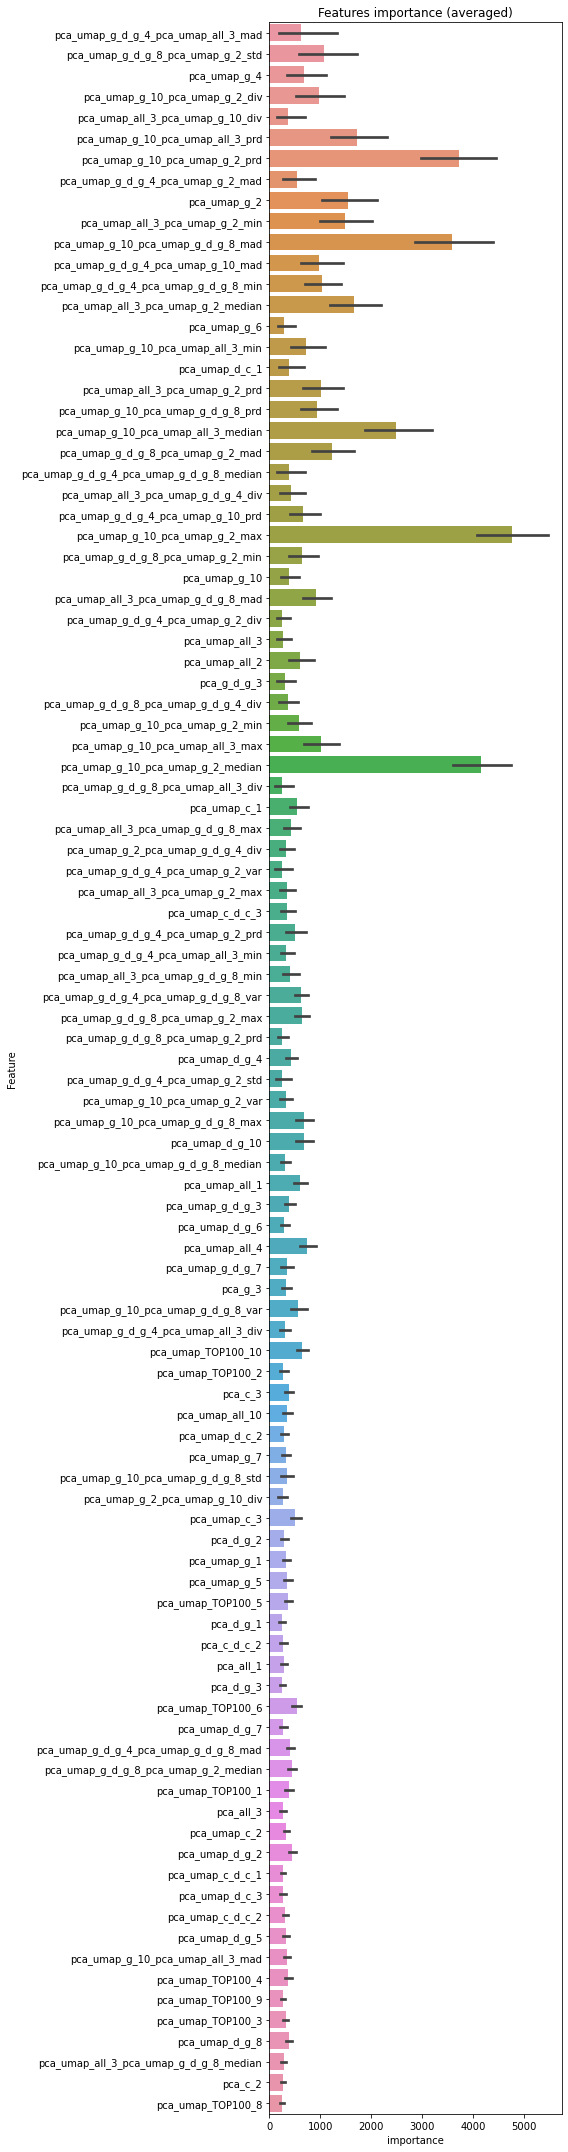

In [56]:
if DEBUG:
    show_feature_importance(feature_importance_df)